## Line Aggregation

> Instead of the point-to-point evaluation, we will instead be aggregating into lines and comparing as such.

__Notes:__

1. Running on DBR 16.1+ for PySpark bindings.
1. Running on a "classic" cluster (vs Serverless) as we are applying Spark configs.
1. Reach out to your sales team to join the spatial sql private preview (aka you need the proper config to apply in the cell currently showing `%run ../common/classic_enable_spatial_preview.py`)

---
__Original Author:__ Timo Roest | __Maintainer:__ Michael Johns | _Last Updated:_ 06 FEB 2025 

## Setup

In [0]:
%pip install -U "databricks-spatial[viz] @ git+https://github.com/databrickslabs/mosaic.git@spatial-utils-v1" --quiet

Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.


In [0]:
spark.conf.set("spark.databricks.optimizer.adaptive.enabled", False) # <-- turn off AQE
spark.conf.set("spark.sql.shuffle.partitions", 1_024)                # <-- default is 200

# -- import databricks + spark functions
from pyspark.databricks.sql import functions as dbf
from pyspark.sql import functions as F
from pyspark.sql.functions import col, udf
from pyspark.sql.types import *

# --other imports
import os
import warnings

warnings.simplefilter("ignore")

In [0]:
# - VIZ
from spatial.viz.keplergl import *
from spatial.viz.helpers import *

kviz = KeplerViz(spark)

In [0]:
%run ../common/classic_enable_spatial_preview.py

__Configure Database__

> Adjust this to settings from the Data Prep notebook.

In [0]:
catalog_name = "geospatial_docs"
db_name = "ship2ship"

sql(f"use catalog {catalog_name}")
sql(f"use schema {db_name}")

DataFrame[]

In [0]:
cargos_indexed = spark.read.table("cargos_indexed")
        
print(f"count? {cargos_indexed.count():,}")
cargos_indexed.limit(5).display() # <- limiting for ipynb only

count? 521,867


cellid,MMSI,BaseDateTime,LAT,LON,SOG,COG,Heading,VesselName,IMO,CallSign,VesselType,Status,Length,Width,Draft,Cargo,TranscieverClass,point_geom,sog_kmph
617733124345036799,367353660,2018-01-31T01:37:52Z,40.78783,-73.91983,0.1,96.0,35.0,RED HOOK,IMO9501916,WDE4476,70,0,107,16,4.9,80,A,AQEAAABN+KV+3npSwGJnCp3XZERA,0.19
617733124345036799,367353660,2018-01-31T01:36:42Z,40.78783,-73.91983,0.2,320.0,35.0,RED HOOK,IMO9501916,WDE4476,70,0,107,16,4.9,80,A,AQEAAABN+KV+3npSwGJnCp3XZERA,0.37
617733124345036799,367353660,2018-01-31T01:34:11Z,40.78783,-73.91983,0.2,167.0,35.0,RED HOOK,IMO9501916,WDE4476,70,0,107,16,4.9,80,A,AQEAAABN+KV+3npSwGJnCp3XZERA,0.37
617733124345036799,367353660,2018-01-31T01:31:51Z,40.78783,-73.91983,0.0,170.0,34.0,RED HOOK,IMO9501916,WDE4476,70,0,107,16,4.9,80,A,AQEAAABN+KV+3npSwGJnCp3XZERA,0.0
617733124345036799,367353660,2018-01-31T01:33:02Z,40.78783,-73.91983,0.1,125.0,35.0,RED HOOK,IMO9501916,WDE4476,70,0,107,16,4.9,80,A,AQEAAABN+KV+3npSwGJnCp3XZERA,0.19


## Create Lines

> We can `groupBy` across a timewindow to give us aggregated geometries to work with. When we collect the various points within a timewindow, we want to construct the linestring by the order in which they were generated (timestamp). We choose a buffer of a max of 200 meters in this case. Since our projection is not in metres, we convert from decimal degrees. With `(0.00001 - 0.000001)` as being equal to one meter at the equator, ref: http://wiki.gis.com/wiki/index.php/Decimal_degrees.

In [0]:
_df_lines = (
    cargos_indexed
        .repartition(512) # <- repartition is important!
        .groupBy("mmsi", F.window("BaseDateTime", "15 minutes"))
            # We link the points to their respective timestamps in the aggregation
            .agg(
                F.collect_list(
                    F.struct(
                        F.array(dbf.st_x("point_geom"), dbf.st_y("point_geom")).alias("point_geom"),
                        col("BaseDateTime")
                    )
                ).alias("coords")
            )
        # And then sort our array of points by the timestamp to form a trajectory
        .withColumn(
            "coords",
            F.expr(
                """
                array_sort(coords, (left, right) -> 
                    case 
                        when left.BaseDateTime < right.BaseDateTime then -1 
                        when left.BaseDateTime > right.BaseDateTime then 1 
                    else 0 
                end
            )"""
        ),
    )
    .filter(F.size("coords") > 1)    
    .withColumn(
      "line", 
      F.concat(
        F.lit('{"type":"LineString", "coordinates":'),
        F.expr("cast(coords.point_geom as string)"),
        F.lit('}')
      )
    )
    .withColumn("line", dbf.st_astext(dbf.st_geomfromgeojson("line")))
)

(
    _df_lines.write.mode("overwrite")
    .option("overwriteSchema", "true")
    .saveAsTable("lines")
)

df_lines = spark.table("lines")
print(f"count? {df_lines.count():,}")
df_lines.limit(1).show(vertical=True) # <- limiting + using `show` for ipynb only

count? 71,600
-RECORD 0----------------------
 mmsi   | 354735000            
 window | {2018-01-31 01:15... 
 coords | [{[-72.06393, 41.... 
 line   | LINESTRING(-72.06... 



_Note here that this decreases the total number of rows across which we are running our comparisons._

In [0]:
one_meter = 0.00001 - 0.000001
buffer = 200 * one_meter

def get_buffer(line, buffer=buffer):
    """Create buffer as function of number of points in linestring
    The buffer size is inversely proportional to the number of points, providing a larger buffer for slower ships.
    The intuition behind this choice is held in the way AIS positions are emitted. The faster the vessel moves the
    more positions it will emit — yielding a smoother trajectory, where slower vessels will yield far fewer positions
    and a harder to reconstruct trajectory which inherently holds more uncertainty.

    Args:
        line (geometry): linestring geometry as generated with st_makeline.

    Returns:
        double: buffer size in degrees
    """
    np = F.expr(f"st_npoints({line})")
    max_np = df_lines.select(F.max(np)).collect()[0][0]
    return F.lit(max_np) * F.lit(buffer) / np

_df_ship_path = (
    df_lines
    .repartition(512)
    .filter("st_isvalid(line)")
    .withColumn("buffer_r", get_buffer("line"))
    .withColumn("buffer", dbf.st_astext(dbf.st_buffer("line", "buffer_r")))
    .filter(dbf.st_isvalid("buffer"))
    .select(F.expr("inline(h3_tessellateaswkb(buffer, 9))"), "*")
)

(
    _df_ship_path.write.mode("overwrite")
    .option("overwriteSchema", "true")
    .saveAsTable("ship_path")
)

df_ship_path = spark.read.table("ship_path")
df_ship_path.limit(1).show(vertical=True)    # <- limiting + using `show` for ipynb only

-RECORD 0------------------------
 cellid   | 618197329527701503   
 core     | false                
 chip     | [01 03 00 00 00 0... 
 mmsi     | 636091916            
 window   | {2018-01-31 05:45... 
 coords   | [{[-89.82018, 29.... 
 line     | LINESTRING(-89.82... 
 buffer_r | 0.0024               
 buffer   | POLYGON((-89.8251... 



In [0]:
to_plot = (
  df_ship_path
    .select("buffer")
    .filter(dbf.st_xmin("buffer") > -90)
    .filter(dbf.st_xmax("buffer") < -88)
    .filter(dbf.st_ymin("buffer") > 29)
    .filter(dbf.st_ymax("buffer") < 31)
  .distinct()
  .limit(3_000)
)
# to_plot.display()

_Example buffer paths_

_Uncomment the following within databricks for actual results._

In [0]:
## -- uncomment to render in databricks
# displayHTML(kviz.map_render(to_plot, "buffer"))

## Find All Candidates

We employ a join strategy using cellids as before, but this time we leverage the buffered ship paths.

In [0]:
candidates_lines = (
    df_ship_path.alias("a")
    .join(
        df_ship_path.alias("b"),
        [
            col("a.cellid")
            == col("b.cellid"),  # <- to only compare across efficient indices
            col("a.mmsi")
            < col("b.mmsi"),     # <- to prevent comparing candidates bidirectionally
            col("a.window")
            == col("b.window"),  # <- to compare across the same time window
        ],
    )
    .where(
        (
            col("a.core") | col("b.core")
        )  # if either candidate fully covers an index, no further comparison is needed
        | dbf.st_intersects("a.chip", "b.chip") # limit geospatial querying to cases where indices alone cannot give certainty
    )
    .select(
        col("a.mmsi").alias("vessel_1"),
        col("b.mmsi").alias("vessel_2"),
        col("a.window").alias("window"),
        col("a.buffer").alias("line_1"),
        col("b.buffer").alias("line_2"),
        col("a.cellid").alias("cellid"),
    )
    .drop_duplicates()
)

(
    candidates_lines.write.mode("overwrite")
    .option("overwriteSchema", "true")
    .saveAsTable("overlap_candidates_lines")
)

In [0]:
%sql
SELECT * FROM overlap_candidates_lines LIMIT 1

vessel_1 vessel_2 window line_1 line_2 cellid 258720000 538005594 List(2018-01-31T17:00:00Z, 2018-01-31T17:15:00Z) POLYGON((-95.27058 29.73304,-95.2706906767849 29.7319162797452,-95.2710184538927 29.7308357434296,-95.2715507350331 29.7298399154578,-95.2722670649404 29.7289670649404,-95.2731399154578 29.7282507350331,-95.2741357434296 29.7277184538927,-95.2752162797452 29.7273906767849,-95.27634 29.72728,-95.2774637202548 29.7273906767849,-95.2785442565704 29.7277184538927,-95.2795400845422 29.7282507350331,-95.2804129350596 29.7289670649404,-95.2811292649669 29.7298399154578,-95.2816615461073 29.7308357434296,-95.2819893232151 29.7319162797452,-95.2821 29.73304,-95.2821 29.73305,-95.2819893232151 29.7341737202548,-95.2816615461073 29.7352542565704,-95.2811292649669 29.7362500845422,-95.2804129350596 29.7371229350596,-95.2795400845422 29.7378392649669,-95.2785442565704 29.7383715461073,-95.2774637202548 29.7386993232151,-95.27634 29.73881,-95.2752162797452 29.7386993232151,-95.2741357434296 29.7383715461073,-95.2731399154578 29.7378392649669,-95.2722670649404 29.7371229350596,-95.2715507350331 29.7362500845422,-95.2710184538927 29.7352542565704,-95.2706906767849 29.7341737202548,-95.27058 29.73305,-95.27058 29.73304)) POLYGON((-95.2850599375099 29.7410611695654,-95.2850530898164 29.7411031951295,-95.2850320546164 29.7411585856212,-95.2848705040205 29.7417230041553,-95.2846752628242 29.7420980999986,-95.2846419006213 29.7421859503079,-95.2846319006213 29.7422059503079,-95.2845581103519 29.7423231724023,-95.2843364605823 29.742749004188,-95.2841286021351 29.7430054825934,-95.2840303653204 29.7431615400962,-95.2838345325944 29.7433683376414,-95.28360819457 29.7436476181631,-95.2835520384529 29.7436938316663,-95.2835429350604 29.7437029350589,-95.2834295828832 29.7437959607866,-95.2832539620321 29.7439814147792,-95.2828862257921 29.7442418824273,-95.2828323103471 29.7442861296895,-95.2827150731295 29.7443826096959,-95.2827133465878 29.7443837607237,-95.282670084543 29.7444192649663,-95.2825303194014 29.7444939709909,-95.2823325274994 29.7446340670325,-95.2819420380283 29.7448084139361,-95.2816742565714 29.7449515461069,-95.2815095722284 29.7450015025562,-95.2813014719346 29.745094415796,-95.2809093850073 29.7451835673594,-95.2805937202558 29.7452793232149,-95.2804076565376 29.7452976488917,-95.2802004182249 29.745344770125,-95.2798255848086 29.7453549779532,-95.279470000001 29.74539,-95.2792684606007 29.7453701501017,-95.2790716792467 29.7453755090429,-95.2787293158454 29.7453170489782,-95.2783462797462 29.7452793232153,-95.2781375243891 29.7452159979701,-95.2779586318062 29.7451854512705,-95.2776595828466 29.7450710159883,-95.2772657434305 29.7449515461077,-95.2770600213552 29.7448415853675,-95.2769040496921 29.7447819006213,-95.2766546935691 29.7446249331523,-95.2762699154587 29.7444192649674,-95.2760787617735 29.7442623891923,-95.2759484599038 29.7441803653204,-95.2757512131527 29.7439935769863,-95.2753970649411 29.7437029350604,-95.2752323340576 29.7435022098981,-95.2751285852208 29.7434039620321,-95.2749828713695 29.7431982387332,-95.2746807350337 29.742830084543,-95.2745534879852 29.7425920220596,-95.2744759329675 29.7424825274994,-95.2743794171985 29.7422663585234,-95.2741484538931 29.7418342565714,-95.2740678423395 29.7415685158928,-95.274015584204 29.7414514719346,-95.2739654417863 29.7412309465086,-95.2738206767851 29.7407537202558,-95.2737929717784 29.7404724266029,-95.273765229875 29.7403504182248,-95.2737592201727 29.7401297408,-95.27371 29.739630000001,-95.2737378971538 29.7393467554449,-95.2737344909571 29.7392216792467,-95.2737716487594 29.739004069642,-95.2738206767847 29.7385062797462,-95.2739029736421 29.7382349833652,-95.2739245487295 29.7381086318062,-95.2740003027116 29.737910667078,-95.2741078172652 29.7375322000423,-95.2741292243763 29.7374891346496,-95.2741484538924 29.7374257434305,-95.2742801452384 29.7371793662509,-95.2743280993787 29.7370540496921,-95.2743128352547 29.7371182075322,-95.2743238461504 29.

_We can show the most common locations for overlaps happening, as well some example ship paths during those overlaps._

In [0]:
%sql
CREATE OR REPLACE TEMPORARY VIEW agg_overlap AS
SELECT cellid, count(*) AS count, FIRST(line_1) AS line_1, FIRST(line_2) AS line_2
FROM ship2ship.overlap_candidates_lines
GROUP BY cellid
ORDER BY count DESC


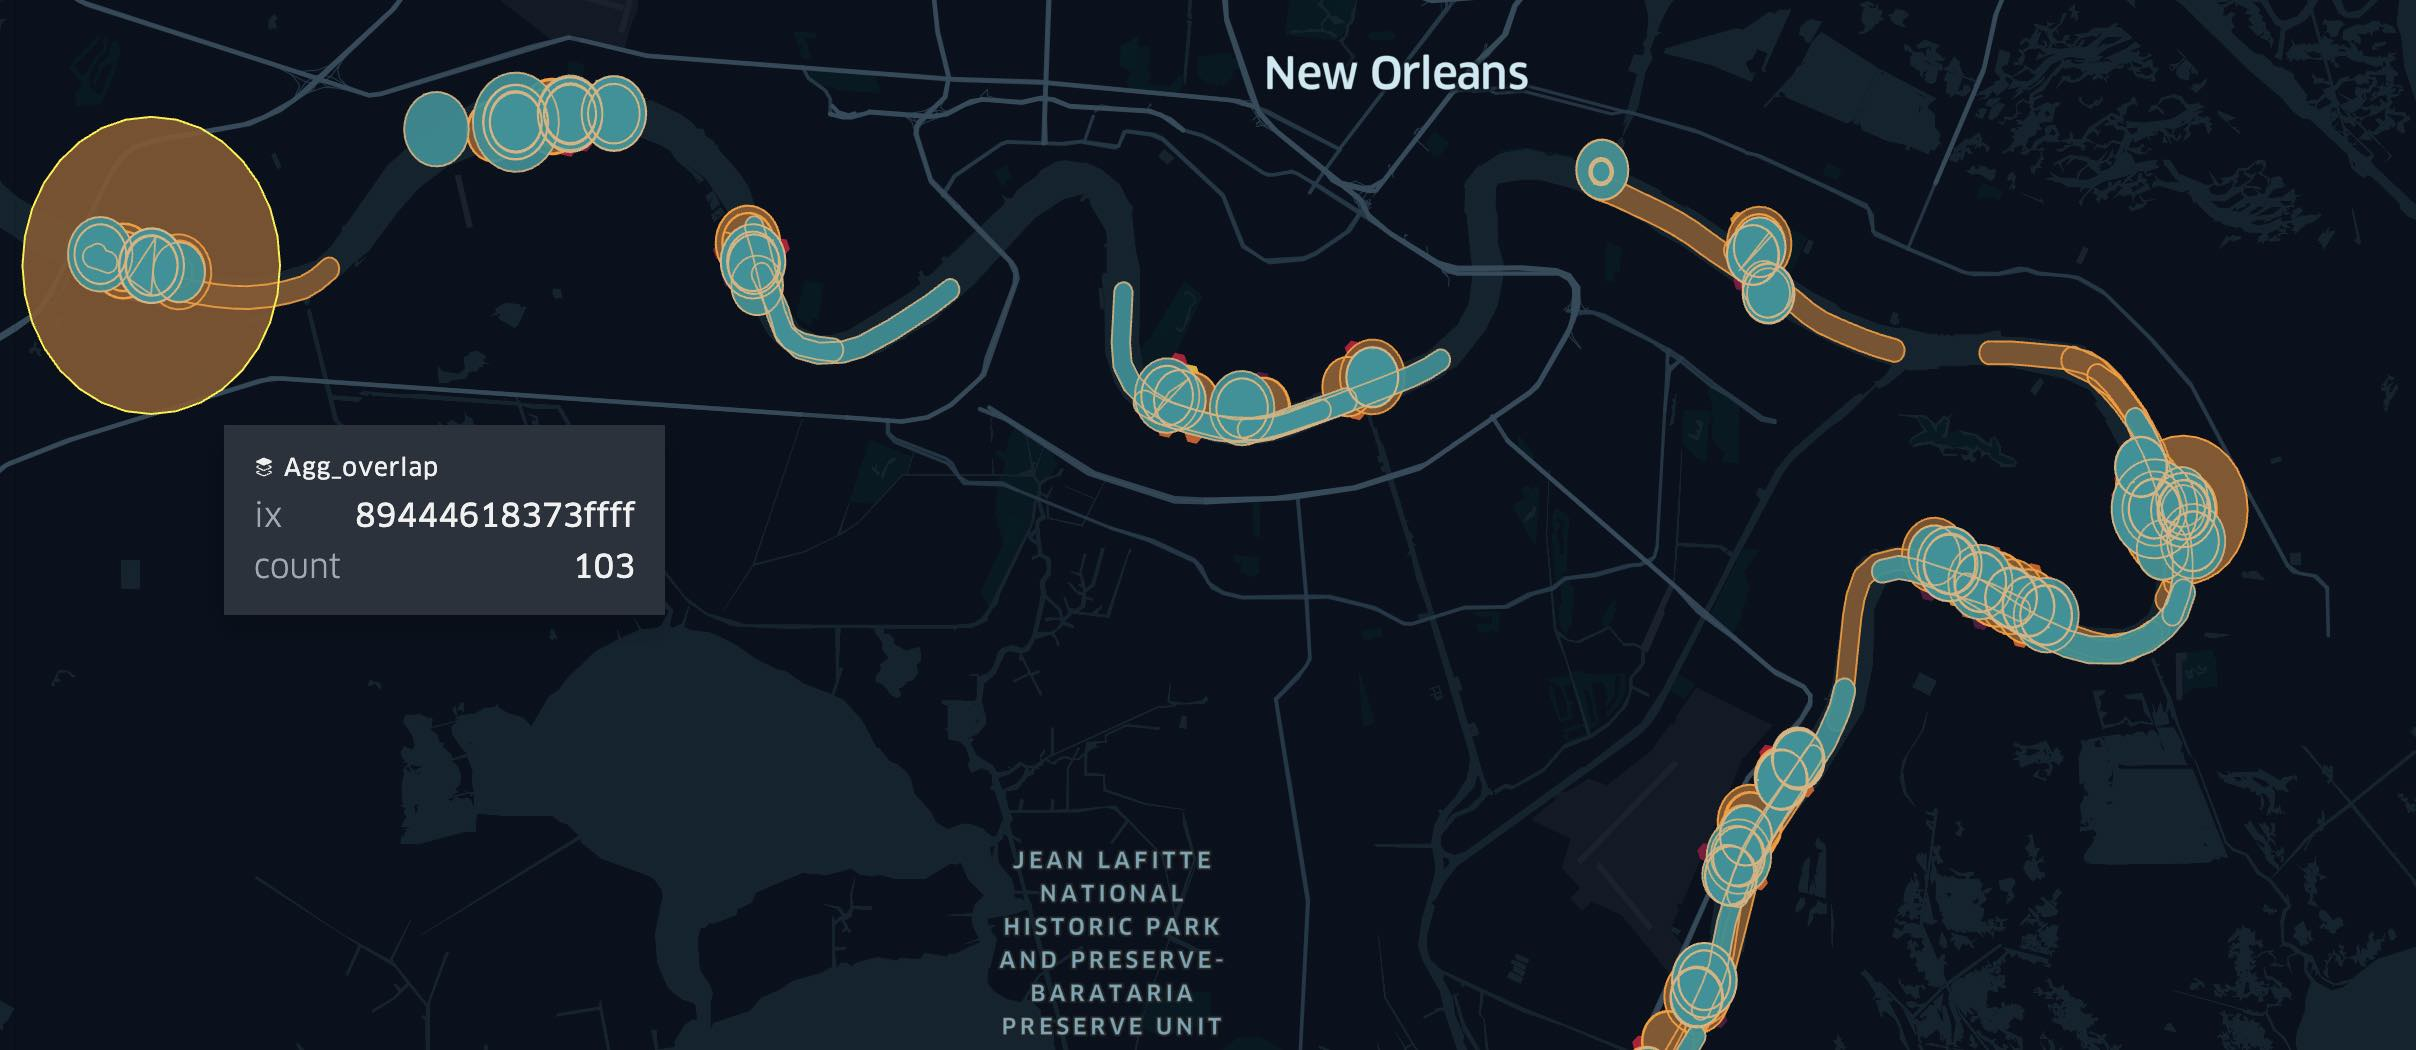

In [0]:
displayHTML("""<img src='data:image/jpeg;base64,/9j/4AAQSkZJRgABAgEASABIAAD/4QDoRXhpZgAATU0AKgAAAAgABgESAAMAAAABAAEAAAEaAAUAAAABAAAAVgEbAAUAAAABAAAAXgEoAAMAAAABAAIAAAITAAMAAAABAAEAAIdpAAQAAAABAAAAZgAAAAAAAACQAAAAAQAAAJAAAAABAAiQAAAHAAAABDAyMjGRAQAHAAAABAECAwCShgAHAAAAEgAAAMygAAAHAAAABDAxMDCgAQADAAAAAQABAACgAgAEAAAAAQAACXCgAwAEAAAAAQAABBqkBgADAAAAAQAAAAAAAAAAQVNDSUkAAABTY3JlZW5zaG90AAD/4g0gSUNDX1BST0ZJTEUAAQEAAA0QYXBwbAIQAABtbnRyUkdCIFhZWiAH5wALABYACgARACNhY3NwQVBQTAAAAABBUFBMAAAAAAAAAAAAAAAAAAAAAAAA9tYAAQAAAADTLWFwcGwAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABFkZXNjAAABUAAAAGJkc2NtAAABtAAAAepjcHJ0AAADoAAAACN3dHB0AAADxAAAABRyWFlaAAAD2AAAABRnWFlaAAAD7AAAABRiWFlaAAAEAAAAABRyVFJDAAAEFAAACAxhYXJnAAAMIAAAACB2Y2d0AAAMQAAAADBuZGluAAAMcAAAAD5tbW9kAAAMsAAAACh2Y2dwAAAM2AAAADhiVFJDAAAEFAAACAxnVFJDAAAEFAAACAxhYWJnAAAMIAAAACBhYWdnAAAMIAAAACBkZXNjAAAAAAAAAAhEaXNwbGF5AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAbWx1YwAAAAAAAAAmAAAADGhySFIAAAASAAAB2GtvS1IAAAASAAAB2G5iTk8AAAASAAAB2GlkAAAAAAASAAAB2Gh1SFUAAAASAAAB2GNzQ1oAAAASAAAB2GRhREsAAAASAAAB2G5sTkwAAAASAAAB2GZpRkkAAAASAAAB2Gl0SVQAAAASAAAB2GVzRVMAAAASAAAB2HJvUk8AAAASAAAB2GZyQ0EAAAASAAAB2GFyAAAAAAASAAAB2HVrVUEAAAASAAAB2GhlSUwAAAASAAAB2HpoVFcAAAASAAAB2HZpVk4AAAASAAAB2HNrU0sAAAASAAAB2HpoQ04AAAASAAAB2HJ1UlUAAAASAAAB2GVuR0IAAAASAAAB2GZyRlIAAAASAAAB2G1zAAAAAAASAAAB2GhpSU4AAAASAAAB2HRoVEgAAAASAAAB2GNhRVMAAAASAAAB2GVuQVUAAAASAAAB2GVzWEwAAAASAAAB2GRlREUAAAASAAAB2GVuVVMAAAASAAAB2HB0QlIAAAASAAAB2HBsUEwAAAASAAAB2GVsR1IAAAASAAAB2HN2U0UAAAASAAAB2HRyVFIAAAASAAAB2HB0UFQAAAASAAAB2GphSlAAAAASAAAB2ABDAG8AbABvAHIAIABMAEMARAAAdGV4dAAAAABDb3B5cmlnaHQgQXBwbGUgSW5jLiwgMjAyMwAAWFlaIAAAAAAAAPMWAAEAAAABFspYWVogAAAAAAAAgwoAAD1u////vFhZWiAAAAAAAABL+gAAtCEAAArgWFlaIAAAAAAAACfSAAAOcAAAyJFjdXJ2AAAAAAAABAAAAAAFAAoADwAUABkAHgAjACgALQAyADYAOwBAAEUASgBPAFQAWQBeAGMAaABtAHIAdwB8AIEAhgCLAJAAlQCaAJ8AowCoAK0AsgC3ALwAwQDGAMsA0ADVANsA4ADlAOsA8AD2APsBAQEHAQ0BEwEZAR8BJQErATIBOAE+AUUBTAFSAVkBYAFnAW4BdQF8AYMBiwGSAZoBoQGpAbEBuQHBAckB0QHZAeEB6QHyAfoCAwIMAhQCHQImAi8COAJBAksCVAJdAmcCcQJ6AoQCjgKYAqICrAK2AsECywLVAuAC6wL1AwADCwMWAyEDLQM4A0MDTwNaA2YDcgN+A4oDlgOiA64DugPHA9MD4APsA/kEBgQTBCAELQQ7BEgEVQRjBHEEfgSMBJoEqAS2BMQE0wThBPAE/gUNBRwFKwU6BUkFWAVnBXcFhgWWBaYFtQXFBdUF5QX2BgYGFgYnBjcGSAZZBmoGewaMBp0GrwbABtEG4wb1BwcHGQcrBz0HTwdhB3QHhgeZB6wHvwfSB+UH+AgLCB8IMghGCFoIbgiCCJYIqgi+CNII5wj7CRAJJQk6CU8JZAl5CY8JpAm6Cc8J5Qn7ChEKJwo9ClQKagqBCpgKrgrFCtwK8wsLCyILOQtRC2kLgAuYC7ALyAvhC/kMEgwqDEMMXAx1DI4MpwzADNkM8w0NDSYNQA1aDXQNjg2pDcMN3g34DhMOLg5JDmQOfw6bDrYO0g7uDwkPJQ9BD14Peg+WD7MPzw/sEAkQJhBDEGEQfhCbELkQ1xD1ERMRMRFPEW0RjBGqEckR6BIHEiYSRRJkEoQSoxLDEuMTAxMjE0MTYxODE6QTxRPlFAYUJxRJFGoUixStFM4U8BUSFTQVVhV4FZsVvRXgFgMWJhZJFmwWjxayFtYW+hcdF0EXZReJF64X0hf3GBsYQBhlGIoYrxjVGPoZIBlFGWsZkRm3Gd0aBBoqGlEadxqeGsUa7BsUGzsbYxuKG7Ib2hwCHCocUhx7HKMczBz1HR4dRx1wHZkdwx3sHhYeQB5qHpQevh7pHxMfPh9pH5Qfvx/qIBUgQSBsIJggxCDwIRwhSCF1IaEhziH7IiciVSKCIq8i3SMKIzgjZiOUI8Ij8CQfJE0kfCSrJNolCSU4JWgllyXHJfcmJyZXJocmtyboJxgnSSd6J6sn3CgNKD8ocSiiKNQpBik4KWspnSnQKgIqNSpoKpsqzysCKzYraSudK9EsBSw5LG4soizXLQwtQS12Last4S4WLkwugi63Lu4vJC9aL5Evxy/+MDUwbDCkMNsxEjFKMYIxujHyMioyYzKbMtQzDTNGM38zuDPxNCs0ZTSeNNg1EzVNNYc1wjX9Njc2cjauNuk3JDdgN5w31zgUOFA4jDjIOQU5Qjl/Obw5+To2OnQ6sjrvOy07azuqO+g8JzxlPKQ84z0iPWE9oT3gPiA+YD6gPuA/IT9hP6I/4kAjQGRApkDnQSlBakGsQe5CMEJyQrVC90M6Q31DwEQDREdEikTORRJFVUWaRd5GIkZnRqtG8Ec1R3tHwEgFSEtIkUjXSR1JY0mpSfBKN0p9SsRLDEtTS5pL4kwqTHJMuk0CTUpNk03cTiVObk63TwBPSU+TT91QJ1BxULtRBlFQUZtR5lIxUnxSx1MTU19TqlP2VEJUj1TbVShVdVXCVg9WXFapVvdXRFeSV+BYL1h9WMtZGllpWbhaB1pWWqZa9VtFW5Vb5Vw1XIZc1l0nXXhdyV4aXmxevV8PX2Ffs2AFYFdgqmD8YU9homH1YklinGLwY0Njl2PrZEBklGTpZT1lkmXnZj1mkmboZz1nk2fpaD9olmjsaUNpmmnxakhqn2r3a09rp2v/bFdsr20IbWBtuW4SbmtuxG8eb3hv0XArcIZw4HE6cZVx8HJLcqZzAXNdc7h0FHRwdMx1KHWFdeF2Pnabdvh3VnezeBF4bnjMeSp5iXnnekZ6pXsEe2N7wnwhfIF84X1BfaF+AX5ifsJ/I3+Ef+WAR4CogQqBa4HNgjCCkoL0g1eDuoQdhICE44VHhauGDoZyhteHO4efiASIaYjOiTOJmYn+imSKyoswi5aL/IxjjMqNMY2Yjf+OZo7OjzaPnpAGkG6Q1pE/kaiSEZJ6kuOTTZO2lCCUipT0lV+VyZY0lp+XCpd1l+CYTJi4mSSZkJn8mmia1ZtCm6+cHJyJnPedZJ3SnkCerp8dn4uf+qBpoNihR6G2oiailqMGo3aj5qRWpMelOKWpphqmi6b9p26n4KhSqMSpN6mpqhyqj6sCq3Wr6axcrNCtRK24ri2uoa8Wr4uwALB1sOqxYLHWskuywrM4s660JbSctRO1irYBtnm28Ldot+C4WbjRuUq5wro7urW7LrunvCG8m70VvY++Cr6Evv+/er/1wHDA7MFnwePCX8Lbw1jD1MRRxM7FS8XIxkbGw8dBx7/IPci8yTrJuco4yrfLNsu2zDXMtc01zbXONs62zzfPuNA50LrRPNG+0j/SwdNE08bUSdTL1U7V0dZV1tjXXNfg2GTY6Nls2fHadtr724DcBdyK3RDdlt4c3qLfKd+v4DbgveFE4cziU+Lb42Pj6+Rz5PzlhOYN5pbnH+ep6DLovOlG6dDqW+rl63Dr++yG7RHtnO4o7rTvQO/M8Fjw5fFy8f/yjPMZ86f0NPTC9VD13vZt9vv3ivgZ+Kj5OPnH+lf65/t3/Af8mP0p/br+S/7c/23//3BhcmEAAAAAAAMAAAACZmYAAPKnAAANWQAAE9AAAApbdmNndAAAAAAAAAABAAEAAAAAAAAAAQAAAAEAAAAAAAAAAQAAAAEAAAAAAAAAAQAAbmRpbgAAAAAAAAA2AACuAAAAUgAAAEPAAACwwAAAJoAAAA2AAABQAAAAVEAAAjMzAAIzMwACMzMAAAAAAAAAAG1tb2QAAAAAAAAGEAAAoEQAAAAA2ZNdgAAAAAAAAAAAAAAAAAAAAAB2Y2dwAAAAAAADAAAAAmZmAAMAAAACZmYAAwAAAAJmZgAAAAIzMzQAAAAAAjMzNAAAAAACMzM0AP/AABEIBBoJcAMBIgACEQEDEQH/xAAfAAABBQEBAQEBAQAAAAAAAAAAAQIDBAUGBwgJCgv/xAC1EAACAQMDAgQDBQUEBAAAAX0BAgMABBEFEiExQQYTUWEHInEUMoGRoQgjQrHBFVLR8CQzYnKCCQoWFxgZGiUmJygpKjQ1Njc4OTpDREVGR0hJSlNUVVZXWFlaY2RlZmdoaWpzdHV2d3h5eoOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4eLj5OXm5+jp6vHy8/T19vf4+fr/xAAfAQADAQEBAQEBAQEBAAAAAAAAAQIDBAUGBwgJCgv/xAC1EQACAQIEBAMEBwUEBAABAncAAQIDEQQFITEGEkFRB2FxEyIygQgUQpGhscEJIzNS8BVictEKFiQ04SXxFxgZGiYnKCkqNTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqCg4SFhoeIiYqSk5SVlpeYmZqio6Slpqeoqaqys7S1tre4ubrCw8TFxsfIycrS09TV1tfY2dri4+Tl5ufo6ery8/T19vf4+fr/2wBDAAcHBwcHBwsHBwsQCwsLEBYQEBAQFhsWFhYWFhshGxsbGxsbISEhISEhISEnJycnJycuLi4uLjQ0NDQ0NDQ0NDT/2wBDAQgICA0MDRcMDBc2JR4lNjY2NjY2NjY2NjY2NjY2NjY2NjY2NjY2NjY2NjY2NjY2NjY2NjY2NjY2NjY2NjY2Njb/3QAEAJf/2gAMAwEAAhEDEQA/APACSetIelFB6VuZhRRRQAUUUUAFFFFABVq2vJ7U/uzlT1U9Kq0UAdLHqFndrsuVCn0bkfgaJNJtpRugYrn05Fc1Usc0sRzG5X6U79yeXsXZtKuo+VAce3+FZ7IyHa4Kn0PFasOsXCcSgOPyNaC6hY3I2zDHsw4/OiyC7W5zFFdK+l2kw3QNtz6HIrNm0m6j5TDj26/lRYFJGZRT3R4ztdSp9DTKRQUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRSlSMZHWkoAKKKKACiiigAooooAKKKKACiiigAoopyqzsFUZJ4AFACAFiFAyTwK6i2gj022aab75HP9AKjs7KKyT7TdEbwPwX/69ZV9fNdvgcRr0H9TVbEPXQqzzvcStLJ1P6D0qGiipLCiiigAooooAKKKKACiiigAooooAUEqcip1YNVeigC3RUSyZ4apaACiiigAooooAKKKKAClDEd6SigCQSHvTg6moaKAJtqmmmP0NR9KcGY8etAEi8LVaT7pqy5wtVJDxigCGiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKANzRG+eVfUA/lmsq6Xbcyr6Of51f0dsXRHqh/mKr6ku29kHqQfzFPoStyjRRRSKCiiigAooooAKKKKACiiigAooooAvaaM3sf4/yNW9aP79B/s1X0sf6an0P8qm1k/wCkqP8AYH8zT6E/aMiiiikUFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAFm3/iNVqswg7Hx3qtQJBRRRQMuae228iP8AtY/PitXWx8sR9z/SsSBtk8bejA/rW9rY/cxn/a/pTWxL3RzdFFFIoKKKKACiiigAqUdKiqagmQUUUUEDlwT83Snyg5B7VFUiN/CeQaAI6WlZdrYptArC01+EHuf5U4ckCln6hfQUFRK9FFFBoFFFFABRRRQAU9MbsltuO9MooA001S4iwqHco/v8k1IdZuj0VB+B/wAayKUAkgDkmncXKjdt9QuZZijEY254H0pLi+ngRVL5kIz2pqBLOHe/3iBn/CseSRpHLt1NO5KVyZry7brK/wCZFRGaVvvOx+pNR0VJdhevWkoooAKKKKAFALEKOSeK6xFh0y0y3J7+pNYelw+bdqT0T5j/AE/WrmtTZZIB2+Y/0ql3IersY88z3EplkOSf0qKiipLCiiigAooooAKKKKACiiigAooooAKKKKACpoDh8etQ05TtYH0NAM0aKKKZmRyOEXPftVEkk5PWpJX3vx0HSoqRaQUUUUDCiiigAooooAKKKKACiiigAop6oznAqU27Doc0CuV6KuiFAMEZpsioiEgcnigLlSiiigYUUUUAFFFFABRRRQBJGqMcOcVYZIlXkceoqtGNzgVfoJZRKD5iDkLUdaJAYYPSqUgUOQvQUDTI6KnjhYsCwwKsGKM9RQFyhRUskezkdDUVAwooooAKKKKACiiigAooooAK0tLg865DEfLH8x+vas2ulslFnp7XDD5mG7/AU0TJ6Gdq0/m3Plj7sfH496y6ViWJZjknk0lIaVgooooGFFFFABRRSqpY4HU0AAGeBTnQoQD1IzThuifAwTU0yLjec5HHFArlSiiigYUUUUAFKCQcikooAtCXehU/ex+dVaKKBWCiiigYUUUUAWI5iOH5HrVrryKzamil2fK3T+VBLRdopOvIpaZIVEyyZ+VsD6VLSE4BNAEDOqfeO80iz8Et69KiSJnPoBTXUocE5pF2RdV1f7ppWBI+U4NUU27gWOAKvKykfKc0yWrFZZXV8SfjUsybkyOo5qO4ByDjgd6dA+RsPUUD8ypRUkqbG9j0qOkUFFFWIY93zN07UASwoVX5u/NMnf8AgH41YJA61RlGJDTJW5HUsT7H56HrUVFIo0JF3IRWfV2KQMApPNNaAE5BwKZK0KlSxxlz7VOIEHXJoeQRjavX+VIL9hXdYxtXr2FUySTk9aCSTk0lA0gp8Yy6/WmVLD/rBQNl6iiimZn/0PBZFROBkmoT0pzHLE+ppp6VuZhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAD0kkjO6Nip9jWlDq9zHxJiQe/BrKoouJo6VdTsrgbZ12/7wyKG02yuBvgbb/unIrmqcruh3ISp9RxTuLl7GlNpNzHzHiQe3B/Ks543jO2RSp9xitCHVbqPhiHHv/jWimq2kw2XCbc+oyKNAu0c3RXStp9hdDdA2D/snP6VQl0e5TmMiQfkaLBzIyaKkkiliOJFKn3FR0igooooAKKKKACiiigAooooAKmhUM3PaoalicITnvQJktw3RcfjVWppJBIBx0qGgEFFFFAwooooAKKKKACiiigAooqSKKSeQRxjLGgBER5GCINzHoBXS21rDp0RnnI345Pp7CnQwW+mQmWQ5Y9T3PsKwLu8ku5NzcKPur6VWxG469vZLt+eEHRf6n3qlRRUlhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAVIrkcHpUdFAFoEHkUtVlYqeKnVg1ADqKKKACiiigAooooAKKKKACnIMt9KbUsY4zQAkh5Aqkx3HNWJW6n8Kq0AFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAX9Mbbex++R+lTawuLvP95Qf6VTs223UR/2h+taWtriSN/UEflT6E9TEooopFBRRRQAUUUUAFFFFABRRRQAUUUUAaekjN4PoaXVzm7+ij+tLo4zdn/dP9KZqpzeN7AU+hP2jNooopFBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQBYhDbSVI+hqvViLIjc1XoEgooooGL05rqtRQXFj5i87cOPp/+quUrqtLkE1n5bc7MqfpTRMu5ytFSzxGGZ4j/AAnFRUigooooAKKKKAFHUVLUa9amCs3QUESG0U7Yw7U4RMfagkjqQYQbj949KPKb2pXRsA9eKAHxvu4PWh0U85wagwR14pKAHopLfSo5W3OSOg4qRyRCMcZNVqC4oKKKKCgoopcGgBKKKKACiiigArVs4BGv2iXj0z6etV7O385t7D5F/Wn3tzvPkxn5R196aJeuhBczmd8/wjoKrUUUigooooAKKKKACiinIhkdUXqxwPxoA6XR4dluZT1kP6CsG7m8+5kl7E8fQcCumumW0sSqdl2L+PFchVPsRHuFFFFSWFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFKoyQPU0AaNRyvtTjqalqlO2Xx6UyEQ0UUUiwooooAKKKKACiilCk9BmgBKKmEDnrxSmBx0INArkFTpCW5bgVMkSpyeTU1MTYgAAwOKWiigkKpTNufHYVadtik1n0FRQU9ELnAptaCqFGBSG2QfZxjrzUTxMgySMVeqlM+5sDoKYk2Q0UUUigooooAlhIDjNXqzQCegq8WEajcaCZDmO0EntVF2VjlRih2Ltk0ygaRagcY2HrU7HapPpWdUiyuvfP1oE0NZ2c5am0pOTnGKSgoKKKKACiiigAooooAKKKKAFUFiFHUnFdJqrCKzSFe5A/AVjWEfmXca+hz+XNXtakzMkf91c/n/8AqprYl7mLRRRSKCiiigApQMkD1qxExEZ3cqKkCwscjGRzQK5VKOOoPFPiwuXP8IqVo2Y5kb5RUMhOdvQDoKA3Gbju3d6eZCUKnkmoqKBhRRUyQlhk8CgCGirX2cf3qcsCg5JzQK6KmDjOOKSr7oHGMkD2qrJGUPqPWgEyKiiigYUUUUAFFFFABRRRQBNFLs+Vun8qudeRWbU0Uuzg9KCWi7RSA55FLTJErOOc89a0enNUHYOxYDFBURlXoipT5eMdao1bhKHoMNSHIlcFlIXqao/MjehFaHOKpzKQ5bsaYolnCyp7Gofs5z96oVdk+6au7gF3NxQGw1YUXtn605mVBzxVd5yeE4qAknk0BbuSSSFz6AdKfN8wV/UVXqwvzQEf3aQxscW9Sc49Kd9nb1FRxlt6gZ61foE2U2gZRkHOKYJZB3qxNIVwi9TTFgJ5c0BfuR+dJ61H1q+EReAKUKoOQBQFyosLsM9PrTXjZMZ71eJAGTxUDSZcKmCD6+tME2VenWprf75+lWiqtwwzVcDypR6NSC9y1RRRTJP/0fn+g9KKD0rczCiiigAooooAKKKKACiiigAoop4woyaBNiEYpCMUZ5zTm64oAZRUhAxxUdAJ3CiiigYUUUUAKGZTlSQfUVoQ6ndxcFt49G/x61nUUBY6OPV7eUbbhNufxFPNlp12MwkA/wCyf6VzNKCQcjg07k8vY15tHnTmJg49OhrMkgmhOJUK/WrUOpXcXG/cPRuf/r1pR6xE423EeM+nIo0DVHPUV032bTbzmIgMf7pwfyqnNo0q8wuGHoeDRYOZGLRU8tvPB/rUK+/b86gpFBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRVm2tZbqTZGOO57CgBsFvLcyCOIZPc9h9a6RUttKtyzcsep7sfQU4m20u3wOSfzY1zNxcSXMhkkP0HYCq2I3HXN1LdSb5Dx2HYVWooqSwooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiirMVnczfcQ49TwP1oArUoOORWzFo0h5lcD2FXk0yyiG6T5sd2NOxPMjnkfdx3q7HZ3Mn3UP1PH861GvdPthiMAn0Qf16VSl1mQ8QoF9zzRZBd9CaPSXPMrgew5pZdLAP7uT8xWNLeXM3+skJHoOB+QqJJZI/uMV+hxRoFmajaddD7qhvof8AGqrxSx/6xCv1FOi1S7i/iDD/AGhV+PWh0mj/ABU/0NGgamXRW0LjSrj7wCk+o2/qKU6bbSjdBJ+WGFFg5u5iUdK0pNLuF+4Q36Gqb288f30I98cUWHdFOU9BUVPc5Y0ykMKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKkU8YqOnKcGgTWhITjrTcrS/eFRUEpBRRRQWFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAOVirBh1BzXR6ooms0nXsQfwNc1XTWv+k6YY+pAK/l0pomXc5miiikUFFFFABRRRQAUUUUAFFFFABRRRQBr6MP9JY/7B/mKg1M5vX9sfyqzoo/fuf8AZ/rVTUTm9l+o/kKfQn7RRooopFBRRRQAUUUUAFFFFABSgZ6U4J3NSAY6UEuRCRjikpzA5pMEUDTEooooGFFFFAFhDiBjVerPS3+v+NVqBIKKKKBhWvo82y4MR6SD9RWRUkUhikWReqkGhCaujW1mHbMsw6OMH6j/AOtWLXW6hGLmyLLzgBx/n6VyVNii9AooopFBRRRQAoODmniRhxUdFArEvmH3pNwqOigOVEu4UobHINQ0UC5S2JAww/NRgFyQn51BU8Um07WPBoDlElYcIP4eKhp7oUODTKCkFSjGOKiooE1cmoqGignlHNjPFNoooLQVNDE00gRfxPoKiUFiFUZJrYGyxgyeXb+dNCbG3Mq20Ygi4OPyrIpzMXYsxyTTaTBKwUUUUDCiiigAooqeGISbixwFGf6/0oAgroNM08qRdT8EcqP6mjTtNxi4uRz1VT/M1HqWo7828B+XozDv7D2pohu+iItUvVuGEMXKIck+prIoopFJWCiiigYUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAVJGCXGPWo6tW+3B9aBMnZtqlvSqTyM556elTXDcBfXmqtAkgopQCegzUogc9eKCiGirggUdealCqvQYoJ5ikInboPzqVbf+8fyq1RTFciWJF7Z+tSdOlLRQIKKKKACiiigAooprEKCx7UAVp2ydo7VXpSckk96SkaIUHBB9KuxyeZwRgiqNOVihytAmi7IxAwvU9KRIlUYPJPWiPLDe3U9KlpklV4O6flVfpwa0qjeNX6/nQNMoUVI8TJ7j1qOkUPWR1GFOKaSScnmkooAKKKKACiiigAoqV4WUZ6ikjTecZxQFyOitAKiDHQVGYo35Xj6UE8xTop7psOM5plBQUUUUAFFFFAGzo0e6d5P7q4/P8A/VVK/k8y7kb0OPy4rX0oCGzknbuSfwUVzpJYlj1PNN7ErcSiiikUKBngU/ynyAR1ojcJk4ye1TQs7E55FAmybConTheaohiG3Hv1q7IpdSoqEIVVg+MY4PvTEiSVS6Arz3qpyxA79Ks7/KVVPf8ASovOIOdq0gQskSouRkmkiCscMuffNO2rKSwOD6U7YdoReh6npQApaFegz+FJ9oGfu8U2QMxCIpwKljiCcnk0w0HLknceB2FNM6A45P0ocNIdo4Hc1H5AHLNgUCH+eh7GpfvDkdexqsHjj+4Nx9TUbSu3U8egoHYWVAjfKf8A61RVZjg7v+VRyxhDweD2pDTIqKKKBhRRRQAUUUUAFFFFAE0cpTg9KuAgjI6Vm1LHIUPtQJovVUlix8y9O4q0CCMjpS0yUzMpQSDkdasyw5+ZOvpVWkUmWRLv+VjtH86mf5l25+90qhUsLFXA7GgTRHgg7T1q3P8AcH1qBTvlB9TUlx/CKB9Sv70lTRoXVh27H3p4tz3NAXK1TwHDFfWnfZ+vP0pyw7SGzyKAbRGIW2nB5/nUiylFAcHNWKikRn4zgUyb9yuG3yhjxyKu1TMDZwDx60JuRtjZwaQ2WmBIwDg1TMsvKk1KS0OAOVqsTkk+tAJDi5KhT2OaZUkabzz0HWpSsC9TmgdyDe/qaCzHqSaGKliVGBTaBmihyoJ7inVFD/qxUtMzP//S+f6D0ooPStzMKKKKACiiigAooooAKKKeMKMmgTYDCjJppOaCc0qjJoDbVgB3NKDls0hyx4p4AAoJYtQ1Ix4qOgcQooooKCiiigAooooAKKKKACiiigAq7DqF3Dwrkj0bmqVFAHQRayh+WePHuvP6GpvK0u9+4QGPp8p/KuZop3J5extzaM45gcN7NxWZLa3EH+tQgevb86fDfXUP3JDj0PI/WtOLWu08f4r/AIGjQNUYNFdNjS73ptDH/gJ/+vVaXRT1gkz7N/iKLBzdzCoq1NZ3MH+sjOPUcj9Kq0igooooAKKKKACiir9lYSXbZPyxjqf6CgGxlnZyXb4XhR95vT/69dDLLb6ZAEQcnoO5PqafLNBp8G1B90cKK5SaaSeQyyHJNVsR8QTTSXEhklOSf0qKiipLCiiigAooooAKKKKACiiigAooooAKKKKACinKrOdqgk+gq9Fpl1LyV2D/AGqAuZ9KATwK6KLR4V5mYt7dBVnzNPs+BtU+3X/GnYnm7GBFp91L0TaPVuP/AK9aUWjKOZnz7Dill1lBxChPueKzZdRu5f4to/2eP1609Bas3xDY2gyQq+56/rVeXVrdOIgXPtx/OubJLHLHJ96SlcfL3NSXVrmThMIPzNZ7yySnMjFvqajopXGkFFFFAwoop200ANopcYpKACnKzIdykg+optFAF6PUbyPpIWHo3P8A9er0etOOJYwfdTj9Kw6KdxcqOk+2aZc/65QCf7y8/mKDpthOMwPj/dORXN0oJByKLi5exsSaNMv+rdW+vH+NVjpd6P4M/Qioo767i+7Kfx5/nVhdWvB1Kn6j/CjQNSA6feL1iP4c1EbW5HWJ/wDvk1ojWbkdUQ/n/jUo1tv4ogfof/rUaBdmKUdfvKR9RTK6Ea2n8URH0Oaf/a1m3342/EA/1osgu+xzdFdJ9s0p/vIB9Uo36M/ZR+BFFg5vI5uiuk+z6O3RlH/Av/r0f2bp7/ckP4MDRYOY5uiujOjQH7sjfoajOif3ZfzX/wCvRZhzIwKK2jos38Min65FRnR7odCh/E/4UWY+ZGTRWidLvR0QH6EVEdPvF6xH8OaLBdFOirBtblesT/kaiMci/eUj6ikMZRRRQBMKiIwaUMRxSE5oJSsJRRRQUFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFb2iyf6yE+zD+RrBq/psnl3iejfKfxpoUtiC7j8q5kj9GOPoeRVetfWI9twsg6Ov6isihgtgooopDCiiigAooooAKKKKACiiigDb0UfvJD7Cs+/ObuX/erS0QfNKfZf61l3hzdS/wC8afQlblaiiikUFFFFABRRRQAUUUUATjpRRRQYCU1ulOprdKC0R0UUUGgUUUUAWHGIVFV6sTcIg9qhXrQJbDaXBqWignmI9po2mpKKA5mdLpcomtAjclPlP07VzdzEYJ3i/unj6dq09IkEc5i7SD9RTtahxIk4/iG0/UVXQE9TDoooqSwGT0FFfRHwahhfRr53RWP2gDJAJxsFcx8U/B66ZcjX9OjC21w2JlUcJIe+Owb+f1oJ5tbHj1HI6ip7QBrqEEZBdcj8a+jPi9bwR+GIWjjVSLlACABwVagbdnY+bKKUAkhVGSegrqbTwR4svYRcW+mzFGGQWAXP0DEGgdzlaKv6hpWpaTN9n1K2kt37B1Iz9Ox/CrVj4e1vUrZryws5Z4UyGdBkDHWgLmNRQcg4PWt5fC/iFrIaithMbYrv8zb8u31+lAGShEi+W3XsahZSpwadGOdx7Vr6loOuadCLvUbOS3iYgKzjAOfSgRiUUVueHNEn8Raxb6VAdvmn5m/uoOWP4CgZiKGY7VBJPYVM9tcxrukidR6lSBX1n5HhHwBpiyyJHbr90OV3SyN9epP6Csy3+KXg69lFtJJJGrnG6WP5PxwTj8aLEc76I+WKK+jviF4E0680yXXdGiWK4gXzHWMYWRByTgcZA5yOteD6TpOoarMUsLd7loxkqgz+ftQNSuriWsKwRm5m4OOPpVKR5bucKgLM5Cqo5PPQD3rUWw1bVrw6fZW0kssZIaNFJII659Pxq5HoWraHrmnRatbtbtJPGyhscgOPQmhsF3ZR1Lw7rmjwpPqlnJbxyHarOMAnrisWvpT4yf8AIuW3/X0v/oDV82KrMQqgkngAUBF3VxKK6u28DeLbuETw6bNsYZBYBSfwYg1g3+m6hpc/2bUbeS3k/uyKR+WetA7lKirllp1/qUvk6fbyXD/3Y1LEfXFdMvw+8ZMnmDTZMHsSoP5E5oC5xtdPp1h5SCSYfMecelRx6VcaVdeXq0DwzLyEkBH489aueRrGp280mlW0k0UGfNkQZCgDJ/SmiZO+iKGp3+M20B/3iP5Vz9dDpvhXxHrKedp9jLMn9/G1T+LYBqtqvh/WtEYDVbSS3B6Mw+U/RhkfrSbKVloY9FFdHp/hDxNqkQnsdPmkjPIYjaD9C2M/hQM5yitzUvDOv6PH52pWMsMfTeVyv5jIrDoAKKKKACiiigAooooAKKKKACiiigAoopQMkAd6AHbHIyASDViBSMkjFTgYGB2paZDZTnGHz61BVm4YEhfSq1IpF5JI8AA9PWpKzaUEjocUC5TSoqkJpB7/AFqQXA/iH5UxWLNFRiWM9/zp9AhaKKKACiiigAqtNIVIVTyKdJMEO0DJqoSWJJ70FJFlJySFYdfSi4bgIPrTIANxY9BUTMWYse9ILajaKKKCgp6LvYLTKtwKAMnqf5UCZP04paKKZAUUUUAJUDwA8px7VYooC5mkFTgjFJWgyK4wwqq8LLyORSLTIaKKKBhRRRQBOs56MMjGKf5HOVbFQxf6wVfpkvQqCLbIueQasgAZx35oJx2zQCCMjmgTKToyHn86jq48i42upqsAXbA4zSKTGUVceEFRt4IqnQCYUUVJEnmSJH/eIH50DOgl/wBH0gL0LKB/31ya55BucCt3WnwkUI7kn8uB/OsaAZfPoKbJjtclaBD04qq67GK9a0aoHMjnHOaQJj4tjfIw56g015XJwPlA7CrEaiNSWGD3qmTkknvQNDl3uQuTVpC4+Vx071VR9mSBzUyK0vzOeKAZPvQnAOfpS7V64FHyoOwFMWQO21fzpkklLUBSQjJc59BUSu44ZiD7jNAWLlFRoWPU5H0xTt31oERyShOByaqFmc5PJq1J5jDCjA70Irp/CMe3WgpESwMeTxVhY0ToOfWn0ZHrQJsY6s3RsVVlQIQAecc1aMiDGTwe9KcMuQA1AJlJUZgSvOKZVvy3cfMdo9BVUjBx6UikxKKKKBkgAccfeHb1qOpUQ5BYH2Hc0+WJh8/X1oFcr0UUUDCiiigCWOQofaroIIyOlZtSxyFD7UCaL1QSQhuV4NTAhhkdKWmQUDFIO1R1p1BJCG+Zev8AOkUpEUCEtu7CnSjdKFzjiokkdOB09KRny+/FA7al5QFGB2p1VTOcDHJ70faORgcUybMkeQx9Rn3pizj+IflTGnY8YGPemBk7oPzpDsXgcjNLUEcm4NgYx2oEgdTjgnoKYrD2QschiPpTgOME5IrPOc/N196ekjJ06elA7Fx1DrtNVJUCNgdKnE6HrxT1kRjgGgSuikrsudpxmkJJ5NaGxT2FIVQLyOBzSHzFNIy+cdqRl28ZBPtVzKKu8cA+lVJHDnIFA0yxAfk/Gp6rW54IqzTJe5//0/n+g9KKD0rczCiiigAooooAKKKKAFGM805h3plPU9jQJ9xlPPAxTgoHNMPLUCvcUHC5pvJNK3pSqO9AdLg3pTKUnJzSUDQUUUUDCiiigAooooAKKKKACiiigAooooAKKKKACiiigAqzFd3MH+rkIHp1H5Gq1FAG7DrTDidM+6/4GrmNNvRuwue56H8a5alVipypwR6U7k8vY3pdFB5gk/Bv8RWbJp93F1jJHqOakt7qT7qsUfsV6H6jpmr0eqzIMyIJF/vLwfxFPQWpjeRJ3AH1IFHkkfeZR+IP8s10Qm02+zvUbu+4YP5//XoXSLTeHBYr1xniiwc3cz7HT0nO9gSg7njP0H9a1bm6S1UQQAb8cL2Uepqa5leCMLBGWJ4G0cLXMyDduEb75GPzE8E+wo2FvuJdylyoySMbiT3J71TqdwTGpxyuVPt3FQVLLQUUUUDCiiigAooooAKKKKACiporeab/AFSFv5fnWlFo8zcysEHoOTTsJtGPT0jkkOI1LH2FdIthYWw3TEH3c/0pH1S0hG2Fd2PQYFFhc3YzYtJuZOXwg9+TWlHpVrEN0xLY9eBWdLq9y/EYCD8zWdJNLKcyMW+po0CzZ0rXthajbHg+yD/IqjLrMh4hQL7msSii4cqLMt3czffc49BwP0qtRWjpmk3+rz/Z7CPzGAyxyAqj1JPAqW7aspLojOor1Ox8JaNYBX1JjfTAfMkbFYgf97AY9vauit5orIbdOt4bYD+4gzz1yTkmkuaXwoyniKcNG/uPDlhlYblRiD3ANR176dUvyc+b+g/wqCeaK8Ux6hbw3CnruQA89cEYIPvT5anZff8A8AzWMpPv93/BPCaK9VvPCGjX6s2myNZTnJVJDuiPtnqPrXAXeh6tZXf2Ge1k848qqgtuGcZG3OefSp51tLQ6YtSV4O5k0V1UPgrxNPyLMqPV2Rf0JzV+2+HniSeYRyxJCneRnUj8ApJ/Ss/rVG9lNfebPD1EruLOGqavXrf4baVbqDql+xcDJCbVGfxDE1cbwL4UkyEuZEz6OOP++lNL6zHdJ/cZSp62bV/U8VqGvU9R+Gt2iGXSblLhcEhX+U+wBGQePpXml1aXVlMbe8iaGRequCD+vb3rSFWM/hYezlHcr0VLDBPcSLFbxtI7HAVASSfQAV3dj8P7+SMS6rcR2APIQ/PJj/dBH881UpqO4W0uef0V6z/wg/h1eGvLlz6qqgfkRUE/gDTpv+QfqWxscLOnU/7wx/I1PtLbp/cyVODdlJfeeW0Vuat4c1jRSWvoCIs4Eq/Mh/4EOmffBrDq4yTV0U01uFFFFMQUUUUAFFFFABRRRQAUUUUAKCR0OKkE86/dkYfQmoqKALQvbtekrfnmpRqV6P8Alp+g/wAKoUUXFZGmurXg6lT9RUo1m4/iRD+f+NY9FO4cqN0a238UQP0P/wBapBrUf8URH0Nc9RRdi5UdJ/a1m3342/EA/wBaPtulP95B+KVzdFFw5UdSF0uaPzAq7R1IGKj+zaQ/QqP+BH/GsixmCSeW33X4/Gie3aE9Mpng07kvQ1/7M09/uufwYU06NAfuyN+hrCpQSOhxSuK7Ng6IP4ZfzH/16iOiy/wyKfqDVATzL92Rh9CakF5dDpK350aDuyc6PdDoUP4n/CojpV6OiA/QinDUbwf8tM/gP8KlGq3Q67T9RRoHMyodPvF6xH8MGojaXK9Yn/I1qDV5+6Kfzp/9tMOsQP0P/wBajQakzDMci/eUj6imV0I1qP8AiiP4GpP7Xs24ZG/ED/GiyHd9jmqK6X7bpb/eUfilG/R37IPwIosHN5HNUV0v2fSH6FP++v8A69H9m6e/3H/JhRYOY5qnIxRw46qc/lXRHRrc/dkb9KiOiD+GX8x/9eizDmRLqyiW1SdexB/A1zddgbVjZfZWYE7cA/TpWMdGuezJ+Z/wptCi0ZFFap0e79UP4/8A1qadJvPRfzpWK5kZlFaJ0q9/uj8xTTpl7/zz/Uf40WC6KFFXTp16P+WR/MU02F4P+WTUrBdFSirRs7of8sm/Kmm1uR/yyf8AI0DuV6KmNvOOsbfkab5Uo6o35GgDb0QcSn6f1rHuTm4lP+238629GBEcuRjkVhTHMzn/AGj/ADpvYlbsiooopFBRRRQAUUUUAFFFFADw/rT81DUoGBQRJIWmNT6Q9KBLciooooNAoop4XoTQJsluD8wHoKhXrUk5y/0FRA4NAdCWijrRQZhRRR0oAdFN5MqyDqpzXT30YubNtvPG9fw5/lXImur0ubzbQKeqfKf6VSHJW1OToqxdw+RcPF2B4+h6VXqTQ+jPgx/yBL7/AK+R/wCgCuw0vWtL8ZW+paNcoN0MkkEsR6lAxCsPy/A1x/wY/wCQJff9fI/9AFeRx67d+HfGFzqdoeUupQ69nQucqfr/ADp3MrXbINc8PXXhrxENNuMlRIrRP2dCeD/j717h8Yf+RXh/6+k/9BatrWNI0vx9o9lqNm671ZJYpO4GRvQ/lj61i/GH/kV4v+vpP/QWoC92jlfg/wCHra5e41+6jDmBhFBuGQGxlmHuAQBVrxB8Xbyy1Waz0m1ieCByheTcS5U4JGCMD0611HwjKHwkAvUXEm768f0rmb/xL8L472eO60lpJlkYO3lKcsDg9W9aQbvU623n0/4meEZTLCI5huXHUxzKMgqfQ5H4cVz3wbvm+xaho8vD28okA9mG0/kV/Wn6f8TPA2kQNb6XZzwITu2pGoBP/fVcR8NNXWPxs+Pkj1ASrg+pO9f5YoC2jOS1zSXh8W3WkRjlrsog9nb5f0Ir66WO1EP9j8YWALt/2MbP6V5LqmhGX4s2U+393JGtyfrEpH8wK0JPEJX4qLp+7915AtiP9raZP5nFNBLU8S0nSnk8WW2iOPuXgjceyP8AN+gNesfGjUNlnp+lqf8AWO0zD2UbR/6EatWPh14vitc3uz9yiG4B/wBqRdv8ya8/+K+ofbPFj26nK2kSRfifmP8A6FSHu0eaV7L8GLZH1i+umGWigCj23tz/AOg141XtPwWmVdT1GAn5nhRgP91sH+dBUtil8Y7uSXxBbWZPyQ24YD3djk/kBXkder/GGB4/E0MxHyy2yYP+6zA15SAScDqaAjsfXHgKc6l4LsRcHdmJoWz3CsU/kK89+EUYg1fV7cf8s1VfyZhXoPw7hNp4MsBJxlXk/BnYj9K8++EUgm1rWph0cK35uxpmfc7DX/E2heAN8ccBnvb13nZFwCdzE5ZuwGcCvHtZ8YSeL/EOkztbi2W3lRQobdktICTnA9BVf4myvL4zvQ5yEEaj2GxT/WuU0X/kM2P/AF8Rf+hiky4x0ufQPxk/5Fy2/wCvpf8A0BqxPg/4et3hn8Q3MYaQP5UBbouBlmHvzjNbfxk/5Fy2/wCvpf8A0Bq1vhWUPg23C9RJKG+u4/0p9Sb+6cTrHxhvYNSlg0q0ie2icqGk3FnwcZ4IAB7da7KY2HxJ8GPc+SEnAbYDyY5kHQH0PH4GuPuPE/wsWeRZdIZnDEMfKXk9/wCOtWy+J3gnSrU2ul2c8MfJCKihcn/gRpA12R5b4O8aTeD1vBFbi4a52YDHaFK564+tdnbfF3XGYSz2dsY8/dXcGx9ST/Km/DrwTputwz+INaj8yDzGWKInCnHLM2OoHQVrXfjf4c2spsI9IE0SnbvSGPH4ZINCG7N7HUeObez8Q+CJNWjX5khW5hb+JQcEjPuMg1jfBoA6BeA8g3J/9AWuq16ezufAN5caeu22ksmaMYxhSuRx2rlvgz/yALz/AK+j/wCgLT6k/ZM7XPiyNK1CTTNIsEaK1YxFnJUEqcHaq9B6V3ujapp/j/w1I08G1Jd0MsbfNtYDqD+IINfLOv8A/Id1D/r5l/8AQzXvnwa/5F26/wCvo/8AoC0IqUUldHlHgnQ4LzxpDpd8A6W8khZT0YxZ4+mRXs3j7xxf+E5ba10+0R/OQt5kmdgwcbQARz+NeBzapdaL4ruNTsm2zQXcrLnofnIIPsRxXt+n/Evwl4gt1s9fhFuzcMsyh4s+zYOPxApIJLW559q/xU1HWtGudJubOJDcKFMiFhgZyeDn+deWV9BeLvhto1xpcmteGcRtGhl8tG3RyKBk7euDjpg4r59oKjboFFFFBQUUUUAFFFFABRRRQAUUUUAFTwAb8nt0qCigDTprMFUse1V7csc88CnXB+UD3pkW1KpJJyeppKKKRYUUUUAFFFFABSgkdDikooAnWdh97mrCyI3Q8+lUKKBWNOiqCyuvQ8e9WFnU/e4pk2GTp0cfQ1WrR4YcciqUhyxA7UhpknSD5e/Wq9FFBQUUU9ELnAoAkhjD5Zugq2AAMDikVQo2jtTqZDYUUUUCCiiigAooooAKKKKAIJIQ3K8GqzIyfeFX/ek2gZ96BpmdRVt4AeU4qsyspwwxSKTEBIOR1q1HMD9/g1UooBo0iQOtGBUCMJJA2Og/KrFMkhkZNrKTzREsY5U5NVXO5yferiIFQAj3oG9EP68Gs9l2sV9K0MYqtKFZuoDD1/xoBFatPSoTJdB+0Yyf6VQaN1G4iujskWysjM/Ujcf6ChBJ6GVqsnmXZUdEAX+v9agtx8pPrVZ3aRy7cljk06OQofY0h20sSTM4bGcDtUAJByOKvSbAuXGarlE++mWHpQJMaokfucdyaeyxucIcH9KiZ2Ix0A7U0Zz8vWgdieOEk/PwBVkkKuT0FNTcFzIaglLPg9ieB/WmTuRktK/8qsErAuByTTMiAAYyx61EoMr8nrSGTG4HYUguP7w/KkaDapOc4qJUZug6UBoXgwIBz1p1VtywrtHLUJI8hwSFxyTTFYs0hIAyeKiaRSDtbBFQSFsAOcsO1AJEhnUnGCRULuGIwMAVHRSKsWkWNl2Zz3pCqwkMMn+VQKxRgwqcGA9RjNAgFwdwyMCkkjUAvnrSiOIHJbPtTZwQwHbHFAehBVhJNq5zxjp3zVeigo0FH8R6mlZto+vAqOOVWXk4NExwnHc0yCGWPady9Kgp5kYgqTnNNAJ6dqRSEooooGFFFFAEkchQ+1XQQwyOlZ1PRyhyOnpQJo0KKYjq4ytPpkETQo3PQ1C8BHKc1booHczSCODSVdmUFCcciqVIpMKKKnaLdho+QaBiQnD/AF4ppzHIcdjSFXjIJGKknHzBh3FAiN33nJGKZT1jZ/uintCyjPU+goAhpQCTgVYjgzy/5VKsSo24UBcrBpU9ce9Sr5rn5uFPFSZkJO0qRUHnv6CmIsbBs2DpVN0KHBHHarsbFkDHvUE0nWPH40AhLc4Yr61brOVtrBvStCgUj//U+f6D0ooPStzMKKKKACiiigAooooAKKKcozzQDY8dKbnDU+kIzQZpkdPPC00Kc80MeaCtxtFFFBQUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAL05FWcM5SRTtLZ3H6dTVdVLsFXqTgV1FtYKgDSjIXoPp6/zppEydiG0s/OHmToAnVV6E+5xxU1/qC2oEcQy5/QU271SGLMcZ3N3x/jXPvcMzblUKfXqf8/Sm2Slfc2rfUrh1+eLP0yAfxqyzWlzxPFg+rD/2Yf41yxZmOWJJ9TQGYdCRSuPlOnOnxn5on3A9m549M/45rKudLuIiWiG9fbqKpx3dzGcpIR+v860ItZnXiVQ4/I07oLNGQQVOGGCOxpK6UX2n3Y2zrg/7Q/qKY+k20w320mAf+BClYfN3OdoraXRZj96RR9Mn/CrCaNEvMshIHpx/jRZhzI52rUVnczf6uM49TwP1rb83SrP7m1mHp8x/Oq8utMeIIwPdv8BRYLvoJForHmdwPZf8at+Tpln9/aWHryfyrClvbqb78hx6DgfpVWi4WfU6KXWYlG2BCfrwKzZdTu5eN2wei8UzT9Pu9Uuks7KMySP2HQD1J7Aetdvb+AhFg6rfxoevlwAyNz6ngA/nUyqJOw+VJXZ56zMxyxJPqabXqX/CH+HACDcXZPYgJgfpVO48CQSgtpeoJn/nncDYf++hkE/hUudt0xRnB6KSPOaK0dR0nUdJl8m/haI9ieVb6MOD+FZ1UmnqimrbhRRU1vby3U8dtAu6SVgij1JOBTA1/D+hza5eeSG8uCMbppD0Vf8AE9BXqyC1srf7Bpkfk2464+859XPc0kVnbaPZppFnyEOZn7vJ3z7DoKu6fYPeyZY7IU5d/Qe3vUxSt7Wpt0OKvVlOXsKX9f8AAKkFvPcv5cCF29v6+lao0Voxm7njh9up/LirguHk/wBC0iPYg6t0Y+5P+TUn9nWduN2oT/P3AP8Ak1E68r6u3lu/+ATTw0baK/m3aP8AwTP/ALP03p9t5/3DTG0eRl3WkqT8dAcH8q0iNB+7lvr81H9lwTDzNOnyV7Hr+fUflUe2a1ba9Vp+BXsFLRRi/wDDLX8TnDBIjFZgUK9QetallqLwDyWJMZ4Hcr7jP8qtGfd/oWrKeOkmPmH+Iptvpji9EMgBiUb93YjtVVpxnBxrL/J+hnRhUhUU8O9fxXqWre3uYc3uo3ZeIcoF4DZ6ZAx+VMNzf6oxjtB5cY4PP8z1/AVMso1aaS224hQAqw6jB/rVO+vyM2loDFEhwccE44rkw2GUHyxj734Jf5noYzGOpHnlL3PLdv8AyJvsOm2+ReXG5+4XsfwyaTZoTfKHZcd+ef0rBor0fq0nq5s8n63FaRpq33/idB/Z88OZ9Mn3r1wDz/gapX1hY+KIG0/Uo/KuF5SRRhlI+v6g8GqMM8tu/mQsVPt/WumcyXFqXiAS8eMFgvUrn+tcuIpyjbnd+z2a9fI7sJWUrunpbdbp+nmc1Y6dF4XtzplgWaZzulmYYLHsFHOAKuCxbiW/lEO7n5uXP4da21Lm0Esqq13Em4Z6gHoT+FcrJJJKxeVizHuea0w15JqOj6vq/wDgGWNkk1Ket9lsl6+ZobdIXGWmb6bRSfZrGbi3nKN2Eox+o4rNorq9i+kmcPt094I0H+1WIa1uUDwuMNG43IwPXrxXmvinwqlrGdY0ZS1mf9ZH1aE/1X37V6VbXm1fs11mSBuMd19xTiv9n3LRSASwSrtORw6NXPKLvt734P8A4J3UK6itH7n4r/gHzpRXReJ9DfQtTa3X5oJR5kDeqEnAPuOhrnauMlJXR3tWdgooopiCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKvwXpUeXN8ydPeqFFAmrmpLahl823O5T2FUMilhnkgbKHjuOxq7dxrLEt1EOv3qZNilRUQJHSl3GkHKSUUzcaN/tQLlY+msMik3+1G4UBZjKKKKDQKKKKACiiigBwZl6EipBcTr92Rh+JqGpIk8yVI/wC8QPzoA6S4llt9NVtx8whee+TyaxRqV6P+Wn6D/CtTWnxFHGO5z+X/AOuudqmRFaGiNUvR/GPyFOGrXnqPyrMopXKsjVGsXY/un8P/AK9OGs3XdU/I/wCNZaIXPoB1J7VLJsMSmMYAJGe56daLsVkaI1qfui/rThrUveMfnWJRRdj5Ubo1tu8Q/P8A+tThrfrF+v8A9asCii7Fyo6Ea0neI/nThrUPeNv0rnKKLsOVHZ2l3HdIXRSADjmqJvdLcnzFGfdaXSAVtXyMfMf5CuaptkqOp0n/ABJ5P7g/MUn2PSn+44H0eubopXK5fM6Q6PatykjfmD/Som0Qfwy/mP8A69YOcdKkWeZfuyMPoTRdBZ9zVbRZh92RT9cioW0i7HTafof8arLfXa9JW/E5/nUq6pej+PP1Ao0DUadNvV/5Zn8CP8ahNpdL1if8jV4axdDqEP4H/Gpl1uT+KIH6HFGgXZjFHQ/MpH1FPrbXWoz9+Ij6HNP/ALUsX4eM/ioP9aLCd30MGmkZroPtOkP1Cj/gJH8hS+XpD8hlH/AiP5mixOqOc2mjaa6P7Bp8n+rk/JgaQ6REfuSEfXBosPmOeVe5px4FbZ0dv4ZQfqKrvpF12ZD+J/woswvdmS7bm3U2tFtLvR0QH6EVC1heL1ib8Of5UrF3RVBxTt1PME6/ejYfUGoulAWQ/cM00nNNooBIK2NGm2TtEejjj6isepYZDDKko/hINCBq6NnWocMk47/Kf5isGuxvIxc2bBecjcv4c1x1Nii9D6M+DH/IFvv+vkf+gCvCNd/5Dd//ANfMv/oZpthrOr6Wjx6ddzWyucsI3Kgkdzis53eR2kkJZmJJJ5JJ6k0gS1ueo/DLxh/Ymof2RfPiyu24J6RyHgH6Hofzr0b4w/8AIrxf9fSf+gtXzNWld6xq1/Alre3c08MZyqO5ZQfYGgHHW56l8JPEtrp1zcaLfSCJLoh4mY4G8cEZ9xjH0rqPE/woj1jUZdT0q6W3a4Yu8brldx6lSOmeuMV8510Nj4s8SabF5FlqE8cY6LuyB9Ac4oE4u90ejy/B64tLG4u7rUUJhjZwqIcEqM4JJGPyrynRr5tM1a01BTj7PMj/AIA8/pVu/wDE/iHVE8q/v55UPVS5Cn8BgVhUFJPqfbbWUE2pQayCP3dvJGD7OUYH/wAdP518pT643/CY/wBug/8AL752f9kPx/47WYPEviFbf7Kuo3Ai27dnmNjHp1rEJJx7UMmMbH3OIoBM18MbmQKW/wBkc18Wa5fHU9ZvNQJz58zuPoTx+lWf+Eo8R+T9n/tK58vbs2+Y2NuMY6+lYVARjYK6nwb4g/4RrX4NRkBMPMcoHXY3X8uD+FctRQWz668Q+GtF8d6bBMs33RuhuIsNw3UH1HtXEWPwZtYZw95qLSxg8qke0kemSTj8q8d0XU9Z0wNLp95LbJ1IRiAfqOlX5/Hvi6UFP7TmC9OMKfzABpmfK9kz3zxz4isPC3h59OtGVbmWLyYIl6quNu7HYAdPeuA+Cp/07Ux/0yj/APQjXi88891K09zI0sjclnJYn6k1ZsdT1HS5Gl065ktnYYJjYqSPQ4pD5dLHV/En/kdNQ+sf/ota5nRf+QzY/wDXxF/6GKp3NzcXk7XN3I0sr/edyST25JqJWZGDoSrKcgjggjvQVbSx9JfGT/kXLYf9PS/+gNXNfCLxLa2nn6BeyiPzn82AscAtjDLn1OARXkd9rWr6nGsWo3k1wiHKrI5YA+ozWZ9KCVHSx9D+I/hGmo6hLf6Rdrbidi7RSKSoJ5O0jtntiucvPhFPp+mXV/c6gjPBGzqiIQDtGcFif6VwGn+LPFFki2tjqE6r0VN24fhuzitS/wBW1q6tydY1CaZO6lztJ9No4/SnYWq6nr3wsvrW98Ny6I7ASQM4K55KSc7h+JIrkW+DOp/bSPt0P2XdneQ2/b/u4xn8a8oj1B7a4FzZNJDIv3XRipH5Vq3XjHxHfQm3ur+4eMjBXeQCPfHX8aQ7PofR+uR2Nv4BvrTT5BJBbWjwqwOf9WNp/HIrmfgz/wAgG8H/AE9f+yLXhC61ex2bafFcTLbOSWiDEISeuRnFFlrupaajx6dczW6yHLCNyoP1xTFyu1hddikfXNQKqT/pMv8A6Ga95+DgK+H7sHg/aj/6AteAJcrLuMrssjkkseck9SSauWeqX+mq8djqMsCvywjcqD9cUDeqsa1noa+IPGk+lySeUs9xP8/pgsRj15rr7j4MawsuLW+gePPVwynH0AP868sEkSyeeJ383O7cCc59c+tdDF438SW6CKLVLgqOBuO4/m2TSsDv0PezDa+A/BD2d1cCVo4pFUnjfJJkhVHpk/lXy39jmxuUZHtWhe6tPq0vm6rczXDDoZGJx9OeKhSJf+XafHsaYLQzmR04dSPrTK2C14nDqsg9v8/0qFntWOJozGfpRYdzNorQ+yQyf6mUH2NQvZzp/Du+lFh3RVopSpU4YYPvSUhhRRRQAUUUUAFFFL14oAuQDCZ9ahnOXA9BVsDAA9KoSHLk+9MlbjKKKKRQUUUUAFFFFABRRRQAUUUUAFFFFADgxXkHFNoooAKKKcqljgUACqXOBV5VCLgVFuWDC4znqanByMjvTIbFooooEFFFFABRRRQAUUUUAFIaWk96ACloooAKQgEYPNLRQBWeAdU49qrFSpwwxWlTWAIwwyKBplBWKnIqU3DYwAAfWnNCCN0ZzVcgqcEYpFaMSrsJJTJOeapVbhddoTvQDJycDJqmEaUlh61ZZkOULYoASNT2HWmShLOJpLlYScDv9K0tYn2olsvfk/TtUmlxgh7phjPyr9B1rJnZZ53mkbGTwM9u1PoHUpqrMcKM1cjjCLyBmnZREyOntTEmVlyeMdaQ27kjAEEN0qOJAoLdc/yqvJKX4HApmWY8kmgLF7EbHoDSHZHyByfQUxnWNNvQ+g7VCryOdoPJoFYkL4Pzcnso/rT/ALoMknWmjZFx95qhld2OGGPakOwxmLEse9P3eWuB949faoqXrQUPWV16Hj3pTNIe+PpUVFAWClpKKAClJJxntxSUUAFFFFABRRRQAoJHIOKVmZuWOabRQAUUU8Ru3IFADKXBPSggjgjFAJHIoAsC3yM5ofbGnlr1PWk887cfxetQdaBeolFFFAwooooAKKKKAHKxU5FXI5A49D6VRpQSDkUCaNKioI5Q3DcH+dT0yAqlNHtO4dDV2kIDDB6UDTM2p1mKqFA6VG6FGwfwplIrcn87J+dQalZfNQbRjnv6U2AHGSPoasHODjrTEyF2EShF61WMjnqxowz/ADdT3plIaRPFIy54JFONwc8DinW+Np9c09mRQcjOMZpiGRqFzI2Bu6VH5bOxbHHWnH98c9FUVLGgRevWgBI1IUDkEdagZQzkhhVvII45FQMrFgzLhVoEmV2UqcGrkLbkHtxVR23noBj0qWBsMV9aRT2P/9X5/oPSig9K3MwooooAKKKKACiiigAp6UylBI6UCZLRUWTRk0E8pITgVFS0lBSVgooooGFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUU+ON5WCRqWY9hQAyp4Laa5bbEufU9h+NbNro4GHujn/ZH9TVy5vbexTyowC3ZR2+tO3cly7EVvZ2+nr59wwLDueg+g9azLzU5LjKRZSP9T9apT3Ety++U5PYdh9KgouCj1YUUUUigooooAKKKKACnpJJGd0bFT7HFMooAtNe3bdZW/A4/lUDSSP8AfYt9TmmUUBYKKKKACt7w/ocuuXhhDCKGIb5pD/Cvt7ntWLFG80iQxDc7kKo9SeAK9qt7OPR7CPSYcbkAadh/HIRz+A6Cpd2+WJFSoqcedksP2bT4PsWlJ5EI4JH33I7s3Uk1FRRXRCCirI8apVlN3kwoooqzMnEkUsJs72Nbi2frG/OPdT2NeaeJfDh0Z0urVzNZTkiNz1U9dje+Pzr0SpBFBeW8um3gBhuRtzjJRv4WHuDXPUp29+J34XEtNU57fkeG16B4H0/bJcazKvNsoSHP/PR+Cfqo/nXNXemSadfS2Eg3yxPs47+hA9+or1qysX0jR7WwmXbK2ZpFzn5m4H5DispNO0e/5HdVk4QlLt+Y6G3luJVjX7znHNdBcKXaPSLL7qffPqe5P0qvpZEUdxfN1iXCemT/AJFTWj/ZLGW9P+tlOxT/AF/z6VNWbcrrpovV/wCRxUIJQs+ur/wr/Nj7i7j09PsVljcOHfvn/H+VYTMzsWcliepPWkJJOTSV10qKgvPucVevKo/JbLsFOVmRg6Eqw6EU2itTBM3oZ49Uj+y3WBMP9W/r7GrltHIlgbSaTZJIWVM+3Ye3+NcsrFWDLwQciumvhPKtjPuwSVBxx8zY5rzMRS5WoJ2T19Gj2MLX54ynJXklb1T7+aKdwXsLGO1HyyTZaTHXHYVTvB5qR3g/5acP/vD/ABq1riFbsOTkMox7YqrB+9s54e6YkH4cH9K1o/BGr1e/z/r8DHEfxJUeiWny/wA9fvKFFFFdx5pZs4fPuo4iMgsM/Qdf0rQt5TNqUl3uwkeXOP7o4Aqvp3DTyf3IWI+vSlhIj02dx1kdU/Ac1x1tW16L79zvoe7GL9X9234l6WVrfVI7oNmOcA/8BPGPw61lX0P2e7kjxgA5H0PIqxN+80yByP8AVuyZ+vNGqHfJDN3kiVj9amiuWSXqvu2/ArEPmhJ+j+9a/iZlFFFdx5wVpw5urKSA8vB+8TP93+IVmVf0xgL2NSMh8qfxGKxrr3OZbrU3wz99Rez0+85jxfZpfeHo73aDNZSBM8/6t/XHvjH/ANevJTAwGQc17rcwedpOqWp+bFuz494+R+teLVhFWlKK/q569GbdOLf9WM0gg4PFJWiVDDDDNV3g7ofwqzVMrUUpBU4IxSUDCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAK09PJYSRNyuOlZlamlnbIzYzgCmhS2MwjBI9KSujvLSO+i+1Wv3+49fb61z7xyRHbIpU+4xQ0CdxlFOVWY4UE/Sk68CkMSir0OnXcyllTA/2uM046XfD/AJZ5+hH+NFhXRn0VbNheL1ib8OajNtcr96Jx/wABNAXIKKcUdfvKR9abQMKKcFZuFBP0qeO0mkYLjbn14/TrQFyuqliFUZJ6CulsrFLNPtFxjeBn/d/+vUtrYw2S+a/zP6nt9Kzbqea6d4z8q9FAIOPqBzzVWsQ3fYp312buXdjCrwoqlWhDpt3K2Nu0ep6VsR2NlZL5twQxHdun4ClYd0jFttPuLnBVdq/3m6fh61spo9sgzIzMe/OBVW51lj8tquB/eb+grIluJ5/9a5b27flRoLVnQ7tItgU+Q569X/xoW40nopVc+gI/pXMUUXHynTmLR5OcoP8AgWP603+ztOk+4/5MDXNUUXDl8zpTotufuu/6H+lM/sSPP+tOPpXPBivQkVKLicDAkYD6mi6Cz7nRf2dp1uMzHP8Avtj/AApPt2m2/EQBP+wv9eK5kkk5PJpKLhy9ztYLqK4iMyZ2jPX2qis+lXB2lUBP94Y/Wm2HGmsf96uaptkqJ0M+jI3zWz49m5H51jzWlxbnEqED16j86SG6uLf/AFTkD06j8q14da4xPHz6r/gaWhWqMCiun/tizb7yt+IH+NH2/TG+8o/FaLBzPscxRXULNpEpCqqZP+xj+lP/AOJUp25RfXtRYObyOUorqTb6TJ3j/Bsf1pn9m6e/3W/JqLBzHM0V0x0a1P3Xf8x/hUZ0SPtKR+FFg5kc7S4J6VvHQ/Sb/wAd/wDr0LpE0asY5FLHjJ9KLBzIwKUMynKkj6VYmtLi3/1qED1HI/Oq1IonFzcr0lcf8CNTLqF6vSU/jg/zqlRQKxpLq14vVg31H+GKmXWbgfeRD+Y/rWPRTuHKjeGtn+KH8m/+tUo1m3b78bfoa5yii7Fyo6P7dpcnLxgH3Uf0zRu0aXj5R+BX/CucoouHKdMNN0+YZiY4/wBls/41Vk0ZxkxvkemOaxVZkOVJB9RV+PVLyPGWDgdmFF0Fn0N+wDpCIZAQU6ZGOP1rmb2HyLl4x0zkfQ1u2uqpN8si7Wzjjnr3p+o2aXG2XOCBjIpvVEp2epytFXJbKaPkfMPaqdSaXCiiigAooooAKKKKACiiigAooooAKsW8Bnk2/wAI6mokRpGCKMk1pzOtnCIYz87dT/WmhNkV5OuPs8XCr1x/Ks6iikCVgooooGFFFFABRRWvpdj57+fKPkU8D1P+FAm7F3TLMQR/a5+GIyM9h61lX94buX5eI1+6P61c1W+3k20R+UfePqfSsSm+wkurCiiikUFFFFABRRRQAUUUUAFFFFAEqTzR/dcirK3z4xIoYVRoouKxob7KT7ylD7f/AFqmSNv+XefPseayaKdwsbBe5UYliEg9qgP2JzhgYmqqlxOn3XP481YF8SMSoGFFxWA2QcZhkDVA9rOnVSfpzVgNZSHPMZ9qsKk3WCYOPQ80WC7Mjp1pK12eTpPAGHqvNQ+XZSnCkxt6Giw7mdUsIzIPbmrbafJ1jYMPypYrWaPLMv8AWiwm0KTgE+lZtXpzsXaeCeKo0giFFFFBQUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAoBY4HWpWIjG1Tz3P9KYrlAcd+9MoAcWY9STT0mdOOoqKigC6syN14PvUtZtPV2XoaCeU0KKrrcA8MMVOCGGQc0ybC0UUUAFFFFACGikzS0ALRRRQAUUUUAFFFNY4Un0FAC4Gc1DK6AYIyfSphnHNUHVlb5u/egaGUoJHI4pKKRYU9FaR1jXkscD8aZWxo8G+YzN0j6fU0ITdi7futpZLbJ1Ybfw7mucBA7ZPvV3Up/PuWx91PlH4darJCXGc4FNiWiJEUyjL8KOgFOMcajpk+lRgyI4jBBqyAB+NAmZ5yDyMUqsV6dfWpZn3HaOgqHpSKJAgA3SHr27mpYUAfcCCMVBJnec+tLEcSDjNAE0kmxiqAA9zUHzyHuTUzLGHJZs+1WBtVfQUxXsUNrZ245pWRl+8MVeY4Bb0FUXdnOWpDTuMpykBgT0ptFAyWVcNuH3T0xTUUu20UK7L06elSNN8oCDbQIUosanJzngVXpzMWOWOabQNBSgE8AZp0aqzYJxVziNDjsKBNkccQCneOTVUjBwaUuzHJNISScnvQCEpVBYgDvT413Nz0HWpmaE/IOM9xQFxhkVDiMDjvTfOkznNNdGQ4NMoCxbSQSgowxVZlKHBpPpV9CWUbhg0C2KIUnoKStAsB7+wqnIRn7u2gaZFRRSkEDJHBoGJRRRQAUUUUAFFFFABVuGTd8rde1VKXpyKBNGlRUUUgcYPUdalpkFeSIu+SQBTfJRfmZuB1qwVDDBGaieL5cJxzmgaZE0zEjbwBViN965ximJAo5bk05nKEKozQD8itIhR+O/SpVQyD94MH16GnM4VlLdGH5VKCD0oHcakap06+tRzFVz6t2/rUjyKnX8qgzFJ8zEg0CQ1ZAg+UfNSKvm5yfm7VOixsnyjinYjjy3TNIdxkSuEKng+tViWP3jnFXG3PH8vGaqOmwgd8UAhlOU7WDelNooKP/W+f6D0ooPStzMKKKKACiiigAooooAKKKKACiiigAoq/p+l6jqs32fTbaS5fuI1Jx9fT8a7u2+HU1sQ/iW/h04AgmFT502P91OBnoDk+vbnnrYqlS0nLXt1+7cuMJS2R5rWvpug61rGTplnNcBerIpKj6t0/WvTra18I6R/wAeOnnUJQMebencp9xEvy8n15wPc1ZvPEWr3qiOS4aONQAI4vkUAdBhcfrXFPMJvSlH5v8AyX/AOiOFf2mcXD8N/GEqh5LIQJ/elkjUfluz+lWk+G+oqf8ATNR062x1Vpst+Sqf51pO7yNukYsfUnNNrJ4nEP7SXov82zVYWJAPAWjx/wDH14giU4yPKgeT+oxTW8AafJxZ69buecebG8X881Zoqfa1/wDn4/uX+RX1aHYzT8NtZYf6Jd2F0ewinGT/AN9BfpVKX4d+Mosn+zmdfWN43B5xxtY1v0+OWWI7onZD6qSP5VSxOIX2k/l/wSXhYnml7p1/psvkahby20nXbKpUkeoyORVOvcofEepLF9mvCl7bkjdFcqJFIHb5uaoXWj+CtYyTFLo87NkvD+9ix7oeR7bRW0MwktKsPmtfw3/MxlhWvhPHKK7+7+HWtKjT6PJDqsKgkm3ceYB23Rtggn0Ga4ae3ntZmt7qNoZUOGRwVYH0IPIrupYinV/hyuc8ouO6IaKekcknCKW+gzVpNOvX6REfXj+dbE3KVFbCaNcH77Kv5mraaJEP9ZIx+gx/jTsyeZHOVPDbTznESFvft+ddCttpdscuVJH945/Skm1a2iG2Abz7cCi3cObsVYNFY4Nw+B6L1/OrjXVhp6+XEAW9F5P4msO4v7m4yHbC/wB1eBVKi/YLN7mncarczZVD5a+g6/nWaSScmkopDSCiiigYUUUUAFFFFABRRRQAUUUUAFFFFABRRRQB2nga0SbV2vZVDLZRmUA926L+pzXdkliWY5J5JrnPBKCPSdQnxzJJHHn/AHct/Wuip0VrKR5+PlrGIUUUV0HnhRRS0AJS0UUCNFNJgvNTt/EVzgrBCd4PP7xDw2Ppz9QKn1dy16wP8KqP0zUXnPHoc6L/ABSKPwPX+VO1M7r126ZCn/x0V5GHg1ip36LQ97GVObBU2ur1/EtcR6MoHWWXn8P/ANVF+SltaQeke/8AFqSU7tIt8fwuwP45NGpgn7M/YwLXTT+JX7s4avwO38sf8/zMuiiiu88wKKKKACutRw0USseFjhkHthua5KulgZW0pp84ZI2jP55FcONjdR9T0sulZyXkM1gFoFZs5SVlyfRuR+lZmn5MroP442H6Vr6rMs2nRSj/AJaMD+ODmsjTv+PoHsFYn8jUYe/1d38zTFW+tRae9v6+4oUUUV6J5Jo6fytyo6mFj+WKVfm0lh/dmB/NcUzTWVbtUf7sgKH/AIEMVPZoT9p09j8zj5R/tIc4rjq6Sb9GehRXNGK73X6oYRt0dc/xT5H/AHzim6hwlsp6+Sp/MmrV9EyJaacv3wMn0yx/pzVbVXDXhRfuxgIPwqaT5pJ+r/QdePLCSfTlXz3Zm0UUV3HnBV3TgTfQgf3gfyqlWlp48sTXZ4ESEKf9puBWVd2gzfDK9SP3/cVJnC2Oqy4yPsswx/vCvEq9a1y4Wz8NXTH7906QL+HzN+gryWsF8Uj1aCtSjf1/EKKKKs0GkBhgjNVpISOU5HpVuigaZmUVcliDDcvX+dU6RSYUUUUDCiiigAooooAKKKKACiiigAooooAKKKKACtHT71bNm3LuD46dRis6igGjqoNRsGJKnyy3XIx/Lirxkt5FwWRlPuCK4eiq5iOQ7XzLS3XhkRfbArPbU7GHPkruPsMfqa5qijmDkNmTWrhj+7RVHvzSDWrkdVQ/gf8AGseilcrlRuDW3/iiB+hqUa2n8URH0P8A9aueoouxcqOmGtW/8SOPy/xqdL2zmXeBn1GOa5Kno7RsGWjmFyI6wXFjLtj4JboNp/wqZYbW3zKFWP1PSqmnxFUaZzkHO3PUL9ay76/EzlEGVU9+n5VVybdEbcrWM4BkZXC89cj9KrPe6ZCxKqGb/ZX+tc00jv8AePHp2/KmUrlchvT61lcW6YPq3+FYssskzb5WLH3qOilcpJIKKKKQwooooAKKKKACiiigAooooA6W040lj/sv/Wuarp7Uf8Soj/Zb+tcxTZMeoUUUUigoopevFAFqKFfIediQR93FVK0Lv91FHbjsMms+mxIKKKKQxQSOlPEsq9HYfiajooAsC6uh0lf/AL6NTJqN5GciQn681RoouKxvQ60ek8f4r/gf8atNa2Oor5kJw3crx+Yrl6kilkhcSRMVYU79xcvYt3enT2o3n509R2+tUK6iz1OK4HlT4Vzxz0NU77SymZrYZHUr6fShrsCl0Zh0UUUigooooAKKKKACiiigCaDeJAycbeST0xXVW1zFOixk53DjPcD/AArkMnpWossSYQMqAHK4OTn1yM8/0ppkSRbuTLZP843xN0PcexqEx212Nyn5vUdfxrXjkju4zDKA2Ryex9xXN3drLZS4BO0/dYf5602JDJrSWLnG5fUVVrRhv3X5ZRuHr3qw0NtdDdGcN7f1FKxV7bmNRVma1lh5IyPUVWpFBRRRQAUUUUAFFFaNnAoBuZuFXp/jQJskiVbKEzSD943Qf5/Wsx3Z2Lsck1LcTtPJuPTsKgpsEgooopDCiiigAooqWKGSdxHGMk0ATWdo13LsHCjlj6CtvULpbOEW0HDEY47D/GpWMWlWmBy5/wDHm/wrl5JHlcyOcsxyTVbEbjKKKKksKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigApQSORSUUAWEup06MT9ean+3y4+6ufWqFFFxWRaa8uG/ix9KuRzzBQS2frWUMZ5q1I5Efu38qdxNFg36Ods0YYev8A9Y0bLCb7reWfy/nWZRRcfL2NF9PkHMbBh+VVHgmj++hFMSSSPlGI+lXE1CZfvgMPyo0DUoUVq/aLOb/WptPr/wDXFBsoJRmCT+tFhc3cyqKuPYzp0AYe1VWR0OGBH1pDuNooooGFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFKCVOQcUlFAFhZyOGGasK6v0P4Vn0UCsadIeKpLM6+/1oErbtzc+1MnlLtLUMcodiPapqBBRRRQAUUUUAFJS0UAFRyAFDnsKkpj/cb6GgDPooopGgV04/4l+m+jkf+PH/AArG06Dz7pQfur8x/CrWsT75hAp4Tk/U00S9XYyB15q2kkQBI4zziqdFIbRYhO6Qsx5p8soAKryaqUoODnGaAsPRN+eQMetP8oIcyEYpjMpGFGPWmUAPdyxPp9KmhjI+c8U5GLAKyk+5qamJsYUBcP6USJvXFPPTiqnmyscDg+lAkSSDZFtzntVSrLRyuPmIqtSKQUUUUDCiipkhLctwKAI1UscAZqwIhGpdhuI7UjSKg2x/nQjxpzkknrQSKEjkG5flNE7MPl7GpCzOm6PrUWHLrvX+opgVqKvmKPuKb5MZ6CkHMUqKvCGMdqcEQfwigOYolmIAPOOlOWN26DH1q9gDpS0w5iJIlTnqfWpaikZQME4+nWmiTKFiML296BDydynace9QeQ5PJ/GneegGFXFLHMXba2KB6lZlKHBqeKQY2N0pkwUPxnPeoaQ9y40CN04NVWXacZB+lLuLDaT9KQqw6gigENooooGFFFFABRRRQAoJByKtRzg8PwfWqlFAmjRDq3AINOrN6circUu75W6/zpktE9J3PFLUEwY4C8DvQIPklBUHgdKURsFKk/Q96giI34HQjFP851bDAcdaRVhHj4BYhT/OmNGE++fwFSvJGWAPIP6VDIpDZ7HpQNDxMVAVBimOJPvPnmo6uxFnT5xn+tAPQPn2KUPbpUPnuOCBVokKMmoSqPL68c0yUAPnIQRj3qu67GK1YmZkwF4Bqr1pFI//1/n+g9KKD0rczCiiigAooooAKKKKACiitvQfD+o+I737FpyjKjc8jnCRqO7Ng4FTOcYRcpOyQ0r6IxK9F0bwJugXUfFE5061cBo4lw08qnuq5O0e7D8K6bT4dD8KKP7JRb/UCBuu5VBWNh18lSOP94/yrPubq5vJTPdSNLI3VmOT/wDqryauMqVNKWi79fkunz+47KeG6zNN9XW1thp2gwjT7QABhHjzJCON0jgAkmsUkk5PJNFFc8IKOx1pJaIKKKKsYUUUoBNACUU8J607CigCKl2n0p+4Ck30AJsNLs96TeaTcfWgCZC0TiSNirKcgg4IPsRW62pabq0S23iS3E7Lwl2gHnIPc4+Yex/nXN0VEoJtPquvUmUU1Zjte0W50a2Oo2im+08nAuIcYX2cdVPbkYz3rhX1uQ/6uMD6nP8AhXo1hqd7psnmWcpTP3l6qw9GXoaL7w5oPijfLpuNL1Nst5P/AC7ynHRT/AT+Xt3rrpZhOGlfVd1+q/VfgcNTCW1ieWvql6/8e0ewFVHnmk/1js31JqS7tLqwuZLO8iaGaI7XRxgg1Wr1VK6ujmtYKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAPT/AAW4fQryIdY7hHP0Zcf0rfrkPAdzma+0wnH2iEOv+9Gc4/EGuvqqH2l5nnY9e9GXkFFLRW554UUUUAFFFFAF6Q7dGlP9+RV/LJqW8PmLBcf89YlJ+o4NOnhRtFKAjzVImK99pJUH6dar2z/adNCDl7Vjx/sN/ga8WnWX1qXrY+iq4d/UY/eaFufO0qaIctE4kx7HinzYuNLilH3rdijfQ9P6VT065W3uB5n+rkGxx7H/AArQt/8AQruSwuP9VL8p/Hoa7Jpxk7dNf0Z5sGpRV+q5X+af9djFoq1d2slpM0Tjj+E+o9aq12xkpLmR504OLcZbhRRRVEhXSWEAbTjA7Ya5J2D6D/61ZFjZveS7Rwi8u3oK0g32/UI0g+WG36EccD39+lcWKlze4ntq/wBD0cFDl99q99Eu/f8AAurFB9mj0q5O12TcPY5NY8EElq1x5w2lIiPru4FX7lYtUzcWbETRcbTwSAeCKsCeKe1SHU/3bScA9D8vc+nPrXJCcor13XVenyO6dOM5LpZe6+jW1n8zlKK25dEm+9bOsqnkdv8A61QDR789UA+rCvQWKpNX5keVLBV07cjM1WZGDKcEHINdOkUDOusSHau3cV/2+n/6vWqy6dZ2QEmoSBj2QZ//AFmrEFxLqLMjxhbTbg9sY7g+1cmIqqa5obLd+XZHfhaDpvlqbvZb6932QARF21rOU2EhT1DDjFcy7tI7SOcsxyT9a37q9FssItFWS0ZOCCGVwfcZqmbW0uvns5RGx/5ZyHH5HvVYaXKueWz28l2ZGMhzv2cN1uu7e7RlUVoHSr8HHlH8x/jThpc6DdcssC+rEZ/ACuv6xT/mRwfVav8AKyjFFJNIIohuZugq/c4GzTbb5trfMR/E/T8hQ11FbKYdOzubhpT94+w9BXPeINaj8OWbxRvnU7hcKByYlPVj/tHtWM6jbUmvRfqzqoUE7wi/V9l2X9fgcz41v0l1BNMgbMViuw4PBkPLn+n4VxtUxcSZy/zZ6561MsyN3x9acI2Vj0ZeRNRSUtUSFFFFABTdqnqBTqKAM1htJHpSVfeNX69fWqbqUbaaRaYyiiigYUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAHUw5GlccnyzXLV0ejyh4Hgb+E/oawp4jDM8R/hOKbJju0Q0UUUigooooAKKKKACiiigAopQCxwoyTV6PT5W5chB+ZoE2UKK1P7NPaT9Kb/Zr9nFOwcyM2itH+zpezLTf7On9V/X/CiwcyNu1H/EtA/wBk1ytdjBEyWixnrtxXN/YLj0H502TFlKirf2G5/u/qKkGnznqVFKxV0UKtWkfmTjPReTVkacf4pAPwqzFaiJH8tslhjNCQnJGVcSeZMzds4H4VBV9tPmHQg1C1ncL/AAZ+lA00VqKkMUq/eQj8KWGMyyrH6nn6Uhl+KGCKATTjJP8AX2pc6c/t+YqK/l3OIV6J/Os+mSlc1vstm/3JPyIpp04H7sn6Vl04My8qSPpRcLPuWpLGaMZHzD2qoQRwauxX8qcP8w/WrZWC+jyvDj86LBdrcxq1rTVZYBsmzInb1FZkkbRMUcYIplIbVzWaexuGLSLsJOf8kU02EbjMEmf1rLpQSpyDg07it2LEtrNEMsMj1FVqvQ30sfD/ADj361YMdrd8xnY/p/8AWoC9tzJoqxNbSw/eHHqOlV6RQUUUUAFFFFAE8NxLAwaM9O3aujgubfUojDMMN3X+orlacrMjBlOCOhFNMTjcvXthJaHcPmjPRvT61RVmU5U4PtXRWWpJcL5F1gMeMno1Vr7SzHmW2GV6le4+lFuwk+jKsN+w+WYbh6jrU7W9tcjfCcH2/wAKx6crMp3KcH2ouFuxLLbyw/fHHqOlQVpRX5HyzDcPWpGtbe4G+3YA+nb8u1Fgv3MmippYJYThxj37U2ONpXCJ1NIomtbczvz90dTUl5cBz5UfCL6d6muJFtohbQ9T94/59ay6ZK11CiiikUFFFFABRRRQBLCqNIBIcL3rqIEW1hNzP8pxyOwHYAetZ+lWWf8ASphwPug/zqHU7prggRHMKnt6+/8ASqWhD1dijdXL3Uxkbp0UegqAqcUqjvT6kG7bENFSFc9KjoKTuFFFFAwooooAKKKKACiiigAooooAKKKKACiiigAooooAKK2dH0HUtclMdjHlVOHkbhF4zya7238C6LbD/iZXslxJ/dgAUD8Wzn9KzlVSfKtX5DasuaTsvM8por19/CPhSQBUa7iOPvblP5jB/Sue1HwFeRRNcaROt8ijJQDbL/3zzn88+1L2qXxJoUXGWkJJnBKMsB606Rt7E9u1WRblNySqVcZBDDBBHbHrVQjBI9K1EJRRRQMKKKKAClBIORxSUUAWkvLhP4sj35q2uoIwxMn5c1lUU7isjV8izuP9S21vT/61VJbOeLnG4eoqrVuK8ni4zuHoaBWZUorV86zueJV2N6//AF/8aiksHxuhYOKLDv3M+inMjIdrgg+9NpDCiiigAooooAKKKKACiiigAooooAKKKKACiiigBysVO4VZWcHhhiqlFAmjSBBGQc0tZoJU5BxVhbg9GGfcUxOJaoqISxnvUgIPIOaCRaKKKACiiigClMgU5HQ1DVm4DZB7Uy3hM8yRD+I/p3pFrY3tORbSya5k6t834Dp+dc87tI7O3Vjk1u6vMI40tU4zyR7DpWPHDkZfim+wl3IAM8CntGyAE96tpGqdOtNkUlCPvHPFILlKil6UlBQVYhfHyY696r1PBu3cdO9AmWgAowOBTqKrTuRhVOKZI6aQrgKeajhYmQk85FJHDuG5ulS+ZGh2CgfkIzyCQbQcdPrUUy7Xz61Y86P1qu+xnzu4PtQCGIu9ttNIwcGrUaxj5wc4pTCjHdk880h3IIk3tz0HWpmnUHAGR3px8uNNhPX86rMg6ocj9aBbiy7AcL35qKl+tOVGY+mPWgoRXZc7TjNWYnZ8huRUfkk/cYNU8SFF56mglkBgbdgdPWrSjaoX0pjShXCk/Wonn7IPxphqy1UEkhUHpmq28sCG5zzTKQJFxWEykEYIqPEiK2cn0pE2+WeQGzkfhQZCDnqrDpQBFg43ds1YbLw5bjHNRM4ICLwopHkL8dAO1AyOnKdrBvSm0UDJZX3tx0HSoqKKACpVcEbZOQOh9KiooAKKKKACiiigAooooAKKKKACiiigC1FLn5W69jVggEYNZtWY5v4X/OmS0DRqhDc4z1/xp8qhvvYHoamqCdCcEDNAkyqQQcHrViJCyEN909KYuCB5n4E/56VIZmQ7WWkUxTFHkMTgfpQ8wXhOf5VGZgTyOD1FRuu3kcqehoFbuK0jsME8UiOUORTKKCieWRXUADkVBRRQB//Q+f6D0ooPStzMKKKKACiiigAoorpvDXhi78RXLYPkWcHzXFyw+SNf6sew/pUVKkacXObshpNuyK3h/wAPX/iK9+yWS7UT5ppm4SJO7Mfw4HevUprqx0uw/sDQAVtQf30x4edx1ZvRfQVBcXNna2SaJoiGKxjO5i335n7vIf5DoPyxl14tWpKvLmlstl+r/rQ9GjRUNXuFFFFBuFFFFABQAT0oAycVJwooAAAo5pC/pTCSetFACliaSiigAooooAKKKKACiiigAooooA1rm1sfF0Edjqkgg1CJdlvdnow/hjl9Rno3UfnnyPUtNvdIvZdP1CIxTxHDKf0IPcHqCOtejVuyCw8U2C6PrbiK5iGLS8PVT/ckPdT+lOjXeHfeH5ea8u6+45q1Dm96O54dRWjqulX2i30mnajGYpojyOxHYg9wexrOr2oyUkpReh57QUUUv1qgEoqzKi7AyDp/Wq1AJhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRUscRc5PAoAu6Tdz6ffw6hb8NA4b6juPxHBr2W4ET7Lq2OYLhRJGfY84+o6V40AAMDpXZeGddit1Ok6icW0jZSQ/8snP/ALKe/wCdS24vnRhWp+1jy9eh1dFTTQSQMFfoRkEcgj1B71DXUmmro8aUXF2YUUUUxBVi1gNxMEzhR8zsegUdTUcMMk8giiXcxrm/EutQRQPounNvJI+0Sg8Ej+BfYdz3rGrUt7sdzqw1DnfNLZf1YjXxRHH4nmvjk2Ug8gqP+eQGAQPqM/iRXXRINLv/ACpTut5127uxRuh/CvFWlRe+fpXXeH/FMKRjSNZybT/lnKOWiP5ZK/yrysXhmrVaXTf+u59Jha6adKps/wCvuO9nha3lMTEHHQjoQehFacLLqMK20jYuIxiNj/EP7pPr6UW9qb6yVY5UnEY/cyoQVZf7px0IrJKvG2CCrKfxBrroV44iF4v3keJisPLC1HGSvF/ijbiu0ZfsOpoSF4DfxLRJo8hHmWbrMh6c4P8AhUSXsN0gj1BDkcCVfvfj61IlhNnfp1wsn+621h9RRdwd0+X8v+ACSqKzXMvLSS/z/Erf2Xf7tvknP1GPzzVuPR2RfNvpFiQdRnn6en86lEOvY25bHruX/HNQSWRUl9TuVT2zuY/hTdeT0c18tWJYaEdVTl/29oiWS685Rp2mIQh4Ld29foPWorp0sbc2Ns26Rj+9YfyqtLqkcMZg01TGD1kbG8/4VkRiR3Cx5LMeAO9VTo91Zfi/Nk1a/Z3ltpsl2RpWLT/aUMJ2sOSewHfPtWquo6bq0rQzIUZCQj9iPqOn0NcTrXiz/hHJFsLJIri5PNwWyVX0QYI57n/OOdm+I2tuhSCKCDPdVJP6kj9K4cSq05qVFad72PVwNGlTpONd6vpY9e/sm5hObScqPqR/L/Cl+xas2Q1zgexP+Arwn/hL9ZkcPdStIR0IJU89cY4H4CotQ8TahewrCs8ygdcuT9MVrGNd257X9DV4TCKLlCb9NT2q5bRdJ/eateJv/uFgGPGfu5z0xXAeKPGzXdv9g0xfIhbjgjLD3xwB7c15iSSSSck0lbKjd803czozhSi1TjZ9zqdA8VX2h/6OQLizc5eF+nPUqexr0iz1rw1qmPs139kkIz5dx8oHsG6H868OorTks7xdmYzhGatNXPoqOyndd1vPFIuM5SQEYHf6VUuDp1ipm1G/giUHnDb2PrhRyTXgFFH7z+b8DFYSj2f3nqGp+Ora1TyfDsbeYRg3MwGRn+4vI/E/lXmk881zK09w7SSOcszHJJ9zUVFOMEtepurJcqVkFFFFUA9XZOh/CrSTK/B4NUqXpyKBNGlRUcbh19+9SUyAooooAKjkTcpwOakooAzKKtzRZ+devcVUpFphRRRQMKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKANHTJfKu1B6P8v+FT6xFsnWUdHH6islWKsGHUHIrpb9RdaeJl7AN/jTWxL0dzmKKKKRQUUUUAFFFKAScCgBKngt5Jz8owO5PSrcNkFHm3J2qO3+NNnvePLtxtUd6dib9iYvb2Q2p88lZ8lxNL99jj07VDRRcaQuaXc3qabRSGP8yQdGP507zph0dvzNRUUAWftdzt2ea2B7037TcD+M1BRQKxZ+13H9801ridurn+VQUUBYUszfeJP1pQzLypI+lNooGWFurhejn8eanXUJh94A1QoouKyNVdRX+NCPpT21CJRlFy3vxWPRTuLlQ5mLMWPUnJptFFIoKKKKACpozLH+9TjFRDGRu6VojGBt6UCbLAMV9Hg8OP0rKlieF9jj/wCvUzqYiJYztIq8kkV7Hsfhx/nIp7k7GNRU00Lwvtf8D61DSLCiiigC/BfMvyTfOv61LJaRzL5tqR9Ky6kjleJtyHBp3FbsNZWQ7WGCPWm1rLNb3g2TDa/Y/wCBqnPaSQ8/eX1H9aLAn3KtFFFIYUUUUAFbdjqhjxDcnK9A3cfWsSii4mrnTXumpcDzrbAY84HRq5tlZGKOMEdQavWWoSWh2n5oz1Hp9K3Jre21KISIRu7MP5Gq3Jvbc5OnKzIdynB9qmuLaW2fZKMeh7H6VXqSzSiv8jZOu4ev/wBarbiK0iaaIYZsYzVGygDEzyfcX1qG5nM8mf4R0FO5FtdCuSWJZjkmkoopFhRRRQAUUUUAFaGn2Rupct/q1+97+1VreB7mURR9T1PoPWuhuZo9Ntlhh++Rx/UmmkS30RX1S9CL9kg44w2Ow9KwkdkOR+I7GmkkkknJNJQ2NKxOQuN6Hg9j1BpKhp+6kS0KxxUdKeaSgpKwUUUUDCiiigApcZp6Rs/Tp61aWJFHTP1oE2UwrHiniJz2q7S0ybspiBj3xSGFx71dooC7M4qw6im1pVEYgTkHFIfMUqKu+SmMUw247GgOYq10HhzQZtfvxADsgjG+aT+6n+J7ViPEUGT0r2bQ7FdI8PwQ4/fXwE8p/wBk/cX8v1zWdRvSMd2NzUYuctkaReC3t10/TU8i1j4Cjq3ux7k+9V6Ku22nXd2u+JcL/ebgVslClHsjx5OpXnfdlKlVmRg6EqR0IrUl0W+jBYBZAP7hz+hxWUQQcHginCpCa913JqUp0376sUdd0VNegkvbRAuoxLkqOBMB7f3h+v8ALxiveIpHhkWWM4ZTkV5t400yOw1b7TbgCC9Xz0A/hJPzr+Dcjtg1jy8kuVbPY9TDV/aR97dfichRRRVm4UUUUAFFFFABRRRQAUUUUAFSxzSRHMbEVFRQBprfJINlygI9R/hSm0gmG62fHt/nmsulBKnKnB9qdxW7EkkMsRIdTx37VFWgmoSqAGAbH51ILi0m4mjCk9//AK4oC7MuitOSwVhvt2yPQ/41QeOSI4dSKVgTuR0UUUDCiiigAooooAKKKKACiiigAooooAKKKKACiiigCyJdsfBy3vT1nU8HiqdFArGkCDyKYZEUkE8iqSsynKnFISScnvTFyjmcuST3rb0eAAPcvx/CP61hqpZgqjJJwK6a422tmtsvVht/xP8An1oQS7GTM6zzNcseD0z2A4FNPzLwcZ70uFUdOAKrzsMKo+tAhj7kfaxJH9KDO5GBxzTGdn4Y5plIqxYkKtGHP3jVeiigY9UZunT1qyCscZK4OKq7mxtzxTaBWJ1kdnGTgU6SPcfMJwD1zUKuyHK0PIz9aAsTu6soRGAqF1VcYbNMAzwKlmUqQT3FAENTCHIyWGKhpQpY4AzQMlaRekaj64pBNIO9PWFc4c8nsKUwpnAbn0oFoJJIrIOmahXGfm6VObc9jUDKVODQCJfOB+8oNJJIX4UYB/Wmom75jwo6mpExnzG4UcCgCIIS+z3q6WAOD2Gaji2El16mpsAUyWyv5QkJYNnNBUQruHJPrSSpsw6cVH50mMZpDGhQRknb6UynFi3JptBQUUuKSgAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAsRS4+VunY1arNq1btnKn8KCWhssbDkEkfypisGGx/wAD6Vequ8APKcUwTKzKUODQDjg8j0qeRQkYUnJ7VWpDQpGPpSVKmNrb/u/19qioGFFFFAH/0fn+g9KKD0rczCiiigAooooA0dJ0q81rUIdMsE3zTNgegHck9gBya9f1F7TTLOLw1pD7rS1OZJOP30p+85x27AZ/pVbSdNXwjo26Uf8AE31KP5vWCBuQvsz9/T8OcyvDr1vbzuvhW3m+/wDl9/Y9DD0uVcz3CiiikdIUUUUAFFFOUZOaAHAbRzTCcmlY54ptABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQBs3FmPF+j/ANkzMo1GzG+zkYfNIoB3QlvyK14o6NGxRwVZTgg8EEdjXq0M0tvKk8LFHQhlYdQRUfjTSE1e0/4S7TlYy/Kl/GBwrhQBKAP4Wxz7/jWmErexn7N/C9vJ/wDB/P1OPE0vto8rooor2TiLcLBkKHt/KqpGCR6UAkdKSgVgooooGFFFFABRRRQAUUUUAFFFFABRRUkaF2x270APii3fM3SrY44FAAAwKWmQ2FFFFAjp9I8UXWnRC0uY1urUHhH4Zf8AdbtXXwaroF7jyLv7O7fwXA24P+8OK8poqOWzvF2FOEZ/GrnsSraMNwvrTA6nzVwKqz6joNkjSXV8kpHRLf5yfx6D8a8kd1QZNUnkZzz09Kbc3vIzjhqS15TudX8aPPGbXR4jawkEMxOXcEdz2HsDXDtI7dTx6UzrwKUqwGSCKUYpbHSNoooqgL9hqmo6Y5ksLh4Seu08H6jofxr0bSfGVvqQW21thBcYwLkD5G9N4HQ+44+leVUVm6cb8y37jk+aPJLVHvE8FxEA0gyjdGXlSD6EVV6civLNN8Q6vpRC2twxiHHlP80ZHptPH5YrqovHcDAfbNMQv3aKQoPwUg/zrRVZLSSv6HBPAp6wl951nmyEYLtj60wknk1gHxnoQwVtLgnuCygVUm8dxRpjT9PRJP78zGTH/AQAP1p+27RIWBm/ikjsYrd5FMhKxxryzudqj6k1yus+LbazjNpoD+ZK4KyXJBG31EfT8/y9RxupeINX1cbL64Zo85EY+VB6fKMDjtmsaolzT+LbsddHDwp6rV9xSSSSTkmkooqjYKKKKACiiigAooooAKKKKACiiigAooooAKKKKAHKzIcrV1JFccdfSqFKCQcjrQJo0etLUEcnmcdGFSg84PBpkDqKKKACqs0WPnX8atUlA0zNoqaWPYdw6GoaRYUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFdJpTia1eBudvH4GubrT0qby7oKejjH49qaJktDPkQxyNG3VSRTK1dWi8u53jpIM/iOKyqTGmFFFaEFluHmTnavXFAN2KsMEk7YQcdz2rR/0exH9+T/P5VHNeqi+VbDAHf/Cs0kk5PJpi3JZp5J2y547DtUNFFIoKUAmnKAafQS5ENFKRg0lBQUUU5FLtgUAIAScDmrCQd3/KrCqqDCinUyWxgRB0ApSqnqAadRQSRGGM9qb5Ce9T0UDuU2gYcjmoenBrSpjIrjDCgfMZ9FSPGyHnp61HSKCiiigAooooAKkjkKH1FR0UAPdy5yaRWKkMpwRTaKANmKaO8TypR83+eRWbPbvA2DyD0NQglSCDgitaC4S5TyZ/vfzp7k7GRRVm4tngbnlT0NVqRQUUUUAFXYL14/lk+df1qlRQDRqvaw3C+ZbEA9x/npWY6MjbXGCKVJHjbchwa0luILlfLuQFb1/z0pk6oyqK0m05usbgj3pBpz/xuB9Of8KLD5kZ1Faf2azT/WS5PsRTtunONgOPfkfzosHMZVWba6ltX3xnjuOxqWaxdBviO9fbrVGkG510ctrqUJVhn1U9QfUVjS6VNHMFHMZ/i9B7+9Z0TyRyBoiQ3bFdhDOHCxSkCQjJHr64qtyHpsc5eTKALaLhV4P+FZ1bV/pbR5mtwWXqV7j/ABrFpMuOwUUUUhhRRRQAVLHE0oO08jGB3JNRV0emWogjN3P8uRxnsPWmkJuxNDHFpdqZJeXPX3PYCubmmeeRpZDkmrmpXTXE5UcInAH8zWdQxRXUKKKKRQUUUUAFFFFABRRSgEnA6mgBVUucCrCQDq/5VLGgRcd+9SUyWxOnSloooJCiiigAooooAKKKKACiiigCWCI3E8cA6yMF/M4r23VCPtrov3UAUewAFeL2LiO9t5GxhZEJz04Ir2bUlK30wP8Aez+dRH+KvR/oYYv+D8/0Yum2gvLoRt9xRub6DtW5qOptav8AZrYAFQMnHT0AHSqnh/HnS567R+Wazb0EXk27rvb+dZOCq13GeyRCqOjhVKnvJ7l+21m5SQfaD5iE88AEfTFSa3aphb2IcPw2PfkH8awq6a640NRJ12pj8/8ACitTjSqQnBWu7Cw9WValUp1Heyujla5/xtEJfD9ncnGYLloh64dd3/stdBWN4ubZ4WUd3vFH4BGOa3r7L1M8A/3j9GeR0UUUHphRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQBJHLJEcoxFaCXyONlwuR6/wD1qy6KdxNXNVrOGYb7dse3UVQlglhPzrj37VGrsh3ISD7VoRagcbZ13D1FAtUZtFa5tra5G6Btp9v8KoS2s0PLDI9RRYaZXoopaQxwXIzTSCOtS0UEcxDRSmkoLCiiigAooooAKKKKACiiigAooooA1tIg8y4MpHyxj9T0qLUrgzXR2n5Y/lH9a1Y/+Jfppc8Owz+J6flXM02StXckMjldpORTKSlGAeRmkUKEZgWA4FKsbMMrzVpZIgmBwPQ05HjPCEUE3KJUqcEYpK0WRW+8M1VnCggAYoGmQUUVN5LBNx/KgZDSgEnApKcp2sD6GgCxFEVO5vwqu+SxyMGpJXDkY6YqGgSHLtz83Sp/M/dnYNpH8qhCFlyvPqKRTtOaAHB9oOPvHqajoqSNN7YNAxYy+eDgDr6VdBDDjkGqLvu4HCjoKEkZDx09KCWixI4QYAB+tRrJv+RxuPapiqygE5xT1RV+6MUxXGxpsXB696kopKBCMAwKnvUYgjHvUm5cbs8etQmV9pcAY9+tA0TBFHQCoplYrx0HWgs7DKYC46mqrFj945oGkTQOBlSevSnzx5G8dR1qpV2J964PUUgfcpUVNJEysdoyKhoKCiiigAopxXADDof502gAooqxGhVTIRzjigGQVJtEYy/XsP8AGpUkdwQCAe1RmOQsS34mgVyUTgkKBgdKglwJDjpTo1GCynLDtURznmgEJRRRQMKKKKACiiigAooooAKkiba49+KjooA0F3chux4+lPqtFN/C/wCdWOnNMhkM0ZYbh1FU60qgkh3fMvWgaZVJJpKKKRQUUUUAf//S8BZSpKntTT0q/JGHHPB9aoupU4NbmSYlFFFAwr0XwRo1sqyeKNVUPbWb7YIT/wAtp8ZAP+yvU/8A6xXAW8E11PHa26l5ZmCIo6lmOAB9TXtmtxQaalr4esyDFp0exmH8UrcyN+J/KvOzCq0lRi9X+XX/ACOjD0+aV2ZN3dT31zJd3LbpJW3Mf89qr0UVxJJKyPRCiiimAUUUUAFSH5VpqjnJpGOTQAlFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAVpaVqH9n3BMqebbzK0U8WcCSNgQQfz4rNoqZRUlysDlfFvh9dC1EfZW32N2vnWr5ySh7N3BU8HNcrXsd5Z/8JB4Zn04Ddd6Zuurb1Mf/LaMf+hADkkV45XpYGs5w5ZvVaf5P7vxueXWp8srBRRRXaZBRRRQAUUUUAFFFFABRRRQAUUUUAKAScCr0aBFx371FBHj5z+FWaZLYUUUUEhRRRQAVBJMF4Xk1HLNn5U6etV6CkhSSTk9aSiikUKDgg+lXZhujJH1qjV+P54gPbFAFCilpKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigBQSpBHarRlUp834YqpRQKxdik3jB6ipqzlYqQw6itAHIzTJaFooooENYBgVPeqDKVJU9q0arzrld3pQNMqUUUUiwooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigApyMUcOvVTkfhTaKAOruoF1C2V4zyBlfx7Vy7o0bFHGCOoq7Y3zWrbW5jPUenvW1d2cd7GJIiN2OD61W5G2hg2cHnSbm+6vWnXs5kkKKflX9TVyYrZW/lLw5/yTWLSY1rqFFFFIoKKKKAFBwakJwM1FS5oJauBOaSirMcP8T/AJUD2I0iZ/YetW1RUGFp1LTJbCiiigQUUUUAFFFFABRRRQAhAIwelU5IivK8irtJQNMzaKklTY+Ox6VHSLCiiigAooooAKKKKACl6cikooA1re5WdfIn5J7nvVS5tWgORyh6GqlaltdBx5M/OeAT/WmTa2qMuirl1aNCd6cof0qnSKTCiiigAooooAeHdRhWIHsaQszfeJP1ptFABRRRQBYhuZYD8p49D0q9/ot7/sSf5/OsmrNrCZpQOw5JpoTXUvQ2oti00xBCjjFZ7zyNN5wOGByPatOS+RJTGRlRwT70yW0inXzLcgE/lT9CU+5s2V9HdIASBJ3X/Cq17paTnzIMI56jsa5x0eJsMCpFalpq0sZCXHzp69x/jRfuHLbVFd9MvUONm73BFV2t2U7SRv8A7vT+fFdmjpIoeMhlPQiqz3NoWMM5CkdnH+PFFhczOOZSp2sMEetOSN5WCRqWJ7Cuw+y2kighFYdu4/CpVhSEEQIqk/hRyj5zHtNI2kSXJzjnaP61Bql95rfZoj8i/ePqf8BV3VL7yU+zxH52HJ9B/ia5mh9gSvqxWYsctyaSiipLCiiigAooooAKKKKACrkMYA3Hqap1oqcqD04oJkOooopkhTSyjqQKdWaSWJJ70DSuXTNGO+aYbhewNVKKRViz9oP92j7Qf7tVqKAsi0LgdxUgljbvj61RooCxpdeRS1mgkcg4qUTSD3+tMXKXa9re4GoWVpqi/wDLxEN3Th14bp714Ytwp+8MV3/g7WIAZNHvZAsM/wA0LMThJew9g2eayn7rU10/ImdPng6f9XO3sLk2lys38PRh6g10d9pqXoFzbsAzAHJ6MO1crLFJA7RSDDKealhvbuD/AFUrAdMdR+Roq0pSkqtJ2ZwUK8YxdGtG6/JmzbaHJvDXLDaOy8k/4VFrN7HMy20RyqHLEdCf/rVQl1O+mG15Tg9hgfyqhRCjNzU6z22HUxFOMHSoKye7e4uPTmuc8bziKGw0scMqtPIPdzhc+4ANdhaQoqtfXPEEPJ/2j2A/GsW7v4tTZl1S3SeNicdmQf7LDmsMVieWaile2525bg3KMqj0vseSPCjc9DVZ4nT3HrXfXXhdJsyaNN5vfyZMLIPoejfpXKTQTW0hhuEaN16qwwf1ralXhU+Fm9SlOn8SMeirzxI3PQ+1VXjZOvI9a1ITI6KKKBhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAoJU5U4NXor+ROJBuH61QooE1c1/LtLvlDtb8v0qnLZTRcgbh6iqlXIr2aPhvnHv/AI0xWa2KnIpdxIxWsDaXnB+Vz+BqtNYSx8p84/WiwXXUoUUpBBweDSUigooooAKKKKACiiigAooooAKuWEAuLpEP3R8x+gqnWjaE28L3PQ9FpoTLOsz7pVgU8Jyfqf8A61YtOZizFmOSeSabSYJWCiiigYUv0pKeo70CbJUnI4bmoncu2404gHrTSvpQJNDRwcmrYmDBiBjA4qp0qZXRUK4zx+tA2QUUUUDClGAeRmkooAsJJGD93b71L+6kPYmqVFArF7yY/SjykAO3jIxVcTuBjr9aX7Q/oKYrMf8AZx/eqRYkXtk+9NaYKduMnvT9/ITox/HFAtRzMFGWOKjEu7Oxc4/CoHjk3c/N71NGnlgljjNAWGq8snTCj1pqg5LSEkA8e5+lOeTACxfpU67sfN19qBldw8uCAR7HpUgCBREx59KSVpFwF7/nSCIsd0lAEEihWwucVKkRKYboeRTpihXbnkVEZ3PTikGoNA46c0LHKpDAdKUXDD7wzUwmQ9ePrQGpIpJHIwaa0aP1HNPBB5HNIGUnaDk0ySs0BH3TmoCCpwRitGggHqM0FcxUh+bMZ6GkVCJNjLmiR2DbR8oHpTTLIe9IZaby4xnAzTJXzHkHGe1QIhkP8zVoxKxyc8UxbFRVZjx2qSRzt2Z3epqWRljAXGQR0qENETymB9aQyGrCkSL8/JyBTJAg+7kH0NTwoAoY96AbJQqr0AqnMu1+BgGp2nUcAZqB5C/bApiVyKipBExUv2FR0igooooAKKKKACiiigAp25tu3PFNooAkjkKH29KuqwcZFZ1PRyhyKBNFmWLf8y9f51U6cGtBWDjIqOSIPyODTEmUqKUgg4PWkpFH/9PxKmOiuMGn0h6V0HOUHjZDz09aZWl1FQtb7ziPqegpFKR3HgGwSKW48T3SgxacMQg9GuH+4P8AgI+Y/hWk7vI7SSEszEkk9ST1NbN7ANF0fT/DScPbp5917zyDJB9dgO0H0rErwPae1m6vfb0W337/ADPWow5YhRRRVGoUUUUAFLSU9eeaAFPyrUdOY5NNoAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooA0dJ1B9L1CG9TJEbDcAcbl7j8RXBeMNHTRddmt4Bm2mAnt24w0UgyCMAcA5HTtXWVb1qy/t3wm0q83eikuvq1u5+YE/7J5HPAyAKdKp7Kqp9Ho/0/H8znxEOaN+x5BRRRXuHnBRRRQAUUUUAFFFFABRRRQAVLEm9ueg61GoLEAd60FUIu0UCbFpaKKZAUUUUAFVZpP4F/GnTSbflXr3qpQUkFFFFIoKKKKACrdueCtVKmgOJMetADZRiQio6s3A+YN61WoAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigC3CqBd/epSdpDdj1qpEfmCk8E1akZQuG70yXuSUVBC+4bT1FWFVmYKoJJOAB1JoJEppGQR611Fp4R1q6QSvGttGcYaZtnUZ6cn9KvHwXP0TULQt6FyP1wa5ZY2inZyOiOEqtXUTzkjBwaSut1DwdrlrumiiW5iAyWgYP8Ap979K5MggkEYIrWnVhUV4O4p05Q0mrCUUUVoQFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFamnX32ZikpPln9DWXRQJq51V5aR3sYkjI3AcGuYdGjYo4wR1FaFhfm3by5DmM/p/8AWrYvLFLxA6YDY4P+e1VuSnbRnKUU90aNyjjDKcEUypLCiiigAqRY965XqOoqOrcCEfMe/SgTGRwtuy44FW6KKZLYUUUUCCiio3kVBz+VAD6jMsY75+lVXkZ+vA9KjoK5Sy1x/dH51KGIXdIcZqjTizN945xSHY0AQeRS1DAwKY9KmpkBRRRQBDMm5MjqKpVp1Slj2HcOhoKiyGiiikUFFFFABRRRQAUUUUAFFFFAGpZ3Jf8AcS856E/yqlcxeTMyDp1H0qJGKMHHUHNal6olhSdf8g0ydmZNFFFIoKKKKACiiigAooooAKminkhBEZxu61DRQAVLFNJC25DioqKANlJ4LpfLlGG/z0qpPZPH80fzL+tUavQXrx/LJ8y/rTuTa2w20vJbR8pyp6qehrpSttqEIYgHuPUVjvBBdL5kRw3qP60WcktrKIZBj0b6c4pol66leeOezkZnY7zwpHp61ELu6Q5eR844BJxXUTKJYhIBnAyK5W72eYNgOAMc9OPShocXcrFixLMck9zSUUVJYUUUUAFFFFABRRRQAUUUUAFaCfcX6Cs+tFfuj6UEyHUUUUyRKza0j0rNoKiFFFFIoKKKKACiiigAooooAKUEg5BxSUUAel6D40gkiXT/ABFuYL8sdyvLKPRx3A9eT/Ou5TT3uIlnsZEuom6NGwNfPdXLPUL7T3EllO8LZz8pIB+o6H8ax5Jx1pP5Pb/gEzpU6n8Ra91v/wAE93GmX7HaIT+OBT3t7Sx+fUZRuHPlRnLH/CvNbXx7qHliDVIhdRj+IMY3+pK8H8q3bW50jVBmwugkrf8ALGfCtn0DdCfpXHXxOIStJWXda/8ADfcb0Mtw17p3fZ6f8P8AeX9R1KS/YKB5cMf3Ix0HufU1m1NPbz2zbJ0KH37/AEqGuNNPVHp2toHTkVca5juUEOpQrdxjgb/vD6MORVOihpMaZUuvDFpeZfRZtrn/AJYTHB/4C3Q/Q1xt7YXNpIbe8iaJx2YY/Lsa72rYui8X2a8RbmH+5Jzj6HqK6KeKqQ0eq/H+v6uc9TDQnrHR/geRvEyc9R61FXpNx4ZtbzL6PLsf/nhMef8AgLd/oa4u90+a1maC6jMMq9QR/nP1r0KWIhU0i9e3U4qlGdP4loZVFSmJwcVH04NbGYlFFFABRRRQAUUUUAFFSwwTXDiK3jaRz/CgJP5Cuhi8H+IpRn7IUHq7Kv8AM1nOtCHxySLhTnL4Vc5miuhm8K+ILdGkks3woydpVuPYKTn8KwXR4nMcilWU4IIwQfcU4VYT+B3CVOUfiVhlFFFWQFFFFABRRRQAVahvJYuM7l9DVWigLGyJLW7GHGG9+tV5dPZeYjuHoetZ1W4byWLg/MvoadybNbFZlZDtYEH3ptbizW90NrYz6GqN3aiEB0ztPX2osCZRooopFBRRRQAUUUUAOVSzBR1PFXbxgipbr0UZNJZINzTN91BVSRzI7Oe5pi6jKKKKQwooooAKkBAFR0UCauSbhSgg1FRQLlFJyaSiigoUHFO+Q/7P6imUUAPKMBnqPUU0gg4NAYryDinM5fBPWgBlFFFABRRSg4IPXFAEg/dqGP3j09qYrspyDzTpWDvkdKjoEaG7aAX4JqvcHkAH8KhLFgAe1NoBIkVgnI5b+VSfaDjpzVeigLFpZiVYt2qPc8innkdvamhHGBj71TiHYdwbFAtCqAT0oII6jFSSSFm+UkCoqCgooooAWpI5Ch9qiooA0qKqpMQQG6dKtdeRTIaGNGr8sOaYIE9zT3QsPlJBqoWkU4JNA0WyUiX0qs8zN04FR/M59SasxwAcvyfSkGwiL5iYYYxwDSC39WqZ3CjjBPpTl3FctwaYrjfLTaFIzikkD7dsYp29M4yM0vQZNAFQQSH2qWOADl+al3p/eH51C0cmcoxwfegdydgCCD3qgdv8IP41OdyowLAnvzmq+D1pAkJRRRQUFFFFABRRRQAUUUUAFFFFAD0cocirqOHGRWfT0co2RQJotyRhx6GqRBBwetaVRvGrjnr60yUz/9TxKkPSlpD0roOcK63wPZJfeJ7MSj91AxuJD2VYhuyfbIA/GuSr0fwVF9l0nWNYPD7EtIj7yHL4PqFA6fjXHj58tCVt3p9+hrRjzTSJby4e8uprqT70zs5/4Ec1WxS0V5iVlZHrjaKdSYpjEooooAKk+6MVsWekHCz6g3kRHkL/ABt9B/U1pJcWluMWdqgP96T52/DPStadCc/hRy18ZSpaTepyJ60V2wvNS2/KmFHOBGMfyqu9xbXHyXtrGw9UGxvzFavB1Oln8znjmlG9ndfI5Git+40YSKZ9MYzKBloz99f8fwrPOlaiAD9nk59q5JtRdpaHo02prmhqihRUksM0DbJkZG9GGKjpp32GFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABW/4ZlRdXjt5v8AU3atbyD1WQYx+eKwKfHI0Uiyp95CGH1FRUhzRce4M8yvbWSxvJ7Kb79vI0bfVCQf5VVrvPiPbLH4la+jGI9RhiukHs64Pv8AeUnt9K4Ovaw9X2lKNTujyJKzaCiiitiQooooAKKKKACiip4Y9x3HoKAJYY9o3HqanoopmYUUUUAFRSybBgdTT2YIMmqDMWO40DSE68mkoopFhRRRQAUUUUAFOU7WB9DTaKALs4ymfSqVXx88X1FUKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAUZyMdatqoB3Sn5qp1bDvMyRQrukcgAD1PAAoE0aOnaVd6vfpbWS5fq7H7qr3Zj2Fen2sWn6IvkaQolnPDXDgFiTxhPQf5561FaWI0LTk0mH5rqfD3LKc5Y9EHsP89a1mMWiqFULJeMMknkID6e9fP4rFOq7Lbou/m/I9rDYZU1d79+3kiN9Mvpj51/KsQIzulbnt2/SkXTtOJCm/XJ9EOM/XNZMsss7mSZi7HuTmuitojYQIYU3XMy7i2M7VPQD3qKVCpNqKlYdfE06UXOSIG0e/th59lJ5g9Yzg/lWNf2On62rQanGLe7HC3Krhs+kg4yK6ZL3Ubdt8m8qeocHBqxfQ2upBAAEmlTdE3rjqp+lVXoVMPabd13W6MsLjKeJvBKz7M+ftT0u80i7azvV2uuCCOVYHkFT3FZ9eyX+mHXLBtIlULeW+Wt2bjByCyH6gV46ysjFWBBBwQeoNethMT7WNnuv6uceJoezemzG0UUV1nMFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFathqDQERSnMfY+n/ANasqigTVzqb2yS7TzI8BwOD61zDKyMUcYI6itOw1AwERSnMZ6H0/wDrVp31kl0nmxY3gcH1qtyU7aM5einMrKxVhgjgirMUWPmbr6VJTYkUOPmf8qs0UUyGwooooAKTpyaCQoyegqjJIXPt6UDSJXn7J+dVySeTSUUikgooooGFFFFAD432Nn86v9eRWbVqB8jYe3SgmSLNFFFMkKrXB4AqzVe4Hyg+9A1uVKKKKRYUUUUAFFFFABRRRQAUUUUAFa1kwlgaBu38jWTVm1k8qZT2PB/GmhNaEDKUYqeoOKbWhqEW2QSDo386z6QJhRRRQMKKKKACiiigAooooAKKKKACiiigB8cjxtuQ4NbVrcfaQQ68r19KxFUuwVeSa2GK2VttX7x/U00TI2bdx/q+3aub1C1kt5yWyUY/Kf6fhTbe+lgYEncM966SKa2v4ivDA9VPWnuTrE46itK+097U70y0Z7+n1rNqS07hRRRQMKKKKACiiigAooooAK0EYOoIrPq5b/cP1oFInooopkCVnsNrEelaNUJf9YaCokdFFFIoKKKKACiiigAooooAKKKKACiiigAooooA6bTPFmq6cn2d2F1b/wDPOb5gB7HqP5e1dZaavomqnbE5sZz/AMs5TlCfZ/8AGvLaK5KmDpyd1o/I6KeKnHR6o9entbi2P75CoPQ9j9D0NV64jTPEuq6UvlQyeZD3ikG5PyPT8K7C117Q9UwsmbCc+vzRE/XqPywK4alCpDdXXl/l/wAOdkK0J7Oz8/8AMnoqzPaTQAOwDI33XU5U/Qiq1ZJp6o1aa3CrjXa3EP2XUYluoug3feX/AHW6g1ToocUwTsZl94XEiG40WQzqOWhbiRfp2YfT9a42SIElZBhhwexFejo7xsHjJVhyCOtS3UOnawAuop5U/a4jGD/wMd/511UsZKGlTVfj/wAE5auEjLWno/wPJ3iZOeo9airqdU0W80plMwDwv9yVOVb8ex9qwJIM8px7V6UJxmuaLujgknF8slqVaKUgg4PFJVAaWlaXc6veLaWw5PLMeir3Jrvf+EDs7OQT312zwY4RV2ux9M5PHqaveBHsodHnuzGBJHIVkbHL91Gfx6VvW8MurTtcXLERLx8v6KorwsVjavtJRi7RWnqevh8LT5FKSu2Zdu1wo+xaPB5Ea8BYxlscn5mPJ796sHRL9jm4eOM/9NHGf0zXSSfZ7VRFJlF6eREeeD/G4559BVX7ciE+RbQx577ct+JPWijhK9Rc0Vb13McRmOHpPlk7vyMUaRqkI822IfbzmJ81n3f2bUR9n1yAyleA4+WVPoe/0NdZHqChg0lvEfdV2t+BHSrhtrLWIzGx/eAcbvvr9CPvD60q2Gr0vfmrrut0PD4/D1/cg7PszwjWtAn0rFxE3n2chwko/kw7H+dc/XtM1s1hJLp2orvtpwVcDoQejL7jrXlut6W2kX7Wm7fGQHjfpuRuh/p9RXfg8V7T3ZPX8zHFYfk96O35GRRRRXecYUUUUAFFFFABRRRQAVr2befC8Uh3f4VkVe09sTFf7w/lTQpbFWRDE5Q9RUdW70YuG/D+VVKQIKKKKBhRRVm1i82YA9ByaALEv7i1WH+J+TWdVi6k82YkdBwKr02JBRRRSGFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQBKJnVdophZm6nNNooAKKKKACiiigAooooAKmil2fK3T+VQ0UAaXXkUtUY5ChwTx6VZWVHOB1pkNElRmLrhjlutS0UCI0jVOnX1pj+axwnA9anpjyKnWgZAAsfQb29qYwmkPINP8AtH+zUnm54UEn26UhjY4ccv19KczqSyEgfWgI7cyN+AqJoG3HGAKYBGgZix+YetSSsu3YBk/ypYl2gjcD9KlAA6CgTZnhGboDThG5OMEVdLAdTiq8k2eE/OkO5XIIOD2pKKKCgooooAklGHOO/NR1K/KI3tj8qioBBRRRQAUUUUAW4pc/K3XsasVmVKszr15HvQS0f//V8NSVX9j6VIelZtTpMRw3IroMWi3XrMcX9n+EtLsej3TPeSD/AHvljP8A3yPwryiJfNZUQ/fIA/GvY/FAEWqmxjGIrOKOCMeioox/OvLzGV5Qp+r+7T9TqwcfebOeooorlPQCiiigArf0y0igh/tK7XdziFD0JH8R9hWVY2pvLqO3HAc8n0Hc/gK6sImoX2xfkt4h26Ki/wCNbUKak7y2W5x4yu6cVGHxPRDI4JLzfe3j7Ih1bufZRUp1BIPlsIliA/iYZY/nVa8ujcOAo2xJwi9gKqV7EKPMr1Pu6Hzc8Ryu1J/Pq/8AIu/2jfZz5zVONS80BL6NZl9ejD6EVl0VboU30Mo4qqvtffqaUtuUX7bpzkxqeR0ZPr7Utw17fRC5sZHWZOJIwxwR2YA8fX/OatrcvazCReV6MvqO4q3IGsLyO5tstFN8ygdwTyv4VwYrDc65Jb9H+jPTwWL9m/aQ0XVfqjLOqahB+5v4xKp/hlX/AD/WrcugQ3kK3lt/ogb7yzcD6j+nb6VszStpu5XkNxJI26NXH3BnjJ6k1CLC5u/9K1GXy19+oH07V5lDB6KpN8q8uvyPbxOYWk6VJcz/AC+ZijRtKQAS3rO3fYnH9aDomlyH9xelD6On9eK1yNEiOMvL7j/IqaS00p4kl3PB5n3c8/n1/nXc6FJbqX3HnLGV3dpx+/8ApHIXmh39mnnFRLF13xnIx6msiu+NvfaZ/pFu4eI/xLyCPcVGbPT72J7m2tVNyoy0WSAfcAcVz1qLhHnh7yOzDYxTl7OouWX9bHC0VuGeDGXsE2+o3D9ajMOl3PETNbOegf5k/PqK5fa90ej7PszHoqzc2c9oR5o4b7rA5U/Q1WrRNNXRDTWjCiiimIKKKKACiiigAooooAXxlAL3wrpmpjl7OZ7R8ejDemR7YIz715VXtKRreeFtcspBkJClyns0TZJ/EHB9q8Wrsy2Xuyh2f56/qediY2ncKKKK9E5wooooAKKKKAJIgGcA9KvAADA6VFFHsGT1NTUyGwooooEFJ05NLVWaT+BfxoGkRyybzx0HSoqKKRYUUUUAFFFFABRRRQAUUUUATJMUXaBUR5OaSigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACu18DWKzaq+ozDMVghlI9WOQv9T+FcVXpnhKMQ+Hby4HWe4WI/RF3f+zVx4+TVFpddPvOrBxvVTfTU6zTyR9o1WYb2j+7xnLt3/CqNta3WpXDBOWOWd26D3JrXiF2lpZWtkSsk7M5I9OnP0FaF1NJI32C1+c8B2AAMjDqeO1eThKMqs3bbv2SO3G4qNCCvq+3dspJDp1gNqoLqYdXb7g+g71qXc2pPNm13+WVUrsHGCPUCpoLGGzXfNtLL953+4vsB/EafNqMQtlmQPKAdh+YoM4z0FenFQTXso39TxZyqTi3Xny9bL+v8zN83WIQWPmgDqSMj9amWaC8ti10m14GDK0fysM/xY6HnrQmshSCYcY/usRWjDcaffh4/uSSAqdwAJz9OD7VVeL5f3lP5ozw01zfuquvZnP6zCYjDqtq4c5AZ14yw6EjtnpXlXjeyjt9XF7AoWK+QTjB/iP3vxzyfrXr5S40uVo5V82Bx8wx8rA8fga4/x7pf/EosZrQNKkcrBMckLIN2Dj0K1y06PsKsHB3i9D1IYl4mnKE1aa6Hj9FOZHQ7XBU+h4pteucTVtwooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAK1dPvzARFLyh6e3/ANassDPAq3FEE5PWhCZv3VlHPiaMfOB+dY5BBweCKvWl2Yj5cn3P5Vbu7UTL5sX3v51RmY1FBBBwaKQwpCQBk0dOTVOWXecDpQNISSQufaoqKKRYUUUUAFFFFABRRRQAUoJUgjtSUUAaKsGUMO9OqGA/u/oampmbCoZxmP6GpqjlGYzQNFCiiikWFFFFABRRRQAUUUUAFFFFABRRRQBsH/SrPPVl/mKx60dPkw5iPRuRVa6i8qZl7HkU2St7FeiiikUFFFFABRRRQAUUUUAFFFFABRUkcTyttQZrUSGCzXzJTub/AD0p2E2JZweUpmk4J9ewqhczGeQt2HAp093JNx91fT/GqtAkurCnpI8bB4yVYdxTKKRR0lnqiTAQ3WAx4z2P1qtfaWyEy2wyvde4+lYla1lqb2+I5svH+op37k2tqjJorqZrS01BPOhIDH+If1FY0lm9qHNwhYcBSDx+dFgUjPooopFBRRRQAUUUUAFWrf8AiFVasW5+Yj2oE9i3RRRTICqEv+sNX6ozf6w0FRIqKKKRQUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFL0pKKAN3S9e1DTDtglOw9UblD9VPH412tnq+kan8s5FhOehJzE34/w/jxXltSpKycdR6VzVcLCprs+6NqeInDRarset3NncWhHnLwejDkH6GqtclpXiO+08eVG/mQn70MnKke3p+FdrbXGm6yM6cfJnAyYJD1/wBw9/pXnVaM6Xx6rv8A59jvp1oVNI6PsV6Kc8bxOY5FKsOoPBptQWWYLkxo0MqLNC/3o35B/wAD71han4aDK15opMsQGXhPMif/ABQrUqSKWSFxJExVh0IpwnKD5oP/ACZM4RmuWZ5q8auOfzqo0TqcYznpivU73TbDWgzqFtb09GHEch/2h2J9a5mw0m4i1620+/iKEyjcCOCAcnHUEYFelTxcJRbejXQ8+eGnGSW6Z2ttYfYoLTRYOqgGQ+sr9T+A4rvN1ppMSRP8zKPkUdfQsfc+v5VU062Edyb64X97O58oN/Cg6t7cdP8A69ZN5cG5uXmPQnj6DpXn4PCe2mp1Nt/mbZlj/YQ5KW+39fgWzqkin/R4o4h9Mn8SaQatcnIlVJQeoZR/Ssyivd+rU/5T5j63W/mNcR2N+QsP+jzH+E8qT7HtWe6TWk21so6H/JFWbOBT/pEo3KDhVHV29Pp61qXCi+T7NIwN3GC2QOP9361g6ns5cu8fy/4B0Kj7WHPa0unn/wAHtYo3yJrGmvKVH2mAZ46kdz9D/OvPNdsxqGhmfH7/AE85HqY3PI/A8/Su70+Y294hPAY7Gz6GsmWzH2+80zGUnSSMDt0JH0xXl4ql9Xq80dt/8z3svxDxNHlnutP8jw/pSVN1phXuK9g4lIZRRRQUFFFFABRRRQAVPbkrOhH94D86gpelAF/UEYTb8cEDms+taG9jZQk3Xpk9DTpLKGUboTjPp0p2JTtozHoqeW3lh++OPUdKgpFBWjH+4tGk/ik4FUokMkioO5qzeuC4iX7qDFMT7FKiiikMKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAkErjofzqT7Q2OQM0ggYgHOM9aebcdQ2B70E6EkcgcehqTr1rOIwSBzS729TTDlL2xRyFFOqCFWPzsx+lLMGbAXP0oEPMiA7QeaYS6Id+GH+NMEO3BI3HuKiMj9OMemBSHYkh278g7R6ZqWWXZwOTVMEg5HajryaB2Akk5NJRTlUsQo70DBVLEAd6UocnAOB3q6qKoAA6d6hmfA2L+NBNyrRRRQUTDmEj+6c1DViEEhh2IqvQIKKKKBhRRRQAUUUUAf/W+f6D0ooPStzM2PD6NLrmnwL/AMtbmJMf7zgV6rr8nma3fN6Tuv8A3ycf0rzzwPAbjxbpcY5xcK//AHx839K7S+k829uJR/HK7fmTXkYx3rpdl+b/AOAduEWjZXopM0tYnWFFFFAG/oyiO3u7ruqCNf8AgZ5/lWrHm301nBw1w+3/AICvX9azbAY0eQjvOAf++a0brizs09EY/ma9HCR91Lu/yR4OYzftJPtH83/kyiiNIwRAWY9AKvfZI4BuvJNv+wmC3v7ChCbazEqcSTkgH0UdcfU1n16F5Tbs7I8i0aaV1d/gaAjsZzshZ43PTfgqfxHSqUiNE7RuMMpwaZWibm2ucfa0YOAAZEPJx6g0e9B6aofu1FrZMzq6KxZ4tNa5kQP5TExZ7Z4P4ZrIltHR0EZ3pIcIw7//AF66OPY92dO/5ZRwbSPUkjJrmxdROKS9fkv6sdmApSjNt6PZer2/zIo3jjtY9RvVzKoIXPfJyKwLq7mu3Lytx2XsPpWvqlwtxDIiY2wyKo9+DmsBVZ2CKMknAFPCU1Z1JLX8kLH1XdUoPT83tcsWkAmkzJxGg3Ofb0/GreoTGa3t3wFzvIA7AHAFRXTLBGLKM5xzIfVvT6CrBt/NS3RztjSPezegJNVKV5RqS26fd+pnCLUZUo79fW6/L/MZpr3UZMkZAhH39/3f/wBf0q/J9ltwNTs4y4JPQ7Qp6dPf0rFubkzkKo2xJwijsP8AGrelyr5jWkv+rnG0+x7VFak7Oq/mvL/M0oV0mqK+T7Py8v8AhzSudSCQxXUcSvHJwecEMOozWeTpGpZWaPyZDwG/+v8A40W6NsutOk6gFlz/AHk9PrWJXOsvoyvFKz7rsdbzTEQ5ZXun0fdbli4t7jSc29yontJD+XuPQ1h3tkbVg6HfDJyjjuPQ+9dZY3KTRnTrw5jcbVJ7E9s/yrL+ylJZtGuGwGO6JuuGHQ/iOteVVpToTtL/AIdf5o97DYmGJp80f+Gf+RzVFKylWKtwQcGkrUYUUUUAFFFFABRRRQBuaInnx6pajGZ9OuIxnnkrkfyrw+vd/CarLrcds5ws8csZ+jI1eEkFSVYYI4INdGXv95UXo/z/AMjhxa1QlFFFeqcgUUUUAFWIY8neeg6UkcO75m6VboJbFooopkhRRUbyKg56+lACSybF46npVGnMxdtxptItIKKKKBhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAV6n4bH/FJ5XteNnjvsFeWV6n4TmW60C7thw0JWQD6cH9K4MxX7tPzR3YCN5v0PQEdINKhuFOJXi8tPYfxGrum28VpaNez5BZc59F9B9azZ4f3lppwOfLRVP1bkmrWuTYaO0ThUAJA/ID8BU0KNqcaMftav0ODE4i9WeIl9nRepl3d5Ldvl+EXhVHQCpbP95DPbHqy7l+q8/rWfVmzkMV1G47Nz9O/wClerOmlT5Y9DxKdVyqc03vv89CtTkYowdeqnI/Crk1jcpM6pE5UMcEA9KqPG8ZxIpU+hGKuM4yWjM5U5QeqOqeVL3fYyHBkUPEfUYz29DXPmD7ZZXGlyjEgzJF6h16j8Rx+dSyO32a2ukPzRkoT9OR+lWrphFfwXyfdmCvj07EV5ypWi6a6/mv8z2YYuUakcQt4tfc/wDI8P16DKx3AHT5T+PIrmq7LxlKbfV7rTIxtRJNxz/tfMB9MEVxta0b8iuetmVSE67lT/phRRRWpwBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFKBngUAEnAq5HEE5PJoE2EUWzk9amoopkBV60uzEfLk5T+VUaKANi7tRKPOi+9/Osfp1q9aXZiPlycof0qXULQzRma369SB3FMS7GBNJu+VelQUUVJqFFFFABRRRQAUUUUAFFFFABRRRQBeiUKuAc1LUEH3PxqemQwpr8qQPSnUlAjNopSMEg9qSkaBRRRQAUUUUAFFFFABRRRQAUUUUAPRzG4cdQc1rXUJuY1ki5IH5isarENzLAflOR6GmhNdSAgg4IwRSVr5tr4Y+5J/n86zpoJIDhxx2PaiwJkNFFFIYUUUUAFFFWYrWaXoMD1NAFar1vZPJ80nyr+pq0lvBajzJjk/56CqdxePN8q/KtMm99i1JdRW6+VbgEjv2rLd2kbc5yTTaKLjSsFFFFIYUUUUAFFFFAE0M8tu++Jtp/n9a6K21KC6XyrgBWPGD901y9FNMTVzoLvSM5e1/wC+D/Q1gujRsUcFSOoNaNpqc1vhJPnT0PUfQ1uFbPUos/ex3HDCna5N2tzkipABPQ9KbWreafNbxgr86KTyOw96yqkpO4UUUUDCpoDiT61DUkRxIKBMv0UUUyAqlMMSH3q7Va4HAb0oGirRRRSLCiiigAooooAKKKKACiiigAooooAUdacV9KRetSUEtkRBHWkqRulR0DTuFFFFAwooooAKnjuJIyGB5HIPcfjUFFAHoGneKhMot9ZBnTGBKP8AWJ/8UK6Ca2Cxi5t3E9u/3ZF6fQ+h9jXkAJU5BxW/pGu3WmS/ujlH+/G33HHuPX3rgrYJfFS08un/AADspYpr3amq79f+CdtRVm3az1eI3GlnbIPv27H5l91/vCqxBBweCK4L62e529LrYK6rQP8ASWX7Xh1hcCIsMkMQeh+nauVrr/DKiUKv/PKbefoUIH61jXV42NKTs7mw05lvrlhwIIXVfqK5utTT2L3E6ckyxuPxPNZdfSYeCg3FdkfFYqo6kVN9Wwq1a2xuZME4ReWPoP8AE9qhiieaQRxjLN0rdnkh0yBYIsNN1z7+p/oKqvVatCG7Jw9FSvUn8K/qxFdXItgEjGJAMKP+ea//ABR71kwTNBOk6nlTn/GomZmYsxyTySaSqp0VGPK+pNXESlLmXTY0tUiEV4Xj4WQB1I9//r1XvOfEkbg/fVW/8cx/Sr+oKZLayYD5mTb+WMVmanOsOrXd2OVsoC34qn+J9K8bHO9GK66r9D6HLFy16jW2j+/U8KmIMrkcgsf51Gq7mC9upopYpFUnd3716qOddx9wRgDHJqrT5G3sT27UygpBRRRQMKKKKACiiigAqRJJIzlGIqOigDTi1D+GZc+4qRra2uRuhYKfb/CsilBKnKnB9qdyeXsakNu1rvmk52jjFZbEsSx6nmr0WoSoArgOP1qfFlddPkY/h/8AWoDVbmTRV6WwlTlPnHt1qkQQcEYNIaYlFFFAwooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKXrxQAbTjdjikq/xFH9P51QoAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACpYwM7m6CoqX2oAkklLnjgCmFi3U5ptFABRRRQBKsrLgDoO1MDuDnJzTaKAsP8xz/EaZRRQAUUUUAFKCVOR+lJRQBdEo8vefyqmSScnqaMnGKSgSQUUUUDJY5SnB5FRk5JPrSUUAFFFFABRRRQAUUUUAf/1/n+g9KKD0rczO7+GyIfGFnK/SFZZMf7sTd62SSTk8k1k/DV/wDiqEgHLTwTxr9fLLf0rWrxsV/vEvRfmzvwvwhRRRWZ1BmnU2noO9AjotOO/SriMdY5Fc/QjFaM/wC8022kH8BZD+eR+lY2hzKbt7R/u3KFAfRuorbsQZY5tNk+Vj8yA/316j8a78LO0b9nf5PQ8XMKTdS38yt81qMbM2nxlOTAxDD2bkGs+p4J5LaTcv0ZT0I9CKsk6fNyQ0B9vmX/ABr0k3C6toeK0qiTvZ/5GfRV42EjAtbMsyj+71/EHmqnlyb/AC9p3emOfyq41Iy2ZnKlKO6NrR187dE3SN1dfqM5qexY/bL27P8AAG/nn+lJpq/ZJY7dv9bMdzD0UKcZ96tQosEU1n1ldHkb2zwBXlV5+9O3W33dfyPbw0HyQv0v99tF+JhMT/Z2WPzSTZ574HX86WAfZYDdsBvfKxD+bfhUzwB3htCdqQpukPoTyaoXM/ny7gMIvyqPQDpXbD3/AHVs9X6dPvPOqe57z3Wi9er+X5kBJJya2tQkEdpBbrwzopb6DoPzrErS1Un7Xs/uIq/pmrqRvUgvVmdKTjSm11svz/yM2nxuY3WReqkEfhTKK6GjmTtqjopT5etxuvAfb+oxXPzptmkTGNrEY+hrduQBq8EY/g2A/hWJdNuu5WHeRj+Zrgw/2fRHo4v7X+Jler+rEzWlrqaf6xG2Meeo5H+feqB61db5tFulP8Dow/EgVnmNNSpqXZm+T1XGty91/wAExdXRPtQnjG1bhFkx7nr+tZda1+Q1jZP3w6n8DxWTXj0fhSPp6nxBRRRWhAUUUUAFFFFAG34bkEevWTE4zKF/764/rXkGrQ/Z9VvIB/yznkXj2YivWtAQya3YqO08Z/Jgf6V5fr7Nda9qM6jIkupmz0HLk962wX8eXovzZx4vZGLRVlbf+8fyqVYkXtn6165w3KaozdBWlp+mXN9crb26eZI3RR/Mn0rU0zRr3VH/AHChYlxvlc4VR65PX6Cu3iW00qFrPTOrDEk5+8/09F9q5MRilD3Yay/L1Omhh3P3paL+tiC203TNIXYY0vbofedxmNT6KvfHqasOdPvVMOoWsWxj/rIlCOp9QR/KqtFeY7t80nqegrJcqWhx+r6a+lXrWxbehAeN/wC8jdD/AEPvWZXaeKgDY6Y7ffKyr/wEMMVwcsuPlXr3NevhajnTUpb/AOWh5WIpqFRxiSsxIOzkiqbkZIzk9z/hSB2C7B0NMrczSCiiigYUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABXS+FdXTStVjNxj7NP+6mz2VuM/QHBNc1RUVKanFwlsy6dRwkpRPppgDr4U8AEY/BKzNSfffTH0bH5cVZNysl9a6gPuXCRyAjuGAptzbGTU5Yido3bmPoMZJqKDSlGT/lPNxKbjOC/n/PYrW9srqZ5yUhXqe5PoPentfMg2WiCFRxkfeP1NRXU4mkAQYjQbUHt/9eq6KzsEXkscD8a6lDm96p9xxOpye5S+/ua1z9ruHikgLsXjBIBPB6H9aCdUt0zMvmx9w2HH9TT7xgtn5EDELA+xv9rIySfx7VkxTSQOJImIIrnpQco6JfcdNaahPVu77P7/AFNVVgubKZLYEOuH8vrgjgkfhRdLnSbWX+6SPzz/AIVJbbVuoruH5UnyrAdFbHT6Zq3qiM1vbW+0KzuMqOmcc/zrBztUjHzv+DTR0qnzUpSe9reuqaZ4h4/A/wCEouX7ukRP18ta4yup8a3Qu/E986nIRxH/AN8AKf1Brlq3o/BH0O2p8TCiiitCAooooAKKKKACiiigAooooAKKKKACiiigAoopSCpwRigBKkixvGRmmAFjgdauxxhB70CbHhQDkDmnUUUyAooooAKKKgmk2javWgBssuPkXr3NW9P1A25EUpzGe/p/9asqilcu3Q39TsVZTdQ/VgO/vWBXUaZP59v5bclOD9O1YN5CILl416dR+NN9xRfQq0UUUigooooAKKKKACiiigAooooAuQfc/Gp6gg+5+NT0yGFFFFAijMMSH35qKrNwOVNVqRaCiiigYUUUUAFFFFABRRRQAUUUUAFFFFABWhDe8eXcDep796z6KBNGyltZyDdHyPqak+y2q9VH4k1hgkdDSU7i5fM29lkvXZ+lJ5liv938B/8AWrFoouHKbP2u0XoPyFV5dQduIhtHqetZ1FFw5UOZmc5Ykn3ptFFIoKKKKACiiigAooooAKKKKACiiigAqSOWSFw8TFWHcVHRQB0tpq0cmI7nCN/e7H/CpLrS4Z/nh/dsfToa5ar9pqE1rhfvp/dP9PSqv3IcewsumXkX8G8eq8/p1qiysh2sCD6Gu1guI50V0P3h0NSPHHIMSKGHuM0coufucJTkOGB96642NjnmNaT7FYf3F/OjlHzow6K6H7Paf3Vo+z2n91aLE3Oepkg3IRXR+TZ/3VpDFZgcqv5UWC5xtFdZ5Wmj+BfyNHl6b/zzX/vk/wCFKxfMcnRXXfZ9Of8AgT+VNOnae3RR+DH/ABo5Rc5ydFdSdIs26Fh9DUR0WD+GRh9cGiw+dHN0VvPojAZjlyfQjH61lTWdxb/61CB6jkfnRYaaZWooopDCiiigBy9akqNetSUES3GPTKe3amUFR2CiiigYUUUUAFFFFABRRRQBatrua1kWWJirIcqynBH0Nehad4gtNUUQ6qwhn6LcAfK3s47H3rzOnKzIcrWNahGotd+5rSrSpv3T1y4tZrZgJRwwyrDlSPUGtLw/cm31SIZwsp2H8en6153o3iW4sVFtKBPbE/NC/T6qexrt7b7NfKL3R5N5jwzRN/rEIPp3HuK8mtSlT0nt3/rY9GlVjU+Hft/W50Su1lfbsf6tzke3/wCqi+g8m5bYPkf5kPqDzxUuobZ/Lv4h8lwufow4INXrCWN4Y45ipkRj5GTzk+vtnpXs+192NZa6a/15Hyzoe/LDSdtbr+vNfjYjTbpcHmOAbiQcD+6PeqQtLiX9/MwRW5LOcZ/DrV5LafzjNcp5k7NhEPTj+I/7IqyXEUuIQLm5Ayzt9xPp6Vl7VxbcdW+v9dDb2KkkpaRWy/z7t9vyKcWkecAUlJz/ALDAfmaguNKu7fLbd6+q8/p1q3LdE/6+8Yn0iHH58VNYt584EFzL8vLBxnI/pR7WtFc7eno/zsg9hQm1CK19V+V3+ZLIiRm0ab5UtYvMc/lj9RXmHia+eDSWZjibVJCzDPRFOT+Z/SvU9Se0uB9kugyxSY/eKeCQeAfavDPGkOow61It+uEwBBt+55Y6bT/P3ripwlUnHmWi1/r5nr80KcJqDu9vwt+SORY8YqOlJyaSvVORIKKKKBhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAFiK6mi+62R6GrouracbbhMH1rKop3E0ab2CsN9u4I9D/jVCSKSI4dSKRJHjOUYg+1X49QJG2dQw9R/hQLVGbRWsbe1uOYG2t6f/WqnJZzx/wAO4eo5osO5Vop/lyf3T+VJsf8Aun8qQxtFO2t6GkwemKAEoqwlrO/RCPrxVpNOb/lo2PpTsK6M2itn7BBjGW/Oo205SP3b8+9FhcyMqirMlpPH1XI9RzVcgjqMUihKKKKACpoAu/JPTpUNFAFm4fJCDt1qtRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAH/9D5/oPSig9K3Mzsvh9KYfGOmOO8hX0+8pX+tdPcR+VPJF/cYr+Rrg/C83keJNLl/u3cOcem8Z/SvSdaj8rWL2P0nkx9NxxXj4xWxF+6/Jv/ADO7CPRmbRRRWR1i08/KMUiDvSE5NAhUdomWVDtZSCCOxHIrrXl+0xR6pbna3AkAPKuO/wBDXIH0q5YX0ljNvX5o24kQ9GX0/wADWlKo6cuZGGJw6rQ5Xv0OtdF1JfPg/wCPgD95H64/iX/CssgqSrDBHY1ZWJZV+2aY5dQc7Rw6fUf1FTjUUlG2+gWU/wB8fK34kda9alV09zVfij5qvR961X3ZfgzPBKnKnBHcVcF/elfLErc8e/59am36ORu2TfTIxSfb4YlxYwBG/vv8zfhngVcqil9i/rYzhTcP+XlvS5PaxJYsl3ekhyfkTv8A7x9MVoLE1tqklzK22NiACe5bt+FYfkuT9s1Nykfqx+ZvZR1q9PLHqmnpdWoINuSrITyB61xVJp1ORy30fZHpUqco0XUjDSLuu77tjNR3WoNsM5kO92/vc8D6CseulFwt7Zh3XzWjGJE74/vKeuax5bTCGe2bzYh19V+orrw1Sy5J6M4cXS5nz03dfp/W/wCJVQbnVfUgVo6wuL5m/vAH9Mf0qnaDddRD/bX+dX78m5jM46wuyN9CflP9KucrVY/1v/wxlTjehJdb/l/w5kVcsIDcXccYGRnJ+g61UAJOBWyQdMtCDxcTjH+6v+NXXnZcsd2Rh6acueXwrV/5fMWCUT6lNen7sQZx7gDArCO4tuPc5rVlH2XThHj95c4Y+yDp+dZPTp1rKklduO2y+RrXbslLfd+r/wCBYQ9atOdmj3BPSR0UfhzVbcav3twlpFBpzRLMzfO6nqGboBjviufMZ8tK3c7Mopc1fm7GLejbp9mh6ne34E8Vk4rp9Rk0wzi3mjceSoQGMj8sH0rPNvpTfdnkT/eTP8q8KlUtHVM+qqQ10Zj4oxWv9gtG/wBXeIf95WWkGl5OBdW/4uR/StfaxI9nIycGjBrW/sp84Fxbn6SCj+zEX/WXcA/3WLfyFHto9w9nLsZOKXFawsrBf9ZejP8Asox/WneVpEfJeWX2ACj9aXtV0T+4PZvqW/CaqdftWb7qb3JxnG1GNeQFZLqdjEhZnYkKoyeT7V7n4dnsku5pbe2CGC2lk3OxJOF/LvzXMLqNxEuy2CW6+kSBRVYbEyhUm1Hov19TnrYdTavI5C28KazOvmSRC3T+9MwT36df0rZtdB0mxbzbyb7cwHESAqgPYls8j2FWXkeRt0jFj6k5NNrederPRyt6ChQpx1Sv6lqe8lmURDEcK/diQbVA+gqrRRWSSWiNm29wqxbWz3LkLhVUZd24VR6k0qQxrA17eSCC2j+87dz6KO5ridf8RtqeLKxBgsUPCd3P95/X6VdOnKo+WH39iJzjTV5fcJ4m1iLULxYrL/j3tl8uM+vq2Pc1y9FFexTpqEVCPQ8uc3KTkwoooqyQooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooA9o8NXiaj4agAx5tgxikH+yxyh/p+FdncOJNPN8md8irG5HbB5/OvDvCWtx6NqBN0SbadSko9j3HuDg17tC0FjAkMpEtvOSQ45BBAIP0rlqPlskut/lu0TOlq53smrPyeyZzFWLVglzEx6Bxn86u32mSW5MsILwnkEc4+v8AjWVXfGcasbxZ4c6c6M7TWqNdUYS3lq3VgWHvtOR+lZFbcDeb5F2cZRvKk+h4BP54qlHYTyzvEgwsbEMx6AVjSqKN+b+un+R0VqTmo8iv29N/8y5o6mZ2hYZQESZ9CDx+da11csr3DbN62sXmAerAE/r/AEqANHYQCO3Xc7/6sH7zn+8R6egqe5kLNHbnaFlVxKRyAQvQ/TNeZiJOc3NLT/LqexhYqnBU29Va/wA9l+Nz5bnmkuZ5LiU5eVi7H3Y5NRUUV6hIUU9RTtooJciKinlRTKBp3CiiigYUUUUAFFFFABRRRQAUUUUAPQEuADg1akiEhBzg1VRGY/L271foJYxI1QcdfWpKfFFLPIsUKNI7HAVQSSfYCvQ9J8NW2nKl5q6iecjK2xxtX3frk+1KUraLcltJc0nocnZeHdb1CHz7S0d48ZDHCgj23EZ/Cs67sruwmMF5E0Tjswx+XqPpXrEs8spy7cDoBwAB0AHakubY61YS6ZLhpNpeBj1V15xnsCBg0SU4rmexhTxMJy5Ejx+iggg4PBFRSSBBjqao3Ell2cDrVPryaCSTk0lItIKKKKBmto+ftLem3+opdYUCdX9Rj8jU2ixHMkx6dKoajN5t02Oi/KPw/wDr1XQj7RRoooqSwooooAKKKKACiiigAqSIbnANR1JEcSKaAZeAA6DFLRXX+HvD0N7A2p6kSLUEoirw0jex7AetKUrGfmzkKK9b+xaEU8ltOjEfTIJ3j/gXWuG8RaGukzJLbMZLScZjY9QR1U+4o5mnaSsTCcZ35Hc5O4/h/Gq1Wbj+H8arUzVbBRRRQMKKKUDJoASinle4plAk7hRRRQMKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigC1b3LRfISdh9O3uKtLqd5AxVmD49R/hWXUkxDSsRyM8U7isbP8Abbf88h+f/wBaj+23/wCeQ/P/AOtWFTlGWA9TRdi5UdL/AGm3/PMfnR/abf8APMfnWXRTuRY1P7Tb/nmPzpG1RgpPljgetZlRTHEZ96LjsX/7bf8A55D8/wD61H9tv/zyH5//AFqwqKV2Vyo3f7bf/nkPz/8ArUf22/8AzyH5/wD1qwqKLsOVG7/bb/8APIfn/wDWo/tt/wDnkPz/APrVhUUXYcqN4a22eYhj6/8A1q1re7gul/dtz3U9a4unKzKQynBHQii4OCOg1SwUp9ogUAr94DuPWudrsrK5F1AHP3hww96wNSsxbS74/wDVv0HofSm11FF9GZlFFFSWOXrT26VHRk0Eta3EooooKCiiigAooooAKKKKACiiigAooooAKvWl9PaSrNE7I6nIZTgiqNFDV9GB7P4f8YW1+h03WAI2l6TL93d6kdj6np9K6BrCaO4jhblZCNrryCPUGvA7KUxXCHPBOD+NeweD9WvTfRaY7+ZAwOFbnbgE/Ke1ctnQTdPbt/kdUsDHFw9pJ+8vyPQnnCSJb43NIDyOCsfrn9ax5HsJUEENw0KAcgqTuPqSOtXZpbKQTTu7p5h8ktjI49MdjWYItITlpnk9lXH86zoQSV7O/kv6RwYmo27Xi15vp96fmLDaWDuI0ledj0VV2/mT0HrV7ULm3soTZWihXYYYjsPc9zVB9TESGLT4/JUnr1Y/nWUSScmuqNCU5KVS9l0/ztocU8TCnFwpJXfVfpfUs29yYcpIN8TfeU/zHvUur6SmtaVLpLkPKqebaSe46DPv0Pt9KoVs2Mx8lTjJtpAR67X4aqxVPTmj/XYWBr2lyv8Apdf8/U+b2VkYo4KspwQeCCKbXd+ONMW11+dgpCXGJVOO7ct9fmzXEPGydenrRCXNFSR6klZuJHRRRVCCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAUEjkVaS9uE43bh71UooCxprqJ/jTP0NO/tIf8APP8AWsqincnlRqf2kP8Ann+tH9pf9M/1/wDrVl0UXHyo0G1GY/dAFQNd3DfxY+lVqKLhZD2kkb7zE/U0JI8ZyjEfSmUUhl9NQmUYYBql/tL1j/X/AOtWXRTuLlRp/bbdvvwj9DSedYN1iI/D/A1m0UXDlNPGnPwCV/Ol+wwuMxSZ/I1l0qsVO5Tgii4rE01vLCfnHHqOlQVpw3/GycZHrT5LOKYeZbkDPbtRYL9zJoqSSN4jtcYNR0igooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooA//R+f6D0ooPStzMsWcot7uGc/8ALORW59jmvbfFcTReILxW7sGH0ZQa8Kr229lOpaJo+tdTNbeRIf8AppAdhJ9M9cV5WYRtUhP1X6/ozrwj1aMagDNFSKMDJrnO4U8Co+nNKck+1NoEFFFFAySGea3kEsDlHHdTg1sLrjuALyCOc/3vusfqR/hWHRTTad0TKEZK0lc6MarpnX7K4Ppv4/lWxHLBcW3m6NHGZVGWWTlh9M8VwlKrMjBkJUjoRwaVSdSSspMinh6MHfkR0r6neJ+71OATf9dFw34GprXWbG0cvDZ7N4w2GyCPoeKzY9evlQRzbJ1HaRc1J/biDDLZQBvXbXH7OSd+X7mdvNFq1/wN2SNrdl1HTm3QtyCP4c9iKnjktrp/PhkFpcdwfuNXPx+Jb1HBAQIOqBflI/nWiLnR7/5o5Pskp5Kv9zPse3+eK9ejieZJVtH33+88HEYCVNt0NY9tvu7G3FppMyXBQRspydpBVvp3FVLSxvUmZ5YwInyH3EYxVdNOvgM2siyL6xvx/SkfT7oHN3MkY65keujmVneorf15nG4SurUndf12LLpbaWoljHnytyjn7g/I9arxrnOpagcqT8qnq59vYU6W8tNIj8l910XwdpGEx6gkGoJriw1NxKLrymxgJKMAfQjisY4qDdnLfr5fobzwNVRUlHb7Pn3fcoXE8lzM00pyWP5e1Q1omwjXlruAAd99WFtraFfMt9t9IP4QyhR9fWumeOoU46M4oZbiastY/eVreKO2i/tG7/1a/cXu7dgPaqFvIzyzavdDO0kqOxc9B9BUkttqOoXBkvVMUaDk4wqgdlHes69uRKwhhBSGLhF/qfc14uIxDry/rRH0uEwkcNCy3/UqO7SO0j8sxJP1NNoopmoUUUUAFFFFABRRRQB0Wg5jtdVuOQBZtHn/AK6ED9a5eupJ+x+FW7PqFwB9Y4hn/wBCrnYrW5m/1UTNn0BxWNFq85Pv+RNrvQgoq5LZi1XfqE8Vqv8A00YAn6Ac1kza/wCHLQ4Rpr1v9kbE/M8/pXRFuXwK/wDX3BK0fidi9FFLM4jiUux7AZpl9faXogH21vtF0P8Al3jIwCOztzj6Vz2o+K7uS3aCwjSzjcYOz5nIPYseenpiuKJLEsxyTySa66eDlLWpou39focs8XFaU9TX1fW73WJAbghIk/1cSDCoPb1Puax6KK9GEIxXLFaHFKTk7yYUUUVRIUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUU7Y/XBoAbRSkEdaSgAooooAKvqqFRwDxVCpFldV2g0CaEkG1yPemU5mLHJ602gYUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAV7P4Gvorrw9LaXpZxazYBzkojj5ce24H2rxiuv8Gaolhqv2S4OLe+Hkuf7rE/I34Hj6E1lWjdX7DWqce57XDNeWEYMeLm2PIYZ4H9Poal87Srr5mCBs9GBQ/iRxXPbrqxmaNWaN1PIB/zmrX9qO5zPBFIe7FeT+IqJYdt8y+9aHDDFJLklsujV7fr99zdhNhA2xPJVX4OHL59OCKku2kEmyKIytjcC3Ea++Ome/PNc8NSVP9VbQr7kEn9TVu9uZbuxhuASMEo4HAz24rF4eXOm+vf+v1N1i4+zko9NdF/X5CTXa25cxyedcPwZewHov+NOs5ZG0y8WNfMljRnjHcsVIAGfU1iV0Fnm2RbVf9dMpc+2BlRXRiaMY0+Vb/5foc2DrylWU3sv1/W58zUV1njLTEsNXM8AxBeDzkA7FvvD8DXKVpGV1c9Bj16U6iiqMRG6VFUjdKjoLjsFFFFBQUUUUAFFFFABRRTlRnOFFADamjhZuTwKnSFV5PJqYAk4HJNBLY0KFGAMVpaZpV7q1x9nsk3EDLMeFUepPauk0vwozIt3rJMETDckQ/1j/X+6PrzXXCRIoBZ2aCC3XOEX39T1J+tJNy0h95jVqxp/Fv2K2nWFjoaAWWJborh7g9s9Qg7D3608kk5PJNFFbwpqOx5dWtKo7yCrli6QzG6lO2OBWkc+gAqKKHejzSOIoYhl5G6AVwviPxVHcwnStIBS2P8ArHYfNIQePoPQfnWVad06a3OjCYduSqPZficlcT/OxXqxJ+mao9eTSUUj00gooooGFFFXbCHz7pVPRfmP4UAzejAsdPyeoXJ+p/8Ar1ypJJye9b+szYRIB35P4Vz9Nkx7hRRRSKCiiigAooooAKKKKACrcP8Aqz7GqlWrf7rCgTLFeu26CHR9NgXhfIEmPdyST+NeRDpXsbApaWKZzttIh/47SXxxObEu1J/Ihqh4hRZPDjs/JhnUp7bgQfwNX6zvEZUeHDnq10o/8dJrSvsvVHHgv4nyZ5Vcfw/jVarNx/D+NVqg9VbBRRRQMKlAwKaoyc1JQRJ9B+1egPNRMvPoadTm6AmglMrUUpOTmkoNQooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAqSIZkFR1PAMvn0FAmXKKKKZAVWuDwBVmqU5y+PQUDRDRRRSLCiiigAooooAKKKKAN/Qz/rh/u/1p+t/6qL6ml0VMRyOf4iP0pdaGYEPo1V0M/tHN0UUVJoFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAV3vgG5ml8TW0cjbgFkPP8AuGuCro/CN4tj4ksLhyAvmbCT0HmApn9azrK8JLyNaM3GSsz2i8jMVtDGeoaTP4ECs2ug1IGa034w0EhRu/tn8eK5+tcLLmhr5ng42HLUstrL8gooorpOQK0dPBYzp6xH88jFZ1bmkxhUluH4UYGfpyf6Vz4mVqbZ04OHNVSKfig2sksVtfxCWCROf7ykE/Mp7HmvJtY0GbTQLiJvPtJPuyAdPZh2NekeJ5Q+oLHnJijVT9Tk/wBax7e6aANGyrLDJw8bjKsK8GjVlSd4bdj7CpSjUVpb9zyl4M8p+VVipU4YYrvdX8PLFF/aGk7pbf8Ajj6vEff1HvXJEBhgjNexSqxqR5onmVKcqb5ZGdRVp4O6H8KrFSpwRitCLiUUUUDCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKkjlkiO5Dio6KANeO7hnHl3AAz+VU7m1aA7l5Q9DVSr9rdBR5M3KHjntTJtbYoUVcurUwnenKHofSqdIpMKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooA/9L5/oPSig9K3Mwr1bwlP9v8I39gxy+nTpcIO+yX5GA9QCMngYz1ryxEeRgkYLMewr1H4eWjW+qyWdy/y6hbyW5T+HJG5SfcEcEDiuLMIXouS6a/d/wDSjPlmhyrnk0rHtTpN0bGMjDKcEehFRV556gUUUYoGFFFFABRRRQAUUUUAFFFFABRRRQAUA4oooA0YNSlij8iVVmi/ut2+h7VOf7JmGVkkgJ7MNwH5c1j0Vm6SvdaF+0fXU2DbaeOt6v4Ixo8/S7Y7o1e4cf3sKv5dax6KXsu7Y+fsjSl1jUJX3+aUA6KnAH4f408azekYlKyj0dQayqKfsobWF7SXc1v7Stn/wBdZxn/AHCU/lR9p0pvvW8if7r5/nWTRS9lHp+Ye0Zr7tHbo06fUKf5Uoi0oj/j6cf8ANY9FHsvNj5/I2fI0s/8vpH1jak8rSlPzXTP/uoR/OsejFHs3/M/w/yFzrsbBk0Zegnc/wDAQKb9s0xD8toz/wC9IR/IVlYrW0KzF/rFpan7rSAt/ur8x/QVM4RjFyk3p5h7R9EQeOPE93o97a6Jp6RRm1t0MmV3Mskg3kDPTqD3rza58R67d5E17Lg9Qp2g59lwMUeJNSOsa9falnKzTMU/3AcL/wCOgViV62DwcKdKPNFXtr69Tyqlebb10HM7OxdyWY9SeTTaKK7jAkCuyk54Wo6s256r+NVyMEj0oEJRRRQMKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKUcnmkp6sF5xk+9AFtIlT3PrUtQxMXBJP4elS0yGFVZI0Rc85J4q3VKZtz47DigEQ0UUUiwooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigD1rw54httXtotLv2EV7CoSKRuFlVRwGPZsevX61vywywOY5VKsOxrwauq0zxjrOmxrblkuoFGBHONwH0PBH54qI80Ph1RhXw0auuzPS62dKVbiK4s26uoZfYivPY/H1icCXSRu7lZ2A/Laf51p6V42aXU7e2+zQ2sErbGYZZ/mGF+Y8dcZ4qa1SUoNKP5GdDB8k05SVvn/AJHWrbrYjzrsZk/gjz39T7VUjuX+1LcyHJ3BjVnUkbzVmbrIvzf7y8Gs2t6S5480t2cNd+znyR0S/q7M3xnp4uNIuDjL2MgljPfy5DhgPUdD+H4V42vWvo3y01C1WOc5WVGtZB3ww+U188TQvazvBLwyEqfqDiuek2m4v+v63PWi04Jr+v62+Q2iikyB1rYka9MpzdabQaLYKKKKBhRRRQAUvXgVIkTPz0HrVpI1Tp19aBNkKQZ5f8qsgADApyqzMFUEknAA6k13Wm+EkhUXOusU54t0I3kdixB+UfrSckiW9LvY5jS9Gv8AWJvKs4/lH3pGyEXv8zdv516Hp+maboig2wFzdYGZnAIU99gI4+tWzKBELeBFghXpHGML9T6n3NQ1SpOWs/uOGrjOlL7xzu0jF3OWPJJptFTQwS3D7IVLH9B9a3bSV2cCTk7Lchp9zJaaZbG81N/LGMpF0eT6DsPU1l6l4gsNJ3Q2e27uxkFv+WcZH4fMf0rzLUtRutSuGuLuQyyN1Y/0A4ArnlUctI6I9Khg0tan3f5mtr3ia71l/LH7m3TASFT8ox37ZPviuYoopKKSsjuCiiimAUUUUAFdHpEOyJpz1bp9BXPIhdwi9WOBXVzMtnZHb/CuB9egpomXY56+m865duwOB+FU6KKRQUUUUAFFFFABRRRQAUUUUAFTRSBM571DRQBpDoK9nu12NFHjGyGMY/4CK8XX7o+le26mAt46DkKFA/BRRH+IvR/oceL/AIXzX6lCsvxQSPDsK9mu8/khFalY3ixgNGs0z96Z2x9ABVV9l6nNgfjfoeZXH8NVqs3HVarVJ6i2ClAzxSVIg70A3YcBgYpaKKDEco6k9hUTknr1NT4xHn1qqTk5oLihKKKKDQKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKuwptXPc1XiTe3sKvUEyYUUUUyRCQBk9qz2bcxY96szvgbB361UpFRQUUUUFBRRRQAUUUUAFWbeEStgnnsP89qrUoJByDg0AdfYxlEYHH3uAPTtVbU1kkaNUXcozuGexqXSg32MO5J3Enn8qx7jUXaVzGBgnjPtV9DJJ3IpLCVR8g3H8BxVR4pI/vqRVn7fce35VPFqGeJl/EVOhepl0VuGG2uFyoHPcVnzWUkfK/Mvt1osCkU6KKKRQUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAU5WZGDoSrKcgjggim0UAfRmk6pBqWnxak3MV2mycDnZKvBzxxnr096q3Vs9rMY35HVT2I9a8o8KeIv7DunjuQZLK5G2VB29HHuP89q9pSWKS1WWLF7YMNyOp+ZB/THv+lc9OTpSt/X/Dr8TnxVBVI839L18nv5MxKK0za2MpzDc7M/wyDGPxHFOW10+Mbp7nfj+FB/Wut4iPZ/czy1hZ9196M+GGSeQRRDcxro43giTyVObe1G6Vz0JHOB+NV0Z50Mdqn2S2Ay8h4JHXk//XrzrXPGf71LPw++y3gbLORnzG6c5/h/n+VcWIlKr7qWv5ev6HqYKjGn7z279/JeXd/ItXdw11cy3DdZGLfTPQfhVerFtcWmuR+dYgR3IGZLf+bJ6j2qv04NeX15WrM+g0autiaC4mtpBLCxVh/nmoL3SNP1jMkG2zuz26RyH/2U0tFNXi+aLswaUlyyV0cNe2N1p85t7yMxuvr0PuD3FUnQOMGvUlvC0fkXcaXMP9yUZx9D1FZdz4c0u8BfTJzbSnnypjlfoH/xzXdTx62qq3n0/wCAcU8E96bv+Z5q0br1HHrUddHe6VqOnMReQPGM43Yyp+jDg1ltEjdRg+1d0ZKSvF3ON3i7SRQoqw0DD7pzUBBHBGKY7iUUUUAFFWoFGCT34qKUYc4GBQK5FRRRQMKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAvWt0EHkzcoeOe1NurUw/OnMZ/SqdXrW62fupeUP6f/AFqYmuqKNFXbq18r95Hyh/SqVIaYUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAH/0/n+tG102a4G9vkT1PU/QVsWmlxQYeX94/6Cn3mowWwKD539B2+prpt3MHLoiZI7WwhLDCgdWPU1mpr9xbX8F5aZQW8qyDsSVOeevX0rHuLmW6ffKfoOwqvUytJcr2HGNtT3HxBFA10mp2XNtqKC5jOR/GMsPwOeoGOlYVJ4PvP7X0K48PyHNxYbrq09TGf9bGP/AEIAck5pa+fjBwbpS3X5dPw/E9elPmjcKU0lFWaBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFGaKKACtaK7XQ9Dv8AXZP9Y6G0th0JkkHLAjkbFyazoYpJ5EhiUs7sFUDqSeAKyviLexLqFv4etGDQaVHsYj+KZ+ZD/Ie2DSUPa1I0vm/Rf57GNefLE87ooor3jzAooooAlhOJB78Us4xJ9eaiBwQfSrNwMqrCgXUq0UUUDCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigBQSpyDirKT9n/OqtFAmi9JIqrkHk9Ko0UUAlYKKKKBhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAVfglbAZSQy9x19jVCnxvsbP50CaPoS3uhq3h+DURgycGTHZvutx2yeaoVz/gG+D/atFfpOhkjPbcBg/mMflXQEEHBpYX3eaHb8medmMfejUXVfijR02QCUwN0lGB7MOVP515l420mS21OS8RCIbo+YhxjDfxKffPNd4CQcitYzw6lbGx1BElz03/db6nqD6EUq8JRl7SPzLwWIjy+yn8j5zyVODQxzXqup+CbSWVhp84gcZzDccY/3XHUelcpeeC9ftVMiW5mT1iIfP0A5/SpVWPU7kr7HJ0VPLa3MDbJ4njb0ZSD+tR7H/un8q0GMoqYQufb61ILcfxHNArldVLHCjNWkgA5bk1KFCjAGK6DSvDmpar+8RfJgHLSyZCgcdO5PPFJtLVi1exgV1OmeFL+7C3F7/odsTy0nDMP9lep/lXXWGl6Vox3W6/argf8ALaUfKD0+Vf8AEmrUsskzmSVizHuaFGUvJHNVxUIaLV/gNs4NP0lAmlxASYw07jMh9cZztB9BQzM7FnJYnqTyabRW8KcY7HnVa06j95hRU0MEk5IjH3RkknAA9STWJqnifTdJ3Q6ftu7gceacGJf90fxEevSpnVUdFqy6OGlU12Xc25RbWMAvNVk8iEnAGDvY46KMfrXA614smvYzZ2i/ZrUjBjXBZ8d2bAP4dPrXMX2p3moTtcXUhkkbqx68fy/Cs+sbOTvM9SlSjTVokrys/HQelRUUVRqFFFFABRRRQAUUUUAamlQ+ZceYeiD9TVnWJvuQj/eP8hV3TYfJtgx6t8x/Hp+lc9dy+dcO46ZwPoKroQtWVqKKKksKKKKACiiigAooooAKKKKACiiigDXs1LzQoOrMo/MivZdRO6+lPvj8hivI9HXfqVkmM7poxj6sK9ZvTm8m/wB9v50Q/ifI4sZ/DXqVawvGTY0/TE4+YzMfXqordrnfGh/d6anpE5/NqqtvH1/RmOB+KXp+qPO7jqKrVYuPvD6VXqT0lsOAyalpoGBTqDOTuFGD0pKk8w45HPrQAyVv4R24qCnMcmm0GiQUUUUDCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKUDPAoALHA61djjCD1NAmwiTYuD1PWpaKKZAUhOBk0tVppP4B+NA0iuzFmLHvTaKKRYUUUUAFFFFABRRRQAUqgsQq8k8CkrY0i18yX7Q4+VOn1/8ArUITdjTu3+xWAReuAg+vc1ylbWry+Y4RTxEcEe5GaxabFHYKKKKRQ5HZDuQkH2rRivz0mH4isyii4mrm20NvdDcpGfUf1rOmtJYecbl9RVdWZDuUkH2rQi1Bh8swyPUUxWaM2itlre2uhviIB9v6is6a2lh+8Mj1HSiw0yvRRRSGFFFFABRRRQAUUUUAFFFFABRRRQAVs6Rr+q6HJv0+YopOWQ8o31H9etY1FKUU1ZjTa1R6jB8RoJEA1LTEeTu0TbQfwIJ/WpZPiJpsS5s9Ly/ODI/A9+hz+leU0Vn7GO2v3sLq97K/ojpNa8V61roEd5KFiByI4xtXP6k/ia5wEg5HFJRVxioq0UDk3qy9bXstvKk0bFHQ5Vl6g16HY67Y6ztS+Zba7OAJf+WbnH8X90+/SvLqcrMpypxWVbDxqb79zSlWlT22PWp7ea2fZMu09R6EeoPeoa5bSPFM9kgs71ftFqeNjHlfdT1H8q7W3is9TUy6ROsvGTE/yyD8O/1ry6tOVL49u/T/AIB6NOpGp8O/b+tynRT5I5ImKSKVYdQeDTKkotQ3txCvlht0Z4KP8ykemDVO40rQ7/ojWEh53pl0P1U8j8KdRSV4u8XZhK0laSuc7e+GdStgZbYC7h/vw8n8V6g1zrL/AAsOnY16RHLLC2+Jyh9VOKmmksr3/kJWkc5PWRfkk/Fl611wxs46TV/Q5Z4OL1g7HlTQKfu8VEYHHTBr0ObwxYXALaddmNu0dwAMn2YcfpWFeeHtYsV3z2z7BzuT5hj3K5x+NddPF0p6J6+ehyzw9WGrWhziO0Y2upwKidjIcgdBV8gg4PBFJXSYXM2itEqrdRmojAh6ZFIfMU6KsG3YdDmmeTJ6UDuRUVJ5b5Ix0puxgN2DigY2iniNyMgUvlSelAEdFSeVJ6UoikPagLkVFWBbnuakECe9ArlOinMMMR6Gm0DCiiigAooooAKKKKACiiigAooooAKKKKACiiigC/a3Xl/upeUP6Ul1aeX+9i5Q/pVGr9rdeX+6l5Q/pTE11RQoq/dWnl/vYuUP6VQpAncKKKKBhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAH//U8Uu9VmnykX7tP1NZRooPSt2ZJWCiinxpvbHSgZs+HtWm0DV7XV49xWJwXVTjcmfmX8R68V6drdnDZ35+ysHtp1WeBh0aOQZUjgcV5C0YZQit92vUPC1x/b+gNorMpvtLLPACeZIGyWQdyUYZHscCvLzCnytV16P06P5P8zpwtSz5WV6KKK5j0AooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiipYIJrqZLe3UvJIQqqO5NJu2rA1tMmj0m0uvEdwARZjbAp6PO/CD/gP3jXis80lxNJPKxZ5GLMT1JJySa9G8f6lbwpa+FLGQSLp7M9yy/da4PBHvsGR+JHavNK7cvp+66r3l+XT/P5nm4ifNKyCiiivRMAooooAKt/fg+g/lVSrVueCtAmVaKUjBI9KSgYUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRTtrYzg4oAbRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAGnpOpzaVfQ3sJ+aFgw/qPoRwa91na11C2TV9ObfDLy2P4T7+nvXzvXSeHfEl1oFwdv722l4liPQj29D71nJNSU47/mTUpxqQcJf8MeqUVPai21W2+36PJ50JOCp4dD6EVCQVOGGCOxrqhUjP4WeHVozpu00XBdo6LHdxCYKMBskMB9RTljsS263nkt2/2uf1FUKKl0V0diliJfaV/677muF1PG1Z45U9SVIP5jNQPYRzf8fcFi+epcLnP1FZ9FZvDen3G6xrW1/vC68LaDeIyuIbWQjKvA5Iz7qeMVgr4M02ykxqN285HISFdoPpljngj0req3e/PZ2sp+9hkz7A8flUewcWlzOzNo41yi7RV0ZlvBpVjj7DYxKR/HJ+8b65bpmpprme4OZnLY7dvyqCiuiNKMdUjjqYipPSTCigAk4HJNS3H2XT4xNqsy26kZCdZG+ijn8TTnOMdyadKU3aKGKrOwVAWJ6Acmi9uNO0iMyarMBJjKwIcufTPXaD71yWreNH2NbaPGbSMggvn963I7j7v4E1wEsrzMWckknPPrWDnKXkvxPRpYOMdZav8AD/gnVa14tu9SU2tsPs9oCQI0JG4H++c/N/KuSZi53Gm0URilojsCiiimAUUUUAFFFFABRRRQAVPbRefOkfYnn6d6grc0eHJac/7o/rTQm7I0b2XyLViODjA+p4rkq2tYmy6Qjt8x/pWLQxRWgUUUUigooooAKKKKACiiigAooooAKKKKAOo8OKG1nTwf+e0Z/Ig16bcnNxKfV2/nXluhP5eq2D88TxE4/wB4V6reDbdzD/bb+dFP+J8jhxvwL1K1cv42I+1WSdxaqfzZq6iua8ark6fLzzAV9vlY/wCNVW3iZ4HeXp+p55cffH0qML3NWJlztNRVJ3thRRRQSFIxwKWo2OTQNIbRRRQaBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAFm1tZbuXy4vqSegrUg8N6tdTCG2iEpJGSp4Ge5z0FdT4c0yO6tlkQ+VCBulkPY+nuc8AV1IeW7ZdP0yMpF2UdW9S5rzq+NcZOED3Vl9GNJOo7yeuhxtv4Qs4QDqt78/8UVuu4j/gZ4z26dau/wBgeGP7t1/30v8AhXZJollbf8hGcl/+ecPOPqTU4t9B2kGCT67uf8KyUcRP3rv8jz54jC03ytr8zz2XwppEwIsr2SFv4ROoIJ92Xp+Vcnqei6jpLD7ZFhGOFkX5kb6MP5da9pbR9Lugfsk7Qydllxj8xWVPFc6YzWN/EssMg5jflGHqPQ+9Cr1qTtPX1/QtQo1lem/uPFqK6nxDoH9nEX1jmSxlPynqY2/uN/Q1y1elSqxqR5onFUpuD5ZBRRRWhAU5VLnApURnOBXYaR4Vv7+H7QdttBgHzJcgN/ujHNJyS3A5tI1QcdfWpK6y98H39tA1zayx3aRjLCMncB67TXJ0RknsQ11CiimO4RdxqhDJZNgwOpqlTmYsSx702kWkFFFFAwooooAKKKKACiiigB8cbSusaDLMcCurkaPTbLC9QMD3Y1R0e1wDdOOvC/1NUNSuvtM+1T8icD39TVbIh6uxFHIJspKfmbjPr3/P/wDVVZ0aNirdRTKsSSiSMBx868Z9R71JRXooooGFFFFABRRRQA5WZTuU4PtV+K/YfLMNw9azqKLiauazW1vcjfbsAfT/AOtWdLDJCcOMe/amo7RtuQ4IrWgu0nHlygAn16GmLVGNRWvLp6sC0R2n07VlOjRttcYNFhp3G0UUUhhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAVJHLJEwaMkEHIxUdFAHaWPjC7VVg1NRdxDj5+HH0fr+ea6e3m0nUQPsNyEkbpDN8p+gboa8kp6uyfdNcdTBQlrDR+X+R0wxU46S1PWZrae2O2eNk+o4P0NQ1x+neKtTsQI2fzoR1jl+dcfjyPwNdTa67oeoD/SA1jJ6rl4z/AFFcU6FWG6uvL/L/AIc64V6ctnb1/wAyeirp0+4MYmt8XER6PEdwP5c1S6cGslJPY1aa3Cp4bm4tzmGRk9gePyqCihpPRgnbYvS3UF4ANRtIrj/aI2v6/eFYWoeHbOeB7rR2ZWjUu8D8nA6lD3x6Hmr9WbOVobuKROoYfkeCPxFEZSp6038ugpRjU0mv8zzOitPW7aO01a6t4RhEkO0egPOPwrMr3YSUoqS6niyjytxYUUUVRIUUUUAJS0UUAFSwQTXMqwW6GSRzhVXkmoq7rw5CLPS5tRA/fTv5KN3VQMsR9elYYit7OHN1NqFL2kuUpjwjKgIu7yGGQHlOWI+uO/tTh4TjIz/aMP5NWnRXm/WK3834I9H6vS/l/EzD4RiPXUID+Bpp8Hxn7l9bk+4I/pWrRS+sVv5vwQewpfy/izEPg28/gntH4z8sn+IFV28Ga11S3WQc/ckX/Gujoqliqy6r7v8AgieGpdn9/wDwDkJfCmtREBrOXn+6N38s1nSaNqEOTLBKmP70bD+deirPOn3JGX6Eip11G+XpO/4sT/OrWNq9Uv6+8l4SHRs8ma1lQ4YYPvxUZhkHavY/7WvyMNIGHXDKp/pTRdfaHCPaW8zMcfNECTVfX5dYfj/wCfqa6S/D/gnjZRx1Bpte4XljoEYEV5YxPN1YQ5jC57ZBqlcaN4VvoikaPZSdmGWH4jJGPyojmcHq4sJYCa2kjxyiu8uvAup7GlsGiu1B4MbYP4g4/nXIXmnX+nv5d7A8JzgbgQDj0PQ/hXZTxFOp8ErnNOjOHxRKVFFFbGQUUUUAFFFFAF+0uvL/AHUnKH9KLu18o+ZH9w/pVCtO0uQw+zzcg8DP8qZL01RmUVburYwNkcoelVKRQUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQB//V+f6D0ooPStzMKUEqcg4pKKAJEkKNu6561a0/ULnSr+HUrFvLmgcOh68jsfUHofaqNFKUU1Z7Au57dfNaavYxeJdN2iOfC3ESjHkz7RuX6E8g1i1zPhDxGNCvnhvCzadeKY7qNeSQQQGH+0pOa7nVtNbTbrywfMhkAeGXs6NyCPw614Uqboz9k9unp29V+R6dGrzrzMyiiimbBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAVr318vhDRvtxONV1BCtqo6xRHgyn0J6L/+vDtMt7KGCfXNXOLCyGWXvK/8Ma+5PX29Oo8o1zWLrXtTm1O74eU8KOiKOFUewFFGj7efK/hW/n5f5/8ABOfEVeVWW5lEliWY5J5JNJRRXunnBRRRQAUUUUAFSwnEg9+KipQcEH0oAlmGJPrzUNWrgZAYVVoEgooooGFFFFABRRRQAUUUUAFFFFABRRRQAUUoBPApKACiiigC5HFsOScmpqAcgH1o6cmmZlaZEAyOD6VWqzM6EgYz7g1X+lItCUUUUDCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooA19G1q90O8W8s29nQ/ddfQ/54r2iw17StdjDxOhc8GGRgkynHO0n7wFeAUVnOmm+Zbg7Ncstj6MltLZeWaSD/rouR+a8VD9gkf8A1Dxzf7jDP5HFeJ2HiLWtMwLO7kVR/ATuXrn7rZFdPa+PJCANTsopz/fjJjY+5xkE5+lClVj1v/Xy/M5p4OnLb+vz/I79rS6T70T/AJGoCCOoxXPjx5pMY/dRXmfTeoH9af8A8LJtkwEtZnHcPIv/AMSar6xP+W/4GP8AZ6f2rfj/AJHQxQyTuI4hkmn6hIm6O2iOVgG3PYseWP51ykvxLSRGjGm4VvSYj88IPx5rJk8eyqpFnp8ETY4Zy0mPcZxSVWcnzSjt6F/UeWPLGW528VtcT/6qNm9wOPzqK5k06wJGpXsMBHVAd7j/AICvNeU3/iPW9SJFzdPsP8CHamPTauB+dYlU5zfW39f10Khgqcd9f6/rqej33jiK3Bi0GHDdPtE2C3/AV6D8c/SuDub67vJWmuZGd2OSSeeTmqlFJRS16nUkkrLYKKKKoAooooAKKKKACiiigAooooAKKKKACuwtYhBbqnoOfqetcrbp5k8aerCul1CXybVsdW4H4/8A1qpES7HN3MvnTvJ2J4+naoKKKksKKKKACiiigAooooAKKKKACiiigAooooA1LCUJLDIf4HUn8DmvaNRXbfSj3z+YzXhdu2GK+te6X7eZOJj/AMtERvzUUQ/iL0f6HJjF+7+a/UpVheMhu0/TH4+UzKfXqpFbtVtWszqeiywJ/rrUmeMf3gBh1/Lkd6qutFLszlwUrTa7o8nlGV+lV6tOMqa7LQvCiNHHqOuZWBxujgBIeQdiSPur+v8AWJSsej5s46zsL3UJDFYwPOw6hATj6+n410aeB9fZAzpHGSM7XkUMPqK9KthcyILTTIRDEP4IRtXn1Pv3JNWTo8wJM88MZ9Gbmok7O0pJfiZqrdXhFvz2R5zaeCtXhcz3EKyqnQIytk/TrVa50a1DlJoTE/ccqR+H/wBavTv7Iux81rJHMR/zzbn+lV5ZjL/o+qxeaBx8ww6+4PX86ycZSd4Sv+B6uDzOlSiqeIpad9zwi5hNvO8J52nAPt2qCvWNS8A3GpN9s0u5jZSMBZMg/jgHBrhtY8M6xoSLLqEQWJm2K6sGUnk445GQM8iiniqcpezcve7GVelaTlT1j0fkYFFFFdJzhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRTlVnYKoJJOAB1JoAFVnYKoJJOAB1Jrr7DwRrF1sa72WSP93zjhjnoAg5z9cV1Wl6Ra+HIVd1WbUnAZmYAiHvhQf4vU1r2EjmWa/lJZoULAnuzcCvIxGYSafsdu/f0PTo4KOntNyW10exgt4NEtLvDIfnXYx3SfxMT0/wrWkeHToTp9j1/5ayd2Pp9KqaQDb20+qOcyMfKjPfceSarVtl2F5m6lR3/AMzzs4xzilRp6f5BRRRXtnzIVoQzRXMJsL75o34RjyUPYis+is6tKNSPLI2oV50pqcGZ8tqtpPPo+pjfbzYV+cDkgq4+leSalYy6ZfTWE/LwttJ9R1B/Ec17jqsYvNLjvMfvbYiNzzyh6frXI67ol3rX2O/sYDNKyeVJjoChwpJPHINeJQk6NVwl1/P/AIb9D62clWoqpE8xVGfoK1NP0e81GbybOJp37hRwPqegH1xXe2XhOxtMSatL9okH/LGE4UezP/QfnXReeUhFtbIsEA6RxjaPx9fxr1FzS+FHk1cRCG718jH03w5p2kKJbwLd3XBCf8s4z3BwfmP6VrTTyztukbPoOwHoB2qKitYUlHV6s82tiJVNOhJFLJBIssZwy9K4XxdZxWmrl4RtjuY1nVRjjdnI4x3BruoopJ5FijGWauE8XXsV3q7LCwaO2RYFYd9nXnvyTzWdW3OrHVgb8sr7HMkgDJ6VRkcu2e3anyybjtHQVBQdyQUUUUDCiiigAooooAKKKKACp7aBrmZYl79T6DvUFdNpduttbm5l4LjPPZaaQm7D9RnW0thBFwzDaPYd65arN3cNcztKenQD0FVqGwirBRRRSGFFFFABRRRQAUUUUAFFFFABRRRQBtpN5Vmjvk9qfiG6T+8P1FReS09nGinBGDQTDYR8fM5/z+VUZ+hTubNoPmU7l/lVKtuC5Wfg8P3HY1WuLPOXhH1X/Ck12KT7mbRRRSKCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKUEg5HFJRQBetdRu7N/Mt5Wjb1QlT+ldbbeMZZBt1OFLodmPyOPxXr/jXCUVlUoQqfGjSFWcPhZ6vDfaDe/wCpumtm/uXA4/76XirraddbPNhAmj/vREOOPpXjqsy/dOKuW2o3do/mQSNG3qhKn9K45YF/Yl950xxn88fuPSWVlJVgQR1Bq5ZLHGWvrk7YLYb3b6dAPcmuSt/F+r+XiYx3GOhmQEj6EY/WqGo6zqGqbVupMov3UUbVH4D+tZLB1ZPllZI0eLppXjuVL25N5eTXTcGV2fH1OarUUV6ySSsjy27u7CiiimIKKY0iLwTTfOj9aAsS0VF50frSedH60DsTV32hutzoDRJjfaTFmHfa4HP51519oT0NaGma1NpVyLm27jaysMqynqCPSubFUnUhaO6N8NU9nO72O6oqoviTw5MPMmjuIGPVE2sv4E4P6Uv/AAkHhj+9df8AfK/415fJPrBnp88OkkWqKrjXfC5/5aXP/fK/41KureG5PuzTp7sgI/Q0cs/5X9wc8P5l94+inC88Pv8Ad1Db7NE4/WpV/syT/V6jb9vvEr1+oqXdbp/cxqz2a+9EFFXlsTL/AKieCXP9yRTTjpWoKM+SSPYg/wAjU+0j1ZXJLojPrW0rEbT3fGYIyVz/AHjwKptY3qfegkH/AAE1e0yN2M9qykNLGQuR3HOKirJODsy6aakrmaSScnkmiggg4PBFFWSSQzSwP5kLlG9RWw2p21/AbPWLdZom6kfzx6+4NYdaUdjGkS3F9J5SuMooGXYeuOw+tZVIx3lv+JpBy2RyGreCnCNeaBJ9rhB+aL/lov8AiP1+tcCysrFWBBBwQeoNe7WyWnmq2n3DxTdhKAA3tkf1qrr/AIcg8QQtLDGLbUoh8w6B/Y+oPY11UMxcGoVtu/X5/wCZzVsCpLmp79v8jxKipZ4JraZ4J0KSIcMp6g1FXtp31R5LQUUUUAFFFFAGvbzrcoYJuT/Os+eBoH2noehqEEqQwOCK2I3S9iMcnDj/ADmnuTsY1FSSxtE5RuoqOkUFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQB//1vn+g9KKD0rczCiiigAooooAK9J8L+I7C4sF8OeIZGjRGzaXR58otgFGH9w4znt9Onm1FYV6EaseWX/DFQm4u6PX76xudOuWtbpdrryCOQwPRlPcGqlUvC/iuB7dPD3iRi1n923uMZe3PbnqU9R27e27qWmXOlz+TcAEMNyOpyrr2ZT3Brx2pQl7Opv+fp/l0PTp1FNXRn0UUVRoFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFLSUCCiiigYVraVpRvzJcXEgt7O3G6eduFVR/MnsKZYaek8cl9fTC1sLfBmnbOB/sqByzHsBXG+KfFjawBpemKbbSoD+7i/icj+OQ92Pp0H61MYTqy9nT+b7f8AB/pmNWqoLzE8XeJ4tZaLTdLjMGmWhPlKfvOx6yP7nsOwri6ljgmmOIkLfStOLR535lYIPzNe3RoxpxUIbHmznd3Zj0V0v9m2EAzO2f8AebFKt1pdvxFjPsD/ADrWxHN2OZorpW1e0H8DH8B/jSf2tZNw0bfiB/jRYLvsc3RXR/bNKf7yAfVKPM0Z+yj/AICR/Siwc3kc5RXSeTozdCo/4ER/Wk+w6W/3ZAPo4osHMY/34PoP5VUrqE0y2AwjsQfcH+lQHRE/hlI+ozRYSkjnqK3TojdpR+X/ANeojotx/C6H8/8ACizHzIx6K1To92Om0/Q//WqI6Xej/lnn6Ef40WHdGfRVw6feL1iP4c1GbW5HWJ/++TSC5XoqQxSr95GH1BqOgYUUUUAFFFFAEsP+sFTNApOQcVXjOHB96u70/vD86CWVjbt2IpUgOcvT2nUHAGaYbhuwFAak0kgjAGKrtMzLtxio2Yucmm0DSCiiigYUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRV2zspLt+OEHVv6D3oAs6TbtJP5xHyp/M07WJt0yxDooyfqauXV3DYRfZrYDeB+XufeudZmdizHJPUmm+xK1dxtFFFIoKKKKACiiigAooooAKKKKACiiigAooooAcjbWDeleyaJdrqWhRY/11j+6fqTsP3D9O34GvGa67wrqq6dqEbTn/AEeYeVN6BT0P/ATg/TNTK695dCJwUouL6noNSwTNbzLMnVTn/wCt+NOuYGt5mib+E8e4qCunSS8meHrCXmijD4VtYNWm1GcZsE2ywJ/fL5IT2Ckcj0xXRwQNfO97etthU/MfX/ZWr7JE/laQ4PygYYckOeSfpzUWpkxMlkg2xQgbfcnqa4abbfL1fXy/zZ6mIlePO9l0/vefkiGe/kceVABBEOipxn6+pqK2tJLkkqQqL952OAKbbW7XMwiU47knoAOpqe7ulcC2txtgQ8D+8fU1025f3dJHBfnXtaz06ef+SJhJp1oR5atcOP4idq59sc1YTVILiRUvoUKDgHGSPzrCqaC3luX2QruP8qmeHha8387lU8XUT5aaVu1v6bOiSa1srjY6mHdyCDuRh6+1UvE9taanpsmmXEohMwDRSEZXKnI56ex9jU7QxNavp+/zJ4wXU+nTKiobKWGeyezuxujU5JPYHuPoa8fEYNVEq0W+aP8ASZ7uGxapy9lUS5X+HdaHheseGdV0UebcIJID0mi+ZOTgZPb8a56vdHe50e6ktHw8Z4ZG5VlP+Irg/FHh2G1iGtaV/wAecrYePvE57f7p7f8A6q2w2NbahV67M6a+FSXPT+44eus0rwfqV+i3N0RZWzciSX7zD/ZTqf0HvW94a8OQ2kMWsatHvkf5reBumOzuPT0H+R3UVrcagWurmQRx55Zun0UV3OV9b2Xf/I8ypV5XyRV5f1ucnF4V8NW42yefdNnklgg+gAGanfw94WkXZ9jli/2llJP5Nx7V1YbSoOI4WnP95zgfkKBdWR4ks0I/2SRRyX+y/v8A+CczxMr6zX3f8A88u/A9rMM6NdncP+WdzhSfoyjGfYiuSvNDvLCU212PLlXqpHH1B7j3r3AWVhdH/RHMcnaOTofYGmJMsbi21GFJFTIHmKGKZ9M9qlyavyavs9GdVDERTXt1o+q2Pn6WB4cb8c+lQ17tqEOmlvs+qabBIjDKvENmVPcEc/rXJ6l4JtrqF7zw7KWKjcbaT7w/3T39s/nXLDMYXtUXL+R6VTBPek7r8TzWinMrIxVgQQcEHqDTa9A4QooooAK7vwTZIstxrdwoZbQBYgRkGVuh/wCAjn8Qa4SvWNJjW28MWMa9Z3kmfHc52j9BXFj52p8q66HXg43nzPpqTu7SMXclmY5JPetCP5NJlYceZKqn3AGaza01+bR2A/hnDH6FcV5FTZep6cOpruPK0qyiH8QZz9SeP51Rq/P82n2Mg5zGV4/2TVCvo8D/AAY2/rU+MzNv6xK/9aBRU8NtPP8A6tCR6ngD8elWPItYP+PiTe392Pn8C3St5VYp26nLGjJq+yKIBJwKuLYygb5yIV9X4J+g6043xj+W1jWEevVvzNUmZnO5yWPqeaXvy8vz/r7x2px8/wAF/n+RuWZtViuYIQZf3Zclx8rbegx1xzWLPdzzR7WbCjoq8D8hV/TflW6kPQQMPzrHP3PxrCFKKqSb1eh1VK0nRhFOy10+ZFRRViG1lmXzBhIx1dzhR+JrplJRV2zkhCUnaKuV6n8lYoDd3ji3txjMj+/oOp/Cse+8S6Npgxaj7dMP4jxGOh+p4zXnWp63e6rP592/mMBheMKo9AB0rF1XL4dD0KWCtrU+46vWPF+IZLPR08mNxtaVv9Y/05+UGvPmdn+8aaSScnrSVKikdyVlZBRRRTGFFFFABRRRQAUUUUAFFFKAWIVRknoKALlhbfargKfuLy30/wDr1qavdbVFrH35b6dhVm3jXTbIySfe6t9ewrmZJGlkaRzlmOTVbIhau5HRRRUlhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAG/G3lWgf0TP6Vhu7SMXc5JrXmO2xA/2QP5Vi02TEUEg5HBrUt7wPhJThuzf41lUUrjaubNxarLyvyv8AoayHRkYq4wRVy3uynyS8r2PcVfkijnQbuR2YU9yb23MKippoXhbDDjsfWoaRYUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAU5FLtgU9Ii4yCMVbVAgwKBNjgAoAHao5JAg9T6UySbb8q8n1qr15NMSRIJpB3o86T1qKikOxL50nrTd7/3j+dMooGKSTyTmkoooAKKKKACiiigAooooAKKKKAJBJIOjGni4cdQDUFFArFsXC9wRViO6Kf6qQp9CRVGOPefYdaJUCNx0NAjej1nVY+Y7yYD/AK6Nj+dX4vFOvw42Xj8f3grfzBrjgSORTxLIOhrKVCnL4or7jRVKi2k/vPZNP8T6bqsax36RQ3XQlxhXPqHH3fxq9cW9jGf38UtvnoykOn514mtwOjj8q6LS/EOo6aNkEnmQ94pPmT8u34V51XLLa0X8jvp5h0qr5npNrpsVxPH5E6TJuG9futjvwapX9w1zdySN0yQo9AOAKqaXr+jXNzFNL/oM6MCQeYm9cH+H8eB710d8bd7gw3igBzujnQdVPIz646ZrzpKdOpaaf9fn8jvjKM4Xg/6/Q5ytiy1ZoSkd0DIi/db+JR7HuPY1QurWW0l8uTkHlWHQj1FVquUYzWpKk4M2PEnhu18SWgvrBlF0o4YcBsfwt6H09K8PngmtpngnQpIhwynqDXsVnezWUolhP1XsR71W8YaJFrNl/wAJBpqkzRjEqAckD6dxn8vwrfBYiVCSpVH7r2fbyMcVQVVOpBe8t/M8hooor3TxwooooAKejtGwdDgimUUAbREd9DkcOP0NY7KyMVYYIp8MrQuHX8R61qTRJdxCWL73+eKe5OxjUUpGDg0lIoKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiil68CgAwcZ7CkqyD5OBjJbrULnLHjHsKBXGUUUUDP/X+f6D0ooPStzMKKKKACiiigAooooAK9E8MeLoYrVfD/iMmTT+fKmALSW7HoR3Keq/l6V53RWNehCrHln/AMMVGbi7o9r1DR5rONbuCRLuzf7lxCdyH2OOh9jWRXFaF4m1fw7KzadL+7k/1kLjdFIPRl9xxkYPvXpdheeH/FS5snTTNQOM20rYikP/AEzftn+6f/r15FWlUo/Hqu6/Vfrt6HfTxClo9zJoqxdWlzYztbXcbRSL1Vv89Kr0k01dHQFFFFMAooooAKKKKACiiigAooooAWkpwBNaOn6RfakxFrGSq8s54Rcc8seBUykoq8mIzK6Kz0LyohqGuP8AY7MZI3cSSY52op5JPrVS78QeGPDW6GyKapfLn99gNChI/gGSGIPc155qfim91O5e6nJllfq7/wBAMAD2Fa0sPUra/DH8X6Lp8/uOWriUtI6m74hvrvxBKsJ22mnwE+RbR9F/2mPdz3JzWB5GmWf+sILD+8cn8qxJb26m+/Iceg4H6VUr2KVOFOKhBaHA+aTvJnQyaxEg2wRk/XgVnS6ndy8btg9F4rPoq7gooVmZjliSfU0lFFIYUUUUAFFFFABRRRQBNAcPj1p0rOkmVYjPPBqBTgg+lXnjWTGe1BL3K4ubgdJXH/AjUgvrxekrfjzSfZx/epDbns1A7omGp3o/5afoP8KmXVL7GeG/D/CqXkOOQRSmZlO1gDj0p3FZF8axdD7yJ+R/xqQa2/8AFED9DWWs7DO4ZpfPB6pRcLeRrjW1/iiP4H/61P8A7Ztj96Nv0NYvmQ90/QUm6A/wmi7Fyo2/7R05/vx/moo+0aO3VVH/AAD/AAFYv+j/AOc0oFuf8mi4WNnboz/3R+JFH2XSG6Oo/wCB/wCJrI2we350eVE3Q/kaLga/9l2D/ckP4MD/AEoOiwn7sjfoayPs6eppvkY6NigPmah0T0m/8d/+vTDosv8ADIp+oIqiBcL9yVh+JFPEl6vSZv8Avo0aBr3Jjo10OjIfxP8AhUbaVejooP0I/rQLvUV6SH9KeNQ1Fepz+A/pRoGpAdNvR/yyP5j/ABqI2d2vWJ/wGavjVb0dUU/gf8acNanH3o1P5ijQd2ZZt5x1jYfgaiII6jFbo1s94f8Ax7/61SjWYujxMPoQaLILvsc5RXS/2nZOpZozx1yB/jTftekt95FH1T/Ciwcz7HOUV0e/Rn7KPwIo8jR26Mo/4Ef6miwcxzlFdH9g0x/uSfkwo/se1b7sjfmD/SiwcyOcoroDoi/wykfUZ/rUZ0R+0oP4f/Xosw5kYdFbB0a57Oh/P/CozpF2Om0/Q0WHzIy6KvnTL4f8s/1H+NMNheL1ib8OaVguinRU5trkdYn/AO+TUbRyL95SPqKBjKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAoorWsNOM+JpuI+w9f/rUCbsRWNg90d7/ACxjv6/StG8vo7VPs1pgMOMjov8A9emX2orGPs1pxjgsO3sKwKewrX1YpJJJJyTSUUUigooooAKKKKACiiigAooooAKKKKACiiigAooooAKlifY3PQ1FRQB7Po16NX0dGJBubMeXIM8sg+63qeOCfatOwTzLyFevzA/lzXjel6jc6fcJcWr7JY+noR6H1HqK9o8N3lprE8d5bYjePJmhzypweV9VJ6elZyn7OEk9tbHLUw3PUjOPdX/zNewWSS7mvSOFDlWPA3dBzTVgmEPk3i7ov4ZFIbYfw7etEVzJPBdgnaoQbVHQDNZUU0sD74mKn2pRpzk5dLW/Lv8AM55VYRjHdp3/AD7fI1HhbT7KTd/rJzsBHTYOSR9axq6d7qERwwz4XzIw+CPk+bPXuPwqJdLi3i4jyyLzs65PbB7ippYlQTdTdl1sI5tKi9F+BlxWgUCS6JRT0Uffb6Cr8139jh8iEBJD2H8I9z3b+VRSu1qxuJ/mun5APRB/j6VkEliWPJPJraMHVfNPYwlUVFcsN/x/4fy6epZs5TFdxynPDDPrz1q7DGI9RmtV6OHQfQ8ispfvD61tyHOuZA/iH/oNFfd+j/AMM7pX/mX47/kZWpr9q02K8xmSA+U5/wBnqpP8qq6MFczxXKiS1MZ81G5U+nHqTWguH0++jbkbQ4+oNVYF8jSkHRriQt/wFeP515dXDqVf2fS//BPeoYtxwnteqVv0LFtAbyeS5ujiKLlsenZRSXV090442ovCIOgFWLs+RaQWq9XHmv7k9PyrMr1qMVL338j57ETcV7P5vzf/AAPzCiiiuk5ArWiYalD9mlI89B+6Y9SO6k/yrJpyMUdXXqpBH4VnVp8y036G1GryPXZ7k3l/bbV7NxmWIF4ie2Oq/jWBDNLbyrNC21l6Guqu2EF3Dfw8CUCQ/Xow/wA+tc/qkAt7+VF+6TuX6NzXh4uCuppaP8+p9PltV8rpN6x/LoZHivRodWsG8QafHtuIv+PlF4BUDJfHqP5fSvKq9z0WYJd+RIN0dwDGw+teQa1p7aVqtzYHpE5C/wC6eV6+xFVl9VpujLpqvT/gG+NprSquu/qZdFFXbTT7u+cR2kbSseyAsf0r1DzylXr9uQ2haWw6eQR+IY5rF0/wDqcwVrspaggHB+d+f9lf8a9Hs9Hjs7GKzMTTLbbtsk52KAxyeB1A9687GWqcqg9n+h14aoqfM5djlobee4bZAjOR12jOPrXRWmlskE1peOFMm1gifM4K+w49quPd26L5e9nA/giHlp/ifSqT30xUxxARJ6IMfmetTDL5T+Iwq5vGHwf5/wDA/E2o9OgNgtoZSvlMX+bGQD14B4Hes2VoLNzHHDudf4pOfxAHH0qtZ3TW04lPzKeGB7g+tamoW4FosqNvRG+Rv9gjofoa64U3Skqcn7rPPq1VXg60VaS3/r9TImuZ5/8AWOSPQcAfh0qCiivRjFJWR5MpOTvJhRU8NtPOcRIW9+351pW2mwHc9xMNsYy+3oPq3SsqleEFeTNaWGqVGlFEIBg0t2x89y4Vf91ecj8eKzpoFt4RNfSpaxnvIcE/QdTVo6y91P5NptgtoFJMhHzBF6nJ6ZrxfXdal1jUprw5CscJnsg6D/PevPoYmVSclFW6t/ke3Uy6MIxc35W/P8TuLzxbpNllbCE3Ug6SS/KmfUIOSPY4riNU8R6nqzf6TKSg6IOFHToB9KwiSeTSV1cqvd6scYqKtFWFJLHJOaSiiqGFFFFABRRRQAUUUUAFFFFABRRVq2tJrpsRjgdWPQUAVlVmIVRknoBXS2Fgtqv2i4wHx3/hH+NSxw2mmR+Y5+b+8ep9gKxb3UJLs7B8sY7ev1qtiL32H6lfC6YRx/6tf1PrWXRRUlJWCiiigYUUUUAFFFFABRRRQAUUUUAFFFFABRRSjnigDWvTttVX1IFZFauonAjX6ms0rtUZGCTTZMdhlFFFIoKtW87xHHVe4qrTlPOKBPY3EkhuF2f+OmqFxZMnzxfMvp3qt05FXYbx14k+YevenczTsZlFbMttFcr5kRAY96ypI3iba4waLGidyOiiikMKKKKACiiigAooooAKKKKACiiigAooqSOMv7D1oAjp6IW56DuateTGF5/Oq8km75V4UUCuPEoQ4UfKKY8ztx0FRUUBYKKKKBhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUqjcQB3pKKANDCxp7CqLMWYse9K0jMoU9qZQJIKKKKBhSglTkHFJRQBYW4I4cZ+ld34e8SxQxrpuqjzbMnCP/FET6d8e1eeVNFJsbB6Gsq1GNWPLMunUlTlzQPoCSzC24jkbzrRuY5V5Mee5x1X9K525tpbWUxyD3BHQj1Fc74b8TT6bKlndSH7KTgHvGT3HqPUfjXpktrHqFu0O0LNGNybT8pB6Ff8AZPf0r52rCeGnyz2fX+vxPcpVIV43hucdWhp2oSWE24cxtw6+o/xqi6PG5jkBVlOCDTa1lFSVnsQm4u6Ob8ZeHl0+carp6lrO6O7gcIx5xx0B7flXDV7pp80FxDJpF+A1tcgqc/wkj/OPQ815Hrmj3GiajJZTg7QSY2P8SZ4P+PvXoYDEt/uam6280cWMoJfvYbP8GY9FFFekcAUUUUAFWbacwSD+6eoqtRQBfvodknmr91/51QrWtyLq2aBvvL0/pWUQVJU8EU2JdhKKKKQwooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAqSLG7k7eOtR0UAXZCApcHk8ZqJlVIsH7x5qaLiMbuMVVkfe2e1BKI6KKKCj/0Pn+g9KKD0rczCiiigAooooAKKKKACiiigAooooA77SfHl5b24sNcgXVbVQAnmHbLHj+7IATjHY57duD01vdeENW4sNRawlPSK+Xav181cqB6Z5rxuiuGpl9Nvmh7r8tvu2NoV5RPa7vQtTs4xO8XmQN92WIh0YdiCueD2zWRXBaXr2saLJ5ul3cluSMEKflI91OQfyrtIPiDb3Ixr+kwXL/APPW3JgcnuWxkMT9BXJPDV4dOZeWj+5/5nTHFRfxFmipl8S+BJuJIdRtz6r5br+pz9KuQXPgu9OLfVZoSeiy27t+BKZH41i3NfFB/df8rmqrQ7mbRXQDRtOl5ttYsyD08wtH39xTX0/QrUbr7W7WMd9gaTtngADNT7Rdn9z/AMivax7mDShSauvqnga34OpXFxj/AJ5QFc8/7ZFVpPFngqL/AI97O/n4P+teNOf+A5qlzv4YP7rfnYl1oLqIsZYhRkknAA71tw6BfGH7TchLK3/57XTCJOenLc/pXIXXxFv0UxaBaQaWhGNyjzZef+mjj04GAOpriL7UtQ1OY3GoXElxISTmRi3X0z06dq3hhK897RX3v/L8WYyxS+yep3OveDdK4V5tYmHURgwxAjtub5jk8ZA6ZPpXGa94x1PXIxZqFs7FcFbaEbVzjBLHqxPua5KiuylgacHzPV+f+W34HNOtKW4UUUV2GQUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAVbPzwfQfyqpVq3OVK0CZWBI6HFO3v/AHj+dNIwSPSkoGSebJjGajoooAKKKKACiiigAooooAKKKKACnBmHQkU2igB+9/7x/Ol82T1qOigCXzpPWnee/tUTDaf1ptArFgXDdwKX7R/s/rVaigLIs+ep+8tL5sR6r+gqrRQFi4jRE4UYJppii3Fd2DVYHBBHap5wDtcdDQKw4247Gj7P/tfpUO2RRkZx7Um9/wC8fzoHqSm3PY0n2d/UVFvf+8fzpyyMrAkk0BqIHkQ4DEY9DUgubkdJX/76NOnUECRe9VqALa394vSVvx5/nUg1O+H/AC0/Qf4VQoouFkag1e7HXafqKkGs3PdEP5/41j0U7hyo3Brb94gfxqQa2v8AFER9D/8AWrn6KLsXKjo/7YtT96NvyB/rR9v0x/vxfmornKKLhyo6Pz9Hbqqj/gJ/oKNmjPzlR+JFc5RRcOU6P7JpLdJFH/A/8aP7KsW+5I34EH+lc5RRcOV9zojosR+7Iw+oBqM6Ie03/jv/ANesIEjkHFSiedekjD8TRdBZ9zUbRZv4ZFP1yKjOj3Y7ofxP+FUheXa9JX/Ek1KNSvR0lP5D/CjQNR7aVejogP0I/rUZ069HWI/mKlXVb0dWB+oH9KkGs3Q/hQ/gf8aNA1KRs7pesT/kajMEy/ejYfUGtVdal/ijU/TIqQa36w/+Pf8A1qNAuzCII4NJXRDWoT96Nv0NL/alg/34j+Kg/wBaLBd9jnKK6P7VpDdUUf8AAP8AAUbtFk/uj8GFFg5vI5yiuj+z6O3RlH/Az/U0f2fpr/cl/Jgf8aLBzHOUV0f9j2x+7I36GmHRB/DNj6r/APXosw5kc/RWy+jSKcLID9RiojpNyOjIfxP+FFh8yMuitE6XdjsD+NRnT7wf8s/1H+NKwXRSoqybO6HWJvypv2a4zjyn/wC+TQO5BRT2jkX7ykfUUygAooooAKKKKACiiigAooqRIpJDiNS30FAEdSRxSStsjUsfQVsW2jsfnuTtH90dfxNWZL6zsl8q2UMfbp+J707dyebsRWulLH+9uyOOdvb8TUV/qW4GC2OF6Fh39hWdcXk9yf3rcf3RwKq0X7Al1YUUUUih/lyFPMCnb644qaG0nnRniGQtWrTUTAgiddyj061q289pIcwkIzdV6Z/CnYltnMMpUlWGCOxpK664s4bkYcfN2I61z1zYzWxyRuT+8P60NApXKVFFFIoKKKKACiiigAooooAKKKKACiiigAooooAK9J+G92E1edHOGMBI98MuR9cV5tV/S9Rn0q/hv7f78TZxnAI7g47EVnVjzRcSoOzTPo+C3ia5uI4eA6sjKf4T2I9v5VzZBBIPUVdtdQXWYI9d0nP92RP4kdQMgjvxj8K0ruCzuo1u0/dGU8k/dDdw3p9aijV5HeXX8Gu55+Jw7knFKzV/mn2/rqVriF7pbMIOXj2Z7fKf6VamuRp6KkROQMIvbnq7e57CrcKTWWnMDhpEDMO4x/nmuWd3kcu5yx5JNFGPtW0/hX4hXl7BKS+KSXy/pml/aEVxgX8Ikx/GvDUn2Wym/wCPa4CH+7Lx+vSsuiur2CXwO35HF9Zcv4iT/P7/APM1oNMukuohKnybslhyMDnr/jRBL5l9Nd9kDuPp0FSQSS6dZmUsRJN/q17Ad2x0qRr7baqbuJZGnOTj5SVHTJHv0rlk5yb0v0/z/q52RjTilra2uuvp/VupnRny9NvZT/cVP++jimSINtlCveJD+LHNal3FYtZpZu7W3nYlP8XsAaSXT5ZPsz2zrKsUaL1wTt7gGudVP37qyVkdkqf+yqjF3a3sUdUbdfS+xA/IYqhWrqNpcfbJXWNmUnIIBI5GazGR0OHUj6ivSw8ounFJ9EeNioyVWTkurG0UUVuc4UUVIkUsn+rRm+gJpNpbjSb0Rcm+fS4WP/LORlH4jNZes8yW8n96BMn1IyK6AafdS6fHAF2nzCx3cYGMVbl0S3nMJuSW8qMLgHAOOvvXiYucWrJ9WfS5fCUZ80lpZHA2+/z4zECWDAgDk5H0q14m8G3Gta2t3E6RRtGocscsWBI4UD0A7iu4L6dYpsjKR56hev6c5qjLrAUFbZP+BN/gP0rGhh6jmqkEdOJx1KMXCTMDT/h9o1piS5DXLAdZDtT67Rz78munEumacnkwBVUHiOEBQPywKw5ru4uP9a5I9Og/Kq1elHBOWtWR49TNLaUo/ebEusTY22yLEv5n/Cqcd9cxyby5bP3g3INU6K6o4enFWUTgniqsnzORavIkR1kiGI5VDKPT1H51UrQvBshtom+8ELH/AIEcio4NPu7gBo4ztP8AEeB+tKFRRheTHUpSlU5YLXyKdbdpM1tZYkTzlmfAj9QOpFRNaW1ocTiW4kH8ESnH/fX+FSx3V/I37+JLS2xtAJKuB7Hrn8q83GZjS5bR1PYwGU1+bmloSvpMMjKYJfL3clJPvAf5/wD11J/ZjQHEMAmP96Rhj8AP61z99e6ZBCtql2tt5pOfNzukx6t6YrMPkKBu1K1CdiZhj8K4oZhVktdvmelPKKMXZb/13udXcbYl3ardqqr/AMskOT9MCsC71GbUmGn6chitz/D3Pux5rAuNR0C1Aa4vfOP9y3G4/wDfR4rldU8V3N3C1lp8f2O2PUKTvfjHzNxwfQfrWi9tW0S0+5f8EI0qNDW9397/AOAX/EutQxw/2Lpcm9M5uJVPDn+6P9kfrXCUUV6dGiqceVHJVqupLmYUUUVqZhRRRQAUUUUAFFFFABRRRQAUvXgVZgsrm4AMafKTjJ6Vvw2lrp6edMwLD+I/0FNITlYoWektJiS5+Vf7vc/X0q5c6jBaL5NsAzDjjoKzrzVJJ8xw5RP1NZVF+wrX3JZZpJ3MkrFiaioopFBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAU+MZdR6kUypYP9dH/vD+dAFzUTmZVHp/M1WmyAoPJAqW+bdcH2AFQz/eGfSmyV0IKKcoB607aKQ+YjpaftFIVFAuZD6KKKCCSKV4myp/CtJZIbpdjjn0/wAKyaYSQwI4Ip3GkWrizeL5k+Zf1FUq1be9Bwk3H+1/jT57NJPni+Vv0NFuxV7bmPRTnRkba4wRTaRQUUUUAFFFFABRRRQAUUVZih/if8qAbGRRb+W6Vb4UegFKSAMngVSklLnA6UydxZZS/A6VDRRSKCiiigAoop4RmGQM0AMop/lv/dNGx/7p/KgBlFOKsOoIptABRRSgEnAoASilpKACiiigAooooAKKKKACiiigAooooAKKKKACiiigApRjPPSkooA0VxgY6V3PhfXXjZNMupdgBzBKf4GP8J/2W/Q/p57DJg7D0PSrdZV6EasOSRVKrKlLmie4araC6iN9Eu2WPiZPTA6/T0PcVzNSeEtdNwn2K4y9xGMLnnzIh1U+rLyR7cVuPpKNehlObRwZN47KOo+vavnoxlSm6M/ke5KcakPbR+ZhxQzTHbCjOR2UE/yq7qmmf8JHpjWUyhNRtRmEvkEjjIOfUD88GtSS+k+5bfuIh91U4/MjqasWd9ulRbs7sH5XP3lP19D0NehUwFVRVSPxLU8mnm1GU/ZyXuvQ+d3Ro2KOCrKcEHggjsabXqPxF0MQTR6zboAsp2TAD+LqG/EcH6D1ry6u/DV1WpqaJr0XSm4MKKKK3MQooooAmglMMocdO/0q3fxDInTo3Ws6tW0YTwtbP1A4+n/1qaJfcyqKc6lGKN1BxTaRQUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUo6ikooAtTOCgHrVWnu5fGe1MoEgooooGf/0fn+g9KKD0rczCiiigAooooAKKKKACiiigAooq3FY3U33Izj1PA/WgCpRW7Fop6zyY9l/wATVjGlWfXazD/gR/8ArU7E83YwYraef/VIW9+351pRaNM3MzhB6Dk1LLrXaCP8W/wH+NZst/dzfekIHoOB+lGgamx9l0y05mYMw/vHJ/If4Ux9XgjGy3jyB+ArnqKLhy9zQl1O7l43bB6Lx+vWqBJY7mOSe5pKKRVgooooAKKKKACiiigAooooAKK6HyYf+ea/kKPIh/55r+QoA56iuh8iH/nmv5CjyIf+ea/kKQHPUV0PkQ/881/IUeRD/wA81/IUAc9RXQ+RD/zzX8hR5EP/ADzX8hQBz1FdD5EP/PNfyFHkQ/8APNfyFAHPUV0PkQ/881/IUeRD/wA81/IUAc9UsLhW56GtzyIf+ea/kKPIh/55r+QouBizIc7x0NQV0flxgYCj8qb5EP8AzzX8hTuCOeorofIh/wCea/kKPIh/55r+QpAc9RXQ+RD/AM81/IUeRD/zzX8hQBz1FdD5EP8AzzX8hR5EP/PNfyFAHPUV0PkQ/wDPNfyFHkQ/881/IUAc9RXQ+RD/AM81/IUeRD/zzX8hQBz4BY4HWjBzt710HkwjkIv5ClMMJOSin8BQBieQ2M9/SotrE7cc10Plp/dH5UeWn90flTEZewFQrDOBVFhtYj0rovLT+6PypDDEeqKfwFFwSOdorofIh/55r+Qo8iH/AJ5r+QpDOeorofIh/wCea/kKPIh/55r+QoA56rCnfCV7rWz5EP8AzzX8hSiKIdEUfgKdwMOEMclDjFJNxIfet0QxDkIo/AUGGI9UU/gKLiOdorofIh/55r+Qo8iH/nmv5CkMx4XBBjaoHUoxU10AhhByEUfgKDDEeSin8BTuI52iuh8iH/nmv5CjyIf+ea/kKQznqK6HyIf+ea/kKPIh/wCea/kKAOeorofIh/55r+Qo8iH/AJ5r+QoA56iuh8iH/nmv5CjyIf8Anmv5CgDnqK6HyIf+ea/kKPIh/wCea/kKAOeorofIh/55r+QrCmAErgcAMf50wI6KKKACiiigAooooAKKKKACiiigAooooAKKKKACpFlkX7rkfQ1HTlGW56DmgCYzzqeJXz3+Y0ovLodJW/Oq5JJye9JQKxdGoXg/5afoP8KeNTux1IP4Vn0UXCyNQatcjqqH8D/jUyazIp+aMH6HFYtFO4cqOgGtj+KLH0b/AOtT/wC2LY/ejb9D/WucoouxcqOj+36ZJ9+L81H/ANejz9Gbqqj/AICR/IVzlFFw5TpUg0iZsJgk9skUjWGmbiu8KfTcP61j2P8Ax8L+NJe/8fLfh/KncVtbXNkaTZHkSMR9R/hR9m0mH77KSPVs/oK5uilcfK+50n23S4eY0BP+yv8Ajio31pBxHET9TiufoouHKi7c39xc8Mdq/wB0dKpUUUigooooAKKKKACnJjcM9KbT48bxmgCzFfXMJ4bI9G5FbFvqsMv7ucbCe/aucIwSD2pKdxOKZ0d1pUco8y2IUnnHY/4VgSRSQtskUqat2l9NbkKPmT0P9K3g9pqEeCAfY9RT3Ju1uclRWrdaXLDl4vnX07j/ABrKqSk7hRRRQMKKKKACiiigAooooAKKKKACiiigDrvCPiD+xrw285xa3RCuc4KHoHH0zz7V7VDqH2ZvKvkWRZMESKAQw7H3r5nrrtC8VTaZELC+Q3NmDlVBw6E91Pp7dKwqUk9bA3LeL1X3fM9yzdq7XNnILqFzyh6j2x/n6VUudLWRftFkcqTyh4IPpz/KsOxkivlF1o1wJ1AzhTtkX2Zev+NbEeqalbYWZS4HHzgg/nUJTi70mr/d9/8ASOaTg7xxEWl99vR/8OZwtrgv5fltu9MGtBbSCyHmX5DOOViU5P8AwL2rViv3vCuzzID7puT8+DTRp9lOXLspZDhvKPf0I5xRPFv4amnpv/XoKGAXxUfe9dvu/wA7GON15K15dnbEvXHH0VamRRKx1G9G2IfcT+9joB7VoSC0fHllZWj4SJjsUfgeTzWNerfSPvuUIA4AA+Uew7VdOfO7LT/Ly/zMqkPZrmfvdfK/d/5feVbid7mZpn6sfy9qtNmXT0cdYGIPsG5H61n1cs5lRmilOI5RtY+nofwNddSNorlW39fkcVOfNJqT3/r8zRmu7n7NBdwSMMDy3HYMO/pzUcetXK8SKr+/Q1HAwtJpLO8GYnOG/Dowqnc20lq+1+QeVYdCPUVzwo02+SS9PT/gHTOvWS9pGT7Ndn/wTZi1GO4kWMQZZjwOMfyom1OyRyq2yyY4ycf4Vm2HHnuPvLExHt71Qojhabm1bReYSxtVQTvq/JG3/a0A5S0QH1/yKkGtzOQkUK7mOByTzWBWrDGLCL7XN/rWH7pD/wChH+lOrhqUV8N301YUcXXk/isuuiL93fXLXi2du4HRWIH8XfGfSsu/u5ZriQBzsBwBnjjin25NvBJeyH53ysfrk9W/CsynQoRi9Ftp8+pOJxM5R1e+tuy6BRSgEnA5NaEGlXkx+5sHq3H6da6Z1IwV5OxyU6U5u0FczqUAk4Aya1biPRtJUPq12qEjIXPJ+gGWP4Vyt/8AEXTbNTFotpvbHDycDP0HJ/MVzPGX/hxv+CO+GWT3qu34s6WHSr2b+DYPVuP061XudQ8O6IS2oXayypj91H8xz6ED+pFeRap4u13VlaO5uWWJhgxp8qke4HX8a5skk5PNQ/az+N29P8zsp4ajT1Su/P8AyPTdS+Im6Vm0m0VWJ4ln+diP93oPTvXF3niLW7+UT3N5KWXO3axUDPXAXAFYtFNUorob8z6G5H4m8QRFSt/Odpz8zlvzyea14fGl7uzdxJKPUEqf1zXGUVnPC0pbxRtTxdWHwyL2oahcajctcznk/dA6KPQVDN8yq4qvViMeYhjPbkVvGKiuVGE5OT5pbleinMNrFfSm0xBRRRQAUUUUAFFFFABRRRQAUUVJFFJM4jiUsxoAjrVs9LknxJNlE/U1oW+n29mnn3TAsPXoPp6mqd5qzyZjtsov97uf8Kdu5N77Gyk9rC4s4iNwHAH+PrXN6h5/2lhOxb+76Y9qpq7IwdThgc5relVdRtBIn+sXt79x+NO9xWsc/RRRUlhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFT2wzOn1qCrNoM3Cfj/ACoEx843Xh+o/QVBMf3hp87ETuQcc4qvQCJF6U6mr0p1BD3JDGQMg5qI9Kn+ZYyD+FVn7UAtxw6UtFFAgpj9afUbdaCo7jat2928Pyn5l9PT6VUooLsbn2i1lGGIP+8P8aT7Jay/c4/3TWJRTuTy9hzAKxUc4OKbRRSKCiiigApQM8CgAscDrV2OIJz1NAmxkcO35m61Kzqgy1RyTBflXrVQkk5PJpitfcfJIXPoPSo6KKRQUUUUAFFFFABRRRQA4Mw6EipFlY/Kx4NQ0UCsWd7Dg8/Wo2j43pyPT0qQAum7HI/WljbBwehoIvYRECDe3XsKV8mMtjB/nTWJLH60snESj15oGndlailAJpSrL1GKCxtFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAVeiO5Ac5qjU0L7W2noaBNGjDNLbyrPAxSRDlWHUGvbtJ1IavpE1xDhcrl4wclH3fN+DDmvDK6HwzrD6PqaSk/uZSI5gem0nr9RXLiaCnaot46mlGq0pU3tLQ9Coq9f2ptpio5U8qfaqNd0JqcVKJ8/Ug4ScJbo3BFFrukz6XddSm3Pt/C31BGa+e9RsZtMvprCf78LFT7jsfoRzXt1tO9tMs0fVe3rWB8Q9HFxFDr1muRtCyYH8PUHj05B/D0rzXD6vX0+GX4P/AIJ7+Fr/AFihyv4o/iv+AeR0UUV3EhRRRQAVJFIYpBIO1R0UAad9GGVblOh6/wBKzK1LKQSRtbSenFZ0kZico3UU2SuwyiiikUFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQB//S+f6D0ooPStzMKKKKACiiporeac4iQt/L86AIaXGeBW5BozH5rh8ey/41b8zTrDhcbh6cmnYnm7GNDpt3NyF2j1bj/wCvWlHo8SDdcSZx6cD86rz6xK3EChB6nk1lyTSzHMrlvqaNA1Z0H2jS7P8A1QDMP7oyfzP+NVJdZlbiFAvueTWLRRcOVFiW6uJ/9a5I9O35VXoopFBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABSUtJQB09FFFIAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACudn/10n+8f510Vc7P/rpP94/zoAjooopgFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFPHCE+vFMp7cYX0oAZRRRQAUUUUAFFFFABRRRQAUU9RSlQaBcwsMphkEg7VrSwxXcYkQ4bsf8axipFTQXDQE45B6imhPXVDJIJYvvqR79qirbju4ZOM7SezUSWsMnO3afVaLBzdzEoq7JYyLzGQ49utVGVlOGGD70h3G0UUUDCiiigAooooAKfH99frTKUEg5HagBXOWJHrTaKWgB6jAqRHaNg6HBHcU2igyN631JSAs/Ge/apbnT4Lob0+Vjzkd/rXPcbfoas215LbnAOV9DVX7h6Fa4tZrZsSDjsR0NV66+KeC8jI6+oNZl1pRGXtv++T/AENJopS7mHRTmVkYqwwR1BptIsKKKKACiiigAooooAKKKKACiiigCxa3Elpcx3UJKvEwYEHB4r0e1+ITYxcCVD7EOP1xXmFFYVsPCr8RvRxM6WkTrtf8V6hqcvk29xIlsvQBiu4+pxj8BXLwXE9rIJraRopF6MhKkfiOahoq6dKMI8sSKlSU5c0j3DQ9eub/AEuGW42zsBsbzF5yvHX365rdjv7cfwyQf9c2yPyPFeDWGsX+mqUtZAEY7ipAIJ/n+Val34qv7q1a32LEz8F0znHoMnivNlhKyn+7eh6Sr4WcF7WPvL+tz1tNb0e7kaNby1mZTg+ZmIk+zdD+FXWs7dhuKSx57riRf/Hea+b6v2up6jYndaXMkX+6xH+etegqco/DL+vy/A8adKnJ6r+vz/E+hzbRXMQj85GkThGPykj0IP6VEgvLVTBdQGWEfwnnHuCOleLxeM/EkQAF4zAf3grf+hA1vWPxK1eBv9NjS5T0xtI+hH9Qahqolaya/rYX1em3zJtP+t97nptqliJRJHKyAjaySDqD15FOXRDIxaOZTGTwRycVgW/xF0WdA0rtbN3V4y/6qast460JF3Neq/GdqRSZP4nAB+tZOrWTvG6/H9C1hKVlGav+H6mv9nS1H+j28k0nOGdflHuBj+dQxWN5eTGa7V8DrkYJ9hnH+FcnqHxLs4srpdtJM3GHlYqv/fIJJ/SuXuPiN4inz5bRwf7i/wDxW6rg6zV0te7FLC0rpN6dlseuyaXdXLhpSsKAYVRztAqvdJoWkru1O6VeMhWPJHsq/Mfwrwq58Ta9d8TXsuD1AYgH8BxWNJLLKxeRyxPUk5zVqFVqzlZeQKjRT5uW78z2i8+IOkWOU0m1Mrf33+Qflyx/HFcTqXjzXr/KpN9nQ/wxDb+v3v1riaKqOHgne135mvtJWstF5Esk0szF5WLE9STUVFFbEBRRRQAUUUUAFFFFABUkTbXHvxUdKODQBLOMPn1qGrrDzYwe9UqBIKKKKBhRRRQAUUUUAFFPRHkYIgLMegFdBaabFbp595gkc4PQfX1ppCbsZtnp01zh2+SP1Pf6VryXFppkflRDL+g6/iap3mrM2Y7X5V/vd/w9KxCSTk8k0XtsKze5PcXU1y+6U59B2FV6KKRQVesbn7PN8x+RuD/jVGigDW1K0KN9pjHyN1x2P/16ygMnFblhqCMgtbrGMYBPTHoahvdNMB86DmPuO4/+tTaIvbRmT0pKkYZqOkUncKKKKBhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABVuyH+kD2BqpV2wH7/AOimhCexXmOZnP8AtH+dRU9zl2PuaZQMkXpU4Ebexqup7U+gze5LJxhfSq79qfTG60BHcfRTFPan0A0FRt1qSo260DjuNooooLCiiigAooooAKcqM5wKckbP06etXVVUXA4AoE2NRFQcdfWoZJv4U/OmyTbvlXpUFAku4UUUUFBRRRQAUUUUAFFFFABRRRQAoBJwOpqcKqdfmP6VCjbTmpwIwMu34Cgl3ELM3U02n+ZCDwCaBJGwwRtoJsNXGfm6U+RgxGOgpfKyMhs0hjYe9AEdPWRlGKbgnoDShGPagQpZT95R/KmvFxuTkUmD0p4LRnFA0yuAWOB1pzIVAPWrC+WW3dDTFAOVPegrmK9FKQQcHtSUFBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAF+N96g9+9SVSgYhwo53cV7VoGhW/h+3S+v41l1CQbkQ/wDLIH1/2vf8B3qZztoldktJJyk7JG7ottd3vh+1S/UxSqoCl8ZIHAOOvI9ef6hsLBTta8G4eikj+dU5Lq4mk82RyWByPb6VNegSFLtPuzDn2YdRWVLDzp+7zWT7flqceIxdOteahdq299u+liVtId1LWkyT47A4P5U+32yWc+m3se4BSdjDqv8AEMHHbmstXdGDISpHccGty1vlupI0ucLMn3Jf6H60sXRnKm4y1X4oeBxFONVTh7r/AAZ4vJ4K1o381tBF+5jYhZ5CFQr1Bz34I6Z5+lacfguxjUfbdTBfusMZYfgxIH6V6Nrtu7LJuJLQkMOvKN/8Scj6VydeVHF1pqzla3b/AIJ9K8NSi7pXM9PDHhqP/WS3cx9tij+RNNk8LeHJOYbi6hJ/vhHA/LFaVFL2lTfnY/Z09uVGDL4JicH7BqUUjf3ZkaL9fmGa5rUPD2s6WC17auqDnePmT/vpcgfjXodWoL26tsiGQhT1U8g/ga1hi60et/X/AIH+RnLDUpdLf15njkbmNw69Qa0bxBLEtynpzXoWoaFpGt/PEBYXjfxD/VOT6j+E+4/WuLfT73S5207UoihYEqTyrD1U9CK9DD4uFX3dn2OCvhpU/e3RztFSzRGGQxnt0+lRV0mIUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAH/0/n+g9KlihlnbZEpY+1bEWjYG64f8F/xrexk2kYYBJwOTWjBpd1Nyw8tfVuv5VqfaNOsRiIAt/s8n86z59XuJOIgIx+Zp2Qrt7F9NPsbVd9wwY/7XT8qZLq8MY2Wybsd+grn3d5G3OSx9TTaLhy9y5PfXM/Dvgeg4FU6KKRQUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAlBopKAOoooopAFFFFABRXuvhT4deH7iBb+9u01PP8ELYjUnsxU7iR9R7in+J/hv4egtZdQtLr+ztvOJWBiJ64G75gT25P0qeZDseD0UUVQgor3DSPB+iy+HbfTbqFf7X1C0luYpCTlcbdg68cMvGOzV4iUZWKMCGBwQeufSkmOw2ivQYfhp4ikiRpHtoJZF3LBJJiQ/gAR+v1rAv/C2rWGp2+jOqS3lwqkRROGKlv4W7A45PbHOaLoVjnaK9Eb4Y+IgCsctrJMuC0Sy/OAfUEAfrXE6lYSaXfTWEskcrwttZom3Lnvg8dOh96LhYo0UV31j8NvEd7bR3L+Ra+aMok7lXOenABx9DzTuBwNFbtz4c1Sy1mLQr1FhuJnVULH5DvOFYMM8E1V1jSbvQ9Ql0y+AEsWMlTlSGAIIPHY0AZlFbuo+Hb/S9Ms9UuzGsd+N0SBsvtxnJGOmCO/cV0lp8NPEt1bJcOILdpBlYpXIkP4AHB9icjvSuFjz6itmLQdTk1pdAePyrxn8va5wAcZ5IzxjnIzmt9/h94hh0+61O4EUUVp5hIdiGYR5BKjHQ4OM4z16UXA4eivR7m3gHwytbgRqJWvSC+BuI+fv1rI0TwTq+u2X9oQSW8EBYqGmfbkjrgAMfzxRcdjj6K6HxB4Y1Xw1NHHqKqVmBMckZ3I2MZx0PGe4Fb1p8NvEd2kUyeQkM0SSrI74XD8hTgE59eMe9FxWOAorf1/w1qvhu4SDUkUCUExuhyrYxnB4PGeQQKwKYBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAVzk3+vk/3j/OujrnJ/9fJ/vH+dAEdLSUtMAooooAKKKKACiiigAooooAKKKKACiiigByjLc9BzSEknJ704cIT68UygAooooAKKKKACiiigAoopQMnFAEi9KWiigyCkIB60vXgVMVRB83JoArFfSnxzTQ/dJA9O1FKMZ56UFXLy3qZxKMH1FWf3cy/wyD9awiSTk96AxU5U4PtTuPlNN7KJj+7JQ+hqnJbTRfeXI9RzUqXsgG2QBx71cjuIn/1b7D6N0o0FqjGoramtVmGSAr+o6Gsh0aNijcEUNFJ3GUUUUhhRRRQA5QD1p23BzTWG1iB2NOU54oJdx1FFFBA9eQw9s/lTKen3setAQg/MOOtAAGZGBU4K9x61r22pj7lxx/tdvxrF680hGRTuB1M9tBdr8wyexHX8DXP3NhNb5b7yeo7fWm215NanCnK91NdDb3cN0vynnuD1/wDr09ytUclRXR3WmRy5eH5G/Q/4VgywyQtslXaaTRSdyKiiikMKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigC5Acpj0NV5BtcirEUi7ACeelMuF6N+FBK3K1FFFBQUUVJHFJKdsalj7DNAEdXbSxmuzlRtTux6fh61pWmlBR514QAOduePxNF3qqoPJswABxuxx+Ap27k37Flns9Kj2qN0h7dz9fQVg3V5NdNmQ4UdFHQVWZmYlmJJPUmkobGkFFFFIYUUUUAFFFFABWxYakYcQ3BynY+n/ANaseii4mrnQXmnqy+facg8lR/MVhMMc1esdQe1OxvmjPb0+lad3Zx3kf2i0I3Hn2P8Agae+xGzObopzKykqwwR1BptI0CiiigAooooAKKKKACiiigAooooAKKKKACr+n/61j/s1Qq/Y8CVvRaaE9ijSUUUhjmGD+Apytng0j/e/AfyplAmrk1Rt1pQx70hOTQSlqNqRSTxUdPUgCgqQ+o260/I9aY3WgmO42iiigsKKKKACpI4959h1pqqXOBV4BY19AKBNi/Ki+gFVJJS/A4FNkkLn2qOgEgooooGFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAE0L7Tt9f50vlzZz/AFqCigViVlkX5mpwaYY6kfnUFTpNsXaRn0oAndgihmGTUUbGVir/AFpfNR0+cc+lVgSM470CSLBUYO1gcU1fvD61ErFTkVMNr/d4PoaBNDJI2BLYyCc8VFVj5kPpSnEnBHJ70DUitRSkYODSUFBRRRQAUUUUAFFFFABRRRQAUUUUAd34B0qK81R9Ru03QWCeZz0Mn8AP6n6gV6JPM9xK00n3mP8AkVi+EIvs3hPeDzd3DN/wFQFx+YrUow8bylN+h52Y1HeNNev9fIKv2hEyPZt/H8yezj/EcVRAJOBWlDZTQss87i3C4YbuvX+71rStJKNm9ehx4eMnK6WnX0M0gg4NJW3eLpySeewkk84bxjAHPX3qp5mmnjyZB7hhn+VKFfmV1FlTw3LJxckaQzqVrHIwDFcxS88lSOv54/WuDliaGVonGGQkH8K77TDZM8kNu8imReQ2PzBHpWbrOks0X2pRmVQN+0cN6n2NfOYpezrOy0Z9fgKjqUFd3aOQooooNwooooAKsZtruD7DqILwnlGH3om/vKf5jvVeik0M4/xFolzp22R8Oh5SRfuuv+PtXJ17RC0FzbyaZfk/Z5uh/uN2Yf1ryjVdNuNJvpLK4UqyHj3HYj2NerhcS6nuz+JfiebiMPye9Hb8jOooorsOUKKKcoBYA9DQA2irmIY+uM/nVViCxK9KBJjaKKKBhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQB//1PJp7q306PyYFBf0/qawZ7y4uM+Y5x6DgflVcksSzHJPekPSuhsyUbBRRRSGFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAlJS0lAHUUUUUgCiiigD0No5LdoLvTZX8P3fkjZDMrRLKF6sJj94t6OAPQ06AGY30mqO/iC4Ebbo4VeURk5w4m6KBgfcBBHHY1z39vw3yLFr1ot2VwBPGRFOAPVwCrf8CUn3pja5DafJodqtp6TORLPyAD85AC5x/Co6kZwamwznq3PDWknW9ctNNxlJZAZO3yL8zc/QHHvWHXVeE/EqeF7ue+Fr9pmki8tCX2hMnJONpznA9P1qmI9o1DQNen8a23iC3ltltbUJEqFmD+XghxgLjPzNjn0ry/xtpM2k+Mt1ogb7XIlxCp6Fmbken3wePQivP3d5HaSQlmYkknqSeprt9R8V22uw6PaanbMh09kWW4EhJePgP8oUEE4Bzk8/WptYdz0jxJp+if8JNb67qt3cW8tr5TvCsEsiEp8wCyhduPX8ehrjdJ1ltb+JsOrWMPyzSkKrnB2LEULHrztBbHrxXoGpSeNrvUTe+G9RtH0t9pjyUKgYAO47S3XPQ1zV9qegj4kWF208SrFEFuJojtj8/D9WHbkAnPsehpIZZK+G/C/iO98ST3d1LKWlYQG3kX53JyN7AKw5OO3ua8SuZ2ubiW5YAGV2cgdBuOa+iLU+PLfU/tOo6hZNpfmbnLbAvlZydpChs7emTj1Jry2+0vR9e1zUriw1C00+2Wb92JjtD5HLJx0yCfxppiZyujRxS6vZRTgGN7iNWB6bS4B/Suu+Jk9xJ4tuI5SdkKRrEPRSgY4/4ETWLq2g2+k263dvq1pePvChLdyXHU7voMV0svjjRtWWGbxHoq3l5AoUSpIUD4P8SgdPY5HXin5gT+P5JJNH8M3sjE3Mlpud/4iQsZBJ69STWjr+mt4zTw9rduPmvsWlyV/hZSSxA9sOfoBXn/AIm8SXPiW+W5ljWCKJPLihU5CL+mT6nA7VteFfHU/hixmsfsould/MiJfb5bldpP3TkHj07+tKwGx4l1KDUvH2n6dGB9ksLiC2C/w8ON/H1+U/StPxk3hP8A4SaaTVrnUY7uLy8eTs2IAoK7CeR1z9c14200rTG4ZyZS28vnndnOc+ua9Il8d6Rq0cTeJNFjvLqJdvnI5QtjpkAZA9skZzgCiwXNH+3NO8QfEXS9Q01XCbVRzIApLLv54J7EVyXjvULm/wDFF6J3LLBIYo1J4VV44HbJGT71EviS1h8Sw6/Z6fHbRQEEW0bYHC4+9t6nudtYur6h/auqXWpbPK+0yNJszu27jnGcDP5U0gO8uv8Akllp/wBfx/8AZ6pWnh3QbLw/ba54mubkfbGbyILULuwDgklwRz17Viy+I/M8Kw+Gfs+PKnM3nb+v3uNuPfrmtXTvF9gmiRaFrumLqENsxaFvMMbLkk4JAJ6k9D07GkB0Xi3+zm8AaQ+lvNJbC4ZY2nx5mP3mQcccEYGOwFVPiHJJ/Znh6Lcdn2MNtzxnagzj1rE8Q+MU1zSINIisEs47aXfH5bZUKAQF27Rzzyc8ntXd+I9c0Sz0vRLTVtOTUo3tEYEPseMhVzgjnB7jI6d6BmBrkklx8MdGmuSXkW5KKzddg80AfQAAfhXlldb4n8VyeIRb2sNutlZWi4igQ5A4AyTgDtxxxXJU0JhRRRTEFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFc5P/r5P94/zro65yf8A18n+8f50AR0tJS0wCiiigAooooAKKKKACiiigAooooAKKKegy3PQc0AD8YX0FMpScnJpKACiiigAooooAKKKKACnqO9MqVeBQTLYWpWUBcryCc1FTlcrnHeggcgwC57dKjqRmGxVFR0AFBOFPvxS8KMtznoKaZFIwU/WgpIioqXen9z9aN8f9z9aCyKipd8f9z9aN8f9z9aALFrc+WfLkPyH9KsX8OVEy9uD9Kz90f8Ac/WtG1uEkH2eQYBGBk/pTXYl9zJorQntvJ5Cbl9Qaqbo/wC5+tIdyKipd0f9z9aN0f8Ac/WgYkgw5pE9aeXRjkpz9adlB0X9aCW9BtFP+T0NOV0XoKCBERiQcdKdJxn/AGv6Uvmr6GmyfMA46UDIqQnAzT1Ut0pGVB95vwFAJDFjLgtnAFNVmUhlOCOhFSPICmxRgVDQWjctdU6Jc/8AfQ/rWs8cNxHhgGU/54NcbVq3u5rY/Icr3U9KaYnHsW7rTJI8vB86+ncf41lkEHBGDXRQ6tA3EoKfqKu4tLtf4XH507C5mtzj6K6OXSIW5iJX9RWbLplzH90Bx7f4UrFKSM6inMjIdrgqfQ8U2kMKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooqaK3nmOIkLfTp+dACQhWfDfhVmUboz7c1ch0aZuZmCD0HJrWisLaBRkbsd2/zimkQ2jlI4ZZjiJC30FacOjXD8ysEH5mtaXULO3GwNkjso/yKzZdakPEKBfduadkF29jQh0q0i5YFz/tf4U+a9tLRMAgkdFXH+RXMy3dzP8A6yQkenQfkKrUX7By9y7dX090cOdqdlHT/wCvVKiipLCiiigAooooAKKKKACiiigAooooAKt2l5LaPlOVPVfWqlFAHTTQW+pw+dCcSDv/AENc9JDJE5SRcFetOguJbZ/MiOD3HY/WuhBt9VgI+7IB+I/xFVuRscvRVi4tpbaTy5R9D2NV6ksKKKKACiiigAooooAKKKKACiiigAq/acQzt/s/0NUKv2/FrMfw/SmhMoUUUUhj5PvkUynv99vqaZQAUUUUAFFFFABRRRQAUUUUAFKBk4FJViBMnee1AMnjjCD3PWq80m47V6Cppn2rgdTVKgldwooooKCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKWkooAn+0P6CkM7HsKhooFYKKKKBhRRRQAUUUUAFFFFABRRRQAUUUUAe2eHmRvCOnhCMq8ob67yf5YrShhkuJBFEMk/kB6msPwP5134cuLUDcYJ96AdcMMEfmCf8iuquXS0jNlAfnP+tb1P90ewqKNSycI73f8AmcGNoWqe0qbWQpuIbIeXZ4eTGGlP/sv+NZrMzsWcliepPJp8UMk7iOIZY1dLWtmcIBcSDqT9wfQd62VoOy1ZxvmqK70iv6+YsMcl1YtGqlmhbK/Ruo/rVY2V2OsLflWnZvqFxMrOrGFgVOPlXBHbtxUbabqkZJQk47q2P61gq3LJxckjpeH54KSi302/4f8ApCaOjpfhXUqQpyDxV6TNnILqWUx+YBujAzuIHPt+NXbNZ4LVjdP845y5xgHtuqkDYm2kFqvntES4V8nvyfcVxzqe0qN2020/4J3wo+ypKN9dXrv9y3M82ukXSyTQWzNIOTHuK8eq4/lWY1npUw+RpLdvf51/xrUS/wBSkz9mTAPP7tP/AKxq/cz3X2dLhoQRjbIsi9+OR3waJYaMXytb+Y4Y6co8yk9P7uj/ABOKvNPuLLa0mGjf7rqcqao13dtPYT7oiohEnDIxyjf4H0rmdW0yTT5zgZhc5Rvb0PuP1rjq03TlZnqYbEKtG6MqiiiszpCotb09db0p5QC17YpuUjkvHnlSOvGcipasWlwbW4WbG5Rwy+qngj8qV3FqUd0Fk04y2Z43RW74j0oaRqklvHzA+JIW9Y25H5dPwrCr34TU4qUdmeNOLi3FhRRRVEhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAH/1fn+g9KKD0rczCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAEpKWkoA6iiiikAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABXOT/6+T/eP866Oucn/ANfJ/vH+dAEdLSUtMAooooAKKKKACiiigAooooAKKKKACnjhCfXimU9+CF9BQAyiiigAooooAKKKKACiiigBRycVLTF65p9BEgooooJCl4Ubm6dh60cAbm6fzqJmLHJoKSEJJOT1pKKKCwooooAKKKKACl6cikooA1Yr9NgEoO4elO+1WR6p+lZFFO5PKjY8+xP8I/75/wDrUvm2B7L/AN8//WrGoouHKbQexPQL+X/1qUxWs3CEA+1Yy9akouS0WZbSWPkDcPUVWqzHdTR8Z3D0NTGW2nP7xdh9RQIoVJGedvY1Ya0bG6Jg4qBEZXwwIIpARyynlF4A4qHBxmpniYsSvIJpsmBhB0H86DREVKVIGe1JSgkcg4oGJRT8qfvD8RRsJ+7z/OgBlPQkNkEjHORTKeflUDueTQBdj1K6jPJ3D0P+PWtKLV4m4mUr+o/xrnaKdxOKOwV7W6XAKuPTr+lVZdKtpOUyh9v8DXNAkHI4NXYtQuouN24ejc//AF6dyeV9CaXSrhP9WQ4/I/rWfJFJEcSKV+orci1iM8TKV9xyK0EntrgYVg2e3/1jRZBdrc4+iupl021l5C7T/s8fp0rNl0iVeYmDex4NKw1JGRRU0lvPD/rEK+/b86hpFBRRRQAUUUUAFFFFABRRRQAUUUUAFFFPVHfhVJ+goAZRVpbG7fpE34jH86srpN43VQv1P+GadhXRmUVtrokp+/Io+gJ/wqyuiQj78jH6YH+NFmLmRzdFdYuk2S9VLfUn+mKd5emQ9REPrgn9aOUXOckATwKmW1uX+7Ex/A10p1Gwi4Vh9FFQPrUA+4jN9cCiyHzPsZS6Zet/yzx9SKuRaLIeZnCj0Xk0Prch+5Go+pz/AIVUk1W8cYDBf90UaB7xuJYWNqN7gHHdz/kUyXVbSIbY8uR2UcVzDu8h3OxY+pOaZRcXL3NeXWbh+IgIx+Z/z+FVEuJZXPmuWz6mqdOU7WDelFyrIlnXD59agq5OAU3elU6QIKKKKBhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFACgE9KMdqep4p3vQTzEXSpYpHi/eRnawIwR+NMfrQPuH6j+tA+h0cFxb6lF5E4Af0/qKxbyyktHw3KHo1VASpDKcEdCK6G0v4rpPs12BuPGT0P/ANenuK1tjnaK0r7T3tTvT5oz39PrWbSGncKKKKBhRRRQAUUUUAFFFFABV+LixkPqf8KoVfHFgfdv600JlCnKMsB702np99frSGI/32+pptKxyxPvSUAFFFFABRRRQAUUUUAFFFTwAFs+lAEIBJwO9X1ARcelLsXO7HNQzvhdo6mmTe5XkfexP5UyiikUFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRTlUuwVepOBQCR7P8OZI7PQ57ybdhrkoMd/lX+XNb97aSQXO1cuJDlCOcg/1rPtrNdL0qz0tescYkk95H5b8ugre0252QMboboYiNpxkqx44rmpxdNOtHr0/I5sVUVap9Xnpy9fzIHdbVTY26B5HG126nJ7D6VLsttLUGdRNcnnb2T6+9WYLI26y3sDC5bH7sjrk9SfcViSQXbOWkjcsTk5Bq4cs21zade7f+RhUU6aUnHXp2S/V/8OSTaheTn55CB6LwP0rYtYmu7mG7DHaUy+D/ABLxj+tZkGlXkzYKeWO5fj9OtbvkvY2Dx2jb5B82fr6D6dKjEzppKFK19vvNcHTqybqVk7b/AHEk10JboWMcYmXH7zPQf/qqOO1t7SQS2cfm7m2k7s7KgETWkC2qnE0wLSv/AHV7n+gqlBqUcM6xRqFtvukHvn+I1zRotxapbfn5/wCR1zrxUk62/wCXl/n+BoXRmbL/AGryvLGJAo3Y9DxzzUNrcXIlXbcrOmcFTw34Zx/OkvlW3vVLZ8q4XY/8s/UcVgSxtDK0TdUOK6KFGNSFv0X9ficuJxEqVS/Z66v/AIbVeXc6KeGxu7h7Z18icHg9mH6ZzRbRP+90q+G5CuUJ9PY/5xVYul1Z2/nHDHKCTurDpk+hFaVnIblTBdD9/AcHPcEEfy/xrnrRapuMtV+XmjqoSTqqcNH+d9bPzOB1KwfTrkwtyp5U+o/xqhXb3UY1HSXVuZrU9e5x/iOPrXEVwcrjJwluj2adSNSCqR2YUUUUyin4otft2g212ozJaSNEcf3WG4Z/LFeX17PHH9q06+supaPzVH+1Gc8e5HFeSXkHky5H3W5H9a9HL5e44dn+epwY1e+pd1+RTooorvOMKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooA/9b5/oPSig9K3MwooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigBKSlpKAOoooopAFFFFAGndaTdWdlb38pXy7nlcHJ6Z5FZla97pwtdOsrzzC32kOdpHC7SOn1zUv9kJLo/9qWkpkaNsTR4wU9+vI/z2NAGHRWzo+knU5JGlk8m3gQvJJjOPQVkyBA7CIkpk7SeDjtmgBlFFFABRRRQAUUUUAFFFFAAAScDkmupt/BPiq6jEsWnShSM/PhD+TEGrnw8gt5/F1ktyAQu91BGQXVCV/I8j3FdJ4z8XeLtM8Q3FrHO1rCjfuVCLhkxw2SDuz39Dx2pN9BnmN7YXumzm2v4Ht5RztkUqceoz1HvUmn6XqOqzeRp1vJcOBkhATgepPQD616147ll1DwRpGp6nGEvnkXPGDhkYnjsGwpIqzBfS+Efhva32lKv2m8cFpMZwz7juIPBwqhR2zSuFjy3UPCniLSoTcX1jLHEBkuAGUD3K5A/Gufr13wb491u71uHTdZmFzb3Z8v5lUFWIOMbQMgngg1xfjXSodG8S3lnbrthLCSMdAA4DYHsCSB7Cmn0YHLVs6h4e1vSrdLvUbSS3idgqs4xyQSB65wDXX/Dvw/Fe3kmvalhbHTfnJb7pdRu59lHzH8PWuq8f6oNa8EWOpouxZ73Kg9doEoXPvgDPvRfULHhtaGm6VqOrzG302B7iRV3EL2HTJ/OqABJAAyTX0V4Ys7fwZZ6fp9woOp6xKPMHdVUZI+iDj/ePpQ3YEj5+vbK60+5ezvYzFNHgMjdRkZH6Gqtdn8Qv+Rx1D6x/+i1qp4R8OyeJNYjs8EW6fPO47IO31boPz7UX0uIor4d1ttO/tYWcn2TaX83HG0d/XFYtfTGrapZ6j4V12DT1VbewVrVCvQ7EXOPYZwPpmvH/AIe6JBrfiJI7tQ8FshndCMhtpAAPtkgkdwMUkx2MnT/CXiTVIRcWVhK8TDKucICPUFiMj6VR1PRNW0Z1TU7WS33fdLD5T9GHB/A16l4h8b+KbrU7i18MxSJa2rtHvjh8wsV4JJIYAZHGMcda8713xHrutpDa61Jva2ZiMoEbLYzkADpjjimmwOdrTn0bVLWwj1S5tnitZmCpIwwGJBIxnnkAkHpXSeDbvwxpxutS8QRmeWDZ9mixu3Md247enGByxwM+uK9B+I19/afgnTdR2eX9pnik2Zzt3ROcZwM4+lF9QseD10Vh4S8SanCLiysJXjYZViAgI9QWIyPpVHQ4oLjWrCC5AMMlzErg9CpcA5/CvX/iN4j8SaLqUFvp0jWto0QKsqjDPk5G4g9BjgUNgeP6lo2q6PII9TtpLct90uODjrg9D+BqnbWtzeTLb2kTzSt0SNSzH6Ac17TNf3mv/DK7vtfAMscn7mUqAW2soVhjAySSmR2rzzwz4uu/C8N4tnBHJLdBArv/AAbc54HJznpnGRRcCNvBPitYPtB02bbjOAAW/wC+Qd36VzDo8btHIpVlOCCMEEdiK9G0jx94zudVt4Vm+1mSQL5PloAwJ5GVUEcd88d6s/FiC2i8QwywgCWW3VpQB1IZgGPuQMfQCi/cDl/+EJ8V/wDQNm/If40f8IT4r/6Bs35D/GtP/hZfi/8A5+k/79J/8TXpfgvxHrl5pd94h8Q3ANlbqQgCKu4qMseACccAepJ9KTbDQ+f5bW4huWs5Y2WdHMZTHzBgcYx65roYfBXiueIzJpswUdnARv8AvliD+lP0vxXPpniKfxF5CSyTmVijcAGQk8HBIwfzGR3rQf4j+MJrjzI7sIC3EaRJt+gypJ/Ek09QOMurS6sZmtryJ4JV6o6lSPwNauheHNV8R3DW+mRhvLALuxwqA9Mn3xwBk16f8SgLrw5pGpX8Sw6jIVDrjBAZNzjB5wrY4PTNdP4XsNBsPC9+ul6iz28m8zXI4aM+WM44H3RyPrS5tAseNeIvBeq+GbeK6v5IHSV9g8pmJBxnnKj0q/pXw48SaraJeqIreOQBk85iCynocKGwD74qwdA8EnVY7ca0zWzws7SY5EgZQF+73BJ6dq9P8dWPh+/a0g1zU2sVQMyRr0boNxGD06Ci4WPBW8P6n/bT6BBGJ7tHMe2M8EjknJxwPU4rpNT+HOvaTpsup3Ulv5cK7mVXYtjOP7oH6123ww07Q4pmvba8M1+0UiPDjAVBIAG6dwF7965vxPpfhWS/N2NZea4nvFW4DDOxGbDkcfwDp7Ci+oWOY8P+Dtb8SI82noqwodpllbau70GASTz2FV/EXhm/8M3EVtfvE7SpvUxMSMZxzkA17obDw/B4FTT01NotNckfahwWzISR07nIPHSvAtdtNMstRe30i5N3bAKVkIxkkcjt0NCdwaMeiiiqEFc5P/r5P94/zro65yf/AF8n+8f50AR0tJS0wCiiigAooooAKKKKACiiigAooooAegy2T0HNNJycmnDhCfU4plABRRRQAUUUUAFFFFABRRTlGWwenegBwIAwaXI9ajJyST3pKCeUlyKcMY3HoKiVc8noOtDNu9gOgoDlBm3H27Cm0UUFBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAD0p9MSn0GctwooooEOV3Q5QkVfjuCygTAHNZ1Ss20x0xpFkRQuxMD7W7qapy280fLjI9RzTnXEyn1pVu5omIzuAPQ0FIqUVoeZaT/wCsXy29RTHsnxuiIce1Fh3KVFOZWU4YEH3ptIZKp3ff5A5561GSWJJ71I3yqE7nk1FQIKKKKBhRRRQAUvTkUlFAFyK/uouA+4ejc1pRawp4mQj3HI/KsGincTijsI7q3mHyOD7dD+RqTEbdcGuLop8xPIdmYYD1QH8BTDa2p6xr/wB8iuQpdzDuaLhynXrZWhz+6U/hT/sNp/zyX8q48SyDoxH400sx6kmi4cr7nY/ZbJescY+oFIY9PXqsQ/Ba42ii4cvmdgW01e8P/jtN+0aav8Uf4AVyNFHMHIdb9t04dGX8FP8AhTTqNgvf8lP+FcunWh6XMLl1sdN/a9kOm78BTTrVr2Vz+A/xrmKKLlciOkOtw9o2/Som1v8AuRfmf/rVgUUXYcqOivdQuIQnlYG7Pasp9QvH6ykfTj+VT3vzW8T/AOeRWXQ2EUrD2kkf77Fvqc0yiikUFFFFABRRRQAUUUUAFFFFAF2M74sH6VTIwcGp7duSvrTJl2uffmgS3IqKKKBhRRRQAUUUUAFFFFABRRRQAUUUUAFKAT0pKlXpQJuwgXFOop6KGznpQRuQN1pf+Wf40jdaD9wfU/0oLWw2inBSRmm0DNyx1MYEF3yp4DH+Rpl/ppjzNbDKdSvp9PasatWx1JrfEU3zR+vcf/Wp37ktW1RlUV0F7pyzL9ptMHPJUdD7isAgg4NDQ07iUUUUhhRRRQAUUUUAFX24sF92/qaoVfm4soh7/wCNNCZQqSIZkFR1LD/rBSGyKiiigAooooAKKKKACiiigApybtw29abVqBP4z+FAmWCQBk9qz2YsxY1YnfjYPxqrQJIKKKKCgooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKvaZb/AGvUrW16edMicf7TAVRrd8MAHxFpwIz/AKRH/wChCpm7RbKjuj2e/cPeSkdA2Bj24/pUkvyafCg/5aMzn8OBVa4/4+Jf99v51auOY7UHps/qau1lBf1seI5XdSX9bk99LJamC2hYoYoxnBI+ZuTUI1a/Vdol/MAn+VLq/wDyEJf+A/8AoIrNpUaUJU4uSv1+8rEVpwqyjCTVnb7tC8s91ezJDLIzB2Axnjn2roLRvtF1KynAjlz+AUqKwNLAa/hB9SfyBrS0N2M8+O4zj3zXPjIJRly9F+b/AOAdWAm3KPM73f5L/gjNUdkD54aZzn/dTgfn1rBrW1be5t5X/jiH59/51Qt7eS5fZGOnJJ6Ae9dGGtGkmzlxl51nFf11NibN1o8cp5aE4P4cfyqjeJJM8c6KW8xFJwO44NbVg0EdoY4iZFMmwsw4yR2HpVSY6jNBAYd2cENs4HBwK5KVTlm0trvfz/4Y7q1JTgm9XZba6rT9SpHDMNNnWRGUKyMuQR14OKuWcjvLa3K9TmJ/fAyOnt/KiBNThhnaTfnaCuTu5B/Gn2d6fs8s90v3GHzKMEk8fTiipJtStZ69PNWFRjGMoXutOq7NsmQCDV5YscTpuH16/wBDXn91D5FzLD2RyB9M8V6NdxyDU7adVJXG0n65/wAa4TWABqc4H97+grzKzvKMu6/I9zCKynDtL89TNoooqTpNLSVEl6sLcCVXQ/iprygH7bakH76fz/8Ar16ppbbdQgP+2B+fFeTySC11KdR90SMp78bjXZl7/eSXkv1OTHK8Iv1/QzelJV++h2SeYv3X/nVCvUPOTCiiigYUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAH//1/n+g9KKD0rczCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAEpKWkoA6iiiikAUUUUAdRrH/IB0j/dl/mKg8M3VxDqiW8SebHc/u5Y+xU9Sfp1+madqs8Emi6VFHIrPGJN6gglckYyO1WbO4ttF0h7qGVHv7sbFCsCYk7k46H/63oaAL3iSNdJ06HTdOUi1mdneTOdzA/dJHp/T2NcLXV6Je211ZzaFqcgSGTLxSMcBHHPU9M/4jvXLyxmKRoiQ20kZU5Bx3BHUUAMooooAKKKKACiiigAooooA7DwPoUmva9HCkz2626+e8kZw4CkABT2JJHPbrXp2r/ErRYdUbTZ7A3lvbPhpTtJDoeqIwwcEcHcK828BeILbw7rv2m+yLeeMwuwyduSGDYHXBGPoa7DUPA3hnU7ubUbDxBbwwSsXKEo+0sckZ3rx6AjIqXvqNFn4hWVvr+hweMNNunkgjAUxt90KzbSVHZg3Dev4c874Z8babaaK3hvxJatdWXOwpgkAndggkdDkhgcitTxVrOgaV4VTwfoVwLwsRvkUhlAD+YTuHBJboB0HX35rwv4b0DXdPlN9qi2F6su1EcrgptBztYqTyT0btQttRnbaDqXgCHWrWDw9p0sl3M4VZJNxVAfvN87NgqMnhfbIrA8fWc2teOk0uxAaZ44o/YEgsSfYKcn2rpNI0/wX4GZ9VuNUjvruNSFCFSwyP4UUsQT0yTjHpXk914j1GbX5fEUD+TctIXQjDbRjaByMHC8cihAz2DxXo+rWegWvhTw1ZySwbQ1xKuBuwc45PVm+Y+nA6cVV1vw9rM/w+0rSoLV3uoJg0kYxlRiTk8+4rgP+FieMf+ggf+/cX/xFd7rPje7i8HaddWGpRHU5HQThTGz4KvnKYO3kDsKVmGhz/wAMvDQ1G/bXLtc29i3yDrulxkcf7Iwfrj3retrDxRqnj231zULGWG1jchN2MJGFbaDgnkk5Pua8v0nxVr+hW7WulXRgidy5XYjfMQBn5lJ6AV2nhbx7r1zr1rBrOoqLNi3mGRYkXG04y20Y5x3ptMSM/wCI2k6lF4jutSeBxbXDokcnZm8tRge/Brv4ND1Xwr4Oaz0e2ebVb/8A1zpjMeRzzn+AcDn7xJrz3x/4ju9S1mexhu1nsIJEeDy9pUNsGSGUZPJPc1T/AOFieMf+ggf+/cX/AMRRZ2A9D8O+H9YtPAmr6bc2rpdTvIY4zjLAogGOfUGs74V2s1hrepWV4hiuI4lDI3UYbn+Yq5onje7m8H6jd6hqUQ1ON3EAYxq+AilcJgZ5J7GuB8NeLZ9M8THXNTYzfaQUuGAG4q2OQBgcEA/SlZ6jOh1P4m67bX8lrp8EFtBbu0ax7d3CnHJyP0ArW8Ym38SeCLPxU0KxXSsAxHcbijL6kbhkZ6fnS6n4U8H69fyazZ65DbxTnzZo9yHBbkn5mUpnrhgcH8qyfHWv6MukWnhTw/IJoLYgySKcr8o4AYcMSTuYjjP44PQDyivafGP/ACTbQ/8Aet//AES9eaeHtIs9ZvXtb6/i06NYy4llxgkEDbyy8nOevavZ9ZsvDmreGrHw9/wkFnF9iMZ83fG27y0Kfd8wYznPU02xI8Q0LSZdc1e20qFtjTvgsf4VALMffABOK9v8Q+N9M8OSx+G5LZ9U8lFWdpmBOCARnKne2OT0Hv1x5Fpd7B4W8VR3UcgvIbOZl8yPGHQgoWXkjocjn8a9J1vw54W8W3za1p+uQ27ThTIjbTyAADtLIy8DkEUPzBGj4g+w+OfCL3+jTSQrYBnNuQFGUXJVlGedv3SDjn8vn2vbpr/w34K8MXek6ZfrqF7eqwLRkEAsuzJ25ChRyASST+nC+EtN8LamlzbeILw2k7FfIbO0ADO7LEFeeODj2oQM67QPidZafDbWNxpoijjRI3liYbjtAG4rtGfXrWP8TNDGmarFqMc7zJqAZh5jFmUpjIBP8OGGPTpWzbeA/CNpcJdahr8E1sDuEYaNNwHON285B74ANc78QvE9p4i1CCLTvmtbNWCvgjcz43EA4OOABxQt9B9NTidPsbjUr2GwtV3SzuEUe57n2HU+1et/EO8t9C0Wx8GaccKEDzepVTxn3Z8sfce9Znw1GiafLc69q13BC8KmOGN3UP0y7BTyePlGOuSK4HW9Vm1vVbnVJ+GnckD+6o4VfwAAo3YuhlV6T4X8fw+HbCKxfTUmKMxMysFchiT/AHTnGcda5jwvBoFzqZh8RzNBbNGwVlyP3hwFyQDjucnj1rvf+Ff+FWk+0J4jh+yg8jdGTj0378Z/4DTduoIl+INnb63o1r4ysJpWifahikOVUNxlR/CQwwwHB6/V/g//AJJvrn+9P/6JSqHjnxDoo0e18KeHnEsFuQZJFOV+QHAB6MSTuJHGf0d4V1LTrfwBrNlcXUMdxK02yJ3UO2YlAwpOTk8cVPQfU8oj/wBYv1Feu/F//kI6f/1xf/0KvIUIDqT6ivUvinqOn6jf2L6fcxXKpEwYxOrgEt32k1T3EHwj/wCRguv+vRv/AENK851T/kJ3f/XaT/0I13nwuv7HT9cuZb+4itka2ZQ0rhATvQ4yxHNcDqLrJqFzIhDK0rkEcggseaOodD1e9/5JHZ/9dP8A2s9eOV6tealp7fC+109bmI3SyZMIdfMH71jyuc9OeleU0IGFFFFMQVzk/wDr5P8AeP8AOujrnJ/9fJ/vH+dAEdLSUtMAooooAKKKKACiiigAooooAKKKegy2T0HJoAH4IX0FMpScnJpKACiiigAooooAKKKKACpF4Qt68VHUsnG1PQfqaAIqcq7j6AdTShONzcCkZgeF4FACs2eF4AplFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQA9fSn1GvWpKDOQYopaKCbiU+VS8gVfSkQZYVJG2Q7/54oLQ5wAFJPIIqs8bEllGQT2qMksck5pKCkhSCODxTkkeM5RiKBI44z+fNO3qfvIPw4oAtLeBxtuEDD1FPW3t5juhfGP4TVL90e5X9aGIVQqHOeSadxW7D5oJkJZ1/EdKr1ajvJo+Cdw9DU2+zn++PLb1FA7mfRV57GTrEQ49qpsjocOCD70guNooooGFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAD060P2pF60r9qCeoyiiigoKKKKANSf5rCM+mP8Ky61Pvab9P8ay6bFEKKKKQwooooAKKKKACiiigAooooAejbXBqe4XgN+FVauqS8XHXH60CZSopetJQMKKKKACiiigAooooAKKKKACiiigApynBptFAFhF3HHapXdQNo+lV0Y4xS0GbI260p+4Pqf6U09TTj9xfxoLHcACgjNGARTVoI8xvSkpT1NJQaF+yv5LRsH5oz1X/CtW5s4b+P7TbEbz+v1965urVrdS2r7ozkHqvY00yWuqK7o0bFHGGHUGm108kVtqkXmRnbIO/cex9q52aGSCQxyjBFDQ07kVFFFIYUUUUAFX7ni2hHtn9KoVfvOI4V9F/wpiZQqWLgk+gJqKpYv4/900hsiooooAKKKKACiiigAooooAcqlmCjvV8kIvsKggTA3nv0pJ352Dt1oJerK5JYknvSUUUFBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFORGkYIgLMxwAOSSewr0bTfD1npUIuNWRZ7wnKwHlEH+3jgn2rCvXjSWu5tSoyqPQ4/T9A1fU/mtLZinGXb5VA65ycDpzxW2vgm+GPOvLSP1BkJI/AL/AFruYrbVdXx5alo14HRUGOw6D8uas/8ACP7QPNvIVbuAScV57xdWT938Fc6/YUYL3vxdjziXwVrKjdamG6H/AEykH8mxXLz289rKYbmNo5F6qwII/A17e/hy8KmS0kjuFH9w4P6/41K2h6lfQfZtVtBcRY4LMokX3Vs5/OnDGzi/f1/B/wBfcEsLCSvB2/FHgtFdn4h8Galo0nmW8clxbMCd6rkpjqH25A+vQ1xlenTqRnHmicE4OL5ZBRRRVkhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAVpaNP9l1eyuM48ueNj9AwzWbRSaurDTtqfQV6nl3ky/7ZP581NN81jbuOqllJ/HIqqbpdRtLXVUxi7iVmx0Dj5XH4EVatP38Etp/EfnQe46/mKal+7jPt/wzPInC1WdPv/w6JtWG+aO5HSaMN+NZVa8AN9YtbDmWA7kHqp6isiqw+kfZvp/SM8Ury9qtpa/Pr+JbsGCXsLE4+YD8+K1dKzFqU0LDHDD8jWekEVuiz3RO48rGDyR6k9hV+6vpYpormHiKUB8ADkjhgTWFe824x6q33HThrUkpzezv8noXNQtpL2BCi4dXKkH0yQT9O9Y0hMjLYWQLKDyR/GfU+1dP5nHmwsT54+TPIDAH37/zqGJo22iVBFcSoScDkD1z2rio13CNmr22/ryPSxGFjUldOze/n/w+hSlZdItY4tolkZi/PQEd6r6teTiZEjdkUoGwOOtS3Fk9zcxvHtNsgCghh90dc02/ijnVLmeQJtJU7fmyM5Ucd8VrScOaMpavW/8Awxz1vack4Q0Stb0W+pFYPePbTmJmLlkVSSTjnn9K0Xngnjjt58v5j7Q68ZI/i49+Kouu62htLMFBMWZs9do4yfY1NZCNpmuf+Xe1Xah9T3NKqk71P+H7L8f1HRclale+mvbu/uT/ACLkzSpqsb8iMREsexxn+XFcTrUJ+1fa0O6Kf5lbHQ9CPqMV1lrNLc283nPtW4YpGD6kfyrCjja4gm02QfMMug7h17fjyKwnQum+sTso4vlmv5Zv8en9eZzFFFFch6ppaQAdRhzwASefYE14rM/mSvJz8zE89eTXstlILdbm7PS3t5JOenC9K8Wrsy9e/N+n6nJjX7sV6/oa9uy3NsYH+8o4/oayWUqSp4I4qWCUwyhx+P0q3fxDInTo3WvVPN2ZnUUUUigooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAP/Q+f6D0ooPStzMKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooASkpaSgDqKKKKQBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFc5P/r5P94/zro65yf8A18n+8f50AR0tJS0wCiiigAooooAKKKKACiiigAp/RCf73H5UypJOCF/ujFAEdFFFABRRRQAUUUUAFFOClulLhV6/MfbpQAsS7nGeg5p7sgYn7zH8qiLE8dvSm0CFJLHJOaSiigYUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABUwqGpU6UEyHUlLSou5sUGaJVT5D2LU9Qq/IvbrUHnASH+70qZFUEspyGpllCinMMMR702kWFFFFABRRRQAUUUUASRyyRHMbEVdXUGI2zIGFZ1FFxNGpiwn6fuz+X/1qa+nP1iYMPes2pElkj+4xFO4rPoOe3mj+8pqGtGPUXHEihvpVgPZXPDABj68H86LBd9TGorTl0/vCfwNZ7xvGcOCDSsNO4yiiigYUUUUAFFFFABRRRQAUUUUAOXrSv2plLmgVtbiUUUUDCiiigDUg+awkHpn/GsutSy+a3lT6/qKy6bJXUKKKKRQUUUUAFFFFABRRRQAUUUUAFWrduq/jVWpI22uDQJiyx7DkdDUVW7jdtGOneqlAIKKKKBhRRRQAUUUUAFFFFABRRRQAUUUUAKDg5qWoaep7UEyQ09ac33VHt/WmVI33F/GgoQ5C4pV6UrcimqeDQRuhlFFFBYUUUUASwzSW8gkiOCP1+tdEj22qw7HG2QfmPce1cxT0d42DocMOhFNMTVya5tZbWTZIOOx7Gq1dLb3cGoR/Z7kAP8Az9x71kXljJaNn70Z6N/Q0NCT6Mo0UUUigq/f8GNfRaogZIFXtQP75R/s/wBaYnuUKmj+659qhqaMExvjrxSBkNFP8t/7ppNj+hoGNopcUlABRRRQAU5V3MFHem1bgTA3HvQJslYiNM+lUCSTk96mnfLbR0FQUAkFFFFAwooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKs2ds95dw2kf3pnVB/wI4pN2V2NK7sjuPC+mpZWv9u3KgyuStqp7Y4Z/w6Cu007T42jOpalkxk5RO8h/wqJbVL3Uo9NgG23twIxj+FE6n/69aF7cC4mOziNPlQdgBXk4em8RUcpf0uiOvG4hYWkox3/q7C4vLi6IRjhOiovAHoMCrq2trZIJL395KeREDjH+8aS1RbK3+3SAGR8iEH9W/Cn28MYQ6hqBJBPyr3c/4V6TaStHSK7dX2R4UVJvmlrJ667Jd3+hIk2qX3FsDHGOgT5VH41o/wBnXE0Xl3bqXA+VxnP0PqKxrnVLmf5UPlR9Aq+nuaziSTk8mhYebWlo/K7+8HiqcW73l6uy+43vsOq2nzQSbgOwP9DxWBq2k6Tr2Y9ShFpddriMYOf9odx9f0rbtru5azby3Ikt8EehXvn6VYjnttXXybhRHMB8rDv9P8KxkpK7qLbqt1/mdNOUdFRla/R6p+Xkz571vRL3Qr02d4vujj7rr6j/ADxWPX0HqWkpqVpJoeoYDHm2lIzsftj2PQivBryzuLG5ltLldskDlG9Mj/HtW8J30f8Aw5upKSulby7Mq0UUVoMKKKKACiiigAooooAKKKKACiiigAooooAKKKKAPUvBGoLd6dNokjHzoCZ4R6pxvXPrnnGK6mN2idZEOGU5FeJ6XqE+lahBqNv9+Bw2PUdCD7EZBr2uK4ttTtE1awB8iXgqeqOOqn+ntSpvlk4PZnFjaTaVWO63/wAzSlPluuo2ZIBbkf3W9Poa0YoIbv8A4mNunzrnMfYv61hW9zJbk7cFW4ZT0IrZuIWdIo7FgpjG/wAvOGBbn8cVlWi4tK9vPy7MnDzUk5Wv5efdGJOZjKxnBDk854q7aFbmJrF/vE7oj/tY6fQ1KdSu0HlXcay47SLzTRqMSkMlrEpHcjPPrWsnNxty+lmYQVOM+bn9U1qbNm8kci2DRkoiKS391vvcmpdRYKChVkEi7TKozjnoe+Kckr3F0Ym3J5LZBH3WBHQ1WvL2awCkje8g5z9wEdcd+a8pJyqKy1/rU9yUowotN6bX/C36EMNsLaM2pZZPOPz/ADbSq9iAf1qODTHMUlpNIo+YOMHJwOCcdsiqz3un3B3z2xDnuh6/yrZUxReV+5w8y7DuOcADIDfWt6kqkFru/Tp8zlpRo1Hpay067PTt+pRYyai5S3XyrcfK0h7qvb6e1VppBdsmm2IxCp5b1x1J9qZu1DUwFICQr142qMfzxUctzDbRG1sju3D95JjBb2HoK3hTaait107eb8zmqVU05PZ9dm/JLov6ZFe3CF0htj+6gGFPqepP4mprt/Lv4LteBKqSHHvwRWVV695tLQ99rD8jXROmouKXmv1OWFVyU5Pyf3O36mBqMQgvp4gMAOcD2PIqnWrrZzqcpPon/oIrKALEKOSeBXz59itUV9cm+yeGZz/FdypCPovzH+XtXlddv42u1F1Bo8ZDLZId5HeSTBb8uB+dcRXp4CFqfM+uv+X4Hn4yV6lu2gVq2biaFraT04+n/wBasqpIpDFIHXtXajkauI6GNyjdQaZWpfRq6Lcx856/SsumwTuFFFFIYUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAf/0fn+g9KKD0rczCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAEpKWkoA6iiiikAUUUUAFFXrTTb++GbSB5QDgkDjP16U270+9sSBdwvFnoWHB+h6UAU6Ku2mm398CbSB5QDgkDjP16Ul3p99YkC8heLPALDg/Q9KAKdFTR208sck0SMyRAF2A4XPTNQ0AFFTz21xbS+TcRtHJwdrDB56Vbj0fVJZmgjtpC6HDDHQkZ5PQcUAZtFWrqxvLFgl3C0RPTcMZ+h710GiaJNc213cT2zMDbsYCQeXPQj1NAHK0VburG8stou4Wi3527hjOOtVKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKK9f8JfD20mhtdW8RTKIrnaYLcNjfuGV3H3HO1efU9RXLfEGws9N8Sy2thCsEQjjIRBgZK80r9B2OJor0H4f+FLbxHeTXGo5+x2gG5QSu9mzgZHQAAk4OeldSNd+Fzz/wBmf2biEts+0GMBf97du8zH4ZouFjxWiu98feFYPDWoxPYk/ZLtS0ak5KsuNy57jkEE88+2a19NPw50XS7S61FX1K9nRXeNfm8skcqVyqgA/wB7J79KLhY8ror3SxsvAfjpJ7PTLRtPvI0LqQoQgcDdhWKsASMg4Pp614jcQSW08ltKMPExRh7qcGhMLENFFFMQVzk/+vk/3j/OujrnJ/8AXyf7x/nQBHS0lLTAKKKKACiiigAooooAKKKKAHxj5snoOfyppOTk0/pGT/eP8qjoAKKcEZugNP8ALx95gP50ARUVL+6Hq36Ck8zH3QBQAiozdBx60vyL/tH9KaWZupzTaAHMxbr09KbRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFSgYFMUZNSUESfQKkJ8uInu1NRdzYpszbnx2FARRDU0BO/HrUNWQI4TknJHYUFMilGJDUdWysc3KnBqsylG2mgExtFFFAwooqYKoiLEck8UAQ1JHH5hIzjFR1Zj+SJm9aBMrnrxSUUUDCnshTGe4zQg3MAenekZi7FjQA2iiigCzFdTRcA5Hoa0Eu4JhslGM+vSsaincTRrS2CMN0Jx7dqzpIZIjh1x79qWOeWI/I3Hp2rQjvo3G2ZcZ/EUaC1Rk0VsPZQyjfCcZ9ORWbNBJCcOOvQ0WGnchooopDCiiigAop4UEUbPegV0Mop+000jFAXEooooGFFFFAGppp/1i+wrMIwcVf04/vWHqtU5RiVx6MaZK3I6KKKRQUUUUAFFFFABRRRQAUUUUAFFFKPegC6SWi3Dg4zVGrsT7wc9qqMNpI9KCUNooooKCiiigAooooAKKKKACiiigAooooAKKKKACpMfuwfQ1HUgyYz7EGgBR0pq9DTh0owADigzIqKKKDQKKKKACiiigBQSDkcEVv2eopOv2a7wSeAT0P1965+immJq5q32nNbkyxfNH+orKrasdS2YguTlOgY9vr7U6+0z/AJbWgyp5Kj+lFuwk7aMybdPMmRfU1PfsDcED+EAVZtbcwZnnIUAdKzHYu7Of4jmgN2MqdGKRFhwScVBUv/LH/gX9KQ2KJ5B70v2h/QVBRQFif7Q/cCnfaP8AZqtRQFkWDMp6oKcyRuu9TiqtODFTkUBYcsbFgpGKtu2xePoKVG3qGIxUEjbm9hxTJbINpo2kVJUbHPFIabG0UUUFBRRRQAUUUUAFFFFABRRRQAUUUUAFKAScDmlRS5wK7DRvDP2hBf6kxitOw6NJ7KPT3rOrVjTjzSLp05TfLE5HymxwQSO3etay8Pazf4NvayFT0YjaPzOBXpVtJb2rCLSLKKEnhSF3yH8Tk1oGx1y7G6fcq/7bBRz7f/Wrgljpv4I29f8AJf5nYsJFfHL+v68jhYvBUi4OoXkNv6gHew/4CP8AGuh0Hw1ptlqSXsN75zQKzbTGy/w4znJ9elbK6Pbx/wDHzdp9IwW/XirtrBpUPmBHmDSRtGSwUgZ7gDmsqixNSDWuvkEa2FpyV2vvF062jtba7uklSUsojBXPG481Db27XE6QqfvnGa0rayhXTpobe4VwZFbLfJ26GpbCzuLZ5Lll3bI2KFTnJ/CunCS9nSkm/ePMx8fbV4uOsbdPxEZEv9QESnEMQxn0Rf8AGqV7dG6lyOET5UX0Aq1bq0On3MxGGYiMZ6+9ZNd9GC5n2Wi/U8zETfKr7y1f6IKKKK6jiLunvtu0U9Hyh+jcVKtmLc+ddv5YU5VR99sHsO1PsIkjaO4mGSzhY19Tnr9BUz2vnTTXl4+yFXIB7tg9BXFUqLnetl/Wx6NKk3TV1d/l5s1Bcfb7NpoFAlQ4G4Akfp3H61m30uovDDcQqw3LtkXbnkdyCOhq1p19C0/2a3hEalTg/wARI9TRNc3Ma3iLId0ZV1+jdR9BXCoOM+Xl+/s9D0pVVOnz877O3da+XQ5aaKzuyU1SxhmPqU2OB7MMEVj3PgbR71Wk0tpImx/qt2SPpuzkfjXYx6s7jZeosyH2AI+lRzWwC/bdNYsinkfxIf8ACuipTe3wvutjChinH3k+ddU9/wCvmfPlzaXNnI0VzG0bKcfMCP5gVWr6SmuTqNkVktkuSvEsTDO4HuOvI+lcNq/gSK7tzeaJG1vKBzbSHg/7rE8fjx9K5/r6hP2ddWffoepHCqrD2tB3X4nk1FWbmzu7J/Lu4Xhb0dSp/Wq1egmmro5GmtGFFFFMQUUUUAFFFFABRRRQAUUUUAFdH4d8RXGg3B4821l4mhPRh6j0YdjXOUUpRTVmNOx9EXFmPLS7s2863kUOrDsrcgn6+tGpE/bpCOMEYx7AVw/grX53i/sUyCOZAWtpGPXkZjIPXPUV6NfNZySq1yrxtIisHXkcjuD6Vy0MTP2vs6q1V/mtNTDGYGEaXtKTsm18t9DPXULsDaX3j/aAb+dO/tCUcqkYPqFGaUWcEnMN1Fj/AG8of1oGnN3ngA9d4rqvQ6r8DzlHEdH+JdnupRfwO7nyzsfHbB6mp5ZbuCPylHmYmZNrDOQeR+lQPDZtbI0s3mCDhvLGeCeOv5Vaub0yaabi1JQlgH5+Yduv5VxtJ8qjHy/yPQi2udylrvvd+f4/qRNNaWWySWBPtAP3UPC/XqM1LbXkUiLIsIXMwHLFuWGM81zJJJya04iYbWAngvPvH0XArerhoqOurfqc1HGSctFZLyX+RDeXdzNI0cr/ACqSAo4HHtVGrN6MXcw/2yfzNVq7KSSiuVHBWlJzfM7hWnfIxltbPuqKpHozHmo7CBZZvNl4iiG5z246D8aWOcyXE+pyjKxAvj36KK569Szv/Kvx6HVhaTklH+Z2+S3MLVpRNqU7jpu2/wDfPH9KhgmjsIZtWuBmO0XcAf4nPCL+dMhimvJxGnzPIep/UmuN8Va0l1Iuk2Df6HbHk/8APSToW+g6CvDp0nVl7NfP0Prp1FTjzv5epylxPJczyXMx3SSsXY+pY5NQ0UV7qVtEeM3cKKKKYGnYyB1a2foen9aoSxmKQxntTUYowdeoOa07tVnhW5TqBz9P/rUydmZVFXIlUxgkCknACDAxzSHcqUUUUDCiiigAooooAKKKKACiiigAooooAKKKKAP/0vn+g9KKD0rczCiiigAooooAKKKKACiiigAooooAKKKKACtBPuL9BWfWgn3F+goJkOqtcfw/jVqqtx/D+NMS3K1FFFIsKKKKACiiigAooooASkpaSgDqKKKKQBSqpdgi9ScCkpyMUcOvVTkfhQB2fiTUbjT5o9H06RoIbaNQdh2kkjPJHPT9a5eW+vrxEt7iZ5VDZUOS2CeOp5rovFts73aatCC1vcxqQ4HGcdD+GK5ZUmiVLoIwQNw2Dgkc4zQB13iW/uLCePR9PkaGC2jUEIdpYkZySMdv1p3h+7uNWiu9HvnaZHhLoXOSrDGME898/hVbxdbs18mpxAtb3UaMrgcZxjH1wAaf4Uje2N3q8o2wwwsAx7scHA9en6igCvo3/ID1j/ci/m1cvXWeHo2udN1azi5lkjRlXudpbOPzFc7b2dzdXK2kMbGVjt245H19Md6AOi8W/wDIfP8AupVrxXq2oRao9nBM0UUYUgRkrkkA5JHJql4qkWTxA4U52bFP1wD/AFqPxd/yHZ/on/oIoAuQXk+p+Gr6O9YytatG8bvyw3HHX6Z/Ol8OXVz9g1NfNfEVsSg3H5Tg9PT8Kq6R/wAgDV/pF/6Eak8MgyWuqwoNzvattUdTwen50AczNc3NyQbiV5dvTexbH51DQQQcHgiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAO08HXl3d+KtJS5meVYG2RhiSFUKcBR2FXfid/wAjbN/1yj/9Bqv4E0zUn8Q6dfpazNbCU5mCMUGAQfmxjr71q/EvTNSk8RXF9HazNbLFHmUIxQYXnLYx+tT1H0NvwUTF8PNdmTh/34yOvEK4/nXi1ez/AAylg1LRtX8NStsadWYeu2RPLYgf7OB+dcKvgbxS1/8A2f8AYZA27HmEfuseu/pj9fahbgd349JuPBGg3cp3SssOWPU7ocn8yK8t0OzsdQ1WCz1K5FpbyFt8pwAuFJHXjkgD8a9O+KU9vZWeleHbdsi2TcR3CqoRPzw1cLJ4K8SrZQahFZvPDcRrKph+c4YZGVHzZx7ULYGezaBoOkaDY3eo+EnXV70psBMyY9duVGB0BweuOor52uWne5le6z5zOxk3DB3E85HY5r2L4aeG9b0/VJNVv4XtLcRMmJRtZySD9084GM5P+NeXeIbmG817ULq2IMUtzIyEdCCxwfx60LcGY9FFFUIK5yf/AF8n+8f510dYFym2VmHQsaAK9LSUtMAooooAKKKKACiiigApQCTgUlSD5F3dz0oAexiAAOTgdulN8wD7igfrUVFArDy7t1NMoooGFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFOUZNADwMClopyLubFBkPz5cZbuelVKmnbc+B0FQ0GiQUUUUDJIjiQU+4++PpTYV3OD2FOn+/+FAupBRRSjGeaBiVNJwiJ7ZoWNWPyt+Bomz5hzQIhqzL8sapUMY3OBT5zl8elAdSGiiigZKvyozevAqKppPlCp6DJ/GoaBIKKKKBhRRRQAUUUUASJI8ZyhIrVglW7iMco+Yf5zWNUkUjROHXtTTE0OnhaB9h59DUNbF0q3FuJk528/wCNY9DBMKKKKQxwYinjpUVSBh0oJkh1Rt1qSo2IJ4oFHcbRRRQWFFFFAF2wOLge4NQ3QxcOPenWZxcp/ntTr0YuW98fyp9BdSpRRRSGFFFFABRRRQAUUUUAFFFFABRRRQBPbnDEeoonXD59ajjOHB96tTrlM+lBPUpUUUUFBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABUi/ccfSo6lj/i/3TQDEXpSnoaRelBbtQZ21I6KeEdvuqT9BUotbhuiH8eKDS5Xoq6LC4PUAfU1MunH/AJaP+VOwuZGZTlVmOFBJ9q1vKsoPvkE+/P6U1r+JBiJM/oKLCv2KqWU79RtHvVgaeoGZJMVXe+nfoQo9qqs7ucuSfrRoGppfZrIdZf1FXItRt7bEK5ZB6dq5+ii4cvc6a+tjeQiW2bPfA6H/AOvXNEFSQRgjtVyzvZLR+PmQ9V/wrZntoNRi8+3ID+v9DT3EtDmakbiNffNJJG8TlJBtYdQaVj8qj2/rUlkdFFFABRRRQAU5VLMFHem1agXq5+goEySQ7E2r1PAqvTnbcxPYcCm0EMaxxUdKevNJQWlYKKKKBhRRRQAUUUUAFFFFABRRRQAUvXikrqvCWnxXV895cqHgsl8xlPO5jwox6Z5/Cs6tRU4ubLpwc5KKNXRPDiQIuoaypWM8xw/xSfX0X+f8+huLiW8lBIx/CiDoB2AqKeeW5lM0x3M1SWRUXsBf7okXP0yK8ec5TfPPf8j1IRjBcsTpONLQWttgS4/eyd89cA+gqkzu53OxY+pOanvQwvJgeu9v51W4HU17lCnGEVY+RxVedSo+ZiU5etN3KOgzRv8AYVvY5jSssPFcW/d03D6qc1NYsyW900ZIcIMEfXms+GcwSpOg5U5/xFbUEK75Vi+aO5ibYQOMjnH4Vy1XZO+zs/u3/A7KHvctt1dfft+L/IlF076V5s4WX95ghh2x7d/es7GnzcgtAx7H5l/xqzZfvtOubYclcOB/n6VjU6NNXklpqGIqvlhJ6prr5ee5fbTp8boSsy+qHNQQ27yTrAwKknnPYdz+VQq7I25CVI7jitm1vZvs80s+JVQBQG6ndx1+lXUlUhHTUypRpTkr3X4/1+IkDLdal5vSGEbvYKvSqV9ePeTFjwg4VfQf41rvFbQ2QVgbdrnGerYxziqf9jyZYeanHOBknHuK56VSmpc8tLaL9TqrUqzj7OOt9X+n4EGk5/tCLHv/AOgmtK4x5l3jp5K/zFGn6dLb3PnFgwVTjHqeOeKjuHHlXs3Z3WJf+A9aipNTrXj2X5mlKnKnQtNdW/8AyUwKs2tzJayiRDx0Yeo9KrVrxWkFqgn1DqwykQ6n6+ld9aUVG0tb9DzcPCblzQdrdew54pLe9jubJGeKQBwFBPHcVX1HR76GU3Wns7A84ydw+ntWkuoSzWc5gCwmHBVV/uk8/wCcVWe+u/sUU6SEFWKMfXuP0ryKuGnVavo1p+up7uHxlOgpON2nr+NtP62KdxNNfWLxzwq08HMsUqZV1HfBHWuIk8K6Tq83m2TNZueWg6hv9wnp9Pyr0e21qTIW7UOP7wGCKbqK3tsFudPVJYG52hOR6e9cE8PWwrtDS561DGUMUrvWx4/c+DLmPP2adXI/hcFT9O9cWQVJVhgjgg19DQXkF7DI11CPPjGSE4JX1Hqa811zwnK5m1XRmFxASXeIDEkfc/L3H0/KunB4+Tk4V2GMwkOVToI4Kil6UleweSFFFFABRRRQAUUUUAFFFFAD45HikWWMlXQhlI6gjkGvbtI10eJ9MLuoW8sseaB0ZT/EPy5Hb8a8OrV0bV7rRL9L+1wSvysp6Op6qfY/zrKpTu1OO6G/ei6ctmewUVLbTWms2g1LSjlD/rIv4o29CP5GoiMV0U6imro8OrRlTlyyLlnMkTkS5MbqVcD0P+Fa0CmwiuBKokjJXr0ZTnkVz4+7W3p7G4spbabcyAqBtGSuf6VhiI2V+ml/vOjCSu+Xrrb7iKTTmcrLZnzIZDgHuvs30qK8kTz0hhPyQgKPc9z+dXmjl0qJmgJd3OC4+6uO2OearjUIZWHn2qO2eq/L/jShOUnzL3kiqlOEVyP3ZPft8v6+ZVv/APj8l/3jS2tjPdHKDag6u3AFXru9tYbqQLaqzhuWYk5/CqjT6hqOVXiMDBC/KgHXntVRqz5FZW03ZEqNP2ju+Z32QtzOjIun2I3Jnlu7t/hVDUHKhdJtfmbOZMfxP6fQVb8yO3jlFm6kqMSXLkLHGD6En9a891rxNb2sTWOhSGSSQYmueQfdY84I9z+VebVquq/ZUde7/VnuYTDey/f19H0XZeRa17XLbSbaXTLBxLeTKUmlU8Rg9UUjq3Y+n16eZUUV3YegqUbLcmtWdR3YUVOsO5N2eakFumOSa3MLlSipZIyh9jUVAwrRsJRkwP8Adbpms6igTVzSkjNsMYJTPBH9aqSyq64GetXoL1Cmyf8AP1pDa20xzDIFz2pk+pl0VoNp0w+6VNVpLaaIZdcD1pWKuiCiiigYUUUUAFFFFABRRRQAUUUUAFFFFAH/0/n+g9KKD0rczCiiigAooooAKKKKACiiigAooooAKKKKACtBPuL9Kz6tLOqqAQeKBMs1VuP4fxp/2hPQ1DLIHxjtTEkQ0UUUigooooAKKKKACiiigBKSlpKAOoooopAFFFFAGxYa9qmmx+TbTfu852MAw/DPT8Ki1DWdR1QKt5LuVTkKAAAfwrMooA2LDX9U06Pybab93/cYBh+Gen4U2/1zU9STyruYmMHOxQFH446/jWTRQBYtrq4s5luLVzHIvQj/ADyK3H8Wa68ezzwvGCwVQf5fyrm6KAHmR2cysxZydxJ5JPqamu7y4v52ubp98jYycAdBgcDAqtRQBahvbmC3mtYn2xT48xcDnbyOSMj8KLO9utPnFxaSGOQDGRzwexB4NVaKANHUdVvdVZHvXDGMELgAdevSs6iigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAOo03xn4l0izSw0678qCPJVfLjbG45PLKT1PrUt7468U6hay2V5e+ZDMu118uMZB9woNclRSsBasr27065S8sZWhmjOVdTgj/AOse4712H/CyfGHleX9sXOfv+VHu+n3cfpXC0U7AWLu7ub64e7vJWmmkOWdzkmui03xt4n0mFba0vW8pMYSQK4AHGBuBIHsCK5WigDq9S8b+J9Vga1u71vJfhkjVUBHTBKgEg9wTiuUoooAKKKKACsJnxNIjfdLH+dbtc5P/AK+T/eP86AEdCjYNNqVSHXy269jUZGDg0wEooooAKKKKACiil60AKoycnoOtDMWOaVuBsHbr9aZQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABUijApgGTUtBMmFTA+XGX7mo0Xc2KSd8ttHQUEpEFFFFBoFLSUUAXTiGPj/JqmTk5NW5vmjyPrVOgSCnBSRkDgU2nIxRtwoGNqxMMqr+tIy8iWLv+lSj99H83GDQK5HAOrHtUBOST61O8gA2Rjj1qvQCCpI13OBUdTp8sbP68CgGRu25yaZRRQMKKKKACiiigAooooAKKKKAL9jNtfyX+6/8AOoLiBoHIx8p6Gq9a8F1HLGIpzz0570yXpqZFFaU9iR88HI9KzirKcMCPrSGncSiiigYtJRRQAUUUUAFFFFAE1ucTof8AaFWdQGJwfVRVJDh1PoRWhqQ+dD6in0J6mbRRRSKCiiigAooooAKKKKACiiigAooooAK0ARIn1FZ9WrduCv40CZWIwcGkqWYYf681FQMKKKKACiiigAooooAKKKKACiiigAoop6xu5wik/SgBlSw8vj1BqwlhO33sKPerkdlFEQztk/kKdiXJGfbwPMcKMD1rRLQWg2gbmqOe7SJfKt+o4z2FZ+SeTzmjYl9y62osDhUA/GojqE56bR+FVWAxmo6LlJItG8uD/Fj8BUTTzPwzk/jUVFIdgooooGFFFFABRRRQAVYtrmW1k3xn6jsar0UAdQVttVhyvyyL+Y/xFYF1A9vII3GMDr2NS2haI+apwe1baS22pxmKQYdfz+oqtyNjlqKtXVpLavtflT0b1qrUlhRRRQA5QWIA71bc7ECr34FMgTjefwprNuYnt0FBLY2iiiggjYc02pG6VHQaLYKKKKBhRRRQAUUUUAFFFFABRRRQAV6fotv9h8PRAjEl65mbsQi/Ko+h6ivO7G0lv7yGzhGXlcKPx6n8BzXrF+YxP5EAxFbqIUHoqDFedjp3cafz/r+uh3YOO8/kUqmggkuZBFEMk9T2A9T7VDSalP8AYtBlb/lpeOIl7HavLEe3Y1x2bait2dTaScn0Oh/tfRtQYwJeItzGArPJ8qSEDGVY/wCT24pXighXzLi7t4kHdpB+Qx1PtXjdVZ36IPxr2acJQioxkeDVpU6k3OUdfI9VuPEPhqzODcSXTDtCmB/302BWcvjbRmcrJYTKnZlkBY/UEAfrXmVFVZvdspUaa0UUew23iPwxcHb9qlts4wJoyefqmQK7ayS7sXAwJ4fvfIQSM9wK+aK7LQvFcliiWOoBpbZeFdDiWMf7J7j2P/1q58QqnL7uq7f5GtGhS5r/AAvuv1Pa0t5bC9+0xLvgkzkL1CnnpWXqNm1pcEAfu25U/wBPwq3ouo/bLVo7e6juWX5oy2d+O4YHkexq6mqxMDbXStCwOM/ewfx/wrHD4io3zpXto+5OMwdOC9nJ2vqu3mv6ZzkcMsxxEhb6CtdUSxs5DJtkk3gY7KccZ9cU+7ttUZdyy+dGecocZH0FUUjYWVxG4KsjK2D19K7JVPaJO6tdbep5safsZNcrvZ6v0/rqatzMUsoLtzulKkL7Fup/DFc5vcvv3EtnOc85rZmSW60y2EKlypKkDmprezg01RdXzDf/AAqOcH+p/lUUqkaUX1d3p8zWtSnWmntGyd+m35ltZ5dPsA9wS8rHgHrz0FVbyS0k2WdzmFsB2KAbQ5HcUwzmRv7SuxhE/wBSnqfX/wCvWHLI80jSyHLMcmpoYfmlzPfy79vkXicXyxUVquifbu/X8jdg0vyHNyxE8aDcoXqx7VjXUk0s7yTghieh7e1akly9hbW0MeDuXzHB77jxT/OS+X5QJCOsT8MP91u/41VOc4v2k9V3M6tOnKKpU3Z728/+B/SKem8i6X1gapbOCOWxc3DeXEsgbdj2xxV7TbSBhOYywDKYyrDBXPWq2oSE2nllPLUS4jQjB2gdfzqZVeeo4R7ouNH2dJVJ62T+ZCdRhtxssIVXH8bcsatWGo30s+ZTui/iOAAvvmsi1t/PYljtjQZZvQf4mrA86/cWtquyJeg7D3Y+ta1KNOzjb1b6GNHEVrqV/RLr/wAA2r28gtplW4i81hyrYAwD6H/CqUix2yC90yGFo8c/L8y59eatTtaxWccsirdNCfLJ6DP9aoJrUquP3UYTPIUYyK4aeGUlzQhd9b9T0quMcHyzqWT2tuvn/wAOc7fWGiamCbyxQNz88JKMM9+OD9DxXH6h4ILq1xoU3nAcmCTAkH0PRv0r169ubVWQzW6yRSrlWXhvpn/69ZU+mKyG70xy6ryV/iWumnJWTty/iv6+4xlUqKTvLntv0f8AwfxPnd0eN2jkUqykggjBBHUEU2vXte0aPX7Zri3jxqUIyNuB5yjqD/tAcg9+n08jZWRirAgg4IPUGt0+j3NYyUlzR2G0UUVQwooooAKKKKACiiigC5Y6he6ZOLmwmaGQcZU9R6EdCPrXoNl48SddurWCSMP+WkJ2E/Vef5/hXmVdH4Z04ajfhJf9RH+8lP8AsLyR+PSsaqgk5y6FRTlaFr3Pa7b+yZLKK9mV4lmxhZDyM8jO3OMjmrbGY2nl2kaRmWTaPKO7Kgcktgd65y3nOorc2pIV5CJIl91/hHbpW2N1losMRG2SQH6gE5P+FeRh6lWpVSm7+R24uhRpUHKEbefUjjktrBiI3eR/4ip2r/XNXo7m1vXVUjRZcj746/QjHNc5V7TgDdozfdTLH8Bmvbq4ePK531PnKGKk5KmkrN7E+oXLWs0k1zHawRbj+8nPUDuBnOa47U/G2lx5jhMl+y9Av7qDn2+8ce/WsDx7bKLu11JBt+2Rkvgcb0OGP48VwVcFPBcyvVk35bHv/WorWlFK/U3NW8Q6lrDFJ5NluD8kCfKijtwOuPU1h0UV3QpxguWKsjmnOUneTCiiirJHrI6jCmnidx6GoaKAsWPPyMMuag+lJRQFgooooAKKKKAHrJIn3GI+hrRtrwP+6n5zwCf61l0UXE1cuXVqYTuXlD+lU61bKYy5t5RuGOM1nzKEldV6AkCmwT6EVFFFIYUUUUAFFFFABRRRQAUUUUAf/9T5/oPSig9K3MwooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigBKSlpKAOoooopAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAVzk/+vk/3j/OujrEuYvnZ19TmgCnU+PNHH3h196gpwJByOtMGHTg0lWSUkO1/lYVAyshw1ArjaKKKBhTx8o3dz0/xpAMn2pCcmgBKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAUHBqWoamiG47aCZInQbELfjVPryatTOAuwdTVSgIhRRRQUFFFOQZYD3oAulQU2E+1UmUocGrFwcAAfWmq4lGx+vY0EogFKylG2mldChwae/zIr/gaBjEdkORVo5ki5wCapgFjgc1ak+WEL9BQDIGjZOT0qOlycY7UoUlS3YUDG1Yl+VVj9OTTIl3OPbmklO5yaBEdFFFAwooooAKKKKACiiigAooooAKKKKALENzLD905HoauDUEYYlj/AC5rLop3E0jW/wCJfN/sn8v/AK1J9itzyJePwrKoouKxq/Ybf/nr/Kj7Fbf89P1FZVFFws+5rfYrb/nofzFH2K1/vn8xWTRRcLPua/2O0/v/AKil+yWn979ax6KLhbzNj7Jaev61ZuIYZAplOMdOa56tW85tY2+n8qaYmhxtrL++P++qabex/wCen61lUUrjt5msbGFxmJ/61XfT51+7hqpAkHIOKsJd3CdHJ+vNGgWZE8Usf31IqOtJNRb/AJaID9Kk86xm++u0/T/CiwXZk0Vq/YreXmGT+tQPYTryuGosPmRRopzKynawwfem0hhRRRQAVJG21wajooAtzrlQ3pVSry/vIuepGKo0CQUUUUDCipY4JZPuKT79qsfYLj0H50CuUqKu/YLj2/Ol/s+49vzp2C6KNFXv7Pn/ANn86X+zp/Vfz/8ArUWC6KFTRQSzH5Bx6npWjHZRRDfOQcflSS36INsAz79qLCv2Hx2kMA3ykEj16UyS/VPlhXOO56VmySySnLnNR0XDl7lp7y4f+LH0qFWJkUsc896jpQcEGkOw6QYdvrTh0FEv+sNAGBigmWwjdKjqRulR0DjsFFFFBQUUU8DAyaBNjKKKKBhRRRQAU5VLMFHem1at16ufoKAJJCI48D6CqscjxOJIzhh0p077nx2FQ0AdXBPDqMBSQDP8QrDvbF7Vtw+aM9/T61WhmeCQSRnkfrXUwzxXcO4cg8EH+RqtyNjkKcqlmCjvWnfaeYcywjKdx3H/ANaqsCYG896mxV9B0h2IFXvxUFKzb2LdugpKCGFFFFAiNutNpTzSUGiCiiigYUUUUAFFFFABRRRQAUUUUAdh4JiDatJckf8AHrbySj6/dH866bryayfCEQj0zUbsjlzHCp/Hcw/lWtXjYh3rSfov6+89SgrU4gAScDvWP4tnxeQ6ap+WzjCn03v8zEfpXSadH5l9Av8Atg/lzXnupT/adRubj/npK7D6EnFXhI81W/Zfn/TM8XK1O3cokgDJ7VnsxZix71ZnbACjvVSvWPNigooooKCiiigDdsrhgiOjlZE6EHBGO9elad4nsb2JbfXH8idRtW5/hb03+h9/5V4xTi7EBSSQKmUb69TedWM4ck43Po2NNRtEEtq/mRN0aMh1I9e9W7fVZppRb3KJh+OQevbP4188afrOq6W2dPupIevyqfl5/wBk8fpXX6R8Qtbhu4xqlx51tyG+Rdw44IIA71z1otxbcU39zOalR5ZJQm0uz1R7Va3T3G+38poGUHBA4B/EVS/swIzT3LG5bso4z9ST+lZSa7Fq1v8AbdJuS6xECVQCu09iQQDg/lWospvYzPZ48z/lrC3Rvce9c0FJLnjonv5evVF1HFv2dRczW3n6LZmNeyXUsm64UoB91cYAHoKp1vCaSU+XA+xx1hm5/AE/yqk72zsY7mEwP3ZOn/fJ7fSvTpVbLl5fu/r8rnj1qN3zc2/f/P8AzsSawCLsJ2VFA+lZYJBBXqOmK3tUtpJ/KuYB5iGMDI68d8de9QQwLpwF1eD951jj759T6VFGtFUklq+xpiMPKVeTei3v0sa07/Z9PSG7dg8vysw6jPr646Gqd7JLarFBMgni28lu59j2p0r7rW3vLk52bmx/eYngVn6fPM13hmyrks4PI45zXLSpe65vpe//AADsr1veUF1SS9PPvqWZ4Y3RbG1YRvncyN1JPQZ9vSo7yT7DENPgODjMrD+Int9KtWawTTyX8GS6gny2/vN0wfeqDNLcwSx3APnQ/OCRzjuD+ea1h8VpbLf1f+RlU+Dmjo3e1trL8m/63Ft+dKuQf4WQ/mcVlVpqfL0ls9ZZcD6AVmV10d5Pz/yODEbQXl+rNaHFxpcsR5eA71+h6/1qhbXMtrKJYjgjqOxHoavaUctcR9mhasqphFc04Pb/ADKqTfLTqLfb7jQ1GJR5ep2Q2K55A/hcf415b4205IbyPVbdAsV6CzAdBKPv9z1zntXq2n/6RHNYNyJFLL7MK5bWLb7d4evrfHzQAXC+2zhv/HTWLXLo+n5M76FS8k1tL81/X4njdFFFanUFFFFABRRRQAUUUUAFeleG4lt/DrzqMPcz7WP+wg4H515sBk4HevS/DcoudIn04cy27iZB3KEbWx9DyfrXFjr+z+aOrCNe0t5M1tPt3ur2GFMgswyR1AHJP4Cur1ebzbsoDkRjb+PeqPh5Fto5tTmBwP3af7RPJ/pUTu0jl2OSxyaMvpXk6j6HHnFe0VSXqNq7bnyra4nPHyeWPq3/ANaqVabRf8eti3GSZZM9P8gCvQrySVn/AFY8bDRbldf03ojzbx7KFfT9POd0MTSNnt5rZx+lee1r67qJ1XVrm+xhZH+UZzhRwP0FZFYwTS1PbslougUUUVYBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAF2w/4+B9DUNx/r3/3jUtj/wAfK/Q/yqK5/wCPh/rT6C6kFFFFIYUUUUAFFFFABRRRQAUUUUAf/9X5/oPSig9K3MwooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigBKDS0lAHRefB/z0X8xR58H/PRfzFc5RSA6Pz4P+ei/mKPPg/56L+YrnKKAOj8+D/nov5ijz4P+ei/mK5yigZ0fnwf89F/MUefB/wA9F/MVzlFAHR+fB/z0X8xR58H/AD0X8xXOUUAdH58H/PRfzFHnwf8APRfzFc5RQB0fnwf89F/MUefB/wA9F/MVzlFAHR+fB/z0X8xR58H/AD0X8xXOUUAdH58H/PRfzFHnwf8APRfzFc5RQB0fnwf89F/MUefB/wA9F/MVzlFAHR+fB/z0X8xR58H/AD0X8xXOUUAdH58H/PRfzFHnwf8APRfzFc5RQB0fnwf89F/MUefB/wA9F/MVzlFAHR+fB/z0X8xR58H/AD0X8xXOUUAdH58H/PRfzFHnwf8APRfzFc5RQB0fnwf89F/MUefB/wA9F/MVzlFAHR+fB/z0X8xR58H/AD0X8xXOUUAdH58H/PRfzFHnwf8APRfzFc5RQB0fnwf89F/MUefB/wA9F/MVzlFAHR+fB/z0X8xR58H/AD0X8xXOUUAdH58H/PRfzFHnwf8APRfzFc5RQB0fnwf89F/MUefB/wA9F/MVzlFAHR+fB/z0X8xR58H/AD0X8xXOUUAdH58H/PRfzFHnwf8APRfzFc5RQB0fnwf89F/MUefB/wA9F/MVzlFAHR+fB/z0X8xR58H/AD0X8xXOU7GV3Dt1oEdD58H/AD0X8xR58H/PRfzFc5RQB0fnwf8APRfzFZgYtJIc5XccfnVBQWIA71eOEjOOwpoTKbYLEjpmnxgFsnoOTUdTKNsRbu3AoBkROTk1IsnGxxlaiooGTGInmM7hUZVl6jFICRyDip1nI4YZoFqQZ4xSVbAhk6cH8qa1v/dP50BcrUVI0br1FR0DCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAoop4R26A0AN68CrQAhjyeppUiWP5mPNQzOrkbe1BO5F15NJRRQUFFFFABU0Ay+fQVDVq3HBNAmRznMn0qGpFZC5ZxwaeZI+yf0oAXO+E55K06DIUk9KWIq2QFxTZi/TGFFMXkSCSLseTUTIGOfMBNV6KQ7FlIOcscj2pZVkY4UfLVWnb39TQFixGDGjMeDVWnl3I2k5FMoBBRRRQMKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACtWfmxjPpisqtR+dOU+mP500SzLooopFBRRRQAUUUUAKCQcjirMd5PH/ABbh71VooCxrLc29yNk67T6//XqCawdfmiO9f1qhViG5lh+6cj0PSnfuTa2xAQQcGkrWEtrdjEg2P6//AF6gk0+ZT8mGH5UWHfuUKkWJ2GQOKsLY3BOCAPcmriwRQLiaQfyosJsqRIyAg002kzudinB7nirou7dWCxLn3qK5upsDado6cUCu7gLBUG6eQAe3+JpfNsYP9Wu8+v8A+uswszHLEk+9JRcq3cvvqEzfcAQfnUP2u4/vmq1FK4WRaFxOf+Who86f/no1VaXJoFYsebN/z0b86YZZh/y0b8zTF70P1oEt7CM7t95ifqabRRQWFFFFABRRRQBPN/rAR3ApKWToje1JQZsY1Mp79qZQXHYKKKKBjgMmnk4GaRelIx7UEbsZRRRQWFFFFACgEnArRVQqhfSqsC5bce1TTNtTHc8UAUj1PekoooAKsW1w9tIHXp3HqKr0UAdhBPFcJujOfUdxVG+sjsL2469V9vasu1Lw/vFOCf5VtWuoxXB8t/lbsPX6VV7mdrbHO9OKK6C8sBLmWLhv5/8A16wGVlYqwwR1FJoQlI3SlpjHtSGtxlFFFBoFFFFABRRRQAUUUUAFFFFABRRRQB6docfkeGYfW5neT8E+SrFPt08rQ9Mh/wCmJf8A77bNMrwr3lJ+b/M9hKyS8kXrKT7OLm8728Ejj64wP515dXot03l6FqMnciNB/wACbmvOq7cAvjl8vw/4JxY5/DH+v60KM3+sNRVLN/rDUVegcaCiiigYUUUUAFFFFABRRRQBq6PrF3ot2Lq1OQeHQ/dde4Ir2mxli1S2TVNHYjcMtHnDoRwR7ivAav2ep6hYMGs7h4tvQA8fl0rKcZbw3BwhNWqfhuj6A/tNZF230Cyn+8PlYfl/9arLX+lzxiOWOQ46ZwSPxzmvKtO8danIxi1KOK74+8y7W491wP0r0KzvNJ1ODztNhEkwHzQtIVYfT1/DiuarKFNKU016bf8AAHTwmInfkal6rX/gnTpIrWZbTguYx8nc+455BrJBEsfm6qoA6K3Rz+A/rUP9pyWcK3FvaqqjiVDkOp7ZPp+FWpILfWI/ttk/z/xI3Y+nt/KubD16bk1ey79TbF4WqoKVrtdOn3Dr6EXlnC9kNyRkjA44+lZlkChuCwIKwtx79KuWKOVm02YGNz86Z6hhSWlw8jy292u4+Wyk4wwx2zXfFuMZU1ql+T/M8uSjOcKr0b08rrS3l0IIiY9LmcZBeRV/LmrVhNJcrIlwC42bAw+983GM9/WpLa3t7izlggdmG5WxjkZ4+lSXVxDpsAt7YYlIz67c9z71M5qTdOK95v7ti6dNwUasnaKX36sqalbusccdv88MAIODkhiec1iVJHLJE2+Nireoq6buC44u4vm/vpwfxHQ12QUqa5d/zPPqShVlzLR/gP0/5IrqY9BEV/FulZdb81o8VkILYeYXO9+zY/hGOtYJBU4YYI7GlQmpuUkPEwlBRg1svzLmnMVvoSDj5sfnxVaWMGa/tv4XjnjP0wfWremJ5l9EPQ5/LmqVxKo/tK74CpDO+T7g4/nWdf4pen6m+E+GH+L9Fc8Eoooqz0gooooAKKKKACiirMNuzkAgkk4AHU0ANgTLbj0Fdr4T0+6uNQW+jkMEFqd0ko9/4RnqW6Vf0rwZM0KX2sN9mhJyIsfvG9sHG3+ftXZSSL5awWyLFAn3Y16D39z71ldVFyx2Mq1b2Lu9+xo6jcCaG3CLsQgsFHTk1k1oIDeWixpzLBnC92U/4elZ5BBwa3w6UY8i6HlYqUpz9o+tizaQ+fcpGehOT9ByazNf1I2uk3+og4e4/wBGiyP7/X8kFb8MEkUBXH765G1B3C92PoK8l8X61Dezx6bYtutrQnLdnkPDN9B0FY1Jc8rL+u/+R3YSi4pN+v8Al/mcZRRRWh2BRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQBbsv+PlPx/lTLv8A4+H+tOs/+PlPx/lSXn/Hy/1/pT6C6laiiikMKKKKACiiigAooooAKKKKAP/W+f6D0ooPStzMKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKSlooASkpaKAEopaKQCUUtFACUUtFACUUtFACUUtFACUUtFACUUtFACUUtFACUUtFACUUtFACUUtFACUUtFACUUtFACUUtFACUUtFACUUtFACUUtFACUUtFACUUtFAAoLEAd6VlKnBp8WN4ycVLPtPIPI4NMXUq0UtFIYlFLRQAlFLRQAlKQR1+tFWPLLopH0NMCtUsQJbpkHg1YWBR15qbAFFiWyn9nbPBGKUW57mrdFFhXIkiVORyfWpGUMNp70tLTAiSFF9z706RN4xnGKfS0CuUTFIO2aYUYdQa0aKCuYzKK0iAeDzULQKfu8Ug5inUglkHekaNk6jj1plBRP57+1Hnv6CoKKBWLAnPdRS/aP9mq1FAWRZ+0D+7S+enpVWigLIt+fH6Gjz4/Q1UooCxa89P7tIZk/uZqtRQFix5y/wBwUecv9wVXooCxdjKyDO0CojKoJGwcU+3+6frVXrzQJIm85f7gpfOX+4Kr0UDsWPOTugqZNjjIUCqNTRSbDg9DQDRO5SPGV61H5sX939KnZFb7wziq8sW35l6UxIXzYv7n6CjzYv7n6Cq1FIdiz5sX9z9BR5sX9z9BVaigLFnzYv7n6CjzYv7n6Cq1FAWLPmxf3P0FKZYwAVXk1VooCxZ+0f7P60huCR8oxVeigLIczM3LHNNoooGFFFFABRRRQAVbHyQZ9R/OqqgsQB3q+WRBgnGKCWUMGnKjP0FWGuFH3RmmrNvyj8Z44oHdjS4Rdide5pFncdeaiIKkg9qSgLDmIZiQMe1NoooGFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABWovOmken+NZdacPNhIPTNNCZmUUUUhhRRRQAUUUUALgml2mnKeKUkCghtjCuBmm08sCMUygpeYVOlxOg2q5AqCigZYa6uGGC5/DioM55NJRQAoOCCO1XnG+M47jIqhV2E5Qe3FBLKVFPddrkUygoKKKKAHKeakqGloJcbkmR0pjdabRQCQUUUUFBRRRQAUUUUATsC0SsO1NByKkt26r+NIyq+Wj69xQS+xATmkpenWlVWY4UZoKG0oBJwOam8tE5kP4CkMuOIxtH60CuKE2DMhx7UxlBG5OnemEk8mnIxU56juKAsMop7rj5h909KZQMKKKmhXc+ew5oAtRrsQD86qzNufHYcVbkbYhas6gAooooAKfGu9gKZVyFNq7j1NAmwmbam0d+Kp0+Rt7E9u1MoBI2LPVGjxHccr/e7/AI1p3FpFeIJIyN2OCK5SrdreS2rZQ5Xup6U0+5Lj2GyxvCxSQYIqv1rqcWuqw+jD8xXO3NtJayFJBx2PYihoIleiiikWFFFFABRRRQAUUUUAFFFFABRRUkSl5UQfxED86APXblBFDZwDjyraJf0z/WqlaOrY+3yKOiBVH4KBWdXz9N3ime1NWbRHq7eX4ccj/lrcqh/4CpauArt/EbbNGsov+eksj/8AfIA/rXEV6mAX7tvu3/kebjX+8t5Iozf6w1FUs3+sNRV2HOgooooAKKKKACiiigAooooAKKKKAJIpDFIHHataDUxHIskbNE68hl4IPsRzWLRR5GtOtKGx3Vv4/wBatyY38u6i6YmXJx35GOvvmvQNL8Q2N7F9p0SFBOo/eQk7XH0A4YV4LT0d4nEkbFWU5BBwQfY159fLqU9YKz8jpp4+on7+qPpltXTyY7u5tyQpAf8Avxt9D2NaEP2C6xf2qiR/Y4Pocj1xXhGl+OtXsUS3udt5Dn5hLkuVPUbs/lkGvSbTVo7mL+0PD6xOpHzqFxInsyg15s41qGk9u9/wOpKjX1jv6fidGLto702GxYEbKgqOcn7p4xXOTRvDK0cn3lPNb2n31rq0LG8jUTRY3EccdiD1HvV24tbO8ky4Yuq9v4h9ehr08Piowd7ep4mLwM5q3NrfT07HH1q21qluovL0YUcoh6sf8Kka7s7QlbW3IkXjdJ1B+lZc08txIZJWLMa9C86mlrL8TybU6Tvfml+H/BJbi5eW5a5QshY8c8j8alF4JRtvEEg/vDhh+Pf8aoVdtLKS5O9vkiXlnPQCrnGnGN5dCKc6s5NR1bNaztUjhku7Ry7MpWMNwQT+hrGuIltNNnF/CWFxiLbnaSO/IqzcSG/njtbUYiT5UH8yabcajJHII7Vz5ca7BnkNjqfxrhnSqSTjfV/el01PTp16VOSnbSPbZt76P/PseeXHhXSboE6fcmB+yTjA9/nXj9K5688K6tZDc8DOh6PH86kevy9PxxXrbzWdwc3VqjE/xJlD9TjrTY4LGI7ra4uIvYYP+FYpYmnpujvWJwlTW9jwo22DgnBHtSfZ/wDa/SvfHGnzjF4PtI/6aQof1BFUZND8IyPva3YHuFLKD+APFaxxFT7VN/LX/Izfsfs1V8/6Z4h9nbsRTktWZgvUk4AHJJr3eOx8M2/zQ2aMR2ZNx9uW6fWpjfeUCljDHbL0yoGfzq4VaknpC3q/+HM6tWjBfHf0R5fp/g3VblRLLGtrEf45ztOPUL1/Su80vS9H0PEsCm7ueP3soACkd0XqPzz71M8ryNudi7epOajrZ0OfSo9Dhlj5L+GrfmSzzy3EhklOSai6UUV0JJKyOBtt3Y4MyMHQlSOQRV3+0b15Aq7Wc4AO0Fs9u1UwjOyqoyTwAO5rD1/xBFoSSWlm4k1FxtZl5WEEc893/l/PGq49VdnVhYVJO0XZdSt4t8RyWSPo9nJvuJBi5lzkgH/lmp/n/nHllOZmdi7kszHJJ5JJptTGNj1dlZBRRUsbKhJYZqgIqKub4D6flUZaDP3c0CuV6KexU/dXH40ygYUUUUAFFFFABRRRQAUUUUAFFFFAFm0/4+U+tLe/8fL/AIfyqKFxHKrnkA064kWWZpF6H1+lMXUgooopDCiiigAooooAKKKKACiiigD/1/n+g9KKD0rczCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKXrwKAEp6xs/QVYjhA5fk+lT9KLEuRCkKryeTU2KWimTcTFGKWigBMUUtFACUtFFABRRRQAUUUUAFFFFACVC8CtyvBqeigDOZGQ4am1olQwwRmqkkJXleRSLTIaKKKBhRRRQAUUUUAFFFFABRRRQBbt/un61UqzBwrGq1AkFFFFAwooooAvQkmMZpzrvUqOKggkx8h/CrVMh7meyMn3hTK0iARg81GIowc4pD5ikAT0GaStLGOlZ7DDEehoGncbRRRQMKKKKACiiigAooooAKcFZugzTo03tg9Ktu6xqOPoKBNlbyJMZqMoynBBqcXB7rUolVlLYPFArsZFHsBdqru29i1SSTFhtAwKgoGgooooGSysrEMPTmoqKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAK07XmzmH1/lWZWnY8wzL7f0NNClsZlFFFIYUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAVYtzhivrVenIdrA0CZPcDkN+FVqvSruQ+3NUaAQUUUUDCiiigAooooAKKKKACiiigAooooAcjbWDelPlG2TI78ioqlb5owe68UCE81+hOR70pmfGBgfSoqKB2CiiigAooooAejY+VvunrUm2D+8agooFYn8tH/ANW3PoasRJsXnqetUKu+YUjVjzmgCO4bJCDtValJLEk96SgYUUUUASRpvYDt3qxM+1do6mlhTYmT1NVZG3sT+VBO7GUUUUFBRRRQBJFLJC4kjYqw9K6KC6g1GLyJwA/p/UVzNKCQQQcEd6aYmrl28sZLRs/eQ9G/xqjXQ2eopOv2e7xk8ZPQ/X3qpfaa1vmWHLR9x3H/ANahrsJPozJooopFBRRRQAUUUUAFFFFABWrocXnaxZx/3pkz9Misquo8GxCXxDagjIUljnttUn+lZV5ctOUvJmlJXnFeZ3F8++9nb/po386q0523uzepJpteNFWSR6rd3czfFbbYdOg/uxM//fbf/Wrjq6rxew/tCCIY/dW0aH68nn865WvVwStRj/W55eLd6sihL/rDUdPkOXb60yukyCiiigAooooAKKKKACiiigAooooAKKKKACiiigAra0DU20jU47vcUXBVyPQ/z5waxaKicFOLjLZl05uElKO6PebPxNplxKsqtDJL6g7HPbkdTV6y1e3u5Jf7Em3tC37y3Pb3X1GeOK+eKlhmmt5VngcxyIcqynBB9jXFRwCpN8r07PY6cVilXSvGzXVbn0iNS0++/d38flP03D/H/HinS6XYxqJPPYIe+Nw/MV5JaeO7naqatbR3eOsi/JIfTJHB/KuitfGugRH9215D6gqjL+QPOK25ZQ+BteW6/r5Hnyp838RKXns/nt+Z2P8AxKIPmG+4Ydvur/Q1FJcXWoEQxKFjXkIvCj3JrnU8aeFJp18yOaIEcuV+XPuqknH0rbe6e7t99lJHLa+tucgf7wHOfXNXGSurp38/0OerRnGLvbl/u/r/AEx80sdpGba2O52GJJB/Ie1ZtKCT05o4+ldcI8p50583oJRS4PbmkqyAyaXJ9aSigAyaKKKACiirENrPOf3anA6seAPxpSkoq7KjFydoor1PFA0hJyFVRlmbhVA6kntWZe65oOlArPcfaZl/5ZQfNz6F+g968917xPd60Baoogs0YlIlzz6Fznk1g6rlpA7qWBe9TQ39d8YIiPp+hMw5w910ZgOydwPfrXnRJJJJyTSUtKMbHoJJKy2Eoqx9nfuRTGjKnGaoVyKin7KXaKBcyI6KewAGRTKBp3CiiigYUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAH/0Pn+g9KKD0rczCiiigAooooAKKKkEbsMgcUAR0U4oy9Rim0AFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFKAWOBQAAZ4FXIotnJ60RxBOTyampkthRRRQSFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAQPCrcjg1WZGTqK0KSgaZm0VceBW5HBqAwyDtmkVciopSCDg8UlAwooooAKKKKALEX+rf6VXqxCMq49aikUI20HNAuoyiiigYUUUUATRxFuTwKu0gzgZ60tMhsKKKKBCEgDJ6VnscsSO5q1OMp9DVOkVEKKKKCgooooAKKKKACiinKpc4FAFm3XALetQyvvfjoOKsORFHgfQVSoEu4VPFIqjaw6moKKBj3XYxWmVMf3ke7uvB+lRhGbkDNAhtFFFAwooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigArVtsQWrTP/F0/pVS1tjO+T9wdT/Sn3lwJGEcf3E/WmiXroUqKKKRQUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAX4zuQE1SYbWI9KsW7dV/GmTrhg3rQStyCiiigoKKKKACiiigAooooAKKKKACiiigAqSPklP7wqOlBwQR2oASipJBhzjoeR+NMwaAEooooAKKKKACiiigAqzL/qV/D+VNijz87dBTJX3t7DpQIjooooGFSxJvbnoKiq9EuxOe/JoE2Nnfau0dTVOnu29i1MoBIKKKKBhRRRQAUUUUAFbVjqZjxDc8p0Den19qxaKLiaub19pgYefacg8lR/MVg1o2WoPanY/wA0Z7en0rUubGG+T7RbMAx/I/X3p2uK9tGc1RU00EsDbZVK1DSKCiiigAooooAK7TwOn/E0lm/55QSP+Qx/WuLrvPBabVv5/S3K5/32A/pXNjH+5kb4b+LE2qUDJAHekqxaLvu4U9ZFH615Tdlc9JK7scv4tbdr9yB0XYoz7IK5ytXXZPN1m8cHP75x+Rx/SsmvZw8bUoryR49d3qSfmyg/32+pplKTkknvSVqIKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACrdlf3mnTC4sZmhkHdTj8/UexqpRSavowO5t/HupjA1GCG8HqV2P/30vH6V0Ft4v8P3JxOs1mT3I8xB+XzfpXk1FT7NL4dBSjGXxK57zbNZX/OnXcNwf7qsFf8AFWwRVo6fegf6sn8q+fKm+0T/APPRvzNO8+/4HO8HSfdHvv8AZ973gak/s68/54vXgourpcETOMdPmNSf2hf/APPzL/323+NHNU8v6+ZP1Kn3Z7t/Z95/zxaobhbexTzdTuIrRBz85yx+ijk14f8A2hfnrcS/99t/jVV3eRi7sWY9SeSaL1H1KWDpJ31Z7HP4x8NWMbG1V76UfdyNqn8+34GvOtZ8TatrjFbqUrBn5YU4QemQOpHqa5+iojRSfM3d+Z1ppLlirLyFGM81LKgUgr0NQ1ZVmMJweV/lWpDK1KOtJRQM0mO0Zqq7bjmrEv3DVcIxI460ESG0U8AKcnkUu1cE5z6UEkfWoamqGgqIUUUUFhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAf//R+f6D0ooPStzMKKKKACiiigByruYKO9SSllbAyB2pI2VVY5w3ams7P940CFSQqeeQeopH2Z+TOPemUUDCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACirLSRbQoG7FNkRNodOhoFcgooooGFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFACgEnA71djjCD3psMe0bm6mp6ZLYUUUUEhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFADGRXGGqm8bJ7j1q/SUDTM2irbwA8qce1V2jdeopFXGUUUUDLNvwGzUDHcxb1qVfkhLf3uKgoEgooooGFWIFBJY9qr09JGTp3oEzQoqKOQSexqWmQFFISFGTwKpPKzHgkCgaRJPJ/APxqtRRSKSCiiigYUUUUAFSBkA5XP41HRQBbEKthugI6VJhIhnoKVPuD6VSd2c5amTuLJIXPsOlR0UUihQM8CpBFgZkO0frTFZkOVpCSTk80ATrIinao+U9c0SyOGK9B7VXqc/vI93dev0oFYgooooGFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRTmGMe4zTaACiiigAooooAKKKKACiiigAooooAKKKKACrFvbtO+Bwo6mkggad9q9O5rTmmjtIxFH97/PJppCb6IZdSrBEIIuCf5VkU5mLEsxyTTaGCVgooopDCiiigApR1FJS0ABGDikp7DnNMoEgooooGFFFFABRRRQAUUU8Rse2PrQAsTbXHvxVqVC64FUa0VO5Q3rQSyi6FGweaZVu4XKhvSqlA0FFFFAwooooAKKKKACiiigApcGkpwznigGG00u00BvWnEgUENsefuKfTim06M7ty+2abQJibR6Um0U6o9xoGrjtoo2ihTng0p6GgWo1cHtSom99vakSpYf8AWH6UFDZHz8i8KKhp7qyscjqaZQUgooooAlhTc2T0FWJW+Xb606NdiYP1NQM245oIbISpHSm1NTWAxmgakR0UUUFBRRRQAUUUUAFFFFABVq1u5bV90ZyD1B6GqtFAHURX9pdr5coCk9m6fnVa50gHL2xx/sn+hrAq7b39xb4CtuX+6ad+5PLbYrSRSQtslUqfeo66eO+s71fLnAUns3T8DVK90vykM0Byo5KnsKLApdzFooopFBXpHg+B20y+8tSzyGJFA+pJrzevbPDsMukaDGqnbLeHzie6oRhcfUDNc+JpupHkj1a/zLhWjSftJdP+GHDQtQKglVVj/CWAP5VHZW00OqQwzqUdWzg+3NWiSTk9TWnbTeZE4kBeWCN2hPf7pyufftXJicFKNNuLuPCZrGpVUZqx4ldSedcyzf33ZvzOaqSHEbH2qSoJzhAPU16aVlYwvd3KdFFFBYUUUUAFSxLuf2FRVeiQKv15oE2I8KNyODVZ43TqOPWr1IzBVLHtTJTM6iiikWFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFSwttfB6HioqKAHyKEbaDmmVYlG9BIPxqvQJGhJ9w1GjDHJxipJP8AVmqtMmQ7dtYkdKQszdTSUUiQqI9TUmR61GepoKiJRRRQWFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQB/9L5/oPSig9K3MwooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKXJxjtSUUAFFFFABRRRQAUUUUAFFFFABRRTgrN0GaAG0UUUAFFFFABRRRQAUUUUAFFFFACgEnA5q1HBjl/ypYU2ruPU1PTJbCiiigkKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAiaJG6jB9qha3YfdOat0UDuU5jjCDsKgrRZVbhhmq0kO0bl6UhpleiiigoKKKKAFBIOR1q+jhxkfjWfSgkHI4oE1cs3CjhvwqrTmZm5Y5ptAIKKKKBhRRT0Xe23pQAyirP2c/3qPs5/vUCuitRVg27diKPs7Z5IoC6J84iz/s/0qhV6XiIgVRoBBRRRQMKKKKACpIm2tz0PBqOigB7gK5A6UyiigAooooAKKKKACiiigAooooAKKKKACiiigAoopR15oAfJw2D2AH6VHVl42di64INRGKQdqBJkdFSCOQ/wmnCBz1wKB3IaKthEiUl+SeKqUCTCiiigYUUUUAFFFFABUsMLzPsX8T6VFWxA4jsTJGBuGc/nTQmxZJI7KPyo+XP+cmshmLEsxyTQzFiWY5JptDYJWCiiikMKKKKACiiigAooooAkbkVHUo6VHQTESiiigoKKKKACiiigBy7s/L1NSkcq7HB9uckVBUqS7VwRn0oExjjDHHSrUDZTHpVVmLnJqSA4fHrQD2JJ2YfL2NVauTjKZ9Kp0AgooooGFFFFABRRRQAUUUUAFOXrTaUcHNAMG607qv0obsaReuPWgnoLGdrg1K4wxFQlSOasN8yK/wCFApdyFSc4NMPWlPDZobrQNbiL1qQ9DUYGTTmOTgUA1qKvSnxHBZ/QUw8DAqRx5cQXuetAkNWYjhvmFP8ALjk5jOD6VWooKsKQVJB7VNCm47j0FRKC7Y7mr4AVcdhQDZFM+0bR1NQBgaa7b2LUygXKTUijccnoKYMt8tWAMDAoBKwhUN1qIxkdOanooKKlFWSobrURjI6c0AR0UUUAFFFFABRRRQAUUUUAFbOl3vlt9nlPyN90nsfT6VjU5VLsFUZJOBQhNXNHUrL7NJ5if6tzwPQ+lZldHrf+qj5/iP8AKucpsUXoW7G3e6uo4IxlnYKB7scCvdb4Ikogi+5CojUegUYrzPwXapda5DKVIS3DTNg/3BwT+JFehyMXcsepOTUwV5+n6nLjZWgo9/0I6v6cQlyJDwqKzH6AGqFNv5xZaFf3WcM6CFPcycHHuBzV1/ga76HHhY3qx+/7tTyGqlwfmA9BVuqEpzIaR6sSOiiikWFFFFABT1dk+6aZRQBbScHhuD+lMnfJCjoOar0UCsFFFFAwooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACpIlV22tUdPjO1wfegGWTFEoy1VDgk44FWbheA/wCFVaBIKUKW6DNJTlYqcrQMcIpD2pxhcAsccUv2h/QVIk25gpHWgnUqUU912sVplBRZgIIMZ71AylWKntSplZB6g4qa4Xo34UC6k7/6s/SqRb0qRptybcVBQFgooooGFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAH//0/n+g9KKD0rczCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACipYow5OegqfyE96BXKdFXTAhGBxUBgcHA5oC5DRS9KSgZLEgdsHtU0RRRtz8xqspKsCOtWRCrEsT19KCWVKUAngVcEMY7Zp6oq/dGKA5iusBIyxxTxbqOpJqxRTFdlaWEk7l/Kq3Tg1pUxkVvvDNA0zPoq2bdT904qB42TrSHcjqWJN7c9B1qPrxV6NNi4796AbH0tFFMgKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooApzR7fmXpUFaXXg1Tli2HI6UikyGiiigoKKKKACiiigAooooAKKKKALcBLA7jnHrViq1v0arNMh7hSdetLRQIaRkEetZ1aXWqMoxIRQVEjooopFBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUVIIyRlvlHqaAI6eqM3I6epp26NfujcfU0xmZvvHNAD/wB2v+0fyFG9OyfrUVFAEomI+6APpTNzepptSRpvbHSgQzcfWkp8ibG25zTKBhRRRQAUUUUAFFFFABRRRQAVq2fz2ssf1/UVlVpaa3zuvqM/lTQpbGbRT5F2yMvoSKZSGFFFFABRRRQAUUUUAFFFFAEo6CmN1p69KRulBC3I6KKKCwooooAKKKKACiiigApQcEH0pKKANEjcpHqKzqvQnMY9uKqyja5/OglEdFFFBQUUUUAFFFFABRRRQAUUUUAP6r9KaOopV649aApoJ2FbrUsXzRsvpzUTYp0JxIPfigOg16G6CnyLgkelM6r9KBIaDzxTh8oyaaODmpUQudx4UUFMWNcnzH4Apkjl2z27Usj7zgfdHSoqAQUUVNCm5snoKBk8KbRk9TTZ3wu0d6mZgoLHtVBmLEse9MlajaKKkjAJye1IokRdo96fRRQAUUUUAFFFFADSobrUTRkdOanooAqUVZKhutRNGR05oAjooooAKKKKACtrSLbe5uHHC8D61lQxPPII4xkmuiu5V0+0WGL7xGB/U00TJ9DN1W5E0wiTlY+/vWWAScDvSVp6VYzX93FbQjLzMEX8ep+gpN9WNLoj0rwlZLY6NJeMuJbttiH/AKZr1I+rVr1ZuDEu2C3GIoFESfRe/wCNVadGNld9TycXU556bLQKw/GNx5Om2dgDzKzTMO/Hyr+HJrooImmmSJerHFedeKdQTUNZleE5hhAhj/3U4/U5NKq7yUfmbYKHxT+RzpOOTWcTk5NWZ3x8g/GqtB3xQUUUUFBRRRQAUUUUAFFPTqW9BmmUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAFmUlkXA9zVarcLgRnP8NV3cu2aBIZRRUiRs4JHagZHTlOGB9DSdODSUAWbhejfhTVXdIp9Rn/P40qvvQxnr2qwhBUN7UydiFl/fg/jT3xJGSP84qUgEYPeq8DAAoeuaBFWinMu1ivpTaRYUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAH/1Pn+g9KKD0rczCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKALEDgHae9W6zKvRPvX3HWmS0SUUtIRkYNBJR2N1YgfWkxGOpJ+lPkiKcjkVDSLLEa7zwAAO/WrVVrc/eFWqZLCiiigQUUUUAFFFFABSEBhg9KWigCukO1yTyB0qxRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFNYBgQe9OooAzmUqxU9qbVqdMjeO3WqtItMKKKKBhRRRQAUUUUAFFFFAFq36NVmq8DEgg9qsUyHuFJS0hIHJoEIAFFUZGDOWFSzS7vlXp3qvSLSCiiigYUUUUAFFFFABS4PWkqcf6hvrQBBRRRQAUUUUAFFKAScDmpNir/rD+A60AR9akEZ/jO3+dScKM/cB/EmmGQD7gx7nrQK5IFCjIwvu3WmNHuOd4P1NQkknJ5pKAsTGB+2DTTFIO1R04Mw6E0AGx/7pptSebIBjdUdAwq1bjq34VVooEyaf7/4VDSkk8k5pKBhRRRQAUUUUAFFFFABRRRQAVcsW23AHqCKp1NA22ZD7igTJLxdtw/vzVWtDUVxKreorPpsFsFFFFIYUUUUAFFFFABRRRQA9SAOaC2eBTKKBWCiiigYUUUUAFFFFABRRRQAUUUUAWLduSv41NJEHIOcYqojbXBq+RkUyXuU5YwmCvQ1DV6XGwg8VRpDQUUUUDCiiigAooooAKKKKAClyT1pKcv0oExACacBgg5xSFjSdaA1LUoyA3qKrnA4FTqC8O3uKAqQjLcmglDEhJ+Z+BSSOD8ifdFNeRn68D0qOgoKKKnjhLctwKBkaRs546etXVUIuPSl4UegFVJZd/A6Uydwlk3nA6CoaKUDJwKRQqruNTKu0UqjaMU6gAooooAKKKKACiiigAooooAKKKKAGlQ3WoXUKetSs20VATnk0AJUsMMs8iwwqXduigZJrrPCnhG58RzebITFZxnDyDqT/dX39+36V7TaWuheG4fs9jEA464+Zye+5j9Bx+lc9SvaXJBXZooJR55uyPJrLwzqtrbmUWcrNjJ+U5+gB5rltVstVikM9/azQKTgF0IH0yRivoB9flJ/dxKB7kn/AAp8euq/yXMIKng4/wADRzYi13D8TBYjDXtz/gfMyqWYKO9em+DLQW8Nzqzryo8iE/7TD5iPoP510Gt+CbDUkfUPD22OYnLRdFP0/un9KmkgisIYdMgOUtV2k+rnlj+dVCaqvlXzDEy9lDnT9Bq8rj0opgJByKeGLEKFyTwK7WeELdXp0jS7jUxxIR5MP++3f8Bk1427BF3Gu38Zaj5lzHpMRzHaD58dDIev5dPzrz2V97YHQVyw1vPue3Tp8kVDt+ZGSScnqaSiirNQooooAKKKKACiilAJOB3oAkHERP8AeOPyqKpHI4UdFqOgAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAmhI3FT0YU7yMfeYCoASDkcUYJPrQIlxEp5Jb6UjSbsDGAPSkEch/hNNCMTtA5oAnYwth261H5ig8IMe9AicnGMfWpfs4/vUC0Iw0eQdpGPQ1NHIuD9f51HHDyd/apPL8twy9DwRTB2FMwHRSaqndu34xzmtCkIDDB6GgSZTmwSHHRhUNWNp2NGeq8iq9IpBRRRQMKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKUAnoM0lWYCufegTP/1fn+g9KKD0rczCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACpoDh8eop6Qhky3BPSlSEq+ScgUCbLNFFFMgY67kIqiVZfvDFaNQTRlvmHbtQNMqqxUhh2q+rBgGHes6popNhwehpFNFwkDrS0lFMgWiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAEIBGD3rPZSrFTWjUUkQkwc4IoGmUaKUgqSD2pKRYUUUUAFFFFABRRRQBJHIYyeM5qwJ1PUEVTooFY0gQRkdKrT7QAOS1MhcqwXsalnTK7h1FMWzKlFFFIoKKKKACiiigAooooAKnH+ob61FtO3d2zipR/qG+tAmQUU9UZunT1pf3a/wC0f0oGNVWY4UZqRUXOCdxPYf40AmQHcdqgdqIBl8+goESbJTwoCj2qIxEdWUfjVh5lU4HJqmSCeBigSHy4yMHPA6VHRRQUFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFKDg5FJRQBq6gN0Ucg/zmsqtaT95p6t/dA/TismmyYhRRRSKCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACtCNtyA1n1at24K+lApEDja5FMqxcDkN61XoBBRRRQMKKKKACiiigAooooAKcuc4HNIAWOB1qzuWEbQMnvQJjVgJ68U8+VH15PpUDSu3U8e1R0Ct3LDTnogxUBJJyetJRQVYKUDPApVUucCrkcYQep9aBNjI4QOX6+lSs6oMtUckwXheTVQkscnmmK1x7yM/sPSo6KKRQVOi4GT1piLk5PSp6ACiiigAooooAKKKKACiiigAooooAKazBRk0pIAyarklz/IUAISScmtHSNNm1fUoNOg+9M2CfRepP4Cuh0fQ2lAjMXmzS/wkA4H4/qa9W8L+FItGuHv3CiZ02AL0AJBPX6dq462MhC8Vueo8rnGCqTaXl1NKd4NEsotK04bBGm0eoHr9T1rniSTk1vT6W8kjSzXEYdjkiqkukXaDdHtlX1Q/0rbCzo0425tXufOY2niKs3Jx0WyMuilIIJBGCOoq9YWq3Dl5jthjGXP9K7ZzUY8zPNp03OShHcktXNjD9r/jf5Y1Pp3Jo1SOK5iXUrcYDHbIvo1EuqTM5EaqsY4ClQfl9DWjY+TfQzxKBG8i4ZR93PZh6e9cNTmg/bSWv6dv66np0uSovq8Hp+vdf1scjViOeOwt59UmxttkyoPdzwo/OodrbtmPmzjHvXMeMdQSLy9FhbIg/eTkd5COB/wEfzrprSuuRdfyMMHTvPney/PocHdTM7GRzukckknrk9T+NUac7F23Gm1J6iCiiigYUUUUAFFFFABUg+Rd3c9PpTVGTk9B1oZixyaAG0UUUAFFFFABRRRQAUUUUAFFFFABSgFjgUlOVihyKAEII60lW1be22Ree1NfykbBWgVyuATwOak8l8EntU6yx9AMfhUpYBgvc0CbM6ipmjzJhejcimyRlD7etA7kdFFFAycQEgEHrUvkxqMnJxT4hiMA08gMCD3pkXIE2PkINuOhqcdKjSJUOQTUnfFAMWk96WigQUUUUAFJS0UAIDkUtMUEEjt1FPoAjcYIk9Ov0qnIuxyKtTnEePWoH+eMP3HBoKRDRRRSKCiiigAooooAKKKKACiiigAooooAKKKcpAPIyKAG0VNJGAA6cqahoAKKKKACiiigAooooAKKKKACiiigApenIpKcFZugzQB//9b5/oPSig9K3MwooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigC9EwZB6ipaoxFgflx7mrLSopwfrmmQ0S0UxZFbhTmn0CCiiigCtLEWIZR9ajEaL99vyqy6Bxg8VSZSp2mkUi5EyEEJ0FSVShba49+KvUxMKKKKBBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAEMse8ZHUVSrTqJokfnofagpMo0VJJGU9x61HSKCiiigAooooAKKKKACtFSHUH1FZ1aKgBQB0oJkVJISvI5FQ1p1C8KvyODTBMpUU5lKkqe1NpFBRTwjFtuMGpzHEoCseT3oFcq0VOYHzxg05YQPmk6CgLgys52KMKvrTd6ouxRn60SS5I2HgUglXO51yfWgQux3G5zge9J5WR8jBvaomYscmpIwBmRui/zoGSGN9oRR15JpybAGC9h1qqSScnvU0X3X+lANEFFFFAwooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKANa2/eWTp6ZH9aya1NObIdPoazXXa5X0OKbJW7G0UUUigooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAqaA4k+tQ1NAMv8AQUCZPMuUPtzVKtIgEYPes4jBIPagURKKKKCgooooAKKKKAClAzwKSrKgQrvb7x6CgTDiFP8AbNV+vJoJJOT1pKAQUUUoBPQZoGJUscTP7D1p8cOeX49qmeRYxjv6UCb7DgFjX0AqtJMW4XgVG7s5y1MoBIKKKUAk4FAxKlWPPLU5UxyetSUAJS0UUAFFOVd30pzhQPegCOiiigAooooAKKKKACkJAGTS1FIe1ADGbcfapbWCe5uYre2UtLIwVAPU1Xr1b4ZaOZLmbWZl+SIeXGT/AHjyx/AcfiaxxFX2cHI1ow5ppHo+nWFpoFiJJsNKwG492b0Ht6VM19Jc6XcXHCHO0Adhx3/GsTULxry4LZ+ReEHt6/jVm0bzNMuoO64fH5Z/lXNDBKnBTn8V1f7zCvmk8RWlFPSzt9xj1JFNLC2+JipHpUdFew0noz55Np3RsJLHqhEU423BGFkHQ47MP602/kFvGunQn5U5kP8Aeamw/wCg2/2k/wCulBEfsO7f4VLcgXtgt4P9bF8snqR2NcNkpr+W/wCP+X6np3cqbv8AHa79P8+voY1a+i7vtvHTac1kV0mmRmCWOEffcb5P9lccD861xkrU2u5z4CF60X2ZzmuXkehLc355meRkt1I43Hq30WvELqZ5ZGLkszEsxPcnmus8Z6tLf61cb2zHbu0MajoNpwT+JGa4nryaypJ8qlLc9flUW4x2EooorUYUUUUAFFFFABS9aSpYRmQUADjYAn4moqe7bnLUygAooooAKKKKACiiigAooooAKKKKACnIGJwoyabRQBorux83B9qiaEM2cmmQMACCcU5p1H3RmmRYlVETpxSlQce3NVDMzZDDINL57egxQOzLK55yc88U2VAy5PGKjkdwFdTwe1RvMWUAcetAkiGnINzAetNp8f31+tIsv0tFFMzCiikwM59KAFoprNtUt6VEJ0PXIoCxPRUPnR+tHnx0DsTUVB9oT0NH2hPQ0BYnoqD7QnoaPtCehoCxMRng1QVtuVPQ9as/aE9DVeQqzblzzQNIYRikqQfMhHdef8ajpFBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAEsb7ThvunrSSJsPHIPQ1HUqMCPLfoeh9KBEVFS+S/OOxphRgoYjg0DuNooooAKKKKACiiigAooqeOLI3vwKAGxxFz6CpGkWMbI/wA6bJLn5U4FQUCP/9f5/oPSig9K3MwooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigCzAAyspFS+WNu0846UkAwmfU1NTIY1eOAMAU6iigQUUUUAFVbhejfhVqq9wflA96BrcqVpDpzWbWlQOQtFFFBIUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAIQCMHmqUsew5HQ1epjruUigaZn0UUUiwooooAKKKKACp1mKptxkioKKAHmR2OSaljmOcOeKr0UCsXpIhJg5wRUfkIBlj/Sp2yVO3r2rPJJ5JzTEiw0qoNkf51X5Y+pNJVqNAg8x+KQ9iUou0A9FqtLIS52nj2psjl2z27VHQCQUUUUDCpf+WI/3qiqX/liP96gTIqsQjIceoqvRQNk/2d/UUhgk9M1DTk++v1FAhCCDg9qSnv8Afb60ygYUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAX9PbE5HqKhu123Dj1OfzpLVttwh98fnVjUVxKG9RT6E9TPooopFBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABVm3Xq34VWq/EmxMHr1oEx9U5lw+fXmpJ2xtA+tLKA8YcdqYkVKKKKRQUUU5VLHAGaAG1IkbP06etShEj5kOT6Ux5mbheBQK/Yk/dw+7VXZi7bjTaKAsFFL16VYjh/if8qAbI0iZ/YetW1VUHHFDMqDniqryPIcDp6Uxbkkk/ZPzqt15NSiIY5PNNMbDpzSGkR0UvTrT1TPJ6UDGqpY8VOqhRxSgADApaACiiigApyruPtSKpY1KSEFAASFFQk5OTQSScmigAooooAKKKKACiiigBKrscnNTOcL9ajijeaRYkGWY4FAF2wsTdPvfiNevv7V7zoISz8Kh4uPM3dPdtv6AV47du1lZrDACWxjIHT1NereG5I5PBFoXzxvX5cfeDtjPtXPiVdwXmhxk1Ccl2ZFV/TpRHchHOElBRvoaoUV6E4KUXFnztObhJSXQmuIXt5mhccqfzHrVmxtkldpZ+IYhuc+vt+NX4xHq0IR223UYwCf4hUOosLdF0+IEIvLEjG41y+2lL91tLr/n/AJHb9XjD9/vHp69n6dTPubh7mZpX4z0HoOwrR0Y75ZrYnAljI/H/APUTWNWtov8Ax/L/ALpq8TFKjJLojPCTbxEW+r/MhtIQrNcSjKxHAH95+wrauJ10XS7nU7gbpFXe3u3RV+mTirMFqGn8wrtiiJ2Ke5PVj/SvH/H3ihdRl/sqxJ+zwsd7dN7jj8h29/wrzqk3Xnyrbr/l/X6Hs4XDqhHme/T/AD/r9Tzq4maaVnY5JJOfUnqagoor0BBRRRQAUUUUAFFFFABU0IJLY64qGrNueSKBMrUUpGCR6UlAwooooAKKKKACiiigAooooAKKKKACiiigAooooAmWPCGRvwFNjIDDIBzSCR14B49DSlkKn5cH2oEPnYZCjoKgoooGFPT76/UUynL94fWgDRopMjOKWmZhSUtRSh2XC/jQA9TlQfUUbF9BQowoHoKdQA3YvoKNi+gp1FADdi+go2L6CnUUAN2L6CjYvoKdRQA3YvoKNi+gp1FAFNgI5fY/yqJlKsVParU65TPpUD/Mqv8AgaRaIql8osu5OfaoqkSRk6UDYqxMwPBBHrUn2c/3qsKyt905qORGY5RiPxpk3I/s/wDtfpS/Z/8AaqYKeCTz/OkkVmHynBoFcaIV27Tz71A8LLyORThNIhw4zU6OrjIoHqihRV54lfnoaFjRF5APqTSDmKQBPSkqy0/I2jgVAxyxI7mgY2iiigZcicFQufmpJ/uDjHNVR1HOKsyncu0HJXrQTbUq0UUUFBRRRQAUoGeBSqpY4UZqx8kI9WoFcRUWMb5OvYVE8hfrwPSmsxY5NNoCwUUUUDP/0Pn+g9KKD0rczCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAL0X+rFS1FD/AKsVLTIYUUUUCCiiigBKoyMzN83HtVouGO1Tz3xUTKVPCbvcnNBSK5BHWr6HcgPtVfMqYYj5fQYqxGxZAx70Ax9FFFBIUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAGe42uRTKtzR7vnXr3qpSLTCiiigYUUUUAFFFFABTl27hu6U2igDRUqRlelV2h+YknC0W55K/jUs3+rNMjZjR5MfQjPr1qGWXedq9KhpQCeQOlIqwlFFFAwoopcHGccUAJUx/1I+tQ1Mf8AUr9aBMhooooGFOX7w+tNooAsSxsWLAZBqvTlZl+6cVJ52eJFBoEQ0VNtib7rbfY01onXtn6UBcjooooGFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQA5TtYN6HNamojKI/vj86ya15/3liregBpol7oyKKKKRQUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRTlUucCgCaBMncegq0SAMnpSABFx2FU5ZN5wOgpkbjZH3tmrcY/dgGqaqXOBVxmESDP0FIb7FYxMGCjnPepRHHENz8mommZgM44OajJLHJ5oHqWvPjbhhUbTY4jG0VBRQFhevJpKKKBhTlRnOBUkcJbk8CrXyovoBQJsakSp7n1pJJQvC8mk83d93pSUCS7kW1mO5zUgAHApaKCgooooAQgHrS0UUAFFFFABSqpY0KpY1MSEFACEhBUJJJyaCSTk0UAFFFFABRRRQAUUUUAFFFdN4c0NNTeS8vSVs7bG/HV2PRB9e5rOrVjTi5yLp03OXLEr6P4autXBu5mFtZIQGlbPzc8hBjk/pXcWttomktnTLQSSAY864+dvqB0H4YrSt7abVpQqAQ28I2gAfKijoAPWrjX2n6cBHp8YlkHWRuR+H4+leDXxU6krfgv1PZo4aMFf8AH/IgF9rbL+6V1VeyR8D9K2bS4ub3TLmC7B86PDjI25X6cehrAfWtSc/63aPQAD+lWrLX7uOZRdMJIicNlRnHfpis6SlCamooddRqU5U23qMoq5e2/wBnm+UgxuNyEd1PSrWm2iuTdT8RR889yP6V9U68VD2nQ+Fjhpup7LqTxKNMtPtD/wCvlGEHoKdDq8Uy+VqEYcdmAz+Y/wAKy7y6a7nMh4Xoo9BVSsVhVNc1X4n+B0Sxjpy5aPwr8fNnSiLQpOQwX8SP51qQW9lao08CgDbkt1OOveuW0+0+0zZYfIvX3PYVZ8Ta1aaHYrFOx33B5C9cAcnHp0FedjIuL9nGTb7HsZa1U/eTgorvY5/xjrVzLpMn2ZzboCMhWwzg8FSfTnoK8PZix3GtnXNYk1a5yuVgTiNT/M+5/SsSunB0pU6dp7nRjKkJ1L09kFFFFdRyBRRRQAUUUUAFFFFABUkRxIPfio6XpQA+UYkIqOp2IlXcPvDqKgoEgooooGFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAWIGAJB71bqlFHvBOcYq5TIYtNZQwwadRQISloooAKKKKACiiigAooooAKKKKAEIyMGqir96I9eo/CrlVphtZZB+NA0VaKkkXa5x0PIqOkWFSLK698/Wo6KALP2g46c1Mjhl3dKoUUCsaDIrjDUiRKnI61CJHkBA4IGeKfFJvGG60ybMUSbSVk4I/lQxWVSqnmoZ/vj6VBSHYXpwaSiigoKKKKACnKxU5FNooAmZQy+YnTuPSoaejlD7HqKdJGAN6cqaBEVSJGznjp606OLd8zcCh5cjYnC0BcezrGNkfXuar9eTSUUDsFFFOQqG+bpQA2irDxbsGNcDFQAZ4FAXP/R+f6D0ooPStzMKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAuw/cxkGpGYKCx7VWt8bjnr2qywypHqKZD3BTuGcYzTqaq7VC+lOoEFFFFACYHX1paKKAE68GmxrtUKe2afTWZUGW4oAdRUXmxnvTt6f3h+dAD6KQEHoc0tABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAVVmj/jX8atUUDTMyip5owpyOhqCkWFFFFABRRRQAUUUUAPRtrg1fIyCPWs2tCM7kBpkyM+rMXyxs1LIIlb5lOTzSeZEF27TikFytRU+6D+6aN0H900DuQVYXiBvrSbof7pp3mx7du04oArVMf8AUL9ad5kI/gpTLGRjbwKAK1FWfNj/ALlJ55/hUCgLkAUnoM07y3/umnGaQ98VGWY9STQBIIpD2pGjdBkimAkcg4qdJc/JJyD3oDUr05WZfunFOkjKH1B71HQMl8wN99QffoaTER6Ej61HRQKxJsU/dcfjxSeWx6YP0NMooGOKsOoIptKGYdCRT1ZmIUnOfXmgCOilPXmkoAKKKKACiiigAooooAKKKKACiiigArXh/eWLL6A1kVraccxuh9c/nTRMtjJopzDaxX0OKbSKCiiigAooooAKKKKACiiigAooooAKKKKACiiigAoopy43DIyKAEALHA61eRBGv8zSqiqSVGM1E+6U7U6DqaZN7kUsu/5R0/nTEQucCrAijTlzmkadRwgpBfsS/LElUmYucmhnZzlqbQNIKKKKBhRRUiRs546etADACTgc1ajhA5fk+lSIioOOvrUUk+OE/Ogm99iV5FTr19KrHdKctwKFQk7mqSgaQAADApaKKBhRRRQAUUUUAFFFFABSqpY0AFjgVNwgoAOEFQEknJpSSTk0lABRRRQAUUUUAFFFFABRRRQA6ON5XWKMFmchQB1JPQV7FFYtBHaeHrfjygPMPYyEbmPuB2rgvB9vHca9A8q5SANMfYoMgn8cV6r4eia5uZ718ls4B925NeLmlZp8q6a/N6I9XL6StzPr+SFvUmZV0jTEO1B+8YcAk9if1NRL4ZmC7ridIv8APvita71BLYtBZAZOd7gdz1x/jWFJJJKxeVizHueaeDyyo4JzdvzOPHZ1ThNxpq/5EzeHQRiG8idvTp/Imsi80y9sebiMhc43DkfnV6r1vfzwfIT5kZ4KPyCK655ZJK8JXOSlnabtUjb0INGuGu8aXcKXjwSjDqmP6Vv6jBOtslvZoWiX7xXk/THX3NKttBp0Et5bR7C/JU87SRwPYZ5rAiu7mFzJHIwZjk+59x0qMHSnL3k9uj7lZjXpRfK1q1ut7EZikB2lGB9MVag068uCNkZAP8TcCrK65egYOxvcj/A1opqE8Vkby7OdxxGijBJPT8666+Iq043aS+Z5+FwlCrPlUm/lb9SZp7HR7VlkcZhTzH/x/HtXzr4h1ufXNRku5SdmcIvoo6Cun8a60zSHSInDNkPcsO79kB9FH6++a87rmwVJu9ae7/r8T2sQ4xSow2QUUUV3nKFFFFABRRRQAUUUUAFFFFABRRRQA5WKnIobGcr0Pam0UAFFOXaT83AqxHEobcGDYoE2VaKkkxvOKjoGFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQBoIoRQop9NQ5UH2p1MzCmMrE8NgU+igBKWiigAooooAKKKKACiiigAooooAKY67lK0+igCifmiB7rx+FRVaxtlKno4qsQQcHtSLQlFFFAwooooAngOGJPTFJDnzOPxqMMQCueDU0TBEJ7np+FAmJKC0uB7CoenFWhOmCcYNQPsJJU96ARHRRRQMKKKKACipGXCKw79aYFLHAGaAEq5EhRTv6HtTQEhGTy1QO7Ocn8qBbks+7Iz93tVerMbCRfLfr2qBlKHBoBdhtFFFAwooooAnhYlthPB7U8w7SWDYx0qsDggjtVgz5yAOO2aBPyP/9L5/oPSig9K3MwooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigCxAmTvPbpVuqkUjcIMD86tfWmQxaKKKBBRRRQAUUUUAFVrg8AVYqtcfw/jQNblaiiikWFFFFABRRRQAUUUUAFTxzFflbpUFFAGiGVvunNOrMq5FLu+VutMlonooooJCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAGOu9SPyqgQQcHitKmMiuMMKBpmfRVn7Oc8HipVhRe2frSKuUsGkrSpCqt94ZoFzGdRVtrcHlTiqpBBwetA0xKuwghOe/NVFXcwUd60OnFApFa4YcL3FVqnnGHz61BQNBRRRQMKKKKACiiigAooooAKKKKACiilUFiAO9AFiEswKNytROm3kcqehqSRhGvlL+JpiPj5W5U0C8yKinum0+oPQ0ygYUUUUAFPj++v1plKDggjtQA+Vdrn35qOrM4yFcd6rUCQUUUUDCiiigAooooAKKKKACiiigArQ05sSsvqKz6tWbbbhffimhPYZcrtnce+fz5qCr1+uJ8+ozVGkwWwUUUUDCiiigAooooAKKKKACiiigAooooAKKKKACp4Ey249BUFX4hiMfnQJjmzjA61FIwiXavXtUjuEGT+FUCSxJPemJICSeTSUUUigooooAKKcqljhRmrccQTk8mgTZFHCTy/A9KsEqi88CmSShOByaqMxY5NMW4+SUvx0FNQgHmmUUii0CD0paqgkdKkEn96gCaikBB6UtABRRRQAUUUUAFKAScCgAk4FS8IKADhBURJJyaCSTk0lABRRRQAUUUUAFFFFABRRRQAUUUUAdr4IUG6vmAy4tHC/iQK9fitXsdLW3gwruPncnAGepz/KvO/h7p0luZtYusrHOohhU4+fLcn6AgD869Ju7Rru4JlY+XHwqjA7dSewryKkE8S5yeiOyVVrD+zgtX+pibNPi4d3lP+wAB+tJv049Y5B9GBrSa50e24ii80/Tj82qBtQsHyrWa49QcH9BXpRnOWvLL77fgeFKnCOnPH7m/wAdSr9ntJv+Pebaf7sgx+o4qzY2MiXBe4Xb5fQHoT2/AdaZ9msbw4s3MTnpHJ0P0NaVxNHYwR2UuWDAgnPIB6kf0qalWVvZwbu+j3Lo0IX9rNKy6p6P+v6RROpbbvA+aDGxgf4gep+tZ97bfZbloxyp+ZT6qelNuIDA4AIZWGVYdxV68Bns7ScZL4MZ98dK2iowcXDZ6GEpSqRmp7rX9H+hVsLU3U4U/cXlz7Vn+JNeSyt21BccZitExwW7yEeg7V1ZS30/TJVuHCDYWmb0BH+FfPOvas2sX7TgbIUGyFOyoOn4nqa82c/rVZxXwx/r8fyPdwlD6pRU38Uv6/D8zIkd5XaSQlmckknqSepplFFemc4UUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAPRd7BfWpo4ir5yCBVcEg5HWraurAv/Eo5oEyqxyxPqabRRQMekbP92mkYOKfFu3jbTplVW+U/hQIhooooGFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAXlISMZNP5yTniodkS5G76jNSCSMkKDTIJKKKKBBRRRQAUUUUAFFFFABRRRQAUUUUAFFFJzQBFMPlDDqvNQTDkOOjDNXCMjBqrtPlsh6oc0FIr0UUUigp7oyYz3pY32Nz0PWrbqHXH5UCbKOCe3WjaQduOamibY2xuh/nUsyjhxw2aAuVCCOCMUlT3H3x9KgoGgooooAKkiUO+D0qOp44v434AoEyVo8qqDoD1phkWMbY+T60TSfwqeO+KrUCSFJJOTSUUUFC9ORVniZMfxCqtOVipDDtQJiEYODSVZcCVfMQcjqKrUDQUUUUAFFFFAH//T+f6D0ooPStzMKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAuQx7Ru9RU9VRcYAG3p70faP9n9aZFmWqKqm4PYVEZZD3/KgLF0sB1OKjM6DpzVKikPlLBuGP3RiojI7dTTKKB2CiiigYUUUUAFFFFABRRRQAUUUUAFFFFABTlVmOF61KkJPzPwKUyhRtiH40CuWVyAAxyadVBJCrbjz61dVg4yKZLQ6iiigQUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABUbxq456+tSUhIAyeKAIY4thyTmiSUo+Oo70rv+7LIelUqCkr7l6VA4HOD2qoyMn3hVj78H0H8qrl2Zdp5pAhlFFFBQUUUUAFFFFABRRRQAUUUUAFWF/cpuP3j0qBTgg4zSuxdtxoEJ15NJRRQMkRxjY/Kn9KR0Kn1B6GmVIjjGx+VP6UCI6Ke6lTjqOxplAwooooAsj54PdarVPAfmKnoRUJGCQe1AkJRRRQMKKKKACiiigAooooAKKKKACpIm2yK3oQajooA1NSX7jfUVl1r3f7y0R/ofzrIpsmOwUUUUigooooAKKKKACiilGCeTgUAJRU/lJ/z0FHlJ/z0FArkFFWBCp6OKXyB/eoC5Woqz9nH96l+z/7VAXRVrSAwAPSoBbgEHNWKYmyhKxZzntxUdPkBDnPrTKRQUUUoGeBQAlSpEz89B61LHB3f8qld1jHP5UEt9hQqxjjgVXknJ4TgetRvIznnp6VHQNIKKKKBhRRRQAUUUUAL06VIJD3qKigC0CCMilpqjAAp1ABSgEnApACTgVOAEFABwgqFiWNDMWNJQAUUUUAFFFFABRRRQAUUUUAFFFFABWrommNq+pRWfRCd0jf3UXlj+XT3qlbW7Tvjoo6mvS/CWm/ZrS5uYzmS5dbZCew6t+eRWdSVlZGvsZKm6rWh3GmW6M8c8ce2KPEcEfZUX+L/AD3qDVLp5J3t1GxEY8DufU1pTrKkQhs1JZzgegROOvuaW50b7RO8/m7AxzjGe3PeuWlUpxnz1Nuhy1qVWdN06au76+d/6/I5aitttGzxDcI59On+NU/7NuxMsMkZXcevUY+or0Y4mnLaR5M8HWjvEu6VCkaPfTcBAdv9f8Kmjlj1hGgmASVcmNvb0qHVJ1jjSyh4UAE/Tt/jWRDK0EqzJ1U5rmjSdVOrs+nl/wAOdcq8aLVDePXzv/l0L0IeRW06cYZclM9mHb6GtGzMMGmC4uBxE5ZR3J6AfnRqFu0t1b3Ftw0vU/Tv+VX7yJWkj3fLHFmQ9huPc/Tn864Mbi0qSkuuvz2/E9PLsE3WcZdNPVbr7jzrxvPJaeH/AC5XxcX8wLjPVRzj6DAFeMV0/izXf7d1RpY8i3hHlxD2B5b8f5YrmK6MBRlTpLn3erN8ZVU6nu7LQKKKK7TlCnFSuMjrSDGeelX2RXHNAmzPopzLtYr6U2gYUUUUAFFFFABRRRQAUUUUAFFFFABUycRufwqGrCqxhIA6mgTK9FPaNlAJ6GmUDJY5DH2yDTHbcxb1ptFABRRRQAUUUUAFFFFABUsSozYbNRVZhjOd5/CgTIGGGI9DTammGJCfWoaBoKKKKACiiigAp6LvO3OKZVqBMfOfwoEyxS0UUyAooooAKKKKACiiigAooooAKKKKACiimksCMDI70AOqFvlkV+x4NTUx13KRQCKLrtYr6U2rBAmGRw47etQdODSLQlWYJP4D+FVqKBtF54lfnoaarMUIxllPeolZgNycjuKklB27l47mmSQSMGOcYPeo6e7b8N3703BHWkUJRRU8aBR5j9B0oAdHFj5pPyqKSTee+Ke7kjnq38qgoEgooooGFFFFABRRRQA9HKHI/GpJUGPMToagqWJ9pw33T1oEyKipJE2HI+6elR0DCiiigD//1Pn+g9KKD0rczCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKUAk4FTCNUG6U/hQBGkbP0/Opsxw9PmamPKTwvyioaBD2dnPNMoooGFOVihyKbRQBfjkD+x9KkrNBI5FWFuD0YZ+lMlotUVGsiN0P4VJQSFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUnTk0ALRSdeRS0AFRyDKEe1SUlAEDDEGKqVfkGYyPaqFItFm3PBX8a6LSNCh1DTr28dyrWq7gAPvcE/0rmYSQ4x9DXovhrjQ9XPby/8A2VqCZNrY4fTLNL3UYrNztWRwmfTJxXa3Phjw7aTNb3OpbJF6qV6ZrlvD/wDyHbX/AK7L/wChCu31+fw0mqzLqEEzz8bihAHQY7+lJbXCTfNZHnWpwW1tdvFaSebEp+V/UetdD4d8OQ6tBJPcymFFZUU4zlm7fyrl5wj3LCIYUnj6V6pJpOpwaFYWmnRFpN4nkOQMHqBzj/IoQ5u2lzzHUrJ9PvZbR+sbFfyrd8NeH4tcE6tIY2iUEcZyTnrWt48sGS4h1Hbt89BvHoy9f0/lTfBzvHZapJGdrLASCOxGadtbMTleN0c7a6M7ayulXWYyX2H2qprFkmn6hNZxncImK59cV6dZLD4glstahwt1bOq3CjuB3/z/AErz7xR/yHLv/ro386LdQjK7sc/XVadocF5ot1qbuQ1v0XHB6d/xrla9G0L/AJFHUvqP5CgcnZaHnR4JFWrG1e9u47ZBkyMFH4nFVmByTiu78CWBmvnviu4W6kgerHgf1o30HJ2Vyt4h8Mw6Varc2spmXeUc4xtYdv51yECCSZUboTivXbbStUudK1Gz1KIq0rGaI5B+brjg+1eUQKUu1U9moZMJX0PQLrwnoNi4ivNQ8pyNwBXtXG6xZ2NpdCKwm+0R4HzjjnuK9K8TDw79tjOrmYS+WMeXjG3JryzUPsv2xvsWfJz8meuPf3olvZBTbauzc1DRIbTRLXURISbg8rjhetS6PoujXsCm8vPImZtoTGc+n51q67/yKOm/U/yNcjpZ3XtofSVR/wCPClYE20dZqXhjRNOWRJL7E6JuWMryTjgfjWBo2naVeeb/AGhdC22/d4znrWj47JGttj+4v8q42Inev1oe44XcdWekXHhPQ7IRyXGoGMSDchK9RXGWtjFd6vHZbvklcKGHoTjNdX40z9i0vH/PD+i1z2hZ/tmyB6iRM/iRTa1Ji3a7OkufDHh2zma3udS2SL1Ur0zXEanBbW128VpJ5sSn5X9R616Lr8/hpNVmXUIJnn43FCAOgx39K8yuTGZ2MQwhPA9qT3HC7V2V6KKKZYUUUUAFFFFABRRRQAUUUUAa6/vNPI9B/Ksitew+eB4z6/zrJ6cU2ShKKKKRQUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAVoIcqD7Vn1dgOYx7UEyFkiEnsRVZoXXtn6VLM7owKnjFTqdyg+tML2KqwOevFWEjVPc+tOZgoyxxVSSUvwOBQGrJZJgOE5PrVUkk5PJpKKQ0gooooGFFFFABRRRQAUUUUAFOUZYCm1LGOpoAmoAJOBRUqlQufzoAUAIKiZixoZtxpAM8CgAooooAKKKKACiiigAooooAKKKKACiiigDdsSptxtGMcH616/4asy+nae4AVVMkjn1O7C/jgV4Za3MkUghjTzDIQAo65PAxX0hYw2+nWVrAG3eV+6A7FyfmP8AP6VxYluNrf1oepOvCpQjBva1/kLfaglkPJjGZdowOy/4msvzZdTtmjdszREso6blPUAeoqPWFIvST3VTn14xWfFK8Miyxnay8g1vh8NH2anH4t7nzeKxcvbShP4drf11I66DSZpIYJriViYk6A9M1WMMGo/vLfEc/wDFGeAT6qf6U7UA9raQWWCMjc/19M+1VWmqqVLqyKEJUW6yd0lo+/8AXYfe2yXcR1C0yQfvqeoxWHWppV0be5CE/JJ8pHv2NXpNFL3bbfkg4Of5gURrKi3TqPTp/kOVB4iKq0lrs159zTsZFXTo5ZT8qLnJ9uK4Lx14he30eKC3BD3+9d391EIz07nIH0zXbaqVSwaJOFyqgfrj9K8g8fsRBpcRxwsre/zMP8K8+nRhUfPJdf8Agns+3lTl7GL2j/wDzeiiivUMAooqWKPeeegoAiqzCHPO7j0qKUAOQOlWoRiMe9AnsVpv9YaiqWb/AFhqKgaCiiigAooooAKKKKACiiigApyqXOFptTwMAxB70AxhiYDPbGanRgioD0Oakk+430pMhF5/hApk3IbgncB2qvVyTa8YJODjIqnSGgooooGFFFFABRRRQAUUUUAFWoHJ+Q84qrU6wuVznr2oEyeVtiZHU8VRq5JHnBJwo659qgk28bDwKBIiooooKCiiigCWJN7ew61dqpC4UkHvVsEHkUyJC0UUUCCiiigAooooAKKKKACiikoAWikyKMgdTQAtFM3p/eH50eYn94UAPoqtJOBwnNRNKzYxx9KB2FkBSTI4zyKd5qP/AKxfxFQs7N945xTaRVicxBuY2z7VD04NKrFSGHappVDASr360ARI5Rsjp3q6SCmRzxWfVuGQEbD1FAmhiRqxIII9j/OkmKnAXtRMHV93Y0p2vt54UcmgPMZGgOXb7opJJC59AOgod93A4UdBUdAxzMWOTTaUKT0BNPZSqLnjJNAyOiiigAooooAKKKKACiiigCeNgw8t+h6Ux0KcE1HVlCJV2P8AeHQ0CK1FKQQcHrSUDP/V+f6D0ooPStzMKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAoopRycUAJRUjxsnPUeoqOgAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiinKpY4AzQA2pUiLcngetOwkX3vmb0qN5Gfr+VAiQyKnEY59TUJJJyeTSUUDsFFFFABRRRQAUUUUAFFFFABUiyOvQ/nUdFAFpbgfxDFTqyt905rOooFymnRVFZnXrz9aspKr8dD6UyWiWiiigQUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFMZ1X7xqBrg9FGPc0DsWqKz/MfOdxp3nSetA+UvUVSE8g96DO56YFAuUu0wyIvU1RLM3Uk02gfKXlmRjjpUtZoGakWZ1GOv1oBxL1FVRcHutIbg9hQKzLdFVRcf3h+VSiWNu+PrQFiWimb0/vD86N6f3h+dAh9FM3p/eH50GRAM7hQA+onlVOOp9KgeZm4XgVBQUoj3kZ+v5U3JxikopFFuBsrtParFZ8bbHB7d6v0yGhaKKKBCVUlj2ncOhq5SEAjB70DTJdHvLKzud9/B9oiIIKE4/Gul1HxNajTX0/SbQW0Uv3znJNcPJHsPselSp88JX0//AF0htJ6ljS7xbG/hvHG4ROGx64Oa7W48VaDdzNPc6YJJG6sW5OPwrzmigbinqzenvrCTVRdxQeXACD5QPYYyM++Kt614lutQvDcWzvAm0AIGPGPpiuWopWCyOun8RR3mhrpd2peVG3LKTk/Q8ehx1qrousxaZbXcDoXNzGY85xjrz+tc3RQFlsb+h63Lo999pT5kPDL6iqer3q6hfzXiDaJWLY9M1mUUDtrcK7LQvEVnplhLY3Vv56TNlhnA6Yx0NcbRTE0nozsdT1rRbu0aGzsFt5CRhwc/h071FZ+II7DRZdOtlKzTHJlBwcccD8PeuTopByq1jp9G8S3en3q3NzI8yAEFCx5yPfNZl5d282pNdwrsRnLbeuM84rLoosOyvc6TxJrUet3KXEaeXtQLjOemf8a5wcEGkopglbRHU6hrsV5o1tpioVa3/iz169se9Yunzi3uElYZEbB8fQ1QqSPG8A9DxQK1jb8Q6tHrN8bxE8vKgYznpWGhCuCexpvTikoGtNjq9Z1qLWIrSFIyn2ZNp5znpz+lZOn3q2WoQ3bjcI2D49cHOPyqlEMISf4uPw71Ax3En1oJSWx6LceKtBu5mnudMEkjdWLcnH4Vxmq3Nrd3bTWcQhiPRBzjgVmUUDUUtgooooGFFFFABRRRQAUUUUAFFFFAGlpzfO6+ozVKddszj3NT2LbbgD1BFF8u24J9QDT6E9SnRRRSKCiiigAooooAKKKKACiiigAooooAKKKKACrdv9w/WqlXYRiMe/NApCvGHYE9BTmYIuTTiccmqMkm857DpTJWo1mZzlqbRRSLCiiigAooooAKKKKACiiigAooooAKnjIxjvUFKCQcigC1RTFYMPen0AFOQgHmm0UASuueRUVSI3Y0jrjkUAMooooAKKKKACiiigAooooAKSlqOQ4X60AdF4PgjufElr5oysZaXHTlFLL+RAr3O+yLWML/AK2ALI3/AALOT+deK+BT/wATwrkDdBKOf92vZryVYtTYPjypFCt9COv4HmuWabqq3RX/AK+8mtJKnZ9dPv8A+GQmqhbm3hvo+hG0+3+TmsGtq3lW1kk0+75hk756Z6Gs66tZLWUxuOP4T2I9a6cM+X9393oeXi1z/vl6Pyf/AASbTYhLdKX4SP52PstStq155rtG/wAjMSFIB49KRP8AR9Nd+jXDbR/ur1/wrMqlCNSTlJXWxLqSpQjGDs3q/wBPw/M0/wC170Z2FUz6KK6iJjLbxzN1Kg574IBNcRDE00qxJ1Y4rt5TDaWhZh8iKBj1x0H41wY+EI8sYLU9PLKlSSnOpLRdzE1aTd5cCA5c7yPc8D9K8Z8d3iXOum3i5WziWDIPBIyxP5nH4V6hPetBDc67dcrACyr/AHmxhVH0rwCWR5pHmlO53JZj6k8k1rShZqPb82VBuTlVfXb0RHRRRXSWFXYQAmfWqVX412qBQTIpyHLt9avKMAD0qlgNKQehNXgMDFMGUpv9YaiqWb/WGoqRSCiiigAooooAKKKKACiiigAopQCTgd6kODEpxyO9AEyv5kZU/ep4G5nB6HA/SoIACxz2qynQn3P86ZDKBGDg0oAJwTirTwhuRwajNuc8HikVciZGXr09aZVoCSLgDctOQ5bBjx70Bcp0ValZ2ygU49arFSvUYoBMSiiigYUU4KzdBmnNG6jJFADB15rRGCBjpWbVqGT+BvwoE0SyruQj8aoVoF1UgE4zVeZ1PyjqDTEivRRRSKCiiigAooooAKduYdCabRQA7c3qaNzepptFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAVPC+DsPQ1BRQBJIhRsdu1R1YWYMNso49aa0OPmQ5FAr9x6Sb1ZG9OtQs2flX7ooLcbV6d/emUBYKeMNwTg+tMooGXUTywT19aWRQyEnsMilQDZ8pyO1MlbaACMg0yCnRU8kaL0bn0qCkWFFFFABRRRQAUUUUAFL05FJRQBZOJlyOGFVqcrFTkVK6h18xB9RQLY//W+f6D0ooPStzMKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAkSRk46j0p5RZOY+D6VBS9ORQKwEEcGkqYOrjEn50x0Kc9R2NADKKKKBhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFPVGbp09afuSP7vzH1oAQR4G6Q7R+tBk42oNo/WoySxyTmkoFYKKKKBhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUvTkUlFAF+N965796kqjCcSD3q9TIaCiiigQUUUUAFFFFABRRRQAUUUUAFJUUkuzgDJNVWkd+poGkWmmRenJ9qgaZ26cCoaKRVgooooGFFFFABRRRQAUUUUASIPlZvQY/Oo6lIxCP9o1FQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAVYilx8rdOxqvRQDRp0VUilx8jdOxq3TIaCiiigRBOuUz6VFA2GK+tWX27Tu6VAvkhgVJzQUtiBhtYj0pKtyLFnL8E1Hth/hY5pDTN2bw1dx6QmroQ8T9QOo5xk8etVtP0WTULO5u0cKLVdzA9SOen5V6NaalDp+haYl0oa3uN8cmfQk81Xi0ptJtNZiX5oZIQ8Teqnd/KixHO9bnkxGCR6V1Wn+FLvUNPOoRsoADEKT8zbeuOK5yGJprgRIMlmwB+NevSPPpepaXYQRu0ECbZWCkrl+CSfbrQhzk1seOFcPt967Ox8F3F/bxXEVzEPNXcFJO78sVleJtP/s7V5oVGELbl+jcj/Crfg52bXrcMc8t/6CaS8xyel0S6n4Rm0y1e6luIn2YBVSd3Jx0xWZo2hy6z5vlOqGFd53en5GneJHYa1dgH/lq3866PwJ1vv+uJ/nTtqJtqNzghEzy+UnJJwK7WLwNdeWrXVxFA7jIR25rI8Ookmv2yvyPMX9OateMJ5W1+YMThSqge2BSW1xtu9kZOsaLd6NOIbkDkZVhyCParmneHLrU9Pmv7cg+T1T+I8Z44rpPEhM3hjTJ5TmTGMnrjH/1hUvhm+fTfDd1exjJjmQkeoO0EflTtqTzPlutzi9I0eXVrz7FGwR8E5bpxWZPF5MrRZztOK9h0/TYV1yHWdP5tbpGPH8LEcivJL0ZvJAO7H+dFrblRldmvonh241pZHidYxHgEvwMtwB0PNY95ayWN09vIPmiYg/UGvRUiutJ8OWiWkTtNcSiZtoJwq8jOPwrK8cWQW7i1GNcJdIGPHRgOf6UCUruxi6XoUurmcwuq+Su87u49uKwXXaxUdq9C8EHKXx/6Yf41we3dOfbmgaerQsnyJtHpj8+tVammbLY9KhoGgooooGFFFFABRRRQAUUUUAFFFFABRRRQBLA22ZG9xV3UV+dG9Ris7pzWtffPAkg9f50yXuZFFFFIoKKKKACiiigAooooAKKKKACiiigAooooAUDJwO9aIGBgdqpQjLj25q4zBVLHtTJkV5352D8arUpJJye9JSKQUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAKCQcirCsGGargEnAqwqhRgUAOooooAKmVtwwahoBwcigBzLtPtTanBDioSMHFACUUUUAFFFFABRRRQAVXc5b6VMxwM1WoA2/Dl8mna5Z3cjbUSQByegVvlYn8DXvGsxFXilxwybSfda+bK+gPDV8fEHh+OCXC3VuAADjkDgNx2I/WsJvkqRqdNmKrT9pSlTW+6LUTx3US207bXXiNz0x/dPt6VJFNNEwsLuPzEJwFPUZ7qayyCCQRgjqK3tJkknkxPh0iGVLDkHtg1rXioRcun6+R5eGk5zUNnt6rzJry1tJmS2S4WLyBja3vyTnjmoF0eIDdLcrt9sfzzVSZLS4kaVZ9jMSSHHf6io/scQ+9cx49sn+lZQjKMVFTa+RtOUJScnTT/7e+7qb9uLG0QNa4kZmEYPqT7/AOFOvVNxbMC4WMycseyrwcfiKktbKKFYwDuaLJ9AWI6n+lebeP8AXprVbO20yTy1O5zj0X5RweMHnt2rzXLmqJQd33Z7VKl+7ftFaPZFjxJqtpbWDIR+52mOOPu5Yc56/jXidXL2/utQlE12+9gMDsAPYCqdehhaDppuTu3uLFV41GowVorYKKKK6TlHINzge9aNZynawb0qwLhe4IoJaGxqdu8/X8qt1AjoFVQfapqYmUpv9YaiqSX/AFhqOkWgooooAKKKKACiiigAooooAsQx5+c9ulTsqhG9+aco2qF9KGBOBgEd6ZFyrB98/SmByF2j1zUseH3YAHGPzqv3pFGlSUtRmQKwUg80yCSiiigAqGZVKZPapqY6Bxg+tAIoUqnDAnsanaVVXbGMGq1Is0qZIwVDnvxVdZ3HBGaknUlQ3pTJsVKKKKRYpJJyeaSiigAop8aF2x+dTTKgAxwewoFcrUUUUDCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKkjkKH29KjooAnlQD516GoKnikA+RuhprxlWAHOelAkRUUUUDL6LtHB4qC4LZC9utLG4fajDkdPwomdWGB1Bpk9StRRRSKCiiigAooooAKKKKACiiigAqaFwrYPQ1DRQB//1/n+g9KKD0rczCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAp6uydOR6UyigCXar8x8H0P9Kj6cGkqXeGGJPwNAiKinshXnqD0NMoGFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUU9UJG48D1oAaATwKk2qnL8n0H9aTft4j49+9R0CHs5bjoPQUyiigYUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUASwjMg9uavVVtx1NWqZDCiiigQUUUUAFFFFABRRRQAUhIAyeKgefaSqjkVWZmY5Y5oGkK7bmJplFFIsKKKKACiiigAooooAKKKeJG74b60AMoqdfKc4K7Sfeo3Qo2KBXHsP3Kn0JqGrWFSICQZpubc9sUBcr0VZ/0f/OarUDCiiigAooooAKKKKACiiigAooooAKKKmhGX+nNAEsUWPmbr6VYoopmbYUUUUAIRkYNRGBMccGpqQkAZJxQBFMu5MjqKpjrV9XV/unOKoEYODSKidfqeq2txoNlYxMfNtyxbjjn0q/p/ieM6BcaXekl9hSI9eCOh+lcBRSBxWx0Hh64sbXVEu74ny4ju4GSSOn61rXvjPVmvJDazlISx2jC8L26iuJopjcU3dnaeJtVsdYt7aeMn7SibZQRgHvwfrmsrw3fQadqsV3ckiNM5xyeQR/WsCigOVWsa2t3MV5qc9zCcpI5YZ9Ca2/CurWel/aTdEjzYyi4Gea46igGk1YvW129nepdRHmNgw/Dmu/ub/wlrMi31/5sM5A3heQcfgf6V5lRSBq+p13ibXbfURDZ2CFLa3XagPU+/wClLY6paQ+HLrTnY+dM6svHGBjv+FchRQHKrWO58KeJl0ovbXhJgbkY5Kt7fXvXMq1vJqO+VsRF8k98Z5/SsyijyBJJ3PQdZ8ZXQuQujymO3VQoG0dvqDUd/r9tq+gLb3zk3kb7g2OCPw9j+lcFRTdxKCR2nhLVbHTDc/biwSVNnyjPerF0PCH2aU2hn87adm7pntmuIj5DL6j+VSy4SMIO/FAW1uV2OWJ96bRRQUFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFazndp4J7AfzxWTWrJxpyj1x/OmiWZVFFFIoKKKKACiiigAooooAKKKKACiiigAooooAt24wpb1qKWXfwOgq0i7UAqpNjzDgUErciooooKCiiigAooooAKKKKACiiigAooooAKKKKACiiigCWNgOKmqpUyvxhqAJCQBk0Ag9Krsxb6UnSgC1RUAkI681KGDdKAHg7TmpSA4qGnK20+1ADSMHBoqZl3DIqGgAooooAKSlpjjK0AMkPOKipaSgCe3hNxMsQ/iPP0711E2rXOjSwyae/lyocjuNo7Eehqho8AVGuX78D6d6ybyf7RcPJ2zgfQU2tLMlP3tD23Ttc0vxLEsiutrfY+eJzhXP8Asnv/AD/nW75c+nwRbozuMm98ei8AZ6e9fP8AZwPcPDbRjLysFUe7HAr3qXULmxkW1t3zHCqp8wznaMd+a53GStTjquz/AMzKsqavVej20/yIbiym89vJRnRvmUqMjB6VpWejsrCa7ICrzt+nqarrr10uN6Iw+hH9anudZkXTZL1UCvuCJk5Ge5xxWWIrV4Qs1ZBhMPhqlTR3fboReINRa3VbK0b97cfeI6hTwAPrXivjK4EutvbocpaosI/4CMn9Sa72yYz363Fy+QmZXZuwUZyfbivIby5e8u5ruT70zs5/4Ec1y4KF6rfZfn/wx7GJdqaXdlaiiivWPOCiiigByKXYKKnmjVVyo70QYAZjTJZN5wOgoF1Iam2yooZScdadFDuG5ulWulAmzPYknLd6bVmT/XL+FVyMHB7UDQlFFFAwooooAKKKKAClHXmkq1DGCN7c5oE2WAQelQs7iTAHy59KmyM4701iwHyjNMkAEySO5/UVTkG2Q/WrozgbutVrgfMD6igaLKkMAw70uB19Kgtz8pHvViglhRRRQAx22DOM0iMdm5+KfTJIxIMZxQMqSMrOSo4qOiikWPTlxUkkgxsTgVBRQKwUUU9E3kjOD2oGMqwoWVdoG1hSxKuSjjmp1RU+6OtBLZDGhQk9T6VXcsWJbrV8jP1HQ1QZSrEN1oBDaKKKCgooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACilABIB4q28W/kYBoE2U6txOHG1uo6VA8TIMnpnFPijz85OAKAZHIMOR70ypJXDtkdKjoGieBctu7CmSqytlu9MBI5BxTzIzDa3NAiOintG68kcUygYUUUUAFFFFABRRRQAUUUUAFFFFAH//0Pn+g9KKD0rczCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAHKxXp+VO2hvudfT/Co6KACin7g33/z70hUjnqPWgBtFFFABRRRQAUUUUAFFFFABRSgFiAO9KxBPHQcCgBtFFFABSgFjgU7aBy3Ht3pC2eBwPSgB3yp/tH9KYWLHJOaSigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigC7AMJn1qamIMKB7U+mZsKKKKACiiigAoqCSbYcLye9QtO56cUDsWyQvJOKha4UfdGaqkknJ5pKQ+UUnJye9JRRQUFFFFABRRRQAUUUUAFFFFABRRRQBJ5Tb9gq5tGBvwSO9RTSFflXqe9MT96hQ9RyKZIkzq5AXtUFFFIoKKKKACiiigAooooAKKKKACiiigBw29xmn7o/7n61FRQBMHjH8H61PEytkquMVSqxbnkj1oE0W6azqv3jinVDLGXxjtTIQGdB0yau6faXeqSmCyj3uATjIHA+uKx2XacZB+ldz4B/5C7f9c2/pS8hy0VzlViuZboWaY8wttAHrnGKbqFhdafcG3vBtkGMjIOM89s16DbeE3j1SO9+2QHEofaG5OGzj61geN/+Q9L9F/8AQRRZ9QUk3ZGQdKvbW1jv5UxBNwrZHJ/PPaorTSr3Urgw2cZc9eO31Pauz1c48H6cfRz/AOzUzwreWscF3p8s/wBlluQAkvTHUdfxoFzaNnOX/hfVtNgNxcx4jHVgQcZ+hqDT/D+papCZ7KPzFU4PIGD17kVu63pOu6fbM0s5uLVyPmDFl9sg9K5zT9Rvbd1ht5njQtkhWIz9cUik21oajeDtdRSzQYAGTyv+Nc2sLvL5SDcxOBivR/HGoXtpfxJbzPGrRDIViAck+lY3gmFLjXEeQZ2BnH1A4/nTa1shRk+XmZWXwbrzx+YICO+CVB/LNc7c201pK0FwpR1OCDwRXS6lrupjWpXSd12SEKAxwACcDHStXx7GhntboDDTRAt+H/66ATd0mc9Z+GNXv7dbq1i3xtnByo6cHqaqahompaYAbyFkB6E9D+IyK9DsrW/vPCEEOnEiXzSchtvGTnnIqHWDNYeFxYatKHu3fcoLbiFB9fz/ADotpcSnrY870/TrnU5/s9ou+Q8gcdvrVe4gktpmgkHzoSpHuOK6zwL/AMhxP91v/QTWTqEYl12aM8bpmH/jxpeZd9bD7Dwzq+ox+dbwnYejHAB+mSM1R1LSrvSphBeLscjOMg8evGa7nxrf3VhNb6dZyNFFHEOFOM9R2+lee3N3cXZDXDmRgMZYknH402KLb1K1bWnaDqOqxtLZR+YEODyBjP1IrFr0zwkk8mgalHa581gAm3g5wcYo6hJ2Vzkb3w1q9hEZriBlQdW4IH1wTWFjnFet6PDqllpuoPrpYQmMhVkbPOD05NeY21u93epBEMs7hR9ScUPQIyvc0I9B1JbMap5R+zgZ3cdOnTOax5my+PSvZBcwDVh4b48j7L5P/AsZ/lXkN/bPZ3ctvIMMjFT+BoFGV9zWtPC+r31ut1bRb43zg5XscdzVLUNF1HTMG8haMHoT0P4jivRra01C88I2sWmkrKJCeG28ZbvkVW1wy2PhiOw1WUSXZfcAW3MFye/04otpcSnrY8+07S7vVJTBZrvcDOMgcD64ptvpt1dXf2KBS8ucYHrXWeAP+Qu3/XJv5iujhsh4csLzV0K3Nw5Ko0fzKgJ7/wBaLdRudnY8uvrGfT5jb3GBIvUAg4/LNUqmnmknlaWQksxJJPrUNCLCiiigAooooAKKKKACiiigArVuOLGMeuP5VlVq3nFpEPp/KmiX0MqiiikUFFFFABRRRQAUUUUAFFFFABRRRQAU+NdzgUyp4B8+fQUCZb6cms4nJJ9auynEZ9+Ko0CiFFFFBQUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUASK5HXkVNVWpEfHBoAtI2ODSuvcVHUqNng0ARUU91wcjvTKACopD/DUlV2zu5GKAG0+ONpZFjXqxxTK29Ht9ztcN0XgfWmhN2RcvnWzshBHwWG0fTvXMVoalP59yQPup8o/rVFBlgPehiirI7zwVaLLrC3EgylpG0p+oGB+pz+Fdy5LuSepNc/4Oh8vS726P8Ay1kSIf8AAfmP863x1JpUvilL5HBjpfDH5getXNd/0fTrW07k7j9cc/zqOyi866jjPQtz9Byara9OZpIAe6F/++zx+grz8ynrCmvU9DJaWk6r9DBvJvsehX91nDOogT6uecfhXlFeg+LpvJ0uwsB1lZrh/wD0FfzGa8+qsBH3HLu/+AdmMl7yj2QUUUV3HIFFFFAC0lFKOtAFpyUiXBx0FQCWQDGaWV97cdB0qKgSRIGZpFLc8ikkGHYe9In31+op83+sNAEVFFFAwooooAKKKKAFAzwKmWQRnbjA7+pqEHBBHapxKh5dctQJhGytLuPBNSvIADtIyPWkMCk56ewpptx1U/nTFoWBUE4yoPoaWSRkYY6GmG444HNAkiKI4ccZq/WeHIbf3q8rBgGHegch1FFFBIUx2CqTT6ayhhhhmgDPAJ6DNPWNmB9R2q2qbWOBwajcSKSUzyfrSKuVtjnsabVmfdnjO3H4VWoGgqwIiqEkHcemO1RxsqnceT2pwmYHJ59aAZNkshJBVgPpTVnULhgcim+cS/J+WnNGhwR36AdTTEBuP7o/OqxJYknvUiwuwz0pjKUOD1pDVhtFFFAwooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKcVIUN2NNoAKcrMucd6bRQApJY5NWW+WAD1/8A11VqxOchaBMr0UoGeBVqOEDl+T6UA2VKcpAYE9jQy7WK+lJ1oGaPDD1BqlJGVbA5B6VOiMoA3c9SPap6ZF7FBo3UbjUdX5GUKQTjIqjSKTEooooGFFFFABRRRQAUUUUAf//R+f6D0ooPStzMKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAClBI6UlFAD8Bvu8H0pvTg0lPDjo4yP1FADKKlMeRlDuH61FQAUUUUAFFFOVSxAHegBw+VC3c8D+tR1JIQTgdBwKjoAUDPtTshfu/nTKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigApyjLAepptOU4YH3oA0aKKKZmFFFFABVS4PIX8at1Rm/1hoHEiooopFhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQBPP8AfH0pqylFwo57mnT/AHx9KgoEth8jBmyoxTKKKBhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABTlYqwYdqQAngDNP2AfeOPpzQBeBBGR3oIyMVHFjbgAgD1qWmZmcylTg12Pgq7trPU2mupFiTy2GWOBk4rlrjGB61WBI6HFIq11Y37SdE12ORnAjWYMT2xuzmrXi+5gutZee2cSRsFwy8jhRXLZOc55oJJ60rFW1ud5q15ay+FbK1jlVpY2JZAeR97r+dZmj6fp2owst3eC1lGNm7ofXnj+dctk9M1atz8pX0osTay0PQbu40/RtAn0uO8F5LORjb91Rx9fSvO7Yj7QhPHNQvu3EE5xTaBxVjtvG15a3t9FLayLKoiAJU55yeKyPDeprpWpx3MnKchsehGDWCST1OaSn5goq3KenXGi+Hry9bUV1ONIpG3lDjdzyRyf6Vz/i7V4NTvVW05hhUIp9fU1ye5vU02gSj1uegSX9uvhCG1SYCdZSxQH5gMtzS313Za34eiknlVb21G3DHBdf8AP615/k4xmgEjoaWocqOs8H3MFnrCzXUgjRQwLNwOQRWRqUy/2tNPG2VMjMCPQscGsoEjoaM560Dtrc9Qvf7G8VQQXEl4trcxoFcP0P6iuI1mxs7CZYbO4W5XAy69M88d6xgzDoSKCSevNMUY2Erv/DuoQWehaghmEUzr+7GcMTg9K4ClBI4BoG1dWZeudRvrn5Z5nkA6bmJ/nXQeD/sUOo/bL6VY1hUsu44y3QYrkKcpYEbTSBq6seiHxrMLoObSDls7tp3Y+uetZfjI2M9+L2xlSRZVBbac4YcHP6VzXmISUbt6014d3Kn8DT1JSSdztbm/tx4StrWKYeekhYoD8wGWpdSurLXNAhnllVb63G0gnBdf88/nXAsHXhs03cRwDS1Hyrc7PwVdW1lqby3UixJ5bDLHAzkVb0DWoLa9uNPvSDZ3JbdnoCe/0PeuBBI6GjJznPNPUHFO5qaxaQWl7IlrKs0WflZTnI7fjWVSkk9TmkoRQUUUUAFFFFABRRRQAUUUUAFat/xFGv8AnpWX1rT1LpGPr/SmS90ZdFFFIoKKKKACiiigAooooAWkp5+6p/CmUAFFFFABVq3H3jVWrkAwn1NAnsMuD0X8arVPcffH0qCgEFFFFAwooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAJkbPBqWqlWFbcPegB5JJyaKKKAEp5kRgQ46dv8ACm0xl3D3oE0QgFmAUck8CuocjT7DA+8BgfU1laVb+bP5jDiP+dS6nJJc3C2sKlyvZRkk/Qegp7K4nq7GLUkWPMGa6G38HeJrnHl6fKMjPz4T/wBDIxU7eC/E1u26WwfC/wB0q/8A6CTWXtYbXRo6crbHf6LD9m8P2cZGGlLzMPqcKfyq2Pu/Wp54fsois+1tDHF+Q5/WoD0ArWj8Kfc8bFyvVflp9xcszsWef/nnE2P948D+dZOqgyakYE/h2xr+QrZgUC1UH/lvOifgvzGsiF0fVZbqT/VxM8rH2XJB/lXiY6d67fZH0uVU+XDLzZ534yuVn1ySKM5S1RYF/wCAjn9Sa5WrN5O9zdS3Ehy0jlifcnmq1etRp8kFDsclSfPJy7hRRRWhAUUUUAFFFFABRRRQA5PvD60shy7fWkX7w+tD/fb6mgBtFFFABRRRQAUUUUATQAl8jtVlkTO88YqkrMpypxSvIz9fyoE0WhMhOBmpapRxlznOAKcWmRQSeDTFYnlXchA6jmqNXoizICxzmqsi7XI7dqQLsIiF8gdhmhXYDaDgGp7ccE0yRVWXnoeaB3Jd0qg5G73FNM+ByCGqZGDLkDA7U4gHg0ySt9o/2akEwK5A5HUVA8YQ5J47VFkg5HFIdkWvOBJXp6GmNI0bbByBVelJycmgdh7yM/Wo6KKBhT1jdhlRSxHD59M1cU5HGKBNlWNSrAsuecVaCDdv6mmyqWAxxjmhHB+XOWHWmSyWs9zucn3q+TgZNUJGDMSBQOIyiiikUFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFW4o8Alu9QxbFyz9ugqQuzOAVOBzj+tAmWQABgVBJECS/QY6VYprDKkeopkozqKnaHYpYmoKRYVPL9xPpUFWGVnjQrzigTI4wxcbetX6zwWjORwauRvvGehFMUhskanLnqBVKrrtsOW5UjFUzjPHFIaFDMDkE1ZWddvzZyKqUUA0KSWOSc0lL70lAwoopQM8CgCQxER7zUVXXQvGAeophjSPDMTQTcbCo3MG5IpsyBW46Gmq+193WiSQyH0HpQPqR0UUUDP/9L5/oPSig9K3MwooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigCeAfMW6AUu6OQ/MNp9aG/dxBe7dar0CJXiZOeo9aiqRJGTpyPSpdscvI+VqAK1TL8kZfueBSeS4YKe/eiVgW2jovFAEVFFFAwooooAKKKnhAUGQ9qAIKKUnJyaSgAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigDSpaapyoPtTqZmFFFFABVGb/WGr1U7j74+lA4kFFFFIsKKKKACiiigAooooAKKKKACiiigAooooAKKKKALkixk5c4OKhYRBflJJp1wOQfaq9AkFFFFAwopwVm6DNSCCQ+1AENFSGKQdqYVI6jFACUU9Y3YZA4pTFIP4aAuR0U/y3/umrMcQC/MMk0CbKdFXjDGe2KYbdexxQFypRVxIFGd3NSKiLyBQHMVVhZuvAqysSL0GTUlFMlsKKKKBFOc5YD0FLBbT3LFYELkdlBJ/SonO5yfevQPDf8AxKNGu9bYfOcRR/Unn/PtSKbsjgJYpIXMcqlWHUGpILWe6YrAhcjsoJP6V1/jW1T7VFqcI/d3cYfPvjn+lP8AARxqzn0ib+lHWwc3u8xxQhkMnlY+bpip/ImtZvLnQoxHQjB/Wu71nTYJLq117TxmC4dd4H8L55z/AJ61l+Nzt15z6BP/AEEUApXOe/s69uP3sELup7hSR+gqtNZ3NvxNGyfUEfzr0u21C603wdHdWjbJBMRnAPBJ9adpOoy+J9MvbXUlV3iTej4AIPPp7igXM1rbQ8ppQCxwOpp7IfMKqO9ToixsNxyxpdLllhdI1A8m3kx7I3+FU54jE+0qVx1Br1jxDqer2H2JNNZgrQgsAobn8Qax/GiiSxsLq4UJdSR/vABg9B1/E02Zxne1zhotOvZ08yGF3U91UkfoKintLm2OJ42Q/wC0CP516bo0t/D4QaTTQxnEvG0bjjjPHNPu5L268KTy68u2ZXHlFlCt27YHvQPn1PLILea5fy4FLt6AZP6Vc/sjU/8An2k/74b/AArd8E/8h+L6N/6Ca6+/m8ZxTzvAMW6sxU4T7o6deelHmDlZ2PJWjdHMbDDDtV9dH1N4/NW3kKeoVsfnirmlzQSa5FNf42GUF89OuTn2r0LW5vFVrcPdWDB7TqgjCthcdxjNJbXHKVnY8j8mTzPKx83TFXf7I1P/AJ9pP++G/wAKdDK82qLLJ95pAT9Sc167rjeKBeAaOMwbR/c+93+9zTWoSlZ2PFZrae3cRzIUY9iMH9auRaXqBxItvIQRkEKSD6dqn1i4vrjUSdROZ1IVunbjHHFekX9zrNvo+mHRw5LRDfsXd/CuM8Gkgk7WPIpYJYG2yqVI7GrEdreeUbiNGMY6tg7fxPSu+8Y5fSbCa+ULesDvHQ4x3/GoPBsy3lpe6JKeJ4yV+o4/wP4U+thc3u8xxUG+5bylQsx7AZz+FJJZusnlhSr5xtIOc/zrsvCFottfXWoXAwtkjE57N0/lmubguXu9bS4c8yTBj9S2aV+o+rRV/sjU/wDn2k/74b/Cqc1vNbv5cylG9CMH9a9o1pvFQviNJGbfaMfc69/vc15Pq897dX7m+OZwdrdOo47cdqb0dhQlzamTRV99Lv0QyPA6qOclSB+eKoUFhRRRQAUUUUAFFFFABRRRQA5Bl1HuK0NSPzoPY1RiGZUH+0P51c1E/vlH+zT6Evcz6KKKRQUUUUAFFFFABRRRQA/+AexplPHKN7EUygAooooAKuQHKY9Kp1PA2Hx60CYtwPmB9qr1cnXKZ9Kp0AgooooGFFFFABRRRQAUUUUAFFFTxIjghutAEFFTtAw5XmoenBoC4lFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFKCQcikooAsqdwzTqrK205qwCCMigBaKK6bwpoh1rUwsnFtB+8mb0UdB9TUykoq7Gld2RveHfDr3VsZ7h/s9uv3pCMkt6KO5rs7VLTTy0OiW4hL8M+N0r59WOT+HQdqtqh1CVbe3AhtoRhR2VR3PuadJfR2wMGnAKBwZCPmb/61RZydmrvt0XqcVSvpeLtHv1fp5f15CtYalMPMnbaD/wA9GqSDTr5JUZGBXI3FG7Z/CsZndzudix9TzV3TTtuvM7RqzH8BWlSFSMG7r7v+Cc1KdKVRKz9b/wDALk9+TPJDexCSPJAyMMoz2NU7uxCx/a7RvMhPX1X2NSJfiZRDfr5qdm6Mv0PenASaZOsiHzIJO46Mvofes1Bwdoqz7dH/AME0lNVE3J3Xfqv81/WhGpEYswf+WaSzN/IVx15L9l0K8uCfmnKwL755b9K7jWYDbCa7AAjMAhQDtk8/lmvLfGE/k2Nhpw6sGuHH+9wv6Zrxofva9+7/AC1Pp7eyw6j2X/AOBJyST3pKKK948kKKKKACiiigAooooAKKKKAClJySfWkooAKKKKACiiigAooooAKKKKAJ4XVTjuTUku8naoyCKrxlQ4LdKuq6uSF7UEsjgUqpJPXtSTrld3pU9BAIwe9MVygjlD7Usj7znGKkjhyTv6CoWwGIHTNIolik2/K3Soi7Fi2cZptFAWJN+U2EZx0NR0VIkZfk8D1oGMCljgDNT4SHk/M1I0gQbYvzqEAscDkmgRIoErHJwT+VKYHHTmpCPJTI5Y8ZpqzkJg8tQL0GofLPzrUvmo3yjIFLHKGAVjzTjHG3YfhTB+YuT1zkdsUnlgEsCRnk0wwD+E4puJ06HcPzoEPMkgJO3gVVY7jnGM053LAA9Rmo6RSQUUUUDCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAJI13NjGasmULwAT71BEyqSW/Cpkk8xivUUEsmqpJ5iE8nBNXKrzZ7nC0xIhWVghTrTRG56KaXcFGE69zSLIynPXPXNIoaRtOD2qQTOOmMelNYDhl6Ht6U0DJA9aALSOso2uOajdHiztPBpuVQ8DJHc05Z2B+bkUCISSeTSVeaJG5xj6VTZdrFT2oGmNpQCc47c0lWSQmMAZYdPagBIsFDuXIHOar1cI8ogr0Y4IqBl3PywoBMWFQxYd8cU5Im+Vx9cVLHGE5BzmpCVRcnoKYmx1Vp2BGAeQald8JuUj8aqiOSQ7sYzQJEVFWltx/EfyqZURegpFcxSWN26Cplt/7x/KrVFMm5//0/n+g9KKD0rczCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKkiXc49BzUdTghIjjq3FAmMkbe5PbtUdFFAwooooAnScjhuRRKoI8xDkHrUFSRvsPPQ9aBWI6KlkTYcj7p6VFQMKKKKACp3+SNU7nk0yNdzgUSNucn8KBEdFFFAwooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigC9E25B7cVLVOBsNtPerlMhhRRRQIKqXA+YH2q3UMyFlyOooGilRRRSLCiiigAooooAKKKKACiiigAooooAKKKcFZugzQA2l69KmWBj14qyqKnSgTZHMhfaBR5Ce9T0UyblQQNuwTx61OIkXt+dSUUBcSloooEFJS0UAJS0UUAFFFFABRRRQAUUUUAFFFFABTXO1SfQU6q1x/CKBohiQySKgGSTXq+o3mlaJp1npF9b/aQEDsA2AGPfj3zXkoYqcrwac0jv945pDlG56nfy2Wv+GHeyi8r7G3yoTkhcc49sH9KwvAvy6rJnjET/wBK4pZZFGFbApFkdclTjNF3e4cmjR3PhrWY7a7k0y95tp279Fbsf8aqeOCG1uQqcjav/oIrkNzbt2eacWeUgE5NLW1g5Vzcx6lYafLqvhCKzgZFcylvnOBgE020tIfCemXb3U8b3E6bERDn1/xrzuMuBtLZI/SqsruWKseKZPLfS455hkiMde9RxcyAn1qOlBIORS6Gh6z4l17UNJSzSxkCq8ILcA8/iDXml/qV5qUvm3khkbpzVNpHcYY5plNu+5MYpbHpthdzWfgt5raQxyCbgg88kUXzHxJ4bS8D5ubPiQZ+8PXHrjn868282Tbt3cULLIowpwKWocivc6vwV8uvxbuMBv8A0E10t/4d125u55YrtRHI7FQZCOCemK8uWR1JKnBNP8+b+8aPIHHW6NOLTGfVjp8kiq28oXJ+UEHGc+lei6HpGtaPciS6ukWyXJYb8qRjsD0ryQu5bdnmpDczldpckelC01CSvobV3NBPr7y2wxG0xK49C1ei+INH1bUb4T2FyscewDG8ryM9hXjYYg7geak8+b+8aAcdmjW1jTbnTb1YrtxJI2GJU56n1rutY1W703StIe0lKfuwWA6HAXANeXh3bLOc7Rx9aa0sjDDHIo1Bq9rnf+LrZb+3g161OUmUB1znaw/zj61yug3507VILnOArDd9Dwf0rK86TG3ccUwEg5FA0rKx6z4maDSdMuUtmBbUJt5x/dwCf1/nXm2lf8hGAn/nov8AMVSaWRxhjkU1WKnKnBpvUUY2Vj2LXtG1fUNQNxY3KxxFQMeYV5HXgV5prFhc6Xe+VcuryYDEg5HPvWZ583940xnd/vHNJ6u4RTWlzXl8QarNCbeWdmjYYKk8YrG60lFMoKKKKACiiigAooooAKKKKAJrcZnT/eFWNQP7/wCiiobUZuE+tSXxzcH2Ap9BdSnRRRSGFFFFABRRRQAUUUUAPXO1h7f1plSR9SPUGo6ACiiigApQSDkdqSigDQVg659aryxbfmXpSQPhtp6GrdMjYzaKtvChPB2k1A0bp1HHrSKuR0UUUDCiiigAooooAUHBB61dG1wGYYz/AJ61Vjj8wnsBVoEoNrDgdxQSxrb4xuByPeqh55NWZ8BQAevbtVWgaCiiigYUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAVIjY4PSo6KALdezaFZf2V4dgjI2z3x86T12/wD6YwfrmvLvDmky63qUdimdn3pG/uoOv+Ar3fylm1dIEH7uABeOwQe3vxWEqkeez6av8AQmtGXs7L7Tt/mQXebOBNPj++3zS47k9BUEel30gyIyo/2uP51rXd7a2Uzm3QSTsSWY84Pp/9YVkSanfSHJlK+y8fyqqLquN4K1+r6nDiI0IztUbdtLLp8/z8yRtIv1/5Z5+hFJFG9tbTyyqULDy1BGM56/oKjj1K+iIIlLezc/zree6tbgJaX4G9lDZ6AE9vY0qs60bKaTXluFGnQnd020/PbU5OtbTXjm/0C45RzuQ+jD/Gq99YyWUmG+ZG+63+e9LYfu3e6PSFcj/ePArerKM6XNF+nqc1GMqVZRmvX06/gXJE/tJLzT3OH3l489ipx/KvEPF12LrXrgJ9yAiFR6BBg/rmvcnYQ6xHLHkLNtP/AH3x/Ovn/X7c2mt31uSTsnfBPJILEjP4VxU6S9qqi6r+vyPbpVpOlKm+j/4YyKKKK7CQooooAKKKKACiiigAooooAKKKKACiiigAop8ah2wTipZYsfMvTuKBXK9FFFAwooooAKs2+3J55qtT0bYwbrQJmhRUEcpdsYxxU9MgSqDlScqMe1XzWbQVEKUDPApyoznAqwAsfyoNzUh3GLGqDdL+VMZ2kO1enpU3lMWDOcn0p6xKrbhQK5XEeU+YgZ5FWEAVVKrzjmnnjnGaiEgLHOc9hTFuQPIWyB0JqKnsGySQRk0ykWFOVmU5U4ptFAEzTO2McU+OU9GI/Hiq1FArEkihWwDmo6KKBhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAVbg+70/GqlWbdjkr260CZaqJi43dMdie1O+YrzwfaoZUdmxn5etMlFalA5w3FJ0PFPlGHyOh5pFjysRAAamYCsMsD9KjooESSjDnHQ81HTicgeo4ptAy3LIybdtNnU4D/AIGlYB1Eg7daRH3qQ56nApkkcRIb2xyKYWJbcetTwAZOfvCq1IZZWUeWQT8wqtRRQOxIJGChR2Oandw6/IefSq6oznAq4kap06+tBLI44QvzNyasUUUyQooooAKKKKAP/9T5/oPSig9K3MwooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiirERDjyn/AAoAImDDym6HpULqUbaasfLAPVjSAiZdrfeHQ0CK1FKQQcGkoGTp8kbP3PAqCppTtCxjsOfrUNAkFFFFAwooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigBQcHIrQVgyhh3rOqxDIF+VulAmi3RRRTICiiigClNHtOR0NQ1oOu5StZ9ItMKKKKBhRRRQAUUUUAFFFTpCzctwKAIlUscKM1YW3/vH8qnVQowKdTJbIxEi9vzp9LRQSFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABVW46irVMdA64NA0Z9FKylTg0lIsKKKKAFAJOBVlUZEJA+Y/pTIFJkB7CvXta1CbTZ4YLPT4p1eMMT5eTk5HagmT6HkMOUk2kYzSzKS4wOtdn4yt7SCS1ngiWCWWMPJGvG0/Tt3/KqHh2wXUdXgjYZRDvb/AHV5/XpR5C5vtHKlGXlhikAJOBzXpPiWK21TSF1SzjVPJmeJtoxxn5Tx+H51wmmAG/gB5Bdf5ikyou6uVPKk/ummEEcHivXtb1gabqq2EVjBLGwUnKcnd2/yK5PxrYWtjqSi1UIsiBio6AnI/pTJjO/Q40AscAZpWVl+8MV1ng+xS61L7ROAYbdTI+enHT9a0vFMMN9ptprVqioHBRwowAwJ9Pxo8x82tjgVVm+6M07ypP7prU0bVBpVwbgxLNkEbXGRzXplzrMUGgQawLOAvK+0rt4HX/CgJSa6HjpVl4YYoCM3KjNX9TvRqF290IxHvOdq9Bxjiu88NR2ul6St/exq32qdYl3DOFzyefxoQ5OyueZkEHBpwRmGQM1veJ9P/s7VpoVGEJ3L9G5H+FdF4IEYgv5XjWQxxbgGGRkZNHkJysuY4FkZUAwfU1GAScCvWdKu7fxJHdW17ZQxCOMssiLjB+teaW6AXqAdNwpX6gn0ZSZGX7wxSBSxwozXc+O4Y4tTjSFAg8pThRjuar+DrKOS9kvblQYbWNpGz06cf59qfkHMrcxx7Ky/eGKbXeeK7eK6s7LWbZAizptcKMAMP8n8q4Ogad1cKKKKBhRRRQAUUUUAFFFFABRRRQAUUUUAWrIZuU/H+VF4c3L/AIfyp1iM3A+hqO6Obh/rT6C6leiiikMKKKKACiiigAooooAkiOJBUdOT76/Wlf77fWgBlFFFABRRRQAVfjfeue/eqFSxPsbnoetAmiW4U8N2qNJmXg8irbAMCD3rPIKkg9qBIs7Ypfu8Gonideeo9qYrlDkVIszr15FA9SGirf7qX2NRNA69ORQFyGiiigZIkjJ06VZWZG68GqVFAmiWUgudo6VFRRQMKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiip7eFridIU6ucUAeseEbNdP0y1ZhifUp0dvURK2FH4nn6GvTVWK2nki6yz73J9B2rkFt1Os2unxDEdsERR04QZPSt55Wi1wFjkNhR9GH+NeJh71XOXdN/5HfjZKkoK2zS9O5ztFTXEXkzyRf3WIqGvpE7q6PjZRabTLVlEJblFbhR8zH2HNRzymeZ5T/Ec1bAFvYlv47g4H+6Ov5ms6s4e9Jy+X9f10NqnuwUPn/l/XmdDp8wv7d9PuTyBlG74H+H8qoXEbWlotu/DyOWb6LwPwPWq9kZFu4jF97cP/r/AKVo6zEzXqFTnzFAH54rl5VCtyrZ6/M7Od1MPzte8tL+T/q3zG3gJlsR38qP+deKeMwo8T3+zp5g/PaM/rXt8qCbV4oE5WLav4Lya8A1+7W+1q9u4zlJJnKn/ZzgfpU094+n5s7aS1m/O33IyKKKK3NAooooAKKKKACiiigAooooAKKKKACiiigAq5DJuG1uoqnTlYqQw7UCaJXhbdlRwahIIOD1rQVgwDDvUciB/r2NMSZSqTaPLD++KYQQcHrT4n2Nz0NIojoq+I4wMYppjRFY4z35oFzFaN/LOcZq8DkZqkzKyDjDD0pRM46nNAmrl2qxhBcsThetODnZvfgH0pFYSL0xtOcUxEoHGBwKFRVOVGKfRQIKSlooAQkAZPajHOaRmVfvHGaa7bY9ydqAI5+EAJ5zVSpnlDrgrz61DSLQUUUUDCnLjPJxUkcYbG49fSmMhRtpoAdKgQgr0NRVaTEq7GBG3vTkgVTk80CuU6KcyMn3hjNNoGFFFFABRRRQAUUUUAFFFFABRRRQAUUUoBPSgBKXrwKCCOoxToyqsC3SgCRY9w2lSp9ajdGQ4ap3mUghT+NQFyyhT270CVxlFSRlg428n0qzInmAFaAuU+lSxIWyx6CpiEEYEmPYinRqi/c5zQJscWULubp707ORkc1BOcKB6mpIzmMEelMRAYnZjwBSLMQuCM4q0wBHJx9DUDoqgKzEgmgdxvlrKNycHuKgKlTgjFXfLxgocEUjwhyWzgmkCZSopSCpIPakoKJoXKtt7GlliKnco4/lRAuWLelXKCW9SkrqcbuCOjD+tI8bfeHzA9xVl4lbnoagEUqkhe/egLjVidu2PrUiwDOC2fpThE5++5qYAKMAYoBsFUKMCnUUUyQooooAKKKKACiiigD/1fn+g9KuPCrcjg1VdGT7wrcyTG0UUUDCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiipliONz/KKAIgCxwBmpxiEZPLn9KaZAo2xjA9e9Q0CFJJOT1oBIORSUUDLDASrvA+YdRTIgC+T0HNMVihyKstt8tnX+KgRWY7mLHvTaKKBhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRUiIxI4OKJRiQigCOiiigAooooAKKKKACiiigCeOYrw3Iq2CGGRyKzaUEjkHFAmjSoqmk7AgNyKuUyWhKzickn1q/J9xvpWfQOIUUUUigooooAKsLATyxxToY/42/CrNBLYxUVPuin0UUyQooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAYyK4wwqq8LLyvIq7RQNMzenWgDJwK0SAeozTRGgO4DmkPmGL+7KRjvya9b16TxGk8A0YOYvKG7aARuyfUeleVVek17W4x8t3Lt/3jx+tBLV7HS+M4VFnZT3Sqt86fvduBnpyce9WPCsdvp+j3Oq3zFEl/chl6474/E/pXnVxd3F0/mXDtIx7sST+tW01C7lhFm8jGFeQmTtz9KL63G4+7Y9N0ddBurS70bTZpHM6FsSDoRxkcD2rzS0iaDVo4nGCsoBH/AqqwXVxYTmS1cxuOhU4PP0pjXc7z/aWbMmc7u+fWkxxja57DqOvtYeI4rKZU+zsFyxHzAt3z7GuA8X2l5batIbl2lEnzIx7qen5dKwLm+uryUTXLmRx/Exyafc6le3gVbmVpNn3dxJx9M022xRhynomhw2OmeG5LjUXaNb47MqPm28jj9auWkWj6jot3pGlSySlR5qiQchu2OB3H615dNqN5cQJbSyM0afdUk4H0FNtL+6sWL2sjRsRglSQcfhRcTh1uVnUo5U9jXomof8AIj2n/XU/+z155JI0rmRzknk1afUbuS2Fo0hMK8hMnAP0pFtXIbWF7idIUGWYgAe5r1fWRoFvDa6RqM0qG1QECMdyOp4NeTQTy20glhO1l5BHUU+6u7i8lM1y5kc9STk0xON2j0XxfDb6jpdrrFmxdFHllj1IHTP4g/nUHgZ2it9RkXGVh3DPTjca4hdSvRbfYhK3knqmTt/KnW99dWaMltI0YkGGAJGR6Gi+tyXH3eU9Js9SuvEGiXdtEwiu4+cRjbvX0/p+Vea24ZbtA3XcP50W19dWchltpGjYjBKkg4/CoWnkaXzmPzk5z70ndgrLY7Xx7/yFo/8Arkv82rV0qLT9M8MltTdolv2xlBlto6fyP5151c3t1eOJbmQyMBgFjk4H1p09/d3MSQzSM6R8KpJIH0p31uK2iR6ZHFpOpeH7rTNKkeXyP3qiQYIPXjjvz+deUMNpIq1a313ZEtayNGWGCVJGR+FVmYuxZupoCw2o261JUbdaCo7jaKKKCwooooAKKKKACiiigAooooAvaeP3/wBFNV5zmeT/AHjVrTh++Y/7P9apynMjH3NPoLqR0UUUhhRRRQAUUUUAFFFFABUs33yex5FRVKvzps7jkUCIqKKKBhRRRQAUUUUAaCHcoPtTHjUuCe/FEBOzB7Gll4Xd6EGmR1Kj/eIxjHFMqacfNuHQ1DSLQVblkKMAPSqoGSBUs5zJj0oEyTfFLwwwaa0BHKnNV6kWR06Hj0oC3YYQRweKSrYkjk4cYprQd0NAXK1FKVKnDDFJQMKKKKACiiigAooooAKKKKACiiigAooooAKKKKACul8PW4Nwk7jq6qPpnmudRGkdUXqxwK61nXT7UMv/ACzAxnue360WumJuzR6zp4J8SSluo3Y/LH8qknDXFjFcg/PB+7f1A/hP9KrWk6/29BdJ/q7tFde/Dpxz9atCRbK9mglBMLkqw9j0P4V5OW7abq3/AATozi11zbO6/Jp/gOvV+1wpqEY5xtlHoRwD+NZ1vC1xMsK9WP6d60FaTS7ggfvIJB+Dqf61cS1VIZbrTiZN42gd1z1r0lV9nGy26P8AR+h4zoe1nzPdfEv1Xr+Zj3kqyzEJ9xPlT6D/ABqrSkFSVYYI7GlVWdgqjJJwBXZFKMbI4JycpNsvWh+zxSXh6j5E/wB49T+ArdkWNILa/lx+5i4B6liBtH86pTWIzHHKdkEQx/tOx64HuafqEMlzdxWMHCRqM+g9z+FeXUlGpNO/e/p2/ruezShOlCUbdkl573/rexgXl/8A2XpV7rMjYl2mOE+sr9CPp1+ma8CrvfHmr/adR/se2IFrY8AD+KQj5ifp0/OuCrem+b953/Lobxp+ziqfVb+vUKKKK1GFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAFqJ1jGGPJ5qfqOKqwNhivrVymQyBoy4w33h0NVCCDg9amm3Kw546ilBEwweHHf1pDQwSuAADwKsGVGTk4zxTIlT7rAbh60PHHnAIU0BoVanRAB5knTsKf5SRjcxzinBZC4dsY9PSgLiFSwMj9hwKZbj5ifQVPICU2jqagiG2Qq3WmHQtUtNzg4p1BIUUlLQBUuPvD6VXqecfPn9KiKsBkg4pFobRVjyg0alOp60otzjk45oC5WoqV4mQZ6ioqBkiyMpBySB2zUqSsz5JAFVqX60CsWpZDj5CPfBqUHGFYjNQCD5sE5HtSiHD5blevNMWhLIm9cVUaN1OMZ+lXQcjIOfpS0CTsZtFWplU/Pn/AOuaq0ikwooooGFFFFABRRRQAUUUUAFFFFADgzDoaXcD1H5cUyigB+EPQ4+tGxu3P05plFADlO1gfSpzMuCwGGqHe3fn680ZQ9QR9KBCMQTkDFSxuiHPJz7VHtB+6w/HikKsvUYoAtO0W7D8kVF577sjp6VD1pKAsXd29C2OPT6VVdy+M8AdKPMcDaDgU5Ywy7i2OcUBaxYikDKATzSvKqHBzUCeWh3bsntxUTncxOc0xWJZiGII6Y61BRRSKLsIwmfWpqZH9xfpT6ZmwooooAKKKKACiiigAooooAKKKKACiiigD//W8SqtcPgbB361M7qgyaoMSxJPeugwSEooopFhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAEiOEycZPamszMcsabRQAUUUUAFFFFAC9eBVn/AJd/8+tV1Yqdwq1Icwk9M4oEynRRRQMKKKKACiiigAooooAKKKKACiiigAooooAKeiM5wO1MpcnpQBN5IH3mApdsA6tmq9FArFjfCOi5+tHn4+6oFV6KAsTefJnPSlnHzA+oqCrEnMSN6cUAV6KKKBhRRRQAUUUUAFFFFABRRSgZ4FACVpA5GfWqq25IyxwasgYAHpTJbEk+430rPrQk+430qosTtyBxQCIqKtrbgfeOamVVX7oxSHzFNYnbtj61MkAByxzViimTcKKKKBBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFdl4ftNMbSLzUL+38827DAyQcY6cUAcbRXdR2Wh65YXUun27Ws9sm/G4kHqf6VieGbO3vtXjt7pBJGVYkH2Ge1ILmBSdeDXoUCeGr/Um0gWLRPuZBIHPVc+/tXE6ha/Yr6a0zu8pyufXBouCMNhhiAO9Kh2uCa9TuovD+lafYzXVj5z3EYYlWI5wCe/vXHazcaVdtH/Z9ubVQDuBOcmh6FKV+hhTqdwIHUVB0r0q1s9K0vRINUvrZrx7g9M4VRz/hXLa5d6VdFG062NscHepOcn2pBF30OewaMGvSNHtdIh8ONql/a+eySbeCQccAd/esfVr/AEKezKWFk1vLkfMTnj060XGpXdrHH0V3nhGy0+4s724v4RMLdA4GSP7xPT6Vo21noHiC2uUs7VrWaBNwO4kGmJzSPMaK29F+yLqsUd4geFnCsD6Hj9KveJdKWw1preBcRvhkHse355FK/Uq+tjl6MGu28U2dlpdvaWUMYFx5YaVsnJJ/ya1NLttHt/Di6pf2vnsJChwSD1470/InmVrnm6KSakPXjpXVarf6JcW23TrI28gOdxbPHp1rlKSYmFFdT4Rs7a/1UW92gkjKMcH2HtWY0UY1gwhfk87bj23YoEjJorqvF9la2GqfZ7RBGmxTgZ6nPrXRW3hy01Hw1FNAgW8YMwOfvbSeMfSnrsK6tc8zorsNC0+3msdTa6j3SW8WUzkFW+b/AArn9OjSXUYYpBlWkVSPYsBSuOxn0xgc11niq0tdP1gwWyCOMKpx9R711GhjwzrMptY7Eq6JuLFjg4wD0PvT62C9lzHlODSV12uXuhzQ+Tp1qbeVW5JOcjnjqa5Gg0QUUUUAFFFFABRRRQAUUUUAaWmj53PtWcxyxPvWlp3AlPoB/WsymJbsKKKKQwooooAKKKKACiiigApQSDkdqSigCWQA4kXoev1qKpYyOUbo1RkFSQe1AhKKKXpzQMesTNyeB6mniRYxhPmPrUbOzn5jTKBFuKUu21qkkGY2HtVJG2sG9K0KZLKrfNCD/dqvVtFwXjPQ8iqpGDg0ikKmN4z60smd7Z9aZTzymT1Bx+FAxlFFFABT1dk+6aZRQBaE6sMOP8KDFG/KHFVaKBWJGideoyPao6lWZ175+tP3xP8AfGD60AV6KnMOeYyGqEgqcEYoHcSiiigAooooAKKKKACiiigAooq9pun3OqXsVhaLuklOB6AdST7Ac0pSUVd7DSbdkavh3SrnUbnNvGXK8ZA4Ge5PYV6BN4Y0iPaur3TSMucxQ9M44yevH4Vof6JolkNG0r+H/Wy/xM3f/PbpWTXi1MZUq/A+WP4v/I9SnhYU/iV3+B1EL6OllHJDDJssisa/Mdyr1U9fWtDUQl9bx6nbcqRhh3H1xmuUsLoW037wBopBtkU91P8AUVtWdy2jTeVL+9srjkMORz3/AKEVz4aboVb3/rqXjaCxFLlZLb3gWP7LdAyQH81PqK0fs8i2W7TpDJh9wK8NgjGCPWor7SHQma0G+M87RyR/jWXBPNZzb04YcEH+Rr3ko1Y89F/I+WbnQl7PELyv1+RdOqXQ+S4RJCP768/0q3bX0xjlnWKNAgwNi4JY9P8A69KNaQgF0Y4/h4I/MjNOhn1O8JNuFt4fXAwPz6/hWM42i+aCXzN6c7yXJUcn5LX8yO0tbmScXeoFhHEN2XPpz09Kq6trqadpVzqsS7FI/d7vvSO3C5/2R6elXLy8hLLp8BM8gOXBPH1c+g9K8q8YaymoH7HE+62gyA399+5+np7V5vPPF1eRfD+n/BPfw+EjhqTk/i8+557I7yu0khLM5JJPUk9TTKKK908oKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigByttYN6VaebY2COKp0uSetAmi64EifLz3FUgSDkU5HKHI6dxT5lAbcOjc0AtNCZkEqgjr2piIIx5knX0ogbqh+oqSSLfznnt6UxeQKpY73/AelTVCqMSGc5IqagTK5YrIFPQnIpJsq6uKldNxBHVTmkmGYz7c0AhWwQG7f0NIHIUhvvKPzpsDZTae1M/1gKfdYdPp6UBYGdf8AWIcHuKsIdyhvWq8brGhzw3pTopGdjmgbLFN68dRSnI6c0tBIlLRVWWU52p270DSLDYCkkZxWeetTeeSpBHNQUikgooooGTRsC21u4xVkKNoXqMVVi2Z+eraqoXA6UyWKv3RxinUnTgUtBJUeFs5XkGomRkHzVfqORUxvcZxSKTKNFOcqWJUYFNoKCiiigAooooAKKKKACiilII6jFACUUUUAFFFFABUkaBzjP4VHT4xl1+tADmiYMQBx2oRZMkLxirEsZfGDjFPVQFwOOO1BNyuGXOJRyD1H/wBanGON+UIFOSIqCrYINR+QdpPU+lAAbc54PFNkUBFK8jnmoyrL94YqWIhgYz36UDIKKUjBwaSgYUoGTgUlTQLl89hQBbUYAHpTqKKZmFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAf/X8EmZXYFfSoj0ooPStzMKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACrbf8e/4CqlW2/49/wABQJlSiiigYUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAVYX5oGHpVerEGDuU9xQJleiiigYUUUUAFPWNnGVFMqzbnkigTK5GDg0lOf77fU02gYVchTau49TUESb2yegq9QTJhRRRTJGsNwI9aXpxS0UAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAV33hp7ePw/qL3aGSIMNyg4JGB3rga0LfU7u2s5rGIgRT/fBHP50A1dWN2XxBYW1lNZ6NaGD7QNruzZOPbr/OovB3/Idi/wB1/wD0E1y9XLC/uNNuRdWpAkUEAkZ68Ugto0j0fTryyutQvYbK1igvot/luedxBIPpivM7pp3uZHuc+aXJfPXdnmpodQure9/tCJsTbi2e2T14qO8u5b64e6nx5jnLYGMmjUErM9G1LUrjT9L0zyLaO43wjO9S2MKvSvOtbuLi9nFzNAsJIAwq7Rx6CtuDxbrNvCkEToEjUKvyjoOBWVrGs32rIhvGDeV93AA6ken0oeoQVjU0nW9W0q2WCSITWz8hXU4OfQ//AK6n8XWNklraajbQ/ZnuVJaLpjoenbrVDTfFuq2cC2kTIUQfKGUHH8qxtW1a+1SfzLx9xXgdgB7Cl0sO3vXPQNFupbPwg9xDEszLL9xhuBzt7VymtalealAols0gEZJyibc59ah03xTqWl2wtbUqEznlQeT9aff+LNT1K1a0uSpjbBOFA6c0PYFGzudB4JdI9P1KSRd6rGCVPcANx+NacV3Hc+Hrq40O3S2lX5ZkXk7fUH6f1rzzT9ZutOt5re3wFuF2vkZyOf8AGl0zW7zSnke1IHmjDAjII+hp36CcLtsywzLLuPUGvXY7ZdeGj6oefLJWb/gAzz+I/WvIppPNkMmAM9hW1YeI9Q06zeyt2xHJnPAJ5GOD2oXmVOLew3xFfnUdVnuAcruwv+6OB+ld1pd3LZeEFnhiWZhKRtddw5PpXlTEsxY966XTvFWp6ZbC0tSoQEnlQeTQglG6sh+s6hd6jGjTWqQCPP3E25z6/lXNAg10ep+KNT1G2+y3TKyNhuFArl6Qcuh23gh1TW0DHG5WA+uKrPp17/wkJi8pt3n+nbd1+lczb3M1rKs8LFXQ5BHUGutHjrWvK2bl3Yxu2jP+H6UxcrvdEnjl1bWmCnJVFB+uM/1rVmvZtO8OaTdwNtaOVj9Rk5B+tedXN1PdzNPOxZ3OST1Jq/caxc3FhFpz48qEkqMcgnrz+NAKGyPU9tnc6XqGs2WAt3bnzE9HUHP868s0kk6tbj/psv8A6EKLHWrywtprSFv3c42uDzx0/A1Qt7h7e4W5T7yMGH1BzQ9QjC1zrPHX/Icf/dX+VW/h/wD8hKX/AK5N/Na5LU9TuNVuDdXWC5ABIGOlP0rV7rSJWmtCA7KVJIzwf/1UX1uHL7vKU7v/AI+ZPrVapJXMkhc96jpIsKKUAnpS7TTFcbRTtpoKmgLobRRRQMKKKKANOx4hmb2/pWZWna8Wkx+v8qzKbEtwooopDCiiigAooooAKKKKACiiigAqY/vE3d14NRrz8vr0pUbY3P0IoEMop7rtbjoeRTKBhRRRQAVeibcg9uKo1Yt2wSvrQJk7D5g3px+dQTpg7x0PWrRAIIPSoY2EiFG60yUU6kX/AFb+2KaylSVPanx8hx7UiiKiiigYUUUUAFFFFABRRRQAoJHIqQSt0b5h71FRQBNiJ+h2n3prROvUZHtUdPV2XoaBDKKn3xv/AKwYPqKDDkZjO4UBcgopSCpwRikoGFFFFABXqPgq0FhpN1rjjEs58iE9wB1IP1/lXA2GmyXuWJ2Rj+LHU+1esG3Fhoem2KHICGQnGMljnOPxrzcxqXiqS6v8Nz08HhpxXt5LToUevJooorhOgK3dKnaKGV7gb7aPDYP9/tt96xI0aV1jQZZjgD61q3KFni0q3O4IfmPq56n8Kxq2a5WaU7r3jetftUUVxe2MpuPNwUU5655yOnHtVy51OCNxHcQJM68OR0Dd8ZBrOhl+yo9whIQL5MA9cfef86y8sc55967suwjknOpt0PHzfHcklTp79TobfUrCWcJ9mVN3AYgcfpUfiC88i2/0m4W1h6u5POBxhVHJ6jpWDnAya858eSM3iKVWZmKpHuBPAYoM4HbjFb4nAKc48srL7zLLcwkoz5o3f3E+seLI5I/sGjI0dtj9478PKffB4X2/OuNnnadsngDoKgorso0Y048sTSpXnP4mFFFFamIUUUUAFFFFABRRRQAUUUUAFFFFABRRUkabyR7UAR0UpBU4PWkoAKKKKACiiigAqcZeEj+7zUFWrfkNmgTKykqQw7VdUgvkdGANU2XaxX0qWFzuCduaAZcpCQBk9KhE6c54qu8jP16elMlIuqwYZWhvun6VWgJAOParJIKkjmgGiG3HyE+9RzAq4Yd6ni4jFV5iC3BzikNbisBIvmDqOoqMBoyGIqVVKIJV69/pUh2uoBPB6H+lAXJFkRhkGhnVRuPSqjxMnPUUw78DdnHamFi+WGNw5HtVBm3MTjFSQkh8ZwKsOI2zu7fnQGxRoqd4SoLA5FQUigpfekqwyIU2hhke/WgCvT42KMD2703BHbpSUAXxIjHaDzTg6scA5rOqaErk7uhFBLRbY4UsOcVSd2Y5PANXiMgg96rbZgMcMKYkVqKtiFWw2CPUVXfbuO0YFIq4yiiigYUUUUAFFFFAEsRQNljjHSrEirKvynJHSqVFArBRRRQMKKKKAClGe1JViIR5Ayd3X/61AMfExKYxnB/Q1ODkZFQSgBfk47Y9qlUlgCemKZDHUtJnFLQIieMPnJ57VT5RvcGtCqDK4+Zh1pFIklXP7xeh61BT0cocj8RT3RSvmJ07j0oGQ1dhXamfXmqVaQGAB6UCkLRRRTJCiiigAooooAKKKKACiiigAooooAKKKKAP/9D5/oPSig9K3MwooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACpXjwodeQaiq5ByhB9aBMp0UUUDCiiigAooooAKKKKACiiigAooooAKKKKACrR/49/8+tVatH/j3/z60CZVooooGFFFFABRRRQBIkZfOO1R1Zt/4qrUCCiiigYUUUUAFFFFABRRRQAUUUUAFFFFABUsJxIPeoqen31+ooBhIMOw96ZUs3+sNRUAgooooAKlhOJB71FT0++v1FAMWUYkNMwT0q/tUkkgU6gm5FCCE5GOamoopkhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAVFKCYzipaa33T9KAKcJxIPfinTjDA+tRJ94fWrFx0FIvqVaKKKBhRRRQAUUUUAFKBkgetJT4/vr9aAHSnLn24qKnP99vqabQAUUUUAFFFFABRRRQAUUUUAFOC5pBUtBMnYOlFFFBAUUUUAIQDTCCKkooGmQ0UrdaSg0NODiwlPqT/SsytOP/AJB7/X/CsymxIUAsQB3pWRl+8MU2rkBLId3PPekDZToqSUAOQOKjoGFFFFABRRRQA5hjHuM02pW/1afjUVABUu0yAFevQ/41FU8X3JPpQJi7QV8vOWHIx/Kq9OX7w+tOl/1hoAjooooGFORtrBvSm0UAaRGRj1qjzE/0q6n3B9Kq3H3x9KZKHyqHUSLUcHLkHuKlg5Qg+tQw/wCsFICKinN94/Wm0FBRRRQAUUUUAFFFFABRRRQAUUUUAFKCRyDikooAnEx6OAwpdkUn3Dg+lV6KBWJGideoyPao6uQElTn1plwACCO9AJndabC91BCtrGWyo+VR0r0O60m/urWzEcRzHCFYEgYIA9at+CI408PWm1QMpk4HcnrVjVrieOciORlGegJHavAletV5drNn0eLx1qMVy9EcpNpGpQDMkDY9R838s1ndODXdaTcTyTbXkZh6Ek9xWT4njjS9QooUsmTgYycnk0Ti4y5WcdGr7SPNaxn2e20t2vn++2UiHv3b8KuaTaFo2nJ2tJlVb+6o++39B71W1bgWqjgCFTj61vKAulkjj9xH+vX8654Lnkk+rOirP2cJSXRGXdTLLIBGMRxgKg9AKgXvTaevSvq1FRioo+EnNzk5S3YjzwWcEuo3n+ptl3Ef3m/hQfU14nf3s2o3k19cHMkzFj+Pb6DoK9I8bMy6FZIpIV53LAdCQOM15ZWCd5Nv0PYw8FCmrddQoooqzUKKKKACiiigAooooAKKKKACiiigAooooAKtwOSNp7d6qVbt/un60CYyaPB3AdetV6kcnGO2TUdAIKKKKBhRRRQAU9GKNuFMooAnmAOHXoajj5cYOKeP9QfrUQ60CRI4xId/H0pcQkfeIPvTrj7w+lV6ARN5ZB+RgamDeVGA4NU6s/8ALFfxoBg7ZRfLOMds81XJJOTVuIBkBYZ+tRyqARgYoBD4tpQruznt6VEGVGKHlTxUXTkUlAWLG54mwxyKWRDIPMXnI6U1v9Qv1qWD7h+tMXmQLEXXIPIPSm4IG9e3X2q5J9xvpVe3++R7UguPVt0JHcCqtX5Put9KoUDQU9hxuHQ0ypx/qG+tAyRv3kW7uP6VVxnpVtf9R+BqJf8AUMfeglEFFFFBRejPy+ox+tOyzLkcH0NUMnGM1oJygJ9KZDK7TMPlK8imyKGAkXv1p1x/CfrRF0X/AHj/ACoH5jPJfAI71Gw2sVznFXn4Rvoaz6Q0wooooGFFFFABRRRQAUUUUAFFFFABTkIVgTTaKALrIo+6Pm6ihGUHbt2k0yLlBnnBqOZj5hGelMgsxsXXcRihX7Pw3pVeMneg9j/WoSSeSc0DsXw6kZB6UrdDxn2qC3/iH0p0xKoMcc0CsVDnJyMGnxuFOD908Go6KRY5l2MVPatDryKpS/w/7oq2n3F+lBLH0UUUyQooooAKKKKACiiigAooooAKKKKACiiigD//2Q==' width='100%'/>""")

_Uncomment the following within databricks for actual results._

In [0]:
to_agg_plot = (
  spark.table("agg_overlap")
    .filter(dbf.st_xmin("line_1") > -90)
    .filter(dbf.st_xmax("line_1") < -88)
    .filter(dbf.st_ymin("line_1") > 29)
    .filter(dbf.st_ymax("line_1") < 31)
  .distinct()
  .limit(2_000)
)

In [0]:
## -- uncomment to render in databricks
# displayHTML(
#   kviz.map_render_items(
#     DFMapItem(
#       to_agg_plot,
#       "cellid",
#       RENDER_TYPE.H3_INT
#     )
#   )
# )

## Filtering Out Harbors

> In the data we see many overlaps near harbors. We can reasonably assume that these are overlaps due to being in close proximity of the harbor, not a transfer. Therefore, we can filter those out below.

In [0]:
harbors_h3 = spark.read.table("harbors_h3")
candidates = spark.read.table("overlap_candidates_lines")

In [0]:
matches = (
    candidates.join(
        harbors_h3, how="leftanti", on=["cellid"]
    )
    .groupBy("vessel_1", "vessel_2")
    .agg(F.first("line_1").alias("line_1"), F.first("line_2").alias("line_2"))
)

In [0]:
(
    matches.write.mode("overwrite")
    .option("overwriteSchema", "true")
    .saveAsTable("overlap_candidates_lines_filtered")
)

In [0]:
%sql
SELECT format_number(COUNT(1),0) FROM overlap_candidates_lines_filtered;

"format_number(count(1), 0)"
"2,354"



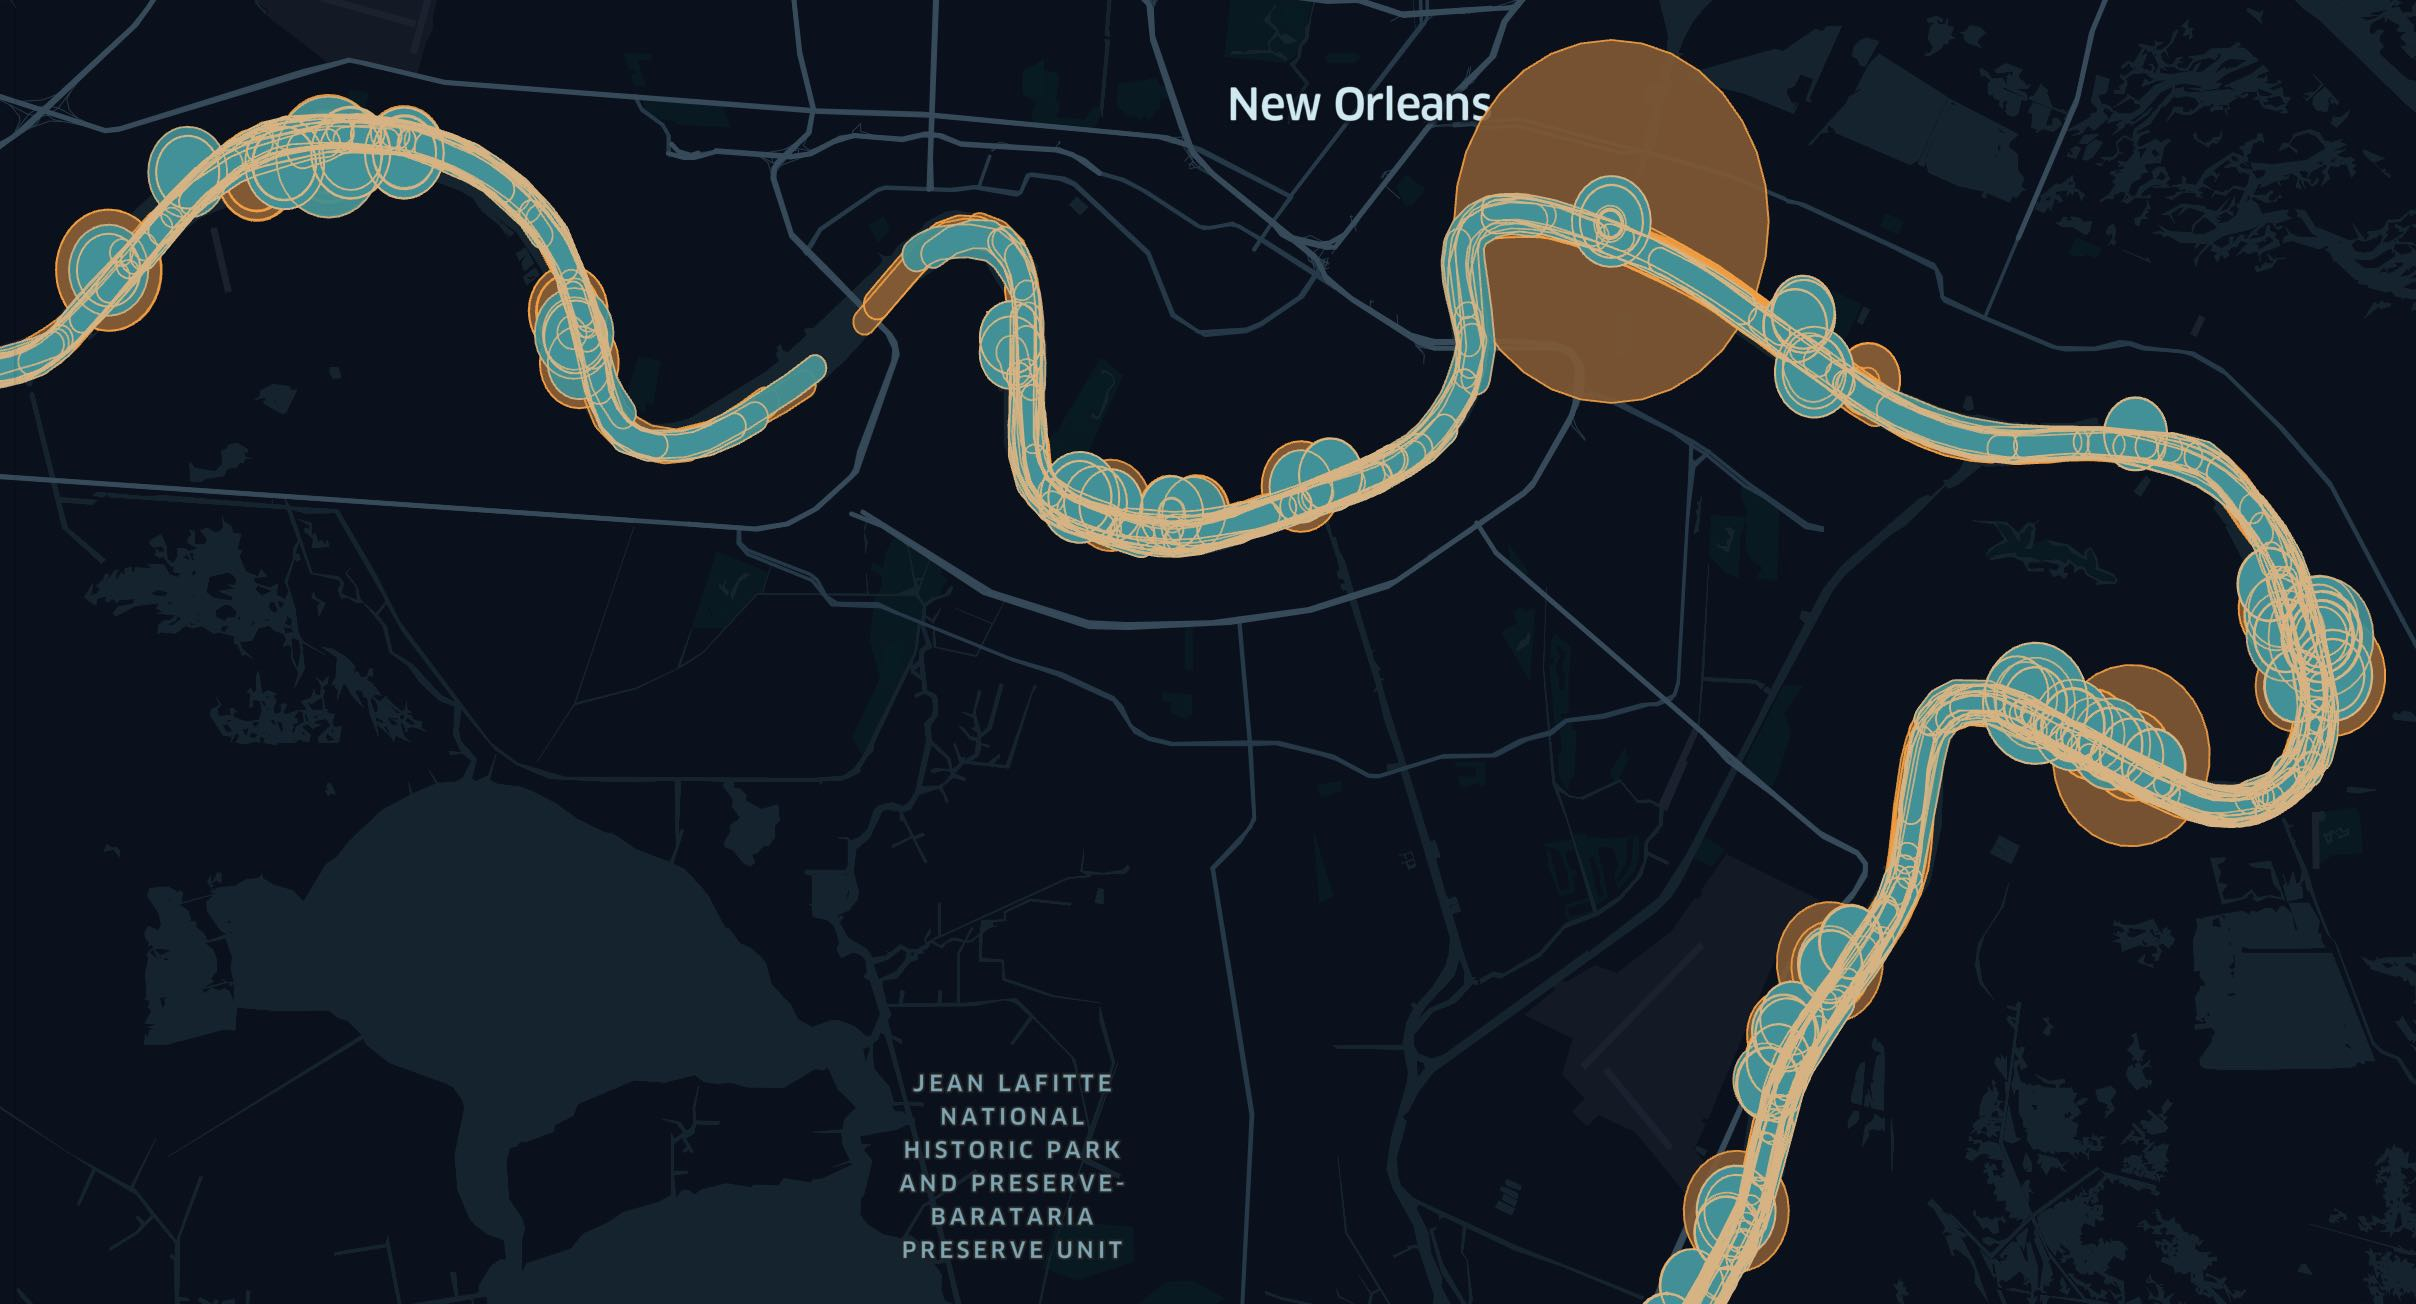

In [0]:
displayHTML("""<img src='data:image/jpeg;base64,/9j/4AAQSkZJRgABAgEASABIAAD/4QDoRXhpZgAATU0AKgAAAAgABgESAAMAAAABAAEAAAEaAAUAAAABAAAAVgEbAAUAAAABAAAAXgEoAAMAAAABAAIAAAITAAMAAAABAAEAAIdpAAQAAAABAAAAZgAAAAAAAACQAAAAAQAAAJAAAAABAAiQAAAHAAAABDAyMjGRAQAHAAAABAECAwCShgAHAAAAEgAAAMygAAAHAAAABDAxMDCgAQADAAAAAQABAACgAgAEAAAAAQAACXCgAwAEAAAAAQAABRikBgADAAAAAQAAAAAAAAAAQVNDSUkAAABTY3JlZW5zaG90AAD/4g0gSUNDX1BST0ZJTEUAAQEAAA0QYXBwbAIQAABtbnRyUkdCIFhZWiAH5wALABYACgARACNhY3NwQVBQTAAAAABBUFBMAAAAAAAAAAAAAAAAAAAAAAAA9tYAAQAAAADTLWFwcGwAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABFkZXNjAAABUAAAAGJkc2NtAAABtAAAAepjcHJ0AAADoAAAACN3dHB0AAADxAAAABRyWFlaAAAD2AAAABRnWFlaAAAD7AAAABRiWFlaAAAEAAAAABRyVFJDAAAEFAAACAxhYXJnAAAMIAAAACB2Y2d0AAAMQAAAADBuZGluAAAMcAAAAD5tbW9kAAAMsAAAACh2Y2dwAAAM2AAAADhiVFJDAAAEFAAACAxnVFJDAAAEFAAACAxhYWJnAAAMIAAAACBhYWdnAAAMIAAAACBkZXNjAAAAAAAAAAhEaXNwbGF5AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAbWx1YwAAAAAAAAAmAAAADGhySFIAAAASAAAB2GtvS1IAAAASAAAB2G5iTk8AAAASAAAB2GlkAAAAAAASAAAB2Gh1SFUAAAASAAAB2GNzQ1oAAAASAAAB2GRhREsAAAASAAAB2G5sTkwAAAASAAAB2GZpRkkAAAASAAAB2Gl0SVQAAAASAAAB2GVzRVMAAAASAAAB2HJvUk8AAAASAAAB2GZyQ0EAAAASAAAB2GFyAAAAAAASAAAB2HVrVUEAAAASAAAB2GhlSUwAAAASAAAB2HpoVFcAAAASAAAB2HZpVk4AAAASAAAB2HNrU0sAAAASAAAB2HpoQ04AAAASAAAB2HJ1UlUAAAASAAAB2GVuR0IAAAASAAAB2GZyRlIAAAASAAAB2G1zAAAAAAASAAAB2GhpSU4AAAASAAAB2HRoVEgAAAASAAAB2GNhRVMAAAASAAAB2GVuQVUAAAASAAAB2GVzWEwAAAASAAAB2GRlREUAAAASAAAB2GVuVVMAAAASAAAB2HB0QlIAAAASAAAB2HBsUEwAAAASAAAB2GVsR1IAAAASAAAB2HN2U0UAAAASAAAB2HRyVFIAAAASAAAB2HB0UFQAAAASAAAB2GphSlAAAAASAAAB2ABDAG8AbABvAHIAIABMAEMARAAAdGV4dAAAAABDb3B5cmlnaHQgQXBwbGUgSW5jLiwgMjAyMwAAWFlaIAAAAAAAAPMWAAEAAAABFspYWVogAAAAAAAAgwoAAD1u////vFhZWiAAAAAAAABL+gAAtCEAAArgWFlaIAAAAAAAACfSAAAOcAAAyJFjdXJ2AAAAAAAABAAAAAAFAAoADwAUABkAHgAjACgALQAyADYAOwBAAEUASgBPAFQAWQBeAGMAaABtAHIAdwB8AIEAhgCLAJAAlQCaAJ8AowCoAK0AsgC3ALwAwQDGAMsA0ADVANsA4ADlAOsA8AD2APsBAQEHAQ0BEwEZAR8BJQErATIBOAE+AUUBTAFSAVkBYAFnAW4BdQF8AYMBiwGSAZoBoQGpAbEBuQHBAckB0QHZAeEB6QHyAfoCAwIMAhQCHQImAi8COAJBAksCVAJdAmcCcQJ6AoQCjgKYAqICrAK2AsECywLVAuAC6wL1AwADCwMWAyEDLQM4A0MDTwNaA2YDcgN+A4oDlgOiA64DugPHA9MD4APsA/kEBgQTBCAELQQ7BEgEVQRjBHEEfgSMBJoEqAS2BMQE0wThBPAE/gUNBRwFKwU6BUkFWAVnBXcFhgWWBaYFtQXFBdUF5QX2BgYGFgYnBjcGSAZZBmoGewaMBp0GrwbABtEG4wb1BwcHGQcrBz0HTwdhB3QHhgeZB6wHvwfSB+UH+AgLCB8IMghGCFoIbgiCCJYIqgi+CNII5wj7CRAJJQk6CU8JZAl5CY8JpAm6Cc8J5Qn7ChEKJwo9ClQKagqBCpgKrgrFCtwK8wsLCyILOQtRC2kLgAuYC7ALyAvhC/kMEgwqDEMMXAx1DI4MpwzADNkM8w0NDSYNQA1aDXQNjg2pDcMN3g34DhMOLg5JDmQOfw6bDrYO0g7uDwkPJQ9BD14Peg+WD7MPzw/sEAkQJhBDEGEQfhCbELkQ1xD1ERMRMRFPEW0RjBGqEckR6BIHEiYSRRJkEoQSoxLDEuMTAxMjE0MTYxODE6QTxRPlFAYUJxRJFGoUixStFM4U8BUSFTQVVhV4FZsVvRXgFgMWJhZJFmwWjxayFtYW+hcdF0EXZReJF64X0hf3GBsYQBhlGIoYrxjVGPoZIBlFGWsZkRm3Gd0aBBoqGlEadxqeGsUa7BsUGzsbYxuKG7Ib2hwCHCocUhx7HKMczBz1HR4dRx1wHZkdwx3sHhYeQB5qHpQevh7pHxMfPh9pH5Qfvx/qIBUgQSBsIJggxCDwIRwhSCF1IaEhziH7IiciVSKCIq8i3SMKIzgjZiOUI8Ij8CQfJE0kfCSrJNolCSU4JWgllyXHJfcmJyZXJocmtyboJxgnSSd6J6sn3CgNKD8ocSiiKNQpBik4KWspnSnQKgIqNSpoKpsqzysCKzYraSudK9EsBSw5LG4soizXLQwtQS12Last4S4WLkwugi63Lu4vJC9aL5Evxy/+MDUwbDCkMNsxEjFKMYIxujHyMioyYzKbMtQzDTNGM38zuDPxNCs0ZTSeNNg1EzVNNYc1wjX9Njc2cjauNuk3JDdgN5w31zgUOFA4jDjIOQU5Qjl/Obw5+To2OnQ6sjrvOy07azuqO+g8JzxlPKQ84z0iPWE9oT3gPiA+YD6gPuA/IT9hP6I/4kAjQGRApkDnQSlBakGsQe5CMEJyQrVC90M6Q31DwEQDREdEikTORRJFVUWaRd5GIkZnRqtG8Ec1R3tHwEgFSEtIkUjXSR1JY0mpSfBKN0p9SsRLDEtTS5pL4kwqTHJMuk0CTUpNk03cTiVObk63TwBPSU+TT91QJ1BxULtRBlFQUZtR5lIxUnxSx1MTU19TqlP2VEJUj1TbVShVdVXCVg9WXFapVvdXRFeSV+BYL1h9WMtZGllpWbhaB1pWWqZa9VtFW5Vb5Vw1XIZc1l0nXXhdyV4aXmxevV8PX2Ffs2AFYFdgqmD8YU9homH1YklinGLwY0Njl2PrZEBklGTpZT1lkmXnZj1mkmboZz1nk2fpaD9olmjsaUNpmmnxakhqn2r3a09rp2v/bFdsr20IbWBtuW4SbmtuxG8eb3hv0XArcIZw4HE6cZVx8HJLcqZzAXNdc7h0FHRwdMx1KHWFdeF2Pnabdvh3VnezeBF4bnjMeSp5iXnnekZ6pXsEe2N7wnwhfIF84X1BfaF+AX5ifsJ/I3+Ef+WAR4CogQqBa4HNgjCCkoL0g1eDuoQdhICE44VHhauGDoZyhteHO4efiASIaYjOiTOJmYn+imSKyoswi5aL/IxjjMqNMY2Yjf+OZo7OjzaPnpAGkG6Q1pE/kaiSEZJ6kuOTTZO2lCCUipT0lV+VyZY0lp+XCpd1l+CYTJi4mSSZkJn8mmia1ZtCm6+cHJyJnPedZJ3SnkCerp8dn4uf+qBpoNihR6G2oiailqMGo3aj5qRWpMelOKWpphqmi6b9p26n4KhSqMSpN6mpqhyqj6sCq3Wr6axcrNCtRK24ri2uoa8Wr4uwALB1sOqxYLHWskuywrM4s660JbSctRO1irYBtnm28Ldot+C4WbjRuUq5wro7urW7LrunvCG8m70VvY++Cr6Evv+/er/1wHDA7MFnwePCX8Lbw1jD1MRRxM7FS8XIxkbGw8dBx7/IPci8yTrJuco4yrfLNsu2zDXMtc01zbXONs62zzfPuNA50LrRPNG+0j/SwdNE08bUSdTL1U7V0dZV1tjXXNfg2GTY6Nls2fHadtr724DcBdyK3RDdlt4c3qLfKd+v4DbgveFE4cziU+Lb42Pj6+Rz5PzlhOYN5pbnH+ep6DLovOlG6dDqW+rl63Dr++yG7RHtnO4o7rTvQO/M8Fjw5fFy8f/yjPMZ86f0NPTC9VD13vZt9vv3ivgZ+Kj5OPnH+lf65/t3/Af8mP0p/br+S/7c/23//3BhcmEAAAAAAAMAAAACZmYAAPKnAAANWQAAE9AAAApbdmNndAAAAAAAAAABAAEAAAAAAAAAAQAAAAEAAAAAAAAAAQAAAAEAAAAAAAAAAQAAbmRpbgAAAAAAAAA2AACuAAAAUgAAAEPAAACwwAAAJoAAAA2AAABQAAAAVEAAAjMzAAIzMwACMzMAAAAAAAAAAG1tb2QAAAAAAAAGEAAAoEQAAAAA2ZNdgAAAAAAAAAAAAAAAAAAAAAB2Y2dwAAAAAAADAAAAAmZmAAMAAAACZmYAAwAAAAJmZgAAAAIzMzQAAAAAAjMzNAAAAAACMzM0AP/qAVBBUk9UAAAAAABRRwYAAJkLAABWEgAADBoAAF4iAAAeLwAAJ0AAAF1QAAAaYAAA3G4AAKJ7AAA0iwAAgJsAAK6tAAADvwAAGM4AAGXcAABw6gAAQPgAAGYFAQDrEgEApSABAEQtAQB5OgEA9kcBAOdVAQDVYwEAu3IBAPODAQAAkgEA8Z8BALGuAQA7vAEAa8gBAETSAQBp2gEAsOIBABLsAQD79QEAZP4BAMgHAgBrEgIAnB0CAPspAgCdNwIA4EQCAFRRAgByXAIAoWcCACVxAgBReQIAioACAJWHAgCSjQIAnpMCAL+ZAgD0oAIAk6cCAKCuAgDMtQIA+LsCAFTCAgAUyQIAec8CAM3VAgCL3AIA++ICAH7sAgDS8wIAIPwCAL0DAwBcDQMArRUDAOsfAwB0KQMAkDEDAHA7AwB7RQMAbFADAOJWAwAHXgMA/8AAEQgFGAlwAwEiAAIRAQMRAf/EAB8AAAEFAQEBAQEBAAAAAAAAAAABAgMEBQYHCAkKC//EALUQAAIBAwMCBAMFBQQEAAABfQECAwAEEQUSITFBBhNRYQcicRQygZGhCCNCscEVUtHwJDNicoIJChYXGBkaJSYnKCkqNDU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6g4SFhoeIiYqSk5SVlpeYmZqio6Slpqeoqaqys7S1tre4ubrCw8TFxsfIycrS09TV1tfY2drh4uPk5ebn6Onq8fLz9PX29/j5+v/EAB8BAAMBAQEBAQEBAQEAAAAAAAABAgMEBQYHCAkKC//EALURAAIBAgQEAwQHBQQEAAECdwABAgMRBAUhMQYSQVEHYXETIjKBCBRCkaGxwQkjM1LwFWJy0QoWJDThJfEXGBkaJicoKSo1Njc4OTpDREVGR0hJSlNUVVZXWFlaY2RlZmdoaWpzdHV2d3h5eoKDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uLj5OXm5+jp6vLz9PX29/j5+v/bAEMABgYGBgYGCgYGCg4KCgoOEw4ODg4TGBMTExMTGB0YGBgYGBgdHR0dHR0dHSMjIyMjIykpKSkpLi4uLi4uLi4uLv/bAEMBBwcHDAsMFAsLFDAgGyAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMP/dAAQAl//aAAwDAQACEQMRAD8A+as08Hcvln8Pr6UykPSugyFooooAKKKKACiiigAooooAKKKKACiiigAooooAKKK1NLsDdy73H7pDz7n0oBuxp6NZiNDezcEj5c9h3P41kajem8nLD7i8KP6/jWrrN+FH2KE4/vkenp/jXNU32JiurCiiikUFFFFABRRRQAUUUUAFFFFABSqdrBvSkooAuswYBx0P6H3pKrRuUPqD1FWBtySn3aAQtFFFABRRRQAUUUUAPDsKeJR3FQ0UAWAynvQUU9qr0oJHQ0ASGL0NMKMKcJD35p4kU9eKAIKKs/K3vTTGp9qAIKKkMZ7UwqR1FACUUUUAKoyQKnc4U1HGOc+lLKegpgVJT0FQ0+Q5Y0ykAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAqsUYMOoOa6vXhm0Rh2cfqDXJ112oHzdHEh/uo354/xpomW6ORooopFBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQBuaCP9Kc/wCx/UU3XT/pi+yD+ZqTQB+/kP8As/1qDWzm++iiq6EfaMiiiipLCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKALcPELEe/8qqVbT5bcn1z/hVSgSCiiigZLDNJbyCWI4YV21rOt/aiTG0ngj0IrhK6zQWzaOvo5/kKqLImtDI1OXDC3HG0fMKyq0tXGNQl/wCA/wDoIrNpMqOwUUUUhhRRRQAUUUUAFKv3qSnJ1oB7ElFFFBkFFFFABTipAB9aVVzknoKQkk5NACUUCloFcVZHT7jEfQ4qwt/eIPllb8Tn+dVqQDLAepoBamkdYvYyFyGwBnI7/hipk1+YffiU/Qkf41hM25i3qabTuzXlR0R8QP2hH/fX/wBamHX5u0S/mawKKLsOVG6dfue0afr/AI0g166z8yIR7Z/xrDoouw5UddBrlrJxKDGfzH5j/CrDWmnXy71Ct/tIcH9P61xNOV3Q7kJU+o4p8wuTsdDPoB628n4N/iP8KyJ9PvLcZkjOPUcj9KswazexcMRIP9rr+dbEGuW0nEymM/mKNBe8jkqK7drbTr8bgFc+qnB/T+tVP7Btc/ffH4f4Uco+dHLL91vp/UVpQc6bKPc/0rcXRLNc/fORjk//AFqsx6daRxGEKSrdQSaEiXJHNXH/ACDofqP5Gsqu9NjaeWIjGCq9Ac1GbbTY/vJEPrj+tDQKZw1Fdx5ulx9DCPptpP7R02PpIo+gP9BRyj5/I4tYpH+4pP0GalFpdHpC5/4Ca63+2NP/AOen/jp/wqJtbslzjcceg60WQcz7HNDT71ukL/iMVKNK1A9Ij+JA/rWy2vwj7kbH6kD/ABqFvEDfwwj8W/8ArUWQXl2M46RqAx+7zn0I/wAalTRbwjLjHsCCf51M2v3P8MaD65P9aiOuXp6BB+H/ANejQfvE6aNcA8Kg93OT+Q4retLb7MmGbcx79sew4FV9NlvLiPz7kgKfugDH41m6xqPWzhP++R/L/GnsRq3Yp6rqBupPJiP7pT/30fX/AArIooqDVKwUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFWrY8lfxqrUsLbZB78UAzQooopmYUUUUAFVppsfKnXuaWeXaNqnmqVBSQUUUUigooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAN3QrffO1ww4jGB9T/8AWqvrFz592UB+WP5R9e9bkYGmaXuP38ZP+83+FccSScnqap7WJWruFFFFSUFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRSqdrA9cVdAinGcc/rQDZRoq00CoCxOQBxVWgEwooooAOnIq9DNv+VvvfzqjR05FANXNWiqkdx/DJ+dW+vIpmbQUUUUAH1ooooAKKKKACio3crwFLVGryucBdo75oCxOQGGG6VCZFZThSR2GKmHA5OaWgDLJBOQMVJFH5jew61M1tliQcCpIojGTznNIu5//0PmqkPSlpD0roMhaKKKACiiigAooooAKKKKACiiigAooooAKKKs2trLdyiKIfU9gPegBbS1kvJhEnTqT6Cuou54tLtBHCMMeEH8yacBa6Pa+pP5sa5O6upLuYyyfQDsB6VWxHxMgJLEsxyTyTSUUVJYUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUqsVORSUUAWlYN0p1UwSORU6SZ4PWgCWiiigAooooAKKKKACiiigAooooAKcHYd6bRQBKJfUU8Op71XooAslVPamGMdjUQJHSnb2xg0ASRjC59ajc5aph8q/Sq1AFRvvH60lK3JJpKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACuuX99of0jP/jv/wCquRrrtL/e6WYv95fz/wD11USZnI0UUVJQUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAdD4fH7yU+w/rVLWTm/f2A/lV/w+OZj/ALv9aztXOdQl/D+QquhC+IzaKKKksKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAtn/AI9v8+tVKtyZEC49s1UoEgooooGFdL4fbiZP90/zrmq3dAbFzInqmfyNNbilsV9aGL9j6gfyrKrZ1wYvQfVB/M1jUMI7BRRRSGFFFFABRRRQAU9KZT070ClsPooooMwpaSigC3wY8J6VVpVYqcipW2yLvXqOtAENLTaWgVhaFHU+imkqVwFg474oHFFOiiig1CiiigAooooAKKKKAClUAkBjgetJRQBOJhF/x75U/wB4/e/D0qwNUv1XaJTj3wT+fWqFFFwsXhqF6x5mboe+O1XbKWee3mVnZmPAJJPUVkwI0kqqoySa3maOwtsDk9vc1SIl2RVvZxAqW6csozk9v/r1jEknJpzu0jl3OSetNpNlJWCiiikMKKKKACiiigArQ0y0F3chH+4o3N/hWfXWaHB5ds0x6yHj6CmkKTsibVL4WcIii4kYcew9f8K40kk5NX9Tn8+9kYdFO0fhVChsIqyCiiikMKKKKACiiigAooooAKKKKACiiigAooooAKKKKACgcciiigDUByAR3pahgOYx7cVNTM2FRyyeWue56VJWdK+989h0oGkRkknJ70UUUiwooooAKKKKACiiigAooooAKKKKACiiigAop6Rs5+X86cYZAcYz9KAuRUVeW3jAG4ZNO8iL0osLmM+ilYgsSowO1JQMKKKKACiiigAooooAKKKKAFXGRu6d6voIQcJjNZ9aEKhUB7mgUiKUxncHGGHT3qBkCop7nNaNMeNX+8OlMSZm0U5wA5C9BQiM5wKRQ2itDyY8YxUT24xlOvpQLmKlFHTg0UDCiiigAooooAKKKKACiiigAooooAK0NLtvtN4oI+VPmb8P/r1n11mjxLbWbXUnG/LH/dWmkKTsipr1zudLVei/M31PSueqWeZp5nmbqxzUVDBKyCiiikMKKKKACiiigAoopQCTgc0AJUjRlEBbqe1AzE/IGRVt085VY/LQJsoUUpwDgHIpKBhRRRQAUUUUAFKrFTlTg0lFAFl5BLF6EdRVaiigEgooooAKKKKACpY5Wj9x6VFRQBpqwcblp1ZschjOR+IrQVg43LTIaHUUUUCConjLcqxH41LRQBWaONBmVi1RNOSNqDaKSc5lI9KTyJMZxSL9Sb7RggdRjn61YV1cZU5rMqWFdzjnGKAaNAjIxWfKrq2GJI7VoVDP/qjTJTP/0fmqkPSlpD0roMhaKKKACiiigAooooAKKKKACiiigAooq/Y2Et6/HyoPvN/Qe9ANjLOylvZNsfCj7zdhXTvJaaRbBVGSeg7sfU0txcW2lW4jjAz/AAr6+5rkJ55LiQyynLGq2I+Idc3Mt1KZZTk9h2A9BUFFFSWFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUASJJjg9KnBB5FVKcrlelAFqimqwYcU6gAooooAKKKKACiiigAooooAKKKKACnIMsKbUsQ6mgB0hwv1qpI2Fx61YlPIFUXOWNADaKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACur0Bs20iej5/MCuUro/D7czJ/un+dOO5M9jAmXZK6f3WI/I1HVzUF2Xsw/2ifz5qnSKQUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAdN4fHyzH3H9ayNTOb+X6j+VbOgD9zKf8AaH8qw9QOb2Y/7RqnsQviZToooqSwooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigCy0hMWxlI6VWq7If9HGepAqlQJBRRRQMK1dFbbfqP7ykfpn+lZVT2sxt7hJv7p5+nf9KED2NjX4yJo5uxXb+Rz/WsCu11WEXFixXkp84/D/61cVTkTB6BRRRSKCiiigAooooAKkTpUdSr90UEy2FooooICiiigBQCTgd6sbkjATr61EhwrY60ygC0Ikx61C8RXkcihJCgx1pTMx6cUARVJPxEqnr/APWpUwoMrdqrSOZGyfwoKihlFFFBYUUUUAFFFFABRRRQAUUUUAFABJwKK2NOtf8Al4k/4CP600hN2LFrAlnCZZeGIyfb2rGubhriQueB2HoKs3935z+Wh+Rf1NZ9DYorqwooopFBRRRQAUUUUAFFFFADkRpHWNeSxAH1NdzMy2NiSv8AyzTA+vQfrXN6LB5t35h6RjP49BWjr0+2NLcfxHcfoKpbXIlq7HL0UUVJYUUUUAFFFFABRRU0FvcXUgito2lc9FQFj6dBSbtqxpXIaK7S08C6xKBJqDR2MZzzM3zH0woyeT9K6CLwz4YtF2yme9fu2REnHoBk8+9ck8fSWid/T+rHTDB1Hq1b1PK6K9jjs/DsGfI0qLrn947yf+hGraXUEIxbWVpD/uQr/XNYvMe0H+H/AATZYHvL+vwPFY4ZpjthRnPooJ/lV06Pq4QSmznCEZDeW2CPrivYzrGpEBRMVA7KAv8AICoRqWoBt32iXP8AvGs3j6nSK+//AIBawUOsn93/AATxNkdDhwVPuMU2vdRrOo42vIHHo6q38xVZp7SXi40+zl9S0Iz+YxVLMJdYfj/wCXgV0l+H/BPE6K9ffT/Dc3MumID6xyOn6ZIqjceFPDl4M2k81i/o482P6cYb860WYw+1Fr+vIzeBl0af9eZ5dRXXX3gnXLSNp4ES8hUZL27b8f8AAeGz+FcpJHJE5jlUo6nBVhgg+4NdlOtCorwdzmnSlDSSsWLY8MKtVXtvuH61YrUwe5BO+1No6tVGpZm3SH24qKkUkFFFFAwooooAKKKKACiiigAooooAKKKeiM5wtADKsx25PL8e1TxwrHz1PrUtMlyEACjA6UtFFBIVBO+1MDq1T1nzPvc46DgUDSIqKKcil22ikWIAScAZp5hkAziryIIxgU+nYnmMogjg0VenYKmDyT0qjSKTCiiigAooooAK1AMDA7Vl1dt5Ny7T1FApFikOMcnHvQzBVLHtVGWbzABjGKZKRG67TgEH3FW7d2YEMc4qlTlZkO5aRTRp1FLKIxjqajW5U/eGKimAY+YpyD+lMlLuQsxY5PWkoopFhRRRQAUUUUAFFFFABRRRQAUUUUAKAWIA6mux1Ii20wxr6BB/n6VzOnx+bexJ/tZ/LmtnX5flihHclj/IVS2Jlukc1RRRUlBRRRQAUUVNHEsg+9g+lAENFTtbyDpg08KiR/vh34oC5VqzBhQ0h6CotvmNiNcCnOwC+UnIHU+tAmRlstubnmrST7m5wqgZqnRQNoDjPHSiiigAooooAKKUAk4AzVpYFVcyfpQDZUopSMGkoAKKKKACiiigAooooAKKKKACnxyGM5H4imUUAaaurjctOrNR2jORWgjq43LTIaHUUUUCGlELbiOaguGKgKO/WrNRTRh1z3FA0Z9FFFIsvwxqqhhyT3qaqsCyKc/wmrWaZDP/0vmqkPSlpD0roMhaKKKACiiigAooooAKKKKACiitjTdLa6ImmysX6t/9agG7Eenaa94298rEOp9fYVv3l7BpsIhhA34+VR29zTb+/isIxBCBvxwo6KPeuQd3kcySEsx5JNVsQlfVjpZZJ5DLKdzHqajooqSwooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAAEg5FWEkDcHg1XooAuUVHD5kh2qpY+wzWlFpt5L/BtHqxx/wDXosDZRorei0XvNJ+C/wCJqdrXSoR5cjKG/wBpuf50+UnnRzVFdCdKtZBuhkI+hBFVn0acf6t1b65FFmPmRj0VbksbuL70Z/Dn+VVCCDg0hhRRRQAVKjqBg1FRQASN1aqdTynC49agoAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAdsNG009TxSk4GaCOZke1qaQR1p+/2prHNBSv1EooooGFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABW3oLYunX1T+RFYlXdOl8m9ifsTg/jxTQpbFjWoyl8zf3wD+mP6VlV02vxZWKYdiVP48iuZoe4RegUUUUhhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAHV6AP9Gc/wC3/QVzt6c3k3++3866TQhizb3c/wAhXM3Rzcyn1dv51T2JW7IKKKKkoKKKKACiiigAooooAKKKKACiigAngUAFFOK7cZptAJhRRRQAUUUUAFFFFAFubiFR9P5VUq3c9FH1qpQJBRRRQMKKKKAO20uYXFim7kqNh/D/AOtXIXUJt7h4T/CcD6dv0rY0GfbK9uejDcPqKNeg2ypcDow2n6iqexC0djAoooqSwooooAKKKKACplHQdKhpcn1oE1ct7Yf7xpu2PP3uKrbmpd5oJ5WW/wBz/nNITD6Gq280b/agLMtBohnAPNIIw33Tx+tV94pQ4HIOKBWZIyFDg0ypPOBUhuaakbScnhf50BYc5xbj3qrU0zgnYv3VqGgtBRRSqcGgYuw0bDUmR60ZHrQRzMj2GkKkVLketNZgOlAJsjooooLCiipYYnnkEadT+lAFiytTcSZb7i9ff2q9qF0EX7PFwe+Ow9KmmkjsLcRx/e7f4mufJLEsxyTVbErV3EoooqSgooooAKKKKACiiigAoorb0zSzcET3AxGOg/vf/WoSBuxq6LB5Vp5h6yHP4dBXP6pP5965HRflH4f/AF63tS1JbRfs9vjzMY46KP8AGuRJJOTVPsRFdQoooqSwooqzaWd1fTi2s4nmkboqAk/Xjt70m0ldjSvoitXQ6L4a1LWyZIVEVugy88mQgA6gHHJ9hXX6f4R0/SWMuuuLqcDi2jzsU9t78Z+g/Wty6vZ7vAkwqL91FGFX6CvMrY++lH7/APLv/W56FLBW1q/cY9p4X8OWGGvJJNQlHVV/dxZ+v3j6e9bq6g1vH5GnRR2ceMEQqFJx3J6k+9Z9FcM7z1m7/wBdtjsjaPwKw5mZzuckk9zTaKKYBRRRQAUUUUAFFFFABRRRQBJHLLCweJijDuDirM91b3426vaxXY/vMNr8dMOvNUqKlxTdxqT2KknhXQrgE6fcyWjnJ2TjemT2DDkD3Oa5DVdH1DSJTBeR7SRlHHKN7g967wVdivnSJrW4VZ7dxhopOR+HofpXRSxVWn15l5/5/wCZzVMLTnsrP+un+R4iylDgkH6U2vRdS8FxXQa58NuX4Ja1kP7wY/unow/X6157JHJE5jlUo6nBVhgg+4NepRxEKq91nBVoSpv3hlFFFbmIUUU5UZvugmgBtFWFtnP3jiplt4x15oFdFHr0qVYZG7Y+tXwqr0GKWnYXMVVth/EfyqZYY17Z+tSUUCuRNBGe2PpUgUKMKMUtFAgooooAKKKKAI5X2IT36Cs6p7h9z4HQVBSLSCrNsPmLVWpysyHKnFA2adFRxv5ibu/emzEnEa9W/lTM7FVy00ny/hUZBU4PBrRjjEYwOvrSuiuMMKCuYzKKmkhZORyKhpFBRRRQA+NDIcCrK7bdcMcsfSqdFANEkkrSdeB6VHRRQAUUUUAFFFFABRRRQAUUoBPQUlABRRRQAUUUUAFFFFABRRRQBt6DHuumkPRF/U1DrMvmXzL2QBf6/wBa1dBj22zyn+JsfgB/9euank86Z5f7zE/nVPYlbkVFFFSUFFFPRGc4WgBlWYV2gykZ9BTfIfcAenrV0AAYHaglsq+bJF8rjJPNT4jk689/zqjI29y3rVi2fqh+opg0BdMmFRgHjPvVSrM8bBt45BqFFMj4/OkNDKKtyhVG1Ao9fWq8ZcNiPqaB3GhWPQE1KkDMfmGBVkzAHaPmb2qFrh8kAAUCuy0qKowBQGUttHUVVjmlY7cbqsKuwFnPJ6k0yWiSiqr3POEH500XLdwKAsy2yhhhuRVCWIxn1B6Grcbu/JXA9c09ygHz4x70AnYzKKc+zcdnSm0iwooooAKKKKACiiigAooooAKcjshytNooA0o5BIMj8RT6zFYody1oRyCQZH4imQ0Pqtcltox071ZoIBGDQJGVRU80Oz5l+7/KoKRoTQy7Dhvu/wAqv9eRWVT1kYLs/h9KBNH/0/mqkPSlpD0roMhaKKKACiiigAooooAKKK6PTNJzi4uhx1VD/M/4U0hN2IdM0ozYnuRhOoX+9/8AWrS1HU0tF8iDBkxj2X/PpTNT1QW4NvbnMnQn+7/9euUJJJJOSabdtESlfViszOxdzknkk02iipLCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiinxxySttjUsfQDNADKK14dFvJeXxGPfk/kK1odDtY+ZSZD+Q/If407MTkjk1VmO1QST2FaMOk3s3JTYPVuP0611gFpZp/BGPwFUJtatI+I8yH2GB+Zp27k8zexVi0Bes0hPsox+prRj0ywgG4oDju3P8+KwptcupOIgIx+Z/X/CsuWeaY5lct9TRdBZvc6+TU9PthtVgcdkGf8A61Zk2vueIIwPduf0Fc9RS5hqCLc1/eT/AOskOPQcD9KqUUUihysyHKEg+1XYtUvoeBIWHo3P8+aoUUBY6GLX5BxNED7qcfoc1dGq6bcDEwx/vrn+Wa5GinzE8iOx+w6bcjMDD/gDZ/Tmq0mit1ikB9mGP1Fcv05FXItQvYfuSt9Dz/Oi6Cz6MvSadeR9U3D1Xn/69UmVkO1wQfQ1oRa9cL/rUV/pwf61oJrNjMNs6lf94ZH6f4U7ILvsctKctj0qOuv+yaRecxldx/unB/L/AOtVWXQF6wykezDP6j/Clyhzo5qitSXRr6Poocf7J/xxWfJDLEcSoy/UYpWKuR0UUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFADlOOtSAgioamAA6UESIaKcw5ptBaCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKASDkdRRRQB2V8Bd6WZB/dDj8OTXG12GkOJ9P8pudpKn6Hn+tcjIhjkaNuqkg/hVMmPVDaKKKkoKKKKACiiigAooooAKKKKACiiigAooooA6/Qxiy+rGuUmOZnPqx/nXXaMMWC+5P8645jlifU1T2JjuxKKKKkoKKKKACiiigAooooAKKKVeooAeE9aeAB0paKDFtsjcE4qOpzRQUpWRBRTmGDTaDRBRRRQAU5BlgPU02nxDMi/WgCa5PzAe1VqnuDmTHoKgoBbBRRRQAUUUYJ6UAWLSb7Pcxzf3Tz9O/6V2GpwfaLJwOSo3D8P8A61cRgjmu30yb7RZITyVG0/h/9aqj2In3OHoqzeQfZ7mSHsDx9DyKrVJYUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAVZhk/wCWbdD0qtRQDHyRmNsH8DTKtowmTy3PzdjVZlKNtagExtFFFABRRRQAUUUUAFFFFACgEnA5JrfgjSwtzJJ949f8BUGn2oQfaZfT5c+nrVK8ujcScfcXp/jVLQl6uxBNM88hkfqf0qKiipKCiiigAooooAKKKKACp4og6NI3QZx+R/rioK6bTtNJRWuB8uPu+pJB/oKaQpOxV0zSzORcXAxH1A/vf/WrU1LUVtE8iHHmEfgoqTUr9bKLamDI3QenvXGMzOxdzknkk03oSlfVgzFiWY5J5JNJRRUlhRRXeeGvDMUiLrGtqVthzFCeGmP/AMR6nvWVatGlHmka0qUqkuWJT0XwjcahbrqF/KLS0bO1iMu+P7q+/rXeRSWenRG10SEW0RGC/WV89dzHP5Cku7yW8kDyYAUYVV4VQOwFVa8WpUnVd6n3dP8AgnrU6caekPvCiiipKCiiigAooooAKKKKACiiigAooooAKKKKAClFJSigB1Mpx6U2gQ5WZGDISCOhHBqa8i03XIxDrUf7wDCXMYAkX0Df3h9ar06k1rdbjvpZ7HBaz4Wv9ICz7kntpDhZo+mfRh1U+1Yi2394/lXsltcrEr29wgmt5htkjboR6j0I7GuO8Q+Hv7NIvrAmWxlPyt3Q/wB1vf0r0cLjLv2dXfo+/wDwTzsThbLnp7fl/wAA5JYo16D86koor0jzwooooAKKKKACiiigAooooAKKRmCqWPaqq3J/jH5UDsW6a7bELelIsiP901WuXyQg7c0AkVuvJooopFhRRRQA9JHT7pq7ECRvbq1U4k3uB271o0yZBRRRQSFQSQK/K8Gp6KAMxkZDhhim1qMqsMMM1TktyvKcj9aRakV6KKKBhRRRQAUUUUAFSxxGQEg9KiqWKTyyT1zQDI2UqcMMGpoofM5J4qUlZ0wOGHaoljnX7oIz70CuXVVVGFGKY0aP1HNVCsm4JITz+NW1jVGLL3GKZLK0kGwFgePeq9Wrndken9aq0ikFFFFAwooooAKKKfGhkkWNerEAfjQB1if6Joueh8vP4v0/nXIV1euOI7NIV43MBj2H+RXKDk4pyJh3CirbWw/hP51A8Tpyw49aRVyOpvOwgRBj1NQ1b8qLHmZ+WgTCBn27QOB0NWGBZSAcVTaduifKBTDNIerUxWHiKaMgr39KlCAzll7dfrTY5mU7Zc/WrQ2nle9ANlY3GR8uAfQ96jFww7DFWzFGeqim+TEO1AXRXKxSEsG257GnBfLUlPmY8cdqtBVHQAUtArlX/Uxf7TVDHCznngetaFFAXGqqoMLUDhpmwOFHf1qzTHdYxz+AoBFf7NyeeO1G2CI5J3H0qF5Xf2HpUYBPApFW7lhrhz93ioPmc+pNTpbs3LcVaSNU+7+dAXSIo4AvL8n0qCaLyzkdDU8nnkkIMD9aryoUI3ckjmgSIqKKKCgooooAKKKftDLuXt1H9aAGUUUUAFFFFABTlYody02igDSjkEgyPxFPrMVih3LWhHIJBkde4pkND+vBqnNDt+dOncVcooBMyqKtywfxJ+VVOnWkWmf/1PmqkPSrM1pc2/8Aroyvv2/PpVY9K6DIWiiigAooooAKACTgU+OKSVtsalj7V1em6ULbE8/MnYdl/wDr00ricrEOm6SI8XF0Mt1VfT6+9SapqfkL5FufnPVh2H+NF9qQ2usJ+ROGYdz/AHR/U1yjMXYs3JNNu2xKV9WJ15NFFFSWFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRVmGzurj/AFUZI9eg/M0AVqK6CHQZG5ncL7Lya1YtLsbcbiu4ju/P/wBanykuaOQit55ziFC30FasOh3L8zMEHp1P+H61ty6nY2427wcdl5/+tWVNr7HiCPHu3+A/xp2Qrt7GhDo1nFy4Mh/2v8BVp7mytBtZlTH8I/wFchNqF5P9+Q49BwP0qnRfsHI3udRNr0S8QIW9zwKyptXvZeA2wei8fr1rMopXKUUKzM53OST6nmkoopDCiirlpp2oX5xZW8s+OvloWx9cD3pOSSuxpN6Ip0V1MPgrxROMpYuP98qn/oRFLJ4I8VRZ32L8ejK38iaw+tUdudfejX6vV35X9xytFXbzTdQ08hb63kgLdPMUrn6Z61UUZPNbxkmrpmUk1uNoqTaKTZ6UyeZDKKKKBhRRRQAUUUUAFWYr27h/1crADtnI/I8VWooA2otduk4kVXH5H9P8K0E163I/eRsp9sEf0rlaKd2LlR139raZJ98f99Ln/Gj7Toj9RH+KY/pXI0U+YXIjrvL0STvEP+BY/qKP7O0iT7hH4Pn+tcjRSuHL5nXHQ7JuVZx9CP8ACom0CD+GRh9QD/hXLgkcg4qVbi4X7sjD6E07oOV9zdPh8/wzfmv/ANeom0C4/hkQ/XIrMW/vV6TP+JzUw1bUF/5a/mB/hS0C0idtDvR0KH6H/EVEdH1AdI8/Qj/Gnrrd8OpU/Uf4VMNeuh95EP5/409A94oNpt8vWFvw5/lURtLpfvROP+AmtlfED/xQg/Rsf0qZfEEf8URH0OaLILvsc0yOv3lI+optdYNetD1Rx+A/xp/9rabJ9/8AVc/40WQcz7HIUV1/2nRZOoj/ABTH9KPL0STvF+eP60WDm8jkKK6/+ztJk+5j8H/+vSHQ7JuhcfQj/CjlDnRyNFdS2gQfwyMPrg1EfD/92b81/wDr0uVhzo5uit5tAn/hkU/XIqJtCvR0KH6E/wCFFmPmRjVIGGOavto+oDogP0I/xqNtMv1GTEfwwf5UWB2ZTYgjimVYazu16wuP+AmomjkX7ykfUUgQyiiigYUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAHQaBLiWSE/xAMPw//XVHV4vKvn9Hww/H/wCvUemS+TfRN2J2n8eK1tfi/wBVMPdT/Mf1quhO0jm6KKKkoKKKKACiiigAooooAKKKKACiiigAooooA7PSfl01D/vH9TXGV2en/LpSn/ZY/qa4yqZMd2FFFFSUFFFFABRRRQAUUUUAFKv3hSUo4IoBk9FFFBgIaSlNJQMjbrTaU9TSUGyCiiigAqWD/Wioqnth+8+goBjZ/wDWmowMnFOk/wBY31NIvWgXQdsFLtFLRQRdhgUtJRQICMjFbegylZHt26MNw+o61iVZtJvIuEl7A8/TvTQX0saevwYaO5Hf5T/MVztd1qMH2izkQckDcPqOa4WiRcHoFFFFIoKKKKACnRxySyLFEpd2OFVRkknoABTa67wD/wAjppH/AF9R/wA6AZzl1p+oWO37bbywbvu+YjJnHpkCqlfeHi/wxaeLNEl0u5AVyN0MndJB0P07H2r4b1GwutKvptOvkMc0DlHU9iP6elBMZXC107Ub5S1lbSzheCY0ZsfXANUyCDg8EV9U/An/AJFq8/6+z/6AtfM+scavef8AXeT/ANCNA1K7aM6iuu0DwJ4p8SqJtLs2MJ6SyYRD9Gbr+Ga2tT+E/jbTLc3LWqzooywgcOwH+7wT+ANAXR5vRWjpek3+s6jHpVhHvuJSQqHjkAk9fpV7xD4X1rwtcR22tQ+S8q7kwwYEA4OCMjigdzBXduG3r2qzcEYCn71bvhrwtrniWaWPRYPOaFQz5YKADwOTjk1R17QtV8PagdP1iLyp9ofGQQQehBGR2oF1Maiuq8P+CvEfie3lutHt/NjhbazFgvOM4GevFczNDJbzPbyjDxsVYehBwaB3I6VVZ2CoCSeABTa+ufhj4K03w9oUWv6lGpvbiPzjJIP9VGRkAZ6cck0ClKx80QeEfFNzH5sGl3bqehEL4/lWXe6ZqWmv5eoW0tu3pKjJ/MCvp3UPjn4etrpoLO0nuUU48wFVB9wDzj64rsND8ReF/iTpU9v5PmKuFmt5wNy56EYz+BBoI52t0fEtXrG18997/cXr7+1dH4z8KyeGfE0uixEvGxDwMepR+mfcHj8Ks6z4X8TeHYbeO8s2jNz8sQXDknjjC555oRTfY5vULvP+jxHgfe/wrd8P+APE/iexbUdJgR4FcpuZ1X5lAJGCc960Jvhb4yt9Lk1e6tlijiQyMrON4Ucn5RntXuvwR/5Exv8Ar7k/9BWnuJuy0PkmRHikaJxhkJBHuKbVzUv+Qjc/9dX/APQjXS6D4A8V+JIxPp1m3kNyJZCEQ/Qnr+GaRdzjqK9E1b4VeNNIt2upLQTxqMt5DByAP9nr+Qrz6OKWWVYIlLSOQqqBkkngAD1zQCdxlFemWPwi8cXqeY1qluD086RVP5DJ/Oq2r/Czxno1s13NaiaJBljAwcgDvt6/pQLmR55RVuwsbrU72LT7JPMnmYIi+pNdrF8O/FcGrDTJbBpJwgkCqQU2ngEtnGMj1oG3YwNK0wsRdXA+Xqqnv7mtTUNQSyQKoy7ZwPT613F38N/HlrbNcR28UzAZ2JIC35HAP4GvHL1LyK6khv1ZJo2KurjBUjqMHpVXsZpXdyGaV55DI/U1HXQ6D4U8QeJpGTRrR5whwz8Ki/Vjgfh1rspfg144ij3rBDIQM7VlXP64FSXdI8soq3fWF5pl3JYahE0M8Rw6MMEGu98LaBb2ttHr+rJvLnNtAejY/jb29PXrWFevGlHmZvRoupKyI9A8LRQQJq+vIcNzBbHgvj+Jx2X27/Tr0lzcy3UpmmOSeAB0A7ADsBRcXE11M087bmb/ADgVBXjSnKcuee/5HrRhGC5YbBRRRSGFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFKKAFxRilooEFMpxptABRRRQMXNW7a7MAeJ0EsMo2yRtyrD/H0NU6KTSejBO2xz2veHhaKdS0zMlk3J7tET/C3t6H/J5SvVrW6e1kLKAyMNro3Ksp6giuL8U6DDp6pqukb/ALHMxDKefKfg7SfQ54r0MJi3dU6nyf8An5/mcGJwis6lP5o52iqIuJB1walFyp+8CK9M86zLNFNV1flTmnUCCiiigAooqnc53D0xQNILiQN8inI71WooAJOB3pFotwAIjSGqrEsSx71ZnOxBEPxqrQJdwooooGFFFSRxs5GBxQBbgTamT1NTU1QRyTk/pTqZmwooooAKKKKACiiigCKSFX56H1qk8bRn5vzrSoIBGDzQNMyqKtSW/eP8qqkEcGkWmFFFFABRRRQBZtlBJY9R0q5VO2ZRuBOKuA5GRTIe41lDYPcHNOprIrcnqOhFIN4/2h+RoEPIBGDVGSHZls4HarLKH6MVP1qnKrq21iT6UFIYAScDvT5IzGfb1qe3j/5aH8KssMgjGfakDZl0UUUFBWjpUXm30fGQuWP4dP1rOrodAizJLMewCj8ef6U0KT0I9ek3XCRdkXP4n/8AVWNEMyKPxqzqMnm30rf7WPy4/pUVsMuT6Ch7gtEXarXJwoX1NTs6L944qlNIHb5egoJSIgCTgd6uLGIo2LHqKiQwbRv6/jT5ZFdQiHJJpFMqU+MAuNxwKaQVODwaSgZbknjPRdxHTNOCSyfM7bR6Cmww4+d/wFWSQoyegpkPyEVAvT8zSlgAT6DNU3uGbheP51NChVSX6tQFu437Rk4RSaQXI7r+VWqrfZyD8jEUBoPFxGeuR9amByMiogkg/jz+FPwT3x9KAY6qU6ovcljVrZnqx/PH8qQwxnkjNAJlVIkJG5hz2FXFRU4UYpvlR4xtFPAC8ZoBsWio97FsKucdzxUH2o/3f1oCxbqGSEOcljULvIpDqeGAPtTlnD/K65+nNAWYwGOI5U7j+lQtkscjHtWgsaL90VVuR84PtSGmV6KKKCgpybtw29alSHd/EPwqRIsEhDz3b09hQK5DKoDEr2646A1FWmqKq7QOKpTReWcjoaATIaKKKBhRRRQAU5WKHctNooA0Y5FkHHX0qSssEqcjgir8UokHoR1FMholpCAeDzS0UCP/1fGodXt5RhlPuBz+n+GaHtdLvlJj27v9g4P5f/Wrj+lXElEy7JBlx91hwT7Z9a6rnPy9jVl0BusEgI9GH9RWfNp0tvzNuA9QuR+dTQ397EMwyeao/hbk/wCP5GtGDXo2+WeMqfVef0o0DU53Fv8A3mP/AAEf409AjOEhjLueBn/AV1jQaZenGFL9Tj5W/EcH86ntrG2tCTEvJ7nrRyhzkNjZfZk3zEF/bhV+g/rWZf6kZ2NtathP439u+Pb+dWNTlumJgETCLHzPnGfx54rAYQsnlW7Y5yd3GfTB/wAcUMSXVjZnDwoEGEBIx+VVasKjbHhIwwIYD6ZzVepNEFFFFABRRRQAUUUUAFFFFABRRRQAUUqqzHaoyT2FaMOk3s3OzYPVuP060A2ZtFdTDoMS8zuW9hwKu/8AEtsP7iH82/xquUnn7HLw6beT8pGQPVuB+ta0Ogd7iT8F/wAT/hU02vQLxAhc+p4FZM2sXsvAYIPRf8aNBe8zo0s9PsxuKquP4mP+NQTa1ZxcR5kPsOPzNci7u53OSx9Sc02jmDk7m3Nrly/EKiMfmf8AD9Kypbiec5mdm+p4/KoaKVy0kgooopAFFFFABRRRQAVtaL4f1TX5xDp8RYZw0jZCL35OD/jWv4S8IXXiW43vmKzjP7yTuf8AZXPGfU9v0r2tbi10q1TTNFQRxRDG8d/XGfX16muWpWlKXsqOr6vov+D5GknClH2lZ6dF1f8AXcwdN8D+G9DjV9WH2y54JDcgcdl6Yz/ezXSHWFhTyrGBIkHTj8+BgViEknJ5JoAJ6VcMvp/FV95+f+R5lbN60vdpe6vL/M0m1fUDkCTbn0UD+lIur6gv/LXP1AP9KobGq1a6fdXj7IVz6seg+preVKjFaxVjkjiK85WjJt+rLg1dpUMN7DHPGwwQRjP17fpXN6j4N8M63ltOP9n3J6AD5D/wHoPwxXX/ANladaf8f9xub+4n+SaUTeH4+Bbu/vk/1NcMqVJvmoRafdbfjoz1KeIrw92vNNdm7v8ADVHzxrnhzVfD8/lahEQhOEkXlG+h9fY81gk4FfV811oOoWrWF5GWhYbSrgn8jyRXmOrfCiVwZ/D92ksbcrHLwfwYcH8QKdPEyjpXVvPudPs4T1oyv5djxiirl/p97pdy1nqELQTJ1Vhg/Ueo9xVRVZ2CICSTgAdSa7E09UTboJRXqOg/DDUr0C51lxZw9doILn6n7q/qfau4t/CHgbTdoeNrqRerMS2fqMhD+Ark+uRbtSTl6f5m0qPIr1ZKPr/kfO1FfSv9neDSQP7LTA77EzVKfwf4G1Jjsja0du4JUflkqPyqnXqLWVJ/gzOMqMtI1V+R870V6hrXwu1WzVrnSZFvIMZAzh8fyP5j6V5i6PG7RyKVZSQQRggjqCK1pV4VPhY50pQ+JDaKKK1MwooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAClBI6HFJRQBMtzcL92Rx9GNSrqF6vSZ/xOaqUUBY0Rq2oL/y1z9QP8KmXW74dSp+o/wAKyKKdxcqNxdeuv4kQ/TI/rWnaaqblGygDL2zXIVYtZzbzLJ26H6UJicV0OiXXUyQ8TAg4PNSjW7U9VcfgP8ayru0LMbiHkNyQP51mU22Z2R1f9qac/wB/9VpPP0eTqIz9V/xFcpRRzBY6vytGk/55fnij+zdKf7oH4Mf8a5Sii49TqTodkehcfQ1E2gW/8Mjj64Nc6GZehIqUXFwv3ZHH0JouguzXbw+P4ZvzX/69RNoE38Mqn6giqQv7xekrfic1Iuq3w/5aZ+oH+FGg+Zj20K8HQofxP+FRNo1+OiA/Qipv7avV/un6inrr9z/EiH6ZH9aNBpyKDaZfr1iP4YNRNZ3a9YX/AO+TWyviBv4oQfo3/wBapl1+L+KJh9CDRZDvLsc00Uq/eRh9RTK61ddsz1Vx+A/xqT+1tNf75/NTRZBzPscdRXY/atHk6+Wfqv8AiKPL0WT/AJ5fmBRyhzeRx1Fdj/Z2lSfdC/gx/wAaQ6JYnpuH0NHKHOjkASpDDqOa7DUQLrTDKvoHH+fpUDaBbfwyOPrg/wBK1IbYRWv2Vm3DBXPsaaRMpI4GiugOgS9pV/KmHQLjtIn61NmXzIwqK2zoN32dPzP+FNOhXo7p+Z/wosw5kY1Fa50S+9F/OmHRr8fwA/iKLMOZGXRWkdI1D/nn+o/xpp0q/H/LI/mP8aLBdGfRV46bfD/lk1MNhej/AJYv+VKw7oqUVZNleD/li/8A3yaabW5HWJ/++TQFyCipTBMOqN+RphR1+8CPqKAOxtvl0gH/AKZsf51xldkvy6N/2xP8q42qZMOoUUUVJQUUUUAFFFFABRRRQAUUUUAKCRUgOaiqVRgUEyFpaSiggiIxSU9+tMoNVsFFFFABVm2HzE+1QKuasw4QMfbP5UCb6FUnJye9OTrTKUHBoG9iWigEHkUUGQUUUUAFR7j2p5IFRUFRR3OmT/aLNGPVRtP1FcjfwfZ7uSIdM5H0PIrW0GfDyW5/iG4fh1p+vwf6u5H+6f5j+tU9UC0djm6KKKksKKKKACuu8A/8jppH/X1H/OuRrrvAP/I6aR/19R/zoB7H1b4w8ZxeEtR0pLsf6LePIkz90CgYP4E8+1cL8X/Ba6vYDxXpKh5oEHnBOfMi7MPUr/L6VnfH3/U6R/vTfySrHwd8bLe23/CI6s4Mkan7MW/jTvGfUjt7fSn5GKVlzI0fgT/yLV5/19n/ANAWvBtO0ga945XSW+7PeuHx/cDkt/46DX2H4b8M2XhiO7g0/iK5uGnC/wB3cANo9hjivmHwFLHD8U4zJjDXFwoz6kOBSY4vdntnxH8YTeBNJtLTQ4Y1lmykeVykaIB0HTPIxXEfD74ra9qviCDRtd2TR3RKo6IFZWwSPu8EHp0r0b4g+L9M8KLaNqWmi/FxvC52/Ltxn7ynrmvN4vjP4bgkEsHh8RuvRlMYI/EJTYktNiv4/s4PCPxG0vxFaKI47l1lkA4G5W2yH8VOfrXQfHTTxPpOn6ooz5EzRsfaRcj9Vryb4h+PIvG8tm0NqbZbUOPmbcSXx6Y9K9q11v8AhKfg8t4PmkS1jlOOfnhID/yNIdrWbKPwbji0vwlf67c/KssxOf8AYiXA/Umuf+POnj7RpmsRjIkR4WI/2SGX+ZrX19j4Z+DNpZL8kt0kSn1zKfNb9MipPEsMnjD4T6ffxDfPEYT/AMCDeS386YLe5rfDnHh34YPq0nykpPdH8Mhfz2ivk13aR2kc5ZiST7mvqvx5IPDfwqt9JU7Xligtse+Az/8AoJr5SpMqHVk1tF51zFCf43VfzOK+1fiLIdP8BaiIPl2wLEMdgzKn8jXxVby+TcRTf3HDfkc19rfEGI6n4C1E2/zbrdZlx3CkP/IUIU90fEVexfBG5kh8YPbqflmtpAw/3SpFeO17R8ErCWTxW93j5YbZyfbcQB+fNCKnsdL8aoUj17RroD5pFKE+u1wR/wChGvbfEF3pWk2TeINVUFbBWdT1OWwMAepOAK8M+NlwreIdFtQfmjUuR/vuAP8A0Gu3+NTsvglgDw1zED9OT/SmZ22PJtf+M+taxaXWnW9pDb29yjRZ5ZwrDB5yBnHtXqnwR/5Exv8Ar7k/9BWvkbtX1z8Ef+RMb/r7k/8AQVpIqaSWh8+eHNFTxB45i0uUbopLp2kH+whLN+YGK+hvib43u/BVnaWGiRIs04O1mXKxomAMDpn0ryD4XyxxfEsCQgbzcKufXBP9K9t+IPjTSvCk1rHqWmC/+0KxVjt+XaRkfMp9aFsEt0cR8OPilret67HoevbJRcBvLkRdrKygnBxwQfpXFfFbSIvDXjOLUtPQIlyFulUcASK3zce5AP411kPxo8OW8glt9AEbjoyGNT+YSsC+1eL4u+MdLsVt2tYI1YSZbLFB8zcjHYYH1oBKzvYoXXxn8bXUpNo0MC9lSMMfxLZr1z4WePNV8W/a7HWUQzWyq6yIu3crEggjpke1L4n8VeGPhisGl6bpiPNIm8JHhMLnALOQSSSDV7wB4/s/GV3cwx2As5oUDswYNuBOOu0GmS9tEeSvpUWl/GiO3t1CRfbEkVRwB5ihsD8TXsPxK8cXHguwt3sYUluLtmVTJnaoUDJIGCeoxzXm+tED41249Z4P/RYq78ff+PfSP9+b+SUD3auN8BfFrWdZ1+HRdbjidLolUkjXaVbBIyMkEHGKx/jtpUNvqtjq0ShWuo2jkx3MZGCffDY/CvO/h1/yO+k/9dx/I1638ff9VpH1n/8AZKXQdrS0PQPC8b6H8Nbe40CAXFx9k+0Kg/5aSuNxzjrz/LFeE/8AC4fHlrcsLl4sqeYnhC49uMN+tJ4H+K2oeFbZdLvYftlkpJQZw8eeoU9CPY/nXtVrrnw7+I9tJFcQo86IWZJk2TKOmVYdcZ7Gk5JK7YKLva1z57sYbnxt4hufEGrgJbhhLcMowvAAVFz64xXW3ly13OZSAo+6qjgKo6AVZvYbHTI10fSQwtYmLZY5LsT1J746CsyvBq1XVnzvbp/Xme9SpKnHkXzCiiipLCiiigAooooAKKKKACiiigAooooAKKKKACiiigApRSUUAOpaaKU0CG0UUUDCiiigAooooAKt20kJSSzvQWtbhdkqj07Ee4PNVKKTV1YadjzfXtGuND1GSymBKZLRP2eMn5W4/X3rGr2a80+PxFpp0xgou4QWtZGOO4yh9iOleNMrIxRwQQcEHqDXrYPEe0jaW63/AMzy8VQ5JXjsxOnIqdLh168ioKK7DlsX1njbvj61NWVT1kdPun8KdyXE0qjlTehHfqKiS5B4cY9xVhWVhlTmgWxmlGHJFLGyq4Zugqe4OOO5/lVWkWtSWYqz7lOc1FRRQAUUUoBY4HWgBUXewUd60wMcCooohGPc9alpkNhRRRQIKKKKACiiigAooooAKKKKAConjSTJbjHepCaPYUAUGiYDcvzD1FRVqAAcgYqN4UfnofUUFKRn0VK8Lpz1HqKipFBViKdlwhGe1V6UEg5HagGjQaRVYKeSakqojmSVWx0HNW6ZDRHI4jXJGecVXM43hgucDHNLcnlV/GooU3vz0FA0tC6HB68fWn0Um3HTigkoTLtkPvzUVXJihIVzgjuKh8hz90gj1pFpkNdjZILDTTI33sFz9ccCue060NxdKrj5V5b8K2ddudkS2y9X5P0H/wBeqXcmWrscuSSSTyTVu2xtPrmqdOVih3LUltFm5TgOPoaqVqA5UMeOM1W3RTcEYJ6GmSmVQCTgc1YASHl+W9KjO+PgDb2z61FSKLIkEzbHA56H0qVIAjZPPpVIAk4HNXoY2QHd37UEsm6cmqE0vmHA6CppG8zIBwg6n1qOGPJ3t90etMEPgi/jb8KZNMScIeBTXnZ8gcA0QxiQnPQUh+bGmWQ9WpodhyCatNboFJGeBVVULnaKAVizDMWO1z16GrIOe2KqxoIh5knXsKY1w5OV4FMVuxeoqtGRjzpG56UryxEHDHOOOtArEzMqDLHFUpJi5+UY/nQ/CbXYknBFQ0ikiQyyMNpPFNUhTlhmm0UDL8UocE4xjtUUs3IMbfpVdHKNuFWVmh6FcfhTJsVSzN1JNXInV0w+CV9fSm7Lcndnj0p7jdEfK4/CgGypIwZiVGBTOnIoopFEvmBV+QYY9T/hV5BhAPasyrkMwK7XOCPWglos1CpDKfMPU4INS7lIyDxWYTkknvTEkPlTy229ajoJJOTzS4JBPYUixKKKKACiiigApQSpyOCKSigDQilEg9COoqWssEg5HBq7FMH+VvvfzpktH//W+aqTpyKWkPSugyLDncizDhiSDj1GOauwrNJIsKoHlP3m6FR7kd/en21pLJsjQfN97J6Anufp2966a3tobKLav1Zj1JqkiJSG2lnBZISv3j95jWRc65iXFuCVU+3P6Gm6heiQlN4VegA5P1OO9Ye+JPuJuPq3+A/+vQ2KMb6s6aLWVcZaMkd9vJH1H9alxpN//dLH/gLf0NcqLiUHII/If4U5rudhhiGHuoP9KOYfJ2Ohk0YqP3EmQOiv2+hHIrOutMnAMioQe46g+4I/+tUEOqXMPC9PTn+XT9K1YtfjPE0ZHuvP+FGge8jmWVlO1gQR2NJXZ+dpWoDa5Vj/ALXyn8On6VTn0GM828hX2bkfnSsPn7nMUVoT6XewctGWHqvP/wBeqSxyMcKpJ9hSKuMoq2lhev8Adhf8Rj+daEOhXL8zMIx6dT/h+tOwm0YlPSOSVtsalj6AZrrE0rT7Yb5zu93OBQ+rafbLshG7HZBgf0p27i5uxjw6LeS8uBGPfr+QrWh0O1j+aZi+PwH+fxrOm124fiFQg9Tyf8Kyprm4n/1zs3sTx+VGgWbOsN5plkNsZUH0QZP6Vnza+elvH+Lf4D/GucopcwciLs2o3k/35CB6LwP0qlW9aeFvEV8gktrCZlJwCV2g/i2K1D8P/Fwj8z7CT6gSRkj8N2azdWC3kaKm+iONorZvvD2uaarSX1lNEi9XKkqP+BDj9axqpST1QmmtwooopiCiiigAoorotD8K634gbOnwHyh96aT5Y19fmPXHoMmplNRV5MqMW9Ec7TkjeVxHGpZjwABkn8K+itC+G2i6cgOoKL+cjJZsrEOmQPXnPqfpXpFpp9hYLssbeKBcYxGgUevYCuCpmMV8MTqhhG92fK+n+BvFWokeTYyRqed037sY9fmwfyFeh2Pwd/dhtS1DDkfdhTIB/wB5jz+Qr2uVC6EbmH+5wfpk1VKSRq0sUJeQcKHfOR685A+lc8sbUns7f15mnsIw3V/68ihBoVra2EWk22+K3iXHy4+b6nr168Ug8N2A6tIfqR/hUyy603y+TFEo7scj9DQl+sIdb26jJPTyxkj+f8qiCqwXLTl92v5GNR0Jy5qsPm9PzsNGg6YnLKx+rH+lPGl6WuAsDHP+9/XpUbITGskclzceZ02sFHXv0xUsNijEGa2AH/TSQufy5H61TnJK8qj/AK+aJjTg3aFJfd+qTRIumacQcwYx65/xq4sUJi8hVIQDGORx+lMWeNHFvGhA6DoBx6DOf0qG4vVhzt2GQHG0yAYHqa537Sbtd/edS9lTTdku+gf2Tp3/ADxX9ajGmaUWOI0yvB56fXmoVu9TmGYFgP8AwItj8qswTX/mgXaxKh4yrc57da1ftYp3n+JjH2EmrU//ACUetjp2NqwxnPsCasRW8MK7YlCj0HSobiedJAkIjIxzvbB/LBpFmvB96OM/Rz/8TWLU5K7f4nQnSi7KO3kZ+veHdM8R2ZtNQjyf4JFxvQ+qn+nQ1heG/AWl+G2e4iY3FwwIEkgAwOwAHT39f0ruA3y7iO3akSRZMhe3XNRzS5XC+hvaPMpdTnL7SdSu23PMjAdF5UD6Dmki8PQxpvuZGYjqEH/1ia6XzEzjPSjOT8pFdKx1VRUE7I4XltByc2rvzdzlJINFiOJY5l9yGFMXTtKvDts5yrnorf8A18H9a6/5sc4NU5bCzuP9dCv1HB/Mc1pDGvq399/wZhPLU9oxfyt+Kf6HJbNS0Z938BPPdD9ayPEXhnTfGFm91ZqsGpRrxzgNjsfUds9v5+iRWcUcfkFi8Z42Pzj6d/51g3Oi3VvP9o01uByBnBHtzxitfbU6rvJ8sls/8zKNCthl7i5oPeO9vQ+U7u1nsbqWzul2SwsUYehFV698+Inhw6rpn/CQQReXdWinz0A5ZPXP+yOfpmvA67aFXnjruty6kEndbMKKKK3MwooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKALlteS25x95PQ/0rReGC9XzYDh+4/xrCp8cjxMHjOCKdyXG5K6NGxSQYI9abWrFNBfr5M64cdCP6f4VkzRNDK0bdjQ0SkLRUYbHXmnbxSDlY6im7xS7loCzFopNy+tG5fWgVgYZFRVNketRHg0FxEooooKCiiigAooooAKcGZfukj6U2igCdbq5X7srj6Ma6x5ZbfSfNZiX2Dk8nLf/rrj4kMkixjqxA/Ouq1xwlksY/iYD8BVIiW6RiDV9QH/AC1/Qf4U4azfj+MH8BWXRSuVZGuNbvh3U/hThrt76IfwP+NY1FF2HKjcGvXXdE/I/wCNOGvz941/WsGrDwhIizH5wQCPTOevvxRdhyo2B4gk7xD86ePEB7w/+Pf/AFq5yii7DlR0o8QL3hP/AH1/9anjX4u8TfmK5eijmYuRHVDX7bvG/wCn+NPGvWfdH/If41yVFHMw5EdeNcsj2cfhThrVge5H4Vx1FPmDkR6C0sJt/NfHllc8jsfas/8A4ksv/PIfkv8AhS3Xy6Of+uaj+VcbTbJjG52H9n6TL9wL/wABb/69NbQ7Jvulx9CP8K5GnK7L90kfSlcrlfc6ZtAiP3JWH1AP+FQN4fkH3JQfqMf41jLd3S/dlcf8CNTrql+vSU/jg/zougtLuW20K8HRkP4n/CoG0fUF6R5+hFOXWr9erK31H+FTrr10PvIh/Mf1o0D3jPbT71esLfgM/wAqgaCdPvxsv1BFby+ID/FD+Tf/AFqnXX7c/fjcfTB/wosgu+xytFdcNZ0+ThwR/vLn/Gj7VosnUR/imP6UWDmfY5Gpq6jyNEk7x/g2P604aXp0g/dn/vls/wCNLlJlI5WiunbQ7c/ddx9cGoToX92b81/+vRysm5zRVs0m010DaHcD7rofrkf0qFtHvV6BW+h/xxRZlc5i4PpQAScVptpt8vWI/gQf5VCbW6XrE4/4CaVh85X6UbwpI9QRTmVk+8CPrVcnJzQEUFFFFBYoOKdvplFAmiXcMZpAwxmo6KBcopOTSUUUFFmzn+z3Uc3YHn6Hg12l9B9ptJIhySMj6jkVwVdzps/n2cbnqBtP1FVEifc4air2owfZ7yRB0J3D6GqNSWgooooAK63wEQPGmkE/8/Uf865KlBZWDKcEcgigGfR3x9I8rSB/tTf+yV872l1cWN1Fe2jmOaFg6MvUEcg0yWeecgzSM+Om4k/zqOgUVZWPuTwN4utvF+iR3qkLcx/JcR/3XHcex6ivjma/l0zxPJqVsfnt7xpV+quT+tYsU00BJhkZCeu0kfyqOgSjY+z5H8I/FXQUgaUFuHCqwE0L4weD/hgiuJX4CaaJMtqkxT0Eag/nn+lfNMUssDiWF2R16MpwR+IrSk13XJU8uW/uXX0aVyPyzQLka2Z0Pj/w5pvhjX/7L0qczxCJWJYgsGOcgkADtXt/weuotV8JX3h6dv8AVO6Y/wCmcy+n1zXy0ck5PNTLcTRuXgdo8/3SR/KgbjdWPoD4630cSaVocBGIg0rKO2AFX9M10nwWu4tS8JT6VP8AN9luc4/2Ww4/8eBr5YkklmbfM5dvVjk/rTop54M+RI0eeu0kZ/KgOTSx9A/HrUszabo6H7ivOw+vyr/I1880+SWWZt8zs7erHJ/WmUDirKwV9XfC7x3pusaND4c1aVEvLdPJVZDgTRgYGM8EgcEV8o1PbQPPKETjuT6UBJXR9XX/AMEvCl3dtc28txaqxyY0ZSoz6bgSB+NdXp+l+FPhxpUs3mCCNvmklmbLuR0A6Z9gBXyLNrus2Ci1tNQuUAHRZXAA/A1g3N5eXr+ZeTSTN6yMWP5kmmRyt7s6vxN4lfxV4uOrkFYjKiRKf4Y1PGfc9T7mvoX41OreChgg7rmIj3GGr5HqWS4uJVCSyM6joGJIH50inHYh7V9cfBIgeDHyel1J/wCgrXyRU0dxcQqUildFPUKSB+lA5RurGzbarLo3iZdXt+WtroyAeoDcj8RxX1jeQeEPipokaLOGK/OmxgJoWI5BU/rkYNfF9SQzTW8glt3aN16MpII/EUIUo3PpVPgJpgkzLqkxT0Eag4+uT/KuIiGkfDn4mW62s5lsowFkdiGKiRSGzj+6ea8xl1zW508ua+uXU9mlcj8iay++TQCi+rPsPxr8PdP8fm31azvRDKsexZFAkR0ySOhHQk85qTwT4Y8PeBbs6Ul6LjU70ZbOAdqc4CgnA789a+adKTU7a33R3Utur87I3ZQB7gGsy83ebuScK4OdxY7vr607dSLdLnrutyJ/wvC3bcNongGffywP51rfH0jyNJGed038kr57MYL+a9xl853dTn65q2ix3L/6TOZcDjcx/wAaVirbM2/h2QvjbSixwBOOfwNetfHxlK6SgPIMxI9js/wrxAw2KEMjqpHfdz/OkkktZGDTzeYR/eJanYL63PY9B+EmieJvDdnqdnqDw3MsQMoUB0DY5BGQQfxotvC1l4KaeKG5+13Uw2GXbsCJ3AGT1PfNcP4QtBNqP2u3maO3th5sxjYrkDopx6nt6V0VxcTXUzzynJc5PNeTj6t5eyXz/RHpYGlZe1fyG3DiSTK9BxUODTvmpfmrjO0Zg0u00uG9aMH1oAbg0lP+YUbvUUAMop2FNG00DG0UuCKSgAooooAKKKKACiiigAooooAKKKKAHCg0UhoEJRRRQMKKKKACiiigAooooAcrMjB1OCDkH3FY3i/Slv7b/hI7Nf3q4S7RB0POJPocYP8A+uterljMkU+yYboZQY5VPRkbg5oU3CSqR3X9WFKCmnCXU8SorV1vS5NG1SfT3O4RtlG/vIeVP4j9ayq9+ElJKUdmeLKLi3FhRRRVEhQCQcjiiigBWYsctyaSiigAooooAACTgVfhi2DJ6mmRIseC/DN0qzTJbCiiigkKKKKACiiigAooooAKKKKACiikJwKADvmloAwMUUAFFFFABULwo/PQ+1TUUAZzxOnXketR1q1C8CNyODQUpFFWKsGHUVaFzxyvNQPE6dRx61HSKtcc7l23NSKzL904pKVRlgPU0AalFFNcEoQvUimZlEhpnJUU0h429DVuGJoyd3entH57pAv32IApFXOg0mExwGaT7zd/YVzF7cG6uXm7E4H0HSum1OVbOwEEXBYbF+neuXS3ZuW4FU+wo9yAAk4HNXoogq/MBmnqqRjjj1pwIYZHINIbYtVHgBkG3oetSyzCPgcmqqzOucdT3oBJl/auNpHFN8uP+6Kqxs0j4dj9PWrEjiFRgfhQKwp8uIZ4FRlyw3P8qenc1G0ysMlQWpUiaQ75T+FA7dxRmbgDag/WkuJP+Wa/jUjzIg2pyfbpVHryaQJABk4FTO2xfKX/AIEaiBIORSUFEqzSL3z9af8AaZPQVXooCwrMzHLHJpKKKACiiigBxbIAPam0UUAFFFFABRRRQAU/zZMY3GmUUAFFFFABRRRQAVJHGZM47VHVmCRV4bgnvQDBbZs/MRj2pJ2XAjToOtSTTY+ROvc1ToEvMKKKKBhRRRQAUUUUAFFFFAH/1/mqtHT7CS6kDkYjU5JPQ+wrYtNEjjxJdnef7o6fj60l9q8UCmCzAYjjP8I+nrXVbuYOV9EaE1za6dH83U9AOprlrvUbi7Y5O1Oyj+tUnkeVzJISzHqTTaTYKNgooopFBRRRQAUUUUAFWoL26t/9VIQPTqPyNVaKAOhg19xxcRg+68fpVttetB91HP4D/GuTop8zJ5EdK3iBf4IT+Lf/AFqz5tZvZeFIjH+yP6msqii7Gooe8kkjbpGLH1JzTKKKQwoorpPDHh6TxDfmFn8q3hG+eX+6voPc9BSlJJXY0g8O+GL7xDI7REQ20X+snf7q+gHqfYV6vpum6NoKBdMhEswOTczgM+f9kYwoz0q4ojWKLTtOi8q3j+WOJepPqfVj3NbK2NppwDaiPNmIyIVPA/3iKhxX/LzVvZf1/wAMcNTEyldUnZLd/wBf8OZDS3d23zM8h9OT+lSjTtSAyLeX/vk1pPq12Rsg2wJnIWMAVW+3Xu7d58mf941ulUtokjglKjfVtlSO6vbNsK7oR/Cc4/EGsfUtD0LXQxu4/sly3S4hGAT6unQ++MGutTV7nb5dyFnTusgz+tJJp1pfIZdMOyUcmBj/AOgmsZpLWpG3mv6/4B0Uakv+XM7+T/r8tT5713w9qGgXAiu1DRvzFMvKOPUH+YrDr6I/0a4tpNL1OPzbWXhlPVT/AHl9CK8U17QLvQ9SawkBdWOYXA4kQ/dI9/UetF3F8sv+HPQo1Y1Y80fmjCrrfDfgzV/EjCWBfJtckNO/3ePQdT+HHqa9B8JfC8Oiah4jBGcMtuO3OfnIPf0/yPaI7W1hiS3hjVI0G1UUYUD0wOOK87EY/wCzS+//AC/r7z0qWF+1P7jg9I+HfhqwVSYPtkg4Mk5yuQecJwDz7e2a75Y4okVSAFQYAAwqjHYdAKbK1wSUt1UkdWY8D8Byf0qJWNtCReSByx5JwqjPbntXA+aWrd3+JvzKOltPw/r7xDeFm/0dTMCcDaMD8WPH5VILlVOx/wDWhdxiU7j+fHNQ3upR2aKdpd35VR6eprPW81VyH8lLePdyZDj+eP5VrCg5R5rWXm/6/I56mJUJcvNd+S/r8X8i7Lc6i0pitrcAA43uePy4qveJdvJ+8vFgjA4xwT79v51NOQkzXbSuyRqSUXhcqO59/SuZ/tEiT/QoERmPDH53J+p9/aunD0XLWCWn9df8jjxeIUNKkm7vv/lb8WdJYJDGcxTSzepbOzp9MfrVlZtNFwEQxeax7YyT9fWuc1SS7k22S75BGBvYAnc/f8B2rKFhfE8QSf8AfJrWODU1zzna5jLMJUn7OnTvb+vP8zqbvXVtZmhMLZX1IH+NLqGpC3tY5oFDic5G8HGO+eaqfZLvUrPy7qMpPF912H3h6GrMttczSSWLRn7OUVY2yMKVHB9evFZKnRi491vrv/W/4Gzq4iSlbZ7abb7/AJX9GRaZNLKpnkEaFyUiCqBlsEk5rOtLk6hKYL9EcYLF8BWUD3FW7qy1ESwJaICtsq7fmUfN1JIz3NTPpc48+aBNpnTGwkZUkjI9Melbc9JXlda7eX9LU53Cs7Rs2o79np/noZGpyTRyiGM7YMBo9vAII6+5qLSEEmpQhvUt+IBP9K0ZtLvn0+JGjzJE5AGRnYefX1qTSdJuYbhbm4BTZ0HGTnj8BW7r040JJSV9UcywtWWJjJxdrp+nl8tijroIvQW+8UUn61kxq7uI4/vMQAPc1sarb3s97LL5LlQcAgEjA/zmo9LhaO786dCFhVpDkY6Dit6VRQoJ31SOevSc8S1aybNi6uX042ccJLqu5GUH7xGAfxzWhIWtbd4oy5KbSGbnO5un4dKxdLK3ih5Tl7d2lwB1zzxj3ret0eS0RLzBcEFxnuDkA/pXkYhKFovdb+et/wCvU93CSlUTlHZrTy0S/P8AIyNanurWZJoJCEcYx1AIqjAX1Ft9viK5QgkKSFYev1FPZ5LrTbpJhiSGXzMHtuP/AOuo/D8Ya9Ln+FDj6niu2MVCjJ9Y/iedOTqYiK+zPp26O3bVG/cXxguHiRTtjXzHb+g+tR/2lKbh4EUFjGskYPfjJX646VQmQ3kl1DbjPzRx5HovWqqzCbXUaA/KrBR9FGDXPDDQad1ql+iZ11MZUUlZ6N2/FrT8PmzettWhmt/PnXyV3bQW6E+39a0Y5IpF3RMGU9wc1wGo3P2i4ITiOP5UUdAP/r1UjllhbfExU+oOK1eVqUeZO3kYrO3CXLJcyXXY9MdEkRo5AGVgQQeQQeoNedat8LvDeoFpLQPZSEk/ujlckf3WyAM9hiunn1h4I7acqGjmXnHUMOvtWmLiK4jjkjcoZFJXpn34PBxXnKnVpWktL/oeysTSqtx3a/U+etX+FfiCwDS2DJfRjoE+ST67Tx+TGvObm1ubOU293E8Mi9UkUqw+oPNfZfm3UZ5QTL3KfKw/4Cev51R1DS9E8Qw+RqMCThezAq6/QjDL+Brqp46cfjV15f1/kZOhCTtF2fmfHdFe7a18IoXLz6FdeX3EMwyM+gccgfUH615LrHhrXNBI/tS1eJT0fhkP/AlyM+3Wu6liadT4Wc86Mo7ow6KKK3MgooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAcjsjB1OCDkVr3irdWy3UY5Ucj27/lWNW/YxPNYNFGMs24CmiZdzAoqSWKSCQxSjaw6io6RQUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUVsabpbXRE0wIiH/j3/ANagG7C6RYySzLcsMRocgnufap9emVpI4VOSmS349K0L6/jtImht8blGBjouelcgSWJZjknkk1T00IWruJRR1rWtdHubjDSfu09+v5VJbdjJAJOBVlLK7k+5E5/A11sVrYacu84U/wB5zz/n6VBPrlpHxEDIfbgfmf8ACqt3I5uxl2+kXoVmIVH42lj09TxnmlGj3iqyOAwbByrc8fWmy65dvxGFQfTJ/Xj9KYut3w67W+o/wo0D3hH0a9Ayi59iQD/Mj9aqtp96vWF/wGf5Vorr9yPvIh+mR/Wph4gP8UP5N/8AWo0HeRhtbXK/eicfVTUJVl+8CPrXULr8B+/Gw+hB/wAKmXXLJuocfUf4GiyDmfY5Cp47W4m/1UbN7gcfnXVjU9LbksM+6n/CopddtV4iVn/Qf5/CiyDmfYyY9FvX+8FT6n/DNXk8Prj95Kc+wqtLrty3ESqg/M1SOp35OfNP6UaB7x1tzamezNqjYyAMn2xXOvoV4oyhRvYHB/UVualPLb2Rkiba/HNYUGt3cZ/e4kHvwf0puxMb9DKlhlgbZMpU+9R12Eep6feL5c2Fz2ccfn0qG40O3lG+2bYT26rSt2K5u5ytFa7aJfDoFP0NRHSNQH/LPP0Yf40rD5kZtFXjpt+vWFvw5qI2V4OsL/8AfJpWHdFaipxa3BOPLYe5GB+tI1tOvO0n6c/yoC5DRRRQAUUUUAPWWVPuMV+hxU6314vSZ/8AvomqtFAWNFdW1Bf+Wv5gf4VOuuXq9djfUf4EVltEyxrKcYYkD8Kjp3YrI3l1+cffjU/TI/xqdfEA/ihx9G/+tXNUUXYcqOsGvWh+8jj8Af60p1LSZf8AWAf8CTP9DXJUUcwuRHWh9Dl/55j8Nv8AhQLLRZOEKZ9n/wDr1yVFFw5fM606HZPyjOPoQf6VC/h+M/clI+oz/hXMVMtzcJ92Rx9GNF0Fn3NtvD8g+5KD9Rj/ABqudCvB0KH8T/hVNNRvk6TN+Jz/ADqZdY1BerhvqB/SjQLSEbSNQX/lnn6Ef41XayvE+9C/5E1orr12D8yoR9CP61oQ69bvxMjIfbkf407ILyOUIIODwa3tCudkrWzHh+R9R/8AWrcBsL35vkkPvjP+NVzpvlyCW2faRnCkDGfqADQkS5X0KevQZSO4Hb5T9D0rma767g+02rwnqw4+vb9a4HpwaJFQegUUUVJQUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAOVWdgijJPArbJTTrbaOZG/n/gKZaQpaxG6n4JHA9B/iayp5nnkMj/gPQU9idyNmLMWY5J60lFFIoKKKKACiiigAooooAK3NHsPOcXUo+RD8o9T/APWqjYWT3s2wcIvLH2rpNQvI9PtxDCAHIwo9B600upMn0RT1jUSubSA8/wAZH8v8a5mgkk5PJNFDY0rBRRRSGFFFdF4V0ga1rMVtLxDGDLMf+madfz4H41FSooRc5bIuEHOSiup3mi2p0jw7HCwxPfkTyeojH3B+PWpMmrF5cG6uXnxgMflHoo6D8BVavATbblLdntWSSitkLk0maKKYBRRRQAuTS7vWm0UAO+U0u30NMooAflhSZB6ik3Gl3DuKBC4B6Gk2mj5TS4PY0AMwaKflh1FJlTQA2inbQehpNpoGJRRRQAUCilFADqaetOplAgooooGFFFFABRRRQAUUUUAFFFFAGd4xtTqOkQauoLS2ZEE3+4c7GPGevHXrXl9e3WJheRrO65gukMMg9m6EdeQehrx/U7CbS9Qn0+fl4HKk+o7H8RzXfl9TR0n01XocOOp6qp3KNFFFekcAUUUUAFFFFABVhAkWHk6noKRECL5r/gPWomYu25qBbkk0iyYIB4qWGZQu1zj0qpRQFjVBB5FFZiuyfdOKspc9nH4imS4lqimqytypzTqBBRRRQAUUUUAFFFFABSdT9KUnAzSe1AC0UUUAFFFFABRRRQAUhGRilooAaoYcNg+9RPbq3K8H9KnqvNNtOxevc0DRUZSjbTTaOvJopFk0cpQHqfT0pPOkznNRUUBYsfaWwRgZ9a2NDty8r3b87flH1PX9K58Ak4FdmcaZpn+0F/8AHjTRMuyMTVL0yXZVMER/KD796oq0uQXYL9aqkknJoAycClcdi1K5l+WMEjvTEWdR8oxmrcaBFCikJL8JwPX/AApiuUGVlbDdabU7wMoLA5FQUikTKyxDjlv0FRksx3HmljQNkscKOtPMxB+ThfSgQtuuZMnsM1O6u2d7bVpkLoW4GCfyqO4fc+OwoF1EfyduEyT61DT0jd+g/GrBtvl4PNA72KlFWUtyeX49qhcKGwhyKB3GUUUUAPaNlQOe9MqZXVk8t+AOhpDC+cLyD0IoC5FT1XKs3pVmOJU/1mMnoDTJnGPLUAeuKBXK1FFFAwopyqznC81YFuAMyHFAXIvJfZv7daiq95sX+r7dM9qo0CTCiinBHIyASKBgiM5wtT+Qi8yN+FR5MS4H3m6+wqKgC2ptgduPxNKbdG5Q4/WqdSRyGNsjp3FArDCCDg9RSVckiEuHQjmoRbyZx+tAXIaKsNAVXPLH2qv04NA7hRRRQAUUUUAFFFFABRRRQB//0PAb/VZbrMUXyRfqfr/hWOelLSHpXQzJKwtFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAoBYgAZJ6CvetO08aFo8OkgATOBLcnuXbkLn0UcV5r4DsI73xHC867orVWuHH+4OP/HiK9i0+H7fqAacgrkySE+g5P51F1dyltHU58VJ8qpx3kX7ZV0q1W6PN1Ovyf7Cnv8AU1llixLMck9Sas3tybu6ec9GPHsB0/SqtdFGm0uaW7/q3yPHxFVSfJD4Vt/n8wooorY5gpyO8biSMlWU5BFNq1aWc97L5UAz6k9B9amckk3LYuEZSklDcu3FuNWg+1Wyj7UpAkReNw/vY/nW7ZaJBHFbyXqpLcW5LRuwDGPdjIUnp061asbODTk8tPnlbG9hjP8A9YVLeXK2iiad9qg9APmb2H9f6V87Wrub9lT26H1uGw8aS9vW+K2vb/h+/mSzNcOClrsB/vNzj8BVO5mitIWkLvKQQH2HnI5wT/COe1ULw3PzLLKtraqcKE+8468evv2rLj1K3syP7PhweheQ5YjPoOBV0cI5Jcuv9dX/AJXMsRjlGTUtPX9F+rtc2rKTUbiWNjGILYHp3IxkdeT9arQDTr/UCxLzNy5LfKgA6cdaSJzBfTX0hMiCISJnrhiP/wBVWbWx+z/apVbakoxG6jcQGz2HORxVytHma00Vrfj5t6mcOafLF62bbv5beSWjMe71q5kmc2+I16AgDcR7mkt7G8u5FnuyRGDuZpCeg64z9K2rXTo7cCRQIv8AppJgv+A+6v6mtVUCDbGhfd95nPXjvnn9Kqpi4QXLRj8yaeAqVHz4iV/L+v8AL5mNHLbSJdTQJLc+YQGXGAc8cd+PWrttYqjRyxRJCvUhly//AH1k4q1PeQWsZkncHaQMKO5Hcc/rWUfEMLShIomYEgEn07nHNcyVWon7OLt/wPkjrboUmvbSV/Tz+b/ElOmahK++W9ceyZH8iP5VMNIjI/ezzSE9cvVG5m11rh4YFwoPDADBHbk1Rltbw/8AH/erGO6lyT/3yK2jGbSvUS9N/wAEYSnSi3ak35t6fe2dHHaWFvKu3iQdMuSefYmntJYxXCxkKJZPmXC8nPfIFYGnWlmlykkBlmZT98LtQfXNa5TaYHMaKVcpl2yQO20+p9O1c9WmlKzk3+HfudVCq3C8YJa+vbtpcsPf267Mbn35I2qT0+gp63Jc4WKT8QB/Misi5eRbYb7pYdsjKzRgkfTjvUUDSRoZvNkcdpJiUQH2XOW+lCw0eW6/X/JA8ZLn5X+n+bZ0bNtxkcdzxxSLKjsVU5I546fn0rkW1k2+9bdmmdjzJITj8E6CqL6zqT/8tSPoAP6VrDK6kjGedUo+f9d/+HO/yKWvOxqmoD/ls1atnqV5JaXTPJueNVZTgcc80qmV1Iq90OlnVKb5eV9fwVzrCg5KYDHviontoWieIIoV+SAMZPqcVzlnqt3LaXLsQZIgrLx2zz0qfTtVubiG4kmCnyU3DAx2PH6VnLB1YXd9jaOYUJ8qt8Sf63/I2vssTxskij512E5ycfXrVOxs7S0d2gVwWOMuCPfjNULLWbi4EzSKgEURcYz1HTvVaPxJMD+9hUj/AGSR/jWiwuItKC/MxljsLeFR/LQ0Vs4kinSyOPNDAtu53dlxjgfrWfpemXFvO09wu0qCFA5ySD6e1XYfENpIcTI0fv1FaqPa3JE0bhivGVY/rg/zonUrU1KM1v8AMKdHD1pRnTkm49NvwPN6K9Gm0+0uM+bGGJ79D+Y5rFuPDkZybaQqfRuR+f8A+uvRpZpSlpLQ8qtklaOsNTKkIfRYieqTFR+IzSTndpFs3dHdfz5q3dWNxa6X5DLuPnFyV5GNuM1VmO3RoF/vyM35cVUJKVnF/af6mdSEo8ymre4vzQltrF1ANkh8xPc4P4HrW/aarZ3AAlbaw/v8EfRuP8a4qitK2Bpz1tZmWHzKrS0vdeZ6iGDDIOagmto51ZJAGVhhlYblYehU8VwVtqF3acQuQv8AdPIrfs9XhlbDEQSHseY2/wDifr/OvIq5dUp6x1R71DN6VW0ZKz/rZ/8ADHnXir4Wq4e+8NfK3Ja2Y8H/AHCen0P514jcW89pO9tdRtFLGcMjDBB9wa+0Y7gMQko8tz0BOQfoe9cx4m8LaZr8e7UItxUfLNFxKn9GX2P4VWHxkovkqHTWoxa54HyfRXXeJPB2p+HmM+PtFk3KXCA7cE4Af+63t09DXI16kZKSujiaa3CiiiqEFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAV0WnySQWRmQZ27j7GudrcsNXFrCIJUyF6EdeTmmiZLQ0p4bfWLYSwnEi9PY+hrnZrC8g/1kZx6jkfpXTQalpsjblIjY9dwx+Z6VpqyuNyMGHqKq1yOZo87CljtUZJ7CpZLeeHHmoy7umRXfhI1JcAAnqapz31hH/rZFJHYc/ypcpXOcbHa3Mv+rjY/hx+da0WhXDxhpHCMf4ev6irMuvRrxbxk+7cfoKzn1m/ZsqwUegA/rmjQfvE7aDdfwuh+uR/Som0S+HTafoaRdavh1Kn6j/CpV167H3kQ/gf8aNA94rHSNQH/LPP0I/xqFtOvl6wt+Az/KtVfEEn8UQP0OP6VKviBP4oSPoc/wBKLILyMBrW5X70Tj6qaiKOv3gR9a6pdetT95HH5H+tXBqVqyCRSSPYZ/TrRZC5n2OLWGV+VQkfSneQw++yr9SP5DJrr/7Q02RdzMpGccqev5VYW2spVEixIQeQdo/wo5Q5zH07SoiBNLlh1GRgH8P8av316sSGCFgJMHpg7QBnpn0q+ZYVOxnUEdsgVRVdKiy48s9ct97r1yeaoi99zl0VZB5ZcNk5B5BBP1xmrsGiXEhzIwRfXqT+Fazavp8Pyx5b/cXH88VRn15iu22Taf7zc/pU6F3fQ0o7Ww0xPMfAP95uT+H/ANasu71x2yloNo/vHr+ArDlmlmffKxZj3NR0r9hqPcc7vIxeQliepPNNoopFBRRRQAUUUUAFFFFABRRRQAUoGSBSU+IZkUe4oA63Wzixx6sK4+ut10/6Gvu4/ka5KnImGwVYgu7m2OYXK+3b8qr0UijaXXrwdVQ/gf8AGpRr838USn6E1gUU7sXKjox4gP8AFD+Tf/WqZNeiYgGJhn3FctV63tkkgkmlyAo4x607sTijon1q0jbawYnvjBx+tA1uxPXcPqK4+ijmDkR2R1TS3++w/FT/AIUn2jRn6+V+K/8A1q46ijmDkOx26K//ADx/MCj7Fo79Ah+j/wD1646ii4cvmdj/AGRpz/dB/BqYdCsierj8R/hXI04O6/dYj6Gi4cr7nTXOhiT5oZCD2DdMenHSsSfT7y3/ANZGSPUcj9KdFqd9D92Qkejc/wA61YNe7XMf4r/gf8aNBao5uiuxktLDU186M/N/eXr+IrDu9IubYF1/eIO46j8KTQ1JGVRRRSKCiiigAooooAKKKKACiiigAq9BqN3bkbZCVHY8j9ao0UBY7exvGuQQ4HsR3H0qpeWFu8hLLjdzkcVl6bMYGUOcbjlB/nsa6Q+RqEBAPfHHVWH9atamTVmctPpsifNCd49O9ZpBU4YYI7Gtt7i4sZfIuxvHZh3HrVgi0vl7E/kRSsVzNbnN0Voz6bLH80Xzj9aziCDg1Ni07hRRRQAUUUUAFFFFABRRRQAUUUUAFaVhaiRvPk+4vTPc1VtbdrmTYOAOSfar1/cKi/ZIOAOGx/Kmu4m+iK17dG4k2r9xenv71SoopDSsFFFFABRRRQAUUUUAFSwwyXEqxRDLNUQBJwK7DTbJLGAzz8ORlif4R6f400hSdiYC30mz57fmzVx088lxK00pyW/zirWoXrXs27oi8KP6/jVChsUV3CiiikUFFFFABXq3hqzOlaC1y/E+pEEeohXp/wB9H8xXl0EMlzPHbxDLyMEUe7HAr23VAkdyLSLiO2RYUHoEGMfnXm5jP4affX7v+CehgYbz7fqZ1FFFcB2hRRRQAUUUUAFFFFABRRRQAUUUUAFFFFADtxo3A9RTaKAHYU0uGHQ0yigB+T3FGAe1JuNJuNAh22gAim5NOoAQ8U2n7qPlNADKKft9KbtNAxKKKKACiiigAooooAKKKKACsbxvaG8tbbXkGWH+j3B5zuA+RvoR9Oa2asGH7bpOo6djJlgMi+7xHco7fzpxnyTjU7fl1FOHPFwPFqKKK+gPDCiiigAooooAUsW6nNJRRQAUUUUAFFFFAACQcjirCXDj73IqvRQFjRSVH6Hn0NSVlVKkzpwDkehp3JcTQoqBLhG+9wanBB5FBNgooo6cmgBDycUD1pMHHuadQAUUUUAFFFFABRRRQAUyTdsO3rxT6TnPtQAo6VSmiYEuOQau0UDTMqipJgFkIHAqOkWFFFFAGppFt592GYfLH8x+varWu3O+VbZTwnJ+p/8ArVo6bGtlp5uJOCw3n6dhXKSyNNK0r9WJJquhK1dxijcQM4zV0W8e3Bzn1qvG0W0q+eT1qaWVfLwhznj8KkbIIkDSY6gVodKrWy/KW9adLMFBCnLUxPVkVxJk7B261WpyrvO3IH1qb7M/qKQ9iOMZDL7Z/Ko6sErCu1Tlz1NQsxblqBofBu3/AC1NIYVfLKSf0pYItvzt17VJJHvdc9BnNMlvUcjFlBIx7ULIjkhT0p9VxAFfcDgdqBCXDkAKO/WqdTXBzJj04qGkUgooooGFPSRkPy/lTKKAHO5dixptFKFLHA5NACUDrzVxIAo3PyfSkVopjhlwaBXJYhHjdGKhuW6L+NTJGYwwU5z0zVBmZzljk0xLcSiiikUKBk46VbM6RjanOKp0UA0WBtn6/K/6GoGUqSp6ik6cigkk5PegAop6Rs54/OrscKpz1PrQJsjt1dc54BqyTjmikLBetMjcidpcfKuPc1Scktyc+9W5Ynk5DcehqEW8h64FIpEFPWN2XcozTWUqcMMGpYZfLOD0NBTIenBorSKJIMkZ96rPb45U8e9AlIrUUdOKKBhRRRQB/9H5qpD0paQ9K6DIWiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooA9S+HcSrZarefx7YolPsxJb88CvStN/dafeXHdgsQP1PP6V594DC/8I/fMv3vtCbvptOP1r0O2/wCQHJj/AJ7jP021l0fnJfoceIf7y/aL/UzqKKK9A8IKKK19L0t75975WFTyfX2FRVqxpxcpPQ1o0ZVZKEFqQ2Gmz30gwCsfd8cfh6mu4hhhtIhBAuAP5+p96f8Au7eNY41wBwqiqt5OtrEGlkEe7gkct9FGOvua+dxGJniJJdOiPrcLhKeEi5PV9WRzXIt38i2j82dudo7Z7sazNRmigEN1KizTsm0HIKAr1OO5yax59SdkMNqPJjPXB+Zvdm6mn3X/ACCrP6yf+hV20sHyOLl1f6P+rHmVsf7SM1Dor+W6/wA9/wABupyvcC3uX+88eD9QTmqVvbTXT7IV3Ecn0A9Sa3INOkv7K0AIVE8zcfq3YV00NvDbRrHGNqr0A7+59TVVMdGjHkjvr+ZNLLJ4iftJuyaXz0RXtLFYbdUlIZtmwkcjrnjIq7GpQHccknJ6nn/PsKpm7ZZGWUqpClliBy/Az8xHAqha6pJfpcpCnlyKm5McknGOffpXlulUneb2/wAz2o1qNPlgt+ny/rqaszmNjIEDEYwScAfUnp+ANYt3ewyLtnvAo7pACc/8CrJls7yQ79QmWP8A66Nk/gozUf8AxKYP+ely3/fC/wCNehRwkFre78l+r0PLxGPnK65eVeb/AEWv5mlDNp/2ScwQNKEKkiQ8sScds09ZtU25ihitE/vMAv8AP/Cq1nfvKz21vGkO5G27BzuHPXkmsJ5JJW3SMWPqTmt4YZylJNffr/wDkqYtRjFxf3af8HqdR9otblFt7q7Z5AScplFPoCcY/GqUnn2rbbexC+jMDIT7g9KwasR3d1Cu2KV1HoCa2WE5fhd12f8AwP8AIxeO5/jVn3W/46/ia8X9sTSpcTsyIjBiZDsX8uK175ILSDzpixXz/NTZj7xBIHPauNlmlmbdM7OfVjmui1JZ5NItpGx8oBb6EYU/571z16LU4XaSemmh04bEJ06jim2lfV3LmoXBtbQzWyBN8wYEjOdy53c981yc081w2+dy5Hqa3JI57nQ4jnJjJbb32jIz+Fc7W+BpxSfdNo58yqylKPRNJ2Ciiiu48wK1tIxJNLan/ltGyj69RWTU1vMbedJh1RgazrQcoOKNsPUUKkZPY0tHYfaXtZOBOjJz60+JJLTTbveMMzrF+I6/pUd3DJDqSyWnPmkSRY6HPNbOvJIbRPLUbQ+XK+vT+Zrz6lROpC20rfh/Vj1KVJqlO+8L/j/VzFth5Ol3M54MhWJf5n9Kya19Sxbxw6evWMbn/wB5v8KyK7cPqnPu/wDhjz8V7rVP+VW+e7/F2CnI7xtvjYqR3BwabRW9jmTsbVrrl5AcS/vV9Dwfz/xzW7ba3bXDBSfLY9n6E+zD+oriK1tLt1Lm9uOIYPmJ9T2FedisHR5XNqz8j1cFj8RzKmndeZ3lU7uwtr1AkwPykkEcYz1rk7K7vLjUS0chVXYs2eQF6nr6Csm0+JWk3dy0Exe1AdhHIy7o2XPylsfMpI/AeteVPB1KUlyPX8j3qWNp4iD5o6bepuXXh+4iy1uwkX0PDf4VgujxsUkBVh1B4rvLHU1uoRMdjRn7ssTB42/Ecj8atXFpa3iYlUMOx/8Ar11UsynB8tVXOGvk9Oouag7Ps/6ueb0V0F7oM0WXtT5i/wB09f8A69YLKyMVcFSOoPBr16NeFRXgzwa+GqUXaorFy11Ca2HlnEkR6o3T8PQ/Suw069iukPlMSR1RvvL+Pce9cDT45HicSRkqw6EVz4rBRqrTRnTg8xnRavqj0V7S3l3hkBWTh1IyrfVTxXiHjH4ZyQb9S8OKZEyWe2HLL/1z9R7dfTNer6frSXGIrshJOgbs319DXQA54PBrxG6uHnqfUUp0cRC8D4jIKkqwwR1FJX0z4x+H1l4gD39hi3v8deiSf74Hf/a/PNfOmo6be6TePY6hE0U0ZwVP8we4PYivVoYmNVabnLVouD1KNFFFdBiFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABUkcrRNlencetR0UAdDYQG5uGWRA0aENuPU+n14Nat/fJaptBwx/GodFObPd3zg/hXM3srS3UjN0DED6Zq72Rna7GvOpYuq5Y9Wfk/l0qF5HkOXJNNoqDSwUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFTW4zcRj/aH86hqxaDN3CP8AbX+dAM6bXR/oQ9nH8jXI12Gt82P0YVx9VImGwUUUVJQUUUUAFa11/o9nHbjq3J/n/OqdnF5twqnoOT+FOvpfNuGx0X5R+FMT3KdFFFIYUUUUAFFXoNPmmUPkKp6ZqVtKnH3WU07C5kZlFXW0+6X+HP0IqBra4XrG35UrDuiGilII4IxSUATQTy28gkhYqR+v1rq7HVorrEcvySenY/T/AArjqKadhONzqNR0cSZntRhupTsfpXMEFSVYYI6g1t2OsvDiK6y6dA3cf41p31paX0YuI2AY9GXv9adr7EptaM5CitCTTLhOUw49uDVJ45IziRSv1qbFp3GUUUUAFFFFABRRRQAUUUUAWItjuXmJO0Z47+1bEEs0c/nxL9/G4YwGHY89CPSsFXdDlCQfalWSRW3hjmmmJo7WeK31O2IB6dD3U1x0sU1pMY3yrr3H8xWlZamIpMyDGeCR0IrcurWDU4A6Ebv4WH8jT3ITtoznoNTdflnG4eo61faO0vl3DBPqOCKwp7eW2kMUy4I/X6VErMh3KSCO4pX7lcvVF6fT5ovmT519uv5VQrVg1N1+Wcbh6jrVxobS9XehG71HX8aduwXa3Oeoq7PYzwcgbl9R/hVKpKTCiiigAooooAKciNI4RBknpTa2reNLGA3E3326D+lNITdhZXTT7cQx8yN3/r/hWJ15NPkkeVzI5yTTKGwSsFFFFIYUUUUAFFFFABRT40aRwi9TW3ZadFNN03xr1YnqR2AFNITdiTRtPzi8mHT7g/r/AIVFq+oecxtYT8in5j6n/AVe1a/FvH9lg4dhzj+EVylN9iUr6sKKKKksKKKKACiiigDrvA9qtz4ihlkGY7VWuH9gg4P/AH1iu2kdpJGkfqxJP1NYvgqAW+k6hqJ+9My2yf8AoT/mMVr14eJlzVpPtp+v6nsYePLSXnqFFFFZGoUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFPSKSU4jUsR6DNWDYXwGTby4/wBw/wCFAFSinMjIdrgqfQ8U2gApx6UgoNACUUUUAFO3Gm0UAP3A9aMKelMooAdtNJgijJp271oEMop/ymjb6UDGUUpBFJQAVe02f7PfwyngBgD9Dwf0NUaKUo3TTGnZ3PMtbsTpur3ViRgRSsB2+XOV/TFZdd54+gzf22qD7t5AuT/tx/K3Pft71wde3hanPSjJnj4iHJUlFBRRRW5iFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFOV2T7pxTaKALS3PHzD8qZ55Lgt930FQUUCsaHnISoU9TipaygcHIrRSVH6HB9DTE0SUUUUEhRRRQAUUUUAFFFFABRRRQBnz/wCtP4fyqKrVxGc+YPxqrSNEFWrK3N1cpD2J5+g61Vrp9Ctwkb3TfxfKPoOv6/yppCk7IXXLgRwrapxu5P0HT9f5Vy9W764N1cvL2Jwv0HSqlDYRVkFFFHTg0hgCR0o+tFFAE37nbkE59DUW5ueevWkpyAMwDHAoAWM4cdPx6VcVYXOVA4pnkLxs5HqasKoUYAA+lMlsWiimsyoMtQSQNc7WKhelME8jH5VBqOV0dtygj1q6oREyOmM0FFBw+SzAjJplXdyzoV6GqVIpMKKKKACiirMEQPzsOO1ANjI4Wfk8CpmeOAbUGT/nrU7ZYFVODWcyMuN3U0ErUtIrg+ZI2KmAjJyuCfas2nxv5bbu3egbRMZ2JIPyn/PWiKNJAc9Qe1P8+Njhh+NOb5V8yID3+lMQn2ZPU002o7NUPny+tXlztG7rQDuiuLUd2p4t4x6mp6Qsq9SBQK7GCGIfw04Io6AUglQttzz70yZ3jAKgEd6AJqRskcHFQJOShZh0/Wqzyu/U8elAJFpJACEJ3E9x0pzGLf8AMfmFR2+zHH3qqNnJ3de9A7F55o1I/i+lOjkEgyO1Z1T27bXx2NAOI2ZSrctuNRVNOED/AC9e9Q0ikSJKycZ4prlifmOfSm09GCn5hkelADKKnkjzmRcEH0qCgAooooA//9L5qpD0paQ9K6DIWiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooA9T+HkofTtVtSeR5Mqj6Ehj6dMV6Tp373TryAD5l2yD6A8/pXi3gG9S08RxRSnal2j27H/AHxx9csAK9j02X7DqPl3A+VsxSA56Hisne0kt9H/AF9xy4lL2kJPZpr+vvK1FWLq3e1uHgfqp/MVe0vS3vn3vlYVPJ9fYV1zrQjD2jeh49PDznU9lFai6Xpb3z73ysKnk+vsK7dVSFBHEuABgAUqRpEgjjUKqjAArmNX1b71raN7O4/kK8GU6mLqWWx9RCnSwFLmlu/x9Ca81mO3Zkg/eS8gt/CvsPX/AD9K5aaaW4kMszFmPUmoqVVZ2CoCSeAB1r26GGhSWm/c+bxOMqV37z07CV2MWlG5t7VJ2xHGm4gdSWOcfhUemaGqbbi8GW6hOw+tdLkV5eOx92o0nt1PbyzLGouVdb9Px1GIkcMYRAFRR+AFYN3q7zSfY9LXzHb+MdB9M/zqG/uJbuOR5GNvZRZy+OX7cDuCelcjea0zIbXTVNvATyc/O3+8c/oK44xhT96esu3b1/yPRk6lb3aXuw79X6f5/cbcFzYaferNeXPmz55EfzAZ4O5jx35x0q8L3+ztRFt5aRQq204HJU9CSefT8q84rrYn/tHTUuQQZrYCOUdyv8Lf0Nb0K3talq2z0/yOfGYX2FFSw+8Xf17kuqWzWt46nO1uVJ9D/hWdXRW5j1e0+yykC4iH7tj/ABAdv8/WsCSN4nMcgKspwQa9jD1Hb2cviX9XPnMXSSftYfDL+rEtrN5FzHMeisCfp3p17D5Fy6D7ucqfY8jpVWtJs3diG6yW3B90PQ/h/Krn7slL5f5f15mdP3oOHVar9f68jNoopyI8jiOMFmY4AFbNmCV9EWbG1a8ukgHQnLH0A61tf2ik2oyWzfNbygRevTgEfiajl26PamBCDdTD5yP4V9P8/wCFU9PjECPqUoysXCA/xOen5da86o1UTqPbZevf/I9WknScaS33l5Lt917/AHFrUJpbC+iWMfLBGFXPRgRz+fSqt1aRyx/bbAExn76d0P8AhU9reR6hH9i1I/Nn93KeoPoaqyR32kT5BKdgw6MKKV1aO0l9z/r8Ar2knPeD++L/AK+/1M2itYzadeHM6G3c9WTlSf8Ad7fhUf2CBv8AVXcRH+1lf6V1quvtJo4nhm/gaa9f0epm0qqzsFQEk8ADqa0xZ2SfNPdqcdowWJ/lTmv4LZdmmxlD3lfBc/T0/Ck619IK/wCCBYdLWpJL8X+H6mxao8dstkzqLxVYxg9UDYyM+tSQ3H2cyyTN/osQWMAjJZh1I9eetZNgsNlHJrGqSCCGMEh5DjJPfnr7etZdn4k0zxkXh05zFcW7NthkIHmJ/fX39R2/WvKnGPtHBvTq+39fhqe9S5/YqrFarZd15/1rZGpqOnSs7X1sfOikJbI5IzWHV+2vbzTZCi5H95HHH5Vpm/0i8wbuExv6r0/TBrvjOpTVmuZd1/keTOnSrNyjLll1T2+T/wAznaK3xb6AeTcPx7H/AOJp32vRLb5oITK3bd04+v8AhV/Wr6Rg/usQsFbWVSKXrf8AIpWOlzXZ3t+7iHJY8ce1O1K9ikRbKzGII/8Ax4+tQ3mpXV+Qj8JnhF6Z/mayNZ1az8KW32m9Cy3rj9xbZzz/AHpMdFHp1P54zldNTq79Ev6/4Y3pwUk6WHWnWT/rRfiyj4r1lPD+lnTY3Avb9PmHeOE/1bpXjlVtQv7vVL2XUL5zJNM25mP5D6ADgDsKqq7J904pwTV3LdnpKCilGOyOj0/VtS0qTzNOuJICeoU8H6jofxFemaN8UZIQkGr2wYd5YeD9Sh4J9cEfSvGFuT/GPyqwsiP901FShCp8SLhUnDZn1zpetaZrMPnadOso7gcMPqp5FSXmnW14CJBhscEdRXydaXl1YzrdWcrQyp0ZDg16/wCH/iZHMVtPEaBemJ4xxn/aUcj6j8hXm1MHOk+ek/8AM7FiIVY8lVf5HSXulXFmSw/eJ/eA6fUVl16LHJbajbrcWsyyKeUkjIP8sg+4rBv9KBJYARuejDhGPv8A3T+lduFzHm92rueNjspcffo7HMV0Gl6wYcW92cx9Fbuv/wBasOWKSFzHKpVh2NR131aUKsbSPKoV6lCfNHRnqAJztbrWD4i8NaZ4ktDb30Y3gHy5QPnQ+oPp6joaiGqm1+zLOMxyQqSR1B5Gf/rVteeFAkBBR8Yft+P19a+alQnTakj7KniqdRNfefImvaFfeHtRfT70cjlHA+V1PRh/ng8VjV9d+KPDVp4m01rKfCSj5opcZKN/gehHce+DXyrq2lXui38mnagmyWM/UEdiD3Br1cLiVVVnuc1eg4PTYzqKKK6znCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigDrNClVrVou6N/OudvojDdyRn+8SPoeRV3RZ/KvNh6SDH49RVnXocSRzj+IbT+HSq6ELSRz9FFFSWFFFFABRRRQAUUUUAFFFFABRR14FadvpruN8x2D07//AFqLA3YzKK29umQfKxDH8T/Kk3aUfT8jTsTzeRi0VtbdKPp+Zo8rSz0YD8TRYOYxatWIzeQ/74/nWh9m009JAP8AgVT21tYx3CSLKMg8fMKLA5GjrI/0BvYj+dcbXb3/ANnmgaB3AJx0Iz1zWF/ZkB6SH9KbRMXZGLRW1/ZSdpD+VP8A7Mt15dz+YFKzK50YVFbnkaZH95gf+BZ/lSedpicBQf8AgOf50WDmIbL9xbSXR69B/n61ldeTXQ+dYTR+VuAX0+7/AIUz+z7SQZRj+BzTsJS7mDRWy2lL/BJ+YqFtLnH3WU/nSsyuZGZUkUZlkWMfxHFWGsLpf4M/Qirmn27RO00w2hRxn9TRYHLQk1CcwIsER2n27AVmre3S9JD+PP8AOop5TPK0h7nj6VFQ2CjoaK6ncjrtP1FTLqzfxx5+hrIoouw5Ub6albyfLICv15FPks7a5G9MAnutc7T0kkjO6Nip9qd+4uXsWLizlt+W5X1FVK3bS8W4Hk3GNx49jVK8sjAfMj5T+VJrsCfRmfQCQcjg0UUii3HfXMfR8j0PNXU1RWG2aPj2/wADWPRTuJxRu+TY3g/dYVvbg/lWdPYzQc43L6iqYJByODWjBqUsfyy/OP1ouhWa2M6itsw2d6N0J2P/AJ6is2e1mtz84yPUdKLDUitRRRSGFFFFABRRRQAVdsr6WyfKcqfvKeh/+vVKigDtv9D1a39f/QlNcve2E1k+G+ZD0YdP/wBdV4LiW2kEsLYI/X6111pfW+oxmKQDcR8yHv8ASq3I1icXTlZkO5CQR3Fa+oaS9tmWDLR9x3X/AOtWNUlp3NWDU2X5ZxuHqOtW3t7S8XfEQG9R/UVz9OV2RtyEg+op3JcexYns5oOSMr6iqta0GpsPlnGR6j/CrD2lrdr5kBAPt/UUW7BzW3MGirM9rNB98ceo6U60tjcyYP3R94/0pWKv1LNhbD/j6m4ReRn271Vu7lrmTd0UcKKs39yG/wBGi4ReDjvj/Csym+wkurCiiikMKKKKACiiigAoopyqzsEQZJOABQBasY55pxHBwT1PoPWuouJodKtBHGPmxhR6n1NJawQ6VaGSY/NjLH39BXN3E7ahIZDw/RV7Eeg9/wCdVsRuyk7vI5dzlmOSaeoxTF4bB61JUhJ9BrLnkVHU1IQD1oBSIqKKKCwoopVUuwVeSTgUDPY7O3+weH9PsiMM6G4f6yH5c+4H5UytTWQqX7QJwkSoij0AUcCsuvm4S5lzPrr9570lZ8vbQKKKKskKKKKACiiigAooooAKKKKACiiigAoorR0zTpdSuRAnyoOZHPRVHUn+lADLDT7nUZ/Jtx05Zjwqj1JrpYrHSdNOWH22YdzxGPoP4vx4qaSeKOP7Dpy+XBnHH3pD6sep+lWk0+G1QS6oxTP3Yl5Y/wCFejSwcYpSrddkeBicznUbhhtlu3/X9dCFtWvTxGwiXrtjAUVEL/URz50nr1NXv7Wjg4sLdIv9pvmb86Z/bmo55cEem0YrujTdvdpJLz/4ZnlSqq/v1m35L/Nr8iE6pPKvl3aR3Cekig1Sm0rTtRObE/ZZz/yzc5jP0PUGtUaja3Hy31spz/HH8rf/AF6iuNOUx/atPbzoh94fxL9RWFShTlpOPK+/Q6qGLrQ96nPnXbr/AF6XOIurW4spmt7lCjr1B/pVau6zBqkK2N/94cRTd1PYH1X/AD9ONurWayuHtbgbXQ4I/wA+teZWoypS5ZH0OFxcK8OeBXooorI6QooooAKKKKACiiigAozRRQA4Me9L8pplFADipptKCRTsg9aBFDxPB9r8LrP1exn+uEl4P0+bHt+NeVV7aIPtOk6nbD+K1ZxnplCCK8XlglhOJFI/lXoZdL3ZR7P8zhxy96Mu6IqKKK9E4QooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigCVJnTjqPQ1ZSdG4PymqNFAmjVorNSR0+6amFy3cA0yeUuUVALiM9cipBJG3RhQKw+iiigAooooARiApJ6Vl1pSAMhDHA9aziMHGc/SgqI6ONpZFjTqxAH411moyLY6cLePqw2D6dzWbodt5k7XDDiMYH1P/ANaq+r3BuLwovKx/KPr3p9AersZVKFYnaBzV2KEJ8zcmpSyjqQKkfMQJGkWGk65qvKCHJ7HkVfBV+mDioJomc7hjjjFMSZToo6cGikUFFFKAScDvQBfhUKnXOalpkaBF2/nT6ZmxjuqDLVTlmMnGMCknbdIfbip4Il272GSelBW2pDHCz8ngVbaMMgQk4FQyXGOI+feo/P8AUHP1NAasnSJYsuxzVN2DOWAxmp/tPGNtRCQAkhRz680hoWH/AFgpJgBIcDAqzHMCvIxjsBUwYEA9M+tArmfGhdtv51ZmcxgInHFTnCgsB+VVGnzkOoI9KYbkKnDhice9DMXYse9KVDHEfOex60jKy8MMUihtFSiFur/KOpNPDW54Kke9AXK9aijChfQVWjjiLblOcdqtE45NMmTI1iROQKkzjk1Q84hy4HJ6Z9KaWklOOvtQHKXRKhbavJqu1znov0zVflT6EUhJJye9IfKKTkknvV1TwsTjOVzzVGrDzBwCBhgcigGhcROh2ZGOcU0RgRF379Ki3YfcnFDuznLGgLFiHEaGRu/Sq7tuYtjGaQsWxntSUDsFAJByO1FFAB15NFFFABRRRQAoZgCAeD1pKKKACiiigD//0/mqkPSlpD0roMhaKKKACiiigAooooAKKKKACiiigAooooAKKKKACiip4oS/zN0oAIEcuHUldpyCOCCPSvfLe9XWdNh1hMb2AjuFH8Mq8E47BhyK8QAAGBxXo/w4ttUuNSlSBf8AQXQrck9Oh24P94E8e2azqS5P3nYznS9svZ9z1PT4E1q3TzsrJAQjMB95McDPrXWAQ28WBhI0H0AFNhhgs4BFGAqIP8k1i3Z/tQG3dJYFU5Vip2t/vDtXjyk60u0V+B3QgsNC9rzf4/1+Imp6oGsSbfI81igb1UdSP5Vx9dDeafdDT7dFXzTGzj9383DHOeKxPs1wTtET5Pbaa9nBKnCDUH1Z8/mLqzqJzXRf8H8SNEZ2CIMsxwAK7bS9MWzG98NMep7KPQe9M0nSzaL50wHmt/44P8a1ZrmC1tzPK21AM/X/AOua8/HY11H7Klt+Z6uW5cqS9tW3/L+vwJyTnavX+VY91f28MkSGdPNn3LArHguBk5wefTj6Vz15rZmhluZ3NrYwDLtn5m/2Qe5PpXiWseI7rUtWXUoMwLBgQID9xV6fie9YxwEmnG9n+R2rHRk1JK8fzPVrbVJ3vpINVcmKbMbqTwn0HQYNZWoWMlhcNC4+Xqjf3l7Gp1uIvEenLrdkoEq/LcxL1Vh/F9COfp+NW7W/t7u3XTtU+6OI5h1T6+3+fevKblGTlbyaPaVpJK/ozAq9p19Jp10twnI6Ov8AeU9RU19pF3ZHdt8yM8iRORj+lZdbxmpK8WZSi1pJHYSxKipf2DloWPyt/Ejeh9CK0VvrPUgsWpLskAwJV/r/AJ/KuMsNQuNPl8yHBVuGRuVYe4rqILaHVovPsFMT/wAUb525/wBlu/0r1qeMhNJVnZrZnzuIy2pSblh1eL3j/X/Dkkui3I+e1ZZ4z0ZSKjt7TUrWcOkDEjggjgjuKge21CycnZJGR/EucfmKb/aF+OPPk9PvGvQSqSVlJSX9djxm6UZXcZRf9dzTn0SUymSMrHCfmy5xtz2x7UgurLTFK2Q86fBBlPQZ9BVe0kvZw0bxvcRP94HJx7g9jVmXSraz3TXkpManAVBluecE9BWEnZ+zryv5Lr6/1Y6oxuva4aFu7fT06fqZ9tbS30rSyttRfmkkbt/9em39157LFANsEXCL/U+5qO81B7keTGBFAv3Y16fU+pqiGI6GumMJSalL5Lt/wTjnOMU4Qd77vv8A8D8x25hWraatJEht7lRPCf4W6j6GsrzD6UeYfSqnTU1aSM6dWVN3izeFvpF3kwStbt/dk6fn/wDXpBokr8xTwuPUNWAWY0lQqdRfDP79TX21KWs6f3Oxv/2Qicz3UKDvg5/wqzbf2RA5MQM5QFmkk4jRR1bn09/zrAt7V7huoVQMszcAAdSTXm3i/wAYLdo2iaIxWzU4kkHBmI/9l/nWFVSfuOd/wO7Bwi3zxgkvPX7unzsZfjbxVL4m1MmJmFnD8sKdAfVyPU/oK5CGaa3lWe3do5EO5XUkMCOhBHINR0VpCCjHlWx3yk27s9a0j4kpLELXxTC1xt4S4hAEg/3hwD/ng12UGoeF9QUPYarCuTjZcHymH/fWM/gK+c6KlU3H+HK35EVKdOp/Ejd9+p9OCwjZfMW7tih6P5gx61nXGo+GbBDJfarA20Z2W581j7fLnB+tfOlFV+9e8/wMVg6Cd+X8T1rWPiNBDE1r4XgMRbKm5mGZMeqAH5T9fyzXlU8891K1xcyNLI5yzuSzE+pJ5NRUURpqOvU6L6WSsgoooqxBR05FFFAFlLgjh+ferYIYZHQ1l1Zt5MHYeh6UyWjs/DHii98NXfmw/vIJP9bETgN7j0I9a+j9K1jTtcsxd2Mgkjbhgeqkj7rDsea+Sa2dE1y+0G8F1ZtkHAkjP3XA7EfyPauLFYNVPejudFDEuHuvY+j9RsxGhMqmS37Effj+nqvtWGNLlklXySHhf/loOgA659MVs6F4jsdbsxdQN8mdrq33o2PZvY9m6H61c1CGeCPfZxqYsHzIgoG7PfjmuehiqkP3b0f9fj/T7mWKwNOf71ary3/4b8unY5TUZ0nuT5X+rjARP91eKn03Ums2MUg3wv1X09xUM9opj+02hLxdx/Eh9D/jWtbRJYHoN6ANNIwzs7hV7Zr0akqfsuS1zyKMKvtnUvbz6a/19xvNO0TpGo+RwBGTwM/3T6ZHSue8UeGLDxdp+G/dXMefKlI+ZD3Vh3HqPxFWLC+u2le6um22z/3+g9Av9a6Qj+OPAJIz714laDpSXfufSYaqq0W1t2/r+vuPjPU9MvdHvZNP1CMxyxnkdiOxB7g9jVCvqLxn4Vt/EVoSAq3Kf6iXphv7jnnKk9PQ/r8yXNtcWdw9rdIY5YyVZWGCCK9bD11Uj5nNVp8rIKKKK6DIKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAfG7RyLIvVSCPwrsNRRbvTi6c8B1/z9K4yuv0aYTWXlNyUJX8DVR7Ez7nIUVNcRGCd4T/AAkj8O1Q1JQUUUUAFFFFABRRRQAVNDBLO22MZ9T2FXLbT3k/eTfKvp3P+FTzX0Vuvk2gHHft/wDXp27kt9ESLFbaeu+Q7pO3/wBasy4vJbg4PC9lFV2dnYs5yT3NNouNLqwooopDCiiigAooooAKKKKACiiigAooooAKASORRRQBOt1cJ92RvzzVhdSuV64b6j/CqFFO4WRsLqv9+P8AI1Bc6g8ymOMbVPX1NZ1FFxcqCiiikMKKKKACiinxhCw3nAoAVYnZd69q1rO+DgQ3HU8Anv8AWounAqvLAG+ZOtMi99ya9sTFmWIZTuPT/wCtWZWxZX3SGc+wY/1pt7YbczQDjuvp9KGuw07aMyaKKKRQUUUUAKCVOVOCO4rWt9RBHl3QyDxn/EVkUU0xNXNifT1dfNtTkHnH+FZDKykqwwR2NTwXMtucoeO4PStYPa6gu1htf9f/AK9G4tVuYNFW7izltzk8r/eFVKRVwooooAKKKKACnKzIwdCQRyCKbRQB1enass+IbohX6A9j/wDXqPUdHD5ntBhupTsfpXMVv6dq7R4gujlOgbuPr7VV+5DjbVGCQVJDDBHUGkrs77Tob5fNjIV8cMOh+tcjPBLbyGKZdrCk0UpXIqcjvG25CQfUU2ikM2bbUHkYRTLuLcZH9RU9462tuUhwhc9v1NQ2cSW0JupuCRx9P/r1lzzvcSGR/wAB6CqvoRa70IaKKKksKKKKACiiigAooooAK6nSLAQp9snGGI+XPYetZ+k6f9ofz5R+7Q8D1P8AhVrWdQzmzhP++f6f41S7kyd9EUNTvzeS7E/1SHj3PrWXRRUlJWJwyzcOcOOjHofr/jSA5GahpynHBoJkiSmM3YUF+OKZQEYhRRRQUFaGkxCfVbSAjPmTxrj6sBWfXQeFIvO8SWCdcTq3TP3ef6VnWlywk/JmlJXml5nqGqtu1K4P/TRh+RxVCp7pg9zK46M7H8zWxp+hvcxrcXTGKNzhABl3/wB0enSvApx0SR7NSaV5SZhxxvK4jiUszcAAZJ/CursPCV1MvnX7i3T06t+PYV0USw6cPsmk2488j5z94r/vN/kCtUWD3VrEl5KWHLtt7k9OfQVs6dknN2T+84/rfM3Gkrtfcc1Hovh2KXywZrtv7q8jj/dA/nWxFpukBdsemsf95R/NmqxI9vb/ACi4SBOmyIDP4nk/jxVc6xZQ/caWU+pJwfzP9K0WH5vgi39//ARyvGOL/ezS+7/gsvLp2nN105F+qR/0NStp2lRja0ECA9iiisN/EMhP7uIAf7Rz/hUJ1sP/AK22jf61Sy6q9WiXm9FaKV/69DZOjaLNwsEJz/d4/lWbc+EtMfLRpImeyMP/AGbP86qnUrFvvWSD/dbH8hTl1KyUYSKWL/clP9af9nzXR/h/mJZvB6XX4/rEybnwokeTHcFMdpUIH/fQyKy5PDeqKC0KpOo7xuD/ADwf0rv7W981Sba5Y7RkpKu48e64Jp8dxY3LfvRAc/xA7W/IgH9aylQkr6bf15fmdMManbVa/wBdL/keTT2tzbHFxE8f+8pH86gr2lrMMDHHKwB/hkHmKR+Pb8axbrw3azZaS2Cn+9btt/8AHG4/KsdOjOpVf5l+v9fceYgEnAruPKOl6fHp6/LLKPMn9cnop+gqSx8MLDqEMwlLpG29kZSjfLyODwecVNFZ3F1qBa9UoCTI5PTaOv4dq7MHGPO5z+yefmlaTpqnS+1oSW6Jptqt9KoaeT/VKew/vGsmaaWeQyzMWY9Samvrpry5aY/d6KPRR0FVK9mjTa9+fxP+rHzOIqp/u4fCvx8woq5DYzyp5pxHH/fc4H4etSnTifuTRMew3YJ+mRVutBO1zNYeo1dIzqs2t3NZyiWE4PcdiPQ1HNBLbuY5lKsPWoqpqM42eqZCcoSutGjW1CGCWJdRsxtRzh0/ut/gao6hbjU9La4A/wBIswMnu0fv/u/yq3pc6JMbeb/VTjY3tnofwpLRmsNS8qTlQxjf0Kk4PH6159ei5QdJ7rVf1+H3HrYXE8lSNdbPRrz/AK1+84GirmoW32O9mteojcqD7dv0qnXin1oUUUUAFFFFABRRRQAUUUUAFFFFABRRRQBpaYGd54lODJbyqP8AvmvIotTyNlwm4eo/wr1/RSBqcOeQdy8+6kV4dNGYZnhbqjFT+BxXblztOa9P1OPHxvGL9f0Nc2tldDdbttPoP8KzZ7SeBiCpI9R0qsCQcjg1pQ6nLGoVxvx3J5r1dDzLNbGbRWz9utJj+/i698A//Xp5sLWdd1u2Pociiwc3cw6KtTWc8HLDK+o6VVpFXCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACnxlVcF+lMooAsvOwfKHIqRLhTw3FUqKBWRqAgjIOaY8qxkA96z1ZlOVOKVmZzlutO4uUkml8w4HQVDRWlpVt9ovFyPlT5j+HT9aRWyN9MaXpeT9/Gf+BH/AArnVCIvmHvySfetjV5VmkFt2Tk/U/4D+dZmBVMzQ1XDLu6CqssIRdy9O9SzsBHtHeqvmOF2DgUikhRIVUKvHOaTzD5nmHrmmUUirFm4KEgDr1zVajr1ooBDlVnOFGatRpHGclhuqqrsoIU4zTaAaLEszbiqnj2pINwywGewHrUFTJOyccEelArEskKA7ycCleSNk2K2KrO7SHLUygLE22EKTuye1Q1NsJg3eh/SoaBoVQCcE4+tWBDGoDs2R7VWoAJOBQBPJOzcLwKi3v8A3j+dTLbkjLnbTja+jUCuhIptuQ5JqGQ7mzndUv2Z/UVG0ToMsOKA0ERtgJH3ug9qkFxIOuDUFPRC59AOpoHYdJI0nPQCmMu0DPcZqRQJHAHCrUrBJpeD0FArj4V2R7j1PNDSI0Y35G70qYgHg0MqsMMMimTcgEERGQSaHxAnydSetV3Uwv8AKT7UpncjBxSHYao3He5wM8mmNtDHacilZ2YbSeBTaCgooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAP/U+aqQ9KWkPSugyFooooAKKKKACiiigAooru/DXhAahANY1hzBYg4UL9+UjsvoPU//AKxlWrxpR5ps1pUpVJcsTm9I0HVtcl8rTYGkwcM/RF+rHgfTrXe2ngfR7BidauzcyAf6q24UH3c9efQDp+FdJJeKluLDT41tbVM7Y4+M57se5qjXjVcZVqbPlX4/f/l956lPC04bq7/D+vUlS28O2wC2mkwHb0M2ZSee+TVv7bb9PsFnjOceSuKz6XBIJA4HWuZwT31+bOhStsWCmhTZF1pFqQf+eS+Wf0rFvvB3hy+LPpdxJYufuxzDfHn/AHhkgfXNaNFVFyg7wk18/wBGTKMZK0opnnOp+F9V0WQfb48xH7ssZ3Rv9G/ocGqHSvY7S/ntA0YxJE/DRuNysPcVSl8EWetXUV1ozGCFnxcRHkp3yh7g9Mdv0HoUsy5dK/3nBWy9vWl9xy3hfwleeJJyQTDbIfnlIzz6L6n+X6V9G6Xpdlo1klhYII40/Mk9ST3Jo0zTLTSbNLOzQIiDGB/nk1ka1qpXNlbHn+Nh/If1rBSqYqfKtvy9QqypYSnzy3/P0NG/u7iOTZboJEUfvAD84z7dR61zwimmJm064Zj1KM2H/wADTLlpJY4tTt2wygI+Oqsvf6ECoLxUlijvoht3na4HZx/j1r0sPQUEkvT5+Z4OKxLqScntutendP8ANO5sWl1MBIZ42SQL84UFSyn+ID1WtS2t7uINunaQtgDd/Ap5yQe9V9Ijuo0DXTuzOPlQ87QO5q5qepWWjWMmoXzbI0GSe7HoAB3J/wA8V52Jqe+4QR6+Do3gpzb/AC+/+vPcs3Ey20W8hnI4CqMkmvO9e1qxsz9p124TcFJjtYmy3PTJHAz6nrXkut+Odd1OeVhcPDHIcCKNiFVfTIwT7+v6VxDu8hLOSSeea7MNhHT1b1IxNRVdOh1niHxXda5KoYeXbx/6qBT8q+59T74rlmmkbvj6VFRXdFJKyMTa0HXr/wAPXwvbFuvDofuuvof8e1ey2suleJovtehyKk5GZLVyA6nvj2/T6dK8AqWCea1mW4tnaORDlWU4IPsRXFisCqr54u0v63OzD4t01yyV1/Wx71b3+o6W5iRmTB5Rxx+R6fhV7+2rOXm7sInbuy/L/Q/zrz2w+JN4I1t9cto75Bxv+6+Pw4/lXQReK/A1wA0i3FsTnIIzjGPTd17fTtXi1cHNP36b9V/Vz1aeKg17s/v/AKsdIdX0yPmDT0yOhY//AFqq3Ot6hdjyUPlIeAkYx+GetY7eJvAkXKyXEvttI/oOtZl18SbS2jaPQtPETEELLKRuHGAcDOf++qmGEm37tJ38/wDglTxMUveqL5f8A720ln0S0/tHV7trW1TpGScnsBtwfyHNeca38UNcuL1jokgtbccDKIztjudwOPoK8+1HVNR1af7TqM7zv2LHgewHQD2AqhXsYXL+R89V3f4Hl4jGc3u01ZfidJf+MPE2pKUu7+UqxBKqQgOOnCAD/wCvzVfRPEWqaBMZLCT5G+/E/wA0b/7y/wBRg1h0V3+zja1tDic3e7Z7lpvirw7rKjzZBptweCkp/dn3D4wB9cV0LWFwEE0YEsbDIeMhlI9civmytGw1fVNLYtp9zJASMHYxAP4dKFzx+F/ectTCUp62s/L/ACPdyrDgigKx4AryuL4g+K4+HuxKM9HjQ/0p8nxD8UsNsVwkI6fu40H8war2s/5V9/8AwDD+zo/z/h/wT1uGwupziOM/U8D8zxWXqGteHdFUm8uluJgMiG3O859Cw4X8a8bv/Eeu6mnl315LInPy7sLz1yBgVi1Lc5bu3obU8HSjq9fU6zX/ABjqmubrdT9msz0t4z8v/AiAC348e1cnRRTjFRVkdTdwoooqhBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAFyGYHCNwas1lVZinx8snI9aZLRu6Xqt7o92t7Yvsdeo/hYdww7g19GeFPE1nr9kDF8k0YxJETyp9R6qe3p0r5f3bcdwav6fqF3pl0l7YSGOVOQR3HofUHuK5cThlVXma0KzpvyPq8WEMdz9qgXax+8AcAj1x61hXMb6hKrRnbDvPmIONrDOSfXI71D4T8XWXiKHyf8AVXUa5eI9Pqnqv6j8jXSyWcQkkuEXLOhVlHAb/wCvXmU6sqc2p7nRWw0asFybdf6/P/M4S7uTcy5HyovCKOgFdFYXU8dh520NIvQE8ui8nH0zWbPpkVm5kupB5eTsVfvNjt7e9UnvpTcLPF+72cIo6ADt/jXsThGtBRprRf1b/P8AzPn6dSeHqOdV6v8Aq/8Al/kdmJIZIvtcHzxScSL9eCceo7+orzT4jeEDqNmddscyXFugDKoz5kYPXj+JQevcD6V2dteC0lW5jz9luW+YH+B+/wDn0rch/wBHf7OceS/MJHPuVz+o9vpXkyjKlLmj/XdeqPfoVY1VZ/12fo/zPi6ivS/iJ4QOh339p2CH7FcHJx0jkJ5X2U9vxHpXmletSqKcVKJhODi7MKKKK0ICiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAK2dEn8u7MR6SDH4jkf1rGqSGQwyrKvVSD+VCBq6NjXYdlwsw6SDn6j/wCtWHXYatGLmw81OduHH0//AFVx9NkwegUUUUigoorQtbCSbDyfKn6mgG7FOKGSZtkYya2Y7e3sV82c7m7f/WFJLdwWi+TbAFv0/H1rGkkeVi8hyTT2J1Zaub6S4+UfKnp6/WqVFFIpKwUUU4KT1oBsbRUjKMcdqjoBO4UUUUAFFFOVGc4WgBtSJE79Bx61ftLCS4mS3hQyyyHCqvc16Npvw61Cd8alNHbY5MakPJj8DtHtzWFfFUqKvUlY1pUKlXSnG55kLZe5JrVs/D+o6gu6ytJpV/vKpI/PpXstroHhvRxmIQyyoT+9uG8xvwjX5fp3rR8xLohEkubkD7qQrsQdunYV5k83v/Ch9/8AX6nfDLLfxJfceISeENfTJ+w3HHpGW/lU2n+CNf1CZohA1uqDLPOrRqPzHNe+QWUiIGlh8hD3eZyx/Bf8aluLuwXEe+5UKMAqSP5nn8amONxVRWhT/r7xVKOFpP8AeVP6+48VfwDGg2f2nEJf7rRuq5/3j7e1c/qnhLXdK+eWAzRYz5sOXTHrkDI/ECvoIXlgBseWeWM9UlVHB/Pn9arvFpQl83T55bUt94KuVP8AwEmqp1cbF+9G/wDXlb9TOdTAyXuzt/Xn/wAA+YKK+h9T8NaTqERuLm3juQgJaW2HlSjOfmZc4b1/+tXmOqeC5YoXvdFm+2QoNzoRtlQe6/xD3H5V2U8dFvlqLlfn/X5mUsK2uem+ZeRw1FFFdxyhRRRQAUUUUAFFFFAFmGbHyP07GiabPyJ07mq1FArBWpZX5TEUx+XsfSsuihMbVzYvbHOZoB7kD+YrHrSsr4w4il5TsfT/AOtVm8sllHn2/U8kDv8ASq32JTtozEoo6cGipKCiiigAoBIORRRQBq2+okDy7j5l9e/41JNYRzL5toRz27VjVNDcSwNujP1HY079yXHsRsjIxVxgjsabW6s1rfrslG1+3/1jWdc2Utv833k9R/Wiw1LoynRRRSGFFKAWOAMmrCWdy/RCPrx/OgLlaippreaA4kXHv2qGgDTsNSlszsb5oz1X0+ldO8dpqduD95T0I6g1wtWrW8ms5N8R47qehppkyj1RJe2E1k+H+ZD0YdD/AIGlsbXz33v9xevufSuqt7q21GErgHj5kPb/AD61m6lbSW1rstV/d/xY6gf5707dRcz2Me+uvPfYn3F6e59aoUUVJaVgooooAKKKKACiiigAAJOByTVyxs3vZhGOFHLH0FMsw7XMax5yTjj0PX9K61RDpVmWY5bqT3ZjTSJlKxBqF5Hp9uLe34cjCgdh61yBJJyalmmknlaWU5ZjUVDY4qwUUUUhhRRRQAUUUUAFFFFABXX+BFDeKLR26RiRz+CN/WuQr0z4bWH+mXOs3C5gt4zEB/ed+w+g6/WufFJulKK3at95rQmozU5bLX7ju9I0lXUahfKWQnEUXeRv/if5/wA+zt4XadhnfPj94y9EHZF7Z/lTdKhkvJGvpuMfJGBwF+n0qjqOoBc2VidkSnkqfvHvz6fzrkpUW5OlHfr/AF/VzLE4pOKrVPh6Lq/679F6lm6uLe2zFKd5/wCeKcKOP4yPvHPXmk1prlrW2kPyoyfMFyAGIHGPp0rmq6C5u2gkicqJIZ4ULIehwMdexFdssPySg46vX+v6+Z5scV7SFRS0Wny9f69Ec/RW9Dp9peHdbpOi57gED8SRVo6FboRl5HHfaFH6k1tLHU4u0tznjltaS5oq6OXorqzolmOgnJxnGUqRdCs24PmqffH8xkVDzGkaLKa700OQorqn8Nr/AMs5SPqM/wCFUJtCuo84ZD9cj+fH61cMdRltIzqZbiIauJkRSPDIssZwynIq5fopMd1GAqzruwOgYcMB+NMk069j5aJiPVfm/lmpLhWXT7cPwdz4Htx/Wrc4uUZRfkZxhJQnGat1/FL9R7ySHT4ZkYq0bmPIJHHUVNba5eQ4WU+Yo9ev51WuB5NjDbtwzEysPTPA/Ss6pjRhUi+ZXV2XPEVKUk4Ss7L8jvLfU7e7t2diIwCFIk6c9vfirIWNI2JTCtxhSWGPp0/IVxoI/sYgdftAz9NtWoLqe10cSQsQ3nkevG3pzXmVMDvyPrY9ilmTdvaq+l7mq+l6feAmFlV/9jj81PT9KqRaFJBKZH2yqv3V9SfUeg71AusW84C38AbH8S9fwz0/OuntPLMatC7MhXIDHPXp15qatSvRjaTdv66l0KWGxErxSuu2n4f8OZtzdWmlEGQGacjP0H/so9hVJfEEU37u6twUPXnd+hFSSaksjm01K1JYf3eT7YH9c1FJo9pcDfZyGMnorgjn8ef51VOnSS/fxd+/T8CKtWtJv6tJW7Ws/nfcuXNnBPAgiO6F/uHqUJ6Y/wBkngg9P5cfJG0UjROMMpwfwrsdMs7mCKaxuh8jcqw5HPB9/Suc1MZuBKRgyorn6kc104Gpacqd7r+v6Zx5jSvTjWcbPt/X4epngkHI4IrT1cb5YrrOfOiVj9cYNZdat8M2Fk/qrj8jXbU0qQfqvwv+h59HWnUXo/xt+pg+JlBvYbnvPAjsf9rlT/Kucrp/EIH2ewfuYmH4BuK5ivnJq0mj7ehLmpxk+qQUUUVJqFFFFABRRRQAUUUUAFFFFABRRRQBe0xtmo25/wCmij8zivJNbh8jWb2EdEuJFH0DHFep2523EbDswPH1rzrxaoXxLfhennE/nzXVgX+9a8v1ObGL92vU52iiivXPLCnI7xtuQlT7U2igDVh1Rx8s43D1HWrRgsrwboiA3twfxFYFKCVOVOCO4p3J5exdm0+eLkDevqP8Ko1pQ6lKnEo3j9au4sb72f8AI/8A16Ldgu1uYFFaM2mzR8x/OP1rPIKnBGCKVik7iUUUUAFABPSipEHGaBN2I+nWipsZ60wr3FAlIZRRRQUFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFdbpUS2li1zLxuG8/7o6VzVrAbm4SEfxHn6d66HW5xFAlonG7kj0UdP1/lVLuTLsc891K8rSnq5JI+tK9xuTaBgmq1FSVYcWLAA9ulNoqzFA27c44FAbFairzQ5cMuBj2qQxo3VRQLmM2irDW7bvk6VHJG0eN2OaB3I6KKKACiiigAp8aF2C/nRGAXAPIJq3IwhUbAMmgTZFO4HyITxwfSq1Pdy5yQAfamUDRKkYblmAH15qdmSEAIMk96p1IDuTYe3I/rQJoerAHzZOT2FRs7Ock0yigdiVZpF75+tWo380HcvH6VVSMEb3OF/nS+ewPycAdBQJotNBGe2PpTXESJsJwPQdTT45FkHHX0qvKjk4XJ/Dp+NMlDlaJ1MY+TP60yKP96fRaVLdifn4FWwAowOBQNsWiiigkhmjLrx1FQi2buQKuU0ugOCQKBpkItk7kmnGGIDO3OKkLKBkkCoWuEH3eaA1KeeciryxxuoYrjIqm77znAFPjlZCMnIpFMSaPy246Goq0nUSJj16Gs4gqcHqKATEooooGFFFFABRR04NFABRRRQAUVMkSldzttz0p2yAdXP4UBciRGfp0HU1YCwBAx/OoZJAfkThf51FQK1z/1fmqkPSlpD0roMhaKKKACiiigAooq5p1jPqd9Dp9sMyTuEHtnufYDk0pSSV2NJt2R1PhDw2mqyPqmo8WFq3zjvI3UIMfhn/6/HoF3eSXbgkBEQbY414VFHQACn3CQWFvFolkT9ntPlyerv8AxMfqc1XggluZlghG53OAK+dqVXVn7SW3T0/zZ7lOmqUeRfMbFFJM4iiUszHAAroIdJtLUFtUctJjiKM5IP8AtHoKtfudLjNtZNulP+smHX/dX0FLbadLcKbidhDDnl37/T1rvo4NcvPVdkePis0fM6WHV33EF9HD8tlbxwr7jc3HqTS/2vqHH73GPQD/AAqfztMt8C3gMzd2lPH4KKX+0yOBbW4Hps/+vXfGhFL3aX32PGniZt+/W+6//ARWOovKuy6ijmU9dygH8CMYqu2m6ffcWTG3l7JIcofYN1z9a1YntL0mOS0IP96DIwPcHim3uiXFuPNt8yx9f9ofUf4VjVo0W+WS5WdVDFYmC54S54/18zmI9KvWuvsskZjYcsW6AeuemK9P0qwSxt1QDbgcA9fqfc1S0SKeW1zd/NGCDHu68f09KvanqC2MOQQZG+4v9T7V408NJ1fZrU+hjjY+w9tJWG6reNb2kjQtiQELx1Gf64rgq6KyvP7QWW0vh5hYblI4JK9uOpx0rHu7Y2su0HcrDKt6j/GvewMFSvSlufLZlVdflrx+H8httdTWrFoj94YYHkEehFdZYQxy2qTG227pA6qCduQMbsHoP8+lYelacbp/OlUmJT0/vH0+nrXbD92nzEDA+gA/wFc2ZV4p8sN+p2ZRhptc89ugy6uYLO3kubl1ijjUszt0AHc18t+MfF9z4lvyYyUtIiRCnt/eI/vH9On12/iF40/tuc6Tpr/6FC3zOD/rXHf3Udvz9K8wpYLC8i55bno4mtzPlWwUUUV6ByFiKDzF3E45qF12OV9Ks2rfeX8aZcrhwfUUAV6KKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigCeCXadrdD+lWiGU5Tkdx/hWdVhJyoyeaBNGla3c1tMl1aOY5YzuVhwQRX074T8RR+IdKS5PE8eI5h0+cAZIHoeo/Kvk1ZWEm89+tdl4W159B1RLscwyYSUc/cJBJHuOorlxeHVSOm6NqFV05eR9L32nxXULIAATlgfRvX/GuClieCRopBhlOCK77T7xLqFSrb/lVlfs6sMhh9e9ZOt2izAzRD95EMuMYyvqPXFc2X4l05+ynsY5rhI1Ie2p7ow7CVS5tJf8AVzfKfZuxH41t6VeEM2lXRwVJCN3yD0/wrmIVZpUVPvFgB9c1Z1A/6dMVPRzXpV6CqNwfXX5rqePhsTKlFTXR29U+h2Wp6fbarpsun36+bHIoDjoTjnIx3BGR718harp8uk6jcabOQXt5ChI6HHQ/iOa+utLvje2+5v8AWR4V/f0P414v8W9F8i+t9chTCXA8qVh/fUfLn3K8f8B/PysJJ06jpSPpqjjVpqrA8eooor1jiCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAOw0mRbmw8l+duUP0/8A1VyUsZikaJuqkj8q1tFulguGjkOFkHH1HStTU9MFwDPAMSDqP73/ANeq3RF7M5KilIIJBGCKvWFt50m9vuJ+pqS27Fu2tYYIhc3PXrg9v/r1WutQebKRfKn6ml1K48yTyV+6nX61m02+hKXVhRRRSKCiiigBVODUtQ1IpyMUEyXUdUJ609m7CmUBFBRRWjpelXusXiWViheRzj2A7k+wpN21ZZngFjgcmu30HwbrGrIJkQQW55M83yrj27n8OPeu80jwxpOg8sq3t2PvO4zEh/2R3IPc/pW7PdTzn965Y+/+FSueXw6HLWxcIO27/rqM0bTtF8OW3lwKbi6ZcSTj5SfUKeoH061sw3Bu1+y21rGsY5O4kqPdj3/GqUNiFQXN8THHngY+ZvoP6024vDKgghURQqeFHf6nuaw+pUpybSu+7IeZV4r3pWXRL+tDSbUbS0Gy1hidu7BQqg+gGM4qpLrGoSnPmbB6LwKzKK7KeDpQ2icFXMK895F3+0r7/ns3505dUvl480sPRgD/ADqhRWjoU/5V9xgsRU/mf3mh9vR+J7eJ/cDafzFGdLlPMcsRPQIQ38+az61NPHkRyX2MshCRg8/O3f8AAVnVpxhG8fzNqVWU5Wlb7l/w5rW+jG2mSf7SUzyBjD/TvUt1a2Bf7baW6ySxH59hKOPXI7/iOaw9UlY3XlBiREAoJ656k/UmrFtfCV1advLmX7kvr7N6ivOqYOVSKqTdz1aOPhSlKjSXLr3/AM9P8/I808Y+D7e6jk13w8p4+a4twOR6uoHb1AryOvr2azdGXUbJAso/1kfZvXH1/wA815H418ErLE3iHQY/lbLTwL1U9yo/mPxpUsRGFot+7+Xk/wBGdqhKd+b4t/Vd1+qPHqKKK9AxCiiigAooooAKKKKACiiigAq/Z3rQHY/KH9KoUUA1c3buzW4Xz4Mbjzx0NYZBBweCKuWl41u21uUPUen0rSubWO7TzoSN2OD61W5F7aMwKKVlZGKsMEdRSVJYUUUUAFFFFABWjBqMkY2Sjev61nUUXBq5t+dpjrllAPpjn9KZ5+mR/dj3fhn+dY9FO5PKa51RVGIogB9f6CoW1O5PTaPwrOooux8qNaPVGziZAR7U97S3u1820YA9x2/LtWNTkd423ISCO4ov3Fy9h0sUkLbZFINR1sQ38Uy+VdqOe/b/AOtViPT4UmEynKjkD3+tFuwc1tyOH/iW23nH/Wt0/wAP8a3NPvkvYcnAdfvD+v0rk76Z5ZzuBAXgA1FbXElrMJo+o6j1HpTuLlujf1HRw2ZrMYPdPX6f4VzRBBIIwR1FdxaajbXYwjbX/unr/wDXpl5plveHefkf+8O/1oa7CUraM4mit2TQbhf9U6sPfg/1qpLp8tv/AK1Hb3QcD8eaVi+ZGbRU5hJ5iO8Dt3H1FQUhhRVy1sbi7P7pfl7seldPZ6Tb2uHb95IO56D6CmkJySItNs0sIDc3HDkZOf4R6ViX9616Aw4UMQF/kan1bUPtD/Z4T+7U8n+8f8KxabfQUV1YUUUVJQUUUUAFFFFABRRRQAUUUUAPjjkmkWGJSzuQqgdSTwBX0ppHh2XT9Pt9Jjwiwrukc9HmflseuOnsBXmfww0VdQ1ptSnUGKxUMM/89G+7+QBPscV7Gs8lx5t2PvSuIIf9kHqfyrlqTblaPT82TW5VBKXX8ka8zQwacIIJFXzFKRluAexP/wBeuMmhlt5DFMpVhWrrbgXCWqfcgQKB/n2xUUGb61a2YbpYhujPcjuv+FaYWLpw9p0e/wCh5+Nmq1R0lvHRfLdf5GbHG8riOMbmbgAV1VvZwrbR21yVmlBZ4kyQPcZ9M1Us40tJDEnzOgzK47eiL9TUtxNDYrIbsl7ib7yofur2XPYfSoxNV1Gox/4P/AX9dS8JQjSi5z+fZf5v+ugksd47AXrPx0hgHAHbJ6D9ajP9oJ/qxHaIf7xGfxJyTTLfUtVumzCVjiXAJYDao9y3Jq79stYCTJfQ7hzhfLX+hNclWv7HSpb0/wCB/wAOd1DDe396lzev/Bvf7rFEPIfv3kj+0Ssf14pUs3kbcslyM9zGf55qR/EEKjEd1Cvu29/5baqvrli5/wBJukfI/hEoH6E1gsyWyTXy/wCAdLyaVrtp/P8A4LL6peW43faph/vxOR/WrkOqDdskmiPv8yfzBFYy6xogAC3k0fspkI/UVKNe0nGGvnYejR5P57KJYinP4l+Fv0Kjg61P4fzv+cv0OhQwXGDGEPTJQ4P5rSsbV3EL5O3gCRSVJ9ckc/nWKNY0VspBLChYYYlSMj6jbTozDMcWk7A+kUokX64YiuWOIpXs5Nep1yw1ZRuop97Et5psVxJvl4kbujdT/ut2+hrJm0W4QnyiHA7HKn8jW6E1JFKkx3SHsfkbH0PFMDKvEcklmw7ScofzyPpg16VHFTS9ySa+/wD4P4HkYjB05N88Gn9z/wAn95hiGVdLmjkQq0ciOQRjggimw/vNHmQf8spVf/voba6iJrx2aG7jSSJhwyd++CDWfAdIlaSGImF5lMZRgRyentkVssU2nddU9Nf66mEsGk42l0a10f8AWqOSrtdHkEkCKed0e0/8AJ/mGrDuNDvoeUAlX/Z6/lVvR5ja29wZWMYDKOR0JyOn4c1tjZRrUr03cwy+E6Fe1VW3/wAzSaf5JLRd0bIwhWRj83IyDnrya5ldR1G3kI859ykghju/Q5rsZY7e8TbL+7ZyMHI+bbyMeorPn0e0Fy13dS4Rju2n5f1zXHhq9KN1UW/lf+rndi8LWnaVKW3W9tP+AW9Nvprm0a4nQKF6EfxY68GmXlnYaixiV1WZRjK9QB6ioLu/itogEULGg/dr3Y9iR2UdeetcezMzF2OWJyT71WHwjnJ1IPl7EYvHRpwjRmufv/X5Gld6ReWmW2+Yn95efzHUU7U/khtIO6xbiPdq2Yry+a8t4o2DLLErsGGcep9aie50zVbnyJYmDltquvcD1/8A1Gto16l4uor210+4wnhqPLJUpWctLP79H9xg6xYw3MdpG03kyiBSocHYcknG7sa5G6srqyfZcxlM9D2P0PQ17FJFb3ikLslQcEcHGPUVnHTI0Vok/wBU3WJuU/AHkfga+Zq42UKkuddT7LD4WLpRUHeyPJKK7W+8LbsyWBCn/nkxyPwY/wBa5C4tp7WQw3CFHHY11Uq8KnwsyqUpQ+JENFFFbGYUUUUAFFFFABRRRQAUUUUAW7BN99AnrIo/UV5Z4ilE2vX8i9DcSY/BiK9b0dQ2pwA9mz+QzXil7N9ovJ5z/wAtJGb8yTXVgF+9k/L+vyOXGv8AdpeZWooor1zzAooooAKKKKACiiigC9DqE8XDHevoev51oiayvRtkADe/B/A1gUU7icTVn0t1+aA7h6HrWY6OjbXBB9DVmG9ng4B3L6GtNLy1uhsnAU+/T86NBXaMGnh+xrVm0wH5rdvwP+NZckUkR2yKVoaHdMdnPSmueMVH0oJJ60hKIUUUUFBRRRQAUUUUAFFFFABRRRQAUUUUAFFFKBkgDvQB0mg22Fe6bv8AKv071jX9z9qunl/hzhfoOldFfOmn6cLeM4ZhsH9TXI1T7Ex11CiiipKCpEldBgcj0NR0UAWPtL+gqaOdW4bg/pVGlwT0oE0jUqjcHMmPQU1ZnQYB/OouvJoBIKtQRgjewz6VVqVZXVdi/hQNj7lQGDetV6sXDZYD0FV6AWwdORTmdnxuOcU2igApyhs/KM02pBNIBgGgCQwhxmPgjqpqExuOCpqwtzhfmGWqZJkfjofSgm7KGCOopO9atFFg5ihO2XwOi8VDWiYYyckUCKNTkCgOYpxxyEhl4960BRUbyqnXk+lMTdySiqqyySttXC0zbI7lC2QOvpQFi2zov3iBTBLvOIxn3PSoZIAMbATmn/OgCRLnHUmgLCSTbPlXk9zTdmYC2MsefegwO53Nhc+lS+bGhEfpxmgfoVldGAWXPy9Kb8jvhRtB6VNcgnBA49ajii8zknAFIfmQkEHBorReJH5PX1qubZuxFAKQ63k/5Zt+FSSQh23dDUH2aQcgirSeZ0fB9xTE/IpvA69sj2qGtWmNGj/eH40WBSM2irL2xHKHP1quVZThhikUmSld8e8dV4NQ1YgDh+nBokiKuNnc8e1ArkXluf4T+VSJbuT83Aq2XVAN55qFZi0u1RxQK7EuNoVVHbtUcTrjy2XIJpJ2Vn+X8T60ixEjc3C0D6E5gjBLE8DtUCy7HJUDHpRIy42R/d7+9RUAl3P/1vmqkPSlpD0roMhaKKKACiiigAr0zwBai1gvPEDr80Y+zwH/AG2GWI9wuPzrzOvcLW3TT/DumWKjDPF9ok92l5GfcDivOzKdqap/zfl/Wh3YCF5ufYi68mumsIhp9h9sP+uuQVT/AGUHU/U1g2du13dR2y8GRgM+nqa6W5Ju7xYIB8qkRRjtgcCufBUVOd5bIWaYl06XLHeWg+wtotjXt2CYY+AP77en+NRXV1Ldy+ZJwBwqjoo9BVrU5V8xbOE/urcbBju38R/E1mV7lGPN+8lu9vJHymIny/uY7Lfzf9bBU9tA9zOsCdWPX0Hc1BWlpvDzsPvLC5X61pVk4wbRjQgpTUXsF1dhc21kdkK8ZHVvcmruh2lxLMLhWZIkPOP4j6f41V0zTHvpNz5WJTyfX2FdLfSJBD9mT91Ci/Ow9Oyr7nvXnYmtGK9hT3e/9dz1sHQlJ/Wauy2X9bIsy3KLE1yhzFEDkAfeI6YPpXLNO2rK6SgCVcvGQO3df8K6O0uFMKB1Cxui4A6fMSAMfQVylxHJpeofJ0Q7l91P+cGsMFBXlFL3lsdWY1JOMJt+691/X4GejvG4kjJVlOQRXUW4i1yHy5QY5IiCWXod3X6Zx+dZE9k8l8IbYZEuHX/dbn9K6+G3TTrTy4AC3cnjJ7k+wrfHV48sXH4unkc2W4WfNNT+Bb+foSB47bZawLnaOQP4R7+57eteQ/Enxm9vv8OaXJ+8Yf6TIp5UH/lmD6kfe9uPWtbxr4qi8P2TWtnJu1G4GV9UB6yN6HHCDt19q+dmZnYu5LMxySeSSe5rmw2FTfPL/hz1513blWn6DaKKK9M5QooooAmt2xIPfip7lcoG9DVNTtIPpWlIN0ZHtQBmUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAVat5MfIenaooo/MPJxiroRVXaKBNnqfgfxVHahNK1CTYUYm3lc/KuRgxt6Kex7GvdMLMiuADxkc8HI6E+lfHCNnKnqvBr1/4ZeIvJmk0K8k+ST54Nx6N0KjPqOQPY+tebjsPZe1j0OvCVLy5H1O9ubSLSrhrliGBJ8lff1PsK58ksSzHJPJNeganZC9tig++vzL9fT8a8+IIODXbl9b2kW29Tws1w7ozUYr3Xqv1L+nXhsrpZTnYeGHtW54s0dde8PXVgp+fb5kRHPzr8y9Ouen41yldxot19pswjHLw8H6dv8+1YZnStatHdHTkuI1dCXXb9T46ortviBoraN4ln2qFguj58WOmG+8PbDZ49MdM1xNdMJqUVJdTslHlbTCiiirJCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAK6bStT3Ytrk89FY9/Y1zNFNMTVzrdS0sXP76DAk7+h/8Ar1UlZLC12L97oPr61a0nUfOTyJ2+dehPcf407VNON0vnQ/fUdOxH+NV5oz62ZyPXk0UpBBIIwRSVBqFFFFABRRRQAUA46UUoGTjOKAEopWVlOGGKmhj3tk9BQBYsrGS7njgQbnlZURfUscCvdrHTLbQLb+z7PHmYxcTD7zt3Ueij0rjfh/pM11q/9qMv7izVmJPQvtIAHuM5ruWYk7m5J5rOLU5tdvzOTG1JQgrfa/IaTjitOCOO0t1vJlDySH90p6ADqxH8qyq1dU+W4WIfdjjVR9MZ/rW01eSh3PMpvljKp22+ZSmmknkMsrbmPeo6KK6EklZHM227sKKKvCzWOMS3snkq3KrjLEfTt+NTOajuXCnKfwlGnrG752AnHXAzVk3lhB/x7wGRv70p4/75FQPqt8+AshRR0CfKP0qOeb+GP3mnsoL4pfd/SE8mX+435GtSAP8A2ZKADmGZJCO+CMVlrqd+v/LZz9Sa19P1iN38nUcMrjbuPoex9v5VjXdTlvy3sdGGVLmtzWvpqVNTXF47jlZMOp9QRVONGlcRoMsxwBW7PadNPcgsBut5P7yn+EmqdkGt47m4PDxLsGeoZjjP1FOnWSp6br/hkTWw7dX3tE738urX+Rp2d/Bp5FlLIZMnDMPup7Dua0nkhtXlaZMdC5XoVPAbHqOhrhq6vR7tLuI2VzyyghSe6nqK4sbhElz79z0Mvx0pSVLZr4f8v69D508a6KdF1+eOPJgnPnQtg4KvzgE9cHiuSr6H8b6E2paBLDGu650xzLH6mJvvAYzn1x7CvnitsPK8eW+39I7Za+9a1/6aCiiityAooooAKKKKACiiigAooooAKtWt09s3HKnqKq0UA0dBPbxX0YliI3dj/Q1gujRsUcYIqe2uXtnyvKnqK17iOK9t/Oj5YDj1+lVuRsc/RRRUlhRRRQAUUUUAFFFFABRRRQAUUUUAT28DXEojHTufQVr3N4toUhiAO0cj2rLtbprUsVAO71qu7M7F2OSTk07iau9ToA1rfpg9R+YrKubGWD5h8yeo7fWqasykMpwR3Fa9tqXRLj/vr/Gne4rNbGOCQcitqy1iaFglyTInr3H+NST2EU48yAgE88dDWLLFJC22QYNLYLpnoMciSoJIyGU9CKrS31vBJ5c5MZPQkcH6EVyFlfTWT5TlT1U9DXWo1rqdtyNynqD1Bqk7kONiTFnd8jZJ7jBNO+yWud3lIT6kAn9a5a+spNPx5XKtxv7/AE9v61F9vu7YCKOU5H3s88+nOelFx8vY691mG1IAqr3J6gew6Vj6xqHlKbSE/OfvH0Hp9TWSuqXm1maUlugGB+fSs1mZ2LMck8kmk2NQ7iUUUVJYUUUUAFFFFABRRRQAUUUUAFFFFAHvnw4iFv4UuLgjDSySMD3IVQo/I5ru9KgDraZ6DzJSPcHaK5fwvCLXwNbKRhpFLc/7bk5/KuxgYW6WYH3pdi/hgk4/OvNm3yytu2/yCSXtlzbJL8/+AcvfSebeSv1yxx9BxV/R42Vpbz+GJGx9cVlTgiZwezH+db9spTRztzukDDH+8wX+lehiHy0lBdbI8fCrmrSm+l2TadGI2VJOWC+fIff+Ef1+tc/5kQWfUrwF1Q8LnG52PAz/ADrp5Ssa3QH3pUfGPSNQP55rjb/LaCB/duQfwKGuCVR8k6i3dv6/Q9SnQjKpTpS2V/8Agf5/Mx7/AFa7v/kc7Ih92NOFH4d/rWZRRXnn0CVtEFFFFAwooooAKASDkUUUAalvrWp2vEU7EejfMP1zXQ23jKdcLdQhh3KHHH0Of51xVFYyoQetjRVZLS56nY+JNHmIGfIb+63yj9PlrWuW02YI07LiTlWPA/Bh0/OvFq6PQ7+IBtMvm2wSncrk8RsAeeex71pShyzu5O34nPiI81NqEVf8D0C8sJbiT7ZYzbHIG7B4bHfj2ptuXkElrqTxztt3BV+9x+A5/WuZWS60q7IU4Kn/AICw/wADXVW+ppelWgVS46xtw31U9DXo1qM4RVtV0fY8TD16dSbv7suq3T+XcjhntmjjkcmCMfKscm3aSOmD149az7p9ThzcJFFg/wDLWJQc+/c06/toL6fKytDN08ubIH4Hkflmsww6npjeYu5B/eXlT/T861oU4vVNXfR/59fXUwxFWa0adl1X+XT00M6SSSVi8rFmPc81JbW73U6wp3PJ9B3NbEEzai4+02YmPALplT9SRwa2E8q2SSPTfLeTjEeRkcdep3V0VcW4LkUbP8P69bHJQwCqP2jlePo7v+vJsoahKlgjrGf3sqBFHdIwMfmazbEm0glvyMHHlxf7x6kfQUxLa6vbp3uiU2/NK7DG0f56Cob26Fw4jiG2GIbY19vU+5p06Wnsr37v9BVqz5vbWta/Kv1+X56FaKSWKQPCxV+xHWustNRvGQC+tpGH/PRVP5kY/lWTuGlQrtUG5lAbJGdi9sA96zxfXgfzPOfdnOcmivQWITvFW7hh8RLCSXvO/Zf1v/VzuVENynmQOHHt1FU7yxhuo/JuoxIvbPUfQ9qw4dUR3DXSlZP+e0Xyt+I6Guht70uvzss8f9+MfMP95Oo/CvmsVkzg+aGn9d/69D6zB57GouWev9dV/wAOvM4XUPC00YMunsZV/uNgMPoehrk2VkYo4KkcEHgivcPLSRBJCwZT0IrH1HSbTUVxcrhh0deGH+NccMXOk+Wsj1HQhUXNSZ5LRW9qXh+8sCZEHnRf3lHI+o7Vg16MKkZq8Wcc4OLtJBRRRVkhRRRQAUUUUAamkP5V2Zx/yyikf8lNeFV7bA3l2GpTH+Cymx9SMCvEq7cuXvTfp+v+Zx456RXqFFFFeoecFFFFABRRRQAUUUUAFFFFABRRRQBPDczQf6tuPQ9K1Y9QgmGy4XGfxFYdFNMTimbcumxSjfbtjP4isqa3mgP7xcD17UkU8sJzGxHt2/KteHUo5BsuBtJ79qNGLVGHRW/Lp9vMN8J2k+nIrJms54OWGR6jpQ0NSTK1FFFIYUUUUAFFFFABRRRQAUUUUAFXbCHzbgE9E5P9KpVrJ/otgX/jl6fj/wDWpoUineTmedmzkDgfQVVoopDQUUUUAFFFFABUoGBio1xnmpqCJMQgHrTCnpTzx1ooEm0Q4I609GCHceSOgoc9qZQaLUmmkEhG0VDRTgV6MPxoAbRT9mfuHPt3phGODQAUUUUAFFFFAEyzyKMdfrTvtL+gqvRQFi8kxKF3wAOmKRJjIcBcepzVRQWIUVI7hR5cfTufWgVi1u80FYzgjvVJo3U4I60+KUp8oXOfzq9npnimLYrwxMh3N+VPZ0jUlSCf6024LBODweDVRV3Hk4A6mgLX1LELTMevHvVvntVVZ0U7QPlHenNcoPu80CaI5Xl3bM/lTlgZjvlP4U/zUCeYRye1QtNKylhwPagZaYoq7ScDGKorK6LtX86jJJ5NFIaRJ5smc7qlW5P8Q/Kq1FA7Ggs0bd8fWpQQeRWVShmX7pI+lO5PKaTOifeOKdWYrlW3dfrWhG4kXcKBNWHY5zmloooEZ0js7HdxjtSeZJjG41ckgVzuzg1D9mOfvcUi7ordauQwlQWbqRTkgVDuJyakeRYxz19KYm+w0QxqcgVHLKqMVK5yOaged2PBwPapSgnBdeDn86At3I98X9z9ac4hwMArnoeopggkParMcO1Sr85pDZ//1/mqkPSlpD0roMhaKKKACiiigCe1ga6uYrZOGldUH1Y4r3nWyv8AaMkSDCRBUUDsFA4rxPQ13a3YrkDNzEMnp98V7NqpzqVwev7xv5142Yv97FeT/Q9XAr93J+a/Uu6AAtzLdd4ImZfqeB/OtbSAEnkuj/ywjZx9eg/nWZo4Asr5+4VB+bVqWIxp96/oIx+bV0YOP7qXm0vy/wAzyczm/rEV2Tf5v9DOooor3D5cK2tFtZpbkTAfu1yGJ6HI6VV0/T5L6TA+WNfvN/Qe9dixSyhW2tQA5Hyg9FHdm/z1rzsdirL2UN3+B6+W4Jyft56RX4kskPk23k2zLEOBn0B9Pf096xdWhR50W4kdgcCNEXJ9ySeM1Zac2trKkJEkqDzMNySM8sf6e1RWOoPqEX2dmVJOQQMglcdVPqPSvNownC9VbL+rnr4ipTqWovRtbdNOnQS8tfNsYre2kwYmxhjzuA4GRxnmq06xXVnBJeLJ524w5XBOR0BB9ay4pnsbiS2nHmRk7XXPXB4I9+4ruYI12K5HJ+bkYOSMfnW1eToKPXqmc+GjHEuVlbSzXpt/X9OO1tVtYlX7zqu3ceuB0FZuoanb2yqZvmDNtVR/Ec8/8BX9TVnU9StbG1aWXLgHYVTGckdD6V5Ze3819c/aJcDGAqj7qgdABXmNt3b3PchTWkV8KPNPHcckfiy/EhLFnVgfZlBH5dK5Ku++JX/I0Sf9co/5VwNe3gpOVCDfZHnYqNqs0u7Ciiiuo5wooooAK0ojujB/Cs2rtq3ylfQ0AVGG1ivoabU9wuJM+tQUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQA+N9jhvzq7ES48xu/QegrPq3DKqx4Y9KBSRJLlCJR24P0q7aXUtrPHd27FXjYMpBI6fTBrN2yT8nhe1LCxRjE34UNX0Ylpqj680HVYdZ0uG+iIO9fmHHB7g4JxzWJrtl5M/2mMfLJ972b/wCvXCfC691BZri0KO9pgNu/hR/Tn+8OuPQV69qESyxhHPyP8h74J+6fz/nXhYaf1fEOF9F+R6GPorE4dTtr+p57Wpo90LW9UscK/wAp/Hp+tVorK4ld1Vf9WcMScAH8am/s4nhJ4WbsA3X6ZFfQVpU5RcJPc+SoQqwkqkVsV/ihoj6poH26AZlsCZcY5MZGH/LAb6D6V8019rLGJrb7PcDdlNkgz1yOea+UvE/hPUvDV26zoWtmciKYchlzxnHRsdj+FeTgKyX7qT9D6zE02/3iXqctRRRXpnEFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAHTkV1Wl6n5wFvcH5+x/vf/XrlaASDkcEU07CaudbqemC4BngGJB1H97/69cmQQSCMEV1ml6mtwognP7wdD/e/+vRqmmi4HnwDEg6j+9/9em1fVEp20ZyVFBBBweCKKksKKKKACiirUMOfnfp2FANk8WfLG7rW/oOiy61e+Tu8uGMb5pT0Rf8AE9hVTS9MutXvY7G0XLOeT2Ve7N6AV7HZ2Gn2dkLW2O2yhOZZejTyD+noO1efj8b7Jcsfif4f10OvBYT2r5pbL+v+HNLSvs1qYQv7ixXMMEfQvu4Lt79yaozRtFK0T9VJB/Csm8u5LyXzH4A4VR0UdgK24buHU0VbmQRXKjAduFcdsnsa5ctreybVTqGc4R14qVNaorVrXY+0W0V4nO1RHJ6gjoSPcVD/AGTqGQBETnoQRj881ei+y6JazajqkyCJRtKA7gT6Edz6CvVr4qnBKalr+fkeDhcFVqN03FpPr28yjDZSyJ5z4ii/vvwPw9fwqaNbBpRBAsly57jCD9a4+7+IOhXbCW8trlSvAVGUjH44ri9a8c319E1jpSfYbYnnYx81+3zPxwfQfrQ6k5LVW/r72bQwMYu2lu+7+7Zfid9rvjfRNCcW+lW6Xd2uQ7FiY0I98YY/TGPWuKuPiXrtw5fyLRSe/llj+bE155RSVFby1Z3KyVoqyO4PxC8RbSqeQvuIlq5b/Ea/GFv7K2nHGWVTG5/FTj9K87oqvZR7A9dGeuw+PPDsx/0qyuLfP/PJ1kA/76wa6i1ksNUtTe6NN9ojXO9SMOn1X09+lfPVa2j6peaVdrc2UpikXoR39iO4PoapKUdYv7zCph6clZxt6H0Ppt1HOo069bCHmJ+6N9fQ1szR74Lq3kH+khVZsfxBDww98da4iw1CDXtPOpW6iOeM7biJc4UnOGHscfnXY6fdNdQLdSDdJakJJ/tRtx+Y5/Kuesv+Xkfu8/8Ag/5MxpJpujU3tv3X/AW3zRzlPikeGRZUOGUgj8KmvLc2tzJAf4Tx9O36VWr001KN+jPFknCVnujvUYTiK7U8SLhh/stwR+B5/OvlPxPpTaNrt3YYwqSEpwB8rfMvTjoa+nNDnD2hhY8xNx9G/wDr5ryn4t6eIr221JV4nj2Me25D/PB/SvDor2dd0/l+qPrYz9pQVRev6M8booor0zAKKKKACiiigAooooAKKKKACiiigArW0uXDNCe/I/rWTUkMhilWQfwmmhNXRLeQ+TcMo6HkfQ1Wrc1KMSQrOnOP5GsOhhF3QUUUUhhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAFiC6ltz8h47g9K2o57a9TY45/unr+Fc7QCQcimmJxuaVzpzx5eH5l9O4/xpNPuDBJt37DuB56H1BqS21Jlwk/I/vd6uzWtvdr5kZAJ/iH9afoTfozdVkuYyrjp2/ka52TTYkcAdS2MMe3U49a0LJpYXCy9AoBPr2/pT9XXbD52SP4SQM9f84pshb2ORcFXIIwc9BTaViCxIz179aSoNgooooAKKKKACiiigAooooAKKKKACiiigD6ejCQ+GNNgToIYh+UY/wAa1L+ULq1tCD8sJQfTJGf0xWfZFbrw3pEh7xwg4905/UVNrI2akJPUK35cf0rjw6UuWL/vHNjW4ucl3j+v6mdfDbezj/po3866NF2WVoh6O0fXp3asTV02ajKPUhvzGa6GCP7RaWR/uMrf98g1eJn+6py/rYywkP31WK3/AOCU55N+rNAOixsvtkgkmualXzNEugOsbxv+ZxW1GfL14k95G/8AHgf8azLdC0N7a92hfHuV5xUVYWpNLsn+Zrh6v+0Rk/5pL8EcVRRRXlH0wUUUUAFFFFABRRRQAUUUUAFFFFAHS6drMRiWx1UFolG1JFHzp7e49q1ptPljQXFuwnhPIkTn8x2rhKs215d2b77WVoznPynj8R0NdNDFTpaLbsefi8up19Xo+52kWrX8I2eZvX0cZ/nzVpdfvEQIixqB6Lj+tc4PEtw/N1bwTHuxXDH8Qf6U8+ILUfcsIwfd2NdDxVCWsqf5HB/Z2LjpCrp8zqk1iK7iFveB4z03QnH6f/rp48O5kDLKfL69MP8ArXHN4nvk4s44bYeqJkkehJzmtC28TxzyA6ihR+gmhJBA9xnOP84rkq4yVP8A3eNkd1LLFUX+1STa+X9fcbt3qM0TfZ7i2JgA2hZc7jjvu9aora2V04NpJ5bEjMcv9D0P41u29888R8qRbyI8EjaHGfUcKf0qCewsrgsETa+M/uuCPcxnt9M1phcwpS92Puv+t0/+HObG5XWj70veX9bNf8MY2rh/7QlLggZAGfQDHFZldleNI8StEFvIlAWRCPmB9R/ECffpWEbK3uRusJPn7xPw34Hoa9TDYlciUla39a9jxsZhH7RuDvfX/hu/y18jKp6SPEweNirDoQcGh43iYpIpVh1BGDTK7dGjzdUzoLPWih/0kHJ6yJjJ/wB4dD9etdTDNbXke+Jw47kdR+HUfjXm1SRTSwOJIWKsO4rzcVldOqvd0/I9jBZzUou0tV+J6E8JU5FcxqPhyzvC0kQ8iU91+6T7j/Cr1jr6sBHejB/vjp+IrZkYY8zG+M87k5I+o7j6V8vXy2rQleGj/M+ww2a0a8Pe1X4r1PHL7TbzT323KYB6MOVP0NUK9qeKKeIj5ZI34PcGuG1bwy6E3GmgsvUx9x/u+o/WiljNeSqrM3nh7rnpu6OOopSCpKsMEcEGkrvOUKKKKAGavOLHwveS9HunS3TscZ3N+GBj+deQ16L45uPJttO0oHkRm4ce8hwv4gA9uK86r0svjam5d3/wP0POxsrz5eyCiiiu84wooooAKKKKACiiigAooooAKKKKACiiigAooooAmhuJYDmNse3ateDUo3+WYbD69qwqKaYnFM6OWyt5xuX5Se61kz2E8OWA3KO4/wAKhhuJoDmNuPTtWxb6hHMRHINrHj2NPRk6owKKt3tv9nmIH3W5H+FVKktMKKKKACiiigAooooAmt4jNMsfqefpVrUZQ8wiX7qDH41LYgQQSXbemB/n61lsSxLHqeTT6C3YlFFFIYUUUUAFFFFABRRRQAUAkdKKKACiiigAooooAKkEhxh/mHv/AI1HRQBMfKZPl4Yc81DRRQAUUUUAFFFFAFldqwFh1PFVqXcdu3t1pKAQqsVYMO1SzS72BXtUNFAWHO7OcsabRRQAUUUq43Dd070ALkbNvfNSx742+ZSQRzU/lxRvvJAGOlI1wg+6M0E3IpFjQDjJPOD2qEsCMBQKRmLMWPU0lBSQUUUUAFFFFABU8MgQnd0qCigDUBDDI6GlrPilMZ9R3FX1YMMjpTIasRyO6cgZFQ/av9n9at1Xe3VjlTigFbqRtcsRhRiqxJJyeatfZf8Aa/SnbI4BuPJ7UirroRx25bl+B+tWsxx/LkComuAFBAzmm4efG4AKPzpi9SyrKwypzS1H8kKe1QNM5fbH/wDroFY//9D5qpD0paQ9K6DIWiiigAooooAvaXKINStZ26RzRsfwYGvb9YXbqdwP9vP5814FXvupyi7a31Jel3BHLx0yV5H4Y6V5GZK1SEvJ/oepgH7kl6fqXNEO6K9i65iDY/3T/wDXrV03L215COSYw+P905rC0OURalGrfdlzG30bj+dbFjILPUAs33QTG/0PBrXBO9OcVutf6+48vNY2rQm9ndf195Tq9Y2Mt9LtXhB95vT/AOvUkemTSXz2fTYfmb0HY/iOldPAsHl+TD8tuh2kjq7eg9fc/hXfisYoxtDc8nBYBzlepsvx/rqSoI7aFBCMp0jUdXb1z6d8/jWddzraIZpTvlfnHqe3/AV7etW9QuIbcmSToBtA7t/sj29T+FcZPNJcSmWQ5J/T2riweHdR88tv6/r+tPRzDFqkvZx3/Lz/AMv6vLFeTRXP2rO5+c7uQc8EGrvkWlyfOspRA+c+XIcY/wB1qyK3dH0z7U/2iYfulPA/vH/CvRxHLTj7S9rf1Y8jCc9WXskr3/DzudNFbMZBNc+W+FXadoLZA5Of5VBrF+bK03J9+Q7V9vf8Ks3V3Fax725zwijqx9BXKeILgyXCW5OTEvzY/vHrXiYWk6tSLktP8j6TG140aUlB6/5mPqDH+xowx5kuC/PfC4zXPwp5kyJ/eYD8zWzrj7Ps1mP+WUW4/wC8/JH8qp6RB9o1GGPsG3H6LzXPiqi5pz9T0MDScaUIPyPPPiNJv8V3C8fIka/+Og8/nXDVueJrw33iC+uuzTMB9FO0foKw69rCQ5KMIvokediZc1WUl3YUUUV0GAUUUUAFT2zYkx6ioKch2uG9DQBaul4DfhVOtGdd0Z9uazqACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKsQRq+WPOO1V6lik8tsnoaAZb8z/ZIA654xXUeGvDf9syHVL8mDToD879GkYfwL7+p7VhaLpd14h1SLTbfjecseyoPvMfoP1r1u6aKUwaTpSkW1uBHCo/iPdj7k152OxTj+7g9Xu+yO3B4ZS/eTWn5sfNfXF28dnYKYoUwsMMfGMdOnf3r1Ox86509Yr/AAJiu2QAjg9jx3xg1wMjQaFD9nt8NesP3knXZnstaHhK7ma8uInYuXTf8xzllIHue9eJB31grL8WerVirNS1Zra1bXrSqsKs8RGcIM/N3JxVay0qRCLm9ARF5VGIBY9h7V1N1gQtNlsJ8+EOCcdvoa5eXU765fclupXspTdx7mvbw1arOnyQskt2fM4zD0adX2lS7b2X9dDV064vlmZLwZWUkowIIB9Mg9PSs7xQZLXy7soJraUGG4iblWB6cfnz9KSCQktc2ieRPH8zxc7XUdcDsfat7UbSPVdNeAEYlUMjHseoNcWNprmu0ejllZuPLe/9f10PmrxX4ZgsEXV9G3NYSnDKeWgf+6x9D2P4ehPD17vaSiwuZbHUY98EmY54yMgj/wCt1FeTeJNCl8P6o9ixLxkB4pMYDoeh/DofcV2YHFOX7qbu+j7r/NFYzDpfvIrTr5GDRRRXpHAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAAJByOCK6zTNTFwBBOcSdj/e/+vXJ0AkHI4Ipp2E1c6vVNM88G4tx8/cf3v/r1ynTg11mmamLgCCc4kHQ/3v8A69R6rpnm5ubcfP8AxAd/f602uqJTtozl6KKuQw7fnfr2FSW2JFB/E/5VoW9vNdTJb26GSSQ7VVeSSaiAJIAGSa9f8OaFJosYDADUrlcsT/y7xHr3+8ev6fXlxeKVCF+vQ2wuHdaVuhc0jR4NLs30+BhvIDXtz1A/6ZqfQfr+lQXt59oKxRDZBFxGnt6n3NTX91FsFjZn9ynJbu7dyf6Vl18/BOT9pPd/1/XY92VorkhsFFFXLKza8l25CRoN0jngKo6kmtJSSV2Qld2Q62hzFJd3UhitIBulfnGPQDuTXmnibxRJrVwEhHl2sPywxdlHqfVj3qx4u8TrqrjS9N/d6fA3yjvIw/jb+lcRXp4LCNfvai16eX/BPOxeI5v3cHp18/8AgCsxY5Y5NJRRXpnAFFFFABRRRQAUdORRRQB1nhvXZNHvVuwC8TApNEDgOpGCP6iveNIkgg1BDC4ktbxP3bdQVb7v45GDXzBFJ5bc9D1r2v4f3N1e6dc2HLfYissB/uliTtHHfBPXrWFeyi29no/0/EnkbacVqtV+q+47/XrdYxBKvdShPrt6Vztdfqii502OSEZ3SKygf7fb8zWK8kenERQKrTj78h52n0XPHHrVYKs/ZqO71POzCgvbOe0dP6QulBluTBICqzqY8kHgnkH65FZHxEt21PwgLvAMtrIGb1GPlb+ecVopql+jBhKTjsea2/ENtHeeH9Tto0+9G5HuxTdn8zXJj+aMoza7fhuehlDjKLhF/f57fdZ/efI9FFFegWFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAb1i4uLUwv/AA/L+B6Vhuhjco3VTireny+VcAHo/B/pU2pw7ZRKOjdfqKfQlaMzKKKKRQUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFW7JpxMqQnGevpiqldDaQLaQmWThiMn2HpTSFJ6F1pEVgjEAt0FXkRLi2MEnIxtP9K4q4naeUyH8B6Cr1lqktuwEnzr096rmI5GQX1hLZPhvmQ/db/PeqNd7HLbX8JAw6nqDXMahpcloTJFlovXuPrSaKjLozJoooqSgooooAKKKKACiiigAooooAKKKKAPpfwmftHhHTiuPl2D8pCtaWskyGOX3kT/vlsVgfDScXfhmO3zzbTOn5sJPx61uXx8y1dx/BcuP++ua4sPpV9G/xMcwX7t+a/INbGbiOb/npGpP1rY05ydMBHUIw+hBP+NZeqANZWco67MH8hVnRGMlrPbjkgEj/AIEMfzFOqr4ZeT/WxlQdsXJfzL81cqzMf7Xgm/56eW35gCqtqFTV3hb7rM8Zx75FSXDcWU5/uBc/7jVBO3k6yX54lB/M1ty3jy+TX3aHPz2nz/3k/v1OGdDG7I3VSQfwptaGrRCHU7mMdBIxGPQnNZ9eIfYBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUASRSywOJIWKMOhU4NdVZeKG+WPU4xKB0cAbh746fliuRorKpRjP4kXCpKOzPXLa5s7/ABLbSiRlHBBxIv49cfUGpZYbe4byrlFdyMhlwsv1x0bHsfwryGOSSJxJExVh0IOCPxrpLPxLOq+RqKC4i9T97/6/+eazi61LWDuvx+8mpRo1fiVn+H3HYzWsyoRJ/pkC9jxKn07/AIVjSaeJEM9g3moOqnh1+o7/AIVpWl+lyofT5fNAH+qc4kX/AHWPP4HIqyY4LyXflopwM5A2yD/eUcMPda9HCZkr2vZ/10/VfieNjsodrpXX9df0d/VHI0V1N3Zs+Dfpn/p4iH/oS/1rCubGa3HmcSRHpIhyp/wr26OKjP8Ar+v8z52vg5076af1v/nt5lOr1lqFzYtmI5U9VPQ1RorecFJcsldHNTqSg+aDszubW6t9QzJbN5M38S8HP1H8Q9+tT7iGEc6iNz05yrfQ+vsa4FWZGDoSGByCO1dPY60ky/ZtRAIIxvPQ/Uf1rwcdlSauldfivTufS5dnLTtJ2f4P17eo3VtCttRUvjy5x0cDr/vDv/OvOb3T7rT5fKuUx6Ecg/Q17GY5IlymZYuwz8wHse49jzVee3tr2AxyASxNwc+v8wa8H95h/wC9H8j6iM6dfT4ZfmeL1NbxGeeOBersF/M1v6v4dnscz22ZYf8Ax5fr6j3rK0+VbQz6i4ytpC8uPUgYA/M12KspQ5oGLpuMuWR5p4wvRfeIrtkP7uJvJQdgsfy8e2QTXM0rMXYs3JJyaSvo6VNQgoLoeDUnzycn1Cuj0LwprXiJidPhxCpw00h2xr9W747gAn2ro/A/g2PWs6rq4YWMbbVRchpn/ur7epB/rj22X7HY2yWs6BUiAEVpGcKoHTcR3rOdZ35Ib/1/XYUmoLmn/X9fezzO0+GmjRKBqN/LcPk5W1QAD0+Zg2f8/WtR/hx4ZdcJFqUZ9cKf5qa6eTWLxhsh2woOixjFVv7Qvs7vPk/76P8AKqWGqvVv8f8AJHBLMoJ2X5f5s4LUPhduJ/sS9DuMYguV2P7/ADdD+VeY6hpmoaVcG11GB4JB/C4xn3B6Ee4r6WTWbrGy4Czqezj+RFWb3TtF8VWRsb0FwoJTP+tiPqjdx7c57+lZzlVpazV1/Xp/XU66GIpVvdi7P7v8/wAH8j5Sord8Q+Hr/wAN6g1hfDPdJFztdfUZ/UdjWFXTGSkrotpp2YUUUUxBRRRQAUUUUAFFFFABRRRQAU5GKOHHUHP5U2igDpLyNZrYt/dG4GubrooG8yw/4AR+XFc7VSJh2CiiipKCiiigApVUuwRepOBSVo6dEDIZm+7GP1oQN2JL9hFHHaJ0AyayqlnlM0rSHuf0qKmxJBRRRSGFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABUkchjPt3FR0UAaasrjctOrMRtjBsZxVoXK9waZDiWaMDOaKKBCFQTkjmloooAgeFpGyzfQCjaYxiJcn1NSPIsYyaqNcOT8vAoKVz//R+aqQ9KWkPSugyFooooAKKKKACvYPDVyuoeFEQtmXTpTGw7+XJyp+mcgfSvH67LwRq6abq4tbjH2a+AglycAbj8rZweh/nXFj6TnSvHda/wBfI68FUUalns9P6+Z3IJUhlOCOhrtRbSasILyADMoxKeyuvU/jXLSWNwl6bAKWkDbQB39D9Mc16LpdgNPi/s+HLO43TSD+EkcY/p+debh60oPngdOOoQqQ5Knc0BEJYhbxScphZXAwSAOgI79PpTbi5trKAOQFVOEQevt/WnTzQaZAAPlReg7sf6+5rnpwmssJYH2TAYMTng/7prehS53zS+Dv/X9I4MTX9muWFnPt/X9MrayzvelySUZVZP8AdI/xrKrXVkMIsdSVomT/AFchHI9j6iiPRriVwIXjkX+8rZwPp1r2KVWNOKjN2t9zPArUJ1ZucFe/Tqn2IdNsHvpwuP3a8sf6fWuye4t7SIgfLFEMEj1/uj3piQpaQfZYCVVRl5O/v+J/QfhWHeKjlZr7MMCf6uH+NvqO2e5rzKlT6xP3vhX9feexSpfVKfuq8nu+n/DL8dvQWcyM2sXgwicQp6t2x/n+VZFmoubp7q6PyR5lkJ9uf1plxcz6jMkaLgD5Y416Af56mqeq3KQRDS7ZgQOZmH8TemfRf51vWn7GD7vReS/r8TDC0niai6xWrfd/1+BjXVw93cSXMnWRi309vwq7bXQ0jS7/AFtyB5MRSPPeRvuj88VmKrOwRRkk4A96xviFqEdrbWvhmBgzRETTkdnI4H5En8q8ZU/aTjS77+i3/wAj6hz9nF1O35nlrMXYs3JJyaSiivpTwQooooEFFFFABRRRQBaNz8u3GeKq0UUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAeq+C7RdO0O61tsia7JtYfZBgufxPH4V2ekILGxm1h1G8fu4M+p4J/wA+9ZVxB9h0zTNJQY8m3V2GP45Pmbue9beuZt4rTTV/5ZRgsB3Y8f5+tfKV5+0l/if4L+vxPo6MPZx/wr8WYBMk0mTl3c/Ukn/Gus0ezOlXUd3fPscnaIhgthh1bngfrUUMKaRECVDXjjJJH+rB7D/apsFrcXjNKT8o+/I54H1J616uHwXNHnqOyPDxuackvZUVeR6QXUZGcYx+vSuBurq+ineJ5nyjEcMR/Ku3tWWSBHBLhl2liCM474PrWbftBBIJJ5hGXHQRZJI4PJzUYKoqc3Fxv/XoLMqTq04zUrf8H5o5221a8hlVnkLKD8wPOR35rtbZ1YPEAB5bYAXptPKn8jXOiTTJhtaSJs9mjKH/AL6HSt+1i2lZFPylApwdwO3oQe/Bq8c4tX5bMzyxTi2nPmXrf/PyOL8YaZwupRL0O2THoeh/Pj8q878VWr6t4ajvUXdLpb7XPcwydP8Avkj8ufWvadaYxIsrKJImzHIh6EHp/KuIfSIytzZW58y31G2lSPP3lcDIB7ZFcEIOlGNVbJ/8OvuPY9tGrOVB72+/s/vPnKiiivpTxQooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAASDkcEV1mmamLgCCc4kHQ/wB7/wCvXJgZ4FXoYtmHP3u3tTTJkjevtMQubqEfN1K/1HvWRXQWN8JgIpT8/Y+v/wBepRpP2y/gjh486VEYf7zAZ7USaSciY3b5TpPCmhG0ji1q6XfcS/8AHnF/7Ub2HbP1rqb65W3R7OFzJK5zPL/eP90ewq/qtxBYSvHbAecVCAjpFGBgKPc1ytfKOcq8vaz/AK/r89T6dU40Y+ziFFFOjjeV1jjG5mOAB3JrUzJba2mu5lggXczf5ya5Txf4kRI28OaNJmBD/pEyn/XP3A/2R09/p10fFWvf2HA2habIPtco/wBKlU/cB/5ZqfU9z/keTV24LC87VWe3T/P/AC+85MXiOVOnDfr/AJf5hRRRXsHlhRRRQAUUUUAFFFFABRRRQAV6p8O7t4rPVEjOJEWCRT7I5/xrzO1tbm9nS1tI2llkICqoySTXsXgzwjqujy3FxrJitY7q2aMI7gyAkgg7RnpjkZHWuLHrmpOC30/B3OrCSUainLbX8j1y3u4ZdOE9vypjeTHXDA5x+BNcOSWJZjknkmuw0K2itrQ2qXAnXzDnAwMMvT9M1Uk0m0cNJCHYA4IiZXA/PBrPAV40nJVFqcWaYaVbllSd0jnI0aVxGgyzHAFdtHKRfRWcmGU2/bkE9D/KshoJYU8qyjETsOWd18wj+nHpViFJYbnTzKCG2uhB68Z/xrbFTVVff+X/AADmwMJUXbzV+29rfifLOr2f9n6rd2I6QTOg+isQP0rOrtPiFbfZvF16AMLIVkH/AAJRn9c1xddFOXNFM75q0mgoooqyAooooAKKKKACiiigAooooAKKKKAAHByK6GQfbLHcPvYz+Irnq2NLl+9Af94f1pomXcx6KtXkPk3DKOh5H0NVaRSCiiigAooooAKKKKACiiigAooooAKKKKACilALHCjJNa9tp2B5lz9dv+NNITdiPTrXe3nuPlXp9adqVzk/Z06D73+FSXGoIg8q2A479h9KxiSSSeppvsJK7uxKKKKkolhnlt38yFip9q6qx1WK6Ahnwsh456N/n0rkKKaYnG50Go6QUzPaDK9Snp9K5+t7T9YaLEN0dy9m7j6+tad1plrfL50JCs3IZeh+tO19ib20Zx1FWbmzntG2zLj0I6H8aY0QWJZCwywzjv1xUl3IaKKKACiiigAooooAKKKKAPZPhFebbi9sGPUJKo+hKt7nqK9GuUwt/EeqyK4/E/8A168N+Hd99i8UwKc4uFaE4/2hkfqBXv16n+nXKH/lrb7h9R/+quJ+7WfnZ/c0LEx5qS+a+9P/AIBXuRv0OFv7pH9RUWgS7L7yz/GpH4jmrVsklzo32eIZbDYHuGB61Ss7K4gu45A0e5WHy7xn3/StE4+zqU5PqzhakqtGrFaWQuoRGO1CjpDO6D2B+YVS1c51B3H8QU8f7orf1mEiK4btlH/H7p/pWDqw/exP/eiQ/pTws+blfr+jJxtPk5o+n4XRheI1/wCJo0o6Soj/AJqB/SsKui8QDcLOf+9AF/74JFc7XjyVm0fVUpc0Iy7oKKKKRoFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAOR2jYOhII6EcGuhttflIWPUV89F5Vgdsin1DD/AD71zlFROnGXxIqM3HY9Z03WUmAWOT7QnfPEq/UfxD3H61ea2gZGuLB1TP31PKN/vL2rxtHZGDISrDoRwa6/TfFMkLBL5dw6eYv3vxHesV7Wk7w1X9feFSnSrK01Z/19xs3OnRSPtUC3mIyEJ/dv/ut/SsSWGWBzHMpVh2Nd1BJYajDhCskbckDpn6djVC7s5bdcSIbq2A6H/WJ9D3FezgszUtP6/ryf3nzeYZQ4e9b5r+vxX3dTkKK0JrH92bizbzoh1/vL/vD+tZ9e1Cakro+fqU5QdpGvp2rzWREb5eL+76fSuqVorsC6tGwSOWHX6Mvf+fpXn1WLW6ntJfNgbB7jsfqK4cVgVP34aP8AM9HB5nKmlTqax/Feh3KvuIVwEc9Mfdb6H19utcZ4p8NS32kXlvo6qk9wULKTgMFbJA7An8q6m01C21JPLfCy45RuhPqP85FaUiM2GC4yOa+UxWHlQn7SmrNbrofaYLFRrw5Jyunsz4wurW4srh7W7jaKWM4ZGGCDWhoOjz69q1vpUB2mZuWP8KgZY/gAa+lPEXhfTPEcGy8TbMoIjmX7y/4jPY/pWZ4H8Ejwt5+oX8iyXL5RWX7qxA5zzzk4yfTpXr4fN4VabaVpdjir5dKlNXd4nVCOw0e2SHiKOFBHCi/eCjjIHqe5rGOsRxHNnbRr/tP8zE/Xg1m3ly13cvO38R4HoOwqrXqUMDFRvU1Z8xiszlKb9lovxNr+3r4/eCEehXj+dKL/AE+5GL22Cn+/Fx+n/wCusSiuj6pTXwq3poc316q/id/XU07rTvLi+1WriaD+8Oo+orPjkeJxJGdrKcgip7S7ms5fMiP+8p6Eehq1fW0RiW/tBiKQ4K/3G9Pp6UKTi+Spqns/0YpQjNOpS0a3X6r+tCDxNpUfjDw3IEUNf2gLxYHOe6j/AHwMfXHpXzQU9K+mtMuzaXiOThGO1vTB/wAK8W8c6YNK8UXkKLtjlbzk7DEnzHA9Acj8K5Yw9lUdNbPVfqj2aOIdakpvdaP9GcXjHWipiM9aYU9K3LUhlFBBHWigoKKKKACiiigAooooAKKKKANrTG3wyRen9R/9asWrtjc/Z5fm+63B/oa15bW2uRvGMn+Jaq1yL2ZzdFXp9Pni5X519uv5VRqS07hRRRQAVrS/6LYrF0aTr/X/AAqnZQ+dcKD0HJ/CnX03nXBx0X5RTE9XYp0UUUhhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQA5XZfukipVuHHXBqFVZjhRmnpE75I7UA7ExuvRasqwddy1nGNwMlTSBmXoSKBcpqUwxxk52iqfnyYABp6zyscAAmmKzP/9L5qpD0paQ9K6DIWiiigAooooAKciNI4RRkngUKjOwRAWZjgAckk17z4I8ANpwj1nVlDXPDQwn7qHsze49O31rGtXjTXvbmlOlKex2Wg22oJYWsmpIDqbRhXc8lUBOGYf3sdfU1uTzwadbkZ4ycn+Jm7/8A1zVhnS0hklJLsoLMe5I/z+FcHdXUt3L5kn0AHQD0FefhMKqrdtIoWYY10Vd6yf4F/wDtJbomK/XMZPyleqfT2qvNYyxL58B82Ls6dvqOoqhVi3muYpALZmDNxgd/wr2vZcmtPTy6Hzvt/aaVdfPr/wAEu22oX8jLbDbOG4CyAN+vWuuSKGyj3KkcbYBdgMKAOv8A9aktYPIjFxdBBMF+ZwAMD3NcnqPiLTrkm32SvGrdVIAb355+leFiK8KkuWKsutup9PhMJUpwcpPml0v0JLzXriR2Sz/dR54IHJ9/xrMjt7m8ZpXPyjlpJDgD3JNVzrVrHza2SK3ZnYv+nFZl1qV7eDbPISnZBwo/AelbfXYU1ajH5sxWV1asubET+SNS61KG1iNrpjEs3Ek3Qn2X0HvXOUVqwW9pZ2baxrLeXax9B3c9gPrXm1arb5patnt0KEYR5IKyQqTW+g6XJ4hvRkqCIIz/ABOen6/pk14NdXU97cyXdyxeSVizMe5NbvibxJc+Ir0SuPKt4hthhHRV/lk965uvVwGFdNOc/if4eR5+MxCm1GGy/HzCiiivQOIKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKcil3CDqxA/Om0UDPofVkVvEEduPmCmJMH0wP8a3biFE1K51SYAiEokQ9X2g5/wCA9awNVlU61BeJwHEMo/T/AAroNenLXAtl4WMAn3Yj/CvmcBQdSpTT2S1/A9jNMV7GjNrdvQo2sD31w0kzHaPmkbvj0Hue1bdxLFYxr5kal8ZihP3UH95vVjUlukenaeJpBllw5HrIfuj/AICOa5mSR5pGlkO5mOSTX0EI+2k/5V/X9f8ADnydSX1eCX2n/X9ff2Oq0e/mu2minYs3Ei/geR/Kp9ett9n5qj/Vtn8Dwf6Vi6XE0E0V7K4iQttGc5bPHA9PeuzmiWeF4W6MCtcGJcaOIU4bf1c9XBxlXwsqdTf+mjzKt/Q7lomlhB6gOP8AgPUfiKy7uyms2xJgqc4YdDiiwn+zXkU3YNz9Dwf0r2K8VVpPl1PAw0pUa8ebQ7y/t/tVnJCOSRlfqORXFaRd/ZroQS/cdsc/wt0B/oa72NdkYTOdvH5f/Writcs/s16LiPhJct9GHX/GvEwTjNSw89mfRZlGcHDFU94nzRq9vJaapdW0q7GjmdSvphj+lZ9el/Ee0Rp7PWo1wbqMpKRz88WBk+5BGOegrzSvVpu8VczbT1XUKKKKsQUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABQAScCgAk4HNX4oggyfvfyoBuwkUIQZb71T0UUzMUEg5Fes+Hov7Jt4dQ1NA11Jgxxn+FOPnYdmPYf5HH+EbGK61Nrq4XdFZxmYqejMPuj8+fwrq7ieW5maeY7mY5NeVj6zk3RW3X/I9PBUUl7V79P8AM09XiMWpTjqGYuD6huf61nVr289vqVvHZ3cgimi+WKQ/dK/3W9MdjSHRNSz8kW9T0ZSCD7g5ryIzUVyzdmj1ZRcnzRMkDPAqPXtXXwtZeXCw/tS5X5R/zwQ9WP8AtHt/nOhqd1beErYXt/tlvGH+j2+c8/3nx2H+T6eH3d3c31zJd3chlllO5mbqTXbhMP7d8z+Ffj/wDkxNf2S5V8X5f8EgZmdi7kszHJJ5JJpKKK948cKKKKBBRRRQAUUUUAFFFFABXU+HfCWqeIZ12K0Frgs9y6nywoODg8BjnjAP5VzttbTXlxHa26l5JWCKo6kk4FfRkFomh6VB4et33iAZlfnDSE5OM9ACelZzcm1CG7/ImpVjTg6k/l5sZYQadoVt9i0OIR8Ye4YDzpO/LDoPQU0kscscn3qa3tp7p/LgUse/tV/+z7WEf6VdIrf3UBc/pWydOl7q3+9niz9tiPflt9y/E1PD0bGKR2BCh1KkeuCD/Ok1XUJbQ/ZLdgpzuJUYwOw/xrU00QRwRQwOxG0vyMZy1YupadJcXsrwSI7nGYycMOMd68unOE8RKVTb+kezVhUp4SMaW/l56kcN7bagBb6kAHIwsw4Off8AzitS0U2yw292u5lmZEY9uMgj2NcfJG8TmORSrDqDXb26m7srOUkbo2Uj328H9Oa2xtOMIq3wv8NOhhl1WVSTUl7y/FXW/wDVzwj4sweX4kjmAwJbdefVgzA/pivL69n+MMIFzp9wP4lkQ/htI/nXjFaYR3pRPQrq02FFFFdBiFFFFABRRRQAUUUUAFFFFABRRRQAVLBKYZVkHY8/TvUVFAG7qUQkhWZedv8AI1hVt2d1FJCLeY84xz0IqC605o8vB8y+ncVTXUiLtozLoooqSwooooAKKKKACiiigAoooAJOBQAVYt7WW4OEHHcnpV6200nD3HA/u/41NcX8cI8q2AJHGewp27kuXREipa6em5jlvXufpWXc3ktwcfdT0H9aqu7yMXc5J7mm0NjUerCiiikMKKKKACiiigAq3a3txZtmI8Hqp6GqlFAHaW1/aagnlOAGPVG7/T1qhf6MSoe0/hGNh9OvBrmgSDkVvWWtSR4jusuv97uPr61V77kcrWxhMrIxRwQR1BpK7ia2s9SiD8N6OvUf59DXM3mmXFplsb4/7w/qO1JoalczaKkRQyOT1UAj88VHSKCiiigAooooAsWdy9ndw3kf3oZFkHblTn+lfWk7pPcWV2vKToU9Dhhx/OvkOvqLwPcrqXhOxkf5mtsrj3jyo9O2DXFi3y2n6r70awhzxcPR/czcjVI7Y2MGcAvExPVm2Zrjq7DTpft8SyD5ZI5Azns3ykZ+pFZkmmWMOTNdqDnooBP0xmtMNVVOUoz3+88zF0JVYQnDb7tNO5uOy3ukoHODMqrk/wB7/wDWK5fU1YJb7wQyxBSD/skiumAifTJEtcGOMZQg5zj5ufQ5rH15VJgkX+MN/Q/1rnwkrVOVd3+R04+PNS53vZfn/X3nOasN+kWsn/POR0/765rl66u9G/QmGP8AV3Ct+akVylc2JVqsl5nrZfK9CD8gooorA7AooooAKKKKACiiigAooooAKKKKACiiigAopaKBXEooooGFFFFABRRRQAUuaSigC5aXtzZSebbOUbv6H6jvXoWkeKoLkCC+xFJ/e/hP+H415jSg1lOkpa7MqM2lZ7Hst1pu6T7ZYN5Uw9Put9awJYYLlzHMotbodjwjH+n8q5zSPEVzp37mbM0B42k8j6H+ld8fsGs2wlQ+avZl++n+P0611YfGSg1Gp8n/AFv6P5Hl4zLlNOVJeq/rZ+a+Zx89vNbSGKZSrD1qGuglE1ogiu1+02h+446j6HsfaqFxY7Y/tNq3mw9z3X2Ydq96liE7c339P+A/I+XrYVxvy9OnVf5rzRRjV2kVYs7yRtx1z2ruIrkW1sBqModgwQsB91sZwSOpHc1zOmqVWa6QZeMBUH+05wPxpL8+RFHYZyyEvIevzt2/AVz4mCrTVPt9/wDW33nVg6rw9N1e/wB3b/P5I7jEb4kGCuM7geKytQkmh064aXhpGKgD+6cAfpWfpl2bHS3uXy48zaq5+mcfrWyktlqNnkrmNjhh/dP9MeteQsP7Co5Wur7+h77xX1mko81pOL09dDz+itjUNImsx5sf7yL+8Oo+v+NY9fSUqsai5oM+PrUZ0pck1ZhRRRWhkFa+kTqJms5v9VcDafr2rIpQSCCOorOrTU4uLNqFV05qaJJomgmeF+qEg/hXDfFCItcaZfsDmW12E9jsOf8A2avTNZw88d0vSaNW/HpXCfFJAum6KGxuCy9+cEJ2rinU5vZSe7v+R62Epck6sFsv89PwPG6KKK2OgAu9wn50ssOwbgePeprdeC571FcPubaOg/nQWuxXooooKCiiigAooooAKKKKACpI5pYjmNitR0UAbEOqdp1/Ef4VaaK0vRuXBPqODXO0qsyncpII7incnl7F+fTpouU+dfbr+VZ5BHBrSh1KZOJBvH5Gru6yvuDw/wCR/wDr0W7BdrcrW/8Aotk05+8/A/p/jWTW7fW00iIsIBVB071hsrIdrgg+hoYRYlFFFIoKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAop8aeY4X86dLCY+c5FAEVFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFPTaDubt29aALUarCm5+CaaLkc5H0qu7tIctTKBW7k73DMCAMA1BRRQOwVYgZEyzHHaq9FAM/9P5qpD0paQ9K6DIWiipIYZriVYbdGkkY4VVBJJ9gOaGxkdbGj6DqWuT+TYx/KPvStkRp3+ZscfzrttF8B7HSbXNzscEWcWS5yON7AjaPX+depad4bnmhSK6SOys0O4W8QAz7sR69yTn6V5lfMFtS18+n/BO6lg3vV08uv8AwDJ8H+FrGxYPZL5rAETXbjGfVYh2Hv8A/Wr0ee5t4UXMqop+XnvjjAP8zVWa+stNt1ijUqBwqKMHH0PQVkXF20i/aX23NuTgqVwyZ7f/AF65qOFnOXPPr+JGKx0ILkp20/D9fzFBnF7/AKYy+VcI0aupygB6YP1rn5Y3hkaKQYZSQfwraiSOKVYNxe0uhhSR91ug/EGoZZ4JXMGpq3mREr5qY3HHqDwfrXsUZOL0V1b+tPwZ89iIKcdXZ36/5/in6mPXZaRpQtVF1cj94RkA/wAI/wAaNO0i2iKXhZm4yoYbce+K8z8d+OrgTjS9Bl8vynzLOpHVf4R7Z6/lXJi8XKs/Y0Pmejl2XKivb4j5HReINfa+ZrO1ysCnk93I/pXKVy//AAsfVnIF1bWtzgAFpIyGOO+QR/KrA+IFr1fSIi3tIwH5YrzvqleOnJ+K/Wx731mi/tfh/wAOdBV+202+u8eRExH948D8zXFzfEW7AxY6faQHn5ipdh6YJI/lXO6p4t8QawhhvbpjE3WNMIpHoQuMj65q44KvLol+P5f5ili6K6t/1/XQ9Jvtd8PeHg4Mi6heqPljj5jRh/ebof8APFeW614g1TXrjz9QlJUfdiXIjTt8q5OPr1rFor0cPgoUnzbvu/07HBXxcqi5dl2Ciiiuw5QooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAPfdFA1fTdCuj82FFvJ6/uTgZ69QM1vAfbtSBPIeTn6Z/wAK8/8AhZqsK3cui3AyXJuIOf8AloikMB7lf0Br0LRPm1KJW9Sf0NebhqbpOr5bejuysyqKq6Ee+/4I0fEE375LZeiDcR/tH/61ZNlAs84D/cUF3/3Ryal1VzJqMxPZsflxUmmxvLHcpHjcY8c9MZGa9CmvZ4den5ni1X7XFSvrq/wKlzcyXMxlbjH3QP4QOgFehwOZI0lPG9Acf5+tcQbi2sgEtAJJR1lPIB/2Qf5102kXL3VkHkbc8bEEnr/nBrhzGN6cZJWSPSymajVlGUrt6/0yCeyl+0SKQr20pG5S2CrHqRn86y/sC6V/pVz+9ZT8iqDtz2LH+laeqxzRMbqFRLGwHmxkZBx/F7VCLos0LwRSEvGPkDfIADjnI/WppTnyJp6PfoXXp0/aNNWa2679u/obGnz/AGm1S4PVx831HB/lVTWIvO06b1jG8fh1/Srlq6bTEiBNvQAYB9SB6ZqdkDlo26MCD+Nefz8lTmS6nq8nPR5JO91Y8O8WQLc+EpnIybSeOQHuA/yHn0NeLV7xrkf/ABTGqxvnb5cbfisgx+teD19Avil6/ojx8M70o/11CiiiqNgooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKUKWOB1qa3ID4I61eoE2RRRCMe9S0UUyAooooA7fwUyvJf2v8clsWX32EEj6+lbFeeaffT6bexX1scSRNke/Yj6EcV6Zb3Gla1++0+ZIJCMvBMdpU99p6EeleNjabhUdToz1sHUUoKHVFatW1eC0g+36i5WEHbGmcGV+u0e3HNVpxpmlxC61e7jVMjEcTB3f1wB2Hc15Zr+uz63f/aSPLij+WCMHhFHT8T3NY0KLrOy+Hq/0RvWqqkr9S94nF3f3j6rIxcPwV7IB0A/2a5Sus0zUhdD7Ncf6zHB/vD/GszVdOFq3nw/6tj09D/hXvKCiko7Hi87b97cxqKKKBhRRRQAUUUUAFFFFABRRRQB6P8NLDzNXn1dx8mnwlge3mSZVAR9Nx/CvVLa2NzuuJ32RKfnc9ST2HqTXIfDi1LeHLp4/v3N4kP8A3woYf+hV2eoyopFjB/qoOP8AebuTWVNtyko7v8Ev+CcWOsrOWy/Fv/gCXOoNJH9mth5UA/hHU+7HvWdRSgFjhRk+1dsIRgrI8epUlN3kdlpjgGFT/wA8B+r4rM1OyuJ9SlkjGF+U7ycAcDvWppsUivCzqygQAZx335xWNr0khvmjYnYoBUduRXkYe7xD5H0f5nvYqywkeddV+RcjhN2v2a8mimOMI6Nl1P6ZFXmiksrWyiJyyzhSR6NuH8jXFV3NvE11ptsWb51ZXBPcqc8/hVYym6fK29L/AKMnAVVV5ko+8lvfzR5f8X1H2SzYjnzmx/3yK8Jr3n4xHFnp6+sjn8gP8a8GqsF/CR6GJVpsKKKK6zAKKKKACiiigAooooAKKKKACiiigAooooAKvW9/LB8rfOvoetUaKAaubbwW1+pkgO1+/wD9cf1rIlhkhbZIMH+dNVmRgyHBHcVqxX0UyeVeDPvinuTqjIorols7JlDIm4H0J/xqUWlsOka/jT5Q50cxRXT+Vap1RB+ApPNs0/iQfTFHKLnOZp4jkY4VSfoK6E3tov8AGPwBqNtSth0yfwosPmfYow6ZM/Mp2D8zWgsdnYjcfvep5NZ02pTScR/IP1rPJLHLHJPrRdBZvcu3N9JPlV+VPT1+tUaKKkpKwUUUUAFFFFABRRRQAUUUUAFFFFABRRRQBYt7qe1ffC2PUdj9RXVWWrQXWI5PkkPY9D9DXG0U0xONzsLrSIZA7W+EZhjH8J5B/DpXKz281s/lzKVP8/pWnZaxNb4jnzIn6j/GujBtNRh7SIfzH9Qae5F2tzg6K6C50KUMWtWDL6NwayJrO6g/1sbAevUfmOKVi1JMrUUUUhhXvHwhvt9nd6cx/wBW4kX6OMH9QPzrwevSfhffG18RCAnC3CMmO2QNw/H5f1rnxcOam0a0ZWmj3K3tjbwG1jU+buSVvcb+B+AFZd3Fp0NzL5zu7FidqAADJ6ZNb+olIVneM4lePOfZT/8AXrltUA+3SMvRsMPxANZYNupJyb3/AOAcGYKNKCiknbT8/wAe5uaLJY+bJDAXBccq+CDj0xVfXIjHb2wbqmV/T/61ZelymK/ib1bb+fFdPrsJlsiw5MbBvw7/AM6mtH2eJi76P/hi8PL22Dmrar/hzi3G/Rr1e6mNh/31g/pXIV2kClrW+j9bdm/75INcXXPjVaqz0splfDxXa4UUUVynpBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAC0UUUCEooooGFFFFABRRRQAUUUUAFFFFABV6x1C50+bz7VtrdCOxHuKo0Umk1ZgnbVHqOnaxa6uhjJWKcjDRtyr/wCfzFW0sYLeQywGWOQDLRLhsj2z94f5615fbeRBHJqV8xS2thudh1J7KvuTU2ifEpJ7podaQCB3JilTrGD0Bxz+I59j2qg6q5lDWK3/AK6/mcuKo0pNSlpL+vu/I9Kgnt7iK5j0pDFO2DhuOh6jqBj+dclIkkcjJKCGB5B612Cpb3GzUrR1bdysy8q4PZwP5imXtusq/wCkoSij7w5kj/8Ail969HC4qMX7uqf3/wDBPFxuDnONpaNfd93T+vUy5sjQIfeY/wDs1SaTLL9iuY4G2yJiRfw6/wAqlubZ4tE2Eh1SXcrKcgqe/wCZrP0e5FtfKXOFf5D+PT9a3tz0ZuOurf6nNd069NS0vFL8LGrY6l52EjKpIeDEfuP/ALp/hJ9OlV7vTo7svNYKUkT/AFkJGCD7dqoarYtZ3LbRiNzlD/T8K1NIuri88y1kY5EZ2yD745HGaiUOSP1ii9P6+/8AM0hUdSX1XELX+vu/J9upzJBUlWGCOCDUsNvPcHbCjOfYV2aW0ErR/akFxIQf3yr8vHA3YPJqpdWWpyKTNcBYx0EYOMDpwP8A69aLME9Nv66f0jJ5VKK5tWvL9e34mJ/Y+o43NGFHuyj+tRvpeoRjJhY/7vzfyzV0aLLMcxyEk92R1/UiqktrqOn/ADMGQf3lPH6VrCu5Oymr+jX6mFTDKK5nTdu90/0L1zA89vp8OCGbchz1GCP5V5t8XbpW1KxsV/5Yws/X++2On/AK9shJENvJcYaTaDluCCR8xz2AFeF+O/DuoX15ceJrJxdQOV3ooIeIABRlecjjqPyrz6VTmmr7K/3tnt+yUIuz1lb7kkeVU1z2p1RE5Oa9IxiidLgqu0jOBxVfryaKKC7BRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQBbhvbiHgNuHoea0VvbW4Gy4XB9+R+dYdFO4nFGzJpiON9s/XseR+dZktvNCf3ike/amxzSwnMbFa04tUyNtwuR6j/CjQWqMiit02tldjdC20+3+FZ82n3EXIG8eo/wAKLDUkUqKOlFIYUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRSqAWAJwKALtsmF3HqaguH3PgdBVt3CR7h6cVm0AFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAH//1PmoAngVrWWg6xqQzZWssin+JVO38+navf7LwxpOmj/Q7S2Rh/HMfOf8BggY6f8A666D7BPMm2dpZAMZB/dR/kOT+VTLEpK/9f5fiZrV2ir/ANff+B4zpvw0vJJF/ta5jt1PVFPmSfTavHt169jXrmieHdL0WIQ6fbsrNhWkkOHbByM7efX0HHpXSW1ikSAHC8crGNo/PqfzpLm/stPXaSAf7qjk/wCfevOrVXWfIlf+v67nbTTpLnm1H+v67Do4LexjICgZOQqDk/lyT6k1j6hq5iYLHgyY6A5Vfr6n9BWXe6xcXWUj/dp7Hk/U1kV34XLre9V+48bHZvze5R27jndpGLucseSTV3TZNtyIW5Sb5GH16fkaoVf0yFpr2PHRDvP0XmvSrW9m79jyMO5OrG29yxFG7WkkHeKddp9zxW7HpKyX8t7cfc3ZVT39z7VJYWogikursYaR/Mwe3PH41yHjfxxBoMBs7Mh76QcL/wA8we7e/oK8OviZyk40ev8AwLn02EwMFFSrdNfuvb89jJ+IPjn+z1bRtJf/AEhh88in/Vg/+zH9OvpXgkkzScdBSTTS3ErTzsXkclmZjkknqTUdduFwyoxst3uXXrOpK/ToFFFFdJgFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQB1PgmYweKtPdTjMu3/voFf617npxEWqRHpiQqfx4r5ptp5LW4juoTh4nV1PupyOlfRk8ge5W+g4SdEnTvneAfoeazcbyce6/r8zmxb5VCovsv8Ar8izqSkahOP9sn860I5YbArZOP8AWjE7dxuHQfTNWbmNHu11QjMZiEvtuAwFz+Vc07tI5kc5Zjkn606S9rBReyX4/wDAOGs3QqSmt29PT/g/5ktzbyW0xhk6joexHYit7w5NiSW3P8QDD8OD/OsqG7iaMW96pdF+6w+8v09vatDTBYw3sckU55JXYynJzwORx1pYq8qUoTWpWCtGvGpB6X6vv+Ztap9sVInsmIcPtIGMHPrnjtWNe6xcJIbeIqVQBScdSOv4V1F2kj20qwnDlTj61wqaXfu4QQsM9yMD864cB7OUf3ltD0s09tCdqN/e7FvSbuU6krSkuZAUJ74/yK7jg81woeLSlPksJLlhgkcqgPUD1NdtE4kiWUDAYBsfWssyjeSnFabG+TytGVOTu1r955lqmmXGoeH9VsIOJm2iMd2aNt5Ue5C4r5xr6m164/sy4hWI/emM7Dvjpj8ea+fPFmmrpfiC6towBEz+ZHjpsk+YAfTOPwrbDYrnqyj31X5P9DV4T2VCPlf/ADRzlFFFeicwUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRVvy1aD5Bz1oBsqUqqWOFGacsbM20Dmr6RrGMD86BNjYohGPfualoopkBRRRQAUUUUAFMdxGu40rMEG5qz5HMjZP4CgaQjMXO5qbRRSLJIpGhkWVOqnIruh5V7a88pIv+fyrga6jQZmaOSE9EII/H/8AVVRImupztxCbeZ4W5KnFQ1ra1HsvS399Qf6f0rJqWWnoFFFFABRRRQAUUUUAFFFFAHvfw1mSLwhdSkjfFduV9QWjRQf1NaVZXw3tFk8I3rY+d7hivuI0Q/41q1ODtefe55ubX5odrf1+hNbwPcTLCnVj19B3NXZLxbf9xp/yqODJj5mP17D0ptsRFZXE4+8dsYPoDyf0rOrblU5Pm2Rw8zpwXLu/yO8tnIsI5GYljGCSSSev/wBes7VFt7i9NrKAkjKNkg9T2NX4cf2Sh/6ZCsXxFxexsOvlj+Zrx8LG9Zpabn0GMny4dNq6939TBdGjYo4ww4INdZ5rQ6VZyp1Ei/1zWFf/AL1Ybz/nquG/3l4NbMvOjWgH/PRf6124qXOqd+/+Z5uDjySq8r6aferHI/Fu383QoJweYpwCPZlP+FfO1fTPxOU/8IzM3YvGPyJ/xr5mrHAP90e3ivjCiiiu05gooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAHrJIgwjFc+hxSF3b7zE/U02igAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACpYZ5bdxJCxU1FRQB11jrEdwRFONkh79j/hW1XnCsVYMOoORXQw6m4h8yMZK/eXPT3A9KtMzlHsbc1jaT/6yJSfUcH8xVBtCsicguPYEf1FJFrlq3EoZPfGf5VcN5YPhvPHP+0R+maNCdUU/wCwbP8AvSfmP8K2NCsbfTdWtbuNmOyVCckdM89vSqP2nT/+e/8A5EP+Na2gR2V9rNpbRy7y0qkrvJyAcngnHQVM7cruVFu6PedbVVspJe+An5kVzGpD95C/9+FG/TFdJrbBtOZl5BcD8jiua1DgW6HqIV/XJrhy1e7H1f5IxzdrnlbsvzZQRijhx1Bz+Vd7qD4i2dmRyfoF/wDr1xdlAZ7hQR8inc57BR1rpr248zSPtBHL5Vfozf4VePXNUgl/VzPLG40qjfr92/5nN6anmzyW/XzI5FA9cjpXGtFsYqwIIOCK7DSWRdRSQnAAck/8BNc4l1a6/a/brV0e4iXFxGnX2fHuOtcuZJqpzdLL9T08kknRcet3+hQ2LRsFHyUfL61xHrhsFJ5fvTsr60ZX1oAZsNGw1JuX1o3L60ARFWFNqfI9aCAetAXIKKeyY5FMoGFFFFABRRRQAtFFFAhKKKKBhRRRQAUUUUAFFFFABRRRQAVPb28t1MsEIyzHH/1z7CoQCSABknoKr+I9SHh/TmsImH2+7XD46xRH3/vN/KlZyahHdg2opylsjnPGGtxXMiaLpz5tbUncw6SS9C3uB0FcUjshypptFe7RoqnFQieNVqOpJykdj4d8WanoU26zfKE/PC/Kt9PQ+4r33w74n0nxEg+zt5M6cmBj8y+6nuPpx6gV8o1etL6a1lWaN2R0OVdTgg/UVhiMIp3lHR/1uXSruNlLVf1sfYKWsURdHUYl4K/wE+uOx/SuVm04Slmsg25fvwt99fp6isDwp8RIrvZY60wSZjhJQMI3pn0P6fSvSLq0ivQJAdrKPldeGU/1Ht+VcFHEzo1HGpo393/B/P8AIvFYGFampU9Uvv8A+B+T/EzrSWPVrQ2F3kTJySRzx0P4dDTxpxtYBZwEhpeZZcYwo7A/0qFrjUdOtpJLmTzCSFh6HOf4vXp61q2spaNjMApUZk6BSxGT+Q61pVco3cPhvt5/1+JjRjCdo1Pjtvs7fe+2/YyY7hYoxIcQWQ4VCuWk9/X8asWuoK0afYUBjQYeH+Me688j2pl9bJdOHuoZgcYDRHev5df0qhBYWP2hRFLOHyMAIQR75xxWqjTnG8t/vX4fmYOdanNRja33P5X2Xlt+Zs3UUeoQrLbztGTwMEgZ9COx/WqmnW+qpOftcpEYONrHdv8ApntWpH5aysTGw4w0jYAb6jjP1xUxKqxRmy7gkLkZA77a5PbOMXTS08zv+rxlNVZOzXbRP+vL8TOv57aRmsWlEMrrjd1GCentnvXKEXmlXQz8jr+RH9RVzUdLmhzcxlpUJyc/eH1/xqWzlXUrc6dcn94vMLnr7j/P9K9Ogo06fNF80ev9foeNiZTq1eWa5Zr4fP8ArueSeOvDMUcX/CR6RGEt3IFzEv8AyycnGQP7rE/gfrgeXV9NQ7IZZLO+jDwy5jmjYZBH+e9cja+CtF8N3MkurkX8wcmCH+Dy8/KXyOSR1HT69aVeusOrS17eZ3YBPErs1ueS6fo+q6qT/Z1rLOF4JRSQPqegrdHgLxaYxKLBsH/bTP5bs/pXqc+tX0oCRN5EY4CRfKAPwrPNzcFt5kckd9xzXnvMK71SS+9/5HrLBUlu2/w/zPJb/wAPa3pil76zliUdWK5X/voZFY9e/W+r6hb5Cyl1PVX+YfrWRqXhrRfEQZrFF0+/IO0L/qZD6Efwk+361rSzJrStHTuv8v8AhzOpgE/4T+TPGKKuX9hd6ZdyWN9GYpozhlP8x6g9jVOvVjJNXR5rTTswooopiCiiigAooooAKKKKACiiigAooooAKKKKAFBIOQcGr8Oozx8P849+v51n0UA1c3fNsbziQBW9+D+dV5tLccwNuHoetZVWIbqeD7jceh5FO/cmzWxE8bxnbIpU+9MrZXUoZF23Ef8AUU9V0uTpgfUkfzosHN3Rh0V0P2Sw9B/30f8AGmm00/1H/fX/ANejlDnRgUVum00/+8P++qb9k07++P8AvoUWDmRiVLHBNL9xCfftW0JNNg+7tz7c/wCNDanbj7oY/hRYOZ9EUk0yY8yEIPzp50p/4XB/CnNqv9yP8zUDalct02r9B/jT0F7w2TTrlBkAN9KpMrIdrAg+hrRj1OZeJAHH5GrovbOcbZRj2YUWQ7tbmBRW6YNMboyj/gVMNhZt9yX9QaVg5kYtFbB0oH7sv6f/AF6jOlTfwsp+uRRZj5kZdFX2026XoA30P+NQNa3K9Y2/AZ/lSsO6K+TjHailIKnDDB96SgAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooA/9Xu5NSsIBh5l47Lz/Ksi88QwKhW3QufU8Dr+dcnTJPuH8KdPK6UdZanlVM7rS0ikjpLvVLs2UXzbGmy3y8YUcAevNc+SScnk1pSQS3FrbPApf5Shxzgg03+zJkG65dIR/tHn8hW1B06cbLTV/mc2JVatK7u1ZfkZ1ORHkbbGpY+gGTWiP7LgOcvcn/vhf8AGtayivr1QYwLW3x/AMFvoev41VXE8q5rWXnp/wAEijg+eXLe77LX8dvxM630W5lYLIyxkjOCctj6CukgtrPSYx1aR+BxlmPoB/n3pwktbKNorbBZfvsTwuB1dvb0rx7xP8R4olkstAczTONrXh4C+ojXH6/z615NStVrvl6fcfQ4fCUqC5l8Xff+n/TN3xf44j0fzLWB1l1D+CNfmjgz3c939B2+nX59nnmuZnuLhzJJISzMxyST1JNRszOxdyWZjkk8kk0ld9GioLQmc2wooorYgKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAoopwRyMgE/hQA2ilIK8EYpKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAK9w8DyXOpeFnR/mNjMUQ9zGwDEfgTx7cV4fXsfga7ktPDDTwk7otQ3EdiDGvB+uK5MZVdOKmu6NqOHVbmpy6o9Q0xHvtJktGbbhsIT7YOK5t0aNijghgcEGtoyIunR39gcL5+8DrsJXBB/H+daBSz1yHzV/dzqPmx1/8ArinRxHJep9lv7meZiMK6lqP24r71/wAA5OnIxRw69VOR+FW7nT7q1JMiZXONw5H/ANb8apV6cZRmrxd0eNOEoO0lZnpkciSpuTuM/wDfQzXnt0ZUleBnYhGIwSccGup0qdnjg5OHjaM+xQ8foTVO90vN01zLkxtjCoMsx7geleJg3GjUlGZ9Hj4yxFGE4f1dX/yMmwtfObzpQTGh6f3m7KPrXdW7bk2OwZ14cDsTzj8M1gkTQsmyLM2MRRD7sQP8Tds1NpwS1aW0DeZPgySMDkZB6f40sY3WXN22/r+rlZfFUHyW33/rv5dFvuc54tjD/Z7xRjIaMj/dPH9a8h+IUP8Ap9lef897RMnPVkJU/pivefEcST2EsC8sg89foDg/oTXhnxBYH+y07i2J/Nj/AIVyYXSvG3n+R69V3oSv0sedUAZOKKeg717x5LY3aaTBHWpqKCOYhop74plBaYUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAVpowZARVGOJpPYetXlUINq0yZDqKK6/wAP+ErnV0N7eMbSyXnzWXJc+iA4z9egqZSUVdiSuYukaNqGt3P2WwTcQNzMxwqj1Y9q9Jg8KeGbKMR3Cy30uBvbfsTd32gDOPrmttXt7W2FhpkQt7cDlR95z/ec9zVeiNKUtZ6eX+Zw1sco+7S+/wDyMHUvBenX0Ty6AWhuFGRbyHcHx1CseQfr+leXMrIxRwVZTgg8EEV7ijMjB0OGU5B9xXB+PrVIdbW7jGBeQJOeuNxyD1+lJpwko30Zvh6/tYu+6OIpCQoyegoZgoyxxVCWUyH0HpVm6VxJJDI2e3ao6KKRYUUUUAFdNoC/JK3qQPyrma7TS4RbWIZ+C3zn/P0pxJnsY2uyK1ysY6ovP41iVNcTGed5j/Ec/wCFQ0MaVkFFFFIYUUUUAFFFFABRRRQB7r8Ortrfwz9oXkw37KQOpVo1JzXTahbC2uP3ZzHIN6H1U15v8NrvzE1HR2IzJGtxGP8AajOGx65B6e1en2lxDPAbC9baucxOf4D7+xrKneLc1039P+BqcWNipNQl1Wnrtb56fgMtwZLC4jXqpV/wHB/Ks2tFRcaXdjzRgdD3DKeuPWoL2AW108K/dB4+h5FdNOS5nbZ6o82rB8ivutH+LR18X/IIT/rkKy9fhklvIhEpYlMAAehNbUSKNMjRlLZhUFehORUGsXkduqRSqxWXIJVtpGMdK8PDzarXgru7PpMVSi8PabsrRMNrG7/swq8R3I+4dzgjB4HvW7CYYdKgmm5EQDgercgD8zWbZWnzSS20p8iVD+8/iRhg/MP8Kv6mDdafC0GWDOmCRyc8ZravPnkoN6X9Dnw9PkhKqlry+t7Pf8jm/iRuk8MXkY/5ZiJ/U8vg44r5gr6f8eEf2NqWeQLZBjPcvxXzBWuBVoW/rY6q8ry/ruFFFFdpgFFFFABRg0VKBgUCbsRUVIy55FR0DTuFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFSRMyyLt7nH51HTkba4brgg0ALIAJGC9ATimUpOST60lABXpPwxszJrcmot920j/8ek+Vf615tXvHgWwNjodpvBWTULgSnI52KQF59D1H1rGv8PL3Hzcvvdj07UZDb2iR7VfzZNpU9w2TWFftpr3bmQygqQpChccccZrc1IeZd2cY6b2f/vjBri5X8yV5D/ExP51jl9LmSlfv+L/4ByZpW5ZONrrT8F/wS1Ldjyjb2y+XGeT3ZvqfStTVm8rTbO3PXbuI+g/+vWLaQ+fcxw/3mGfp3/StbxK3+komeBF/Mn/Ct6sYqrCC82ctCUnQqVH5L8TlZpha6VqV4ePLtZAp9Gf5R/OvC9O1G70u7S9snMcsZ4PYjuCO4NeweKJjbeEbo9DczRQj/gPzn+VeJVUkpSlfbY7sGnClFr1PZ7O+s/EdubyxURXSf6+2B5/3k9Qe47VDXktrdXFlcJdWrmOWM7lZeoNet6VqVt4niZ4gIdQQZkhH3ZAOrJ7+orx8RhnR1Xw/l/wD3aGIVXR/F+YlFKQQSCMEdRSVibBRRRQAU4MRTaKAJwQRmomXBpUODipCMjFAiCiiigYUUUUALmkoooAKKKKACiiigAooooAKKKKAClVSxCqMk8ACnRxvK4iiBZmOAB3qtr2uw+HI2sNPYSai4xJIORCD2X/a/lQk5SUIq7BtRXNLYXV9bg8MjyIQs2pMv1WDPQn1f27fz8onnmuZmnuHaSRzlmY5JPuajZmdi7kkk5JPUmkr2MPho0l3fc8qvXdR+QUUUV0nOFFFFAEkcjRnjp6V6l4N8d3mnyxadchriB2CqOrqSeMeoz2/L0rymuk8H2xu/FGmwjn/AEhHP0Q7j+grDEUoTg1NGtGcoyTgz6yMlrcs1sxVmUjch6jvWdqCywvG4Utb/MJAMk/P1JHoKw9OfzdbEh/idz+hpy69dpcMxw8W44UjHHsa444KcJ2hrpf7zGWY06lO9TS7smvKz1KMrXunyeUsjqvVdrHBHY+la1tdapPZO8TNJI7hFwB8oAyTnp7VrJNb3cCvYxxyBDkxsACPp2B/Q+tUL+W4ksW+zMRsf50UbWVSOhHX/GtHW9paMoJO/UxWH9lecajcbaJfp6ehWaWOwbzb2Q3NyPupnKoff3/z71Ri1ecuRdfvUY5x0Kn1U9iKyaK9GOEjb3tX/W3Y8qWNndcmi/rfud7b3DXMZWBw6sPlkx8ynqA4/qKxHs2aYSRKIbkHeAOY375U/wBKbolsyub12KIgJwP4sdfwFaVnq9tdL5Mx8ljxjov4HsfrXlyhKlKXstUt/wCuv9bHsxnGvCHt3Zvb+unl+pma5CWMV8EK+YMOD1DD1/D+VY2sp9o062v+roTA59ccr+ldzc2qSWbxXbs6g7gwHzAfgOcViQ6Yj2dxbynzYX2ujx+39R6VlUrRlhrPeP5HRQoTp4xSW0lr6/8AD/medUVsXmiX1q52IZY+oZR29x1BqkbC+C7zBJj/AHTXnRqxaume66clo0VKOnIo6cGirIHaxpS+KtMKc/2jZIzQtgEyoOfLPcn0/wD114jXuVvO9tOk8f3kORXn/jnS4dP1xp7UYt71RcR8cDf94fgc8dgRXbl1Xlk6L2eq/Vfr95yY6nzR9qt+v6HG0UUV7B5YUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAU9ZZV+67D6GmUUAWFu7lekjfjz/OrceqTLxIA36GsyincVkdCHtL9drfe9OhH0rOuNPli+aP519utZ4JByK07fUpE+Wb5l9e/wD9ene+4rNbGZRXQvBa3q+ZGcN6jr+IrIns5rflhlfUUmhqVyrRRRSGFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQB//9a19it4v+Pq4UH+7H8x/wABTJLmwhT/AEeDeePmlOf/AB0cVuJ4ciz88zMP9lcfzJq3/YmnxISULHj7x/wqJ46l9qTf4f5Hn08tr/Zio+uv+ZiWmoXVzm2dWaNxjEQwVz3GKtL4cnaU+ZKoTPXkt+X/ANet6WexsLctM8dvEOpYhF6evHauI1T4laDYjZY7r18Z/d/Kn0LH+gNcqxVSTf1eNjvWX00l9ZlzW/qx1kem6bp6h5B5j9t3JJ9lrI1zxJa6ZEZNTmFnGeVQHM8mP7qjkZ9f1FeJaz8SPEWosyWrrZRng+Tw57ZLnn8sVwMksszmSZi7nqzHJP4mtYYWcnzVXr/XyKcoRXLSVl5aff1Or8SeL77XybVB9nsVbckK9/QuerH9K5Giiu6MVFWRk3cKKKKoQUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAVoQkGMYrPqRJGjzt70CaJ7lejfhVSpHleQYbpUdA0FFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAV6d4FkEukanZjG6Noph7jlW9uOK8xrrvBGoQ2GvIly22K7RrZz2HmcDPtuxn865MdByoyt01+7U6sHPlqq/p957RoF0yWN3Cqhim2QqeQy9G/SraQrI4uNLch158snDD6eorA06VtL1QJcfKoJilHbaeD+Her9zC9nctGD905Vh3B5BB+lYZdK6cU9fzOXOoOMoza0/FPyN1NXIfbfo6SD+OPg/ip4NStPZONwuY2J/56Q5I/EAfyrETU7oLsm2zL6SDd+vX9ad9ut2zvtIye2CR/Wut4azuo29LfqecsXdWcr+t/03Oosp4THtS4DlHViETaME7cfT1qa9kuUjeOzATDYd3OAA3OQT7n8PSsPSr1ZLr7OkMcfmKcYBJyBkdT6itjVEeSQwZJWaIhR/todw4964J0+Wsk/XW36fM9OlW58O5Rflpf8AXXsY0+qvFGYYZWldh80h4A9dowPzpmgybdQwT99WH9f6ViVraLGzXySZwqdT9eAPxJr1a1CEKM0ux4tDETqYim30ZvaiiR3Nqzco4aBvTDDA6cV8+fEaTbrqaeOllbxxfUkbif8Ax6vofWot9lIRwY2WQfyrwz4iaSZTF4lgA2zYinx2kA4OAOhA6k+leXhIpuFR9Lr9T6GpU5ZTpd7P9GeW1KowKiHJxU1eqckgooooII2602lPU0lBqgooooAKKKKACiiigAooooAKKKkSJn6cD1oAjqzHbk8vwPSrCRLH05PrUlMlyAADgU5VZ2CICzMcADkkmug0TwxqeuEyQqIbdRlp5AQgx1AOOT7D9K9Q0yw03QYymlLvmIIa6kHzkHso/hH61m53fLHVkTlGC5puxzui+DYLBftniJQ8pAMdqD+shH/oOfr6V1lxcSXLh5cAAYVV4CgdgOwqBmJJJJJPUnrTa0p0rPmlq/62PKxGKlU91aL+txcj0pCOMiipYIpZ5BFEpZm7Ctm7K5zJNuyIlVnYIoyScADuTXAeP7yJ9ZW2VsizgSA4ORvGWb8cnH4V0/iHxNZ+HYjbac6z6gwILqQyQnocdi/8v0rxSaeW4kaWZizMSSSckk9ST61y83PJSWyPZwuHdOL5t2NkkMhyfwFMooqzqCiiigAooooAs2cH2m5SHsTz9B1rqtXn8iyKLwX+UfTv+lZ+g2/37lv90fzNVtcn8y5EI6Rj9TVbIh6sxaKKKksKKKKACiiigAooooAKKKKANHSNTuNG1O31S1/1kDhgOmR0Kn2YZB+tfQc4glSO+szm2ulEsR9mGcexGcEV8116H4M8WW2mRtousAmzlfcko5aFzgE/7pxyB9ahtwlzr5mWIoKrDk69P68z1u31J44xb3KCeEdFbqPoe1ba2thfy21zG5XOBsYZ3bOoJ7cVzU9s8GHyHjflJEOVYeoIrU0W9jhmSCcDaWyjH+FiMfkanEU04OrR38jhwtVqao4haab9Pn/SOxVw4VsqdyZ4P06e1ZOsfZA8TXEbzMM7EXoemc96uRx+S8MZ6JAwJ+m2qGsvemSKCz3fMCTt/Lr2rx8PH96rPv5Hv4ub9jLmWunS/boQWM17NI8EkXkQmPaqlSoBPA59TWrb+ZbWEYkG0qijn1PFZkTT28Q3TN5aHMkrfNuP91M/zrXlbz7ZJlBw/lnaewJB/rWmI1aSWjZlhNIttvmSf9fL/hjjPHwxoWpH1t4//RlfMFfT3xFDDwzfuOPkiGf+2or5hrswPwf12Qq6tL+u4UUUV2mIUUUoGTigByjvUybc/N0poGKWgych+1W+5wfQ1Cy5+tPpX6g+ozQCZWII60UpOTmkoNQooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAs2VrJfXkNlD9+Z1jHfljjtX1BplvCmpJFCALfT4ggxnACjH881418OtPD6hPrchwthHlAe8kgKr+XP6V79pNv9itE8wfvJ23SH04yM/h+prixVSyf3ffv+H5lRhzTjH5/dt+P5EzXSGSaCBMzQIWUkAkluTj8etc1/aAlPlajErDoWUBXX6f4VKnnCW9VspKVL8deDng/Sqv9pysB50cUpH8Trk/0rShh1G9lfbrrt0PPxOLcrcztv0036r0NnS9NMN754O+HZujcdDn+uKy/Ekga+2/3VC/1/rXVaYZ2tQ9xgFjuCgAADt/jXAalP8AaL2WQHILHH0rPCuVTEOUuisa4yMaWFjCCtzO5xHxAm8rR9NtB/y1klmP/AcKP515RXoPxHnB1i3sQebS2RHHo7ZY/oRXn1dNN3V+50xjypR7JBU1vcT2s6XNs5jkjO5WXggioaKtq+jGnY9d03xBp/iMJHdulpqJ+U7uI5T2Of4WPp3q3PbT2shiuEKMOx/p614vXYaP4wvLGJbHUEF5aA8K5+dB/sN1H0PFeVWwLjrS27f5Ho0sYpaVN+/+Z2NFW4Us9UhN5okvnxjlozxLH/vL3+oqoQQcGuNO+h2NdQooopiFXqKnqFfvVNQIrnrRSnrSUDCiiigAooooAKKKKACiiigAoopyI8jBI1LMegAyTQA2rVtZXF3kxL8q8s54VcepPApl7PpmhRiXWX3Sn7trGQZDkcFuflFeda14n1HWUFs+2C1UgrBEMLkdyepP1q6NGdX4Nu/+XcirVjT+Lft/Wx1eseKbXSo5LHQpPOuHGHuh0UHqI/f/AGvy9vMiSTk8k0lFevQw8aStHfueXWryqO7CiiitzEKKKKACiiigAruPhv8A8jpYf9tf/RT1w9dP4LuUtPFWnTOcDzgmT/t/L/Ws6yvCS8maU3aSZ79on/ITTPXDfyNULyLyLqWL0Y4+nb9KuWhNpq6hhjEhU/jx/Wn6hFvjMn8duxif3H8J/pVKdq1+jS/X+vmeG4Xw/L1Tf5L+vkZkM0tvIJYWKsOhFdbp+r2924W5Ajmxt3dm9v8A61cbRWmIwsKq137mWExs6D93bsdZfaOJWLINrn+IfdY+47H9K542N2JTD5TFx2A/rWlp+tTW+IbjMkfTP8Sj2rYmaR4mkjka4tX6lDh0/LqPauKNWtQfJPVdP6/T7j0ZUcPiF7SndPqv6/NfMzdQkFhZx2Cj94yDeewBPIH1NZ9hp5uiHlJWMnaMfeY+i/1PQVZv7XNnDcwt5ioNhYemeM1sAG0jkYD/AI9ogif7xG4nHuSKPa8lO0H7zb/r8g9h7SteovdSVvS1/wBH8y9HLb2ds4QllhDE5JJ46gZ9OlTwTw3EHm2uGU9unPofeuclzb6bJExIKoqn/fc7m/Sk0HzFguXRsHAC+m4AmuKeFTpyqX6/eejTx0lVhSto192/+RsMqSSnyW2Sj7yN1I/qPcfnXMahpd+JGuLGWQPyTGWOcf7J7/St+3u7PV0WOUbJk5GDgg+qmrW+SD93fDenaYcY/wB70+vSvNq4Fwl7mkuz/Q9ahmKlFc7vHuv1POnH9pwyF1C3cPLdi6gc8f3hisSvXJ9Mt5Z1ugP3gz8w/iBGMHsRXmeoadc6fMUmQhSTtbsR9azozd3Fq39dDqqJNc0Xcz6x/HMIm8P6bekfNDLJAWHo3zAH8uPxrYqh4uz/AMIZFn/oIDH/AH6auyk7VYPz/wAznqq9Oa8jyKiiivojwgooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigB6SPG25CQfateDUlYbLkY9x0/GsWimmJpM0ryyCDz4PmQ84Hb/61ZtXrO8Nudj8xn9KlvLMAfaLflDyQO3uPagSdtGZlFFFIoKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAP/9fkbz4w3TArYWCJ1w0jlvplQB/OuK1Hx/4q1AFWuzCp/hhAT9R8361xtIelOGGpx2iEq03uyaa4nuX8y4kaVv7zksfzNIsroNqmo6lhx5gzW6MmRUVPcLh8gdf51BQCCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiigAk4FAD0jaQ/LVtIEXk8mmRbYQd5AJ7VZBDDI6GmS2BAPUZppijPVRT6KCSm9u275BxVcjBI9K0JX2IT36Cs6kWgooooGFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABSglSCDgjoaSigD3K2vU8QaTFrEOTLEFhugeodVADepDeprotPnXVLZbCd8XEX+pJ6Mv90n1HavCfDuuS6DqIugvmQuCk0WeHQ9vqOor1l0tprdNV0mTzbSQ/Kw+8jD+Fh1BFeDUpyw1Rcu3T/L+uh6/uYqk4z36/5mm6PG5RwVZTgg02pINZhnj8nVlaQj7syY3j2Oeoq4tlHON1ncRSg9AW2v+KmvYo4+nJe9oz5jE5TVpv3FdEFlL5F1FL/dYE/TvXdatmOFLoDJhcMfXHQ/zrjxo+ogbzFgeu5f8a7KGJrjT/s9zgnbsbaQcEdPxxzXLjakOeE00+515dSq+zqU5RavqtOpyE9lI14Yrcblf51PbaeQc+lPmuI7cR2tsQVRgzuP4mH9B2qy1z9psJLa2Ux+Thtuclk75PseawwCTgck16FJOelTp/V2eTWlGnrS+11/RHo1wY5Ld1c4WQbM+u7gY9etedSQQ3VvcaNfcQ3KmJjjO1x91h9DzXcQRtNpxspHHnxqN3cqeq56+lcnq0YM/mgYE6h8ejdCPzrzcFFXlSf9dmexmFSXuV49P6a/T5nznfafdaXfS6fepsmhOGHX3BHsQciq1ex+K9H/ALb0z+0LZc3tkuHVV+aWLgZPun8q8cr0It7PdC5lJKUdmFFFI3Q1QiKiiig1CiiigAooooAKKKKAClVSxwozU0cDNy3Aq4qKgwoxQJsgjtwOX5PpVnpSqrOwVQSScADqTXqfhzwD8o1HxEfJjU5WIkc9/m/+JHP8qxrYiNJe9v26sqnSlUem3fojkNB8L3+uMJE/c2+dplYZ59FXqx+lekL4L8M6Ykb3QluJhtfy2bGe+GAGAPauin1OOFRBpyCJAMA4GQPRR0UViliTn1rGlRrVXz1Xyrsv1ZhicfSpr2dBXfd/oixNMZQsSqscUfCRIAqqPQAVWJzSUp9fWvRjBRVkeHObk+aT1Eooq8LeC0j+06mxjUjKRjG9/oOw+tTVrRpq8maUMPOrLlgiO2tHuAzkhI4xl3boB/jU0OrQJdLbacdlvGC80zD5mVRk9ei1l3F1e6ySExb2cWMgtiNB6sTjJrgPEXieySzk0bQ2MiycT3BGN4H8Kj+76+teHXrzxL9lHb8vX/I+qwmBp4SPtJ6v+tv8zhL65N5eTXRGPNdnx6bjnFVaKK9hKysjkbvqFFFFMQUUUUAFABJwKK0tKt/PvFJ+6nzH8On60A2dTbRrZWaq3Gxct/M1xE0jTStK3ViT+ddZrU/lWnljrIcfh1NcfVSIh3CiiipLCiiigAooooAKKKKACiiigAooooA6nw/4s1bQSIIHWW1YndBKN0ZJ7gdQfoR75r0i38aeGbsAzxT2cgAyExImfY5Brw6rdr0b8KjkV7rQmpGMlaaufZEVzHNaRzq52yReYGx2wDnH49KZeNJujSNN5ckEkkKo6kkDr9Kq6c2zTrSyHJ+yKQf91VH9atXzIltK0pITbtOP9rAz+FeBCNpLQ9WrK8Ja7f8ADnNXmtztJstMRonCsAMkf0HHauls5ZpYlD4J2RsSf9oc1xcunXCfPEPOj7MnIrsbVJUCcbcpGOfZTkV6GNhSVOKp2PJy6rXlVk6t/wBOpxXxQnWDwtMhODcSRxjpzht39K+Z6+h/i7/yArb/AK+B/wCgmvnitcv/AIR2Yr4wooortOYKlQYGaYoyamoIm+gUUUUGQ5QANzdB2qKRieT1NTuMIoqoxyaDSKEooooNAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooru/A3h0atfHULtC1pasPl/wCekh+6g/mfb61M5KKuxpXPV/Bugmz0izsZ02sf9LuPdmzsU++3qPauk1G8xFMynhiYl9z/ABH6AcCrUpe0txAjZurluSPU9fwUcCuZvpUeURRf6uIbF98dT+Jrjw1N1Z8z2/r9fwMMdX9nBxW7/pL5LV+ZZtdSVCn2pPM2AgMPvYPY9iKnnis7HbPBG04flGY/IPy5J+tYVbehieS68peYusgPI9vxzXbXpKCdRbdV3PNw1aVRqlJXfR22OiklktNLeaYnzNhJ9mPavPg9vZW8mr6iQltB8xz1duyr6kmtnx54n/4R6wjEUcc0s7cJJkjavJJA6847187axr+q67KJdRmLBcbYxwi4GOF6CuDBKXJJpWv/AFoe3i6EZVI8zuorb/MqanqE2q6hPqM/353LkZzjPQD2A4FUaKK70raIlu4UUUUxBRRRQBPbXVxZzrc2kjRSIchlOCK9G0/xhY6l+519PInPS6iHBP8AtoP5j9K8yornr4aFX4t+/U3pV5U/h2PcV06SeMz6fJHeRD+KBg/Ppgc5/CqLIysUYEEdQeMV5Fb3NxaTLPayNFIvRkJBH4iuxsvHeqxBYtTSO/iUYAlGHH0cDP55rz54KrH4Xf8AB/5fkdsMZTl8Wn4/1+J1y9akqHTtY8P6wxSF5LKUD7so3Ic+jDoB71rvpV4F8yFROh6PEQwP5c1yyfLpNW9Tpj73wu5j9aSrj2tzFzJC6/VSKrnAODQmnsDTRHRT9oPSk2mmA2iilAJOAMmgBKKtJZXknEcMjfRTUz6dJbx+dqEkdpGP4pmC8ew6n/GodSPcrkfYz6fHHJK2yJS7eijJ/SqN14n8N6eMWyyajKD1P7qL9fmOPpg1zF7431y5UxWrrZRdktxtOOnLfe/XrzW8MPVn8Mbeun/BMZ16cd3f0/qx6DNZJZJ5urXEVmn/AE0YFyD6KOTXJal41SBDbeHIzD2a5kAMh7HaOQoP515/JJJK5klYux6ljk/maZXbSy+K1qO/5HJUxrekFb8xWZnYu5JJOST1JpKKK9A4gooooEFFFFABRRRQAUUUUAFSQyvBMk8f3o2DD6g5FR0UDPpq6uEvkt9XgG2O8iSZec4JAyMjuD1rXkljcrdvnybtNkp9JB34+leX/D3WEvNPl8MXLfvoyZrPPfgl0H5Fh9T6V31jcRhXsrokQy9/7rdm/wAawUbwt1j+X9fijgrL2dV9pa/Pz/FejKdxA9tM0Mg5U/n71DW3LGAfsOoHayD91L2I7A+38qzprO4gG51yv95eVP4iuulWTSUnr+foebWw7i24rT8vUq1btL24spN8DYz1U9D9RVSpYoJp22woXPsK1mouLU9jKnKSknDc6u2livgZrIiKb/lpEfuOPcf1/OtZ4iQZCvzMNxQnqwAwM9O1cfHFDp7+bcvulQ5WOM9/9o9vpXTWd6LuBJLtRGWb5Mn7xHQjvXg4qi4+9DWP9fefT4Gupe5U0l/Wr7P+rHO6m5SKO2b/AFjEzSj0Zug/AVftgbLTg7cYRpTn+83yoPxGa2LvT7S8O6YfMuCSvBx6Guf12S7dlBUC3H3Cpyp+vv7VrRqqso0lp3/4Bz16EsO513r0X/B/rUwFZkYOhwRyCK6Oy18qBFeLuHTcP6iuaor1a2HhVVpo8XD4qpRd6bPRYJIDGXhw0R6beQPw7fh+lE9vFcQFGVZYz2POfxrgre5uLZ91uxUn07/hXYRalFCES+IjmYZYDp/wL0Jrw8VgJQemtz6TBZnGove9233ff+hyeoeGiGLacc9/Kc4b8D0Irz/x+JrPRNO02QFWd5J5FPUY+VSfwJr3t44bpNsqhlbkEcg+hz2rH1DTbhoWi2rdwEYMMwDfkT1rmoqPPFt7f1uehWqzUGrXT6r/AC/r0PkOivbtS8C+H75wLQvpk38Stl0/InI/lXn+q+CNe0tGn8oXFuv/AC1hIcY9cDkfiK9xVVs9Dy4tS+F3ORooIIODxRWgBRRRQAUUU+NPMbbQAyipZYjHjnOaioAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAoorotF8Ka7r/zadbM0fI81vljyO248H8KmUlFXkylFvRHO0V6rH8Kr5eL3UrSIjqFLN/MLUc/ws1MRlrC+tblx/AGKk+w6jP1IrP6xDuPkex5dRW3rHhzWtBYLqts8Kk4V+ChPXAYZGcds5rErWMk1dMlprRhRRRTEFFFFABRRRQAUUUUAFXrO8a3Ox+UPUelUaKAauat5Zrt+0W3KnkgfzFZVXrO8a3ba3KHqPSrF5Zqy/aLblTyQP5imSnbRmTRRRSKCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAP/9D5qpD0paQ9K6DIWlB2kEdqSigC7cDKBh2/rVKry/vIMdTjH5VRoEgooooGFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAAODmtCOVH4HB9Kz6KBNXNTGDn1paopOy8NyKma4Tb8vU0ybEE77nwOi8VDRRSLCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACtrRfEGpaDMZLFxsf/AFkTjdG4H94f4YNYtFTOEZrlkroqE3F80Xqey2PiDw5rZG6QaZcHrHLzET6h+APxrZbR7/aJIo/ORhlXjIZSPUEV4DViC7urU7rWZ4j6oxX+VeZPLbfw5ffr/X4noQx/88fu0Pbxp2oMdot5cj/YP+FejaSbpJFa4BQToCwJAxIvH47h9elfLbeItfaMRNqFyVHQea/+Nd14D1m5mafTpJGefi4gLEk74+o/FePoK5MRgakI+0bWn5HRSxcJv2aT1PYrt9PsNQJaJ1PX5CMMG65B/pVO5lt9PYCyiBLruWVjuOPYdAat6oY9S02HU7ccYyfUA8EfgeKy7RhdQnT5Dz96I+jc8fQ16uHtKmqj1to9T5nF80K0qKSV9U7Lr/Vri6VeG2vldz8snyvnnr3/ADrU1u1/cMyj/VtvH0br+vP41zLKyMUYYKnBHuK6zTrtdTt2tLlv3gUrn+8D3+orTGQcJKvHpuZYCoqkJYae72/y/U4+KaS1nW5i7HP19QfrXlHjHRYtI1JZbMf6Ldr5sQH8POGT/gJ/QivXry1ks52hlH/1x61xnj2IN4ds5yMmK6aNW9AybiPxIrWo0+WceoYJyUpUpf0zyVjgZphbIxQWyMU2qO9IKKKKCgooooAKKUAk4HNWo7fvJ+VANldI2c/L+dXY4VTnqfWpQABgVPb21xdyiC1jaWRuioCT6dBRtqybt7EFbWjaBqmvT+Tp8W4A4Z24Rfqf8mu20PwEFZbjxASCeVtI+XbI43Mp+Uc/X3FeoLHBbRJayyJZQKAFgi+9t7biK5auIe1P7/8AJdfyLUYx1n/Xq+n5+Rz2g+FtL0BhtX7bf4GWIysZ9j/CP1rVu7mEPuum+0SdkU4jX/Gi+S4+zbrUqbUdoiTjP97PNYVPC4VP95J3f4/8D0RwY7HS/hpafh/wfV/caP22BjiS1iKe2QfzzUdzaReT9rsyWizhg33kPv7e9Uqv6a4FyIm5Sb92w+vT9a650+Rc0OhwU6vtHyVOvXsZlW7eznuyFiHA6seFH1NX10uO2ja61N/LiTPA+8cf41h393cXkBlmZLHT1ORvIVfb3Yn+dcOIzKEfdpu7PTweT1KnvVdEWJdUtbA+XpwFxP8A89SPlU+iqRz9awNTvrHSSbvxBKZbhjxbIwMhyMgsc/Ktc3qfjO1sla28NqS7Ble6kBDYP/PMZ4+pGfavOJppriVprh2kkc5ZmJJJ9yea5IYapWfPVdl+P/A/rY9r2lKhHkor/L/gm9rXifU9bAhmIitk+5BHwgx0z6n3Nc7RRXqU6cYLlgrI4pzlN80ncKKKKsgKKKKACiiigArrdEt/LtjMeshz+A6Vy0UbTSrEvViBXeEpa2+eixr+gFVEib6HLa1P5t35Y6RjH4nk1kU53aR2kbqxJP402pZaVgooooAKKKKACiiigAooooAKKKKACiiigAq3a9G/CqlW7Xo34UCex9aWBIe2x2s4/wBSKu6qM2E/+6D+oqtp6lXRWHKWkSn2PNXNQXfYT98If05rwr2qQ+R3ON6VTzv/AJHAxzTQnMTsn0OK7mAsxgckn7mcn/pm1cFXodkg+zox7BT/AOOAV6eaWUU/U8XJbuTXoed/FpA3hqFwMlbpBn0BRv8A61fOdfU3xBtFvPCN5u+9DtlU+6sM/mMivlms8vf7u3mevil79woop6DvXccrdh6jAp1FJQYbi05RuYCmhWILDtT0O1S/4Cgdhs75OPTiq1OY5NNoNYoKKKKBhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAFuwsbnUryKwtF3SzMFUf4+w719RaDo9poVhBaQ9IgSGP8TEfPKfbstcn4B8JNpUf2q9QC8mXLZ6wxH+H2du/cD9e1nc6hd/YbU/ux/rGHovRR7D+dcFWftJcqei3LlLkjfdt6ev9f1oVXujtk1FvlLDyoB6Dufw/nWBW7eWV3PNgCNAo2pHvXIA9s1kTQTW7bJ0KH3H8q9DCuFtHqeDjFUv7ydl18/6/Ahrt7GKHSNOe4umCBVMkrHoAP8BWLoliZ5vtLj5Izx7t/wDWrkfih4j8iEeH7Y/eAknI9M5Vfx6n8K48bUdWaw8fmenlWH9nF4mfyPKfFmuy6/rEt45OzO2NT/Cg+6P6n3NczQSScnvRXVGKirI6W23dhRRRTEFFFFABRRRQAUUUUAFFFFAHSaBEf3sx6cKP5mmatfzxXSpbStGUHJQkHP4VqWKCy04O45CmRv5/yrjJHeVzI5yzHJNOS0syI73NuDxP4htyPKv5/l6BnLD8mzWknjrxMBiW4WYDtJGh/wDZc1yFFc8sLSlvBfcdMcRUW0n953SePb0n/SLGzkB64QofzDf0q7H46siRv0uNT3PmOR+VecUVn9Ro/wAv4sv63V7/AJHqi+Lp5F3WtvaoB0ITcw/FiazLzxP4qIP2a62If4URFP54z+tcCkjxtujJU+1akGpn7s4/4EP8KtYOh/IjN4mt/Mx9z4h1+4JW4vrg54K+YwH5AgVkSSyzNvmdnb1Y5P610TR2t4meG9x1FZU+nSxfNH86/rW8aUY/CjJ1XL4mZ9FFFMAooooAKKKKACiiigAooooAKKKKACiiigAooooAtWN7cadeQ39q22WBw6H3Bzz7eor6A0zVbLxPYnUrACO4T/j5twclT/eUdSpr51rQ0zVL/R7xb7TpWhlTuO49COhB9DUSTvzR3JqU41I8k9j6Qt72IxfZb5TJEPukfeT6e3tVuO2vIkMmmTiaPuo6/ipritH8XaHr6Kl66adfHghuIHPqCfu59D+tdLLY3tqd+xsdQ6cjHXIIpJxk7J2fZ7f16HnTp1KXxq6WzW/9evyLTXN4hxNaoW9Wj5pw/tm6HlxoyKf7q7Afx4qkNRv1489/xOf50jXN9dfuzJJJn+EEn9Kv2MlrZGP1iL05pP7l+P8AwC39ms7IB7txNJ1EUZ4/4E1V3kutTugFGWPCqOij+gFR3ENtpkH2vW7hLKHtvOXbHZVHJNeZ+JPHrTxnTfDe+2tiCskrACWXPv8Awr9MH6dKj2iveL5pd+iOmnhZzVpLlj26v+vu7I9yt9TjtbmLTJyzFkG2c/dZv7oNajiJn2ZCluqMPlf/AOvXyz4f8WXWjqbS4X7VZuRmJicr7oexr3HR/EFjqFl+5c3tuMZGP30fs69Tj+8P1614GIhUoz5pq6fVf1+H3H1FKMKtNRp7ro/6/H7zUvNGVsvZgqw6xN1/A+lc6ysjFHBBHUGuytriKZA1pKLmPrjd+8T6Hr+BqxPaWepITjLrxnow+oP9a9LDZlZe9qu/9f16nhYvKeZ+4uWXbo/T/gfgcnYAR+ZeNz5C5Uf7R4FUWZnYu5ySck1vyWEltZXKA7x8je457jtXPV6lCcZuU1/Wh42IpypxjCSt1+d2v0L1pqN1ZH9y3y91PIrp7XXrSUATfum/MfnXFUVNfBU6urWpeGzGtR0i7rsz0S5gs71AJlDgjhx2/EdK56fSb6yJl09zIh7D72P5GsW3vLm1OYJCvt2/I8V0lp4gjchbxdh/vL0P1FefLC1qPwe8u3/APVjjMNiX+992Xf8A4P8AmcVqOlaHq42apZiObPM0IEcn4jGCfrXDal8OLrc0mgzrdIOfLb5JB7YPB+tfQ7JY6hHkhJl6Z6kfj2rHuPDsLEtbO0fsfmH+NRDFwvZ3i/vR0vD14q8Wpr7mfJ13Y3ljKYbyJ4nU4IYEfzqrX1TdWWoCLyLuFLuIDGGUP/P5q4m/8JeGb8sTBJYy85aA5XJ9UboPYV2Qqt6rX0MHVinaej8zwyrdsvBb8K767+HF2ctpF3Fd+kbfu5D7ANwfzrkLzQ9a0liby2kiAOMsp2/n0NWqkW7Glrq6KdyMx59DVGp3M78MDj0AqMxyL1BqxIZRRRQMKKKKACiiigAooooAKKKKACiiigAooooAKKK9G+HugQ313Jrd+M21gVIUjiSQ/dXn04J/CpnLlVxpdzX8K+B7WC2XWPFMRO/mC1OVJ/2n6ED2/P0rv7nUbm4GzPlxgACNOFAHQYqvc3Mt1M08pyW/ID0FQVpSw9vfqav8vQ8XFY6U/dp6R/P1Ciiiuk88vJfO0TWt6q3VvJw8Uo3Aj8a8y8X+CorSB9e0D5rMczQk/NDn0zyVz+X05Hf1atLk2su/G5G+V0PRlPUEVy1cP9uno/z/AK7npYTHuLUKrvH8v67HzRRXZ+NvDqaDqayWnNneAywf7PPKf8ByPwI71xlRCSkro9hqwUUUVQgooooAKKKKACiiigAq9Z3jW7bW5Q9R6VRooBq5r3lmrr9otuQeSB/MVkVds7xrdtrcoeo9Kt3dmsi/aLbnPJA7+4p7kp20Zj0UUUigooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAP/0fmqkPSlpD0roMhaKKKALdseCv41WddrlfQ1JbnEmPXinXC4fPqKBdSvRRRQMKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigArQ0rUJdK1GDUIfvQuGx6juPxHFZ9FKUVJNMabTuj6s0SW3lM+nht0NyguID2KOMnB9u3WsWRHgmZDwyNj8RXEeAfEiZg0q6YJPbtm2Zv41bO6Ik9Dz8v/wBYZ9a1awNyg1G2BOVBde/1/DuK8zAVPYVHQqf1/wAP+ZWcYf29NV6S1X9fgZd0ou4RfxD5hhZQOx/vfQ1nxSvBKs0ZwynIqS3uZbWTzIz14IPQj0NWSdNm+b95Cx6gYZfw6GvXScFytXX9aHzzaqPni7S/rVHQOttr1oCpVLhR09P/AKxrnNaim06zhs57dJ7VwfODDKszdvbA6GpkurWzO+yVmlxgO/QZ64A/rWpaa3FOn2bUlBDcFsZUj/aFeTiMLV5Gqa9297dT3cHjqPtFKq/fta/T5+f4HjGoeC7PUN0/h2Ty5Ov2WU/+gOTz+NedXVndWUxgu42ideqsCDX1Jc+EtPuh5thKYiTng71/DnP61nS+H9ZZfJuora9QDCmYbsD6kA1z0sbOnpLVfj/wT1qmGhPWOn5HzHg07Y57GvoiXwXZznE+mwox7xTFOv8As8iqj/DGylU+VJNA3+0yOv6AGupZlD7Sa/ryOZ4KX2WmeDLBIe2PrUq2w/iP5V7Ovwpn80b75TH3Ijwfp979a37X4d+HbACS+Yykc5lfAzx2XHHsc9aqWY0l8Kbfkv8AOxCwdTeTSXqeBRxAEJGuWPAxySTXQ2PhbX9R2m3tJNrH7zjYPr82OPpX0BZ2mkWeE0uzyRxmOMKPTljj86vSapb2o/ebd2OEjO4/i3AFZPF4iTtTp29dX9yD2eGiuadS/pt97PLdG+F8zMJdcmCL/wA8oeWP1YjA/AH616FHZaRocAgtkW0XGCkQzKwP95+v5n8arXOvXUpK24ES/m351hkknJ5JrppYKrN81eXy/rT8zzcTmlKK5MPH5/1r+RqS6owBjskFunqOXP1brWWSScnkmkor06dKMFaKPEq1p1HeTLVndPaTCReVPDr2Ze4pb+3W2umjTlDhlPseRVeOOSVwkSlmPYc1u30dnFLGbt97RxIhiXk5A7nt/OsKk1Con3R0UqcqlJp7J/8ADmPb2ktzkphUX7zscKPqa1LFrWG6SK3HmNn5pXHAA5O0dvqaoSXNzessESnaOFjTOBj2/rXH+LvEFvotnPo1rIJL+4Xy5Sh+WFD1Ge7MOPb+eNaUpLlfXp/mdWEpLmTgtFu/8v6v6B4m8c6dDcMLMrqMys20niCP0OB98/jj3rynVNZ1LWJvOv5S/QBRwqgdAFHHGay6Kxw+Dp0vhWvc9utip1N3oFFFFdZzBRRRQAUUUUAFFFFABRRRQBt6Hb752nPSMYH1P/1q0dbn8u2EI6yH9BVrTIPs9mgP3m+Y/j/9aud1efzrxlHSP5fx71WyM1rIy6KKKk0CiiigAooooAKKKKACiiigAooooAKKKKACr1inmSeXnG4gZ+tUa09Jcx3cbjqsiEfgaGDPruFVW8nVeixxjH0zT5f3lpKP70bfqKjzsuLh/UAZ+i5pbT54Sn+yB+aivn2tpen5HfF7w7835s8+r0i0/wCPSP8A65r/AOg15vXo1qwFqme0Sn9K9TNvhieLkXxz9DI8RxC68M6lGRnNrIQPcKSP1r5Dr7FIFzplxCx4eEjkZ4ZK+OutZ4BW5onqV5c0YyADJxU/SmIO9Or0DjkxaKKKCByuy9KSSQsPT0pKic84oKSuNooooNAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAr1n4e+EWupE1zUIsqD/oyMOGYf8tD/sr29TR4O+Hz3jRahraEI3zR254LD+857L7dT/P2uWYxkafpwBmwAzAYWMD+WOwrhr17+5A2jFRXNL+v+CVbgvn+ytPJaRjumkPv1JP+fSsy7uIrJDY2DH0lk7sfQegq1eXEWmQmxszmVv8AWSd/8/yrm63wlDmXM9vz83+iPHx2J5Xyr4vyXZfqwra0+Q3v/EvusvGQSrd0I759KxQCTgV2OnWZsoQxXdK/Ue/YewHU1tjakYw136GGXUpTqabdf8ia9vLPQ9PknlbZFbJuPI5PZR7sa+Udb1WfWNRnv5zlpnLH27AD2A4FejfFTXbiTUhoUfyQwhZHx/G7DOT9BwK8jrkwdK0ed7s+gry15FsgooorsMAooooAKKKKACiiigAooooAK09Ks/tVyCw+SPlv6Cs0AkgDkmu3s4E0+z/ecEDc596aRMnYraxL+6FqOsgJ/wC+ecfjXIVoSXhuZ2kkO3LZQ/3cdPw9arTxeW+QMK3T29qGEVbQgooopFBRRRQAUUUUAOR3jbchIPtWpBqbD5Zxn3H+FZNFO4mkzonhtL1dykZ9R1/Gsqexmg5A3L6j/CqiuyNuQkH1FacGpuvyzjcPUdad0xWa2Mqit57e0vRviIDeo/qKyp7SaDlhlfUdKTQ1K5WooopDCiiigAooooAKKKKACiiigAooooAKKKKACtfTtf1vSf8AkHXk0I67VY7fxU8H8qyKKTinoxptbHfJ8SvFKj55IZG/vNEmf0AqtdfEPxbc/KLzyVznESKnP1Az+tcVRWfsIfyor2ku5PcXNzdyGa6leZz1Z2LH16moKKK1JCrNne3en3C3VlK0Mq9GU4P09x6g8VWopNJqzBNrVHqOm+MbLUSia1m1us8XUQ+U+hdR0+or0S31e9sNgv8A9/AfuXEZydvs3Qj2NfNVbek+ItX0XKWU37pjlonAZD/wE9M9yMGvNq5fbWi7eX+Xb8juhi1JctZX8z6rs9Tt7qLzY3Ewxgso+ZR/tL1/IVFdaRb3a+bEQrHo69D9R/WvnpPiFrER329taRSf89EjIb3/AIsc/Sut8N/E8F1g1/5G/wCfhF4P++g4P1UA+1ZU6Fen760f9f1+hFb2NT3Jarz/AM/69TsLuwubNv3q/L2YcqfxqnXocU1tqFuJ7SVJUcfeXDofqKx7jR4WJ3IYWP8AGnzJ+I6r/L3ruw+ZqStU3PGxeTyi70tv6/rU5SitK40q8gAYL5inoycis2vShUjNXi7nj1KU4O01YekjxMHjYqw6EHBrZttfvIcLNiVffg/nWHRU1aEKitNXLo4mpSd6crHdQavp93w52MOm/A/I1JNaW83DMrDsJBnj/ZPB/HJrgatQ3t1AMRSED06j8jXnzyyzvSlY9WGccytXjf0N+50CJslAyfT5h/Q/zqgLPVbf5LedX4xsZu3+6wqWHxBdJgSqrj8jWpHrtjONlwhXPXcMisnHEwVpR5l95tGWDqO8Jcr+7/gHHXdhE5J1LS4Xz1fy9pOTz8y1hT+HfC1zyLea1P8A0yk3DP0fNeuQNp0pzbsMnnCsR/46D/SnzWNnOCZY0b1JAz+dZ/XIp2lBr8PwOlYOq1eFRP11/E8Kn8C6VNk22oFOuBNFn/x5T/Ssmb4dakcm0ntpumAsmCc+zAfzr3/+xNNPPkY+pP8AjUL6JbD/AFcCH6lh/jV/XYdG/nYPq9dfEk/S582XXgjxPa/espG4z8mH/wDQCaw5NK1OE4mtpU/3lI/nX1SulvDzFAi/7ssgqcRXiji3Lf8Abdv61f1v0f3L9RqL6q33v9D5Fkt5of8AWoV+tRlGGOOvSvsAm/5BstwIwcygj9aia3llI8zTIzjpuZD/AEo+tvsv/AkPlXn/AOAy/wAj5DKlThhil8tzyFNfW39hWUylZdKs8ejBSP8A0A0p8LaI5BfTLQf7qj/4kVLxyW6/FGioN7fkz5J8uT+6fyo8uT+6fyr61PgzwwSSbCLn0BH9aP8AhDPC3/PhF+v+NT/aUOzL+pz7o+SvLk/un8qcsEjdsfWvrL/hDvCv/PhF+v8AjUEngfwlKDuskHrtZ1x+TDFP+0YdmJ4SXdHy0tt/eP5VIIIx2zX0x/wgXgwKWNqMDqfNk/8AiqQeAvBjKXW2BUdT5smP/Qqr+0IdmR9Vl/Mj5dlUI5A4FfRVlYjRtAsNJVdreWJ5vUyPyc9OnT6Vrr4C8FuwKWwJUgjErnn/AL6rpbrRrW8maeRnDNjoRjjj0qfr1PnTknZEV8HUnScabV3+RwVFda3huI/cmYfUA/4VXbw3MPuTKfqCP8a7lmNB/aPEllOJX2PxRzVFbreHr4dGQ/if8KrNo2or/wAss/Qj/GtY4uk9pIwlga8d4P7jLoq5/Z1//wA8H/75NRtaXSffidfqpFaqrB7MxdGa3izJ8T2f9reEbmLAMtgRcxnBJ2j74yOnBJ9P5jwCvp2xga4M9i68XMEkRB77lr5irktackvX7z3cJNyoxb6afd/w4UUUVZuFFFFABRRRQAUUUUAFFFFABV2zvGt22tyh6j0qlRQDVzau7NZl+0W3JPJA7/SsWr1neNbttblD1Hp71dvbRZV+0QcnqQO49ae5KdtGYlFFFIoKKKKACiiigAooooAKKKKACiiigAooooAKKKKAP//S+aqQ9KWkPSugyFooooAVTtYN6GrlyuUDehqlV4fvIMe38qBMo0UUUDCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAoqWOIyc5wBU/2ZcdTmgVynRT3jeP73T1plAwooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigBQSDkcEV7/wCAfHa3+3SNWcC56RyHgSf/AGX86+f6VWZGDoSCDkEdQa5sTho1o2e62ZvQrum9Nj6x1nShHm8th8pOXUdvce1c1VbwJ46k1aD+yNQHmXsakoScecqjkf74HPuPxrsJNNstQjM+nP5bD70bcY+vp/KlhsVKmvZ1+nU87H5fGcufD9en+X+RzFFTz209s22dCueh7H6Hoagr1IyTV0eFKLi7SQ5HeM7kYqfUHFaUOs6hD/y03j0YZ/XrWXRUzpQn8SuXTrTp6wk0dGviOY4EsSkd8Ej8qffaiYZVZE3RyKGRt7jIPqAeoNczWnLltKgJ/gkdR9Dg/wA645YSlGUWlvod8MfWnCSlLbXoPOqDtAuf9pnI/Immtq95nMeyP/cUf1zWXRXQsNT7fqcjxlXpK3pp+RalvryZSskzsp6jJwfwqrRRW0YqOkUYynKTvJ3CiitCHT5GAkuD5MZ6Fup+g6mlOcYq8mOnTlN2ijPAJOBWpHp2za14Shb7sajMjfQdq01ihs8DBgz0ON0z844H8PHtVG+1GHTImmvJo9NjPVnO6Z/yyx6HpXBUxbekdF/X9aX+R6dHAJfFq/69Pxt8y6Jl00AlFi/uxA7pGJ6Fj2HtXO39zY6cGvfENyLYSZYR9ZXz/dQc9e+MCuE1X4hwwAx+HISJCTm5uAGbtgouSBznrnjt6eY3V1c3s73V3I0srklmY5JJ5qIQlq1pfr1/r1uzt9gnZVNl06fPb8LI7fWvH9/exNZaQn2C2OQdpJlcEY+ZvQjsBx6muAooreMFHY2v0CiiiqEFFFFABRRRQAUUUUAFFFFABVuxg+03SRHpnJ+g61UrpdCt8K9yR1+UfTvTQpOyNueUQQPKf4QTXAMxZizcknJrqNdn2wLAOrnJ+g/+vXLU5EwWgUUUVJYUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAVoacQs6knADLk/jWfVm2PJFAM+wSpa4u19gR+KYp2msWjQ/3o0b8cYP8AKrCxr9qeTBxJGvt0J/oRWZpMu2OCJuC6MMe6N/8AXrwvipu3l+X/AADsXu1Y38/z0/M4+Zdkrr6MR+td3E2LESDkfZwfyFc1caeWup5Z3EEQkbDN3yc4A6niugsxBNppjhfKhHTcwxjPr9K78dUjOEGjysspShUmn8hdM2zWqBuQ0QUj2GRXyFcWstncy2s4xJC7RsPdTg/qK+vLENZxW9s5BLs4BByCMFsivmzx1bi28V3yL0Zlfpj76hj+prPDTtXlFbO7+52PQlH/AGeLe6sn81c5GilpK9I4wooooACcDNQ09z2plBcUFFFFBQUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUqqzsEQFmY4AHJJNAxKK9F0zwGyRLd+JJWtEcZSFOZm57gjC8ev5V1Vva+H9PG2w02J/9u5Hmt+R4GOMY/rXn1MxgnaC5vy+/wDyO2GBm9ZOx4hRXv66pKg2xQwIp4KrEoBHp0q1Y6ZYa85gutMtDCPvyKnlso9mXBrH+1GtZQ/H/hjT+z10n+B89RQyzyCGBGkduAqgkn6AV2lj8OfFt8of7J5CnvMwX9OW/SvYrOPR/D0bW3h63VGOQ0zDLnnOMnkgds1BNcT3B3TOzn3NejCNapqlyrz1Z4tbHUab5V7z8tEeYSfC/wAUr/q1glPoko/riuZ1Twvr+jAtqNnJGg6yAbk9PvLkD869vq/b6leW/wAquWToUbkEenNW6NVbNP8AAyhmdJu0otfO/wDkfMdFe4654H03Xle80AC0vRlmtz/q5P8Ac/un9Pp1rxGWOSGRoZVKuhKsp6gjgg1MKl209GjuVmlKLumMooorQQUVPbW1xeXCWtqhklkIVEUZJJr1rRfhJfTGObXLhYFPLQx/O+PQt90fhn/DKpWhT+JmkKcpfCjy7TdK1HV5/s2mwPO/cKOB7kngD3Jr3Dwr8NbSxeK+1ZvtE64cIMeWjeh5+Yg/QV6Npmh6ZosIttPiWJMdABliO5J5J9yakkZ5TtnPlLjcIwcMR/tkZAH0/wDrV51TFyqaQ0R0eyVPWW5Isyq+y1AYMfnlJ+UH09z7DpWde6rBYEw2saGQ/ewMDPviqd5rZRRDYAIF6kAY+gGOlUUkh1D9xKipMfuuoxk+jD39a1o4O3v1Y6f1uediMwT/AHdGXvfh6L/NiTQQ3cLXlplWXmWMnOM9we4rKq/YSNbX6B+Pm2OD6E4OavwaXtum81cqHKxof4sHqf8AZHevR9qqV1J6dDyfYutaUVZ7P/P+upNoumlmW8mHA5Qf1/wrYvbhF/0dGCcFpHPASMfeYntUssn2WLy1IMhBJLcKAOpPoor5/wDGfjRL4S6PozH7Ozfv7j+KYjsPRM9u/wBOvlLmr1Od/L+v6ufQQpRoU1Sj8/6/qxx/ifVhrmvXepJ/q5HxHxj5FG1eO3ABPvWDRRXqRikkkZt3d2FFFFMQUUUUAFFFFABRRRQAUUU+KN5pFijGWY4FAGzoln5sxuXHyx9Pdv8A61WNcvOlnGfd/wCg/rWoxi0yx46IMD3Y/wCJripHaV2kc5Zjk1T0ViFq7jKuQSJIv2eY8H7p9D2qnRUlsc6GNyjdQcU2gkk5PNFABRRRQAUUUUAFFFFABRRRQAqsyHcpII7itm11EMPLuOP9rt+NYtFNMTVzfn0+GX5ovkJ9OhrHmtpoD+8Xj1HSpra9kg+U/Mnp6fSt8FZIgwG4MM4Poadrk3aOTorXuNPDZe2/FTWSyspKsMEdjSaKTuJRRRSGFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAG5oniPV/D83m6bOUU/ejblG+q/1HPvXvPhv4k6VrG23vsWdyezn5GP+yxxyfQ/TmvmqiuPE4KFXXZ9/63OmjipU9N12PtkPCx2ggMecdD+VU7nTLW5yZEG4/wAQ4NfLGkeLta0cLDHL59uOPIm+dMD0B5X8CK9d0P4hadfARvcfYpsf6u6O6I/STgj/AIEa8udGvQ97fzX+W52Xo11yv7mdTc6DPHzbtv8A9k8H/D+VYksMsD7JVKn0Nd1BqcboDcr5XGd33oyPUOOMH3qzJbxzodjAhuefmX8j/TFdWHzh7T1PMxWQx3p6f1/XU84orrp9HU8mEH/ahbH/AI63H61kS6Vj/VSYJ/hlBQ/hng161PG059Tw6uXVYdP6/rsZFFWprK6gGZYyB69R+YqrXVGSkrxZxSg4u0lYKtx395EMJK2PQnP86qUUpQUtJK44zlHWLsbdtqWqzyiKOQZ6kkAAAdSeOlaLa+kOEGZiOrfdB+nWsVT5OmMy/emfaT32jn+dZtcf1SlUbbjoj0Fjq1KKSk7vvqdV/wAJKO8J/wC+v/rVds9bhvJxb7CjN0OeMiuIrT0tjHLNMo+aOFmX6jFZV8voqDcVqbYbNcRKpFSlp6I3ZvEEEbtGiM204z0zVc+IIz/yyb8xWRqyquoS7OhIb/voA/1rOqqWAouClbcivmeIjOUebZ9jpH14N91XH4j/AANV21dW6rKf+2pH8hWHRW8cFSWyOeWY13vL8jUa/tmP/Hvn6yMaZ9uiAwLdPxLH+tZ1FaLDw/psxeJm+33L/I0P7QGci3h/FSf5mtaXUWsUt0jRF8xRJKqqACG6D64rma0tSG4wSryHhT8xwRWNShByjFrTU6KOJqKEpJ66fmaQvJYNS+zna0TsAMKOjdO3bNR3+p3ME5trZtoj4J2jLHuelRsP+JvAjdV8sH6gCqWqEHUJsf3v/wBdY0qMJTjePQ6K1epGnLll9qxYt9VvWuY/MlJUuuRgDjP0p1/f3sd7KiSsoVyAB6VjgkEEdRWnq4DXK3K/dnRX46dMH+VbujBVF7q1TOZYipKjL3ndNdfU0rTUbu2tvtd5IzqxxGnGWPc5xnAq2ddKwR3PlbkYlWweVYduncc1har8kyW4+7FGoH4jJP41HFzps4J6OhH15rmeEpziqjju/wAGdax1anJ0oy2Xrqt9/uOlTXbaUja3l+zqT+oJ/lWhJdSptRUWST+NUcZH4HGa4WwjWW9hRhkFxke2abdyNLdSyk8lyf14qJZbBz5Y9v67GkM3qqnzz72/rc7hdRhHE6vCc4+dePzHH61b85SokRgyHuP/AK2a8+hv7yDiKVgPQ8j8jxXSaXem4t5pJ0UeRiTKfLuODknHGeK5sTl7prnWx24TNfay5Hv/AF/WyOg3EOFwTnPIIwMfrWWZ7CRDBcIqI3VJY9q8jnORimWl9b3NvNOxbCdWkA4z2BWo4/N+/bTOR/ssJlH4H5q5o0LNqfT+vM65YrmUZU3dP+vL8zDvfBvhnVCzS6dGN3AltW2fjtBAz+Brkr74RWUoL6XePH1wky59e4wfTtXpiFpEkjniRwo3/u8o2R6jggkU23KuFljupYkLbSk2CSfQFv8A69bKU4/DK34/5/kZqcXa6vf5f5fmzwDUfhn4msifJiW5UAnMTA9P9k4b8ga4a7sb2wk8m+gkgc8hZFKn9a+xvtErOYZ7dgpHykEMDj19PbNZc0SXsbQ2kqyYPzW9wAw47fMCf6VvSxc/tpf16XJqQgvgv6dfudj5Dor3bXfA2n6vuNjEum34BxGo2wynsAP4T7jivEbq0ubG4e0vI2iljOGRhgg13QqJ6dTBNNXRXoooqwCiiigAooooAK0rG88o+TIfkPQ+lZtFCBq5rX9ntzPEOP4h/WsmtiwvM4t5vopP8qr31p5DeZGPkP6U33JTtozPooopFBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAH//0/mqkPSlpD0roMhaKKKACrlsflK+hqnU9ucSY9RQJ7ETrtcr6Gm1YuFw+fUVXoGgooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKUKW4HNACUUUUAFSwqrPhvSoqlg/1ooBl8AKMAYpaKKZmRyOEGSMg8VnVdmlUKAuGz+NU2OewH0pFxEooooGFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUATW9xPaTx3Vs5jliYMjDqCOQa9d0b4lWjtH/bkLwzjrdW+MN7tHj88Zz6V45RWc6aluNM+uNL1bQ9dTbZ3UNxkZaNeCfcxt8y/WkufDoY7rR9v+y/+Ir5JBKkMpwRyCK7bSPiF4n0n5PtH2qPj5LjL4x6NkMOPeuX2FWm70pGk40aqtViezzaTfwctEWHqvzfyrPZSpKsMEdQao6d8WtLuABqEMtq/qAJY8fhtb9DXQJ8QPBV84imuFz0BkjYD8yOK0WOrR/iQ+44p5PSl/Cnb1KMMMtxIIoVLMewq7qDoixWUTBlgByw6FmOTW/aanoVzGf7MmgkBHIiwxIP0PtSFLEAkLFGvcvEOPzasHm1NzvLSxf8AYdWMGoa3OPoAJOBXRSaloNuQZ9QtI/wRc/maqSeMvB9qDnUFb18sZz/3wM/lW/8AakX8Mb/f/kYLI5/blb7v8ytHp1043Mvlr/ekO0frVmCwtnbZvad+6wrwP+BHiuU1f4l+H4IydKtjeT/wtKDsHud3zfhj8q4S8+JXim5UxwSxWiH+GCMD8i24j86axFaorpW/D/N/kaLLadN+87/j/kvzPoKGxjtyCINrdtvztx33NhRXL6x4x0XQs+ZcK8zL/qrciWU5/vSH5VHt78V893ut6xqJJvryabPBDuSMemM4xWXULDSbvUf9fM7FyRVoL+vkej6v8SNUundNHjWxjbq4O+Zsern6dB+Zrz2eee5la4uZGlkc5Z3JZifUk8moqK6YU4x2RLk2FFFFWSFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFd7ZxCG1jjHGFGfqetcRbR+bcRx/3mAruLqYW9s8390cfXtVRIn2OS1Sfz7x8dE+Ufh1/Ws6gkk5NFSWgooooAKKKKACiiigAooooAKKKKACiiigAooooAKkibbIDUdFAH25wW3dxx/L/CsCBPLvEHQJcSr/30uRU/h/UBqui2t+DkzQqzd/mxhv1zUmMagxx/Ej/99KUzXgUW480X2/4H6nfiYqThLz/4P6GVq5tZ7wxTyNE0YABxuUgjPQcg1o6IkCW7xRSiUbsn5SMZGO/XpWJ4gQrfB+zID+WRUnh6cpdtATxIvA9x/wDWzXo1KTlhE4voeRSrqOOakt21f8vI2NPm86R0uAN8UrKmP4RjGB+ANeBfE2Jo/E7MwA8yFG49sr/SvdY8Q61LAw+Wba659Rz/AI1534+8M3+u+JrOOyXAeAiSVgdiKjEkk9ON3TrXLFqGIjPo1+l/0PSp3lh5we6f5O35HiMUMs8iwwI0jt0VQST9AK7+y+HGrSIkuqTwWKt1RzvlA9di8dO24H1r0TT7TTvDsRttDQBmAWS4bl5CPTPCj2FX4NOvr3M2DtPJkc4H1yeTXqO9uaT5V+J5UsQr8lKPM/wOLTwF4Yj4nvLuXHUxqi5+m4GiXwF4Yl4try7hPrKqOPyUA13Z06xjOJr1M/7Clv5UDTbOQkQXqE/7YK/zqf3f8z+5/wCViPa17/DH0uv87nkGpfDfVoYnudJmj1GNTyseVkx67D/IEmvPpoZreVoJ0aORDhlYEMCOxB5Br6XuNPvbLEjqQOzqcj8x0rO1LTtK8Rwi21pSsq8R3SY8xfZuPmX6/wD16pXS5ovmX4msMWubkqx5X+H/AAD51or2K88D+HNJlEF2byViMhwUCMPVeKzH8I+GpQVhurqFj0aRUdR9QuCf0rk/tGn2f3Hq/Up9GvvPMKK7DUPBOq2sbXFkyX0I5JgOXA/2k6j8M1yBBBweCK6qVaFRXg7nPUpSg7SVhKKKK1MwooooAKKKKACiiigAooooAKKKKACiiigAooooAfHHJNIsMSlnchVA6kngCvaNH0WDwnCWYrLqkgwzjlYVP8K/7R7n8Prg+B9MitLd/Et0uZAxitFI43Y+Zz/u9B75rt9LsPt8z3N2SII/mlfuSew9ya8XG13Ul7KOy3832PVwtJU4+1lv+S7kVpp19qbmbnZn55pD8o+pPU1riz0W1ypD3bepOxPwxz+tPubxpgIYh5cCcJGOgA9fU+9U678PliSvV+48HGZ5JvloaLuaEUlo7rFFYwksQoBBJ/PNa1zcadbRnSgjRxr98xH+LuOeorO0zEImviAfJX5c/wB5uB/WstmLEsxyTyTWqwdN1PdVrfn/AMA5pZhWVL3pX5vy/wCC/wAjQm091j+0WzCaH+8vUfUdRWdU1vcTWsglhbaw/wA81euYormE31qu3BxLGP4Se49jXUpSg7T1Xf8AzOFwjUTlT0a6f5f5GXRRRW5zDkd43EkZKspyCK5jx9ocOp6cfE1koW5g2rdqo+8p4D/Ud/b6V1kFtcXLbIELn2/xrp7HQmjWRbxleOaMxyRdQysMEE1wY2pTjaTfvL+rHsZVCq5WjG8Xv/mfI8cUsziOFS7noqjJP4CvSvD/AML9b1TbPqn+gQHnDjMpHsn8P/AsEehr3jRvD2j6BD5Wl26xEjDP1dvqx5P06elbCurjKnI9a8yrmEnpTVj6GGES+NmPo/h7R9Ah8rS7ZYyRhn6u31Y8n6dPStKSUQ5lncIozx/iT/TH40kjXXmqsaDZn5mJ6fhXJ3k8dvcMZt1xOD1fhF78DvWNCg6stXf+vwIxeLVGN0v0X/BNie/jJ+0LiNOglIyxx2Qc/nTJJhq1mFTcpfKrz/Gozg+zCuTnuJrlzJMxY/y+lbWkA+T0/wCW8eP1z+lejUwapQU1ujx6WPlWqOm/hZz9KCVIYdRzUtxj7RJt6bjj862dM0aS4YTXQKxjkA9W/wDrV6NWvGEOeZ5NHDTqT5Kauy9Hphub83co2x/KwHqcDP4ZrbKxQu85ODjLOx4Cj+QFJd3MNlayXMzpFHGpLOxwqgetfPfjbx62sIdJ0h2Fn/y0kI2mY/TqE9up718/H2mIaXRaH10aVOhey1eovjnxydUaTSdIci1ziWUcGYjsPRB2HevLqKK9inTUFZHJKTbuwoooqyQooooAKKKKACiiigAooooAK6XQ7PAN4468J/U1hWlu11OsK9+p9B3rrNQuFsLMJFwxG1B6e/4VS7kyfQw9YvPPn8lD8kfH1PeseiipZSVgooooAKKKKACiiigAooooAKKKKACiiigAooooAK3LmR4rGFkOD8vT6Vh10ctt9ptY4wcEAH9KaJl0ILW989hHICH7MtW7iCGVMSgZPAb3qEm306LgZY/maoRajIJD53zI3Uen0qvUm19UVbi2kt2w44PQ9jVeum/dyRf89Ij+Y/z+dY91ZND+8j+aP19KlopS7lGiiikUFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQBsaX4g1nRjjTrl4lJyU6ofqpyP0r0DTfiWPMH9qWpiYnma0Yp+JjbKk+vNeT0Vy1sHSqayjr36nRSxVSGkXofU+keLrPUQFsruK8YtgIxEM2P904DfgBXQjWLUjbdRyQZ4/eIdv5jIr43rcs/E3iCwwLW+nVV6KXLKOMfdbI/SuCeWTXwSv6/5r/I6446D+OP3f5f8E+tYRYTjfaMvr+7bj8QOPzFQzaargkCNyf8Anogz+a4x+VfONv8AETW4yGu4ra5YdGePaw+hQriuy034oQFf9Itp4QD/AASCUH8JACPzrL2OJg72v6O//BCX1aas3b8P+AekyaQpODbf8Cikz+jYqpJoq/wGRPQOuf1XNU7b4jeGpQvnXBRj/ejYY/IMP1rXh8ZeGp/uX8Iz/fbb/wChYrSOOrx3TXyf63OaeVYeWzT+79LFd9LuGsFhQqzpJnHThh745zWU+m38f3oWP05/lmuvi13RphmK9gf/AHZFP8jTT4g0LzTCb+2DjqplXP8AOrpZnUV0lcyrZLTlZ3aOHZHQ4dSp9xitHSFLXgGMptbzM8ALjkk120Vza3C5glSUEZ+VgQR+FNcTBiIREEPXOcn8q1nmvPFwcbfM54ZJ7OampXt5f8E4fVS5v5Xf+I5U9ivY/lWfXpe1GULLsbHtx/WnKYYxhML9KUc5hCKjbbzKnkE6k3Pm38jzhLa4k/1cbt9FJqwum37dIH/EY/nXoDSxAFmbAHU1Wa9sMYaVD9SKh552S+8tcOd2/uON/sfUAMugUe7KP60n9lzD78sK/VxXRzav4ctuZ7i1jx/eZB/M1lS+OfB1oCTexf8AbMFuv+6DVRzapL4Vf0X/AA4nkVOO7t6v/hir/ZLf894j/ulm/kK2YLNLaBYryRWCNvi6jB9+Olc/J8T/AAin3JpH5x8sbfnyBULfFTwqASDMf+2f/wBepqYqvNWcX93/AADWll1Gm24yX9fM6OHR7lbr7bO6OQd4xnlu3bpUF7otxPO08BQh/mPPc9ccVzp+LPhkdI7g/wDAB/8AFUD4s+GiQClwM+qD/wCKqVicQpc3K/uLeXYdx5L+e/U1DoeojogP0Yf41dbTr6bT/IljIkt2ynIOVbqBjPIrJj+J/hJwN8zpn1jbj8gavwePPBszb0vkU/7Ssnt3AqpY+u7c0NvJmccooRvyz380F/ZXcyQ3CxPuKBHXBJBXjP0NQ3cMtrapZ7SST5jnHGcYAz7CusstS02/iaewuI5kU/MUYEA+/pVwSKy7lO4eo5/lSjmElZOOiFPKYPmalq/6f3nm9vL9nuI5sfcYEj6HpU2oQiG6fbyj/Oh9VbkV30hhP+sAOOuVzVYjT7jbG/kybemCOB7CuhZleXPyHJLJ7QdP2i8jz4Ak4HJNdNaR/ZoH05h+/njdiB1Xj5QcfjxW6NOtowfsyiFjxuUAn8M9Kq2mjrbXJumlaR+cFvU8ZPrSrZhCpFrb9WOhlVWjJPe+77Lr8zNnRbDR2tzxI+N3+83OPwArmFZlO5SQR3FdfqelXd1IDAyiMchSTnJ6nvWSmhXuf32EUdT94/gBXRhMRTUG5S1epy47C1nUUYQdkrIm07UL0JLJI+9Y0wu/n5ieBnrV+8vdOluWs72PhOA45+vTkVhXMyxKlvAjKiEMS4wWb1P9KNWTbfO45WTDqfUEUfVozqKVrXva2nYPrc4UnG/NZq99e/8AwDcS0vIF83S7kSx/3SQR9M//AKqLq4sxJH9uhMcjqG8xOCrd+Rzx+NctDNNA4eBire1dRcapHGVtL+PzMovmEY4J68VnVw84yXX00f8AwTWhiqcoP7O2+sf80aQWOaHEmLmLscZYfl1/Dmua8Q+DtP8AE1iV3jz0H7i46sP9liPvL9eRW1HZ/YY3uNOBkZwCI2OAueeR1/Oki1T7URGW+z3CfwuPlY+h/wA5+tcKjLWVJ6L+tj1FVirKsrN/j8/0Z8q6xompaDdmz1OIxuM7T/C4HGVPcf5NZNfX2raVYeJrB9M1SIo3Uf3kbsyHv/kGvl/xF4evvDWotYXoyPvRyD7rr2I9Pcdq78Pief3ZaMmrRsuaOqMGiiiuswCiiigAooooAK3bO6W5QwTctjv3FYVKrFWDKcEdDTTE1ctXdq1tJxyh6H+lVK6GCaO+hMco+YdR/UVi3ED28hRunY+ooaFF9GQUUUUigooooAKKKKACiiigAooooAKKKKAP/9T5qpD0rsP7N0p/uY/B/wD69MbQ7IjKs4+hH+FdPKYc6OTorqToEB+7Iw+uD/hUR8P/AN2b/wAd/wDr0crDnRzdKp2sG9DW82gTfwyqfqCKiOhXg6Mh/E/4UWY+ZFK5XKBvQ1SroG0u8MWwqCcdj3rPOlagOsR/Mf40WEmjPoq21her1hf8ATURtrlfvROPqppFXIaKUqy9QRSUAFFFFABRRRQAUUUUAFFFFABRRRQAVNbnEn1FQ1LB/rRQDJ3twxLKcZ7VEbeQdMGr1IWC8scUyLszzFIP4TVuKIIMn738qUzRDvTDcp2BoHqx0kyodvU1A85ddoGM1AzFmLHvSUhpBRRRQMKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAFBIORwRSs7ucuSx9zmm0UDCiiigQUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUVZtbSW7l8uIfU9gKAL+i27SXXnY+WP+Z4q9r0+ES3H8R3H6DpV15LfR7QIOW7Dux9a5K4uJLmUyynJP6D0qnorELV3IaKKKksKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigD6L+E2oC50GSwJ+a0mPGc4ST5h9Pm3e3613l3iLUIHP3ZVMZ9iDuH69K8G+FOoG28RPYk/LdwsAP9pPmB/IGvfLlDfWe5OJYzuHs69Rxk149WPJWd9n+v/BOyT5qSS3X6f8AAM7xJDmOKcdiVP48j+VcvFI8MiyxnDKQR+FdzqK/atLdgOdgce2Of5VwVellkualyPoeFnEOWuqkeqTOyukN2bXVLUbiCoI9ienTscg0viEy/Y1MZwm7Dj19KTw80rWjo/3A2F9fU1a0+3uIFktLlQ8Kn5GODkZzyK86T9nU115H96/4B60I+2pXV17Ra+TX6P8Arc56K1g06Jbq/USOwykP9WqjdX9zdnEjYTsg4UenFSanFdx3btd5JY8N2I9qqQQvcTJBH95zgf4/hXsUoxa9rN3f4L0Pn685J+wpqy7dX6iQwyzyCKFSzHsK0Ta2NmSt9IXkH/LOPsfdj/SnXFxFZRtZWJyTxLL3b2HoKx6pc1TW9l+P/AIfJS0tzS/Bf5/kbqa0luhjtLdUQ9mYsPyrTitrK9t1uI7QDPDAkrj3B6GshYoNMVZLpfMnPKx54X3b/Cqw1O8+0JcM5Ow8L0XHpgcdK5JYfn1oaed3r/Xc7oYrk93Ea+Vlp+Gnp99jZuNMsL+3bTUuFcgZizhmRvYjGR6iuVn8Kyxs0cN1C7r/AAMdjH6ZrX1KJQ0d/bfLHONwx/Cw6j861Gjt9WsY5WO245QH1Yc4J9646mGWlRydnv5PzPSo46a5qUYq6213Xl+h51cWWpaTKGmR4WBwGHQ/Rhwaz9S02y8Spsn2W98MBLgDCv8A7MgH6H/J7uO9ntw1rcqJY84aKQZHHp6Vj6ro8axHUdMy1vn50P3oz7+o96xr4WdFqafo0dmEzCniE4Na9meDahp95pd09lfRmOVOoP8AMHuKp17Lqmn/APCTad9lJ/061UtbnvIoGTGT+HFeNsrIxRwQQcEHqDXoYXEe1jrutzLE0PZvTZiUV0mg+E9b8RN/xL4cRjrLJlY+uMbsHJHcDNekxfDDRLVVGq6k7Pj5lhAHP4hsfj19qqWJgpci1flqZ+yajzy0XnoeJUV7k/gHwY5+S5vE465Uj68rmsW7+F08waXQL6O5Uf8ALOUGNx6DPIP14p+3S1mmvVER5ZO0JJvyZ5PRXtFn8MdNswDr+ofvMcxwDofqQSfyFbY8D+BHUIpkB/vb3H8+KyljFvGDa8kaeyje0pxT82fPlFe6ah8MNElgMum3jw7TyzYlTH4YI+ua8v1zwprGgjzbqMSW5OFniO6M56c9vxoo46lUfLez7PQuphZxXNuu61ObooorsOYKKKKACp7W3ku7mK0hGXmdY1HqWOBUFdl4CtVn8SQzSDKWqPcMP9xeMf8AAiKyr1PZ05T7I1ow55qHc9LvYYoJItJsQTFaKIEHcsPvH6lutb90BaQx6ZGeIhmQj+KQ9fy6VlaEnn6qs8vIi3TOf93nP54qzI7SSNI3JYkn6muDKaF5c0un5k5/iWoKnHr+SGUUUV758markx6Mij/lrKWP0UY/nWVWtdc6TZkdjID+dZscUkziOJS7HsBmsKDXLJvu/wAzqxKblGK7L8iOrljc/Zpwz8xt8si+qng1q2nh+4lG+5byh6Dlv/rV0VtpdlaYMaZYfxNyf8/SuTE5hRScNzuweVV5SU/h9f8AI5YaJdyXLxoAIweHPQjqMevFbdpoFrCN1x+9b8lH4VvVBNcwQLulcKPc15c8fWqe6n9x7dPK8PSbnJX9SRVSNQiAKo6ADApSQBnOPrWFca/aJxFuc+w4/M1hza1cyf6sBPf7zfmaKWX1Z6tW9QrZrQp6J39DsLicQ4LAY9WYKo/z9KwZ9aiHG5pCD0j+Rfz+9UOsR+ZaW87HMiou73DDr+YNc3XdgsFCUeaR5mYZlUjPkjov6/rqb9lq073qJIQkTfLtHAHoee9WXVtSims5wDdW2dr/AN4A8/5965qMM0iqn3iQB9a7eG3MuoG82mMocbuzjGPzFXi4wpPmjpp+K/z2M8DOpXjySd1f8H/la6OHRHkcRxgszHAArr4rSaztUiRS0gyRj/nowxn6KO9asFja2zl4UAZiTuPJ59KL29tNNgN3eypDGOGeRgo/M9T6CuTE5h7VqMFod+Dyr2Scpy1/IzbDRIrf99dkSP1x2B/rVDxN4x0rw1CTcsJbg/dt0Ybznu391fc/hmvOvE/xSUo1p4aySwKtcyLg47GMcH8WH4V4vPcT3UzXFzI0sjnLO5LMT7k81UcNOtLnrs6Iyp0Y8lFG74h8Uat4luPMv5P3SEmOFeEQH+Z9zzXO0UV6MYqKsjnbbd2FFFFUSFFFFABRRRQAUUUUAFFFFABRRV/TbT7XchT9xeW+np+NANm/o9oLe3NxJw0gzz2X/PNc/qF2by5Mg+4OFHt/9et3WrsQwi1j+8459l/+vXKVT7ExXUKKKKkoKKKKACiiigAooooAKKKKACiiigAooooAKKKKACur3eXb7z/CufyFcpXTXjbbR/pj8+KqJE+hzssrzOXkOSajooqSyxb3Mlu2U6HqOxrchlSZd8PP95DXN0+OR4nDxnBFNMTjc07mxDgy2w+q+n+fSsnpwa37e5S56fJKPyNNuLVLnJA2SjqOx/z602uxKlbRmFRTnR42KOMEU2pLCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKcqM5wBQAiqWOB1rSVQihR2pscaxjjr605nVBuamQ3ccSByapST5P7vj39aZJK0h9B6VFSKSJ/tEmO1IZ5T3xUNFA7EwuJgQQ2CPSr0Wt61bjEF9cRj0SV1/kay6KmUVL4kVGTWxrv4h1+QbX1G6Yehmc/1qo+o6hLkSXErZ65djn9ap0UlTitkN1JPdiszOdzkknuaSiirJCiiigQUUUUAFFFFABRRRQBsaHrmoeH75dQ09sOBhlbO1h6MARkd+teuaV8QNA1AD+0vM0u5x8zxZaJj9Blh+X414XRWcqSbvsxtprlkro+qLfWoCM22s2Uy+jyrn8e9Tza54fCltWvNPPH/ACzlBb04HX8q+UKACTgVhLC31v8AcrFRaWm67N3X4n07p/jLwaXlgsr0QuchWmDBOO4zxj681tpPrBXz7SaK8iJOGQqQfyx+hr5MeFkAbr6+1S2t9e2LmSynkgY8Fo2KH8wRR9Vs2739dROSaSV427O34bH1euvSwtsvbco3qOD+R/xrQg1bT5T8rhCezfL/APWzXzpY/EnxPaqsdzJHeRqMbZ0B/wDHlwSfck11Vr8QvD16Qmo2Utkx/wCWkJEij6qcHGPQE1lPCQe8bejv+DGqtePwzUvVW/FHtsohkjOXCA8Z4x+vFU5dMS6j8u42kKP3boNpHtjkYrl7Bkuk8/w/fx3SgZKow3DPqh6fjVmPVJYH2XMZjYdTH8pz7qeD+VZwwsl/Bnf8yamMje2Jp2v93+RaGjNZE3P+vKcogGMn1P09qyrRXu9TT7R1Z9zZ9uSP0roodUMqlUIuOOVxsfHfjo34Yqa3EdxMJoSJF5VtwxImR0z3H1/M1osRUipe1Wtt/wCv+BcxeEozlD2L0vt/X/Bsck99cfbHvI2KszZ49Ow+la63dhqgEV6BFN2ccA/j2/Gsi9sZbKTa/Kn7rDof/r1Sr0XRp1IqUNOzR5CxFWlKUaivfdP+vxOwSSawKwX3zxZ/dzDqv1/z+lLr2gWHiXTTZXoBON0cqjlT2IP8xWRp2q+Qv2a6G+E8eu3/ABHtXQQqYFC277oH5XByV78eo9R1FePi6Eou70ffv/kz6DAYqMl7uq7dV/mvM+Ute0G/8PX7WN8vujj7rr6j+o7Vi19feI/D1j4k097K7XDjmNwOUbsR/h3r5P1LTrvSb2Swvk2SxHBH8iPUHtXTg8X7VcsviX4+ZvicPye9HZlGiiiu45AooooAKKKKAHxyPE4kQ4IrfBi1C354I/MGudqaCd7eQOn4j1FNMUlcbLE8LmNxgio66GaKK/gEkf3ux/oa59lZGKsMEdRQ0EXcSiiikMKKKKACiiigAooooAKKKKAP/9X5qoyRyOKKQ9K6DImWedfuyMPoTUovrxekz/8AfRqrRQFi+uqX69JT+IB/pUo1jUB1cH6qKy6KdxWR0MGsXTg7gpI9v/r0h124RyrRqcfUVjW5xJj1FLcLh8+oouxcqubY8QHvD/49/wDWqVdfi/iiYfQg1y9FF2HIjrRr1meqOPwH+NL/AGrpkn3x+a5/xrkaciFztWnzByI6z7Voj9RH+Kf/AFqNuhyf88x+OP8ACub+y/7X6U37O2SAw4ouKy7nTfYtFf7pT8H/APr0f2Np7/cLD6N/+uuYNvIPQ03yJfSi/kFvM6Y6Da9nf9P8Kibw+n8MxH1XP9a54eev3dw+mak+03if8tZB/wACNK6HZ9zYPh9/4ZgfquP61EdBuv4XQ/n/AIVQXUL5ekrfjz/Opl1XUu0hP/AR/hRoFpEjaJfDptP0P+NRHSNQH/LPP4j/ABqddX1EdQD9V/wp4128H3kT8j/jRoHvFBtNvl6wt+HP8qj+y3iHPlSDH+ya2F8QSfxRA/Q4/pUg8QL/ABQkfRv/AK1FkF32MJmuV+8CPqKhZmc5Y5rqRr9t/FG4+mP8aeNasH+8rD6gf407Cu+xyNFdcb7Rn++F/FP/AK1HmaHJ2jH4Y/wpWHzeRyNFdb9m0N+8f/feP60v9l6VJ9w/k2f8aOUOc5GiusOhWZ6O/wCY/wAKjbQIT9yVh9QD/hRysOdHL0V0Z8PntN/47/8AXqJtAuB92RT9cj/GizHzIwaK2ToV6OhQ/if8KibRtQHRAfow/rRYOZGXRWgdLv16xH8CD/WoTY3i9YX/AO+TSsO6KtFTNbzr96Nh9QahII60AFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRWlYadJetuPyxjq39BQDZFZWMt7JtThR95uw/wDr10k01rpFuIoxlz0Hcn1NJd3lvpkIt7cDfjhfT3NclJI8zmSQlmPUmq2I+IdPPLcSGWU5Y1FRRUlhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAGpol+dL1e01AHAgmRz3+UH5v0zX1xDIiXJaNgY5sEEdN2M8Hphhj618Z19F+AtfXXdLSzkY/a7NFjkzjJQZCSLzkkcBv/AK9cONp3XMb0pPZbnpqiNT5GBggkDHGO/bHeuKuNLki1AWi/dkOVPX5f8RXYSK08KumBKvK+zDqPoehprKt3BvC4kCkD1ViMEVxYbESottdd/XuVjMLGulF9NV6dV/Xkc3qs/wBl+z21mxRY13jBPVvX/PeuhhnE8SW8z7Z2jDnbwefT/P6ViX1kkl+8ty/lxZVFAHzMQBwP8aZqF1aLftujffGQA6NjGPQdK6pU41YwjHe17/1+JwxrSozqTnorpW8v020OmaNJ4TDdqGHfPQ+/tWJLprafFK9jl5JBhRxuVf4setalrd2uoRGNW3krhlPBx34pWgYlLZ490SKNkgb5lIGMnp+lcVOcqbcXp3R6VWlCtFTjr2fU88rVsFS2jbUZhnYdsQPd/wDAVtXlkQ2bqH7Qn/PSPiQfUdD9arX9g0qx2lk6t9nXmMn58nkn0/WvYeLjUSjsnv6f1prY8BYCdKTnu1svP+tdL7HOSSPK5kkO5mOSTTKkkilhbZKpQ+hGKjr0Fa2h5Ur313Nmxzc2NxZHkqPNT2I60zT2Z7e5gX7wUSoR1BQ9qTRWxqMYPRgwP5GnaUmNTEB6Heh/I1w1Vb2i9Jf19x6NF83sn5uP9feGobbqCLUUHzN8kuP747/iKp2d0bWXcRvRgVdezKeoq3p+ZrW6tOMsnmL9VNZNbU4JqVGWy/JmNWpJShXju/zW/wDn8zO1ayOj6irWxJiYCWFvVT7/AOeKbD4GsNW1o+I7tgthIomeLpmX+IH/AGSRk85JOK6lLH+2tPjtm+9bSg57iNuoqXV7hFK6bbALFDgEDoSP8K8KGGqPEOjB2tu/I+pqZhTWFVeSvfZeZDc6j8gtNPUW9sgCqiALwPp0HtWVRVi2t2uZhEvHck9AB1NfQU6cKMLRVkj5GrWqV53m7tk9paLIpuLg7IE6nuT6CknvndRDAPJiU8KpPP1Pc0XtysziOH5YYxtQf1+pqjShBy9+f3dv+COdRQXJT+b7/wDANWK8iuUFtqXzLjCy/wASfj3FZ13aS2cvlycg8qw6MPUVHWtaYvrdrCXl0BeE+46r9DUTj7L347dV+v8AmaU5+29yXxdH+j/QyIppYH8yFireorYt50u90YVBK4w0bDMU3qCOgb3rDoBIORwRUYnCQrRtJGmDx1TDy5oPTsee+L/CC2YfWNGRvsu4iaE/egbuP93+Vec19Q+bHPAbmZQ8br5F4n99CMKx+nINfP3ijRToOszWI5iJ8yFvWNuV5746H3FcGDrTjN4erutvNH0laMKkFiKWz/BnP0UUV6JxhXoXw7XF7qM3dbGQD/gTLzXnteo/D3StVjvbuSS2lWKe0kiVnUqpckEdevQ1xZjJKhK7OvBJurGyO88P/KL2T0tyuf8AeIorZ0fQ7y1W4a5KIJYWQc9+ozx04q3b6JH1kLynnhBtXj/abqPpWeXYqnCEm2cec4SpVqxUV0OcAJOByTWhDpd7MA2zYp/ic7R/j05rr7bT1h5VUi9Ngy3/AH03P6CrLG1tAZZCEz1Zjkn8TzV1c0b0pr+v69TCjkiS5q0tP6/roZlvpERtUt7kmQI27uvUdPWtSOOK2GyFMeyjH5n/ABNRJqFvJIkcZyHQvu6AAHHOaxtUlvJbZpI2MflHbLGOo9DkdQc1wqNSrLlm7XPTc6NCHPTV2u3l5+hrXOoWttkSyquOy/M3H8vSsmfxGgyLeIn3Y4/QVydFerTyulH4tTw62dVpfBodVeajLcaWLmFijbwGC9uDxn9a5dmZzuYkn1NbtvGP7BmZh1kyD9MCsCtsHCMeaMVsznx9Sc+SU3ukFSRRtLIsS9WIA/GnwW09y+yBC59v6ntXTaZokkE63N0VyvIUc89iavEYqFKLu9TPCYKpWkuVadyDUGGy7ROVHlRL9V5I9zVG10S8uDmQeSvct1/KuyigSIkRoB8xbceSSepqVY1Vi5ySe5/p6V4qzBwjy0/60sfRSyqNSanVfy+bf6mZZaPaWjCTBkcchm7fQVpu6RIZJGCqoySeAAK4zWviD4a0ZWXzxdTKceVB8xz7t90Y7859uK8M8TeO9Z8Rs0JY21oekEZOCP8Abbjd/L2rONCrXlzT/E7FKlQjy00eteI/idpWlM9rpi/a7hTtJHEakdct3/DI968I1jxBrGvTebqlw0uDlU6Iv0UcD69fWsaivUo4aFPZanJUrSnuFFFFdBiFFFFABRRRQAUUUUAFFFFABRRRQAUUVbtLKe8bEQ+UdWPQUARW8ElzKIYhkn9B6muzhht9MtSeyjLN3J/z0pkMFrpVuzsfqx6n2FcxfX8t6/Pyxj7q/wBT71WxHxFa4ne5maZ+rH8vaoaKKksKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigBVGWA9TW/qTYtsepA/rWHCMzIPVh/OtbVW+SNfUk/lTWxL3Ri0UUUigooooAASDkcGti2vVmxFccMPuvWPTk600xSWh0ctus67ZhyOjisO4tZbc/MMr2YdKnhu5YeAcr6GtWK5guF2HqeqmnuZqVjmqK17rTSMvb8/7P+FZBBBweDSaNE7hRRRSGFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUoBJwBmnpGztjpjrQA1FZmAXrWirBhkHOKpyOqjy4+nc+tQZPSgTVy+86L05PtVJnZzlqbRQNIKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACrkEWBvPU9KqoQGBYZFXzIoQuDkUCkRXEmBsHU9ap0rMWJY9TSUDSCiiigCe2urmzmW4tJGikXoyEgj8RXpOl/E7UE2wa9BHfQjgvjbKPoRwfyH1ry+ionTjLdFKTWh9KaXe6D4gJOg3eJlG7yJAVcfQnrj1GfrWrHfS28wS/VlkT/loOHx6Hswr5ZjkkhkWWFijqchlOCD7EV61oHxIjkjXT/FaGVOFW5QfOo9WA5P1H5GspqS0l7y/Ff5mDw8b81F8r/B/5Huy/ZdQt/4ZFbrj1/pXHalpj2L7ly0R6H09jU1sz20a6npMy3Vo4BJU5BHuB6evaupikt9Us92MqwwwPY+lccJyw754O8H/AF95tUpxxcXTqLlqL8f80ed1oWd+9sPKfLRE5I6EH1U9jTb+xlsZdj8qfut61Rr2vcqw7pnzn7yjO2zR3ttcPKisreb1Mbjjdj+FvQ1xHj/wiPENgNT06P8A06AdOhdO6f7w6j8u9XtKuLiK4EcKmRW+8n07+xHrXcRBNu+Ngwbkkdz0zx9K8DFUnQqJx/r+v68vqsvxP1inaXz/AOB/X/B+JqK9g+I3gmW1uDrmjQZt5BmdIxko+TlsD+E98dDXj9epRrKpHmRnUpuErMKKKK1MwooooAKKKKALVpctbSZ6qeorQ1CFZYhcxc46kdxWLWvpswYNbPyDyP6imuxMl1Miip7mEwTNGenb6VBSKCiiigAooooAKKKKACiiigD/1vmqkPSlpD0roMhaKKKACiiigByNtYN6GtFgmMvj8azKv/6yD8P1FApCFbc/3fzpfJhPQfrVCigLF77NH70xrdFGdxFVASORSlmIwSTQFmO8xl4VjikDspyDTaKBkvny+tKLiQd81DRQFix9pf0FKLlu4FVqKAsi19q/2f1pwuV7g1TooFyou/aU9DTvPi9aoUUXDlL/AJsJ4J/SlzAf7v6Vn0UByl/ZAx4x+BoMER6DFUKKAsXfsyeppptR2aqoJHQ4pfMf+8fzoCzLBtT2am/Zn9RUYlkHRjS+fL6/yoDUd5EoPH6GnhrxPuu4+jGmC4kHoaX7S/oKA1JRdagvSST8yakGp6ipx5p/EA/0qD7Ue6/rS/avVf1pi+Ra/ti/RiN4bB7gf0qxFrV42VwhOOOD/jWf9pj7g0LNEW4GD64ouFvI0V1+4H341P0yKlHiA94f/Hv/AK1ZUkcO75+CaT7PGRkE0XYrI211+E/fiYfQg/4VINdsz1R/yH+Nc+bZOxNJ9l/2v0p3YWidH/amlSffH5pn/Gk+06G/aP8A74x/Suc+yn+9+lN+zP6ii4WR0xj0OTvGPxx/UUgsdGf7hX8H/wDr1yrxtGcNTKLj5fM606LYP91mH0I/wpp0C2/hkcfXH+FcpT1kkT7jEfQ0roOV9zoj4fH8M35r/wDXqNvD8n8MoP1GKxhd3Y6TOP8AgRqVdRvl6TN+PP8AOjQLS7l46Dd9mQ/if8KibRL4dArfQ/41GNX1Af8ALX9B/hUq63fDrtP1H+FGge8QnSdQH/LL9R/jUTaffL1hb8Bn+VXxr133RD+B/wAamHiB/wCKEH6Nj+lGgXkYptLodYnH/ATUTI6feBH1FdGviBf4oSPo2f6VMNetf4kcfl/jRZBd9jlKK60azp7/AH1YfVR/9eg3uivywT8U/wDrUWDmfY5Kiuu3aHJ/zzH4bf8ACk+y6G3Qx/8Aff8A9eiwcxyVFdd/ZWmSfcP/AHy2f8ab/YNoejv+Y/wo5Q50cnRXTt4fjP3JSPqM/wCFRHw+3aYf98//AF6LMOdHO0VutoFyPuyIfrkf0NRnQ70dCh+hP+FFmPmRjUVpnR9QHSPP0Yf41GdLv16xH8MGiwXRQoqybK8HWF/++TUbQTJ95GH1BpDuRUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFPjiklcJEpZj2FdDZ6IQRJeEcc7B/U00hN2KWnaW90RLLlYv1b6Vr32oxWKfZrYDeBjA6L/8AXqLUNVSFfItCC3QsOi/T3rlySTk8k09tiUr6sV3Z2Luck8kmm0UVJYUUu1gN2Dg96nt7Wa6YpCMkDJ7UAV6KfJFJC5jlUqw7GmUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAVf0zU73R72PUNPkMcsZ4PYjuCO4PcVQopNJqzGnbVH1hoPiK31jTo9YiG2OT5J1Bz5Uq/0OR+GK6tcE7l788d/evkzwt4ou/DV4XUebay/LPCejL6j0YdjX0Zo2p28sMM9lJ59jcHEbfxRt3RvQj0ryMRhWr2/wCH/wCCvxOuniLNX2/J/wCT/B+Rb1WwmknjvYSW2Ebl9ADnI/rXPaspTUZgf72fzGa7W483hYHxKBkbh8rex/8ArVFLZrMv2hURLllHLDdg4/yM1WFxns7c+1rHLjcvVXm9nve/5/iYGnp9gWJ24nuWVVH91MjJx71aOutBeSwzLujVyoI6jBx+NOvGFndpdXJDyBVRBzj/AGmJxj1rA1RPL1CZT3bP/fXP9a6qVOFeV6ivdf1b0OKtWnhoctJ2s/06+uv4HdQXUF0oa3kB7kDr+I6iobrTrS7YtMmG/vjg/wCfrXFaYQNQgz/fFaSazd2dxJDL+9RXIw3Xg9jWE8BOE7UZHVTzSnUpp4iOl7d0ar2V/Gvlgx3cQ5Cy/eH0NZM9hbHJkjltG9xvT6Ajmt621mwuOC3lt6Px+vStXgjI5FYfWatJ2krfh/wPwOj6nQrq8JXX3/8AB/E4/TdNnjvoplZJI1JJdGBA4OM96q6Wc6ujdPmcnP0NdqLeFX8xUAYjGQMGoXsombzVGJQpUPjnn19a0/tDm5ubqrfmZ/2U48nI9nf8v8v+Ccfo+H1AJ2kVx+YrIrr9P0drS5MryhioOFXrgjGeelZMun2sWfNkli/3o/6g4r0qeKpupJxfRfqePVwVVUYqStq+q8iTQ2kja4lT+GIn8eorDZixLMck8k12OlwW0VpcNDN5itkFtpXGB7/WsEaajfcu4PxYj+lKjXh7Wo35dGVXws/Y0orXfqu5l10ttbR6XZtd3qktKNgQccHnB+uOar2WkubuPe8boDk7GBPHtV7V7e/uRGqRkqpYnHucD9KnEYiM5xpKWnUeFws6cJVnG7W2n4lEataE7Ws02e2M/wAqZcWNvPAbzTSSo+9GeoqgbC+H/LCT/vk1q6RBfW92C0ThHGGyMfTrVVFCmuelLVee5NKVSrJU60dH1tZo5+pIpWhlWVDhkII/CtS40e9+0OsMRKbjtPAGO3eof7Ku1z5pSPH951/xrp+sUpL4lqcjwlaL+F6eRDqsSR3jNEMJKBIv0YZ/nms6unvLO3e2tWnuUXapTcoLg7T2x6VQS30oHbvmmb0RQP55rCjXXIlq7eXY6cRh37Ru6V9d11123K2myKtz5Mn+rmBjYezf/XrjfH2my3ej2l6ql7i0la1kxySOccfgPfmvUrbTlJVorLbzndM54/4CK6BLcI7Om1dxydqgZPqTzk15WNqp1Y1Ybr+ulz3sspShRlSnqn/XWx8sab4D8UaoN0do0KYzum+Tv6Hn9P6V2Nh8JLwPv1m8jjjB6Qkkn/gTgY/I174ylhjJH0qMQwoTIQMjkseT+ZrGeNqy629F/mdqw0I7K/qzldI8D+HtIxJbQK0ikkSP8zA+xOcY9sV0wttuQrFAf7vX8znt6Yqpc6zY22QG8xh/CvP69KwbjxBdScQARD16n9eKKOBrVHzW+b/4JhiMzoU1yuXyX/AOs8u3iYO2A3QMxyfpk81QvdWjs5PI8tmc9OwOffvXDySyzNvlYsfUnNdRpssOo2y28/MsGGB74B4P9DXXUwCpJTqPmXU8+lmjrN0qS5X08yrq2qXQuWt4XKKmAdvc455604skxj0uYZ3Rgq55KyEE5+h71k6mpW/nDcfOT+fNXlDTyWV3HyQyRv7Mp4z9RXZ7GMacLaafjbQ4PbznVmpO+u3lfVE8C5WBTgebFJAfYg1d064ivmKTYEwQxyA/xj1z6ispriP7XcW8jbVaYuj/AN1weD9DWxZWZe8+2uCkirhhj5WJGNynpgiufEJKLctO39fh8kdWEbc0oaq9n+X6X87tdzjnUo5Q9VJH5UiqzEKoJJ7Cu3OlC8QPqChZR1aM4yPfjFXrawtLTBhjAYfxHk/nWss1gltd/gYwyOpKV72j+P3GZPp9y1lDp8IAAGXc9PUj1PNLa+H7WIBrgmVvTov+NbpJA4GTXN6n4s0DSFZr6+iDLn91GQ7n0G0ZP8vrxXlxxNZrlg/uPbeBoKSnNXtprtY6NESNdkahQOwGBVS+1PT9Mi87ULiO3TnmRgucemev4V4D4j+KOqag/kaHusrdf4jgyv8AU8hfoPz7V5lcXVzdyma7leaQ9Wdix9ep561tTy+UtZuxc8XFaQR9Aav8WtHtsx6TC92+OHb92me3Ubj+Q/w8h1nxp4i13el5cskL9YYvkTHpgckfUmuWor0KWFpw2RyTrzluwoooroMQooooAKKKKACiiigAooooAKKKKACiiigAoAJOBVi3tZrp/LhXJ7nsPrXVWun2unp50xBYclm6D6U0hOVjMsdFaTEt3lV/udz9fStS61C109PJjALAcIvQfWsu+1pnzFaZVf7/AHP09KwCSTk0722Js3uWbm7nu33zNn0HYfSq1FFSWFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAT2ozcR/7wq7qrZlRfRc/nVWyGbqMe/9Kl1Jt10R6AD+tPoT1K2wrGWb+LGP51DVmRSsKq3XNVqRSCiiigApVODSUUATUtNU5FLQZGhb3zx/LL8y+vcVdmtoLtd6nnsw/rWFU8M8kDZQ8dx2NNPuL0IZ7eW3bbIOOx7GoK6aOaC7QoQM91NZlzpzJl4PmX07ihrsaKXczKKKKRQUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAVPFDv+ZulPig/if8AAVboJbEVVUYUYqpNNn5E6dzRNNn5E6dzVagEgooooKCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKPaiigAooooAKKKKACiiigAooooA6bw14n1Lw5db7N8xOfniblH+o7H3HP4V774e12y1VTfaRlCP+Pm0P3l/wBpR3H0+nHSvmCLbvG/pXQabqN1pN7Hf2blJIznjuO4Psawq0VJNrf8xqWqv0/D+u3U+rrm2g1G2xkEMMqw7VwFxBJbzNBIOVOPr711/h7XLLXrBby0+XJIde6t1IP51av9OW6liuF+/Gwz7qDnFedgcZ7KThLb8ma5nl/toqpH4vzRyl232SIWEZwcAykd2PbPoKdpepvYybHy0THkenuKo3ZLXUrHu7fzqvXtqhGVPlnrfc+beIlCrzwdrbeh6fHIkiCSMhlbkEV84/ETwYuhXA1TTVP2O4Y7lA4ic84/3T29OnpXsOh3TMW0+T/VyA4Pof8A6/8AOtxoo9RtZtL1NFcspR17MpH3h/ng14bhLDVHbb9D6mjiI4mmnazf59j40orpPFXhy48Maq1hKS8TDfFJjG5T/UdDXN168ZKSUkc0otOzCiiiqJCiiigApyO0bh16g5FNooA3LxFurZbmPqoz+HcfhWHWrpk+GNu/RuR9ap3cH2eYoPunkfSm+5MdNCtRRRSKCiiigAooooAKKKKAP//X+aqQ9KWkPSugyFooooAKKKKACrtscoR6GqVWLdsPj1FAnsQuu1yvoabVi5XDhvUVXoGgooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAClVdxx9aSpIjiRfrQBHRVuS3HVPyqpQCYUUUUAFFFFABRRRQBcf95AG7jmqo3L8wyPerFuwIMZ+tQZaJiAelAl2HedL60nnS/3qmTy5flK4OO1VaAJPOk/vUnmSZzuNMooHYvMBPFkdf61RqeCTa209DS3Ee1t46H+dAlpoV6KKKBhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABSgkHIOKSigCYXNwv3ZHH0Y1It9eL0mf8WJqrRQFjQGq6gOkp/If4VIus369XDfUD+lZdFO4rI2hrt4P4UP4H/GpV1+cffjU/Qkf41gUUXYcqOjHiA94f/Hv/AK1TLr8H8UbD6EGuWoo5mLkR1n9u2TcMj/kP8acdS0mT/WAf8CTP9K5GijmDkR1ouNDfjEf/AHxj+lBh0OTvGP8AgWP61yVFFw5fM60WGjyfcK/g+f60HQ7FuVZx9CP8K5Kii4cr7nVHQLf+GRx9cGoT4f8ASb/x3/69c8ssqfcdh9DipReXY6TSf99Gi6Cz7mw2gS/wyqfqCP8AGoToN4OjRn8T/hVNdSvl6TN+PP8AOpBq+oD/AJaZ/wCAj/CjQLSHtot+vRVb6Ef1qFtLv16xH8CD/I1ZXXL0ddh+o/wNP/ty7B+ZE59j/jRoHvGcbG8XrC/5E1EbedfvRsPqDWyNel/iiU/QmpRr4/ih/Jv/AK1FkF32OdKsvUEUldONegP3o2/Q07+19Pf78bfio/xosg5n2OWorqftujP95FH1T/61AfQn7IPwIosHN5HLUV1pt9Dc5zGP+B4/rS/2Xpcn+rP/AHy+f8aOUOc5Gius/sG0PR3/ADH+FRN4fjP3JSPqM/4UcrDnRzFFdEfD7fwzA/Vf/r1C2g3X8Lofrkf0osx8yMOithtDvR02H6H/ABFQnSNQH/LLP4j/ABosHMjNorRXSr9jjyiPqR/jVlNCu2++yL+JP9KLBzIxaK6VPD6/8tJSfYD/AOvVj+yNNgGZmJH+22P5Yo5Rc6OURHkYJGCxPQCt200OR8PdHaP7o6/nWj9r0qwQiAqT6JyT+P8A9esS71e5ucqn7tPQdT9TTskF29jbku9P0xDFCAW/ur1/E1z93qdzd5UnYn91f6+tZ9FJsaiFFFFIYUUUUAdDZ6rbCBba5TAUYzjIP1FaUFva7jPYOFJ6gcqfqO36VxlOR3jbdGxUjuOKdyXHsd1NbRXSbLhAfcdvoa5m80me3y8X7xPbqPqKmj1i4gISYCQAc54P51s2+q2c/G7Y3o3H69KrRkq6OKorsbzSYLrMkXyOe46H6iuWuLWe1fbMuPQ9j+NS0WpXK9FFFIYUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFdh4P8UyeG77E4MljMR58Q9ujr/tKfz6ehHH0VM4qSsyk7O59ow3Nrc2iXdq3nxOA6snzZB7inn/AEqLKMQynKsh7j9D9DXyz4S8WX/hq+RkctaO2JYSflIPcdcEdcjrX0r9rsrgx3EEvl+eoeKZfuuuO/Y/Q8141TDOErfidvt043/D/gmkYhcRGG7VX9R6+/tWRqmkCcieOQKQoXDdDjuT2rfBIQFuTjnFBxInyNwehFYUq86cuaLNK2Fp1Ycs1f8AM88a3u7CVJZUK7WBB7Ejnr0qXVowl87L92TEinpkN/8AXrsJPNXInUuvrHyCPQoc/pn8Kpz2lnqcQUOA8IIAQYIHoVPNerDH3kpzXrY8OplloSp03rukziat217d2xxbuRnt1B/A1euNCvoeYwJR/s9fyP8ASnw266WgvLsZmIzFF6H1b6V3TxFKcdPev0PNhha1Od5XjbqdB/aaxPHa3JCzsgJPRQx6A1oRySNEHeMq2cFcj1x+XeuJ0+0k1O8LzZKg7nb+n4117P8AaNrxPhFIYnoCASD/ACrxMXh4U2orfqfR4DFVKsXOW3T+vIuMqupVgCD1B6VGsKRnMYK+wJx+XSuR1bULpb5o4XKKmMBTwc85PrnNLaa5eb1idBKWOBj5SSf0/Smsuq8inF7kvNqPtHCS20v/AFqddsURlOx4OQMfiOKqSWNs68RRfUoP6Y/nVhJ0ZtmfmzjHuBk4+lV/tu/5rcLMvfYw3D8D/jXLBTT0O6o6TXvEdtYxwTebsQE9Cikf1NRXNhYOAZd0aop5BIAGff61ekukibYQR7kHHr1xirBdQNxPHrVe1qJqTbJ9hScXBJHOR3WjRIVSZyexbef0GKuQR2zFbncrryQyh8DHr8xx+NaYEXJKAD+8cYNPEsTOY1YFl6gHkfhVTrX+G/3/APAM6eGtbmt5aW/Uwr2HTJZyZVkaRsfdDHt24xTYtOseqWsr/wC9x+hK1v71YcEj8P8AGo90SZJb7vJyx79P/rU1iZqPKm/v/wCGFLBwcnKSX3L/AIJHHbW/lRo8KrsztUgHGTzirKIiDCKFHsMVkXetWtpK0W1ndeDjp+dZEviO4YEQxqn1Of8ACqhg69TW2hM8ww1F8req7I7Gqk99aWxxNKqn06n8hzXGRXV5f3Ucc0jFSwyAcDA5PT2qldy+fcyS9QzHH07fpXTTyr3uWcvuOOtnfuc1OPXqdPdeIYUG20Uu3q3A/Lqf0rm7m+urs/v3JHp0H5VUor1aGDp0vhWp4mJx9at8b07dAooqzDaXVx/qY2b3xx+fSuiUklds5IxcnaKuVqvaa0i30Plkg7hnHp3/AErTg8PXD/NcOIx6Dk/4VvWmkWdo29AWbBGWPr7dK87E5hSUXFO562Eyqu5xk1ZGLcwDWS1xaDEsfyuD0b0Kmrmj6ZdWjmaZgoYY2A559/pW8DGnyLgY4wB079qzrnWbCzz9pkCEdFzub8lzj8a8qeMm4OlFe6e5Ty+CqKtJ3l5bD4tJsInMgjBJOfm5x9M1oAjoK4e48ZDdi1t8r6ucH8h/jWXceK9UmUpHsiB7qOfzJNc0pTnrJ3O+nRjDSCsd7f6naadF5l04B7IMFj9BXGXPii9u5Vj0+EIxOFJG5vw7CudgtbvUZWfJPUvK5O0Y7sxrntT8XWWmq1h4ffzp5Fw93jAXPaPP45P5eyhCU5clNXf5epc3GEeapt/Ww3x74knSP/hHYLhpZBg3cgbgtjiMew7+/vmvKKlmz5rEnJJzn681FXv4bDqlDlR5Fes6kuZhRRRW5iFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFSwwyzuI4VLMfSgCKtmx0eWfEk+Y09O5/wAK3rKwjtrcRyqrNnJOO/8A9aqGqapJA5toAVbux9/T/Gqt3I5r6Itz3VnpcXlRgbh0QdfqTXL3d7PePulPA6KOgqqWLEsxyT1JpKTZSjYKKKKQwooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAu6eP8AS09s/wAqZetuupD74/LipdNGbn6A1Xm+e5cern+dPoLqOnJKJnuKrDk4qzcn5gvoKrjqKQLYfsFJs96fS0EczI9nvRsNSdOtJQHMxFGBS0inIpaBMKKKKAGlmVwynBHete11APiOfhv73Y/WsZ+tNppl2ujormyjn+Zflf19frWDLDJC22QYP86tWt88GEf5k9O4+lbX7m6i7Op/MU9xXaOXorafS0PMbkfXmqj6dcp90Bh7H/GlYpSRQooopDCiiigAooooAKKKVVLHA60AIAScCrsUG35m5NPjhWPnqalJA5NMlsKpzTbvkTp3NJNNu+VOlV6QJBRRRQUFFFFABRRRQAUUqsy8qcU8SkdQD+FAEdFTiZf4kU08NGy5CgEdRQJsq0VaHknquPpUDoU56g9DQCdxlFABJwKtCFFAEh5NA27FWippFER2r3HWoaACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAq7BLuGxuo6VSpQSpyOooBo9C8HeIX0LU1ErH7NOQkgzgLkjD/h/KvpS3uI50BUgkjPHQg9xXxzG5ZQSMZr2nwF4ge7gGj3Dnz7YboGPAKLgbT64/l9K8bM8Py/7RD5/5npZfW5v3Evl/kdxrmmiMm9gBwx+ceh9aybWGIRteXPMaHAX+83p9PWu/OyWM5GVYYIPcGuZ1QWlm0MRty8aglfmIGSeQetdGDxkpxVLd/oeTmGXxpzddWS7ef8AX4kFtf3KxyXTYjhQEIigAFj0H4Vtw3CXltHeghJE4z2BPBB9jXG3N3Jc7VICogwqL0FaOiXYhuPs8nKS8fj/APXrfE4P3HUSs1+RzYTH2qKk3eL79+/kaXinw7beJ9JexkIWUHdFIRnY4/oeh9vfFfJ17Z3Gn3ctjdrslhco6+hHH4j0NfZmTBh2YsnCkk9B2J6d+DXnHxI8I/2xZ/2xYgC5tUYuAOZEAzjI7rg49enpXBg6/s3yS2Z7tenzrmW6PnGiiivZPPCiiigAooooAVWKsGXgjkVuXCi9tBMn3l5/xFYVaWmz+XL5LdH6fWmhSXUzaKuX0HkTHH3W5FU6Q0wooooAKKKKACiiigD/0PmqkPSlpD0roMhaKKKACiiigApQSpyODSUUAXEdZhsfrUEsRjPqPWounIq5FMH+R+v86BbFOirEsBXLLyP5VXoHcKKKKACiiigAooooAKACTgc0+NPMbbV9I1QfKKBN2M4gqcHrSVauU6OPoaq0DTCnx7S4DDIPFMq3bAcnvQDIZkEbYHpVqEoVyowe9QXP+sH0psG7zBj8aBdCy8CvyODRHCsZz1NTUUyLhVNrd8kjGKuUhIAJPagaZmEFSQe1JQSScnvRSLCiiigAooooAfG2xw1S3K4cN61Xq46loRn7wGaBMkjkSQcdQKpMjIAW700Eqcjgir0iGSMDvwaA2KFFTmBg4XPXvUBBBwaB3CryETRFW69DVGpIn2Pnt3oE0MYFSVPUUlW7hAR5g/GqlA0wooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAVRuIUd6VjuYkdO1KvALe2PzplABRRRQAUUUUAFFFFABRRRQAAkHI4qYXNwv3ZHH0Y1DRQBbW/vV6TP+JJ/nUo1bUB0lP5D/AArPoouFkdVcahcw2qyqQWOM5HrVAa9djqqH8D/jU14jNZAKM4wa56qbIik0b/8Ab82P9WufqarSa1fP90qn0H+OayaKV2Vyosve3cn35XPtnAqt1oopDCiiigAooooAKKKKACiiigAooooAfJned3XNMqecchx/EKgoBGjZalPZkLnfH/dP9PSuohuLTUYivDeqt1FcNUsTOjCRCVI6EU0yZRW5t3uiMmZLT5h/dPX8DWAylSVYYI6g11FnrAbEd1wf73b8fStC6sLa9XLDDdmHX/69O19iVPucNRV+8064tDlhuT+8P6+lUKk0TCiiigAooooAKKKKACiiigAooooAKKKKACiiigAr0fwZ4uhsIxoWtHNk7Exy94Wbr/wEnqPxrziiplHmQ/Jn1RHeX2m7WRxPbt9xwdyMP9lhWpFrFjcMC5e3fPUdD9ex/EV84eHPGWqeHVNtGFuLRzloJeV9yp/hP6e1enWXirwjqsYInbT5z1jnBKfg4GMe5P4VzTpQb/eR17r9UZJVqf8ABlddn+jPWrdhLH/rVlB6MvBx74PX6Yp4hxIrs27HQsBkfQjFcBax+avn6beQTD+9DKD+fStqLU7u1wL26tVXj/WyKDycDp69BXDVwqV3Caf4HZQxkpWjUpNfijo/JeKNlt3wxOQZMsB9OaqFLmciC+tkdT1dW4H4Hn8qZLrmmW04triXy3IB5DbefRsY/GtVHWRQ6EMp5BByDXHGq1r+J3zoJ6beX/AZTsRaLG0dopVVY5yCOT9etDrtja3jhDRDauAeoJ+b8hVxnVBlyAPU8VUWxtojI8GYmlGCVPc9xniqU025Mh02oqMbfl+GpzGq6ddtctPFGXRsAbeTwMcjr2oSE6TCJ5F3XMg+Reuwep966SWK+iiWOydWI6tMST+gqm1zqqgefa7sd4nx+nNejDFTlBQ0a9bNnk1MFCE5VNU35XSfyMG8uHtb6MIcm3C/ierfnnmm3gNtcrfWh/dy/OhA4B7qf6iuluL23TabnfH5igjcoOPUdDViL7JcRABVkizkcKVB+nrTWLcVGTh5Pz/pkvAqcpRjU1vdd1+Pb9DndVuLlfs08bNH5kQ4UkDPX+tbFlLcT+VIzZhaEbyf74OOD/Ord1bQTgLLGHGeOPb2Ip0VpBHbtbIoCNngE9xz1zXNPEQlSUbanZTwlSNaU+a6/X/IwrrUFS4dZJpk2n7gVf0NW4b2W5ENxGSsKbzL6/KOM4qaTR7a4CicFSgwCrZJHuSKiltUtrQ2sMLujt82XC9Md/Q1pz0ZJRitfkZezrxlKUn7vz/ryZyElxPKxLuxz6kmtzRS0EFzdshZVUEe5Xn9KtW+mwO+ZbQJH3Yy5/QVILjyXWJIoo4Uyg3SfwnrwD1P412V8RGcXThH8v8AM8/DYSVOarVJemj/AFWxyLuzuXc5LHJPuackM0v+rRm+gJrqpEeIebA0axt9www7ycep9amhiuLjc0j3XHriPPsAOf6Vo8dZXS0/ry/UxjlrcrNu/wAv8/0Mmz0+8htpp/LKu67FDELgHqTnGKgj0eVzgyx59FJYj67Qa3jaXly+94Y4sYALnzCPoOlXksUxiaR5PbO1fyXH61ySxzjd3V32/qx3wyyMrLldl30/yZgrotopAmnJJ/hAwTn0Byf0rSi0XTxz5bN/vsR+gxWvHFHENsSBR7DFZGseI9G0GIyancpGeyDl2+ijn8enrXJLGVZu0W/69D0KeXUYK8or+vU0I7CziHyQoPfAz+Zq1ivBNX+Lt9K7R6JbJDH2eb5nP/AQdo+nzV59qHi3xJqn/H7fzMP7qnYv/fKYH6VccDVnrNmv1ilDSCPp7VfFHh/RMjUbyONx/wAswdz/APfK5P6V5nq/xehG6LRrMvyQJJzgH0+VecZ9xx9ePC6K66eX046y1MJ4uT0Wh2Vx4/8AFlxcrc/bWjK9EjChPxXGD+Oa17f4gpIgXWNOjncdZImMTE+pABBP5V5tRWtTB0p7x/T8iYYqpDZnqv8Awmfhphvayulb+4HUr+ZGary+PtOiB+waUC/8LTyFx+KADP515lRWKy2j1v8AezR46r0t9yOg1fxRretx+RfT/ucgiJAFQEew69e9YCkqQw7UlFdlOnGC5YKyOac5Td5O5YuMEq46EVXq7AQ8eGGdvrVRhtYr6GrM12G0UUUDCiiigAooooAKKKKACiiigAooooAKKciPI4SMFmPQCumstGjiHnXmCRzt7D6+v8qaQm7GVY6XNd4dvkj/ALx7/SuiaSx0mHaOCew5ZqoXutKmYrLk9N/YfQVzbu8jF3JZj1Jp3sTZvc0pdWupLhZgcKpyEHTHv61rahAmoWi3cHLKMj3HcfhXK1taPe+TL9nkPyOePY//AF6SfcbXVGLRWtq1l9mm81B+7k/Q9xWTSKTuFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQBpaWP9IY/7J/mKphlE5dumSavaWP3jn0Wss8nNPoLqySWTzG3Yx2pi9aSnL96kD2JKcrFTkUlKoyQPWgzLEm0pu6+lVGOBU8mFUIPrVZ+1A1uOXpS0i/dFLQJ7hRRRQBG3Wm05vvU2g1WwU+OWSI5jYr9KZRQBdXULperBvqKsLqrgfMgP0OP8ayqKdxcqCiiikMKKKKACiipI4mk6cD1oAaiM5wtaCRrGMD86VVCDatQSz7flTr60yW7kkkqx8dT6VSeRpPvflTOvJopDSCiiigYUUUUAFFFFABRRRQAUUUUAFKrbTmkpQCxwOTQBOwxgjoelPjIOUboaVU2RlZD16e1RUGZKESE5POelMzvfnuaV33getEa5ce1ADbnhgo6AVXqabLSHHbimBPWgtOyGUVP5DEZQg1GY5F6g0DuMooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAtW79Yz9RWla3M9ncR3Vu22SJgyn3FYgJU5HUVpKwZQ470NJqzJejuj6h8J6/BrunrcLhZBxImfusP6HqK6C9tI7yAwSfVT6N2NfL3h3XZ/D+orexDchG2RP7y/4jtX0/Z3sF9bx3Vu4eGZQUI79Sa+eq4eWHn7u26/y+X5HsKtHEQ9/fZ/5/P8AM8/mhkt5WhlGGU4IqNSVYMOo5rrNbtDPF9oRf3kWd49U7Gsq00qdmSe4Ajh4YliBx9PevoKWMhKnzyZ8hXwE41fZwV138vP0Ont7pZbqeykwduCPcEDI/A1LbyCJms5TzGuVJ7oO5PqDwa5lxc21+NQcAxM/3kIIweMEj29a31PnJl+ZLdtrepGPQ/3lP5149egopNbNL7/6/M+gw2JlJtSWqb+a/rb0Pm3x74a/4R3WT5Axa3WZIsDAXn5k/wCA5H4EVw9fV/i3QItf0R7AcyqN0Ehx97B2gsRwGPynHtXykysjFHBVlOCDwQR2Nd+Erc8LPdBXhyyuhtFFFdRgFFFFABQCQcjqKKKAN5wL+z3D76/zH+NYNX9Pn8qbY33X4/HtRqEHkzb1+6/P496b7krR2KFFFFIoKKKKACiiigD/0fmqkPSlpD0roMhaKKKACiiigAooooAKKKKALcU/8Mn50SwfxR/lVSrMM235H6djQJrsVqKvSwiQbl6/zqkQVODwRQNMSiiigAooooAUEqcjgirQmkZSygcdaqVYhlVPlYde9AmSBzJE28cgVTrQEiShlX0rP68UAiytvuUNu6+1MMMiMNvPuKuoCqAHqBURZ23IQVPUUxXHx+Zj95ipKZGcoDnPFPoJCiiigApkgZkIXqafRQBlspU7W60lKxJY7uueaSkaBRRRQAUUUUATQKGk57c1Kkm6ZgejcflTLb7x+lLMgjKugxQJ7ldhtYg9jVr7V/s/rUc4G4OOjCoKA3LJuW7AVXY7iW9aSigdgooooAuQOGXy27fyqtIhRiv5UisUYMO1XJVEsYZeo5FAtmUaKKKBhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFKo3EKO9ADm4UL68mmU5juYkdO1NoAKKKKACiiigAooooAKKKKACiipEHFAN2I6KkKimlSKBKSNfT7zOLeU8/wn+lOutP3t5kGAT1X/AArE6Vrw6ipUJcA5H8Qqk+5LVtUZkkUsRxIpWo66dHSZf3bLIPQ/5/pVWWytn9YmP5f4Uco1PuYVFXpdPuI+VG8e3+FUSCDg8GpKTuFFFFABRRRQAUUUUAFFFFABRRRQBLKclR6KKioJJ60UAHWpgMDFRp1qSgiTCtG1v57ZcL8yg9DWdT17j2oJOytry3vFwp57qev/ANes280WOTMlr8jf3ex/wrnlZkYMhII6EVvWesdI7v8A77H9RVXvuC02OdlhlgcxyqVYdjUdd9NBb3ce2QBlPQ/4GuZvNImt8vDmRP1FJotTuY9FFFIoKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigDrtG8X32nR/ZL0fbbQ8eXIeV90bkj+Veg6Z4i0mTD6RqRs3AyYro7Vz35+4a8QorirYCnN8y0f9dDrpYycVZ6o+q7HW76dFimWOYE482CRCSPXaxwf0+la7avHBL5TzW7MSAEZxG+T0GCSCT+FfHtFYRy5p6yuvT/glTxUXsmn6/8AAPs86lBGdtyrwnp844/76GRU+UmXfCQy+qORn8q+StM8V+IdIASxvJFQZ+RsOnPX5WyOa7jTviXDuH9rWXlt3ls2KHH+4xwc9/mFTLAtar+v69WT9Zk9Hr/Xz/JHvKu6A+Z5oz0yA2PptB/Ws8I1yBFNLDKAflEkZVvwGRXFwfEDw+VDnVmT/Ylt3JH1KDHH1rPvvi7p9vOsVhavdRj78jHyv++VIYn8cf1qFRqJ+6tfu/NfqDlGa992X3/k/wBD1eK0t4ovJVQE7r1Bz9c1A2mwCLy7fMXziQY5AYexrzK3+LGiuP38VxE3X7iOuc+oZT+laEXxT8MsMyNKp9PKx/JjWbpV4u+prejJWaR2z6ZP5xe3uXiQ87FHGe+OcCtVYwFCsd+P73NefJ8T/CT53TSIR0zG39KbJ8UPCka5E0sp9EiI/wDQsVM4Vp2Ul+BVNUYNuPXzO5ktJJG+eQMmeEZFIH0qRLW3jGEiQe+0D+Qrye4+LujKMW1lcS/9dGVf5Fqxp/jFeN/x66dHH/vyF/5Bav6tXatb8kLnpJ3/AOCe9VUvL+y0+IzX06QIATl2C9PTPWvmfUviT4q1EbFnW1X0t129sfeJLfr/AErip7m5unMlzK8rHqXYk/rWtPLZP42KeMX2UfSmo/EzwxZblgd7pwcYRcD82xx9Aa4XUfi9qMuU0y1jgH95yXP/ALKP0rx6iuyGBpR6XOeWJm+tjptQ8ZeJ9TLC5v5QrdUjPlr9MLjiubZmdi7kszHJJ5JJ7mm0V0xgo6RRi5N7sKKKKokKKKKACiiigAooooAKKKKAJ7dtr49aLhSJM+tQqdpDelX5FEseR1xkUCejM+iiigYUUUUAFFFFABRRRQAUUUoBYhVGSegFACVfs9OuLw5UbU7sen4eta+n6OFHm3g57L/jT73WI4R5NnhmHG7+EfT1qrdyXLoiyBY6RFk/eP4s1c7e6lPeHaflj7KP6+tUpJJJXMkjFmPUmmUmwUQooopFBRRRQB1lpKmqWTW8331GCe/s1cxNDJbymKUYZaktLqSzmE0fPYg9xXUslprFvuU4cd+6n39qrcjY49RnIpvSrU9rNaTeXMMeh7H6VCwzzUjvqR0UUUFBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAGrpvCTN6Af1rKrVseLWdvb+hrKpsS3YU5etNpVODSG9iwrbT61KgiboMH61XpaDIfIcuagftT6Y/agcdxy9KWo1ODipKAa1CiiigRG33qbSt1pKDVbBRRRQAUUUUAFFFFABRRVqGDPzP+AoBsZFCX+ZuBV0AKMDgCl4A9AKpSzFvlXgfzpkbjpZ/4U/OqtFFItIKKKKACiiigAooooAKKKKACiiigAooooAkjj3kknAHWptwX5Y+B+pqNCWAQVMI0X77YP1oIdyKkqYvbr05oE0OemPwoFYhqdJEQYwc0nlE8qQRR5L+1AiInJyaSnFWXqKbQA4MV6Gnea/rTBz0ooAlUiT5ZPwNQSRNH7j1p3PUVKsp6NyKBp2KqIXOBTnQKMqc9jVlVQBih6jpUaYJ2no3FBXMVqKVlKsVPakoKCiiigAooooAKKKKACiiigAooooAKKKKACiiigAqzbvg7D36VWoBIOR2oBo1a9Q+G2s3cd5LoiklJ1LxZBIR15P0DDr7getcR4d0O88SXq2dmMD70jnoi9yf6DvXulubDw7bDTdCRQAcySnku31/yPSuev7/7qKu/yEqkaS9pN2X4v0O2RThZ5lAkC4bbz7n61kaq1hlIbt5AG+YbeRz+fSnxTiBRMpwk8u4k8/fXgn23Ck1W3W5scouHQlgM9wfmHuev5V5lGHLUjzPQ669TnoyUFqu/X/hyhaRWAkAs7r5W4eOUcMPTkDmtTb9jv48A+XMnlk/7S9M/hxXCV1+l3n/ErbgO1uclf9nqP64ruxmHlFc1730/pnl5fi4zfI48rWqt5bq3obzRrIm0+nBHXn0NfPPxM0KSC+GuwxnZMfLuMDhZVwAx9A64I98+te+xN9oiaSJtyS4aMnPDDt9MjP51j6/pi6xps1r90XkXlMSMhXHKMR7MMHv06Yrz8PN056/1/X5o9qqlON1/X9fkz5Gop8sbwytDIMMhKsPQjg0yvdOAKKKKBBRRRQAVvLi/s9p++v8AMf41g1csZ/ImGfutwaaFJFMgg4NFaWpQeXL5q9H6/Ws2kxp3CiiigAooooA//9L5qpD0paQ9K6DIWiiigAooooAKKKKACiiigAooooAlSZ0UqPw9qiJJOTRUhidQCR16UAR0VZeNY0AxljUkMTRsc9x1oFcplWGAQeaCrDqDWiyBmVs/dp9AuYzkQOcE4NTfZf8Aa/SrdFMXMUWiaHDg5xU6GKQh/wCL0qYgMMHoapKDC+WBI6ZoHuXqKYkgkGQD+NPoJCio42dslhjnipKACiiozLGOrD8KAJKKgFxGTjke9T9eRQFilcJh93rVetKRBIu08VTaCRegyPakWmQ0VZhiDoS3fgVAylG2tQO42iilALEAd6AJfuw57uf0FRFixyxzUs5+YIOijFQ0AiwPngI7qc1XqWFwrfN0IwaPKJ+6wP480CIqKkMMg/hppRh1BFAxtFFSEbUDD+Lqf6UAR1Zt3wdh79KrUA4ORQDRNOmxsjoahq/xPF7/ANaoEEHBoEmFFFFAwooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKevALe2PzplPbhQv4mgBlFFFABRRRQAUUUUAFFFFABRRRQAVMBgYqJRk1LQRJhRRRQSBAPWmFPSpACTgU9o2Xk0DTZXBZDkEg+oq9FqMyfLJhx79aq00oD0ouO6e5uRXFu+PLcxE9j0/wqSVA4xPGHH95ev+P5ZrnXPzYHQcVLFdTw/cY49DyKq4cvYvvp8cmTbSdOxrPlt5of9YpA9e1aK38EuPtCYP8AeX/ORV1Gdl3QOJV9G6/mP6iiyC7W5zdFbcsNpIcSoYWPfoPz6VRuLGSEb1O9PUUrFKRSooopDCiiigAooooAKeU9KbgjB9eaeG9aBO/QEHWnUtJQZthT0OHFMpQcHNAARg4pQMnFOkGHNIOFLfgKALdtfz2rfIcof4T0/wDrV01rfQXa/IcN3U9a4ujeyYZCQR0Ippha51l5pcF1l1+R/Ud/qK5a5s57Rtsy4HYjoa2bLWsYju/wcf1rfIiuI+cOjD6g1Vkx3a3PPqK6G80UjMlpz/sH+hrn2VkYq4II6g1LRadxKKKKQwooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAq/A2Yx7cVQrQhUKgI780CkVJl2yH35qKrdyvAb8KqUDQUUUUAFFFFABRR14Fb1joryYlu8qvUL3P19KEgbsZlpZT3j7YhwOrHoK6aOCx0mLzJDl/7x6n6CorrU7eyX7PaKGZeMD7o/xrmJppbhzJMxZj3NVsRqy/farNd5RPkj9B1P1rLooqS0rBRRRQAUUUUAFFFFABU0E8ttKJYThh+vsahooA7GG4tdWgMUgw45I7j3FYN5ZS2b4blT0b/Pes+OR4nEkZKsvIIrqrLUIdQj+zXIG8jp2b6e9VuZuNtjlGGOabWzqGnPa5dfmiPf0+tY1SVF3CiiigoKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigDVteLCY/UfpWVWrFxpkh9T/AIVlU2JdQpcfKW9Dikp4/wBWfqP60hiK2OD0qSoacrY4NBMoklRv1qQEHpUb9aBR3G04NjrTaAM8UFtE3WigccUUGRE3U0lKeppKDVBRRRQAUUUUAFFFWYIs/O3QdKAbHww4+d+vYVYJCjJ4ApGYINzVQkkaQ89PSmRuLLMZOBwKioopFhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFACqxU5U1ckmIQMneqVSpKUBXAIPrQJoXz5OlNErj7pxUguMdFFRySGTGRjFAWJBcsPvAGrCssy5IqKJY5Fww5FWF2gbV7UyWQNIkQ2L83PNJs3ANHyD2qvJGYyASOfSniYrGEXj1NIbiOZWXqKbTo3L5jc9emfWggqcHg0EtWGzjEh96hq35m7hwGphijb7hwfQ0FKRXopzKyHa1NoKCiiigAooooAKKKKACiiigAooooAKKKKAClALEKoyT0FJXY+AdOXU/FVnE4ykTGZuM/wCrG4Z9i2BUTlyxcn0KjHmaR7Do2lr4T0CLT0GLy7USXDdwT/CPp0/M96iq7qNwbq8klJyM4X6DpVKtsLS5IXe71Z4OOxHtajtstEdNpzG7057QtgrlR9T8yn8xj+taVnMZkRuA0o3fSVOG7cZ7/wD165jTboWtxlzhXGCfQ9QfwNdXBaiOeVvlKSOJYgT/AB4OTx2ry8bBQlJPrqv1/wA/RHsZfUdSMWt1o/0/VerMPUdHmW5Z7cDym5BZgME9Ryan0vT7+3mkSVNsciFWOR+HQ10k6bk8xUV5E5Td6/WqkAulG+WMFpG+fDcBfXnOfoKx+u1JUuR2/r5nQ8upQrc6v38vy/DsZtrcSaZFa29yCocuGHXHIwePet8RD50blWOR7Z/+vzWPqCySyKJsG1mAXOOUY9G56c9a07J2a3CSHLxkox9SvGfx61jiNYqp1e/9fgdGE92bovZbfdb7nv8Af2Pmf4j6QdM8SSTqP3d6PPHHRicOP++hn6GuCr6P+J2jHUdF+1W4zLaP5gAGSyuQjge+dp4/LNeDweH9duQGt7C5cHuImx+eMV6eFrKVNXZlWg1J2MiitO40TWbTP2myuIsd2jYD8yKzK6U09jFq24UUUUxBRRRQBuwML2zMT/eXj/A1hspVircEcGrNnP5EwY/dPB+lW9Tg2sJ16NwfrT3JWjsZVFFFIoKKKKAP/9P5qpD0paQ9K6DIWiiigAooooAKKKKACiiigAo96KsSKI4lXuTk0AMiiLnPYVfwCcnt0qOFiycjFS0yGxpUMQx7U6iigQUUUUAFFFNZ0XhjigB1FIGVvunNLQAAAdKKKKACiikY7VLegoAzpGLOTnIzxTKKesbv90ZpGgyrlsTtIPQdKYkUqnsPY1bUYHQD6UEti019207OvanUUyTOMsvQkj9KYSW5JzUxmbcRIoPPQ9qVRBIcDKn0pFlep7cAvk9hU0wVIiqjGaqI2xw3pQG6EY7iT60lPkXa5AplAwooooAcruv3SRUouJB1wagooCxaOLhSQMMKhjfGVb7p61PGAkJk7mqlAkOddjY6+hptTKC8RH93kVDQMmgfY+D0NPuEw28d6rVdQiaIoeooE+5SooIIODRQMKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAFUbiF9aVjuYkdO1KvALe2PzplABRRRQAUUUUAFFFFABRRRQAUUUUASIO9PpAMDFKDgg+lBmxQMgn0ptWSokTKeuaZEmWye1Ah2REuMfMahZixyaV23MTTKAClBxlvTmkofhMep/lQNLUhooooNApVZkO5CQfUUlFAGjFqMqjbMBIP1rSt5YZEJtx06oa5ypYZXgkEidR+tNMlxLl/bLGRNEMI3b0NZ1dMPKvLc46N+hrm3Ro3KNwQcGhoIvoNooopFBRRRQA9h8in2I/WmVIc+WvsTUdAEq/dFLQBgYooMmFFL14FSLEx68UAPOzYHYZ4xTJMAhQMYqwFCrtPQVUJySfWgBtFFIxwKAI2wDxVu0vp7Nv3ZyvdT0qKGLf8AM3QVCcZOOnag08jtrPUILwYQ7X7qev4etPurG3u1xIMN2Yda4YEqQynBHcVv2WtFcR3nI/vj+tUn3Icbaoz7zTbi0JbG9P7w/r6Vn16ErpIgZCGU+lY95o8U2ZLb5G9Ox/wocew1PucrRVmazubf/WxkD16j86rVJYUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABUyTOgCgZFQ1NA4R/m78UAy3IN8ZA9M1nVpqyuMqciqi200khSFC2D2FMmJXorbg0K5fmZhGPTqf8P1rYg0ayi5YGQ/7XT8qLA5o5COGWY7YlLH2Ga1YNDupOZSIx78n8h/jXTvLbWq4dljHYcD9KyrnXIEUi2BduxPA/wAadl1FzN7E0VlY6Yvnytlh/E39BWNfavLc5jgzHH+p+tZs9xNcuZJmLH+X0qGk2NR6sKKKKRQUUUUAFFFFABRRRQAUUUUAFFFFABQCQcjgiiigDp9P1VZh9mvMZPAY9D7GqupaSYcz2wynde4/+tWFW/purGPEF0cp0Ddx9faqvfclq2qMCium1HSRIPtNmOTyVHQ+4rm2XbjPUjn86TQ07jaKKKQwooooAKKKKACiiigAooooAKKKKACiiigAooooA1emlfU/1rKrVk+XTIx6n+prKpsUQp//ACzA9SaZTz/q1+p/pSGMooooAKCc9aKKAClBxSUUAO3ml30yigXKgPJzRRRQMKKKKACiinIpdgo70APiiMhyeg61fJCjPQCkVQg2rVSeXcdi9BTJ3I5ZDI2ew6VHRRSKCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAFBI6HFKrFDuWm0UAOZi53NTaKKACpVlYDa3zD0NRUUAXTFuGV49jTTC/tVUsx6k0lBPKWJFwg3/ezx9Kr0UUFJBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABXqvwoQrqWoXYHMVoQD6EsD/7LXlVeqfCqRTf6lbHrJZsw/wCAsB/7NWGJ+BmlPc7miitbTrOORWvLviCLkj+8fSu+pUUI8zPl6NJ1JcsRLSwRo/tV6/lQ9vVvoK6dLuCHTBc2qny04CnqBux7/WuNu7qS7lMj8AcKo6KOwFdBorLLYS28nKbsH6OMfz5rzcbSk4KpUfVaeX+Z6+XV4qbpUlunr1v/AJeRvyStHEHTBx82PVAecfhzXO6le7bprS+TdGDlShIIB9s4JFa9sZTbwEg74W8txyOB8p+vY1Q1TS57lYmhwWTKHJA+X+H/AOvXBheSNS0/PX+v61PTxvtJ0uamu2n9f1oWrWWCW0McTm5QMAQ33grevHatSOPYzt2chvxwB/SsywsY9O2oAWkk4Zx0H+T7VeMji2MhIBQ/MT0+U/N+mawr2cmoPRnVhrqCdRWaX5f8Bk0hJjYIRuAxz2PvXDnVtVYlVYjHBCqP8K7pSjL5i9CAc46jtXNXra59qdLfcYwflIAAx9a3wDjdxkl8zmzOMnGMoya/w/8ADoxhq2px9ZTj/aAP8xVG7i0bVsjWbCKYt1kQbJOe+4YJ/OukA8QKP3sYlU/wttI/SqktrbzACaFrKUnAYg+WT/SvRvSe8V6xf/DM8le3h8M36SVvzuvyPN9U+GFtNA114cvPM2jPkz4B+m4Yx7ZH415RfWF5pty1pfxNDKvVWH6+496+jCLnTrnB+V1/EEH+YNO1Sy07WbLN/CJrf7rf89IGPQo3XHt07e1U1KFmnzJnRSxcZ3U1aS3Pmaiuk8R+Grzw9cKJCJbaXJhmX7rD0Po3qK5utYyTV0dDVgrctHW7tWt5OqjH4djWHU9tMYJhJ26H6VSZMlcidGjco3UHFNrX1KEEC5TkHg/0NZFDQJ3CiiikM//U+aqQ9KWkPSugyFooooAKKKKACiiigAooooAmgC7/AJj9KttGrnLc+1Z1WY7grw/NAmicyxx/Lnp2FPVty7hxn1rNY5Yn1NO8x9uzPFMXKaXXkUVno0hBjTvThbyHrgUCsXdy5xkUtV0iWE73anG4jHQ5oC3Ymqu1upOQSKQ3K9gadHMZGwFx60BZiLbhWBJzirFFNUMPvHNAh1FFFAAM96OvBoooAqSW5zmP8qi2SocgEH2rQprMqDLHFA7lVbh14cZq5UAuIycHI+tT0AwooooERvEsmCetOVFQYUYp1RTOUTI60AOkjEi7c4qqsDCQBunrUiO0kbDPzD0qSEuVy9BWxDcryG/CqtaEy7oz7c1n0hxAdaszR5w8fIxjiq1Sw7i+FOPWgbIqKtXCoACB8xqrQCZYhZNpR+nWmmNGOI2z7GoaKAsWoUYFkcYyKqkEHB7VMtxIox1+tGfObnAbt70CIafG+xg3500gg4PBp0cZkbA/GgZLcJghx0NV6vApKhjHbiqJBBwaBIKKKKBhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFKo3MF9aAHNwoX8TTKcx3MTTaACiiigAooooAKKKKACiiigApVGTSU9B3oE3oPooooMx6OUORUiviM+uf51BRQAUtFDHy+B94/pQNK4Mwj4ABbvmk84nqq/lUNFBdiXzf9hfyo83/YX8qiooHYl83/YX8qPN/wBhfyqKigLEvm/7C/lR5v8AsL+VRUUBYvW14YH5UbT1xWncWyTjzogpJHfvXPVo2N4IT5Up+Q9D6U0yZLqiu7eW2x4gCPWm+an/ADzFbjy2UoAlZWx60zytNPdP++v/AK9Owr+Rjean/PMUebH/AM8xW19n089Nv/fX/wBel+yWJ6KPzP8AjRyhzIxDMhG3Zx160qtGedn61t/YbM9E/U/4077Da4wFx+Jo5ROS6GJuT+7+tG5P7v61em0515iO4enes9lZTtYYPvU2FckEoXouKd5/tVeigC0sgkyp4zVYgg4NHTmrGUZfMftwaAIljZhkUjLEPvtn2FMkmaTgcCoaC1EnaYbdiDA6VBRRQVYKKKKALVre3Fo2Ym4PVT0NbsGvRnidCvuvIrmKKaYnFM72G7tbgfunDH07/kaim06zn5aMA+q8H9K4etCLUby3AVXJ7kNzT5u5PJ2NKbQT1t5Pwb/Ef4VkzafeQcvGSPUcj9K2YNeU8XEZHuvP6GteG9tbj/VSAn06H8jRZMV2tzg6K7yaztbj/Wxgn16H8xWTNoMZ5gcr7NyKOUpTRzNFaE2l3sPJTePVef8A69UCCDgjBqSkxKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKACeBVmKyu5jiOJj74wPzNAFait+DQZW5uHCj0Xk1rw6VYwc7NxHd+f/rU+UlzRyENtcTnEKFvoOPzrWg0Gd+Z3CD0HJ/wrbl1KxtxtLgkdl5/lxWTNr7Hi3jx7t/gP8adkK7exq2+mWluMAFz6tz+nSppru0tRiR1X2HX8hXItqN3NIPNkO30HA/Sidd0Z9uaL9hcuupsTa9GOLeMt7tx+lZM2q3s3BfYPReP/r1nUUrlqKFJLHLHJNJRRSGFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAa2nam9ofKly0R7d1+n+Fa99p8V/GLm1I3kcejf/Xrkq0rTUJbKQY+ZCBuX+o96afclrqjPdHjco4KsOCDTa7Ce2tdWgE0Jw44Dd/oRXKTwS28hilGGFDQ1K5FRRRSGFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAatzxp8I9wf0NZVat7xaQL7D+VZVNiiFSN/q0/Go6e/3VHt/WkMZRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABVy3TC7z3qtGm9gtaXQYFApMimfYnHU8Cs+pJX8x89h0qOgEgooooGFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAV2vw9vTZeLLPus5aFh7ODj8jg1xVdl4AjD+K7Rif9WJH+uEasMVLlpTb7M2w8eapFeaPZ5rR0vms1679o+h6H8q1NWkWG2hsoshcZPuBwD+PWpbeaK/tl1lSPOijKyL/ALYGAfYHrWffxyT6ibaIZKhUUewHepo1lWlCT6K/zPLxGGeHjOK3k7L0/rQz4YJbiQRQqWJ/zzXR6U1rbXRtEcyPICGYfd4GePXvzWVdTrAn2C1Pyj/WMP42/wABVy0tIbBVvtQYo2cpGPvH6itcS+eD5uuy6v8Ar/hzHCR9nUTjrbd9F3/r7jokWWdJIpc4kTjPZh8rdPfBFWVWRrYLKAX2fMO2cfyzTkfJyu3awBXHXrz/AEqJJY0uWtdxLEeZyc8E9B7D0rwG272R9RFRja730OWisdSa/E9wGj53M/YAfSuxyske4jKsM4I7H2qKKEwl2MhIZy/PQA9uc8VXsb+O/wDM2DHltgc9R2P41tiKsq3vW0j2MMLQhh3yN6yvuWrcRLCiw/cUAD6Y4rC1lr8eU1q0gDZVghP3h9PWtyCMQKId2cZI+mePy4FRXou/s7/ZD+8yNvA9sjniooVOWqnv6mmJpOdFx1WnQ45X1qEDHngD1DY/WrUGv3KDZcoJV6eh/wAP0qz5viOLll3Y56Kf/QaRdTsrwmHU4AjdNwHT+or1pWmvegpL+69TwY3g7QqSi/7y0/VF8iw1iz8mAhXUZUd1P09K5lFl026MN2nyN8rg8hlPcf0q/d6VLaYvNPcvGPmBU8j346itaHydc08CfAkU4JHUH1+hrOM40o3i7wf3o2nTlWnyyXLUW3aSOOu7a2/faNqS+daS+vbPIdT2I9q8E1vR7rQtRk0+7wWXBVl+6ynow9jX0PqMEgtE84Ylt28pvdTyv4elcj4j00a3oUiIoN1YgyxED5mjH30z34OQPUV0rb2i+f8AmRQqWl7GXy/y/rqeIUUUVqdRt2EizwNayc4H6f8A1qyJY2hkaNuoNLBKYJVkHbr9K1NRiEsa3UfPHP0NPdE7MxqKKKRR/9X5qpD0paQ9K6DIWiiigAooooAKKKKACiiigAooooAKKKKAL0IRI92evU0x7kdE596qUUCsKzFjljmkoooGFPjYqeG20yigDQWaM9WGfyp4dDwGFVEt2YZJxUirHCeTub2pkNIs0VFGrjJc9e3pUpIHJoEITilpDntzS0AFZbMzHLHJrUqB4EbkcGgaZRq5bsxBB6DpT0hRVwwyaeUG0qvy59KBtj6KKaWAIB70EjqRlDDaehpaQbs84xQBDHD5bFs5qeio5WCxnPfigNySsqr0Ds6ndziqknDt9TQVEZUsBxKKiopFEkr73J7dqjoooAKKKKACiiigCyu2Zdp4cdD60khES+UnU9TUAJByOoq0cTpkD5hQIrxvsYN+dS3CciQdDVfpwatRHzEMTfhQD7lWilIKnB6ikoGFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAU9eFZvw/OmU9uFVfxP40AMooooAKKKKACiiigAooooAKKKKACpgMDFRKMmpaCZMQ+vpS0UUEC0lFOJCDcep6f40AkBPl/738qr9aOvJooNUrBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAVOpIAwagqagmZaivJ4uA2R6Hmrou7a4G24XB9f8A6/WsiinczNJ7AN81s4Yemf61ReKSI4kUikV3Q7kJB9qupftjbMocUaAZ9TN/x7nH+eaveTZ3H+qbY3p/9ao5oJ4YxsG7HpzRYaMkAk4FSSDYBH36n61OrRcygYIHSqhJJye9I1ClDEcDpSUUAP8AkP8Asn9KQowGeo9RTaASDkcUAFFP3g/fH4jg0uzP3Dn26GgBEGSWPQcmmEknJ71I/wAqhO/U1HQAUUUUAXIdQu4OEkOPQ8j9a14Ne7XEf4r/AIGucop3E4pndQ6haXHCSDPoeD+tTS28E4xKgb6j+tef1bhvrq3/ANVIQPQ8j8jT5iXDsb82h278wsUP5j/H9ayZtHvIuVAkH+z/AIVdh15hxcR591/wP+Na8OpWc/CyAH0bg09GK8kcS6PGdrqVPoRim16E8cUq7ZFDD0IzWZNotpJzHmM+3I/I0uUamchRW+dAk/hlB/CmHQbntIn6/wCFKzK5kYdFbB0O8HQofxP+FMOjXw6BT+NFmHMjKorSOkah2jz/AMCH+NH9kah/zy/8eX/GiwXRm0Vqf2PqH9wf99D/ABpf7Fv/AO6PzFFg5kZVFa/9iX3ov50v9h3vqn5//Wosw5kY9FbX9hXn95PzP+FL/YN33eP8z/hRZhzIxKK3f7Aue8ifr/hTv7An7yL+Rosw5kYFFdB/wj8neUflT18PnPzTfkv/ANeizDmRzlFdYmg2g++zt+Q/pVpNJsE/5Z5+pJp8oudHE05Ud+EUt9Bmu+S1tYuUjRffApsl5aQ/K8qqR2zz+VHKLnOMSwvX+7C34jH86tJot+3VQv1I/pmt59ZsE6MW+gP9cVUfX4h/q4mP1IH+NFkF5dismgTH/WSqPoCf8KtJoEI/1krH6AD/ABqm+vXB/wBWir9cn/Cqj6vfv/y02/QCjQLSOgTRbBeqlvqT/TFT/ZNNg+8ka/72P61xr3VzJ9+Vz9SagouHK+525v8AToOBIg/3Rn+VV31yzX7odvoMfzrkKKOYfIjdm16duIECD1PJ/wAKyZrq4uP9dIzexPH5VBRSuNJIKKKKQwrSQh4xnuOazauWzcFfTmgUioRgkHtSVNOu2TPrzUNA0FFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAVIoHWo6eh7UClsOK5oIAFLSN900EJkVPf734D+VMp8n3vwH8qDQmtbua0k8yI/UdiK6gGz1m354df++lP+FcdUsM0tvIJYjtYU0xONyW7tJrOTy5RwejdiKq12FtdW2qwmCdQH7r/UVz9/p8tk+fvRno39D70NCUujM+iiikUFFFFABRRRQAUUUUAFFFFABRRRQBq6jxHCvoD/SsqtXVPvxr6CsqmxR2CpZf4P8AdFRVLL1X/dFIZFRRRQAUUUUAFFFFABRRRQAUUUUAFXBbqVGSQcVT6c1oRSiQehHUUCYkUXl55yTSTvtTaOpqcnHJrNkfe5b8qYlqMooopFBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABXZeAGI8V2ig43iVfrmNsD8642tfQLv7Brdld9o50J+mcH9KwxMOalOK6pm2Hly1IyfRo+iPDdwLPTbm527sSKCO2Dx/Wty/s3thPeWwLtNxwOUB+9/ntWVZ2rmLU7FOW80Mq98E5H6Vevp7uLU4jbPy6qg9CckHI+teXgPeV4Pvf00Zpmj5ZNTWmlrdG7plPToI7aE6rdDKocRr/easyaae9uN8h3O5wPT2ArpdSvNNlnNpdK/wC7P3k7E9eP/wBdQ2dppHnCeG4ZvKG8hhjAHc8DpXp08RZOtOLu9tOnQ8arhbtUKU1Zb62d+r/y3NaEqII9hLG1YIxxnP8AC388/hS3FrM2pW9zF90KVc+g7fnmq+nT6ekjw2sjys53tkcZJwccCtiOUOm48YYrjryDivJquUJNpff5nu0YwqwSb7PTy8/uMnWmuWijtbcf69tp/wAP8aS0Nvp88emxDfIwzI4+mRmri3atZNdsu4xbuO+VyK5eW5ltIA6ti5uv3jt3C54A+vWuihTc4ext/wAF936I5MVVjTqKvfez9F2Xm3+p2bSIjIrdWO0H3xn+lV3xKqCTjzA0bD3I/pgj8arzXCyWKagDjYu8Dtu2kY/M1cEgmt1mHRgrj9DXFyONn8vmej7RTbV+l/keeyrNZ3DRbirIcZBx+P41ej1FZ1EGpL5qdnH31/HvVzxFBtnScfxjB+orna+kpctenGbWp8hX58NVlTi9PwOkt55dHlUFvNtJeVYfzHv6itN7VrVbi6smGyRPNHoGHPHsRXO6dKsudOuD+7m+6f7r9iPr0rd0eVmil0yfh4sgf7p4P5H+defioON5ddL+a7+vc9TBVFO0OjvbyfVejWw+/WG+0qW7jGN8e4/8B5/TmuEtZ2trhJ16qf0711+iMc3Gl3HTB4/RhXH3ELW88kDdUYr+VdGEgoudF7foznxtRzjTxC0ez9UePeLtKTSNeuLaEAQufNhA6bH5AHA6dK5qvU/iFbedYadqgHKb7Zz9PmQflnqfpXllaU72s+h383MlJdQrZ06YSRtayc8cfQ9RWNT4pGikWReqmtExNXQ+eEwStGe3T6VDW5fxpcW4uYucc59qw6Ggi7n/1vmqkPSlpD0roMhaKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAqWAZlFRUqsynK8UAzUpAqg5AGazQ7joT+dKJZB0Y07k8pdllEY9T6VWFw3IYAg1B15NFIaRZNzjhFApUuDnD/mKq0UBZGoCCMjkUyVmVMqOaoK7L904zQJHBzuNMXKXoi5Xc561LVFbhx1wato+9Q2MZoE0PpMDOe9LUcj+WhPftQIjkuNrFVGcd6h+0SbsnGPSoKKRdjTV1cZU0yVygBxkHis/pVqF952Sc9xmmKxJC6tkKNvtVacYlNXiyJgHAqC4TIDjt1oBblOiiikUFFFFABRRRQAUUUUAFPjba4P50yigCxcqAwYd6gVirBh2q1L88Kv6VUoEi5KgkQSJ1qnU8Emw7T0NLPFtO9eh60AuxXooooGFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFADlXcwX1oY7mJpV4Vm/AfjTKACiiigAooooAKKKKACiiigAooo68UAOHyjd60u/2ok4baP4eKZQK1x+/2o3+1MqRVAG9+nYetAcqH5CruYcnoKhJLHJ5JoZix3HvSUDSsFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAo61LUS9RUtBEgooooJCiiigCaEfP+FWVupliDoc+xqtGcK59BSW5ypQ00NIuLPaXeROm1sZ3D/Go307cN9s4cf571UiUhnT2IqJJHjO6Nip9qL9yrdgkikiOJFKn3placeokjZcIHH+fwp/2eyueYH2N6H/Ciw79zJoq3NZXEPJXcPUc1UpDTCpIwAS56Lz+Pao6lk+VRH6cn60AyIkk5PeiiigAooooAKKKKACiiigAooooAsw3lzb/AOqkIHp1H5GtaHXZBxOgb3Xg/lWBRTuJpM60a5Z+j/kP8ad/bdl6t+VchRT5mLkR2P8AbNj/AHj+VKNYsP75/wC+TXG0UcwciO1Gr6f/AM9P/HT/AIUHWNPHSQn/AICf8K4qijmFyI7E63YjoWP4VGdesx0Vz+A/xrkqKXMx8iOqOv2/aN/0qM+IE7Qn/vr/AOtXM0UczDkR0R8QN2hH/fX/ANamHX5u0S/mawKKLsfKjf8A7cuiOEQfgf8AGoG1u9zxtH4VmjoKhPWi7Jikah1m/PRwP+AiozquoHrKfyH+FZ9FFyrIunUb49ZmqM3t4esz/wDfRqtRSuOyL9hIzXa7iSSCOfpTdQGLt/fB/SmWR23UZ9/51Pqgxcg+qj+tPoT1M6iiikUFFFFABRRRQAUUUUAFFFFABRRRQAVLC22Qe/FRUUAXblcqG9KpVon95F9RWdQKIUUUUDCiiigAooooAKKKKACiiigAooooAKKKKACiigHBzQA8J60/GOlHWigzbCkbpUiKWYelNnwGIFAIgp8n3yKZTpPvt9TQaDaKft496ZQCY5XZGDoSCOQRXVWGpRXqfZbsDeeOejf/AF65OimmJq5r6jpb2pMsOWi/Vfr7e9ZFdJp2rBgLe8PsHPf2P+NR6lpBTM9oMr1KDt9PahrsJO2jOfooopFBRRRQAUUUUAFFFFABTkGXUepFNqWAZnjH+0P50AXdUP79R/s/1NZtX9SObn6KKoU3uKOwVLN/rD+H8qiHWpZ/9aaQyKiiigAooooAKKKKACiiigAooooAKvwJtTJ6mqkSb3x2HWtAkKMnoKCZMr3D4GwdT/KqdOdi7Fj3ptBSQUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAH0p4I1I6laWV+cb3jNrMB03xDKn2JXnHHtXTaYoa5e3uf9ZbOzqfZuv4cg14d8M9UnttZfSgw8q7Rjg9nRSQRzxxnNe4aTMk5a4/5bxRFGHZhnIP6Yrx1h3S9ols9v6+9HVXrqpOlff8AP+tGcvNI00ryt1dix/GrtpxaXbjsqr+bUXNsjp9ss+Yj95e6H0Pt6Gkh406492Qfzr2pSUoK3dfmj5iEJRqPm7P56MZp0/2e9ikPTOD9DxXomRwpPNeXV6Qr5SHccvgN65wAD/OvNzan70ZHsZFVajOD8iUQxCNosDa5Ykeu45P868/vXa4vpCoJJfao78cAYrvJXdbqEAfKwcH68EfyNYU9vFYXs2o3GCucxr3LEZP5Vhl9Xkk29W1p950ZrR9pGMVok9fuNIQR/Ym01SC4i6f1/OotDmMtgqnrExX+v9aytI+0zXrajKcR8hmJwOegH04rctvKiluba3iKGPDE9SxYE9/8aVeHIpU27vR+j2f5l4WpzyhVSstV6rdfkyPVrNrq1CR7QVIOWOAAPeucOj44NzAG9N1dPqUb3WnOkA3swUgDvyK5UaJqWM+V+G5f8a6MDUtTs6iWpyZnRvVvGk5adL/oK2jXqr5kRWTH/PNsn+lb9tE/9oreSZXzIBvyMfNkDHauXez1CzPmFHjx/Ev+Iro4r9ks7NLpTK879T1+VuD79q0xXPKKs1K+mn9eRjgvZxk+aLjaz19bLpfqPihEWuyydFZAfxYgfrXPa9Cq6i/beA36Y/pXV36OskUsSklpI1YjsobP8zXOeJf+P5P+uQ/maywc3KpGXlb7jozCko0Zxt9q/wB9zhPFMbP4Ruxj/UzROfbJK14lX0Te6fNq3h3U7G3G6Ro1ZV/vFG3AfU4wK+dq7VJc84/1sThk/Ywfr+YUUUVoamtpk4ybZ+h5H9RVG6gNvMU7dR9KhVijB14IORW3cKL20EyfeXn/ABFPcl6O5//X+aqQ9KWkPSugyFooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKtwSjAjI/GqlAJByKAaJ3klViu7pUJZm+8SfrVt1SVQ2QGPSqhBU4PBFAkJRRRQMKnhZEBdjz0FQUUAyxOyuFZfelhYiJuM45qLH7rP8Atf0p8IO18elAugm1H/1fB/un+lQkEHB4op+8kYf5h+tAxNrYzg49abUquY/mQ5Hof8KtK0cwwRz6UCuUKKsSW7LynI/Wq9A7hRRRQAUUUUAWovnhZPSqtTQOEb5uhoeFl+ZeV9aBENW4XDr5T/hVSgHHIoG0SSRmNsdu1R1dBW4jweCKpkFTg8EUCTEooooGFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUU5V3MF9aAFbhVX8T+NMpztuYmm0AFFFFABRRRQAUUUUAFFFFABUkQ53novNR1Kflh92P6CgGRUUVIEwN0nA/U0AIoGN7dB+tIzFjk0M24+gHQU2gAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigBQcGpahqYHIzQRIWjFApaCGxKSlpKARKDiFj+FNt1bdv7U5uERD/EeafNIY1AXqaC0OwBMG/vD+VUSrL1BFIWLHLHNOWR16E0FJDKKl83P31B/nRmE9QV+nNAyaG9uIeA24ejc1b+0WV1xOmxvUf41neWh+64/HigwyDnGR7U7isjR/s/B82FhIo5A/+vWZIkiMRICD71N5skGEjYqRycetWk1HcNlygceo/wAKNBamZRWt9ms7nm3fa390/wCFU5rO4h5Zcj1HNFhplWiiikMKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAJh0FRHqalHQVEepoIjuJRRRQWFFFFAEsB2zxn0YfzrQ1UfvEb1BrLU4YH0NbGrD5Y2+tNbEvdGNRRRSKCiiigAooooAKKKKACiiigAooooAKKKKALts2UK+hqtKu2Qj8adbttkx68VNcAABsZPSgnqU6KKKCgooooAKKKKACiiigAooooAKKKKACiiigAooooAeh7VKq7mxVerCOQMjvQRJdS0zKg/pVKQ5OfU07OeTUb9qBLcYOtPf/AFh+tNUZYD3pzf6w/Wg0Y8nHWkIBoYZFNUnpQZpdRhGODRTn602g0QVuabqxgxBckmPse6//AFqw6KEwaudRqGlJcL9ps8bjyQOje4965ggqSrDBHBBrS0/UpLM7G+aI9R6e4rbu7G31KIXNsRvI4PY+xqtyL20ZyNFPkjeJzHICrDqDTKksKKKKACiiigAqxaDNzH/vCq9WrEZuk+p/lQgew/UDm7b2x/KqVWr05upPr/SqtDEthyffX6inSnMjfWkj/wBYv1pJPvt9TQPqNooooAKKKKACiiigAooooAKKKlhTe/PQUAW4U2Jz1PNRXD/8sx+NWGYIpY9qzWJYlj3pkruJRRRSKCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKv6fpeo6rN9n06B537hBnH1PQdO9dT4U8GT66p1C+c22npkGXHzOw/hQHr7np+NevWqW+nWv2HQrf7Pb/wARUZdzjGXbuaz5nJ8sP+ARVqxpq8/u6nndj8M5kUSeILtLU4z5MQEknQYyQdo/XpXSReD/AAXbceRc3WO8sm3P/fAFbjxTLzIjDPqDUVaxw99ZSv6aHm1MyqXtGNvxf4/5FVtC8GuMNo6j6TSD+RFUpPBvgu6XaIrm0bs0cm8fjuB/Steim8LDo397M1mVa+tn8kef3/wyvwrSaJdxXygZ2H93L+CnIP5j6V5xcW89pO9tdRtFLGcMjDBB9wa+iFYqQynBHQinXsGma7Gttr8PnBRhJl4lTPow6j2OaiVOcNVqvx/4J2UcwhPSa5X+H/A/E+b6K6nxP4VvfDdwCx8+0l5huFHyt7H0b2rlqUZKSujuasFFFFUIKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooA6nwTcLa+KrCR8YaQx8/9NFKf1r3fRZTbaqsEnXLRn/P1FfMlvM9tPHcR/ejYOv1U5FfRM9wsrwatasClyiTpg5wTyR26GspQ5m4Pqv6/MwxLcVCqvsv+vyOhdALt/sDiGYEq0TdGwf4exz6UoWGW2uYpENtIwVmyDs4PUdxmquqokwi1OAYScc+zDqP8+hp2m3s8khtZW8xZFIAfkZxx1rPkbpqpHp9+n5/M5+eKqulJb7dndaPyv5FX+zLhj+5KSem1h/Wu1hjdraAPw6BcjjqBgjv71ydvNNdS+XDZws/f5cAfXmuqsnBhMBdHePhvL4Az0ArmzCU2kpdDtyqFNNuN9f0/rzJ55ooAjy9CwUH0J4zWVqmn/a7mGVjiNQfMPoBz+tX4Z2vLQug8uQZXB52sp/xp08qR2fmXiZXA3qBnGev5GuGk5U5rl32PTrxhWg+b4dH9xx15evdyLa2alYUOI1XqT611xkS1VJpxiWbZG2P73/1smq8VhbwqZrFQkki4QnLAe/PTIqC9izZNajc0sAWXcf4jk5Iz1711VakKnLCKsl9/9XOGjSq0VOpN3b27abJfK5oRM9zayR4CON8eBxjGQMfhXnxklLZZmz7k16JHKouTbhSNyCTP1ODXKXGmxQXMkl5IIoi5KqDlmBz0HP5mtcvqxhKSkt9UYZrRlOMHF7XTDSrm93tK0zCCP5pC3I+gz3PtW1Iba8u7aOXdHMgEqjtjrtPvgViQv/aEyWyL5VrF8zKOencnuTW9axrHJcalckBjn/gKjoPrjFGKspOVrO3T8P8AgiwLcoqF7xvq35au3bpb5sqT3Nx/bscMTELgKR2I6ms7xHBILkXPBQgJkdiOcGtbSbr+0HeWZMvETtf/AGWzx+FY8FwL26mtLgkR3LHH+yw+6f0xTpRlGpe3wLUVeUZ0rc1+dtry8vv0/EzI5ntdMuZ4zhg8W0/Rs15D430aGzvI9WsQRbX+58cfJJnLLx0HII/+tXrOqBrTTI7ZuHllZm9cJ8uPz5rl9UtP7V8NXll1ltf9LiH+4MOP++T0rmq1+XE+0T0vZ/l+DPUweHbwipta7/qeLUUUV7JwhWnps/lyGJjw/T61mUAkHIoQNXP/0PmqkPSlpD0roMhaKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigApxYsMHnFNooAKKMGigAooooAmQb42TuPmFTWw+Qn1NVVYowYdq0IwoQbenWgmRm0UrEFiR0zSUFBR05FFFAGoudoz1xUMsIf5l+9/Op6KZncyunBoqe4+/kD61BSNEFFSvCUUMT17VFQAVJHK0fTkelR0UAWykcw3JwarMjIcMKQEqcjg1eUrOmD+NAtikjlG3CrUqCVBInWq0kZjbB/A0+GTYcHoaAfdENFWJ4tp3r0PWq9A0wooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACnrwrN+A/GmVI3Cqv4n8aAI6KKKACiiigAooooAKKKKACiigAk4FACqNxAHep5FLybE6LxTExE25uo7Ujys/HQegoEOykf3fmb17CoiSxyeTSUUDCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAqRDxio6cnWgUtiUUtJS0GLENPjXc3tTKsJiNRnqxoKSI9rSTbuyn+VF1/D+NSSyeWMKOf0ptz9wfWmWilRRRSKCiiigApQSOQcUlFAB15NFFFABVyG+uIuM7h6NVOigGjYFxYXA/fpsb1/+uP60jabHIN1vJke/P6isinKzIdyEg+op3Fy9izJY3MfVdw9V5qoQQcHg1fi1K4ThsOPfrV0X1pOMTpg+4yPzoshXaMOit02FpMN0LY+hyKpyaZOnKEOPyNFhqSM6ipHiljOJFK/Wo6QwooooAKKKKACiiigAooooAKKKKACiiigAooooAmHQVEepp4YYph6mgmKEooooKCiiigArb1D5rSN/cfqKxK27j5tMRvQL/hTRMt0YlFFFIoKKKKACiiigAooooAKKKKACiiigAooooAASDkdq0JF8yP5e/IrPq9btmPHpQKRRoqxcKobI6nqKr0DQUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFOU4NNooBk1MfrSqcimv1oIitQj++v1FIT8xIp0f+sX6ikX72DQWx2cLnvSIO9D9qVelBHQa33qbSt1NJQWgooooAKu2V9NZPuTlT95T0P/ANeqVFAHYyRWmsW4kjOGHQ9wfQ1ytxby2shimGCPyPuKLa5mtZBLCcHuOx+tdXHJaaxb7HGGHUd1PqKrcj4TjaKuXllNZSbZOVP3WHQ1TqSwooooAKu6eM3S+wP8qpVoaYM3P0U00KWxWujm5k/3jUFSznMzn1Y/zqKkNEsP+tFMf77fU1JB/rRUROST60B1EooooAKKKKACiiigAooooAK0IU2Jz1PWqsCb3yegq5I+xC35UyZditcPk7B261WoJJOTRSKSCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAK7/wJ4PbxJdm7vMpYWzDzG/vsOdgP05Y9h9a5TRdIutd1OHTLQfPK2C2MhV7sfYCvouZrXTrRNE0lfLtYBt45LHuSe/PX1rGpzSfs4b/khTqxpR9pP5LuzQub7ToNsVpCsgiG2NcARIPRVGM/5xVIanqU7iOFyOwVAAP0qCxsJb2TA+VAfmb/AA96vXV7DaBrXTQE7NIPvH2BpqlTg1ThHmfn0/ryPNdarNOtUlyx8uv+fzNG3TULfD3t0E77CQSfYk1MDZXM2ZY4MnoyuGOfcYGa5y3sbm9BnJCxj70jnAq0Y9Ft+HkkuG/2Bgfr/jWM6EeZ6+95L+vxN6eIlyq8bR/vPf71+SJ79bixbLQQNGejiMY+h9DVD7TYy/8AHxb7CerRHH5A8VqW+r6dCDEsDiNuCC24Y+hNS3GkWE8oFtL5byKHVcfKR7U4VFD3a0WvP/hhToup71CSfl/ldIxm08SqZLFxMo5K9HH4VmkEHBq7PbXmnSguCh/hYdD9DVndHqakEBLkDII4En+BrsjUaXNe8e558qSk+W3LLt/kU4ZYWjayvkE1pLxJGwyMHuPQj1FeH+KvDU3hu/EW7zbWcF7eX+8vof8AaXjP/wBevZiCDg1JPYW2vadLoV4B84LW7nP7uXHynjt6iprw5f3sfn/mdWX4rX2M/l/kfN1FSzwTWs8ltcKUkiYo6nqGU4IP0NRUHqBRV/T9L1DVZ/s+nQPM/cKOB7k9APcmu6tvA1naENrt7zjmG1wzA+7NwMfT/GuetiqdPST17dTalh5z1itDzaivX4tL8L2o/caeZm/vTyMf/HRgVopfmEYs7e3th6RRIB+oNcssx/lh9+n+Z0rA/wA0v6/A8Por3M6rdMu1xEw940/wppvkkXZPaW0qnghol/pip/tGXWH4/wDAH9Rj/N+H/BPDqK9euNG8LXw/e2slo5/it2yM/wC63AFYN74FLhn0K7W7IyfJceXJj2zw36VtDMKb0ldev+exlPBTXw6nn9FTXFtcWkzW91G0Ui9VcEEfgahrtTvqjkatowooopiCiiigAooooAKKKKACvWvAeoC/06XQHJM8BM1uD3Q43qDn1+bGK8lqzZXk+n3cV7bNtlhcOp9wc8+3rUyTeq3BxUk4y2Z9LaPcxvHJpt2QIpOVY/wv2p8djd22pRwAfPuBU9iB3+lUFBv9Ph1SNBG80SSzQjqhYdcdcGuosL02+lJNfMSHYohH3gvT9MVzSraOpS15tLeZxxw/vKlX0cdU/L+tuxW1S4FhusbNdnmfM79znsPaqOjXn2W8CscJL8p+vY1oT6el1aKtjKJ2jYleQG2nsfx9axm0zUFODA/4DP8AKtKPspUnTk9Xvff1MsR7eNaNWMdFtbb00Oyt0a3vpo/4JsSL6Z6MPr0NXiI54ypAZTkEH2qlphujaqt4m10OBnqRjg1NbxJDNMqliXIkIPQbuOPyrxKvxPXVH0lB+7Gy0d9+l9TOu/MtJJdTk+f5QkSjPGe7fjUGi6hc3JeO6O5RjDHA5Pb3zV6aGeSZnsbjDAgSRv8AMv5dR/Wqc939kkERsiVRgd6jaCw7gAH+ddcLThyWu/y/r8TgnenU9pzNRV/NO/pf8VoaUklxG9sZDgM5RwOhyDtP6frWHq2mz3Gob4l+V1BZzwoxxyfoK6W4bbA0oUSFBuA+np71n6taPdpGDKIolJMhY4GOMVlha3LNSWm6/U3xuHU6covXZ/puZdvIiL/Z+kZd2OXmI4Hqfw7f1qHVblIYhpVtkgY3t1JPXH1zyabLqNvZQm00vqfvSnqfpT9Os1tUOqah8oXlAepPr/hXocqi/azXourff/JHk87mvY036tbRXZfq+pYkkOjadHEnE8h3N/M/4VlahCTeJNb8i4xImPU9R+dU7y7kvZzPJxngDsBW1bTImlpdyffty6R/VsY/KtVTlRSm9ZPf5mLqxruVNO0YpW+W/wB6uzE8Wq5vIZSQVaPAx6gnNYukOE1GENgq52MDyCG4wR75rZ1ZfM0S2mPJilZP++hu/pXLxuY5FkHVSCPwrwq9KzlT9UfWYStzwhU72Z43e2zWd5PaNnMMjRnPX5SRVauq8b2wtfFWoRLjmQScf9NFD/1rla9+hPnpxn3SPIqw5Zyj2YUUUVqZn//R+aqQ9KWkPSugyFooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigCzcKF249MflVartyPkB96pUCWwUUUUDCrTt5cITuRVdBlgD070sj73LflQAynBSwJHOKbSqxVgw7UAKiFztWgLl9o55q60kcY3Actziq8DKrc8k8CgVy9RSMwVSx7U1HEi7hTIHEAgg9+tVBbkHLEYFXKKBplGWYSLtxjmoKuSwgjcg59BVOkUgooooGFPjcxtkdO9MooA0mVZUx2PQ1nspQ7WqWGbZ8rfd/lVp0WRf5GmTsQQyBh5T/hUMkZjbHbtTCCjYPBFXFKzx7T94Uh7FKilIKnB4IpKBhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQA5F3MF9aHbcxb1pycIzfgPxqOgAooooAKKKKACiinKjPwozQA2lCljhRmpMRp947j6Dp+dNLsRgcD0FAC7VX75yfQUhc4wvA9qZRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUDrRTkGTn0oBk1FJRQY2Hxrub2pk0hMnH8P8AOps+VFu7mqVBpFFtJlcbJfzqSf8A1R/CqFXVGbb8DQDRSooooKCiiigAooooAKKKKACilVdzBfWpJYxG2Ac0ARUUUUAFFFPaNlUMe9ADVZkO5CQfUVei1G4ThsOPfrVCii4NXOhiv7eYbZPlJ7Hp+dNm06GT5ovkPt0rAqeG6mg+43HoelVfuTy9h01pPBy65HqORVat2HUon+WYbT69qklsra4G9PlJ7r0ot2Dmtuc9RVyaxnh5xuX1H+FU6kpMKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigArbHz6V9B/I1iVt2vzadIvoGH6U0TIxKKKKRQUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAVYt2w+31FV6VTtYMO1AMtzxsxDKM+tU60JhmM47c1n0CiFFFFAwooooAKKKKACiiigAooooAKKKKACiiigAooooAUHBzSt1ptFAW6iqcMD6GntxKfqajqWXiY49aBMGGRTE61IehpidaCVsMPWig9aKCwooooAKKKKACnxSyQuJIiVYdCKZRQB19pe2+pxG3uAN5HK+vuKw9Q02SzbevzRHo3p7Gs1WKkMpwR0IrqbDVI7pfs15jceMno3196rci1tUcrRW3qWlNb5ntxmPuO6/8A1qxKlotO4VpaWP37H/Z/qKza19NAjiluG6Dj8uTTQpbGU5y7H1JptFFIZYtv9YfpR9mk9RTYcjeR2U0wSSD+I0CHm3k9KTyJfSjz5fWjz5fWgNRDFIP4TSeXJ/dP5VJ9pk9qX7S/oKA1Idj/AN0/lTasi5buBUizJKdjjGelAXZSoqxLCFOEySe1JBHufJ/hoHctRJsQDv3qrcPubaOg/nVqR9i5HU8CqGw0yV3Y2inbTTSMcGkVcKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAort9H8B6vqKLdX2NPtT/AMtJgd7D/Yj+8fxwD616poPhvT9LI/sS1Ms463U+GYd/lH3V9u9ZSqrp/wAD7wk1F2lv26/ceDJo2sSDdHZXDDpkRsf6U19I1WM7ZLOdT1wY2H9K+qV0y9JxLfsHHULkgfqP5VZGl3Krua+k46k8D+dc7xkV1X4/5FqnN/Yf3r/M+S/7M1L/AJ9Zv++G/wAKhNpdKSrROCOCCpr67axkgAM1+656biB/M0wJFnnU8/RlpLGX1X6/5DcGtJK3zX+Z5R8P9KOmaRca/MuJ7km3hz1VB94/iR+nvXVW8DXEywrwWPX0Hc13kkEjlIorjBjHzBgGJz3NRppduu5xgO42sVGARnnjPGelTTx8YJt7v+kY4nLp1pq2y/p9TDvblLW0S2t+Cw49dnr9W/lVGxtIWRr28O2CM4x3c+grTvNEu5rrzQysrtz22j6ewrM1SU+cLVFKRQfKgPGfUn6100JRlFQpy1erf9f11ODEwlCTqVo6LRLp/wAN/wAMRXmoTXZ2/ciH3Y14AH+NUKKK9CEFFcsUeVUqSm+aTuwrZtWe5sniUnzbb95Ge4XjcBWNWjpThL+MEZDkoR7MMVliI3g2t1qbYSVqii9np9/+W5rjUFktxJOvmQMdsqn+FuOV74NZN9ZmylSW3YtE+Gjcf56ir1jYyI8sNydkMuYxnqzKeCB7Vdsb2KVm022TytoPlFvmO4c5Ocj3rgU1SbdJXXXtb/Nfluep7N1opVnZvbvf/J+fXYy7i3lvYVuo4yZQdsihTyezf41SNlfREMYZBg9dprRs7nUHu/JnaRlbMbjnjPH4EGqsg1W1YgmZQOM/Njj9K6ISnF+zujkqQhJe0s/P/P5nl/xH0fF5ba7br/x/jZKg6iZOOn+0MduoPrVbSfCEVkFvfEQ+cEFLQEZYerkZwPbrXtFpePdW0oukW4e2xLH5gGRjIYg9QcE89ea5680eLUC1zpjnzTy0ErZb/gLHr+NediHWinBaJdV+Hp6nv4OtQnyyk/eff8fn5GDLqMzJ5FuFt4R0jhARfbp1qhTmVkYo4IIOCD1BptcEYpbHrNt7hRRRVCCiiigAoBIORRRQBckuLe+h+y6zAt3EOAW4kX/dcc1w+u+EjZwNqekO1xaDJdSP3kX+8B1H+1XWVPbXM1pKJoG2sP1HofanSnKk70/u6f8AAJqQjUVp/f1PF6K9R1nwtb6yHv8AQ1WG5ALSWvQNjqY/T6V5eysjFHBBBwQeoNezQxEaqut+x5VahKm7PYSiiitzEKKKKACiiigAqxaQG6uobUHBldUB/wB44qvW34ajWXxBYI3T7RGfyYHvUVZcsXLsXTjeSR7DdXk1pqzGyOzycQoo6bVG3bj0ru9XSCZ47TzBFJGvCnhDn37V5+mZNcXPJa5HX3eur1s51OX22/8AoIryctp3mknayN87q8tK7V7u36jVt77TplnCE7T1XkH8vWp7ue8iC3FvNIIZeg3H5T3X8Ky4rieH/VSMv0NaFvrN5C4MjeYndTj+dexUpTvzWT/X8z5ylWp2cOZxT+dvyLmmS3txDdLvdnKAoSSeR6E11kBdoUaQYcqNw98c1iae8z3BcymaCVTtJ7H0PocVY0Z/3EluTzDKy/hnP8814+MXNzSS2t/l+h9Bl75OWLbd7/hr+vcg1O1v5plW1AWNyNzLw2R3bvgVnT6zLbf6LbZbZwZJMlie/Wt/U5pbezeeAkOuMdxyRkkfSuYOu3L8SxRSf7y//XrfCRlUgm4ppfI5sfONGo0puLfz+7sdfZzGe1imbksoJ+veqOoWk9xpvkn55V2kY7kHHfHarWnTi4s45goTIPC9Bg44qaUedA6xn7ykAg9+nWvPUnTq3StZnquKq0Um73X5nKraWWlhZr5vNmHIiXHB9/8AP51lXt9PfSb5TwPuqOgqmckknr3qxbWsty+1BhR95j0A9Sa+kjSUP3lR3ff/ACPj513NeypRsu3f1Etrd7mURrwOrMegA6k1tXMsMmjssK7Y0mCp6nAzk/XJrOubiKOM2lnxH/G/dz/h7VLcfutJt4T1kdpPy4FZ1E5yhJ99Dak1CM4rXTV/hZFS+A/4R0Z/5+cj/vk1yNdXrJ8rR7OE9ZHeT8uB/Ouagj86eOH++wX8zivCxUl7Sb82fV5fFqhBeSOC+IX/ACOF9/2y/wDRSVxldR41uRdeKdQlHaXy/wDv2An9K5evXwatRgn2X5HFiXerNru/zCiiiugwP//S+aqQ9KWkPSugyFooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAoop7jgOOh/Q0AMooooABjPPSrvlpMqleAP5VSq4riOFTjNAmSyIXQqKjFsmMEnPrTlnVlLYPHWpAFPzjvTJ1KEkflnqDUdWblQCG7mq+DjOOKRaEoop6JvbaDigBlTyxMMbRnjnHrU6wxoRk5PaiScJwvJoFfsR3AUKoxz/SqtTSEuiuevIqGgaLMjnylUnk8mmQPsfB6Go2YsR7DFNoCxfmd0AK9O9OifzF3HrUEUgdfKfvwKhVnifbnoeRTJsaBIAyeKpTIud6HIPXFSzPtcKwypFILYbsk5WgFoVKKvSw7xleo7VR6cGkUncKKUDJwPTNJQAVPFMU+Vvu/yqCigDQkjWVcjr2NUgWifPQinRSmM46j0q3uilGDg+x60ydiORRKnmJ1qnV9IzG3ynKnqDUE8W0716HrSGmV6KKKBhRRRQAUUUUAFFFFABRRRQAUUUUAFFFORdzhfWgBz8KqfifxqOrDROzF2wo96bthX7zE/SgVyGlCs33QTUvmIv3EH4800zSHvj6cUDF8lh94hfqaMQr1Jb6VFRQBL5ij7qAfXmmtI7cMaZRQFgooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACpVGBTFGTUlBEn0CpI13NjtUdWAfKiLHqaCUQXD7n2joKgoooNUSxwtIMjgVaUxqvlFs1SDMF2g8U2gTRZe2I5Q59qrdODVu2YnKk9OlQTACVsUAuxHRRRQMKKKUDJA9aAJnjVYlbuagqxcH5gg/hFV6ARPbrl8+gpkzbpD+VWIfkiL/j+VU6BLcKKKKBjkXcwX1p0j7246DgUsfyqz+gwPxqKgAooooAKKKKACpYppYTmNiKiooA2YdUB+Wdce4/wq09va3a71xn+8vWucpyO8bbkJU+1O/clx7F6bTpo+U+ce3X8qzyCDg8Vqw6o44nG4eo61aubZLyITw/exx7+1O3YLtbmBRSkFSVYYIpKkoKKKKACnBcjNNp6sAMUCfkJsNG01ICD0ooJ5mRbT6UlT1BQVF3CiiigYUUUUAFbem/NbyJ7/zFYlbGkn/WL9P601uTLYx6Kc42uy+hIptIoKKKKACiiigAooooAKKKKACiiigAooooAKchCtuIzim0UAaKN5keT34NZ5GCQe1W7Y/KV9DUM67ZM+vNBK3IaKKKCgooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACpZfvA+oBqKpZOQh/wBnH5UALSAAdKUdKKDIhPWig9aKDUKKKKACiiigAooooAKKACTgVOLW4bpG35UAbenavjFvdnjoHP8AX/GnajpGQbizHuUH8x/hWMLG7P8AyzP5iuh003FtH5dw2V7DqR+NUtdyHpqjlVR3bagJPoK17gfZdPWE/ebr/M/4V0UkEbKZoACTz8uPmrjLqWWWZvNBBBxtPai1gTuV6KKKksmjOI5D7AfnUNSrxE/uRUVABRRRQAUUUUAFFFFAE8UwUnfznvV0AdR3qhCm9+eg5q3M+1cDqeBTJZA7b3z2HAplA44opEMQnAqKlJyaSg0SsFFFFAwooooAKKKKACiiigAooooAKKKKACiiigB8UUk0qwxKWdyFVR1JPAAr3nw/4UtfD6xhoVvNVPzM2NyRZGNqjoSO5NY/gTw4bG3j1+6QPc3AxZxkZKg/8tPqf4fbn6etizXT4lVmLGQ/PtPzyOei57L61x1qyvb+n/wPzG1LVR07vt/wfy9SnDprzzeZes1xJnkKcIPq39F5rp441iQRxgIo9Bimwn92FAChRj5en4e1Zd1Bd3b4lcQ2ynJGfmYDk5P/ANevOlN1ZWk7Jf1sdcKcaEeaEbt/1q/68jQSOFEJJDAZBzgKPXjp/WkdZJRzKQD/AM8x6decHv71gz6zYxlVtYd/ljCE8Ae4H/6jWdNrd/LwrCMf7I/qc1vDAVZa2t6nNUzOhBct7+n+ehvtpdmzb3illz3LY/mwNSx6XpylT5WxgeAxz/U1xv2y7J3edJn/AHjWlpFzcy6hEkkrspzkFiRwCa6auFrRg5Opt6nHRxuHnUUVS1b8jpLqyV5vtIUF+ACGZT0/2c/yqcs7Q5wSwUcxsCeT2zj9a5nVbu6V4ZopWVZIwflJAyOtaL34XTYbi5QTByFbOPfmuSWGnyQb1O6OLpc9RJW6/wDBNlZNkHmNvbHUlcN+QA6fSmBrW8T+CVffBxUNpLDPZl7QlA2QN2Ttbp3J/IcVnrBcyXIjvIAS3SeE7SPcn/P41hGkryu7Nf1/Wp0zru0bK6f3ff8A5r5j59AtJeYS0R9vmX8jz+tc/c6ReW43hTIh53KD09x1FdnCjKnlwzCTYSG3fMfpwRippIVkIbJVh0IP+f1relj6lN2bujnrZXSqq8Y2fl/VjzKtfTbdFaO8nzjzFWNR1Zs/yFdNeaTa3h3PlZO7Lxn69qyXtbo6tBG6bIY2Hl7eVCrz19TjnNd/16NWLS07/wDAPL/sydCalJX1Vv8Ag+n5lSZLy91d1jO4xvwT0UKeKu3MunaZdtIsZmnJ3HJwFzz+dRanfJbtJZ2QwXYmV+5J6gVmar/x/wAg6kbQfqFFFKm6jipaRtt323FWqqkpuDvK++9t9v8AM2tW1K8tplFu4EciBl4Hf61DdaxewNE8bKUeNWwR37+lVNR+awsX/wBhh+WKc9o01hbTSuIo1VgzHk/e4wOpqadGkoQcordr8/8AIurXrSnNQk9k99tv8zTstUt76bypotksilN69we3rWPf6VPY/v4m3xAghh1Hpn/GpbKaxivIUgjZ2LAb3PTPcAVpWd9cSXElsYU+zoWViOABnqcnn3qWpUZuVJWVtUyouNeCjWd5X0a/X9WZ0ctvqUDpNapNcqN3QAyAcHnruxXODS9N1AMNOlaKbtFLjn2Brsr2LTbKRJWjYFuUaLgfzxVW8tbFk/tGztEmDklzlsg9zj/CvOr4ZTkqlC8b/dc9jC4104OliGpOPbex5vPBNbSGGdCjjqCKhrvbi8sL+NYr21ztGFdWO4fQmsqXQbaf/kG3GXPSKUbW/wC+hwT+VN4erBXqRNKePw9R2hL79Dl6KmuLae1lMFwhRx1BqGszrCiiigAooooAfHI8TrLExVlOQR2rF8WaLHfwP4i08fvVx9riA6Hp5igdj/F+frWvVm0uXtJhMoDDBDKejKeCD7GiMpQkpw3X4+QpRU48ktjxWiut8XaLHpt4l5Ypts7td8YGcI38SZ9Qc/hXJV7tKqqkVOPU8epTcJOLCiiitDMKKKKACtTRJvI1mymPRLiNj9AwzWXSgkHI4IqZx5k4lRdmme6XLm01iSQceXOWH03ZrsNdTbqBcdJFVgfXjH9K4m7lF5Fa6kvS7gSQ9vmxhuPqK7N5P7R0S2vl5eEeVJ7Y6Z/T868jLZ8tSN+uh1Z1S56Emumv9fIyqKKK+kPii7YXUlpco6MQpYBh2I712tsscU9yI12NuDHng55z7e9eeg4ORXocd4mJmKt+5C5wM5BGf614+aQ2cVv/AJo9/Jqm6k9v8ncXUnmjspHt/vjGOM9xnj6Vx5vLYndPZoX9QWUZ+grtpleeGSKNthPCsOewOawZ9Qj0+T7PJ5lw4678KPw4zXNgZaOKjd+tmduZwvJTlK0fNJq+vT/gGnpE4uLMMEWMKxUKvQU/TXd7TLAg724PXG40/T54ri2E0MflqxPHHbjtUTSbLSVNxZoFyxPqPmxXNNXlKNra/cdlN8sIScr6P57f5HM3NrZ2tzIbmTf8xIjTrz0ye1Uri9kmHlRgRRDoi9Px9aua6m2/L/8APRVb9Mf0rHALEKoyTwAK+gw8VKEaknd2PlcXJwqTpQVlf7/6+4ntbd7q4SBOrH8h3NXb5xe3ywQfdXbEn0HGanYDSbYr/wAvUwwf9hT/AFNQWmLC0k1eUfcBWEH+Jzx+QrKrXSTrdFovNm1HDOTjh1u9X5Lt/XkZHiWdXvxaxnKWyCMfUdf8PwqjpIRbwXMuRHbK0zkdlQZ/nWc7M7F3OWY5JPcmq+v3P9meFZ3yBLqDiBOx2Ly5GO3Y187KLnaHV6H2kWoLm6I8ju5zdXU103WV2c/8COar0UV9KlZWR4Ld9QooopiP/9P5qpD0paQ9K6DIWiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAJ4ofMG4nApJjtPlKMAfrVi3YFNvcUPAHbdnFMm+upURN7Bc4zSyRGM+o9atrAqkMCcioZo5CxYcikO5WqRpSyBMcCo+nBooGT2/38HuKuAbflA4FVrZerfhVumRIoTk+ac9qmkfbCB3IqcopO4gE0Miv94ZxQFzNAJOAM1IIpM8Dke9XsbVOwfhVAFhKC/XPNIpO5cKGSPa/Df1qr5EvpVxGJLKeoP6UuW3YxgetMlMreU3lbTgEHPNVa1MjOCeTUEyRqhbAz2oGmUqKKKRQU5mLYz19abRQBcmG+IP6c/nU0WfLXPpTIG3R47jipFdXGVOaZD7DsVWkRXODw/6Gp2dVxu70mY3IB5PuKARWiibJ3DHBFV2VlOGGDV5HYhjINoFQTJ8odSWHvzSKTK9FFFAwooooAnhkfeFzxVxtuMN34qjB/rRU9yflA96ZLWpXkjMbY7dqjq2rCdNjfeHeqpBU4PBFIpMSiiigAooooAKKKKACiiigAooooAKlB8tePvN+gpqAfeboP1prEsSx70ABJJyTmkoooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiilUZNAEijApaKKDIkjXc2O1NuHy2wdBU64ijLnrVAkk5NBcUFFFFBQUUUUAWLb75+lMn/1pqzChjUs3GaqSMHcsKBLcZRRRQMKlgGZB7c01ZGXjqPQ1ZhaMt8o2saBMqu25i3rTacw2sV9DTol3SAUDLEvyQhPWqdWLlsuF9BVegSCiinxrucLQMfJ8sap3PJqGpJm3SE/hUdAIKKKKACiiigAooooAKKKKACtPTrny38lz8rdPY/8A16zKKEDVzZ1OAYE6jno39Kxq6C1lW8tzFJ94DB/xrBdGjco3VTimyY9htFFFIoKKKKAJE6U6ogSOlPDjvQQ0PqCpC2OlR0DigooooKCiiigArU0o/vnX1X+tZdaGmHFzj1UimtxS2KtyMXEg/wBo1DVu+GLtx7j+VVKQ1sFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAE9ucSY9RU1yuUDehqoh2uD6GtF13KV9aZL3MyiiikUFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAVK/+qT8aiqY/6gezUAxB0FLSL90U5Ip5SRGC30oM7akJ60lX1026bqAPqf8ACpl0qX+JwPpzTsXzIyqK210qMfecn6DH+NSDT7NPvkn6n/8AVRyi50YFSx280v8Aq0J9+1bgOnwcjZn8z/WopNUjHEalvrxTsHM+iK0elzNzIwX9TVxdOtYhulJP1OBWdJqNy/QhR7VTZ3c5clj70XQWbN43VjbjEeP+Aj+tVZNVbpEgHuayaKVw5EXv7Ruv7w/KoZbqebh2OPQcCq9FFyrI0bDUZbJtp+aM9V/qK37m0ttUhE8DAP2b+hrj6t2d7NZyb4zkH7ynoaEyXHqiCaGSCQxSjawqOuyZbTWLfcOGHf8AiU/4Vy11azWknlyj6HsR7UNDUrkf/LH/AIF/SoqkOfLUepNR0hoKKKKACiiigAooqSJN7gdupoAtwptT3PNV2be5bt0FWJ3wu0dW4qsOOKDNhTGPan1ERg0DiJRRRQWFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFdz4G8OJrV+15fIWsrTBdR/y0c/djH16n244yDXDV9OeBdK/s3w/YhgFLo13JnoXk4TP0TH5VzYmryRt3NKcW9UdIF+yyGeTBmx85HIjTsqjpk9v850IInbN1cD94wwq/3Ae31Pc1SiQkfapDiNfmUt39ZDx/3yKjuNRZpI41O1pmAQdwpONx9z2Fec4Sl7sf68v6/wCHqNSMFzS+S/X+v+GfqF+mnoQpD3Dj8FHbj09BWJZXM11PcNOxZ2gkC+gPt6VT1ORpdQmZuocqPovA/lWpbx2ulbJ7jL3JGRGvbPr74r0I0Y06S0vJ/wBfceXLETrV3raEX/Xq2ZNrYXV5nyEyB3PA/Op20m7XqY/++1/xroriyvb9gBL5NsVBCYww9iP/AK9S2um2UbL5cG4DnzJO/wBB/wDWFTLMWle/y/zehcMpTfLZ+t7X9FZ/ic4uh6gwyFXB6fMKvafpN9a3sU0ijapOSCO4xW9NdeU/Tjr8zqox/P8ASkF6kjqsTK5JxhXU/wA+a5542vOLVlZ/13Ounl2GpzTu7p/10MaXTLybTxCy/vIXOzJHKtQ2n3r6UlrsxIsnTI6Hv+tdEspEhjZX68MRkH8v61KQTnv6Z9aw+u1FZWW9zq/s6k7tN7WOWmiNvorwo+5kkAk29AeOPw4qxZXk0DWtm53tKpdi3UA52j9KvebBeGSwuI2id1yQcc47g85xWdNZSvc293ZOrhFUAE4J2cHg1vGaknCppe7+9aHLKnKEo1KLulZfc9dPu+8uWTWN5cNdQrskT7wGV6+oHBq6zTLcKSrbSMEqcrn3HUfUfjVWCz+xNdGEktKCyDBwMZwPfk1g6VeXsl4kfmFlJJbdyMdT9Kj2PtOacHol1NPrDpclOovek+nqdQlztgaS82oFO3cDkH3FWInSRN8Lh0PTBz+tV1lju1BdcIUDnONuG7EdOgzQYXVI47F1iReSMZyp9K45RWz0f4HoRnLRrVfiZc+gwvKstuxUbgWVueO+D1rm9REv22VpVKkscZGOO1dc2q+QryXcTRrv2oP4j749Kto9lqUPG2Ve4I5H9Qa76WKq0veqq62ueXXwNCteFGXK97f8AwJ44UsLSW55SNMhc8szYIH09az9TuGnhtt4CnazYHQAngD8BWvrOm3U+17f5kjAURjjH09azLi3E96tsWAjt4wHb0C9f5104acGozvtd+n9XOPGU6kXKnaydl6+f4fIZpFoZLmOeQ7EDfLnqxHYf1qC8uri7nMK527iFRenX09a0dOka71JWjXEcCNsXsBjA/Ek1HLcQaWhgtCHuD/rJcdPZf8AP/1ted+11V5WVl23MfZxVBWlaN3d99tl/XmasFlLcacLK/O11+ZOQWCjpwPyqKxm02NXt7WSU4/eemdvXHTqPWsnSLlxqavISTLlWJ75/wDr02IfZNZVE4CzbfwJx/I1jLDu84SfS+mxvHFRtTqRj15W3q7dC69ppGoB7mGVoSPvAjgZPXH/ANes270q5tk80Ykj7OnIx70gl+wX8gTlVdkI9VzjFacFpqdpcubFS0ROcMcKwPTIOPpWr5qe09Ol/wDMx92tvDXZ8v52/wCGMfzoryI2mpnemPlk6uh9j3HqKxLnw7qcA8yNBNGeQ0ZzkfTr+ldrfaM1yBcWiqsh+/GCMA+xqrHZXwi+wXQeHnMMo52Oe2V6A1wYmMJx9pRaT6o9XA1qtGfsq6bj0Z50ysjFHBUjgg8EU2umbUPOJtNaj80Idu8cSIRx1749Kzr/AEw20a3Vu/nW79HAwQfRh2NedGrryyVme66el46mVRRRWxmFFFFAFh7RdZ02fRZAN7gyW7H+GVeQPQBhkGvF2VkYo4IIOCD1Br2JHaN1kQ4ZSCD6EVyfjmyjj1CHU4VCpfx+YcZ/1gOH9uuOn5V1YGryz9m9n+ZzYynzR5+35HEUUUV655YUUUUAFFFFAHpfg+++36bNokhzLbZnt/dT/rEH/oQHU813Xh3U4LOSSzvP9RcgKx7Kex/XrXg2n39zpl5Ff2bbJYjlT+hH0I4NewPNa6pbDWdN/wBTKf3id4pO6kDoPSvFxlL2c+ZbP8/+D/merhqiqQ5XuvyOtvrN7K4aFuR1VvUVTo03XYpIF03V+Yl4SUfeT0z6itObSrlAJLcefE/KunOR2r1cLjozXLUdn+Z8xj8rnSk5U1eP5GZXcSyPYWLTxgFyUBz9FFcZBGZJ0i/vMB+ZruryB5ntoV+6H8xj7L2/Ws8wkuaEZbGmVQlyVJR30S9Xp+pbmCm1kQ/INhB29V47fSsaGCLUo/InljnCD5ZFJEg+qkVuRsssYkUYDjPP+FZkqWTF9PtJVgkckttHJ45HtXk0JNXS379u/me5iYJ2k7Ndu/Zdv60NG3EKwIttgxgYGPaomj3QTYUh5AwPqcAqD+IFVWtZbWzSKAl/LUrx1O5hzj2FXzhGWMEnLHP4hjWclZ80XfU1i20oyVtF+Pb8TnL/AE2adoHldIlWFVZnOPmGc/zql9rs9OBWwHmzdDKw4H0FX9Zs7q7vEECFht69AOT3rIkj0/TBv1CUSyDpDEQTn/aPYV61OrBUk6svkv6/4B4lTD1XWkqENf5n+n9XC1tWvGe7u32QpzJI3f2HvWDrGp/2hOFiG23iG2Jfb1PuabqWrz6iwTAigX7kS/dH8smstVLEKoyTwAK4MTiXVd3olsj2cDgY4ePeT3ZYs7Zru4SBeMnk+gHUn6CvN/GOtprOqlbXi0tR5MAHQgHlv+BHn6YrrfFmsjRLRtCsX/0ycf6U64+RCP8AVg+p7+1eTVtl9C79tL5f5/5FY2tZeyXz/wAgoorQVI3jAxkV6x5jdiiFYjIBxTenWtUAAYFRyRiQYPXsadieY//U+aqQ9KWkPSugyFooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigByOUYMK0gwK7l5rLqzbyYOxuh6UCkiVHjlfpyOmanqAwDfvBx3qUuoYKTyaZLFKq33gDUUilVzEADSTK5I2k4PBpzTIjbTQA5N235zk08gEYNIDkZHOaXPr3oEQbHjjIU9ORT4mLoGPWpKYiBBgeuaBhIxRdwGah8rJMkvHfAqZ03FeeAc05iQCQM+1AEKzRs+BwT39aJgDyz7faopYeN6dO4qsSScnmkNIXoflq3IHkiBxz6UkUQQeZJ25qxySGB4xTBszzG4G4jAplXbk4QD1NUqRSYUUUUAT27bXx2NWFSNmyvBU9qoAkHI7VLIxEm9eMgGgTRdYLKpAOfemRJInDHIpsThmJHGeo9/WrFMkiBEm6Nx0NMSMxvhWGPSmyny5N+M7hiqlA0i9OqiMnAzVGnrI68ZyPQ00kE5AxSGkJRRRQMmg/wBYKkuTyoptt/rD9KW5HzBvUUC6lcEqcjqKssBMm9fvDqKq05HKNuFA2htFTSqCPNToevsahoAKKKKACiiigAooooAKUAk4HekqQfIue7dPpQAjkfcXoP50yiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACpFGBTAMmpaCZPoFSRrubHao6sriOMufrQQiG5fJCDt1qtQSScnvRQapBRRRQAVYt1UsSeo6VXqxbffP0oB7D7hyPkHfrVSrFyPnB9qr0CWwUoGTikooGKyspwwxUkORICBUiMJV8p+vY1GrPCxHp1FAh1wuHz60+2Xkt+FSsgmVT071FJMFGyL86BeRBI25y1MoooKCrEPyq0noMCq9WZP3cSp3PJoBlaiiigAooooAKKKKACiiigAooooAKKKKAJoJmglEi9uo9RWlfWxnAurf5sjkD+dY9aVhdiEmOU/Ieh9DTXYTXVGbRXRT2kN0vmIQGP8Q7/WsOaCWBtsg+h7GhoFK5DRRRSGFFFFABRRRQAUUUUAFFFFABVywOLtPxH6VTqe1OLmM/7QoQPYsakMXRPqAaoVp6qP3yn1X+tZlN7ijsFFFFIYUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAVoxNujB/Cs6rVs3JQ9+aBSIpl2yH35qKrdyvAb8KqUDQUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFSxwTS/6tCfftQBFUy4MDexzV2PS5m5kYL+pq/FYwQjLHd3OenFOxLkjPtLJ5huf5U/U1emuYrVfKgA3D9PrVe71D/lnbn6t/hWbTvbYhrqy1Jf3XZsfQCq5u7lusjfhxTSAetQ1Ny42HmWRvvMT9TTKKKCgooooAKKKKACiiigAooooAKKKKAJoLiW2kEsJwR+R9jXWQz2mrwGKUYYdV7j3FcbV+03R/vVOG7GmmKSuP1Cyksyq9U5w3+e9ZtdlbX1vfBrWcDd0IPRvpWFqOmPaMZI8tEe/cfWhrsKL6MyqKKKRQUUUUAFX4E2Jk9TVWJN7+w61anbC7R1agT7Fdm3uW7dBSUDjiigzYUxx3p9I3Sga3IqKKKDQKKKKACiiigAooooAKKKKACiiigAooooA6nwdoaa9rSW8/FvCpmmP+wvb8SQPpmvqCyL3Gm7po+G3FU6fJklQfwwK8h+F2ku9heXj5UXLLEvuin58fXOK9fa5kW9eNP9VBGMj+87fdGa8DETlVxElF6R/r89D1Y8tKhHmWsv6/LUkmjk+ycr5jAbmUdyOcD8a4ZriY3P2mQkuGDfiDXYXqPcoRYyBZN2ME7T8pOcfiahfSPtIW4uVHnAfOEOA57dRwfWu3CVoUk3U6/eeRjsPUrSSpdPuf8AwSlLHBazNqz4cSENAnqzDOT9K0NMsniY3d5808vIB5wK0JmtoIxLKARGcIMDIPTC+9MvLu2tEzOzbn4AX7x9hiueVec48qW+n3dP8zphhYU5OcmtNfm+v6LsVLm4l+0mK2Bkk6KB9xPUse5oe3tbWN7jUpfkjHLyyYX3JycKM15344+IEujyDSdD2LPt/eyHDGP0UD7u71zkD+Xh9/q2p6o/majcyTnj77EgY9B0FaU6FSUVy+6vxLl7NNufvPt0/r+tD6WXxt4Jjbyku4hg44RsfntxWrF4o8OSkCLULXHTHmID+GW/pXyJRVyy2+03+BccWlpyI+xpb+1mSOaG52LKCFddrJkep59fWkMmqQkSIUuY+4UYYj2rxj4a6ibq2vPDkzZ4+0W4Ochhw4HHcY4+vrXc215c2jZhcgd1PT8qulgrpxVm13W/6o4MXjfZzTd0n2e3y2Z6Cs0UhGPv4DBTw1Vp9NhmR1BK7m3gjqr+o+vcVlW2pQaiRDcIFmHKHOOfZhyK2o2ljG1syAev3v8AA/p9K4J050X2Z6FOtTrxu9V/W5Stzqlq4hnX7RH0Ein5h9c/596mj06KGWSWHjzs7vYEfw/jV8sVyWwFHfP559KaYo2YSjhsfeHXH9RUOs3d7X7dTWOGirLe21+hh603k6ZHFESFJVfwA7/lV+8iEkIgJKoq7969tuMAfXmrNxbW99EFlG5chh+FUL2Gb7TBKuTFGj7sdjtwOK1p1FJRjs1dnPVpSi5ytdOy/wA/lqYq6g+ozi2eATRk4UdGUeu7+dbGn6ZbW0jXNvIzggqv/wCvvWfZW8Vrp4e4JRrhsEAfOy9Ao+vUn0q4Ga5up7eJiqRGONdvGADlvp0xXXXe8KWkevbscWGVuWdZXk9u60bX4LqaiXKCHzJ8xAHaTJhcn19KdLb210h3qGVwMkdx25FZM2r2stwbF0DoTt3H5hn6f1zVxY5luNkBeNEAGCA0ZGOMcgg1xSoyj7z917noxxEZ+6veW3z/ACIf7OFjBM2nnEkgwCx4H0/+vXFTQzQOUnUq3vXpvXIIqvLaW80flSoGT+76fTuPwrfC5g6bbmr3+85sblSqpKm7W6dDgLA4voMf89F/nWhcwSza06QKSQ4Jx26c1proRgvI54HzGrgkN1AH86fcTfZ71bS3JMs8oaVh1C54H5V3TxUZz5qWun9XPNhgZU6fLW095fP0KV7d2llcyG1QPcFiWd+Qp/2feqd5cTXVjDPIxJDMj+hPUcDjpVC8cSXczjkF2I+manQk6XIvZZVP5git40IwUJddP8jkniZTlUhstdF95FZXcllcLMnTow9R3FaV1PcafMstlIwglG9AeR7jBrHhhluJBFCpZj0Arqlggg00x3mLhrchiinlc9ic0sVKEZptXvo1+X4lYKNScJJOyWqfZ9fw7GfeWFhrMSTriC5lBww+6zDsff8AzzXLQy3WkTvbXcZMbfLJG3Qj1H9DXZRatI9rObaNITFhlAHYnB9BUltqtzdWcgARpovmII4ZR149a8itgZO+llfufQYfNIKylK7tfbtv+R55qlgtpIstvlreYBo2Pv2PuKyq9HmudO1S1+w3cf2cZBV4wMAjvjt6VyGq6Lc6WwcnzYG+5KvQ/wA8GsXRqUvdqrU7aWKpV/eosx6KKKDUKg122/tDwxMBzJYyCZe3yN8rD0Pr6/yqetPSVSW7+yy8x3CPE49Qyn8OvrUyly2mumo1HmvB9dDwuinyxtDK8L/eRip+o4plfRnhBRRRQIKKKKACtfRdbvNDuvtFqQyt8skbcpIvoR/XtWRRUzgpJxktCoycXzR3Pa7OXTdeQzaLJiQDLWrkCRfXb/eA/wA81YttS1PTG2QyvFj+A9PX7p4rw+OSSJxJExR1OQynBB9iK7Ky8c6ygWC/EV9HwB5y/MB7MMHPuc15VXATj8Gq89/+CelTxsX8ejPe9B1G51RfOvI42YSBA4TnhdxJ/TpXQXt01urlcYWJmzjvwF9u9ZPhYiXSILsQC385fM8sHP3uhyfUYq7qsM8tu6wLuMhVfwBJP9K4ML707T2v/wAAvG+5Tbp72/4Ik08y6Kbh2zI0YOen3v8A9dcfZpJJdRJEcMWGCO3vXcXG2C0aOQoEUKg8zowAGemeetVLDT7BJxd2sm/aMbQdwBPH1/OvTw2JjTpzdt9jx8Xg51qtNX2Sv382TXLTtcqkLFP3ignPG1RuPH41pkkOOeOSc+2KxNTuG+0wWceAJmG89yMgY+la14/l2ssgOCqNj64riqQfLDzPRpVFzVNdv+HPPPEl/cSTQosjKjwKzKCQpLE9vpXK11Wr6feXM8UqoFjSBAXYhVGBzkn61zNxqHhjSyTf363DL/yytRvJI7bvuj8cVi5JycYK/pqdtNPkjKTtp1FhhluHEUCF2PYDNZ+u+I7Xw9EbLSnSbUTxJMMMsPqF7FvX0/SuU1jxtqN6rWmmD7BaHI2RcOw7b36njqM4ri676GAcmpVtu3+f+Ry1salpS37/AOQ53eV2kkYszElmJyST1JNNoor1zzQooooEODuOASPxpwmlH8VR0UAf/9X5qpD0paQ9K6DIWiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigByHDDnA71PGQ8pdyB6Cq1FAWNWoHMGctjNUaKCeUtyy52mNqsggjIOay6KB8pqEheScU3zE/vD86zizEYJJpKdxcppGROzD86h+0ruxjj1qnRSHyluWZGjIU8moIiBICelR0UDsaDtG6lSw596iiAj6uuPSqlFArFi4cMQAc4qvRRQNBRRRQAUUUUAKCVORwalklLOGU4wKhooCxP5wZdsoz7ioSADwc0lFAWCiiigAooooAcjFGDDtVydd6Bl5xz+FU9j4zg/lVu3fK7T1FAn3KVFWZodvzp07iq1A0ySOTZkHlT1FJImw8cg9DTKmikA/dv8AdNAENFTyQlfmTlagoAKKKKACiigDJwKAHKAeT0HWkYljk05iANo7dfrTKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAHKcGpKhqVTkUEyXUkRdzAUty/RB9TU0S4XPrVSY5lbFAooiooooLCiiigAqaAfvBUNWbYck0A9h9whYBh261Tq5JMUkx1HemyxBh5kfOaBJlWjBAye9FWPvwe6fyoGV+nIq0J1IxIuaq05BlgPU0A0W5wRHhOme1UqvzuUUbTg5qq8xdcMBn1oEiKiiigZJEu6QClnbdIfbipYBtVpDVUkk5NAuoUUUUDCiiigAooooAKKKKACiiigAooooAKKKKAJYp5YTmNiPbtWrHqUTrtuE/LkVi0U0xOKZu7NNn+6VB9vl/SmPpSHmJ/z5rFp6SyR/cYr9DRcXK+jLjabcqcABvof8aT+zrr+6Pzpo1C7Axv/AEFL/aF3/f8A0FGge8O/s269B+dL/Zlz/s/nTP7Qu/7/AOgo/tC7/v8A6CjQPeJP7MufVfz/APrUv9l3Hqv5n/Cov7Qu/wC/+go/tC7/AL36CjQPeJv7Ln/vL+v+FH9lTf3l/Wof7Qu/736Cj+0Lv+9+go0C0if+ypf74qRNMkR1feOCD0qp/aF3/e/QUf2hdf3v0FPQLSNW8szclSrAbc1S/sqT++Ku6hNLDErRHBJxWQb66P8AH+godiY3toWf7Kl/vrSf2VN/eX9aqm8uT/y0NC3lypyJD+PNLQqzHvYXSfw7h7c1UZWU4YEH3rTTVJh99Q304qyNRtZBtlUj6jIosguzCore8jT7j7hAPscH8qhfSv8Ank/4GiwcyMeirklhdR/w7h7c1UZWU4YEH3pFXEooooAKKKKACiiigApyNsYN6U2igDSkXehArNrQgbdGPbiqUi7XI96CY9hlFFFBQUUUUAFFFFABRRRQAUUUUAFFABJwK0YNNlk+aX5B+tFgbsZ6qzHaoyT2FakGmO3zTnaPQdav/wCiWK9l/Ums6fUpH+WEbR696q1tyLt7F9ksbQZYDPvyarPqqjiJPzrHJLHLHJPc0lK4+XuXX1C5fowUewqON5JN4YliV7mq1T2/+s+oouNogqYdBUNSr0FIUx1QVNUNAQCiiigoKKKKACijrSkYOKAEooooAKKKKACiiigByKXYKO9aLsI48jt0qvbJ1c/QUly+SEHbrQBXV2Vg6nDA5B967DTtQS9jMUuPMA+Yeo9a42nxSPDIJIzhl5Bppikrm1qOktFme2GU6le4+ntWFXcWN9HexZ6OPvL6f/WrN1HSQ+Z7UYbqV9fpTa7EqXRnM0UEEHB4IqaFN789BUllqFNic9TyarM29y/4Cp52wu0dW/lVegzYUUUUCCmueMU6o2OTQOK1G0UUUGgUUUUAFFFFABRRRQAUUUUAFFFFABRRW54asv7Q16ytTja0oZs8janzN+gNRUmoxcn0KhFykorqfRXhLTzYxQ2x+UWdusbZP8b4dz+eK2HkES7nHzfNcuD37ID+n5VoaeirG3HB+Y8d25OevtWNKTcvPnpNOsIx2VOTivn8u99OUuv9f8E9DNnyOMY/1/Wi+ZlaixXyICeUTcf95+TWj4fd2mlMrZRVH3j0OeKxr6Xz7uWTsWIH0HArodFRYtPluH6Fs/gvP8817mK93D2e7/U+cwXvYu6eiv8AclZD2IlvZLiT/j3shlV9WAz+dclq+ryWGmXuuMQZ4wqxbucO5wMD/ZHSul1Rja6dFbH7853yfXqf1ryn4hXRg0axsAf+PiV5m+iDaAfzJrClG8b99F6Lf79Tsd3WUX01fq9vu0PJZZZJ5XmlYs7sWYnqSeSajooruNQooooAtWN7cadeQ39q22WBw6H3Bzz7eor6HgurfWdLg16zwFmAWVB/yzlA+YfTPT/69fN1dV4V8UXHhy8O4Gazm4nhz94eo9GHb8qiV01OO/5kVaUasHCX/DM9jBIORW7BftcBVaUwzrwHP3WHo3v71lultPbR6lpsnn2kwyjjqP8AZb0IqtWzjCtG6PEUqmHm4v8Ar+u51yazNbS+TqEe0/3l6Vr291azRk2m1u5UcH8jiuJh1G4iTynxLH/dfkfhT1k01juKSwt1GwggfnzXn1cvT6W9Nvu3PVoZrJfav66P79juoZvN3AoyFTghh/LGQfzqYEHODnFcpZXtsJRFJcSSpJ8pWQcc+5zitKPU7O2na0lMiFT/AMtOQPoeTj6151XCSTaij1qGPhKKcmu26Jr7TUvJEnViskeMHqDg5xj+tItsYJrnykYmZSxfPfnAArTVlcBlIIPQio3nSJgJflB6N2+hPaso1p25DeWHp39ps31/A4zSII94u5xkB1RB6uef0HNdFp6STZnusOwdmiJ6hTx+XHFXHsoHZGxt2PvwvAJ6c1Vt0uYLl5LjDec4RducKigkduPSuqtifbc0lv8A1t+pw4fBug4xeq/rV/kjmLbVL2G5YxZkDMSUOSOT29K6mzvWuGCMCjYyVkGGA9Rxgj8q5e4vjbM1rp/7tFJBcfeY+ue34Vv6N9oexaaV2kaQkKHJIAHHf361042nHk9o42/M48trS9p7JTbtv2+RspIr7tp+6dp+tMe3hkdZWUb14Ddx+NU2ltp7dolc7N/l7txByOeGOcn0qMzz2ESCXdcIPvvxuUHpkd/c15ipP7O57Mq8be/qu/8AX5/kc7faJc25MkOZU9vvD6j/AAquiOdNEaDLyz4A7nA/xruoLiG5TzIHDqfT/PFI9vE7rKVG9MlT6E967o5lNJRqLVHnSyem250ZaP8ArQ5KeVNJi+yWpzOw/ev6ewqHSPn+1Rn+KBqkvtEvY2aZD54JJJH3vy/wpmkKyPdFgQVgbg/hXdeDoylGV31Z5nLUWIjGcbJXsvK39XK2n4IuFPeBvzGDVezuWtLlJ1/hPI9R3qxp3AuH9IG/XArOrrUVKU4vY4XNxjTkt1f8y7qMC2926J9w/MuPQ8ipLG9EIa2uR5ltJw6Hnr3FS6gfMtLOc94yn/fBxWTUwgqtLlnr0+7QqpUdGtz0tOv36mZrelf2ZcL5RLwTDdE3qPT6jNY1egxRrqmmzabJzIgMkBPJBHUD6/1rz6vAq0nTm4M+ywuIVamqiCrNnIYruGQfwup/I1WorJq6sdKdtTzvxPb/AGXxDfwjgCd2H0Y7h/OsKu08fKP+Ejkl/iliidvrtA/pXF17eFlzUoN9kePiI8tSS8wooorcxCiiigAooooAK2fD2n/2rrVrp5ztlkAbHXaOT+lY1ewfCbRzLez61KBsjBgj/wB84ZiPTC8fjXNjK3s6UpLfp6m+Gp89RRex7kRFY2OFUBIk+Ve3H3R/Kh4QxinnbiEFj9fU/SpJofOZVY/KCGI7HbyP1/lUGosfJW3U8zuI+PQ/e/TNeJRikoxjv/X/AATuryb5pyWn6/1Yyby7j8uCC7G5Z8uxPVAx+XB9qt6fB9iK2pIyimR2HQsxwo/LPFUNQtJb3VljVD5aBVLY4A6/1rYmIRkcoVDZeQgfwxjgH8cV3VGvZxhHrq/69P0PMpKXtZTl9l2T/rzt+JDJa+bqsV0SCiKQfQMDgD6/Nmp9WybF41+9IVQfiRVfSjPLbC4lbh5GkP0xjH581FqN7HHFHcTfchje6fnoqKSP51jJSVRJ68v6HTFxdKTStz/rZHzf48vftfim9VGJjhZYgM8AxqEP6g1x1SzzSXM8lxKcvIxdj6ljk1FXs048sVE5pO7bCiiirJCiiigAooooAKKKKAP/1vmqkPSlpD0roMhaKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAmWd1UKMcUefLnOahooCxoRyrIMHr6VVmi8s5HQ0QJufPYVJcnkL+NMnqVacgDMAenem1Kg2xs/rwKRQiStGeOnpUpjSUbouD6VWpQSDkcGgLCEEHBoqx5kcgxLwR3FBtyRlGBFArlenj5Ru7np/jQ0br94UwknrQMKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACpYULv7d6jALHA61ewsEee/8zQJsZPKV+Revc1ToJJOT3ooGkFFFFABRRRQAVetxhM+pqjWh9yH0wP1oFIou25y3qadHI0Z46elR0UDLMiK6+bH+Iptufn2nowp1uchoz3FMhjZmDdAOc0CFaB19DzxUqQrGN8h6Ur3AVtoGcUzz42++v8AWmLUjmkEjcdBUNWc2x7EU5Ps6tkHn3pDuMSED5peB2FV6uyKJTgOOO1NS3KuCSMCgEwl/dwhPWqlT3DZfHpUFAIKKKKBhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQBuah81mje4P6Vh1uXXzach9lrDpsmGwUUUUigooooAKlS4mj+45HtnioqKANFNTuF++A36VcXUbaUbZlx9RkVhUU7icUdAbSyuBmPA91P8ASsy4sJoOQN6+o/wqmCVOVOD7VowalLH8svzr696LoVmtjNordaCzvhuiO1/b+orMntJrflhlfUdKGhqRVooopDCiip4ofMXdnFAC2zYYr6065XkN+FSJAEYNkkirLWksyYAx6E8Uyb6mRRWwumRoN1xJge3H6mnefp9t/ql3t69f1NFg5uxmR208v3EJHr0FX49LON0zhR7f41HJqkzcRgIPzNUZJZJTmRi31o0DU2BBpijBYH3Lf4UbNLH938zWHQKLhy+Zt40oen60Z0oen61kYSjCUXJNbfpXoPyNJ5ul/wB39DWXhaawAHFFx6Gyl1p8R3Rrg+uKrz6m7fLCNo9T1rLoouVyoVmZjuY5J7mkoopDCiiigAqWD/WioqkiOJF+tAMRgPMI9zT6SQYmP1paCJAehqGpj0NQ0DgFFFFBQUUUoGTigByDvSMOc1JUTHJoITuxKKKKCwooooAKUAkgDvSVZtkyxc9qALXEUfsBWaxLEseprRlIEZLc1m0AFFFFAE0E8ltKJYjgj9fau1tbqO7hEkfXuPQ1wlWbW6ltJfMi/EHoRTTJlG50l/psd4DND8so6+/196xFiMAKOMMOua6azvYbxd0fysOqnr/9elvbJLuMr918cN/jVNEX6M4wtvYufwoqWWGS3cxSjBFRVAMKKKKAA8c1DUjnio6C4hRRRQUFFFFABRRRQAUUUUAFFFFABRRRQAV6L8OrIy31zekf6uMRIcdHmO0EfQZ7151XtPw0ttunPdMOJLrn/dijLD/x415+aVOXDyO3L4c1aJ7QriGEu3G9jn8B/gK5+JjHHEx+8sUk5+rcLW1qRMVgwH9zaPqcL/WsK8Kol1joojhU/Tk1zZfStTUf67fqc+aVb1G+3/D/APtpz1eg2MATT4Im6BQx+p5rg4IzNMkQ/jYL+Zr0eQ4xGvGf5CuzNp/DBepwZHT+Oo/Q43W5TNeqg52IPzPP+FeJ/EW5EviI2qni0hjh/HG4/wDoVez7vtOsFuo839F/+sK+btYuxf6td3o6TTO4+hYkfpWtONuWPZfmXQfNKpU7v8v6RnUUUV0G4UUUUAFFFFAHTeG/FWoeG5m8gCa2l/1tu/3G9/ZvevaNL1DRvEsIl0aUR3GMvaSMA4Pfbn7wHr/LpXzjT4pZYZFlhYo6nKspwQfUEVm4NPmg7P8ArcVSEKi5aiv+Z9HywTQOUmQoR2IqKvK9N+IniWwQQzyrfQj+C5Xf/wCPcNn6k11EXxJ0aUj7VpLx8/MYps/kCAPwrRYiS+KP3f8ABsedPK/+fc/v/wCBc6ytdR/aVuIxj7TCOPWRfT6iuDb4geFguUtLxm9CUA/MEn9KryfE3TYPm0/ScuMEPLKeP+Agf1qalbm1jF3Xp/mOjl84tqbVnv8A1Y9M0a5vYZTCsbyR5wy/3T+PArsA8bllUhivDAHOPrXlXhjxnL4qtLi2vyLOeAbzJGSI2VieCDyMcDqc1pyWt9Yt5mGUDkSJyvscivPnRjiJu7UZdj0I1p4OCVnKPft/XmeigDJPrS1wUeuajHwXDgf3gP8A9ddLa6mbyISwrkqQJE7gHuPWuSvgKlNXex24bNKNV8sbpjp9Gsrifz3BBPLAHAY+/wD9aqmsyy2VokNoPLQnaSO3fj681ulj0Tkjrn0PpSuiSLtkUMPQjIrOGIkpRdTVLoa1cJGUJql7rfU5e1MdrownuEztk3oD3PQE+3es611q8t3Jc+arHJVvf0Paupv7E3FpNHGSXchxuPQjHA/AVyiWC2wMupZRR91ARuY/4V6mGnSqRk5q7b2/yPFxlKvRlCNN2SW/+Z0Vq1ncsL+3zBI2V2k7Vc49O/4Vd+2C2SJb8hHkyCR93I9+2a4WeeS7kVVUAD5URe3t9a39Qv57Iw2rqrp5K71bnJ6dfwrOtgnzRjvfp1VvM1w+YpRlLa1tbaNvy/r0OpBBGRUM1vFOjo4x5g2kjrj61l2uyEiO1JWSRQ3kuxKop6kcHn2zWn9pi84wE4cdmBGfpnr+FeZKnKD909mFaNSPvnPS6PLaW04t8ymQADjkDOTXLsjIxRwVYdQeCK9Rqnd2tvcJmdFIA6twR/wLtXfhszlF2qK9zy8Zk0ZJOk7W6HG3ORpdpnuZMfnWVXW6lpEzwRJafMsII2k/Nycn2rlXjeJikilWHUEYNerg60ZxfK+r/M8TH0J05rmXRL7ki3psxgvopM4G4A/Q8Gua1y3Frq1zCvA37gPZvm/rWyhw6kdiKg8XADWWx3Rc/lXBmkbTiz2Mgm3Cce1v6/A5iiiivNPfOR8etu8QspGNkMQ/8dB/rXGV2Xj7/kZpx3CRA+3yCuNr2MF/Ah6I8rFfxZ+rCiiiuk5wooooAKKKfFFJNKsMSlnchVUdSTwAKBm54e8OX/iO6aCz2okQDSyucKi56n1PoK+nvDmkWPh7RY7W1Yuigs0hGC5bnOPfoB9KytB8MDStPt9KVQI4wJLlh/y1lI5+oHQV0z3ET7p3P7iA9fVh6eoH8/pXj4qp7WyW39W+bOug3Tu3p0/z+SLckhWMsg3OQdqkgZPpUWwCUXFyQPLXaCTgZbqf6CsO2FzqV+k7I0UEHKggj/JPejVlvb5o/sYLw4yMcfMCRzURw1pqDlbv5eREsZeDqKLdtl387epae6upmlCnZmTyIwOvqW/AdKfcXboxhK+aJnESIe6rw5P54q0IHDpKwG5FwMdmb7zUy3jE1210R8kQ8uP/ANmP9KXNDe2i/r+vmPkqbX1b/Dr+v4E8yCKzMEHHAjXHUZ+XP4V5148vvseg6i6kAymOzj/9Ccf98g16VIijYx+7HzjGTnoP5184/EfXEvb9NItnDx2rM8rKcq0z/e/75+7+dVg1zSt/X9afiXiY2afb/L/g/gea0UUV7RxBRRRQAUUUUAFFFFABRRRQB//X+aqQ9KWkPSugyFooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKOvFKQV4IxQAlFFFABRRRQAUUUUAFFFFABRRQQQcHtQAU5ACdp79PrTaKAAgg4Paip2UyqHXlhwf8aYIZD/DQFyOipvIl9Knjtwpy3JoFckiTYgHfvVKY7pD+VaNVTbZbOeP1pkplSrEvyIkf4mrSRon3R+NQTxOzbhz7Uh3KlFBBHBooKClVmU5U4pKKALSXJ6OM+4qXEMvof51Qo6UCsW2th/CfzqFoJF7Z+lKs8i8dfrTxct3AoDUrEEcGirJuAeqZpPPT/nmKAuV6KtCaLun8qXzof7v6CgLlSirfnQf3f0FO8y39B+VAXKVFXfMt/b8qPMt/b8qAuUqKu+Zb+35Ub7f2/KgLlKiru+39B+VJ5lv6D8qAuU6KtebB/c/QUebB/c/QUBcq0VfQRSDcFH5VGZIVJBTp7CgLlSirXmwf3P0FHmwf3P0FAXKtFWvMg/u/pTt9v6D8qAuU6KvqIX+6Ace1KyRKNzAYoDmM+irm629vyo3W3t+VAXKdFXN1t7flRutvb8qAuU6Kt5tf85oza/5zQFypRVvNr/nNGbX/OaAuVKKt5tf85oza/5zQFypRV0GDaWABA9v8ab50I6L+goC5UqRI3c8D8as/aY/Q0xrk/wD86AuyZI0iGf1NV55VfAXt3qFnZzljmm0AkFFFFAwooooAKKKKAHKNzAepq5cNhMepqvbjMmfSn3J+YL6CgT3GxSIg+Yc+tK1yT0UfjzVegAk4HNA7FqKXLgbRz3FSzFwuEH4iogRAuTyx7UwXEgPODTJsQUVYklSRfu4aq9IoKKKKACgEjkUUUAHXk0UUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQBtyfNpYPoB/OsStpfm0r8D+hrFpsmPUKKKKRQUUUUAFFFFABRRRQAUUu0+lBUgZNAXBWZTuU4I7itODU3X5ZxuHqOtZdFFwaubb2lrdr5lswU+3T8R2qkdOuh0UH8RVNHeNtyEg+oq2NQux/Fn8BT0Js1sOTTbpjhgF9yf8KvJaQ2y/vpPf0rNe+unGC+PpxVUkk5JyaNAs3ubTX9rDxCu4+vT9TzS/bJJFBXC59Kw6u2zZQr6UXE4orSly53kkjuajqxcrhw3rVekWgooooAKKKKACipE5FOwKCXIYnelfpTuBTX6UCvqR0UUUFhRRRQAUUUUAFOQ4dT7im0UATzDE2fXFJT7kHcG7YqMHIoIYN0NRU5iScU2gqKCiiigYVInSo6ljR2PA4oFLYGOBUVWHjB+6csOwqvQEQooooGFFFFABWnGmxAv51Tt03Pk9BV4kKCT2pgVLl8kIO3JqrSsxZix70lIAooooAKKKsW6bm3HoKAZbhzAoKnBHOa1rLWElPlXPyt2bsfr6Vh3D4XYOp/lVKnexPLfc725tYruPY4+h7iuSurSW1fbIOD0PY1NYarLa4jl+eP8AUfSun/0a/g4w6N/n8DVbkNNHEUVoXthJaNn70Z6N/jWeTgZqAI3PNNoooNUFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFfQngm3aHwxbdmkV+nB/fSBV/Qf4V8919U+HrTydO0+1cYKpCrDuDGm/+deNnMvdhDuz1MsXvTl2R0OpfO9vAP4pASPZeTXMXku6zDf8APeZ5PwHFbupSbbsn/njA7j6t8ornb/CLbwj+CIE/VuTXXgIaR/rv/wAA8LM6ms38vy/4I7R136lCPQk/kCa6+eQpLLKfuxR8fXkn+QrltBXOoqf7qsf0xW3qknl2Vw4/jbA/QH+VTjlzV1HyX5l5a+TCyn5t/cjjvO+zWN7fHrBbSyDvztwP51831734imFr4Svn6GcpCv4ncf0FeCV2rWcmLCRtSj56/wBfcFFFFWbhRRRQAUUUUAFFFFABRRRQAUUUUAdx4Ck/4mtxanGLi1kXn1GGH5Yrt7TUr6xP+izMg67c5U/VTwa8w8KXi2HiKyuX4XzNh78OCh/nXpN1Aba5ktz/AAMR/hXi4yNqz80v6/I9bCu9K3ZnT2PiKKWbZqsERVhjzFTBB9TjrmtkalJp8qTLbwtZv1lhBY/ic9vT9a83q7Z6jeWJP2WQqG6jgg/geK5KntH8Mvl0N4U6Sd3FX79T0O41e/sbjDFJonAZDjGVPoR3rfsdQiv4w8PBH3lPUf4iuBt/EcN2gtNVhVUPSSPjafXHP48/hVmW3nsGW5t3JjblJUPBBrtpQp14KLXLP8GeRiJ1sLNyT5qb+9HoYYEkDt1qOe3huU8udA6n1/zxXMWviMgAXce7HG5ev5VvWup2V4dsMg3f3Twa5qmGq0nex10cbQrLlT36MzZ9Le0jL6YgMhyCWPzAf7Paqk9pPdzWTOjH5Asmeo2nnNdTvG7YeD296Vl3LtyR7jg1pDGzVm9+5nPLqcrqOi7dNDmNQvYbGSVLb5riUne/90dgPoKgs9Qnt7QzXv7yPIEat1JHcH0FWbvSQt1LeuDJF9/YvLEnqPpmububiS5k3ycY4Cjoo9BXp4elTqwUVrtd/oeLiq1WjUcpab2XT1ff9WdtZ38N0B9nkye8b/eH0Pf9fqK1B0rzS3immmWO3BLk8Y7e9dPc6nNpYitP9c4XLsxPJPoa5MVl9pqNJ3b6Hdgs1vByrKyXU6Wq1xaW92uydA3oe4+hrHi1KyujuSVraY8c8r+vy/yNbMTyhB5+1jzlk+7x9elcM6U6Tu9GelCvTrJrdff/AF9xzkvh5kmVrd9ybhkNwQM+veuM8UyGTWpsggLtUfgBXrikkckH6VVu7GyvU23kSyAdCeo/HqKqpiZztzu9h4fCU6N3TVrnhlWrGLz7yGLszqD9M816JceDtMnXdayPFnpzuX/H9azIfCt/p9x9phZZ9iMUAO1i204HPHX3rOc/ddtzqha6ufP3iW7N7r99c9mmYD6Kdo/QViVu3/hzW9OYnULaSLnlmU4PX+Loeh71lfZn9RX0VJJRUY7I8OpJuTb6leipjbyD0NAt5iQAuSegFWTchor0rQfhnq+pKtzqZ+wwHBAI3SMOvCjp+PPsa9I0r4f6PYbWSy+0PjBkvCGH1EY4/Pn9TXNPFQWiZr7KXVHgemaDrGsNt0y1knGcFlGFH1Y4Ufia9t8GfDcaTcx6vq8qy3EfzRxR8oh7Et/ER2wMA+temwWKxqqyHcFGAoG1B9FHH86unCjsqgfpXnV8bKfuxOyjh7e9JFWUPPm2iJVf43HX6D3/AJVWCpOBBY4VITgPjKqR/dB6n37VLMWJMJBC9kX7ze5PZf8APtVO+1QWEXkqFMxHCr91B29KzpQlK0YLX+tX/VjOtUhG86jsv60X9X6mnJOkG2ENukKnap6ttGarokWpR292wYBfmC9vofXkVyFlJdXGpRyKxaUsCSfTv+GK71VWNVjjGFHAA6AVeJoewsk9f+HM8HifrSlJr3V0+6xFGWLlV+4vGT1J7n/PvUyKkaiNBhVGAB2qJ5ljJVfmI5IHXnoPqT+lZWo3LxW+y4kWGNE33Ex4VV9AfU1zRg5Psdkqigu7/rT+uxw/xM8VXOkWUGnaZIY5rsFzKjYZYx/dxyCx7+gOPb51JLEsxyTySa3fEustr2sz6h0jJ2Qr/djXhR+XJ9yawa9zDUVTgl1OCtUc5XCiiiugxCiiigAooooAKKKKACiiigD/0PmqkPSlpD0roMhaKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAHxAlxgZxzVq4Tcm4dRVNWKsGHapWnkJPoe1AmiGiiigYUUUUAFFFFABRRRQAVLKPut/eAoSF356D1q6saqoHXFAmyikLv0GB71aS3ReW5qeimS2AGOBRRRQIKKKKACiiigAooooAKZ5aH+EflT6KAIvIi9Kia2/uH86tUUDuZrRun3himVq9eDVd7dW5Xg/pSGpFKinvGyfeFMoKCiiigAooooAKKKKACiiigAooooAKKKKACiiigC9bf6v8apyffb6mrdt/qz9apscsT6mgS3EooooGFFFFAFm3kAOw96suu9SucZrNq/DJvXB6imS11K7wMg3A5qCtWs+YKshC8UhpkVFFFAwooooAKKKKACiiigA9qKKKACiiigAooooAKKKKACiiigAoopQCxwOpoAtWw6t+FTNFGx3Ec01iIY+P8mqbSu3U0ydy0y26fexSoUKsIhg1RpysUbcKQ7DSSTk0VNOu19w6NzUNAwooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigDat/m0xx6Bv8axa2bLmwlX/AHv5VjU2THqFFFFIoKKKKACiiigBV61LUNP30EyQ+mt0phYmkoBRCiiigoKKKKACiiigAqe3bEmPWoKUHaQR2oBl6dcx59OaoVqcMvsRWYRgkHtQKIlFFFAwooooAUHFKWNNooCwUpJNJRQAUUUUAFFFFABRRRQAUUUUAX4iJIsN24NV3jMRz1X1ot2wxQ9GoEjRko3zAcYNBNiA9aKmKwn7rEexFKsOTjev4UFXIKlSF356D3qXdDF90bj61C8rv1PHpQIk/cx/7Z/SmPM78dB6CoqKB2FBKnI4IqV13jzV/wCBD0qGnI5RtwoAbRUjoAN6fdP6UzBPQUAJRQQRweKlhTe4HYcmgC5CmxB6nmo7l8KEHerNZsr73Ldu1MCOiiikAUUUUAAGTgVpIojTHp1qrbplt56Cpbh8LsHU/wAqZL7FWR97FqZRRSKCrFtdTWkm+E49R2P1qvRQB2tpf22oR+WwAYjlD/T1rE1LS5IMywZaPqR3X/61YysVIZTgjoRXTafrAkxBd8HoH7H61V77kONtUcxRXRalpGMz2g46lB/T/CudpNFJ3CiiikMKKKKACiiigAooooAKKKKACiiigCe1gNzcxWy9ZXVB/wACOK+wLBAJV4wFVuPTkAfoK+WvCMH2jxLYR+kofn/Y+b+lfVliCGfPZEB+vJP86+fzaV61OPZNns5erUZy72Rj3pMstyo/5aSRwr/M1h6jJ5l7Kw6Bto/4Dx/StmMhmhlP3Wklnb2A6VzbMXYs3UnJr3MHCz9P+G/Q+Rx87r1f/B/9uN3w6P8ATHY9oz/MVa8QOEtkiH8TFvy//XTPDiczyegUfnmquvybrlI+yqPzJrmmubF+n+R1wfJgL9/8/wDgHnfj6fytEsrLvK8kx9to2j+deNV6d8RZ86nFZj/l2tkU/wC82WP8xXmNdNLWN+50xjypR7JBRRRWgwooooAKKKKACiiigAooooAKKKKACvbp5xqNjZawvP2mEBz/ANNE+Vv1FeI16X4NvVvNLudDb/WxMbmH3GAHUfzx3rzsxh7qqLp+T/pHdgZ+84Pr+ZrUUUV553hWpp+r3mnZWJg0TfejflT+Hb8Ky6KTQHYx6poVz/r45LVz1K/Mufp1/IVpf2baeQt7FeKIj0cqQPzzXnlaFhqVzYMRHho2+/G3Kt+FaPE14r93L7zleXYabvOH3aHp9vrWnRosFzdpK/TcAQPxPT8a3EkR1DRsGB7g15YYdL1Q7rJxbTH/AJZSfdJ/2TU8EWuaOx2Rs8Z6qPmU+/HQ158qrb8+z0PQjQSVlt33PUKzbzS7S9+aRdr/AN5eD+PrWVpuq73WNxKm7+CVWOD/ALL+n1/SulVgwyKujiGpXi7Myr4ZSjaaujmryzubGAx6dH8jD55AcyH+WB9KxbsGa2guVHCr5TexXpn6ivQaozxIBIzw7w/DbByR7jvXqYfHtNcy1/M8bFZYpJ8srLt29DzquxtBcWmlRpCD58x+VT2yev4CpLfSLNf9JgUuTyokyAPwxn86Zql8bAlY1LTSD756KPQf5+tdVfEqvJU6a+84cNg3hoyrVZW0tp5/r2LlzfwWqoJiSS21mj7MB3/wq9bzxTx74nEg9R/WuFmJXTYg/JlkaTPfjjmqUM8sD+ZCxRvUVP8AZilD3XqV/bMoT96OjS9f+CelNErNv6N6jg//AF6ZidRwQ3swwfzGR+lcva+IZV+S7XcP7y8N+XT+VbkOqWFwuFmCkj+L5T/h+VcFXCVafxK6+89Wjj6FX4ZWf3Fst18yMgdDj5gc+w5/MVA9vp0p2yRxEjsyrkfgRVxQQPvbge//AOqhzhfulvYY/rXNc7LOxQbRtIc7ns4GJ7mNT/SrEFnZ2g/0WGOL/cUL/IU0EHkW7r/3yD+jVMWaNRtjd/YEZ/U03fa4oyW9hzKzfdZl+mP6g1BFaiOTzGlkc9gzcD8BgVJG07YLoEH+9k/oMfrTy+ACcKMgHPXJ6D8zSu17qC0Ze8xS4B29T6CoZ5fK5dljjxy5IBB7YBH8/wBaryXn7+KNY8q+8lj2KZ4+uRXL3VzNeaas9wcsJiBxjjaK6sPhHNq+3/D/AORxYvHxpxfLq/8AK3+Zq3Osi3uTaMjBFGxnJ+fpwR/OufmsZRdi3hzJ5gDI395TzmtSbTp7+eB14V4UZ398fqa6e3gjtIFiB4QY3H0rs+sQw8V7Pd7r9Tz1hamKk/a/Cno/Lt/wSlpunLYRHODM3VvT2+laOdgwoLHGf859ajjZ5m8wfLH29W9/YelVNW1fTdCs2vtSlEUY6Z+8x9FHUn2/pXmVJSnO8tWz2qNOEIJQ0SJp5odPtnu7lkjRfnlcnCjjk/lwK+X/ABZ4y1HxJdSR72jsg37uEcDC5wzepOc//qpnivxjqPie5O9jFaK2YoAeB6FvVv5dq5CvWwuF5PenucVatf3Y7BRRRXccwVYhhV13NnrVelBI5BxQDLZtl7E002vo1QeZIP4jTSzN1JNArMlMOOrL+dQ0UUDCiiigAooooA//0fmqkPSlpD0roMhaKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiircUAHzP8AlQDZAkTv0HHrVtIETk8mpulFMhsKKKKBBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUABAPBqtJbg8pwfSrNFAJmUQQcHiitGSNZBz19apSRtGeenrSLTI6KKKBhRRRQAUUUUAFFFFABRRRQAUUUUAXbb7h+tUqu233D9apUCW4UUUUDCiiigAq1bDljVWnI5RgwoBmnUbxI/Xr609WDKGHelpmZnvC6c9R61EAT0rVpAAOgxRYrmKKwSN2x9aZIhRtprSqlc/wCsH0oBMr0UUUigooooAKKKKACiiigAooooAKeiM5wtMrSjUIgH50CbsQLbf3j+VP8As8eMc/WopJ23FU4ApguJB15oFqOa2YfdOanihEfJ5NJFKzqTjkVA1w7cDgUw12Emk3vx0FQ0UUigooooAezsyhT2plFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAGzpvzW8q/55FY1bGk8+aPp/WsemxLdhRRRSGFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQBfgbdGPbiq9wuJM+tOtmwxX1qS4XKbvSmTsylRRRSKCiiigAooooAKKKKACiiigAooooAKKKKACiiigBQSDkdqmnwSJB0YVBUw+eEr3Xn8KAZDRRRQAUUUUAFFFFABRRRQBIkrR9O/rUn2l/QVXooCxYEwfiUAj1qzCqKCUOc1nVct+I2PvQJ6Ek77Yz6nis+nvIz43dqZQMKKKKAClAJOB3pKs26ZO89ulANlpVEaY9KznYuxardw+F2DvVKgUV1CiiigYUUUUAFFFFAG3p2rNb4huCWj7Huv/1q0b/TI7xftNoRvPPHRv8A69cnWlYalLZNtPzRnqvp7imn3JceqM90aNijghhwQabXY3Fpa6rCJoSA2OGH8jXJzwS28himXDD/ADxQ0NSuRUUUUhhRRRQAUUUUAFFFFABRRRQB6D8NLYT+I97A4ihdvxJC/wBa+jEO21uXz/eP5KB/SvC/hNCG1C9uP7kar/30Sf8A2WvcrVjcafIvq0qf+PEV81i5Xxrv0SPboq2E063MKQGGKU9DFbpH+L8muerd1GT9xKx6yzn8VQY/nWFX02EXutv+v6dz4jHNc6iun9flY7Hw+mLKR/7z4/ICsK7xdauU7GQJ+WAa6fS4/J0uPf8AKWy35nI/SuTtJwlxLqEh4gjlnYn2BNedTl+8q1F0/r9D1q0P3VCi+tv6/E8T8XXZvNe1Cf8A6asg+ifKP0FcfWjcsXRmbkk5P51nV3xjZJG17tsKKKKYBRRRQAUUUUAFFFFABRRRQAUUUUAFX9L1CfStQg1G3+/C4YD1HcfQjINUKKUoqScWVFtO6Pb71LdxFfWP/HtdL5kfBGPUc+lUa5/wbq1s0T+H799iyuHtnPRZCMFT7Nx+NdHLHJDI0Uo2spwQa+flTdOTpy6fij2ozU4qaGUUUUDCiiigAqzDeXdv/qJnT2ViBVaik0nuNO2xqf23qv8Az8v+dS2viDVbWQyLMZM9VkJYf/W/Csaio9jDsV7SXc9IsvF8M5VLgCFv9rlT+I6flXVR30Djcx2A9GJG0+4I4/PBrw2rlrf3lkc20hUHqvVT9QeKzdFr4H94+aL+JHt7okoGeQDkEGgxh1McoDqeuR1/CvN9P8RQqQJS1qw7x5aI/VDnH/Aea6631oP80qh4zgCWA71/4Ev3l/Wo9o1pLQTo31WpNd6Pa3e0gmMoNox0x9K52fRLuMFoCJlHdev5V2scsU6CSJg6noQc0rRo2CRyOh7/AJ9a76GPqU9L3R5eJyujV1tZ+R5k6PGxSRSrDqCMGm16TLB5q7ZAsq+jj+v/ANasyTw/YycrujPoDkfqK9OnmsH8aseNVyOov4bv+ByEV1cwDEMjID2BIFTjU9QHSd/xOa15dAjjP+vbH/XMn9QaVfDu8bkuMj/d/wDr1s8XhnrL8v8AgGEcDjI+7H81/mZg1jUlORMfxAP9KuJqN9c2khWU+dEd3GBlOh4A7U46KsbYYTP/ALqgfqTirVvp0ttIJYbZty9C8oH/AKDWNSph7Xglf5L8zalSxd7Tbt83+VzmnuJ5DmSRmPuSa1tEuljla1lXMc3BPof/AK9aUsNnEgKG2hl/iDfPj6en5VbtNqOuZzLk8LGmEGfXA/maVfFRlTcVH+vusVhsHOFZSc/6+bv+BcInV4g5Qjo4PHJ7qcdevFV10u1WJbYAsIyWG8EjJ9cYB44pwa/eV0hj8tNxy8jFs8/wr29u1X0Rlj2SMXOOW6H9K8mU5Q2f3HuxpxqN80b+v9eQoAC7F4AGKGjRl2MMj/PX1qKWa2sYHnnZYYoxud2OAPck14x4r+KX37Dw0P7yPcsPwzHz+pH4d6mlRnUdoG85xivePRvEvi7SvDEG+7bzJ2+5AhG8+59F9/yzXzL4g8Qah4j1Br+/b2jjH3UX0H9T3rInnnupmuLmRpZHOWdyWYn1JPJqKvZw+FjS13Z59au56dAooq39l/2v0rqOcqUVZkgCjKk+9RbBQLmRHRUu0UuBQLmIaKkYZFR0DTuFFFFAwooooAKKKKAP/9L5qpD0paQ9K6DIWiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACigAk4FXooQnzN1oBuw2GHb879ewqzRRTM2wooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACkIBGDzS0UAVHtu6H8DVZlKnDDFalIyhhhhmgpSMuirb23dD+BqqyspwwxSKTEooooAKKKKACiiigAooooAtwnETH0z/KqlWof9S/4/wAqgeNkxu70CQyiiigYUUUUAFORGc4Wm1fgx5YxQJsdFH5a46nvUlFFMgKKKKACqVwylgB1HWrb5CMR6GsygqKCiiikUFFFFABRRRQAUUUUAFFFFAEkS7pAPxq7K+xCe/QVFboVBc9+lQzvufA6LxTJ3ZDRRRSKJ4ZVjyG702ZNr5HQ81FVhf3sRX+Jen0oEV6KKKBhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUVZtbdrmUKPuj7x9qANKwC29s1xJxn+QrEJyc1qahOhAtouidce3b8Ky6bFHuFFFFIYUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAD422uG960GXcpX1rMrSibdGDTJkZtFSzrtkPvzUVIoKKKKACiiigAooooAKKKKACiiigAooooAKKKKACpIjhwD0PB/Go6KAFIwSD2pKll5If+8P1qKgAooooAKKKKACiiigAooooAKtxf6hvx/lVZELttFWZWEa+UnfrQJlSiiigYUUUUAKoLEKO9aQAjTHYCq1sn8Z+gp1y+AEHfk0yXq7FV2LsWPem0UUigooooAKKKKACiiigAooooAtWl5NZyb4jweqnoa6kGz1i3x/EP++lNcZUsM0lvIJYjtYU0xONya8sprOTbIMg9GHQ1UrsLa8ttUiME6gPjlfX3FYd/pktoxdMvH6+n1oaEpdGZdFFFIoKKKKACiiigAooooA9t+E0JFpf3H950T/vkE/8As1ez26R21qFJwACxJ9zkn9a8u+FsBj8PSSkY82dmB9QAB/MV6XfMRayQr1Kqo/4GdtfKyXtMZU9Uv0PfnL2eEh6N/qc3qNnchIIokaVEQtvQEgliSelV4NNZf39/mGFeueGb2A60l9dzreyiCR0AO3Ckjpx2+lZ7SSzNmRixPdjmvqaUKnIle356nw9epSVRuzdvu00O7u5UGlGVRtBj+UemRgfzrz6+Pk+G9Uuf+mAjH/Azg122vN5OnLEO5C/lz/SuH8SkweCLkg4M8iD8Ay8fpXlUXy0b/wA0kvxPcqx5sUov7MW/wPBp/wDVH8P51n1euDiPHqao16xnEKKKKBhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABXrugau3iaz+x3GP7RtlG1ieZox1+rLx9a8iqa3uJ7WdLm2cxyRncrLwQRXNicOqsfNbHRh67py8up62QQcGiq2keILTxAPs+ostvqHRZPuxzHsD2Vv51emhlt5DFMpRl6g147Ti+Wasz1U1Jc0XdEVFFFABRRRQAUUUUAFFFFABU0FzPav5lu7Rt6qcVDVq1s5rtysYAVRlnbhVA7k1Mmre9sON76HQ6br+rPcLGiLM7cEkbTgepGOB7irL/FDw9b3z2Nz5hEZx50YDRk456HOAeOleYa94qtYLR9I0Fi3mZWe5xjcP7qei+9ec10YXLlK85Ky6L9TnxONt7sdX3PsLTPEug6ttFhexSs3RM7X78bWw3b0rer4frodL8V+ItHIFheyKg/gY7056/K2QPqOa2nlv8AJIwjjf5kfX9NwSTnBU9sV85Q/FvxLGoV4bWQDuUYHH4OB+lXo/jDqwP76ygYf7JZf5k1zvAVV0NvrVN7nur2NrIcupP/AAJv8agewsIhuMJc+nLfzrx5PjLKM+ZpYPpibH/shpsnxkuC4MWmIq9w0pJP0IUY/Kqjh8QtNfvMpSw71sr+h7RHGFIMNsqcdWwP5Zq4ucDdjPtXzxd/F3XZeLO2t4B6kM5/PIH6Vzd/8QfFt+NrXrQr6QgR/wDjw+b9ar6jVlvoOOIhDRH07qOq6bpMIn1K4jt0JwC7AZPoB1P4V5XrXxcs4GaHQrc3BHAllyqfUL94j67a8KuLq5u5TNdyvNIerSMWPr1PPWoK6aWXwjrPUynjJP4dDb1nxHrOvyCTVLhpQpJVOiLn0Ucfj1rMWNXhyv3hVerFu2H2+td8YpKyOOTb1ZXoqaZvmKYAqGmAVqk4BPpWVWo/3D9KAZXkkDDAqGinbWxnHFBkNoqXZwcH5h2ppQquT+VADKhqaoj1NBUBKKKKCwooooAKKKKAP//T+aqQ9KWkPSugyFooooAKKKKACiiigAooooAKKKKACiipfJcoHHPtQBFRSlWAyQQKSgAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKACTgUVehi2DcepoBuwsUQQZP3v5VNRRTMwooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACjAPBoooAjaKNhjGPpVOSFo+eo9a0KKBpmVRVyS3B5j49qpkEHB4pFphRRRQAUUUUAW7blWBqKdt0h9uKktztV2PaqpJJyaBLcKKKKBhRRRQA5FLsFFaSgKAo7VUtiNxz1q5TJkwooooJCiimNIiHDHFABIQEbPpWbU00nmNgdBUNItIKKKKBhRRRQAUUUUAKBk4zj61IISeAy/nUVA60AO2Pu245FWYoCDuk/KrVRSyiMep9KZN7iyOI1z37VnU5mZzuam0hpWCiipY4w+SxwBQMiqzEjI29vlHvSeZHH/AKoZPqahZmc5Y5oEWjFCp3seDyBUErxtgIuMd6ev7yIr/EvI+lV6AQUUUUDCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKlhhedxGg5P6UALBA9xJsT8T6VsTulhbiKH7zd+/1qYCGwg5/wDrk1gTzNPIZG79B6Cq2I3ZFRRRUlhRRRQAUUUUAFFFFACkcA0lO6p9KbQCCiiigAooooAKKKKACiiigAooooAKt2zcFfxqpUsLbZB78UAye5XgN6cVTrUIBGDzVa4QbQw7cUyU+hUooopFBRRRQAUUUUAFFFFABRRRQAUUUUAFFFPCqe9AN2GUVLtFLgUE8wq/PFg/wn9DTdoqWP7209CMUzpwaCWyMrzxSbDUlFAczItp9KNpqXI9aKB8zI9rUbcdakqN+tA1JsNvGaQAscDqak/h/CpLYDcT6UAmPytumOrGqhYsck5oZixLHqaSgpIKKKKAClVSzBR3pKt26cbz+FANlgAIuOwrPclmLHvVyZuNvrVagzTsQ0U8p6Uyg0TuFFFFABRRRQAUUUUAFFFFABRRRQAqsyMGU4I5BFdTp+rpMBDdEK/Zux/+vXK0U0xNXOxutItrjLxfu2PcdD+Fc1dWFzaH94uV/vDkU611G6tcBGyv908j/wCtXRW2r2tyNk37tj2bofxp6MnVHH0V1t1o1vP89ufLY+n3T/hXOXNncWpxMuB2I6H8aTRSkmVaKKKQwooooA+nPh3B5XhayGOX3sfxcn+Vdhd8yBm4VZBn6Ipb+ZrK8Jw+ToOnx9cW8efqVFa988UNtJNcA4+YYHU7uBg9q+Vwj5qs5d2z3MdpSjHskcA7F3Lt1Ykn8asWSeZeQoehdc/TNWPtOmscNaFQe6yHI/PitLT7GI3sV1aMZIQTnP3lODjd+Pevqqtflg+ZNaf1sfEUMNz1I8sk9V3/AFSJPEsn+pi/3if0Arj/AIgsIPC1vbdCZYwR77WY11Wtr52pwweqqv5sa4X4lT7rOGPs1y+Pby1Cfzrx+lCn53PoqKvUxFV9FY8TuTyo9KrVLOcyH24qKvYMFsFFFFABRRRQAU+NN7BaZVyBdi7j3oBsheB05HIqGtXryKieFH56H1FMlSM+inyRmM4JzTKRQUUUUAFFFFABRRRQAV32keMlW3Sw1+JrmKPhJkOJUHpzww+tcDRWNahCqrTRrSrSpu8T2yKCC/iNzo8y3cQ5IXiRf95DyKqEEHBryS3ubi0mW4tZGikXoyEgj8RXb2vjy5ICavaxXmODIP3ch+rLwePavNqYKpH4PeX4/wCX5HfTxcJfFo/wOkoqvb+IfCt6BuknsXPUSL5iA+gK849zWgf7Ixxqtnn/AH//AK1crvHSUWvkdKaesWvvK9FWzDp+P+QpYf8Af8VDJcaBajN3qkHHaHMp/wDHaSlfZP7mNq27/EiqSOKSZwkSlmPYDNZk3inwvb8QRXN0fU7Y1/qawL/xxqs6Nb6cFsID0WH7+OernknnrxW0MPVntG3r/VzKVenHeV/Q7mcabpZ3a5dJAQN3kqd0pHbgZxntmvPdf8U3WsJ9it0FtZIcrCpPze7n+I/5965ZmZ2LuSSTkk9SaSu+hgYwfNJ3f4HFWxcpLlirIKKKK7jjCiiigAooooAKKKKACiiigAooooAKUEg5HakooAszjcBKvTFVqtwMWRk7jp+NVOnBoEgrUb7h+lZdah+5+FA2V49pyCMnrSux2qRxmolO0gjtSu5f6UGQ4bMbicH0FIzgjaBgdajooAKibqalqNvvUFR3G0UUUFhRRRQAUUUUAf/U+aqQ9KWkPSugyFooooAKKKKACiiigAooooAKKKKACpzcP0UACoKKAsXIpBIDHJyf51ToBIORRQCQUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUAEnAq3Hb95PyoBsbBFn527dKuUdOBRTIbCiiigQUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFMZEf7wzT6KAKjW39w/nVdkZPvDFadFA1IyqKvtBG3QYPtUQtyGGTkUiuYR/3cAXu3JqtU9w2ZMelQUDQUUUUAFFFFABU0czKcMcioaKANUHPIoqlBLt+Runb2q7TIaIHnRQQvJqkSScnrUk6hZDjvzUVIpIKKKKBhRRRQAUUUUAFFFFABQOtFA60AatZRJJya03OEYj0NZlNkxCiiikUFFFFABRRRQA+N9jhvzp8ybWyOjc1DVhWV4SjHBXpQDK9FFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFOI+QH3P8ASm1K/EaD6mgCKiiigAooooAKKKKACiiigAooooAKKKKACiiigAoopyI0jhEGSaAFjjeVwiDJNdAiQ6fBuY89z3JpsccOnwl3PzHqfU+grFuLh7h979Ow9KrYj4guLh7h979Ow9KgooqSwooooAKKKKACiiigAooooAkTpio6enekYc0ErcbRRRQUFFFFABRRRQAUUUUAAGTgVJ5bYJOAB1qOpo0c8cYYd6AY1lXbuU5wcGo+nNTAR4KqSSR1/WoaANRTuUN6ikdd6FfWordspt9KJ2dFBU45pkW1KNFFFIsKKKKACiiigAooooAKKKKACiiigApwGVzTaenegTGgkVITgZqKnjlSKBSXUQOQQfSrEgw2R0PNVatD5oQe68UBJEdI3Q0NnHFIp4oJt1I6VTg0lFBoTVG/WpByM1G3LYoIjuSHp+FS2v8AF+FQseKfESkTt+VALYR4HXlfmFQVIkrp0PHoan3wy/fG0+v/ANegoqUVNLCY+c5FQ0DHIpdgo71pcKvsKhgj2LuPU024kxhB9TTJepGx3Ek02mhx3p1IhoKYfmOBSsccVIi7Rk9TQXFdSvRVoqG61E0RH3eaCiKijp1ooAKKKKACiiigAooooAKKKKACiiigC7a6hc2nEbZX+6eRXRW+r2l0vl3ACE8ENyp/H/GuQoppicUze1XTFhX7TbDCfxAdvf6Vg10+kXwmT7FcYJAwue49KydSsjZTYX/Vvyv+H4UNdRRfRmdTkUu4QdWIH502tvw1bm68QWEIGczoSPZTk/oKzqS5YuXY1hHmko9z610+IQ28cY6KoX06CqGow3N1pqCEF2YhyPY5OPw4rYhXEeK5vW72a3uYo7dyuxc4B49OR+FfPZVTk3FR33PQzmpFRk57baGDNY3duN00TKPXHH59K2vDasZ5Wz8oUAj3J4/rVeHWRESxhyW+8AxCnP8AsnIrpLD7O1qJbVQiSEcDgjnBye9ezjK1RUnGpHfqeDl2HpOsp0p7a26/oY8mJvEGTysIyc+y/wCJryPx7cM6afET95JZz/21fP8ASvVEkx/ad6D0Vwp+ucfyFeL+P5Auri3721tFEfrjP4ferjir4qEP5V+n/BPVo6YapU/ml+v/AADztjuYt6mkoor1zlCiiigAooooAcm3cN3StJSCPl5FZdOVmU5U4oE1c0sYNL05NVUuAeHGPenTyDZhT96mTYqyPvctTKKKRYUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRVqBI3T5hyKlKQpywAoFcoUU5iCxIGBTaBhRRTgjnopoAbRUoglPanfZnxnigLkFFFFAEkTbHB7d6kuE2tuHQ/zqvV0fvocd/6igT7lKtT+D8Ky61B/q/woGyjRkU0tjpUfWghRJdw9aNy+tRUUD5STcKYxycikooGlYKKKKBhRRRQAUUUUAf/V+aqQ9KWkPSugyFooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAoqTyjuVe5Gaszqoj4HpQK5SooooGFFKAWOAM08RSH+E0AR0VZW3baxbrjgVWIxwaAuFFFFABRRRQAUUVJEnmPjt3oAsW8eBvPU9Ks0dOBRTM2wooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigBjIj/AHhVWSAoNynIq7RQNMyqKszQ7fnTp3FVqRaYUUUUAFFFFABT1ldeAaZRQAdeTRRRQAUUUUAFFFFADlRnOFqTyJfSmI7RnK1cikMgOeMelAncreRL6UeRL6Vfop2FzGf5EvpT0gfcNwwKu0hHvQLmI5jiJsVn1pSLuQr7Vm0iohRRRQMKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooAJ4FS+S2MsQv1oAiqxKj5XAJwoHFM8tB95x+AzUqMkfRyR6YoEysVYdQRSVZe5Ofk6e9MM7HqAfwoHqQ4J6U8RSHopp/nyYwMD8KTz5fX+VAaksUGDuk7dqrvt3nb0pzSyMME8VHQCCiiigAooooAKKKKACiiigArc05Ykt2mAy3Ofw7Vh1taU2UkQ+oP501uTPYzLi4e4fe/TsPSoKc67WKnscU2kUFFFFABRRRQAUUUUAFFFFABRRRQA9KVxxmmp1qQjIxQQ9yGiiigsKKKKACiiigAooooAKVWKsGHakooAtNOik+WvJ71VoooBInt2w+31q1Ku6Mis9TtYN6VqdeRTJkZVFOddrlfQ02kUFFFFABRRRQAUUUUAFFFFABRRRQAU9DzimUdKAaHN1oU4NK/IBplAlqhxU54qa3OdyHuKYxxTY22yBvegS1Q8jqKjU4NWJRh/rzVY8GgUewrdabT37GmjqKClsP+6tIoycmkPzHApxIUYFBINkkKKlnwiLGPrRAnJkboKilfzHz26CgpdiOiiigYZOMelTQR72yegqJVLEKO9aSKEUKKBNikhQSe1ZrMWYse9Wbh+Ng/GqlARQUoJHSkpyqWOKBj41ydxqekAwMCloAKKKKAGlQ3WomiI+7zU9FAFPp1oq2VDdahaIj7vNAEVFHTrRQAUUUUAFFFFABRRRQAUUUUAW7AE3sOP74/nWx4g6w/wDAv6Umh2mSbtx04X+pqDXJkkuFjU5MY5+pquhH2jEr0H4a2a3niaIgZaBHlyewxt/9mrz6vePhfpIt9M/tFlxLfSlVP/TGLrj0y/B+lcmL1pSj3/r8jooy5ZqXb+vzPXJJjHNBAn/LQkk+yjP68VmXUfnXLNOkT2oHzSdGTA5GRznParlyriVrhWVCiCNS/A5OWOT7VVubS/iIGnso3szOTjkt2wewFeXQUY2s7af1+htiXKXNdNq9/wBNuut2zKkhsYVj+zWxuVl+65Y5z0xgAYxXSJEbexKQx7WRCVQHdhjk4z35rMhi1GWCa2kKL0AaPHBz8wIHqKtaxO1rY7ozhiygY9uf6VtWbqSjTTvr3bMMPGNKE6zVlbsl/wAHp3ObKFdIEBHzXVwqe+MjP8jXhHjK5Fzr99IuMGYpx/sfL/SvftcvRaQfbcBPs9u9zgjjzHGF6+pJ4zXy7dMWYZ5PUn608DedepVfp/X3I6a0VTw9KivX+vvZVooor1jiCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigCzbNhivqKS4TDb+xqKNtsgPvU9y3RfxoF1KtFFFAwqZJ3QbeoqGigC19q/2f1qRbhGIXBGao0qnDA+hoFyofKuxyO3UVHVy5XIDjtVXAKZHUHn8aATG1YtmwxX1pY0zCx9f6UlsMuT6CgGNnXa+ex5qYXCbNuD0xS3C5Td6VSoBBRRRQMKKKKACiiigAooooAKKKKACiiigD//W+aqQ9KWkPSugyFooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACnBGPQE1Ytl5LfhVugTkZvlyf3TTSCpweDWpTWRXGGGadhcxmUVba3VUJzyOaqUikwoBwc0UdelAFqSTKh1IBPHvUW6V02YJFSwpxhlNW6ZN7GcIZD/DUiW7E/PwKu0UWFzDVRUGFGKdRRQIKY8ayfe/On0UAUWt3HTmoSpXgjFalHXg0WK5jKoq+8CMPlGDVEgqcHgikUncStCJNi4PU9ar28e5tx6CrtMmTCiiigkKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKADrwaozQ7PmX7v8qvUEAjBoGnYyqKkljMZ9j0qOkWFFFFABRRRQAUUUUAFFFFABRRRQAVatf4vwqrVq1/i/CgT2LdFFFMgKKKQkAZPagBazHXa5X0NaSklQT1xVK4x5nHpQVEgooopFBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRTlRnOFGak2xp987j6CgLkQUscKM1L5ap/rD+A60hlbG1flHtUVAEplwMRjaP1qIkk5NFFABRRRQAUUVoKgEYBGeO9AN2M+iiigAooooAKKKKACiiigAooooAKKKKACtPS2xOy+q/yrMq3YttukPrx+dNClsNvF2XUg98/nzVatHU1xcBv7yis6hgtgooopDCiiigAooooAKKKKACiiigBy/eqSol6ipaCJbkTDBpKkcd6joKjsFFFFAwooooAKKKKACiiigAooooAK0IW3Rj24rPq1bNyV/GgUhtyuHDeoqvV64XKZ9Ko0AgooooGFFFFABRRRQAUUUUAFFFFABRRRQA4cqR6U2lU4NPwooFewH7tR08sMYFMoCJdb54leqj9aswfMjIagccUErRg3IzUdPHKkUygqPYkyAM+tOijMjZboOtNjjMjY7DrUksoA8pOAODQKwk0u75F4UfrUFFFBQUUVLFHvbnoOtAE9vHgbz1PSp2YIpY9qdVGeTe2B0FMjdkLMWJY96SiikWFWUXaMVDH96rNABRRRQAUUUUAFFFFABRRRQAhUN1qFoj/DzU9FAFPGOtFWyobrULRf3aAIqKCCODRQAUUUUAFSwQvcTLCnVjiouvArrdK0/7KhuJ+HI6H+Ef400hSdizczR6bZAJ1A2oPU1xTMzsWY5JOSavajeG8uCw+4vC/T1/GqFDYoqxLDDJcTJBCpZ5GCqB1JPAFfWmkWcWlWywJzHYQpbrj+J8Zc/Ut+teFfDfSFvtcF9MpaOyXz+O7KfkH1zyPpX0YYTDbIGyxQ+Y4Xq7df1bmvNxlVX5P6/r/M6qUHbmXT+v+D8ijOPtFx51yv7uzTcwHQyEAkfQVitK2qgMWCXKE7R03Dtg+oq1qsptbRLHOZJP3kp9Sef5/wAq5qunCULw5/u/rzPHx+JtPkevf1/4CsdxpLSSlnuoys8YCFjwWU9M+vTrS6wqYimnOYo2yVA5Zv4R9PWp9NDwacklwxY7d5JOeOvf2rH0qc3k9y8+WUlZADzgg5Arzre/Ot0j/wANoetf91Tw7+Kf/D69+iOP+Jt99m02K0yBLdFRJjpsi+bH/fTDmvn2R97lvyr0L4lasb3X2s0bKWqiPrkbj8zfjk4P0rzquzL4Wopvd6/f/wACxpjJXqtLpp93/BCiiiu05QooooAKKKKACiiigBQCSAO9DYBIHSnxcEt/dGajoAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKvGNZgHJ5IqjVuJyITjkrQJkEiCNtuc1HR15NFAwop6RtIcD86mKRsNkZyw5z60BcrUUdKcFY9ATQBcRhLFt74xUMUZZWz9Me9QqzI2R1q5HxIT2cBqCXoSou1QvpUDJ5MZ2Z56mrNMkGY2+lMSY1PnhA9Ris+rEEpUhD0Jpky7ZD780ikRUUUUDCiiigAooooAKKKKACiiigAooooA//X+aqQ9KWkPSugyFooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAJoZNjYPQ1frKq7BJuGw9R/KmTJFikGe9LRQSRygmMgVS2KPvMPw5q88auMNVGSJozzyPWgqIbox91c/U0qs7sFU7c+nFRU+I4kX60ii+iBBgde5p9FFMzCiiigAooooAKKKKACiiigAqKWISD0IqWigBqqEUKO1OoooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAZIm9CvftWbWrVK4Ta24dD/OgqLK9FFFIoKKKKACiiigAooooAKKKKACrdt/F+FVKuWzEggnOMYoFLYs0UUUyApCMjFLQSByaAEJAGT0FZ0jb3LDvUs8u47VPAqvSLigooooGFFFFABRRRQAUUUUAFLtIG7HFJVh/+Pdfr/jQBXooooAKKKKACiiigAoqRYmI3H5R6mpFC5xGu8+p6UBciWNm5HA9TUqomcAFz+lKxUf6xt59B0qNpmIwvyj0FAiZ9oGJW/4CtR7bfsxqCigLFjyY+0go+zseVINV6KBkxt5B2zTTFIOq0wMy9CRTvMfBG480BqMooooAVcFgDwM1p5BGQc1l0UCauFFFFAwooooAKKKKACiiigAooooAKKKKACnxNslV/Qg0yigDZ1ZeI3+orGrdvf3tisnptb8//wBdYVNkw2CiiikUFFFFABRRRQAUUUUAFFFFACjqKeXHao6KBNXFJJ60lFFAwooooAKKKKACiiigAooooAKKKKACnxttcGmUUAavXg1GsSL0GfrSxtuQNS7eSTzTMzPkUK5A6dqZVq5Xo34VVpGiCiiigAooooAKKKKACiiigAooooAKKKcvWgGIAT0pdnrQXNNoFqWISquAO/FOlGGPvzVYEggjqKuTIZApWgloqluy1NHbk8vwPSpAkcI3Pyf89KgkmZ+BwKBryJJJVUbIvzqrRRQUkFFFWIoC2GfpQDZHHE0h46etX0RUGFpQABgcVXmmx8ide5pkXuE02PkTr3NU6KKRaQVIibjk9KYoLHAq0AAMCgBFUL0p1FFABRRRQAUUUUAFFFFABRRRQAUUUUAFFKqs7BUBJJwAOpNd3pfg8JGt74hZoI2BKQLxKxHrkfKP1+lY1q8KSvNmtKjKo7RRw0cElzIsEKNI7HCqoJJPsBzW1b+DPEd0cpZvGnUtKRGB9dxB/SvSI7uCxUxaNbpaIepUZcj3Y5PaqTySSHMjFj7nNefLH1H8Ct66ndHBQXxO/ocmPAGsHrPaA9wZeR+lQv4D8RBd0McU3fEcqE8fUiuyjjeVxHEpZmOAByTXbWPhe3to1u9al2dxGD/Mjk/h+dZfXK17Jpv0/wCCXLDUUry0Xr/wDxWy8P3liwuNSgeJv4FdSPx5qrq99IUNvCp2fxPjj6A19GNrlvCPLs4MgdC5/wD1/wA6rnX7hgVaGIqe2D/jXpU5Ylx96mvvPGq4jCKWlRv5HyrUsEMlxMsMQLM5AAHcmvo690vwjrQxqNgsEnIEkHyEZ7nbjP4g1maB8Oo9L1b7fHOt1brg27dwT3cdPlHTHU+lTVxLpxbnFp/n8zehGFZpU5J/12Ox8IeHl0PRobdwPOc+ZKR3bsM+i11W7YGaRgAOc9ABVa/uxZW+5Rl2+VF9Sa5/VpmtbSOwLFpH+eU+v+T/ACry6NCdZrme7/4dnXicVCgnZbL/AIZf16mtPax3ZaO4fcH5jJABX02sOCPbrXK2+nXE12LdkICthz2AB55/lS2GpT2ciruJiz8ynnj1FdqsLNdefvJUJt29tx7/AJV3znUwt430a0PKp06WNtNKzT1/4cq6xc/ZbBgvWT5B+I5/Suevb2Pw34Xn1Nx+8KblB7seEH0yRn8a0LlTqWri2PMNvy3p7/rxXkXxV1/7Tex6Fbt+7t8PLj++R8o/Ac/j7Vy+zvGGGX2tX6f1+Z6NOXNVniXtH3V6nk8ssk8rTTMWdyWZj1JPJNR0UV7RyhRRRQIKKKKACiiigAoopQCxwOpoAlxthJ/vH+VQ1LKwOEXovGaioBBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABVi3PzFT0IqvR06UAy2YYV+81RkwL0BaoKUAnoKBWJTMcbUAUU2NwjZIzTCrL94EUoViMgEigdiy08Y5Rcn1qAzSE5zQkTv0HHqan+y/7X6UC0RF57n72G+opwmBK5GNp/SmiFvM2H/Iqw9uhXC8GgHYUyn+FCaiZ52BAXAPtU0JOza3VeKlpkmYUdRkgip5fnjWT8DVtlDAqe9VY1+/A34UDuVaKOnBopFBRRRQAUUUUAFFFFABRRRQAUUUUAf//Q+aqQ9KWkPSugyFooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACnRttcH3oCOwyoyBTfagDVopBnAz1paZmFRTLujPtzUtIQDweaAMuirVwqqAVGKq0jRMvwyb1weoqasxGKMGFaSsGUMO9MhoWimlckHJ4p1AgooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACmSIHUqafRQBlEEHBoqzcR4O8d+tVqRomFFFFABRRRQAUUUUAFFFFABU0MgjJ3d6hooA0RLG3RhUlZVPjkaM5HT0p3J5TRbdj5etUZ8hsFt1XVYOu4d6z5FKuQ3WgIjKKKKRQUUUUAFFFFABRRRQAUUUUAFWH/wCPdfr/AI1Xqw3/AB7r9f8AGgGV6KKUAk4AzQAlHXgVL5ar/rDj2HWl8wqP3Y2j170BcQREcyHaP1pd6r/q1/E0+3yXLHnirlBLZmEu5yck1KoZYnzkdKdJLICcMMZ4xioTI7dSaBjKKKKBhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAG7H+90wj0U/pWFW5phDW7xnsf5isRgVJU9uKbJjuxKKKKRQUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQBctmypX0p85YJlTjnmq0DbZB78VdddylfWmS9zMJJOTRRRSKCiiigAooooAKKKKACiiigAooooAKcpwabVmKDcNz9KAZFsyalWAnrx9alMsUfC8/SoGuHbgcCgnUn2RxjLH86Y1wo4QVUJJOTzRQNRFZmY5Y5NJRRQMKACTgU5EZzhavxxLGOOT60CbI4oAvzPyanJAGTwKZJIsY56+lUpJGkPPT0pk2uSyzlvlTgetVqKKRaQUUVLGufmNAEiLtHPU0+iigAooooAKKKKACiiigAooooAKKKKAClVWdgqAkk4AHUmkr0bwnpq6fZnxBcoDLISlqrDOMfekx7dBWGIrqlDmZtQoupLlLukaPH4ciS6ulWTUZFDKrDIgU+398/p/OaSR5XMkhLMxySaR3eRzJISzMcknqTTK8VtyfPPVnrpKK5Y7BQAScCtS00qa4T7RMwggGP3j98/3R3rqNAsNOnuwYYHdYxu82XoSDxgDjk/oKylWS0Wpapu13oWdKsItBsv7Qu1DXUo+RT/AAj0/wAazrm6nu5DLO249vQewFa+pRSXl00rTRKo4VWcZxWedMusFowsgH9xga93A06dKPNJ+8z5HM69avNxinyr+rlCinOjxtskUqR2IwabXqXPFasKAScDkmu90uzGn2mZDh2+Z/b2/CsLRLAyN9sccKcJ9fX8P510c08LSiwLHcykt3+XB6ntXi5jXc37GOy3Posowypx9vPd6Iq+XBPOurvJuhRMqD2I6n/PeuNurh7q4ed+rH8h2Fd20UYjXT0TMTIVJH8JwMZ9z1+tcbLpV/E23ymPOBjB/lmqy+pC7cn6en9bkZrSqNRUVfq7X3/rYZYWwuJsycRR/M59vT6npXc3NyLaze5YbW25x/tHoKzdOtBGRCvKwnMh/vSen0X+dOuiL7UEtAf3Vv8APL6Z7CsMVUVarrsvy/4P+R04Kk8PRdvilp8/+B/mUmnh0DRJtTvD820yPnqfQfU5/M18o3l3NfXct7cHMkztIx92OTXrvxV8QiZ4tDtm+UYllx/46P6/lXjNXgIuXNiJ7y/L+v0OvEKNOMcPDaP5hRRRXonIFFFFABRRRQAUUUUAFSj92m7+Jun09aaignJ6Dk0jMWOTQA2iiigAooooAKKKKACiiigAooooAKKKKACiiigAoq0hgKqGPIpDbE8qwIoFcrUVY+zP6ipFtlH3jmgLop4J6UEEHB4rTVVX7oxVa4T+MfQ0ApFWigAngUUDCiiigByoz/dGcVIsDt7fWnWxO8j1FXaCWyp9mAGWalEUZBaP5setPnRnUBRnmm24ZSVYEUwuSqiYHygVJRRQSIQCMEZoVQo2jpS0UAFFFFABRRRQAhwCPfilqOXhNw7c1IDkZFABUMoIxKvVf5VNTWOFJ9BQCKU64fcOjc1DVgfvIPdP5VXpGiCiiigAooooAKKKKACiiigAooooA//R+aqQ9KWkPSugyFooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKANKNQqAClKKSCRyKigk3LsPUCp6ZDCiiigQUUUUAIQGGDyDVGaLy+R0NX6ZIAUIY4BoGmZtTQyMhwBkHtSgQL94lvpTvPCjEagUimW8kjIH4GlqOJ/MTJ61JTICiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACqk8X/LRfxq3R14NAJmVRUssZjbI+6elRUjQKKKKACiiigAooooAKKKKACiiigC3bN1T8adcJuXcOo/lVaE7ZB+VaNMl6MyqKtyW/eP8qqkFTg8GkUmJRRRQAUUUUAFFFFABTlUuwUd6bU0OfmC/exxQDEmCh9q9hipNrPAoUZOf8acsAXk4Zh2qFnkY7Tx7CgQbUT75yfQf40hlPRBtHtT1jROZT+FLutzwVIoAgAJOB3qaVgoES9B1+tPRI1PmK3HQZ9aZ+7TLZ3tQFyWAGNGdunWq8krSHnp6VOrFoHLHJ5qpQCCiiigYUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAa2lN87p6gH8qo3a7LmQf7Wfz5qbTm23QH94Ef1p2pLtuc/3gD/AEp9CftGfRRRSKCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAAEg5HatQHcAR3rLrQh/wBUtBMinMu2Qj8ajq1cr0b8Kq0FIKKKKACiiigAooooAKKKKACiipYojIcnoKAHQxbvnbhRTZZC5wPujpTppA3yJ90VBQJdwooooGFFFFABU0cLPyeBUkUH8T/lVlmVBk8CgTfYFUIML0qCS4A4Tk+tQyTM/A4FQ0xKPcCSTk80UUUigooqZI+7flQAxULc9qsAY4FLRQAUUUUAFFGDjNFABRRRQAUUUUAFFFFABRRRQBr6Fph1fVrfT84WRvnPoqjLfoK9LvZ45pQtuoSCICOJRwAi9KwfCFt9l0u81Zh88xFtEe4H3n/MYFaNeJi6nPVfZaf5/wCR6+Ghy013YVv2dnDaQpfXq73fmGH+96E+386p6Xax3EzTXH+ogG+T39F/E12Oi2k1/cNq1wuCx2wg8hQO/wCHQe9cU25PkXzOlNQjzsW00qeeRbi/Hnz44iOAkYPTd/gK6NWXT7SSW6k80dCEAAHbAFY2paosQazsTgZ+eTPJPfB/rUc/GgQnOS8pz/49XpU8G1GN1ZNr1/4B4VbMeac+V3cU35dvn/Vhp1SwUbY7FCB0LYz/AC/rSLf6Y7bpbUxn+9E2P04rDor2PqkOl/vZ8/8AXqnW33L/ACOu8uG8j+RxdovO08SqPY8Z/GspNIka6WMNmFud/oB2PofasqJpUkVoSQ+eMdc16LarJ5Q88AycbyAME/8A1q4MRKeGXuu6Z6mEhDGP342a/r1/rSwkzpZWpMakhBhVHOfQVl2sLRM8k5y5/eTseg7hB/M1LcT3PnllDZz5cKdNzd3PsKp3+oLZqli377j97nuD15rio0pNcq1b/r+vP0PQxFaCfPLRR2/r+tPUkt9agnugjZjBbA7hs8DPoatzW8UV804l2TTqEQYzgjgnH0xWJaaWst2k8LH7OMSBj7H7v1yK6xUjkKXBX5tvBPYGqxPs6cv3XbX+vzFg1Vqwftlre6/zX6Fa8mFhZPKgyR+rE9T+PJrltS1KDwx4fkv7s5ll5x3Zm+6v49/xrZjuhf3kytzbRKB7Eg5/XH5V87eO/Er6/q7xxN/o1sxSMA8Me7f0HtUQoyl+4fXV+nRG8akW/rC2WkfXqzkLy7uL+6kvLpy8srFmY+p/p6DtVaiivaSSVkcbd9WFFFFMQUUUUAFFFFABQBk4FFWIl2qZW7dKAZG+ANg7dfrUdFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQBNHFv6njHb1q1GjRKcnPtVWNY85Z8H24q/1GRTJZmlvmLKSM1JGJ25BOPU1c2ITnaKVm2qW64oC40q+zbn5vWowwZArkDsc9eKmVlYZU5pjordvx70CEjj2KQfz9qqTKqvhRgVoVDPt8slh9KAT1KFFFFIst2y8Fvwq1TIhiNQPSn0yGFFFFAhCASD6UtISB170tABRRRQAUUUUAFFFFAAQCMHvSABRgdqWigApkilkKr1NPooAoxnypNrdOhqJ12MV9KfMCJDnvzTR8+FPXoP8KRp5jKKKKACiiigAooooAKKKKACiiigD/9L5qpD0paQ9K6DIWiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAkj38hDjPU1bMyqoJyc9xUdvtZGUj61Ise0FDyp6UyWILiM+oqYEEZFQhYosE8E+tT0CYUUUUCCjrwaKKAKU0Owb16elV61GG4FT3rLIIOD2pFxZYtmwxX1q7WWpKsCO1alMUgooooJCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKADrUD26NyODU9FAGYylDtam1pPGsgw1UHQo200i0xlFFFAwooooAKKKKACiiigCe3AMnPYcVerLVirBh2q21yoHyDJpktFmmOiuMMKomWRjnJ/CpY7hgcPyPWgOUjliMZ9QairTZQ649aqC2fuQKQ0yuATwOakjjaQ4HT1qwtsAQSc0SzhflTk+tAX7DiIYwEbvUbW+eYzwaqkknJq/Ev7oDpmgT0IBbPnkjFTExQcY5pXzFF8p5HeqTOz/eOaYLUC7Fi/Q1MtwRywBPY1XopFWFJJOT1NCqWYKO9JU9v9/8KAYkxAIjXov86hoooAsLxbt9f8Kr1ajUtAyr1zURhlHagSIqKf5cn90/lTSCOCMUDEooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAntm2XEbf7QrR1ZeY3+orHBwcjtW9qI32quOxB/OmtiXujBooopFBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABWlHwi/QVnAEkAd60wMAD0oJkRzLujPtzWfWrWYy7WK+hphEbRRRSKCiiigAooooAKKACTgVZS3J+Z+B6UA2RRxmRsDp3qaaQKPKT8aV5UVdkX5iqlAtwooooGFFABJwKtx2+Pmf8AKgGysEY4wOvSrscITk8mpeAPQCqklxn5Y/zpk3uTSTKnA5aqTOznLGm0UhpBRRRQMKUAk4FKqFvpVgKFGBQA1UC896koooAKKKKACnom76UIu76VMSFFACMVC4NV6UkscmkoAKKKKACiiigAooooAKKKQ8DNAHrcEZttA0y1PXymmP8A21YsP0qKtHVAEuViX7scUaj6bBVOCIzTJCvV2C/mcV83GV1zPrr9+p77jZ8q6aG/9naK0tdOiP727YSP9DwgPt3rub+ZdL06O1gPzFQinuFAwT9a5zTlS58Tkp9yAEAeyjbx+NT61P51+4HSPCD8Ov61vllH2k1zerPOzrEulSaju9EZVb2fM8P4HPlSfln/APXWDW7ozLMk+nt/y2TKn3Fe/i9IqfZpnyuBd5un/Mmv8vxMKinMrIxRxgqcEe4qxZWr3lysC8Z6n0Hc1vKaiuZ7HLGDlJQS1NrQbEuTeuOF4TPr3P4VvXU4ixDE2wIN8jf3UH9WPFWcJawbUX5UGAo7+g/Gsogl8vhjvyQf4pB2/wB1B/nNfNzqutUdSW39f1/wD66FFYekqUd+v9f1p5k9zcQwQ/2jImHKBQCeRnnH4964oCa9uMfekkb9TW/NcrfWl3CnzCHa6nucH5jU2i2PloJpF+eQZ5/hT/Fv5V20JLD05Sl8X9NHn4iDxVWEIv3d/wAbM2bG2S2thAo4HUn+I9zUGqXEiRra23M052r7Dua0wMDArGvbi20qK61y/OEiTI9Qi9h7seg9xXlU53nzy1/VnuVabVNU4adPRHn/AMQNbXw5oiaHYnFxeA72B5VP4m+rHge2fSvnmtXWtXutc1ObU7s/PKeFzwqjoo9gKyq9yhS5Fd7vc8+ck7KOy2CiiitzMKKKKACiiigAooooAKsyHbCqDvVap7jhwPQUCZBRRRQMKKKKACiiigAooooAKKKKACiiigAooooAKKKKACrySKsaljjiqNFANXLTXP8AcH51F50mc5qKpYojIfagVkAmcDC4H0qaKRpMox7daqtjcdvTPFXYzHsLquMUAysGeFz+vvSSSF2z29KYSSST3pKB2CiiigDSj/1a/QU+o4TmNakpmbCiiigAIB60UU1STnPY4oAge4KOVxkCl+0p6GpyqnkgGk2J/dH5UD0IftKeho+0p6Gptif3R+VGxP7o/KgNCH7SnoaPtKehqbYn90flRsT+6PyoDQh+0p6Gk+0p6Gp9if3R+VGxP7o/KgNCD7SvoaT7V/s/rVjYn90flRsT+6PyoDQpSTCQY24xUPTkVp7E/uj8qhmjBTKgAjmkNMryjkOOjDNRVKPmiI7rz+FRUFIKKKkETFdy8igCOiipfJkzgDPvQBFRU4t5Paj7NJ7UBdEFFWPsz+oqSODaTvwQRQK5/9P5qpD0paQ9K6DIWiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAu2wwhPqasVHEMRr9KkpkMKKKKBBRRRQAUUUUAFZkn32+prRZgi7mrNY7mLepzQVEVBlwPetOsxTtYH0NadCCQUUUUEhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAVFMgZD6jmpaKAMqilYbWK+lJSNAooooAKKKKACiiigAooooAKKKKANCHmIVHLOyNtA/GpIFKx4aorleA/4UyOpXaR3+8c0ygAk4FWEt2PLcCkXsNhiLnJ+6Knml2fInX+VOd1hQAde1UOvJoEtRSzNyxzSUUUDCiiigAqe3++fpUFT2/3z9KAexBRRRQA9ZHQYU4FO8+X1/lUVFAWJfPl9f5U6Vi0aMevNQVOw/cKfegRBRRRQMKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAK6AfvdN/4B/L/9Vc/W/pxD2pQ9iRTiTMwKKUggkHtSUigooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigCaBS0gPpV+o4k8tcdz1p7HaC3pTIbK4k/fle3T8qZcrhg3rVfJzu79avyrvjI79aB7GfRRSgEnAGaRQlFWltiR85xSG2bsQaBXRWqaOFn5PAqTbFDy/wAzelRyTO/HQUBfsTbooeF5NV3ld+p49KjooHYKKKKACnojOcLUkcBbluBV0KFGFGKBNjI4lj6cn1pXkWMZb8qiknC/KnJqsFZzuPfvTElfcJJGkPPTsKTy2xnFTqoXpTqRRToq2QD1FRmIduKAIKlSPPLU9IwOT1qSgAooooAKKKKACnKu4+1CqWPtU5IQUABIUVXYljk0MxY5NJQAUUUUAFFFFABRRRQAUUUUAFRSnAx61LVVzubNAHuutqE1KRB0VUH5ItN0lM6hb8f8tAfyNMvJPtS2l8eftNtFKT7lcHPvxS6fKIdQt2PQSLn6E4r5dJ+yt1sfQt/vL+Z1PhkhtduGPdHI/wC+xVe6bfcyv/edj+ZpdDb7P4kaI9GaRP5kfypbxPLu5o/R2H6162Ttc0vRHz3ESfLD1ZWqSGV4JVmj4ZTkVHRXutXVmfLptO6NrUoFuIxqlsPkk++OpVv8K3dDsfs1v57j95Lzz2XsP61leH4rh5HYH9xjDgjIY+ldjXz+OruC+rp6fp2Pqssw0Zy+tNWb/Pq0U7lsEc4Izz6Du317D3rmdSuvJXyI/ldlwQP4E/u/U9zWxqeofZFJRvnIIUY6n1PsK52DUJbhxb3q+ejkL0+YZ/umqwVCVvaNXSIzLEwcvZKVm/6/r/hi34ej8ySbcMoU2n05rp4F5JHr8xHQn0HsOlMs7KOyg8iMnnkt3JNT7o4dkKjrwoHoOtcmKrqrUlKJ3YHDOjSjGe/+ZIzBQWPavDPi3q1wxtNLjbELBpJAD1YHAB/3efx+len69rC2FqZIz+8bKxD1PdvoO3vXgPj+bN9Z2pbcYbVS3rucljnv6daWDj++ivU6a7vTlI4OiiivfPJCiiigAooooAKKKKACiiigByYLgH1qxdDlT9aq1cnO6JW+lAnuU6KKKBhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFTxzlBtIyKgooCxMEic8Nt9jTG3KSmTgUyigAooooAKKKKANCD/AFQqWqCTsqhFAq/TIaCiiigQx3CLuNMhYupY9SalboeM+1NjJKAkY9qBj6KKKBBRRRQAUUUUAFFFFABRRRQAUEZ4NFFAFBf3cu09Oh+hqNlKMVParFyvR/wqOX5lWT14P1pFpkNSRSGNs9j1qOigZpLskAcCnHOPl6+9Z6SunCnj0qdbn++PypktCCeUNtK/gKsDfu6cH9KRZY26GpKBMZIzKuUGTUC3I6OPyq1UEkCvyvBoBWP/1PmqkPSlpD0roMhaKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigDRiOY1+lSVFB/qhUtMzYUUUUAFFFFABRRUMkm07cHJ9KAI7nGB83TtVdELdiR7Vc8s7cqAD78/rUJjnc4Y8fpSKTIzC27aMH8avJnaN3XFU2SSE7h09atQ8xgmmDJKKKKCQooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAKNwuJM+oqCtKSMSLg/gaz2UodrUi0xtFFFAwooooAKKKKACiiigAooooAtxTliEfv3qwyh1KnoazQSCCO1aYIIBHemS0QM6QHaq1GbluwFJcjDg+oqvSGkOZi53NTacqM+dozim9ODQMKKKKACiinbG278cUANqe3++fpUFT2/3z9KAexBRRRQAUUUUAFWEeMx+XJkY71XooAsGDPMbA1CyMn3himgkHIqZZ5F4PI96BakNFWN0D/eG0+1IYCRmMhqB3IKKVlZeGGKSgAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAK2NJb/WJ9DWPWjpjbbjb/eU01uKWxVul2XEg/wBon8+agq/qS7bkn+8Af6VQpMa2CiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKs28eTvPQdKhjjMjYH41oqAoCjtQKTFqjNLvO1fu/zp00275E6dzVagSQVq1Thhz879OwqWaXYNq/e/lTB6jJogBvGAB2Ap5eKEYXr6VS3NjGTikpDsStNIxznHsKPPkIxmoqKB2CiiigAooqSOJpDx09aAGAFjgcmrkUAX5m5NSpGsYwtNklWPjqfSmS3fYlJA5NVZWkfheBQHZxlqWkNIjWMDk8mpKKKBhRRRQAUUUUAFFFFABRRRQAU5VLGhVLGp+FFABwoquzFjmlZixptABRRRQAUUUUAFFFFABRRRQAUUUUAMc7VqtUkpy2PSvVPC/ge2S3TWPEyttfDQ2o4Zx1DP6KfT/9VROaj6jto23ZI2PDlpeax4ZsWtoy7wF4W7DAOQecdq3Y/DNxG/mXN1BCy8gFsnI7EcVckvpmiW2gCwQIMLFENqgDtgVSrjhlbd3KVr9PUzqZ8lZU43t1ZqSaVcHUxqNhPBIdwcJv+YkdR0/wqzr1uY7vzwMLKAfxHWsKul0e7iuIzp14A4PKbv5f4VUMG8K/awd0tGvIxqY9Y5exqLlb1T8zm6tWdpJeTrDGOvU+g9avX+mGHM1sCUBwyn7yn+oPY10+l2C2VuMj944Bc/0/CujEY+MafNDdnJhMsnOtyTWi3L1vBHbQrBEMKo/yaivLqOzgaaTt0HqfSrX1rAvbmKd9kEluWXI/e5OD7dq8GjB1J3lr3Pp8TUVKnaOj6GP/AG3M5P2iKOVSeAw6e1bulG3uUN0LVIcHCsMHJ744GKzIYnubj7HeWigkZ3p8uAO+RkGunigihiSFB8qdK7sZOnGPLBWb7PSx5uX0qs5c85XS7rW/zX5MmrJvrmOBHmmbYoXLnuqf3R/tMf8APStKVyg45Y8KPf39q8t8S6k09ybGJ8xRHLn+9J3P4dBXnU9D2Jx5tDOuLmfWtSTIwGIREHRVHb8uteUeK75NR8Q3lzEdyeZsQjptQBRj2OK9J+1jStNu9XY7WjjMcJ/6auMDHrgcn2rxYkk5PJNehl8LzlPtp+r/AEMMbK0VD5/1+IlFFFeseaFFFFABRRRQAUUUUAFFFFABVpcvblR1H/66q0+OQxnI/EUAxlFSyqBh0+636VFQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAVfhl3jB6iqIBJAFaKxohyoxQKQ+iiimQFAAHAoooAKKKKACiiigAooooAKKKKACiiigAooooAa670K+tU4xuVoz16j61eqlIPKmDjoef8aBor0VJKu1yB0PIqOkWFFFFABS5OMZ4pKKALKT7UIbJParasGUMO9ZdSRu4IAPGaBNH//V+aqQ9KWkPSugyFooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKANCEERgGpap2wO4nsKuUyGRrIrHC5NSVBGjLK57VPQJhRRRQAUYFFFABRRRQAjKGUqe9MiBEYB7VJR0oAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKjljEi+46VJRQBlkFTg8EUlaEsQkHuOlZ9ItO4UUUUDCiiigAooooAKKKKACr1u26PHpxVGrFs2HK+tAmS3C5TPoapVpuodSp71U8mP/AJ6CmJMfbcKzHpVQnJyavII1QpvHNR+VB/f/AFFAJlWirXlQf3/1FHlQf3/1FKw7lWrXS1/z60eVB/f/AFqQ+SU8vdxQDZRqxbffP0p3l2/979aenkocq1ANlKirWy3H8VL/AKL/AJzQFypRVoyQD7q5/CmGfH3VAoC5BineW5/hP5U8zyHvj6Uze+c5P50DHCGQ/wANMIKnB4NSrPIvU5HvU5CXC5XhhQK/cpUAkHI4pSCpweCKSgZMJ3Aw2GHvQTC3UFT7VDRQFiXZGej/AJijyj2Kn6GoqKAHmKQfwmmYI60AkcjiniSQfxGgBlFP3nuAfw/wpDyM7cfSgBtFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABVmzbZcxn3x+fFVqcrbWDDsc0AzV1Vfmjf1BFZFb2prut1cdmFYNN7kw2CiiikUFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFORC52rUsMaSA5PNWo4xGuO/rQJsVEEa7RVeeXPyL0706aU/6tOveokt3bluKYl3ZBVqGHPzv07CpRHFEMn8zTHuQOEGfekF77EksojGB1PSs/ryaUkscnkmkoKSsFFFFABRRRQAUU5VZzhRmrscKpyeTQDZDHb55k49qt8AegFNd1QZaqTyPKcDp6UydyaSf+GP8AOo1j/ifrSogXnvUlIpIKKKKACiiigAooooAKKKKACiiigApyqWNIqljirHCigA4UVAzFjQzFjTaACiiigAooooAKKKKACiiigAooooAKQnAzS16T4M8NhxHrN/EJN7bbSFujuOrt/sr+v5ZwxFeNKHNI2o0XUlyoteDfh88yx65rit5akSR2wHzP/dLegPp6dcV6lPawec0+rTfvH6RR8kegq4FubZBp8Db7iXMk0p4C54J9umBWY99BYkrZfvpT96d+Tn29q5MM60/eb1fbovXp+bMsfOjF8vRd+/p1f4Iux2sDrugsGKdd0jbfx5NTLp9lOMNAin/pnJk/0rlZrme4bdO7Ofc1DXb9Tm9eez+f+Z5X1+mtPZ3Xy/y/U6S78POimS0Ytj+Buv4GudIkikwQVZT9CCKt22o3lqR5UhwP4TyPyrdH2XXwMjyZ05YgZytNTq0f42se/wDmDp0cR/A92Xbo/Rmho9zLeQebMvzIdu/+9WwajiiSGNYoxhVGAKhvp3tbSSeMBmQA4PTrXz82qlT3Fa+x9TTTpUv3jvZamNrE987iCzSQKvLMoPJ9j7VTl024vkjmKCKUkrJnjOOhxUX9q2khAa05/wBlyOfwFdHZBBH+7hWFyQxUnLAHuffGa9KUp4eCtGzXp/mePCNPFVJNyun010/D9R9jbm2tRAHLFeMnpnvj2FXSRnbnnrTqy7u8W0inOd0qRPKfQADgV5bbm3I9uKjTUYLbYyvEWtLp8Hlw4Mz5Uf7Pqa8tjSSeVY0+Z3OB7k0+5uZruZp523O1RatqsPhi0ypDanMv7tevkq3G5vcjoKKdOS0Wsn/X3I6JSild6JHL+NNWR5Y9CspN1vacyEdHm/iP0XoK4SlJJOTyTSV9DQoqnBQR4laq6knJhRRRWpkFFFFABRRRQAUUUUAFFFFABRRRQA9XwCrcqetNI2nBpKKACilA3EAd6kMMg6j8qAIqKszRokYI69M1WoBMKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKALdsg5f8KtVVtjwwq1TIe4UUUUCGOrN91ttKilRgkn606igAooooAKKKKACiiigAooooAKKKKACiiigAqGdNyZHUc1NQRng0AUW+eEP3Xg1BVmMbZGhPQ8VWIIOD2pGiCiiigAooooAKVeGB96SnI2xg2M0Af//W+aqQ9KWkPSugyFooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAJYAxkG38a0KhgTame5qamQ2FFFFAgooooAKKKKACiiigAqvc/cA96sVUuv4fxoGtysCR0OKXzH/vH86bRSLJfOl9aUXEg6nNQ0UBYsfaX9BR9pf0FV6KAsix9pf0FH2l/QVXooCyLH2mT0FJ9pk9qgooCyJ/tMntU8U4f5W4NUaKBWNWiqC3DrwefrVmOZZDjoaZLRNRRRQIKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAqjOm189jV6mSIJF2mgaZm0VI8Tp15HrUdIsKKUAk4AzUy27n73FAXIKKtfZT/AHv0qJoZF7Z+lAXIqKKKACnISrAj1ptTwJufPYUAy9VCddsmR35q/WY7FnJbrTJiNooopFBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABTlYody02igC4dlwvHDCqhBBwetWo1ESeY/U0wkTjsHH60CRXoo6cGigYUUUUAFFFFABUyrmBj6HNQ1btwGRl9aAZUooIIODRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAdBL+907P8AsA/lXP10Fl+9stn1X/P51z9Nkx6oKKKKRQUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRTkUuwUd6ALVumBvPfpUzsVHy8k8CnAADA7UY5zTIuRoixKWY89zVd7hzwvApJpd5wv3R+tQUiku4EknJ5ooooGFFFFABRRQAScCgAqaOEvyeBU0dvj5n6+lWCQoyeAKCXLsIqqgwtRSThOF5NQyTlvlTgVXpgo9x/zSNyeanVQowKq1IsjDrzSKLFFNV1bpTqACiiigAooooAKKKKACiiigApVUscChQWOBVgAKKAAAIKgZix9qGbcfam0AFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAami6XLrWqQabEdplblj2UDJPHsK+itOSO3g+12y4Hy21oh7IvG4fWvJvAtu0VvqGqjg7BbRn3kOWx7gCvboIYra4VDxFZRKoH+2/evHxEvaV2ntH8/6sjvX7ugraOX5f1dlPW71UdrO34LYMrdzxwPyrmau6kMX84/2zVRUd+EUt9BmvbwtOMKasfJ42rKpWk33G0VYNpdqNzQuB6lTVcgjg1upJ7M5ZRa3Q+NGldY0GWYgAe5r0KxsorC3Ea43EZdvU/4CsPQdO6X0o9kH8z/AIVvs/nzGFeVT759+y/1P4eteFmWI55ezi9FufTZRhPZw9tNavb+v60Jt4EZlcFQASfpWHZ6hNc3LrJEULhhE+MYGM4PY9M1pC+ia/NivULkn344/KsK1ku49a+yvKzKC3BOeMEjr+Fc9Cj7s+Za2v8AI6sVX9+nyy0vZ+pl/wBp3mdqBFcnGVQBsnj0rstPtmtrceacyudzk+p/wqpFptu9+96AQVY/Kehbru/z3rYJABJOAKeMxEJpRpq3cWX4ScG51ZX7f5lS9vI7KAzSdeij1NcLrE1wLb7CAZLu8IeQDkqg+6PbJ/SrWsa1a2sUuuX+Ta2p2xJ3kkPQD69T6CvE9Y8fazqbyfZ9tnHIckRffPBHzP1PX26CqjhpqPJBavd9vL/MuFeM5+1m9Fsu/d/ojp9V1rT/AA3uhXbdakuMLyY4j6seMt7V5PdXVxe3D3V05klkO5mbqTUFFd+HwsaWu77kV8Q6nkgooorpOcKKKKACiiigAooooAKKKKACiiigAooooAKKKKADrwKkWWReh/OmKQGBPIq9Jg4baGB496BNkVwThM/jVWrFyfnH0qvQC2Ciip4fLJ2uOexoGQUU5xhyMY5ptABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAWbY/MR7VcJwM1QhlEeQRnNWEk3SYySCOOOlMlomVgyhh3paKKCQooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAKtwNrLIO1RTj5g46MM1ddd6FfWqg+eAr3Q5oKTK9FFFIoKKKkjiMnQjigCOirk0I2Ar/D/ACqsihm2k4z0oBM//9f5qpD0paQ9K6DIWiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAkiUM2NufxxWgAFGAMVFFGE+YdwKmpkNhRRRQIKKKazqv3iBQA6iq7XCDpk1E1y5+7gUDsy7TGljXqRWezu33iTTaLj5TQ8+L1qvcOrFdpziq9FIaQUUUUDCiiigAooooAKKKKACiiigAooooAKOnIoooAvQzb/lb7386nrPjidzkcD1q+PTOSOtMhoWiiigQUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABURgjLZx+FS0UAIAF4AxS0UUAFFFFADHjR/vD8aoyRNGeeR61o0hAYYPINA0zLq/Am1Pc80z7MM5zxU7NtUt6UDbHVnzLtkPvzUsErFtjHPpUksQkI5waAWjKNFPeJ0+8OPWmUigooooAKKKKACiiigAooooAKKKKACiiigAqeGPcd7dBUSIXbaKnmcKPKToOtAn2I5ZPMbjoOlRdORRRQMn4mHo4/WoOnBo6cirGBMuR98dfegNivRRRQAUUUUAFT27Ykx61BSg7SCO1AMkmXbIffmoqtXIyFcVVoBBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQBt6U2UdPQg/n/8AqrJnXZM6+jGr2ltiZl9V/lUOoLtum98Gn0JW5SooopFBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFT24zJn0FQVbthwxoE9i1VSeX/AJZr+NTzErGSODWdTFFBRRRSKCiiigAooqxHAW+ZuBQFyJI2kOFq9HEsY45PrTwAowOAKrSXGPlj/OmTe5NJKsfXk+lUXdpDlqZ15NFIaQUUUUDCiiigAp6yMOvNMooAsq6t0p9U6esjD3oAs0UxXDdKfQAUUUUAFKAWOBQAWOBVgAKKAAAKKhd930od930plABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRTWO1c0Aey+D4lTQbBDj/Sb4sceikJz616VfLK8EqwKWea5wAPRR/iK868HwyTaFo3lDLLPKfwD5J/SvTtWuJLC12wEbpHb5gORnk/jXhUJN15KO93+b/wAjvx8V7BSlokv0X+ZS1FLG1uGuLlTJLIAwjHCjjBye/NZj6xeEFYSsKf3UUCnDN9p5HWW25HqUPX8jWRXt4ehFq1TVrTX8D5nFYmafNS0UtdPxu/UvrqmoK24Ttn35H5Gtexmk1aQx3kKOoHzSY2sPTkfyrmlUsQqjJPAFdxptqIAIQciLlyO8hHT6KKyx3s6cLxVmbZb7WrUtKTcevX8zRnLw2+LZNzABVA6DsM+wqrPIumWDPncw7nqznuavkKrGVzgAd+AB3rnfEXmtDGVwYw3zeoYjjP4V4+FgpzjB7N6n0GNm6VOVWO6Wnl5/12MfSZHOqRuxJLE5J75BrqFtw+rfah08kH8ScfyrltGQvqMWP4ck/gK7VHEFsJJQQQoyO/0/pXdmUuWp7vVWPMyiHNSvPZO/3JFjcu7Z3xmsDVbmS4mXSrQ/M/3z6D0/qauXVydPtGuJeZZO3v2H0H+eteT+Mtd/sbSms42DX+pKdx7xwt1P1foPaufCUNfafd69/RHbjKzn+5Wl9X5Lt6s4Xxz4hi1fUFsdPbNjZZSMg8SP/FJxxyentz3xXDUUV68Y8qsc7YUUUVQgopxRgoYjg02gAooooAKKKKACiiigAooooAKKKKACiiigAooooAKsQSFSEPQ1XqWAZlFAMJv9aaipznLkj1NNoBBU0Me9snoKhqSOVo+nT0oBk1wy5245HeqtOdy7bjTaAQUUUUAFFFFABRRRQAUUUUAFFTwCMthhk9vSo5Btcj3oC4yiiigAooooAKKKKALMUqImD1zTzcr2BNU6KBWL0c4c7SMelT1SgQM27+7V2mSwooooEFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFIBgYpaKACq3+rn9nqzUM65TcOq80DRSddjlfSm1Ym+ZVlHfg1XpFoKcjlG3Cm0UAaasHUMOhqjNHsbjoelLDJsbB6GrzKrDDDNMnY//9D5qpD0paQ9K6DIWiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAu/aU9DR9pT0NUqKLi5UXftKehqNrlv4Rj61WooCyHmWRurGmUUUDCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKnjgZuW4FAEKqWOFGatLCiDfKaDLHENsYyfWqzMznLHNAtyZ5yflj4FNik2Nluh61DRQOxqAgjI5FLWdHK0Z46elX0dXGVpkNDqKKKBBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUEZGKAEyM471Qmdmcg9AelSW6kuWPaoJPvt9TSKS1BW2sG9Kt3AygYdjVKryfvIMd8YoGysZmKFG596ioooGFFFFABRRRQAUUUUAFFFFABRRRQAUUUUATJKEQgD5j3qGiigAooooAKUEg5HWkooAmIEo3L94dR6/SoaUEg5HWpSBKNy/eHUevvQBDRRRQAUUUUAWx+8tz6r/SqlWbZuSh71XYbWK+hxQJCUUUUDCiiigAooooAKKKKACiiigAooooAKKKKALdi226T34/OrOqriVH9Rj8v/11nRNslV/Qg1s6quYkf0OPz/8A1U1sS90YdFFFIoKKKKACiiigAooooAKKKKAHKu47QQPrUv2aT2qCnb3/ALx/OgCb7NJ6ij7NJ6iofMf+8fzo8x/7x/OgWpN9mf1FH2Z/UVD5j/3j+dHmP/eP50BqTfZn9RR9mf1FR+bJ/eNL50v96gNR/wBmf1FWYkMa7TVPz5fWrEEjOSGOaBO4+YExNis+tWqEkLKxKjIphFkNFFFIoKVVLHA61IkLv7D1NXURUGFoE2RxwBPmbk1K7qgyxqKScJwvJqkzMxyxyaYrXJJJmk46D0qKiikUFFFFABRRRQAUUUUAFFFFABRRRQBPEMDPrUtIowAKWgApQCTgUAEnAqdVCigAACionfdwOlDvu4HSmUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABUEp521MTgZrS0DQ7nxDqH2WJvLjUF5ZSMrGg7kd/QDvSbSV2NI9u+FqSf8ACNGaSMHy5pPK7Eghe5/2sj8K7m98q801ZJyW2MC3lYJ3D5SB+dUtK0yCDw/b6dYu0UEfG9vvFQSST0xk1Zsb/T4php9qCFOcOe7V4sKbUpVIrW9/kddaspKNOb91qyv1foULWFoJVmgs5sjj5mwD9eKkudHgIWSNJYy/UABgp9CBz+VZl7e6nHcPDNMwKHHynaPbpiiwu9Re6SKGViScYYkjHfINem6VW3tVJL5v+vwPDVajf2Mot69lv8v8y7aafJZsbptsrAhYgvI3njJ44xXVW8C28KxKc46k9ST1P41FaXaXYcoDiNiu7scdxVsnAJ9K8jFV5zdp7nv4LC06ceam7r+r/wBeRQv5AkeHB8sfM57YX+H6scD6ZrmbC6a8nmtLlvlucn6N2I/KtidriMKGkiXcxeUSMCOeAuPpVeCzso7qOS0RpDIdyk/cQKefQkg9K6qHLCm09+j/AK/qxw4nnqVYtbLdPs/6t5Ni6Hp01vLJPcKVI+Vc9+eT+nFbZVpJ90gxHFyM92x1/Dt71arL1aVltvs8X+tnIRR9ev6VyOrKvVu93+B3xoQw1Gy2Wvqc1qmp226bVL1sWVkM8/xnso92NfNOr6pda1qM2p3hzJMxbHZR2UewHArtfH+vi5uR4fsWP2ayYiQjpJN0Y/Reg/GvOa9qjBJXW3T0/wCCeek1fm3er9f+AFFFFbAFAoooA0iisAp6CqMsZjbHY9KkjmcYTG6n3PKqelMlaMqUUUUigooooAKKKKACiiigAooooAKKKKACiiigAqxbffJ9qrkEHBq1bkKrMenFAnsVwrHIAJxTenBrTYhAXrM68mgE7hRRRQMKKKKACiiigAooooAKKKKACiigHBzQBagiIPmH8KZcDEmfUVZilEg9CO1OdEYZcdKZN9TNopWwSdowKSkUFFFFABRRRQAUUVZt48nee3SgGyeGPYvPU1LRRTMwooooAKKKKACiiigAooooAKKKKACiiigAooooAKj8z59rDHofWpKOvBoAKCM8GiigCom0boH9eKgdDGcH8KnuV6P+FIkqsuyb86C13K1FWWt8jMZyKrsrKcMMUh3EqVC+CUOTjGO4HtUVKrFGDDqKAP/R+aqQ9KWkPSugyFooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiigDPAoAKciM5woqZYQBvlOB6UPPgbIhgetAr9h4WKHl+WqGSVpODwPSouvJooHYKKKKACiiigApysyHK02igC/HMrjB4PpU1ZVSLK6dDx6GnclxNGiqy3I/jGPpU6urfdOaCbDqKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKY8ip94/hQA+ioRPEe+KEmV2Kj8KB2JqKKKBBRRRQAxF259zmqMoxIw960ao3CkPu7GgqJBVu2bqv41UqWFtsg9+KRTGyLtcj3plWLlcMG9RVegEFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFKCVOR1FJRQBPOq5Dr/FUFT53W/wDumoKAQUUUUAPjba4apLhcSEj0z/SmRLukAp8rZyf7x/Qf40C6kFFFFAwooooAKKKKACiiigAooooAKKKKACiiigAroLr97Yb/AGVq5+ugt/3un7e+0imiZdGc/RRRSKCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKmtziTHqKhpyHa4PvQDNOohNHuKk4IOOalrOdSZSB1JNMhIvNGj/eFCxov3RThnAz1pkkqxjnr6UCHkgDJ4FU5JyflTgetRPI0hyenpTKRaiFFFFAwooooAKKKKACiiigAooooAKKKKACnIMsKbU0Q6mgCalAJOBSUqsVORQBOqhRUbvngdKHfPA6VHQAUU5VLUMu00ANooooAKKKKACiiigAooooAKKKKACiiigAooooAilOBt9a+h/C/hr+zbGHSQMSShZ71s85PRPw/+vXjvg2xTUvE1qko3RQsZn9NsY3c+2cda+iHkNnpTTsf396d2fQH/AAH865a8nzKEd/6/LcJWUW5bdfRdPm7L7w1uZPskEdrxCxbgcD5eBXMgkHI4IrXlBl0WFxj9zIyn/gXNY9deDgowcOzf5niY+o51FN9Uvy/zN+JU1mHY7BbuMcE/xr7+4qO3tprGKeaZCsn+qj/3m6kfh3rGR3jYOhKsOQR1r0C0kedEjuVDuiq7MR0Y8gY9QK5MXKVFWWsX0/roduBjHEO70muvf18yaxthaWscA6qOfqeT+tMubyOBiJMbFXLn6nAH41erKvIPNOz7MZcnccsFGcYGecnA9sV41Nqc7zPoqydOmo0unr+hzuo6bcNfkwAyCc7ww6DJ7n2rqNOtGsrYQM245Jz9e1LEGltwrEIVI+WI5wB0XP8AhV6tsRipzgqb6HPhMFCFSVaPUSvMfHPiUaNZPNC2Lu5VorXB5ROjy/0WvQNSvLawspbu8kEcMalnY9lHXHqT0A65PFfI+v61ca/qkupXHG75UQdEQfdUfQfrV4CjzNt7f1/X/DmmLnsv6/r+uhjUUUV7R54UUUUAKqsxwozQRgkHtV6BNqe55qk/Lsfc0CTLNsOGb8Kdc/cH1p0AxGPem3P3B9aYupSooopFBRRRQAUUUUAFFFFABRRRQAUUUUAFW4I1ZCWGc1UqeCTY209DQJlh41CZ7qpH6VFGpaHb/eNWJPuN9DUUZ2rGvrk0ySQR/u/LY5rPZSpKnqKtCXZI+/8ACoJZPMbOMUikR0UUUDCiiigAooooAKKKKACiiigAoopVG4gDvQA+NxGScZParEsgKYIIyP1qTyUwAvGDnNOkC7dzjIHNMm5QCHYXPA7e9MqZpi/DAYqGkUgooooAKKKKAAdea1QMcCsqrSXOBhxn3oFJFuiq/wBpj9DTvPi9aZNiaiovPi9f50efF6/zoFYloqLz4vX+dHnxev8AOgLEtFRefF60nnxetAWJqKh+0R+tN+0x+hoHZliiq/2lPQ0faU9DQFmWKKr/AGlPQ0faU9DQFmWKKr/aU9DSG5XsDQFmWaKqfav9n9aPtR/u0BZlpmVRljimvIqKGPIPpVF5Gk+92qOi4+UtvNG6FeaqUUUikhQxU5U4qzHNuOyTBBqrRQDRLLH5bYHQ9Kiq4uJ4tp+8KpkEHB7UCR//0vmqkPSlpD0roMhaKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACilALHA5NTiNIhulOT6CgLkaRM/TgetS744RhPmb1qN5mfgcD0FRUCHM7OcsabRRQMKKKKACiiigAooooAKKKKACiiigAooooAmWeRevP1qwtwh+9xVGigVjUBBGQc0tZYJHIOKnW4cfe5pi5S7RTEkR/un8KfQSFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFRvKidTz6UASUVSa4Y8LxUO9+u4/nQVymnRWb5kn94/nTvPl9aLhymhRVAXEg6nNI00jd8fSi4cpfJAGScVG08a98/Ss8kk5NFK4+Utm5/ur+dTpIsgyv5Vm075kww47igHE06Koi4kHXBp4uj3WmTyst0VTNy3YCgXLdwDQHKy5RUK3EZ68fWpAynoQaBWHUUmR60uRQAUUUUAFISAMngVDJOqcLyapu7OcsaBpFiS47R/nVUkk5NFFItIKcrFWDDtTaKANQEEZHelqtbvldh7VZpmbCiiigAprKHUqehp1FAGbIhjbBplaUkYkXB/A1nMpUlT1FItO5cm+eEP9DVKrkPzxFPwqnQCJrdQ0yq3Qmuw8a6NZaLdQQWQIV4w53HJySR/SuVtIZTcxqFJJIA/Gu/+JZH9o2y9xCufzakDb5khvhzRdDuNAm1bVlkxC+0+We2F7fU1R1YeD/sL/2WJvP4x5n3cZ5/Sui8Lzw2vgy8nuIRPGsozGxwG4SuQ1rVdP1C2EVlp6WjA5LIc5GOnQUO1kTG7kzmrO3e6uY7eMZZ2Cge5OBXpPiHwrplrpc8unbmmtHRJsnI+ZQcj05IrN+Humi61f7XIPktlLkn16D/AB/Cu+0vR7w3WpLqE0MkWoBvlRskHnHGOwNUo3JnOz3PBIxmQA+tema/4Ngg0SHU9ODEiNXlUnPDDOR7DvXAXVrJZ6g9tKMMjlT9QcGvX9S1s6Nd6X5vzW01oqTJ1yp749qlW6lTbuuU4a20ezfwnPqrqfPjlEY54wcdvxria9q1rTIdL8KXiWrB4Jp0liI/utt4/CvFadrDhLmuyzZoslyiNyCcGuq8a6PZ6Lfx21kCEaMN8xyckn/CuXsP+PuL/eFd/wDElGbWItoz+5X+bUvMbfvJHmteh+E/D2nX1lJfatuEfmJEmDjLMcf1FcCsTl1QjGa9suvD95/wj9hpdnLFC6ETS+Y207jyO3Yn9Ka1JqStpc8n1/TTpWqz2XZGIX3HUH8q6LwXounav9pOohisKb/lOD71t/ETTmZLXVeCzoI5CvI3Lz1/P8qh+HJRRftINyiHkdMjnIotrYTneHMitcr4E+zyfZjcebtOzd03ds1znhmwttT1uKyuATFIxBxweATx+Va+qax4ans5ILHT/s8xxh9xOOeePcVT8Df8jJbfU/8AoLUluVqosqanZ2Vh4hktGyLeKUqfXaDz+OK7/T9E8Fanb3Fza+eUtl3Pk44wTxx7VwHi3/kYLz/rq3866zwR/wAgTWP+uH/sr0Jakzvy3uc9rY8Pbol0TzCDnzBJ68Yx+tdVoek+DtYeO0i843Gzc/OFyBzXlmds+f8Aarvfh0NuvsPSN/6URWo56RdmVvEEPhWG3eLSvN+0I+1vM6YGQcfjVrwpouj32l3eoaqH222D8hwcYJNcZq//ACErj/ro38zXpHgmWKDw5qc00YmRACyHowAPFC3Cd1HQyL8eDBaSf2cLgXGPk3/dz71wEhBbA6DgV2Wraxpt7aGGz01LWTIO9Dk49OgriqEUlpqFFFFMYUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAVu6W2YWT0b+dYVaulNiR09Rn8v/ANdNbky2M2RdkjJ6Ej8qZVq9XbdOPU5/OqtIpBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFKoywHqaSpIRukHtzQBo1GsYDl+5qSkJCjJ6CmZjJJBGue/as8kscnqadI5kbJplItIKKKKBhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABU0bD7pqGigC5RUUb5+U9aloAKKKKAHK201OQGFVqejY4PSgBpBBwaSrDruHvVegAooooAKKKKACiiigAooooAKKKKACmOcLT6ryNlselAHo3w0gEl/fSdxbeWD3BdgOK9j8QOBPFbIMLGnA+v8A+qvJPhSytq91bt/FCr8+iSLn+deqa9/yEW/3V/lXNT1xNn0/4Bjj9MO33svzYmllJ1m0+Q484DaT2ZelZDAqSp6jg06ORonWRDhlORWtfRi9iGpW68niZR/CR3+hrsb9nUu9pfn/AME8dL2lKy3j+X/Af5+RT06ET3aK/CL8zHsAvJrvrZSItzABnO5sep/wHFczoVqXjeXH3yEz/sjlgfrwK6dph9oW3HUqXP0GB/M14+ZVOepyrp/X9eh9Bk9FU6XPLr/X9eoy8uUs7d53/hHA9T2FedyTyyszSMTuOTzW54gu2e4FoPux4J9yR/QViW8LXE6Qr1dgK7cuoKnT9pLrr8jzc2xLq1vZQ2WnzOw0C3MNmZWGDK2R9BwK3O+KRVVFCKMBRgD6VFcywwW0s9y2yKNGZ2PZQMk/gK8KtUdSbm+p9Ph6KpUo010PFPivrsmy30KMkCUC4l/3ckIv6Fj+FeI1ra5q0+uatcapPwZnyB/dUcKv4DArJr36FPkgonmVJ80rhRRRWxmFKoywHqaSpIl3SAGgDRrKrTPyqT6Cs5AGcKe5pkxNFBhAPaoLn7o+tWFUKAo7VWuTwooEtypRRRSLCiiigAooooAKKKKACiiigAooooAKOlLg4z2FTTkEhgMZHWgB8cmY2Q9QDipMHzEX+6uf6VXgVXchhniri4Lt6jApksq3K4cN61XrTdFcYaqxtuTg8dqATIECH5W496VonUZ6j1FSC2c9cChTNF8uMikO5XpwRj0BNWBOAeUxUsspj4AyTQFyh04NFOOWYnHJNNoGFFFFABRRUgikboKAI6fGwVwxpnTg0UAatIQCMHvUEEu75G69qnZlUZY4pmdjNZSrEHtTa0HlCY75BxWfSLTCiiigYUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAD43MbbvzqxPHuAkTmqlTRzFODyKBNH//T+aqQ9KWkPSugyFooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiinKjOcKKAG1MkRI3P8q0793F/tN+gqF3ZzljQBMZVQbYhj3quSScmiigLBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAqsVYMOorSRw6hhWZU0DlXx2PFAmi/RRRTICiiigAooooAKKKKACiiigAooooAKKKKACims6pyxxVZ7nsg/E0DSLZIHJqB7hF+7yaps7P945ptFxqJK00jd8fSoqKKRQUUUUAFFFFABRRRQAUUUUAFSS8Pt9ABREN0gFNc5YkdzQA2iiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAcjlG3LWhHIJBkfiKzacrFDuWgTRp0UyOQSDI/EU+mQFFFFABVK5XDhvUVdqGZC6YXqDQNEFs2HK+oqOQbZT9c09IpVYNjofUVLPEzsGWkVfU7LTfGw061jhFlA8kQwsjD5vzrldX1a61m8a8uzlm9OgA6Ae1UPIl9KYyMnDDFAJK90djofi+XRbBrBII5kdtx8wE84A9faptR8Z/2hZyWZs4It+PmRcMMHPFcNRR5Byq97HT6d4jk03S7jToI1/0kYd+dwGMYHP1rN0vVZ9Nv476PlozkA9PpWVRSsOxs6vqo1XUG1BoxGznLBemfxqxrWvS6ylusiBPs8YjXb3A9a56iiwWOoHie6bQzocoDx7gQx6jBzge2a5eiimFia3l8mZZcZ2nNejP8Rp5TulsrdyOMspJ/nXmdFAnFPc6G81xbzVl1R4UXaVPlqML8uO3vima7r1xrd79tlAQ7QuF6AD61g0UrDsdSPE0raH/AGHNGrxhtysc7gc545xUOheIZdDSdYkV/PTYd2eB7YrnKKLBZbDnbc5Yd61NF1R9Hv47+NQzR8gHpyCP61k0U7AzQ1S/bU76W9cBWlYsQOmTWpo/iGXSLO5tI0VhdJsYnsORx+dc3RSsFlsOY7mLeprodF1yTQr77dEgdmTGG6c/T6VzlStzEp9MimD8x93P9quXuMY3sWx9Tmup8O+KJ9Et5bWGFJRKQW8zOOPpXHVahXCFu7cCgUkmrM7W+8am6tZLVrK3TzVK7kXBGe4rgSckn1pztuckdO30plAJJbBRRRQMKKKKACiiigAooooAKKKKACiiigAooooAKu6c226UeoIqlU1u2ydG9GFCB7FzVFxOG9VrNra1Vfljf3IrFpvcUdgooopDCiiigAooooAKKKKACiiigAooooAKKKKACiiigAq1bL1b8Kq1owrtjHvzQKRJVGeTc20dBVqV9iE9+grOpiigooopFBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFWEfdwetV6cqljxQBaooooAKKKKAJY2/hNK655HWoanRtwwetMCCipHTHzCo6QBRRRQAUUUUAFFFFABRRRQAjHaM1U681NKei1DQB1vgbUxpfia0mchY5G8lyTgYfgc+xwa+gfEUW26jlHR0x+IP+BFfKSsyMHQlWU5BHBBFfS+h6svinwrHc5JubQhJRz1AGT1JIIOc+tc0/crRqdNmKvD2lCcFutfuKlWbW7ms5fNhPsQehHoarUqqWYKvJJwK9OUU01LY+ahJxacdz0XTxGLSNo08sON+303c06KE/apbhxycIv8AugZ/mTUhAggCL0VQB+H1pJWlRFVBlmyM9gcHH618i5NttdT7xRUYxT6f8Mcdd6ZqU1zJKY87mJ+8OmeOM5xV7Q9OnjnNzcIybQQueOT1461Wh1yYoYbwsRn78eFYf0rqbP8A49kYM7hhuBkxuweRnFepi61aFP2c0lfTQ8TA4fD1ayq023bXW25aryr4n689joi6dASH1B2Un0jjwG/76OPqM16ZdytDbu68scKuP7zHA/U18z/Em+W68TPbRNujsoktxjpkDc34gkg/SuPBUeaabPXxNWycV/V/6ZwNFFFe4eaFFFFABVq2HJb8Kq1ctmXaVJ5zQJ7E0n+rb6GqaKQu/HQgirUxxE2KcANgU9ximSmPqpdfw/jVsZxzVS6/h/GgFuVaKKKRYUUUUAFFFFABRRRQAUUUUAFFFTQLukHtzQBNFCQhD/xdqdKg8nGfu1PUUg8weWDg9aZFyrbnEn1FPEm2Ryff8x0ohTEvBBwO1VycnJ70ii9AzOmWOTmpqgtv9X+NT0yWIM96WiigQUUUUAFUJothzkYJ4FX6qSI8su3oBQOJVoHWrbxxRr8wyaqUi0zTVUAyoFOqvFMm0KxwRxU5J25XnjimZsqXO3cMde9VqUkscnqaSkaIOnIpzOznLHNNooAKKKKACipI0MjY7d6SSNkJyOOxoAZRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAH/1PnBogw3RcjuO4qA9KcCVORwalLJKMP8rev+NdBkQ0U5kZDhqbQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUdelPSMtz0HqafvWPiPk/wB40AAjCjdKce3ekaUkbV+VfQVESScnmigLBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABSjORikqSIZkUUAaNFFFMzCiiigAooooAKKKKACiiigAooooAKCcDJoJAGTVSWdWUonfvQNIrsxdix702iikWFFFFABRRRQAUUUUAFFFFABRSgEnA5oKsvUEUAJRRRQBPBwzEdQKgqxbffP0qvQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRT44zI2BQA6EOXyn41oU1VCDaKdTIbuFFFFAgqKXftzGeRUtFAGeWm6ktVtyTFuXg4zUtIAAMDpQO5Q8+X1/lTXkaTG7tQ6GNsGmUiwrd8O6Smtakmnu/l+Zn5sZxgE9Mj0rCrs/AX/IyW//AAL/ANBagUnZNmbrmgzaJqRs5uV6q3Zl7GpfEuhR6FLDCknmebGsmcYxnPHU+legztF4rgutMkwL+ykcwk9XQHp/T8q534iAre2inqLdP5tRbqTGbbSZxuj6c+q6hDYp1kYLn09T+A5re8T+F10JIpYZfPjl3DcBjBU4I6mt34fWEg+1auqF2gjKxgd3Yf4fzrXbStTu/CNza6lCyTW0hmj3dSDy2PzNFtBOdpWPMdFsbTULwW95OtvGc5kboOPqK73/AIQPR/sv23+1E8jOPM2/Ln67q8tO5GIBxivUV/5J2x/6b/1FCHO+lmcNrOn2dhffZrOdbmPj94vQ5/E9K0tb8Ox6TptnfLJvN2m/GMbeAfU561yyEmRcnPIr03xn/wAi7o//AFx/9lSlYbdmkcx4c8Mza80khcQwRDLyN0FdH/whGl3sbro2opcToM7MYz9OTVnQsL4E1ExfeLYP0wv9M1h+AWl/4SOLGeQ+fptNNdCW3q09jkUtiLsW0oIO7aa6nxP4Rm0ARyxv5sT8b8YwfQjJ/CqmshB4onEfTz2/9CNerarqFrcaxL4b1P8A1F1Gnlsf4ZO35/zoQ5SaaseU3WgRQeHoNbEhJmcpsx0xnnOfb0rmY1LuFHevU/EdjNpnhC3sZ/vxXLj6j5iD+Irk/B2mf2nrcMbDKId7fRef14FK3Qalo2a+qeCf7P0g6gsu+VFQyR4+5v8AfPr7V5+oywB9a99tbbU7zWNTiv4HWzvEKKx6DaMKfyrw+8tZLO+e2lGGRyp+oODTasKnK+jN/WfDsWl6TZ6ism83a7tuMbeAeuTnrXLpzE6+mCK9M8Xf8ivo/wD1z/8AZVrzSH7+0/xAigcXdXZDV1/3cePQfqaggXMgz25p1w2SF/E0De5XooooGFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQBv3/7yzEn0b8//wBdYFbzn/iV5P8AdFYNNkwCiiikUFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFADlXcwX1rTqjbrl93pUtwzqABwD3pkvchnfc+B0HFQ0UUigooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigByqWOBVkAKMCqoJU5FWVYMMigB1FFRu4XgcmgCSio1kU9eKkoAKAcHIoooAsKwYVE67T7U1WKnIqxwwpgVqKVlKnFJSAKKKKACiiigAopDxzUbuNvB60AQsckmkoooAK9P8M6sfCSi7dd0ZXEyf3gSOnbI7Vwek232i7DMPlj+Y/0rQ165+5aqf8Aab+lEoqUWpC5mpKx9AXNlFcRLqWksJ7WUblKHOP8/p0NQ6XCZr+FewbcfovNeM+EPGGpeHJDEh860YgvCx4+qn+E/wA+9fSOmSWV4qX9vH5byRq5UgbgJBkZxx2riq4udGDpz1vs/wDMiOWQqVFUp6JPVf5Gq+7aSoyQMgeprGuQWvPMgufKMChWBBK+vzEnHP51tEA8H6/lWXNDFPI0BibIO4Fh+7J684PP415WHlZ3f9feeti4tpJfr+gw2VrLKs8EcTK5znBI9+hxWqybto6BTnHrjp+vNUbG3vIWZrmRSCMBEGFHNWhOGuTbpzsXc59M9B+NFVybsnewUIxUbuNm+hDePAm2W4YBIQ0pH+6Ov0Az+OK+OL+7e/vp76Xlp5GkP/Ajn3r6H8bah9k0bVrrkNKFs4/+B/f+nygmvm2vUwVLlV/T/P8AU46tXn1t1f8Al+gUUUV3GIUUUUAFKFLcKM0lXoI9q7j1NAN2KZ3qNpyPapPPc4z2Oadc/fH0qvQG5eW4Q9ciorh1faVOetKsAaMHo1QNG6DLDviglWGUUYOM0UFBRRRQAUUUUAFFFFABRRRQAVbtujGqlW7csFIA/OgT2LVMIUkgEBiPxp3OPeqqRSI4Y80yUESMm/PUDioZVCyEDpV85I6Y5FVbkfMG9RQNPUltv9X+NT1Tt3wdh79KuUCZDGjq5ySV7ZNTUUUCCiiigApkillO04PaoQkrOCxwASQaWWcLlV5PrQOxTJJPzcn3pKCSTk96KRYVct8gYwRnnNU6naUhAiH6mgTGzBRIdtRUUUDCiiigB6xuyllGQKZUkbsjfLzntVp4VY7wOe4oFcIdqxbunrVWWQyNnsOlTuoaPKHao6j3qpQCCiiigYUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAH//V+aqQ9KWkPSugyJUkKjaeV9DSlAw3Rc+3cVFQCQcjigAoqXcsn3+G9f8AGmMpU4NADaKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKkCcbnOB+poAYAWOByakwkf3/AJj6Dp+NIZONqDA/U1HQA5nZ+vT0ptFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAVYthlyfQVXq7bDCE+poE9ixRRRTICiiigAooooAKKKKACiiigAqGWbyztAyaVp4175+lUpH3sW6UDSEZ2c5Y02iikWFFFFABRRRQAUUUUAFFFFABRRRQAU9ZXXoaZSqNxCjvQBYSRZG2yKOe9RzR+W3HQ9Kjwc7e9X1QtGFlGaBPQgtl5L9ulO8+M9VqSVkSMr0yMAVQoEtS350P939BSGWHHCc/QVVooHYKKKKBhRRRQAUUUUAFFFFABRRRQAUUUo25+bP4UAJRUo8nvu/SnA247MaAuQVcth8pPqaj32/8AdP8An8atpt2gqMA80EtjqKKKZIUU0ug6kVGbiMdMmgLE1FVTdei1GbiQ9MCgfKy6SAMk4qNZkZtgzVBmZjljmlVtrBvQ0XHyk1yDvB9qr1duVygb0NUqQ1sFdB4Z1SHRtVjv51LLHngdTkEd/rXP0UDavobw1mW21ptUsyVJkLj8STg/hwav+LNeg1+6iuYkMe2MIwPPIJPH51yVFKwWV7ndR+KIrHw6ulabvinL73lBxn2GOfSnaB4zu7K5d9VkkuYXQqUZievcZrg6KYnFa6Fq9aB7p3tsiMklQeoHb9K6oeILUeFjoe1vML793GOucetcXRSsNq45CAwJ7Guw1/xBbappdjYxIVa0TYScc8AcflXG0Uwsdh4Z8TLowltbuIT204w6H+Yroo/FfhrSlefRLFkuHUgM5yBn8TXltFBLgmXRdGS++1THJLbif1rd8T67FrGprf2qsgCquD14+lcrRSsVbW53WteKxrOhQWE4P2iJss/ZsAgfjzzUHhrX7TQrW6OxmuZk2Iwxhf8AJx+VcZRT13Fyq1jq7DxZq1vfRTz3MskaOCVZyQQDyDk9xUHiTU7LVdUOoWiGMSYLK2Oo6nj1rm6KVh2V7nqKeLPDs2m2tjqVm85tkCg7sDOACRgj0rltd1DRruSJtItzbKv3gTnJz16ntXL0AZOB3piUUtjQRNpYn+I1RdtzFvWrszbYz78VQoCIUUUUDCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooA3Z+NMUeqr/SsKty84sEH+6P0rDpsmIUUUUigooooAKKKKACiiigAooooAKKKKACiiigAooooAvW64TPrTpziM+/FSKu1QvpVW5bov40yN2VaKKKRYUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUoJU5FJRQBMZRjjrUNFFABTldl6U2igCdZQevFS1TpQxHQ0AW6cjbT7VCj7uD1qSgCywDCqxBBwakRscGnuu4ZHWmBBRRRSAKKKKAEIDDBqqcA8VYdtq1WoAKKKu6fbfarpYz90ct9BQB0umQrZ2PmycFhvb2Hb9K5O4ma4neZurHP+FdNrdz5VuLdesnX6CuTqn2Jh3NnRbQ3t7BaD/lvKkf5kD+tfW2nR7Y5JcY8yQkD2X5R+GFzXzh8PbP7Tr0EhG5bdXmYYz90YH/jxFfTcSCGFU/uqB+VeDmU71VHsvz/4Y9bBRtScu7/L/hzHe6kT7bdlzsj/AHUYzxuA54+prnYtZ1CPOZN4PZxmuk1KKzW2+zTTeUHcyeuSTk8emTXPnR5nUS2rrNGTjK9R9RXdhHRcW6i37rt5nh45YhTSpPbez7u+x12nu8tnHI6qhYZwowOeaq2TgRXN+3Id2YepVOB/KtNVEUYVRwowAPas+OAx2kVp2woP1+82fy/XmvMUk+bzf4f1Y9mUJR5PJP79l+p478XL1YxZ6TEcby11IvufkU/+hd68Vrs/iBqH9o+K7xh9yBhAo9PLGD/49k1xle1ho8tNXOOq7ydgooorcyCiiigAHWtCSVY+Op9Kz6OvJoBoVmLEsepq1FAMBn59KqDk4q/MzIgK8dqBMmqvc/cH1quJpB3/ADprSMy7W9c0xJCkfugfc1HU+M2+fRqgpFIKKKKACiiigAooooAKKKKAJYUV2w3Qc1ocAegFZyMqfN1bt7VNJKjIFJOT1xTJaLOd2CMEetRuJAcRqMUQABODkZokkKgFACD3oEPXJVSevWo7hcpn0NTYGR7CmyLuQj2oBGemA6k+tafXkVlVetyCnAxikORPRRRTJCiiigAqrNEiqXXirVVrkjaB70DRToopQpIJHakWJRR04NFABRRRQBLEiyEgnB7VJF+6k2sOTxSeWI49zcN2qVWWdcHhh6UCZNsUndgZp1VY5QhKOTnPU1KZ4x3z9KZNhJozIvHUdvWqFWnuMghARnvVWkUgooooGFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQB/9b5qpD0paQ9K6DIWiiigApyuV4PI9KbRQA/aCMpz7d6ZR05FPyG+9wfX/GgBlFKQR1pKACiiigAooooAKKKKACiiigApzAAD160qAE5PQcmmkliSe9ACUUUUAFKqlulO2hfv9fSkZi3HQegoAdlU+78x9T0phJY5PJpKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACtGIYjUVnAZOPWtUDAwKCZBRRRTJCiiigAoopkjiNd3WgB/Tk1F58XrVV5mcbTgCoaClEtNc/3B+dQNI7/eOaZRSKsFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABT4/8AWL9RTKfH/rF+ooAuO0cRLY+Y02ORpFIzhu1V5/8AWn8P5U+BDnzCcAUybaEBzn5uvvSVZnUHEq9DVakUgooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACtCD/AFQrPq1bP1Q/UUCkW6r3IygPoasUUyEZVFTyzMxKjgdKgpGgUUUUAKBkgVvX/h+6sNNg1OUr5dxymDk/iMVgr94fWvbLnTbHU/C2mRX12loqrkF/4uOnUUWuTKVrHnFpot3e6RNqUe3yYMB8nnPHQfjWdpGkz6xeLY2xAkbOMnA4Gf6V6sunWWm+ENRhsbtbtWwSy9AflGOprjvAg2+Joh/v/wDoBotsSp6No5G9spLK8eyfBeNipx0yDg12Fn4A1a5t0uJGjh3jKiRsE/hg1ja9IIvEV057Tv8A+hGvQ76HSvGnlXFpei3uggXyZOmR6f4jNJDlJqx5leaLcWOpf2XOV8zIXg5HOMc/jXVf8K31s9Gi/wC+/wD61crrFlqGlX7W96T5qd85yOxB9MV3XgWWWSw1VnYkiDv9GojvqE20ro5DXPDN7oKxteFD5mdu056Yz2HrRonhbU9cDSWqgRr1djhRWJPPLIxR2JAPevUL53s/h9bC2JXzpDvI78sf6ChDk2rI5nVPA+raZateHZLGv3mjbOPrwK5vTdPl1K9SxiIDyHaM8DNeifDuaW4a9s5mLRPCSVPTrj+RrmPC4C+J7YD/AJ6rQCk9U+hqN8OtaAIVomYfwh+f1Arib2zuLC4e1uVKSIcEHsa9puPDl1N4obVUuoljjkWVkDEuFXGcjHtXm3jHULbUtbmuLXlOAD0zgAZptWJhNsqyeHrqPR11olfIdto55zz2x7Vm6fp13qlytrZoXdugFei3X/JO4P8Aruf5tTPh2qxx6heL/rIofl/HJ/oKSWyG56NmdL8PdVhgaZ5IQUUsy7+QAMntXBOu1ivpVye9umuHlaRixPJJ5NUiSTk9TQWk+oqLvcL613w+HesFQweH5hkAvzz+FcJB/rVr2vxT4f1TWJrSawC7Y4QrEsF5zmnbcicrNK55Nq+iX+izCC+TYSMg9QR6gioNL06fVbxLK3+/IcDPSu98eXMAtbDTvMWae3jxIynPOAMZ/DNR+Brb7Jb3uvMufs8REfu7D/P50dbBz+7zHJa3oN3oUqRXW0l13Aqcgg+9U9Ls5L+9jtYcb5GCrnpk9K9D1WGTV/BsF7Ip8+yYxvkc7SeD/KuU8KLt1uyJ7zr/ADpDUtNTdm+H2uPxmEkfwh+f1FcLfWNxp9y9rdKUkQ4INe0Xnhu7ufFB1OO6iREdJGQMd4CgZ4A9q858aajbalrcs9rygwoPTO0YzTasTTlcpTeHrqHSI9ZYr5MjbV55yM9se3rT7Xw1eXGlvq7FY4I+MucZPoBg59K9Hs7C11HwZZW95cLbJ5xO5u53MMfjWJ4/nns/s+i28ZitIUBTHRj0z+FFtLgp3fKeYsAGIHOKSiig1CiiigQUUUUAFFFFABRRRQAUUUUAFFFFABRRR14oA3NR4tEX3H8jWHW5qvESD3/pWHTkTDYKKKKRQUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAVJEMyKPeo6ntxmTPoKAZerPmbdIfbir7Hapb0rLpkxCiiikUFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAB05qyj7h71WpQSpyKALdTI2eDUCkMMiloAmkX+IVDUwkGOetQ0AFFFIc9qAK8jZbHpTKuNboRlDiqroyHDUAmNrrdEtvKtzO33pOn0FczawNczpCv8R5+neu2uILuS3+y6fC8sj4RVQE4z9OnFO6S5mS02+VHH6hc/arp5B90cL9BVKupi8FeKZfuWLj/eKr/Milk8E+KIl3tZMw/2GR/0Via5/rdG9udfejoWGqW+B/cejfCay3Pd3rD7ojjU/mze3YV7RO7qEWP7zuF/Dqf0Bri/h7pcumaEBcxmOWaRnZWGCOdoz+C5/Gu0bDXAJ6RqT+J4/kDXhVJqdac+l/y0PSUXGlGHX/PX8jB1SG31C58iOUJPH8uG6MDzwfWnaVYTWV0VklGSuSig4P4nHTNctcSmad5um9i35mur0Bp5IJJJXZhuCqCScdz/ADr18RSnSocvNp2PnsJWhXxXNy6338v6/wCGOhIBGCMg9RWdf3kdhZT6jKflgjeU47hRnpxk8VpV5p8S9SNp4aniQ5a4kS3z3H8bfmFAP1ryKMOeSifQ1pcqufN00rzzPPKcvIxZie5Jyajoor6Q8gKKKKBBRRRQAUUUUAPjGZF+tSTybm2joKhVipyKSgLBRRRQBYX/AI9m+v8AhVep1/492+v+FQUAgooooAKKKKACiiigAoopRgnk4FAFj5JtqDIIHXFI0AwSjbiO1DW5xlDuqW3TapJ6mgm5EsMwBxxntTRG6sAwIBIz6Vfo68GmLmImlVHw3cdad5keN24YqGdcoG7rVOgaVyWRoyf3Yx71PbMNpXv1qnSqxVgw6ikNo1KKg+0R8damBBGQeKZFhaKTIxntS0AFV5IdxLbj9OtWKKAuV4Y12kMASDUYYxZJUEE9uKssyopb/JphaJxiTAPpQO412CJ5iAfN1zVMkk5NXJGiEeODjoAapUikFWI1Ea+Y3XsDVejryaBlxbhSec8/kKHlVJNqpk+tU6UAs2ByTQKxZlhxlhkknpVdlKnDdat/NEm1csx/SnCFOCwyR1piuUMHGaK0ztAyRwKzCSTk96Q07hRRRQMKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKnEDFAw79qnaBWAwcYGKBXKNFPkQxttPNM6cGgZ//9f5qpD0paQ9K6DIWiiigAooooAKKKKAFDEDHb0pwUP9zr6GmUUABBHBoqUSBhiUZ9+9K0JxujO4e1AXIaKKKACiiigAooqSJQzZPReTQArfIgTu3J/pUVOdi7Fj3ptABT92OE49+9MooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigB8f+sX61pVmJw6/UVp00TIKKKKCQooooAKqXLdF/GrdUbn/WfhQOO5BRRRSLCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKfH/rF+oplPj/ANYv1FADp/8AWn8P5VFntUs/+tP4fyqKgELk4xnikoooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigApVYqwYdqcE7sQKeNg4VSx9/8KALwIYBh3paZHvx84A+lPpmZXni3DevUdapVqMdoJ9Ky6RcQooooGKv3h9a7/XdVsbrw1p9jbybprcfOMEY49a8/opA0eg6PqtjB4VvtPmkxPOQUXBOenfp2ql4XvbXTdchvbx9kahgTgnqpHb61xgO0gjtV6cbosjtzTJaX3l7Vp7e61ye4VsxSSswPsSTXaQWXglJUvo7+VAhDeUVOcjnGcV5dRSsNrpc6fxbrMWt6q91ACIwAq564Hc/Wtfwhqtjp1lqEd5JsaeLYgwTk4b0+tcDRT8w5VblHynMjEetej6HrWj3uhnQNcZolVt0cijOO/v3z2rzWikElc9Zj1Hw14YsLldIna5ubhdoYjAX9BXDeHbyC11yC8uW2xpIGY9cAfSufopgo2ueiv4jhtPGD6pbPut5GAbtlCADwfz/CsDxQulvqL3OkyB4ZTuxgjaT1HIFczRSBRSPQrjVrBvBcWlrJ/pCyFyuD0y3fp3rL8I6/Fol8zXKloJVKOB1we/4VyNFAcqs0elXOm+CCHu4r2TkErFtOQewJ29K84kwHO3pmmUUAlbqSQ8Srmu98Z61a38ls+nTFgkQRsAjnPvivPqKB21uPLNIw3mvTYvE1voXhy3tdIkDXRYvNleBntyMHsPwry+in6ClFPc9Y0jxoupxXVn4ikVYpYyqkJ0J4/h/zxXI6PPBZaxbXEzYiilDFgD0B6461ytW/N8oiPGQBz9aNRcqWx3dx4jhtvGDaraOXgdgDwRlMAHg1g+KhpcmovdaTIHil+YjBG0nqOQPrWOHilGOvsaie27ofwNFmCsjuLvVrF/B1tpqSZuI5C7Lg8DLd+ncVZfWtM13w0tlqkmy8t/8AVOQTuAHQkA9eh/OvNGVlOGGKSkHKhzDaxXrim0UUywooooEFFFFABRRRQAUUUUAFFFFABRRRQAU5Bl1HuKbUsAzMg/2h/OgDU1Y8Rj6/0rGrX1Y/NGPY1kU3uKOwUUUUhhRRRQAUUUUAFFFFABSkYx7jNJT2+6p9sfrQAyiiigAooooAKtWw5Y1Vq7bD5CfegUthbg4jx6mqNXrkfu/xqjQEQooooGFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQA5G2nNWQcjIqpUkb4OD0oAsUUUUAFFFFADNzRHK8juK0NM0TVNdnZbGIsBnc54RcDPLdBWxoHhx9YD3VxJ5FnCcSSYySeu1R3P8ALNd480MdtHpunx+RaxfdTux/vMe5NcGJxnK+Snq/yO3D4Tm9+e35lTTNB0XQSXY/2hcngseIl+gH3vTk/lWnNq966+VEwhjHAWIbB+nNUT8q1dsdI1HUfmtYiy/3zwv5nr+FeXP3tajv6noRtHSCsZ7ySSffYt9TmkVmQ7lJB9q6ceFLpeLm5giPYFuc+/FT2/haQToTdW7qGBYBjkgHnt6U7aXsT7SN7XPQdOiaCyijc5YKASepOOf1qPVJhDYTSDqRtH48VoKNqgVzniObEMUA/iJY/h/+upwFLmnCLMczrclKc1/XQ5Gu+0iLyrCEd2Bc/jXBopdwi9WIA/GvTIkEahF6KABXsZvO0YxPAyGnecp9v6/QdI6xRtI/CqCT9BXzv8UtRaW6sdMJy0URmk9mmOQD3BAA/OvetT+eBbcdZ3VOPTOT+gr5V8Yah/afiW+u1IKeZsTHTag2jHXsK5Mvp6839f1uevi5+812/X/hl95zVFFFeucQUUUUAFFFFABRRRQAUUUUAFFFFAEv/LD/AIF/Soqk/wCWP/Av6VHQCCiiigAooooAKKKKACpIdvmAscAVHRQBqEhRk9KqPcMThOBVfJxjtSUCUS3FMScOw/GrIZT0OaqmD5AV5J/lUUsRjxzkGmKyZfIzweh4rMZSrFT2q9AB5Q96huUwQ/rwaAW5WqzNFtQMO3BqBMbxnpmtIgEEHvSG2Z0YBcAjOatm3XnaSM1Vjfy23YzV9CSoJ6nmgUiuYplUqpyPSqrBgdrdq0iyg4J5qKVEfnOCvX6UwTKasyHctSNITlweowRUbMDwvAptIoljkK4U8r6Gmyf6xvqaZRQFgooIIODxRQAU9I2fO3tTKniYhG2kD8KAZItsNvzk59qZJCI1LZz6VbVtw3dM0Mu5ducZpkXEjYMoKnNPqmHEJICnn1NWxkjnigGhsoLRkL1rNrQmcouRnPtWeSScnvSKiFFFFAwooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACp4oS/LDioRjIzwKsmVm+SEcAUCZYDrv8sdhT6qwCQElhwatUyWIVBIJHSsxjlifU1qAg9Kri3j9ScUAmf/0PmqkPSlpD0roMhaKKKACiiigAooooAKKKKACrcX7uIyHv0qsil2CjvU1wwyIx0FAn2HZim4b5WqJ4XTnqPWoqmSd04PIoC3Yhoq4Uim5Q4NVnjdPvD8aBpjKnf93EE7tyaSFNzZPQUyR97lqAGUUUUAFFFFABRRRQAUVLCu6QZ6DmkmYM5x0HFAEdFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFatZVainKg+ooRMhaKKKZIUUUUAFUrkfOD7Vdqpdfw/jQOO5VooopFhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFPj/1i/UUynx/6xfqKALbxxFiXbBPvURW3H8RptwMSfUVBQJIKKKKBhRRRQAUUoBPQZpOnWgAooooAKKKKACiipYo/Mb2HWgCKirxt4z0yKjNr6NQLmRVoqc28g6YNOjtyc7+KB3K1KqsxwozV0W8Y9TUwAUYAxQLmKqW3dz+Aq0qqowoxS0UyWwooooEQznEZ9+KoVauTyF/GqtIuOwUUUUDADJwK15dD1OCzF/JCwgYAhyODnpzUWkWT6hqMNpH1kcL+ff8ACvaZZ4NTvNQ8LJjy47ZUiHo8f/1yPyoJlKx4IBk4rek069gs47i4iZYpRhXI4P0NZEsTQ3BjYYKtjFe6WxsLnw7p2j3/AMovIiI3/uuuMfjzQtRVJWseKwaXe3NvJdQxlo4fvsOi/Wq9raT3k4trdS0jHAUdSa9R06wn0zQ9dsrldrxhfx68j2Ncb4Q/5GO0/wCuopD5tyNvCXiBVLGzlwP9k1gTQywOY5VKsOCDxXpPiLxNrWneIpoLa4ZY0cYTqvQcYpfH9tFO1jqKKEe6i3Pj1GD/ACNMSk9L9TzEAk4HNa2n6ReX7lLWJpnUbiqjOB71TLxwjanLV6L8N2dr27b+LyDjH1FHkOUrJs4268Na1aIZprWREHcqcD61kQW0txOtvEMuxwB6k8AV7L4Vk8TvqUg1fzja7G3ecDj26/0rzzT/ACf+Eqh8j/V/aV2/TeMfpSBS3TIm8JeIFUsbOXA/2TWBNDLA5jlUqw4IPFe56rF4rbxGH04yC03J/ENmMDdwT9a4H4gSWsuuubYgkKocr/eA5/pTasTCdzBtPDmsX0AuLS3eSM8BlGRxTL7w/q2nQ+fewPEmcAsMc16nokOpz+DIo9Jk8qfzW+bdt4yc81x3ihPEVpbxw6xc+cshJUB9wyOM/rSe1xqd3Y5Sw0u+1OTyrKJpW64UZq3f+HdX0yPzryBo06ZI4/MV3ngmeOXRrvTbO4W2vpSCjngkADp+v51h+JIfFNlb/ZtXd5YGbKsW3Lkeh/pQ9rjUvescvp+j6hqgb7DE0uz7wUZxmr0vhXXYImmmtZFRASzEcACuz+HIlaDUVgOJDEApzjB+bHP1pmr23i+y0+Wa/vN8ONrKJN2Q3GMUdLi5/e5Tzyy0671Cf7NaIZJOflXk8VpzeFtegjMslpKFHU7T/Stz4eHPiFCe6v8A+gmu50uPxUniB5b1pBYB5CfMYbdvOMDP0ppXFOdnY8Rghd5xHjnPT+VWNQ02902QJfRmN2G7DDHB71pa7LbDV7mW0x5bTNtI6Yz2rsfFAGs+G9P1kcun7mU+/wD+sfrSLvqjz+LSL6aza/SMmBDhnxwD6Z/Gp9N03VNRDfYomn2feCjJGa7XxA/9j+FLHSF4knHnSD68j+f6VN8OhK1tqSwHEhiAQ5xhvmxz9aaWtiXP3XI5afw7rMULS3FnIqIMsSOAB3rnntu6H8DXo2sW/i+y0+Wa/vN8JG1lEm7O7jGK4HT7LUdSkaKxQysASVHJx/k0rjjtczCMHBorRv8ASr/TCq30RiZhkBuDis6mUFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFT2ozcR/wC8KgqzZDN1H9aAZb1U/vkH+z/WsutLVD/pA9lH8zWbTe4o7BRRRSGFFFFABRRRQAUUUUAFPP8Aqx7E/wBKZTxkxn2IoAZRRRQAUUUUAFXbZsqV9KpVNA22Qe/FAmWZ/wDVGqFabLuUr61mdKAiFFFFAwooooAKKKKACiiigAooooAKKKKACirK2+5AwPJqF43T7woC4yiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAJo3/hNTVTqwj7hz1oAkrW0XSLjWr5bSD5VA3SOeiIOpP9PesmvVtHsxo+gKGGLnUMSP6rEPuD8etcmMrunD3d3sdOFo88tdkXLmS2SOOxsF8u1twRGO59WPuait4ZJ5ViiUs7HCgdyahAJOByTXc20CaHaqAP8ATZlyxP8AyzU9h715dGk5NQjv/Wp3YnERpQdSewQWFho4D3QW6uv7n8CH39TRLf314REGODwI0GB9ABS2lmJka6un8uFTy3dj6L71M+qGIeVp6CFAMbsfOfqa9mjQhTdoR5pd3/X5HzGIxdSquarLli9kt3/XmQx6TqMv3YWH+98v86sQ6LfidPNiwm4ZOQeM+xrKeWSU5kYsfc5rb0BGe9LknCKT+fFa15VYQc7r7v8AgnNhoUalSMFF6vuv8v1O0rmdTjt7+7a2DbLiMALn7rZGcex5rpiQBk1lahLFEqzHCgkHzNgcewPOa+fwknGd1ufVY+ClTtLbr6fp6nLafayjU44ZVKsjbiD7c13wrOs7q0vnMkQ3PGAC23HX071o1pjq8qk1zKzRnluGjSg+SV02cz4iv/sFtcXgOPslu7rj/no/yp+tfJDHLEjua+nPGFo+raJe2lu5E87FolH8Yt8ZUfU59OTXzDXfgWrOK3Vv6++5jWT+N7O/+X5JBRRRXcYBRRRQAUUUUAFFFFABRRRQAUUUUALk7dvvmkoooAKKKKACiiigAooooAKKKKACgdeaKKANCF0YEIMAVWlMpLKeQD6VJbKOW79KtAgjI5pkbMr26FRuJ69qlkXehWnKoXhRiloC5lVYS4KjkZJ75ps6bZMjoeaVoCke8nn0pFaEFWYJQuVbp1FVqKBtDmYuxY96VJGjOR3plFACsQTkDHtSUVLHCz89B60ARqrMcKM1Z2xwcty3YUjSrGNsX4mqxJJyaBbkpfzGzJ09u1PNs3VSDRFFx5jdKetxmTB4U0B6Fdo3XqDU0c6KACvTvUjT4fYB361KVRxkgH3pib7kLSxvhSeO9SkHdyflAqNrZD90kVGYJVGFOQfwoDQnaNZMMcg01iY1Oz5iOTk9Kg8yaP73T3qQXALAkY7fhQFhrTOF2uvXr9KrU4uzfeJNNpFJBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABVyMLEu9xg4x161TGM81eLLGuFIO3sfSgTEW4DELjGT+lWM84qJNkn7xfpUtMllCVXRy3QE9RTI5DGcj8RVqdmA28YNVwmz5pO3QetIpbH//0fmqkPSlpD0roMhaKKKACiiigAooooAKKKACTgd6ALMACqZW7VXJLEk96sTHYqxD8arUCXcKKKKBgCQcirSXH8MnPvVWigGjQ2KYyI8DdVAgqcHqKVXZDlTVhgJk3r94dRQLYq0UUUDCiiigAoopQCTgd6ALMX7uJpO56VVqzOQoWMdqrUCQUUUUDCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAK0ozmNSPSs2rds/VD9RQKRaooopkBRRRQAVVuRwpq1Ve5/1Y+tA1uUqKKKRYUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABT4/8AWL9RTAM8CrUUDZDNxjtQDYlyPmB9RUQhkYZAq68YdlJ6CpKZNzLZSpwwwaekTydOnrV9kV+GGacBjgUWDmKq2w/iP5VKsMa9s/WpaKBXDpwKQgHg80tFAiMxRnqopht4z6ip6KAuN2IONoo2J/dH5U6igBnlx/3R+VOCheFGKWigAooooAKKKKACiiigAooooAKKKZI4jXcaAKUzbpD7cVFQSScmikaBRRRQB6F4CW0trmfVbx1UW8ZKBiASx9Pwz+da1h43sDqaOdOhid3w8qn5gGOCc4rykO6jAJApASDkdaE2S4Ju7Ow8Z2tvBrkk1o6vFMRIChBGW6jj3zWzrtzEfD+jrDIDJGrZCnlTxjPpXm5d2+8SaXzH4yTxSHy7eR7MviC21XwreC4ZVvFiCPkgF8dCPWvO/CkiReILaSRgqrICSTgCsxsunynGe9V98cIxH8zdzTdyYxSTSPWNX8M6fqWry6nLqdvHG7biNwJAwB6+1cx421q01C5htdPbdDbJsVvX1x7cCuIMsh/iNR9etA1C1rsK9I+HdzDa3N080ix5hIBYgc5HrXm9OV2X7pIoHJXVjob7xNrdyGt5rqRkPUZwD+VVdAcLrVrJIcASoST0+8KxiSTk0oJU5BxSsOy2PXtS8RnT/GPmrP5lo21WUNlMFQCQOnHWuN8X6dbWWptLYyJJBL867CDjPUcehrlC7E5JORQXdhhiTRqTGKWx6/pdvb6n4Oj077XFbyeaW/eMBwCe3WuW1rw0unWRuft8NxggbI2yee9cUJJAMBjQZJCMFjQ0NRae52Gg+HodWtDJHeRW86t9yQ4yMdfz9q6nXLiHS/C50a6vEvLlnBG07tig56/h+teSq7r90kUM7N945oSBxu9Wel+AHgFvqEE0qRGaIIpcgDJ3DvUdx4QWKCSU6pbvtUttDcnA6CvOA7qMKSKXzZP7xofYXK73TO38ByQ23iBXmdUQK43McDoe5re0fXEfXL3S9Sl8y0u2dAXbIXk4IJ6D/wCtXlIdlOQSM0+NjvLk9BmhXCUU7s0tbsvsF/JbK6yIhIVlOQR2PFdx4LurO90260PUZFSNisilyAMgjPX6CvMmZm+8c0K7L904oQ5RurHV+M9TXUtalaI5ijxGmOmF44/HNdD4BeD7LqME0yQmaIIpdgBk7h3+teZEljk8mlDuowpIp+YnHTlPRrnwisUEkx1S3fYpbaG5OBnArgobu5sZGNrI0Z6ZUkHH1FV/Nk/vGmUrFK/Vlu5vru8IN1I0hHQsST+tVKKKYBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABVywGbtPx/kap1e04Zul9gaaE9hdSObo+wFUKuagc3b/h/KqdDBbBRRRSGFFFFABRRRQAUUUUAFSJ9xx7D+dR1JF1YeqmgGR0UUUAFFFFABR05FFFAGmjB1DDvVWaHGXX8aS3fa2w9D/OrtMjZmVRVqWA53Rj8Kq9ODSLTCiiigAooooAKKKKACiiigAqaFFckMfpUNPjXc4X3oBlwJJGMIcj0NJ5y/dkBX61Lgr05HoahnZTGQevbPWmQVHILEr0zxTaKKRYUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABQCQciiigDofD9l/amr2tpt3K8g3j/ZHLZ6cYr02/nFzeSyr90thf90cD9K5HwFAEbUNU/itoQi+zSnGR7gA/nXRV4uMnzVmu366/wCR62Fjy0r9/wCv8zpfDdtH50upTjcloAwHq5+7/n6VrW0bahdtNcn5Bl5W9AP84FRqn2PRbW2Xhp8zSe+fu/pWrDaSjT1gB2Cc+ZI57IPuj3z1xXZhUqdLn2cvy/r9DxMwm6tf2aV1HW3d/wBfqZV5dm6cBRsiThEHQD/E96qAE9BmupTTordBIVRF7vPyfwXgevX2oNzaL8pv2A9ETA/QGumOLily0o3Xz/RM4J4GTfNWlZv0/Vo5YgjrxXWeG4gIpZvVgv5DP9aFMU/yR3kc2OiTIOfx4NbdlbLawbFRUJOWCkkZ9s1y47F81Nwas3/XWx3ZZgOWsqid0vT9GyHVZvJ0+Zu5XaP+BcVyFnqk9qBE/wC8hPVG549q6LXLq3iSOCeMy7juwG24xx6H1rnxbWd4MWJZJRz5bkfN/un/ABowMIqj+8jo+oszqTeI/dS1S2/rR+h2kLQBA0GCjDcNoAHPA6YqWeQQwvKf4FJ/KorOH7PaxwnqqjP170+4CGI+Y21RhifZSCa8iVufyPfhzez87fieZ67fSWuqwJGctaIob3ZuW/PODXjPjGxSw8QXCwgCKbE0eOBiQZ/nmvQru4N3dS3J4MjlvzNc942hE+m6dqX8Sb7Zj7L8y8+wJ/pXXhZ8tZN9dP1Jr017HlXT/hjzeiiivbPJCiiigAooooAKKKKACiiigAooooAKKKKACiiigAoopcHG7tQAlFFFABRRRQAUUUUAHSrttu2c9M8VSq3bux+Q9AKBSLVFFFMgaygkE9qZMhdMDtzUtVrj7g9QaBop0UEknJ5opFhQAScCnojOcLVnMcA45agGxqQqg3y/lUckxf5V4Wmv5jDe3Q/lUkcO9d3Tn9KBebISvyhx06fjVhIBgM569qlZHOQAuD6075TiM84H4UxXGvIEO1sbSOBVCpJQRIQajpDSCno7Jkr3plFAyxHcFeH5H61O06KMg5zVCigVi6twpODkZ/KmXCjgqPqRVUEg5FTi4baRgZ9aAt2IKKKKBhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABS9TzSUq4yM9KANCNAi4Bz3qSmqAFG3pQzBBlqZmMbY7GM9cdaoNt3Hb0q7MYlOWGW9KpE7jmkXE//S+aqQ9KWkPSugyFooooAKKKKACiiigAqSJlV9zVHRQA5mLsWPem0UUAFFFFABRRRQAU+NzG2R070yigCxMgI81Oh61XqxBJg+W3Q0yWMxtkfdPSgS7EVFFFAwqeBcvuPQVBVn/Vwe7UAyB23sW9abRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAU5G2MG9KbRQBq9eRRUFu+5MdxU9MzYUUUUAFIQGGD0NLRQBmOhRipptaE0fmLx1HSs+kWmFFFFAwooooAKKKKACiiigAooooAKKKljhaTnoPWgCKjGelXlt4x15qYKq9BigXMUFhkbtj61MtsP4j+VWqKZPMMSNE+6KfRRQIKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAqvc/cH1qxVa5+6B70DW5TooopFhRRRQAUUUUAFTrGiqHlPXoKbCm9snoOtJK+989u1AjQj/eJlAcelUXt5k6qcV6X8OjIqag8Q3OsOVGM/MM44rpNNvtV1CO5j8T2ixWixE73TZg+2aNyHOzZ4VUqQSyDKKSKWcDzmCdM8V7F4beHQNJsWnA36jPg5/uYwP1wfxoWpc5WR4wQVOD1FSJBNINyKSK2/E+mnS9YntQMKGyv+6eR+ldv4Dmkt9F1O4hAaSNAygjPIDYoQpSsro8taCZPvKRUVe26be3XiHStQXXLdFSKMskmzbg4J4z6YrxZ1zKVX1oHF3uhVgmddyqSPWoiCDg17loX2bRrDTdLuFG7Ui7Pkc4ZcKP5V5Hrdg+manPaP/yzcge47H8RQKMrtooC2nIyEOKDbTgZKGvSfCHim9a6tNFCR+Tu2klfmwcnrml8X+Kb1Lq70QpH5O7bnb82Bg9c0ulw5nzWseXAEnAqVoJkXcykD1q9o9k+o6lDaJ1kcL9M9/wr2HWBbaxYalo9uo3adsaMAckKvzD+YphKVnY8LAJOBU/2W4/uGmKNsoU9jXt2r6xqekaVpf8AZsav5kK7spu6KuP50DlK1keHsjJwwxUyRSPF+7UnJ5+gr0vxxDFNpdhqMsKwXc6/vFUYzwDyPY/zpvgEDbqQ/uwY/LNHWxPP7vMeXkEHB6ipFgmddyqSPWiQbpio7mvbdD+zaNYabpVwo3alvaTI5wwwo/lSWpU5cp4aQQcGitXW7B9N1Oezf/lm5A9x2P4isqmMKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigArR0wZufoprOrT0ofv2P8As/1FNbilsVr05upPrVWp7o5uZP8AeNQUhoKKKKACiiigAooooAKKKKACpYf9YKip8f31+ooBjKKc/wB9vqabQAUUUUAFFFFABWjG/mID371nVNC+x+ehoE0X6ru8LNsfqO9WKoTptfPY80yUOa3PWM5FQEEHB4pySOn3T+FWlljl+VxzSK1RSoq09t3Q/garMrKcMMUDTEooooAKKKKAADJwK0BCmwKRyO9Z9SpM6cdR6GgTRb/eJ/tj9f8A69QXEgYBV+pqZJ0brwfeqkr73J7dqYkiOiiikUFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAeneEU8vw3dz5x510kf12Lu/rWtGpZgBVDwuS3hB8/w3xA+hjBrWtwBIhbpuGfzrwKr/eTfme3T+CK8j0S7s2vNTWyj+VII1Un0AGf61d1HUYrBhBbDdKihcnkIMenrVq9nj05mePmW5cdewAAz/hXK6pxqE+f7xr0MLD2zipfClp57XPncZU9gpuD99vXyWtirNPNcOZJmLMe5qKiivaSSVkfPOTbuy5YWxu7uOEDIzlvoOtejAADArA0Cz8m3Ny4+aXp/uj/Gt4sFBZuAOTXzWZV/aVOVbI+wyfDeyo88t5a/LoZWoWltfphnwyttDAZ2n0NYcUMdpdraW4JuS2PMcYCj1UVJZ3FqLt5PtHE5O9XXaDn3zxjNdHJHDG/2yQcxK2D7GtXOVH927tfqYqnHE/vo2TT166f8N8y3VSby2l2S8K6mMY7l+SPyWpwxVUD/AHm449cZNYt7Mf7Vtbdeu4u2PfgfoK4aNPmbXkz08RWUIp+aPIXRo3aNuqkg/hVLxJH5vhIngeTeK/4MhXFaVyQ1zKw6F2P61S1whfCV4SM7pogPbBJq4P34PzRvP4JejPJKKKK+gPDCiiigAooooAKKKKACiiigAooooAKKKKACiiigA+taK+W6YXp6VnU5HKMGFAmh8sRjPqD0NRVpMBImB0NUzA4OOtAJkNFHTg0UDCipYUV3w3pUVABShivQ4pKKAJ4WYyDJJq9WajmM7hV+Ni6hiMZpkyQ+q9yDsBHrzVimsAy7T3oJRmVPHAWG5+BUqRLHhn5Papiu773T0pFNkJkyRFD+dPWBAPm+YnvUuB6dKWmK40KqrtA4pfalooENYNkFT07etV085WKkdTnJ6VZZgoyaMDO7vQO5UeGQ5diDgVWrQfakbc9c/maz6RSYUUUUDCiiigAooqzEiOGXr+FANlaiggg4NFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRUiBwQ6rmgCOirXkF13Y2t6dqrMpU7W60BcSiiigAoowcZooAuR7WhCZwT6VNgBQrc9BUMcYjXeRuPtU7uEXcaZDIpIQ7BvzqpIoVtoBH1rRByAR3qvLHK57EUDTP/T+aqQ9KWkPSugyFooooAKKKKACiiigAooooAKKKKACiiigAooooAKtgLcJ6MKqVbQCBN7/ePagTBVWBd78segpElEoMcnfpVdmLnc1NoCw50KNtNNq2CJ02n7w71VIKnB6igaYqruYL61LOwL7R0XiiAAZkPRRUBJJye9AdQooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAJIn8ts9u9aAIYZHQ1l1LHK0fHUelAmjQopqurjK06mQFFFFABVG4Xa+R3q9Va5xtB75oGtynRRRSLCiiigAooooAKKKcqM/CjNADaUAscAZq0lsOrn8BVlVVRhRigTkV47fHL/lVnpRRTIbCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKRlDKVPelooAzXQo200ytN0VxhhVKSBk5HIpFpkNFFFAwoAJOBRVmFQoMrdulAMJCIoxEOp61WpWYsxY9TSUAj1H4diVo9RWDPmGHC44O7nH610egWniaG6d9fc/Y/LbeJXVgfTua8Vt726tARbSNHnrtJH8q0Jr69ngIkmkYEZwzEj9aEzOULt+ZLFZJqGvC0s/uSS7V+hPH5CvTfEOoeFYryOw1BZ2eyUInlkBRwD6jnpXjMNxNbyebCxVvUHB/OkmmluHMkzFmPUnk0l2KlG7ueoeO4IdS0+z1+0yUkXYxPXjkZx36il8DXElroOq3MJw8aBlPuA2K80N/dmH7OZG8sfw5OPy6UkV7cwRtFFIyo33gCQD9fWnd3uLk93lPW7e/u/Fnhq5tTKftludxC8eYvoQOPb64rzjQdMfUdZhsmHDON306n9Ky4L26tSWt5GQt1Kkj+VEd7dRSmaKQq5/iBIP50ncpRtex7Drmr+FRqwF6s5ntCEUxkBRtOeOexrC+INrFcfZddteY7mMZPuBkZ/D+VeaySyTSGWQlmJySane/u5IRbvIxjHRSTgfQdKbbZMadrWZveDP+RitP98fyNL40/wCRiu/9/wDoK5qGeW3cSQsVYdCODRNPLcOZJmLMepPJpFW1uei/D+1ihkudbueIrSMnPuR/gD+ddDomseFv7XzZLOs92SjGQgqSxzzye9ePx311FEYI5GVG6qCcH6ioI5ZInEkZIYcgimm0TKne92bviHTTpety2oHyh8r/ALp5H6V6brOvX2iado7WjAI8SmRSAdwAXj2614zPd3Fy4kncuw7scn9afLeXVyqxzSM6rwASTge3pSV1sNxva56J46tnuTb67bu0ltcICoJyFbGce2f55o+HoxHqOf8Angf61wRvbowCBpGMfZcnH5dKZBd3NsCIJGTdwdpIz9cU+tyLe7ymjoenNqetw2mPldxu/wB3qf0r0vW9X8Lf2sBeJOZ7QhFMZAUbTnjnsa8ihuZ4H8yFyjeqnB/So5JHlcySElicknrmkrrQctXc9D+INrFcfZddteY7qMZPuBkfp/KvMq0HvLqSIQPIxjHRSTgfQdKq0/McXZWIaKmwPSk2j0oHzEVFS7VpjKAMigakNooooGFFFFABRRRQAUUUUAFFFFABRRRQAVq6SP3jn2FZVbGkjmQ/T+tNbilsZk5zM59WP86ipznLsfUmm0hhRRRQAUUUUAFFFFABRRRQAUA4OaKKAJZv9aaiqaflgfUA1DQCCiiigAooooAKKKKAL8L70weop0qb0I79RVOA4kHvxWhTIejMqlU7WB9DViSHMuBxu5qKRUT5QcnvSLuO8+TOc/hUyzo42uMfyqnRQKxca3VuYzj+VVmjdPvCnQlg4APBq00yK5RqA1RQoq60Ebjchx9OlVnidOo49RQNMjooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigD0/wayy+Hb2AfeiuI5D9GXaP5V0thbfbL2G17SOAfp3/Sua8AwkR3cLdbuE7fqnI/rXd+FEEmtIf7iM36Y/rXg4pctWa+f3ns4eXNTizoPEG/7ap/h2Db+BOf1qtq3z3QuV+7MiuMdOmD+op85N1piT8loHKt/uvyCT9eKFUXmmEDmW1JP1Q/4H8q9ql7kYX6aP+vuPka79pKdvtWkvl/T+4yKt2Nq15dJAOhOWPoB1qpXZ6BZ+Tbm5cfNL0/3R/jWuMr+ypuXXoY5fhfb1VF7dTeVVRQijAAwB7VUu7hbVPOlYKgwBkE8n6e3SrecKWNYl1YS3tsscr7XVjIQBn7xOADx0FfN0Yxck5vQ+vxM5KDVNXfQx30qO7VrnTZA6kn5CMEe3+Ga6i2gUWqWzEt5eAT6lcHj2zxWLaaTNZyG4ik34XCgcZY8c89B1roxlI+SWKjqepxXVjKzlaMZXS+84svw6jecocre/YUFGYlTkrwfbvXGw3Ky6vLfNykSu5/3VXArfup/sGnu0uBIwOMd3bn9Ca4ueVbPRJ5TxJdERJ/ujlj9O31p4ePJSqT76IMTJ1a9Kl295/LY4sksSx6nmqPiciPwooPWW8UD6KhNXawPHc3lppumj+CEzN9ZT/gPWsaMearBef5Hp1nanJnntFFFe8eKFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQBat5MHyz+FW6yhnPFagzgZ696ZMkQyxb+R97+dUenBrTbOOBn6darMomyRw46j1oBMqgkHI7VeURzKGI5FUenBqWKTy2z2PWkNotNCjDAGMelNaOOOPJGcUsc4dtpGPSnyjMbD2pklZzG8YI4I4xTBNIBgHpUVKqljgdaRdi0kzMwUDjuTUkkgT5m5PYUwBYBgcuaglRlwznJbrTJsWyB5iuOQRj+tS1XgLeX/KrFAmFFFFAgooooAQ46HvSMdqkjsKoTMWkOe3FAlcArnIPrQVyk/2hGX51yaqfSiikUkFFFFABUiRs/PQepqOpBJgAbRj8aACSMxnHUGiKQRtk9KsSzJ93G6nokTLuC8H1oJvpqRtCJDvQ9aUQBUOeWxQJ8uFC8VZpibZlEEcGir86b046iqFItO4UUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFKCRyDinbz/EAaAGVejeNYxg9B0qp8h9R+tGwn7pBoEySSQlgQePbj86ZI/mNuximEEcEYpKB2HISGBUZ9quuBLHlRnuKoq21gw7VfUoWyje5AoEyOBGUncODSmGJ2+U/UCopJckNGxB7ioVVmPyjOKAt1NFdqjYDnFV7luAv41NGGCAP1pjw+Y+4njFMlbj4jmIH2p45HIIqt56Idij5R6VMJFbBTnnn2oBo//9T5qpD0paQ9K6DIWiiigAooooAKKKKACiiigAooooAKKKUAscDk0AJT0jZ+nT1qYRJGN0p/CmPMzfKOF9KBX7D8xQ8L8zetQMzOdzU2igdgooooAUEqcjgirLhZk3p94dRVWpImKyDHfigGSP8AJCq/3uTVerV1/D+NVaBIKKKKBhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRTgjnoCaAG0VMIJD2xTxbN3IoC6INvyb/AHxTauOgEG0c7ap0AmFFFFABRRRQAUUUUAFFFFABRRRQA5WZDlasrc/3x+VVKKAaNJZEf7pp9ZVagOQD60yGrC1SuWy4X0FXaz5/9afw/lQESKiiikWFFFFABRRUkUfmNjsOtAD4Yt/zN0/nV4ADgUgAUYHSlpkN3CiiigQUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAETQRsc9D7VCbY/wt+dW6KB3KIt5N2D09atPEGUJ0Aq5aKr3USMMguoI9s16Vr15oGi6j9gfSYpV2hiwO04P4f1pA5bHjbxtGcH86btb0NegeMNHs9NvIjZDbDcR7wh52mt2H+yNL8K2mp3NhFcySMUO7g9W5zg+lAc+iZ5CQR1q9bndHt9K9B13T9J1Dw0mv2FuLR9+xkByDyRxWZ4AsrS+1V4byJZU8pjtYZGQRR5DclZs4YowJGDxTPavUJ/EGgozxf2LGCMrnP6/drl/DWn22r69Fa3HEbEkjoTgE4/HFK/Yd9LtHM7H64P5U3BPAr1rUtY0bTruTTptFQRxkqGPDED+Lp/WuB0dYrjXLdGUNG8qAqehBYZFFwTur2MXY3oaQgjgivY9b1DQNH1F7A6PFLsCndwM5GemDXmmp3Nvd6kZraEQRseIx0Xj8KG7BF31sZGxvQ02vZ9Zn0PQo7NX0uKczxBiehzx7GuZ8aaRp9rBZ6lp8fkpdJuMec4OAe/1psUZ36Hn+1sZwaACegzXpOg2djq/hi9iEKfbLcb1cD5ivXGfwIqn4I0u2uLy4utQQPb20bOwYZB9P6mkNyWvkcFg5xjml2N6Guj04w3viSEGNRFJMo2Y42lhxj07V3+tahoGj6jJYHR4pdgB3cDORnpg0X0uDlZ2SPGyCOvFPQc1pazc293fPNbQiCNuRGOi8VRj4GfTmhBLYcwP4CmgE9BXoNzY2a+B4L5YlE7TFTJj5iMtxn8KZ4OsbO8sdTe6iWQxQ7kLDO04bkflRqZu25wOD2owa6Hw5BFca9bQTqHR5AGU9CK6Xxp4chspV1LTlAt2bY6r0Rxxj6H+dHS4aX5TzkgjqKACegruPFlna2tjpj28axmW3DOVGNxwOTVjwlYWd3pWqS3MSyNDDuQsMlThuR+VHkF1a55/gnpS7W9DW5o1/Y6fePLf2y3SEEBG6ZOOehr0q6ufDtroVvrZ0qIidtuzjjr3x7ULUHoeMYI60x+laeq3NteXslxaRCGNjlYx0X2rMfpTQ1uR0UUUGgUUUUAFFFFABRRRQAUUUUAFFFFABW1pXCSN9Kxa2tO4tpW9z/KmiZbGLRRRSKCiiigAooooAKKKKACiiigAooooAnH72PH8S/qKgpyMUYMO1PlUAh1+63IoAiooooAKKKKACiigDJxQAoO0gjtWpVEW8h64FXFBCgHqKZMhkpKgN6Gq1wuJM+tWZhmI1DJ88Cv3FAIq0UUUiiWD/WiklOZGPvT7cZk+gqEnJJPegXUFYqcqcVZS57OPxFVaKBtF4xRSjK8fSq7wOvTke1RAlTkHFWEuSOHGfcUC1RWoq+VimGR19utV3t3XleaAuQUUEEHB4ooGFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAVNbQNcTpCv8R/TvUNdJoVtw10w6/Kv9aaQm7I6S3vxorR3qcCAggDuOmPxHFenaCI4vEQaAgw3MZkiYdCjjcCK8K125yy2qnp8zf0r0PwBrH2mCK2c/v9Nbevq0D8MB/u57+teXmlPRVV00f9ev5nfl096b67HdWUqW1y0Fx/q5Mxv9PXp2poM+l3hHBK8HPRlP8AQipdYtzBfyeknzj8f/r1JEyajbraStiePiJj0Yf3SfX0r0uZNKr0a1/z/wAz5jlak6O0ovT/AC/Vf8EkGli6uY5LTm3lOc/3PUH09q7VQqAIowAMAewrF0OyktYHkmBV5D909gK2uBljXiY6s5T5L3SPpMtw6hD2nLZy3Ktw7O62yHbkbnPoo/qa4651K5lvzNbO2A2EHbHTp710t/Bci2mNuN8kxwccYT0H4fzrE0zTbuOU3MkRzGMorcZY9Py6104P2cISnK3b+vyOLMPbTqRpxTXW/wCX+fqdFapEGCRDZ5ZO5V+6XYAnH0q9I6xxtI/3VBJ+gqK2h8iBYyct1Y+rHkn8TTplLp5fUOcH6d/0rzZtSmezTi409tTlNXMt9fxWkYOQoyvoW5OfoK5DxBfRXNylranMFquxT6n+I/ia3Nb1GOw8+CFt93PnzGHSNT/CD64rhK66tVOMYR2X5nPhMM4ynWnvL8uhd0+1+2XaQn7v3nPoo5NeU6/qh1nV7jUcbVkb5B6Kowv6DmvQ9fvxoeitCCReagm1R/chz8xP+90FeSVtl9O7dV+i/X+vIrG1LJU16v8AQKKKK9Q84KKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigBQSpyO1Woo8jfuPNVKt2zdU/GgTLVV5JVU9PmFWKr3Cbl3jqP5UyUNZVnXenDDqKqhSW2jrSqxQ7lqyQJQJY/vDqKRWxH9nkxnj6U13l+65IqwtwuPnGCKaspkbbsBH8qBalZUZjhRmrPy26+rGpnfZhVGWPQU0QqRl/mJ6mmFxyIB8x5Y96q3BzJj0FXAVXCflUJjWTc3fkflQJMINxj6dOlTqc9Oh5FVrZ+Ch7c1MTsJz9fw70AySijryKjeQRkZ6GgRJR9KMg8jvRQBmOxZyTj8KbVp4GZiRgD2o+zccNzSLuiuEZgWA4FNAJOBV+FCI8P37UohQBfUd6A5jPorT2J/dH5VVmhC/MnTvQCkVqKKKBhUonkHf8ASoqsQsm1g4BxzQDGB3Debj9OKljlldscEVIHjRVGDhu1KQsOWUE57CmTcmBBGRzUbxrJjNOQkqCwwadQSVZLcAFk4x2qpV95FQhG6EVTd97Z6DsKRaGUUUUDCiiigAooooAKKKKACiiigAooooAKKKKACiiigBwdgMA8elLuU/eX8uKZRQA/ah+62PrR5bjkDPuOaZQCQcjigAoqTzG/iw31ozEexX6c0AJGwRgx7U0kscnqaf5YP3GB/Q0nlsDhhj3PSgBlTQsiEs3XtURBU4PBFJQB/9X5qpD0paQ9K6DIWiiigAooooAKKKKACiiigAooooAKcjlDletNooAUkk5PJpKKKACiiigAooooAKljVtyvjjNRVZgkORGeRQDFuv4fxqrVq6/h/GqtAlsFFFFAwooooAKKKKACiiigAooooAKKKKACiiigAooooAKci72C9M02igCz5UIGWfP0pd1svQZ/z71VooFYtfaEX7if0ppuX7AVXooCyJDNIerUwsW6nNJRQMtQfNGyf55qrVi2OHx6ioZBtcj3oEtxtFFFAwooooAKKKKACiiigAooooAKKKACTgUAFaUZzGp9qrrbcfOcH2qyi7FCjtTJkx1Z8/8ArT+H8q0KoTAmYgc//qoCJDRU628jdeKnW3Qfe5pDuUgCTgc1KtvI3Xj61eAC8AYpadhcxAtug+9zUwAUYAxS0UE3CiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAs2X/H5D/10X+deo+KtV0ex1XZeact1MEVg7Ngd8DGDXlCO0brInDKQR9RVu/1G81Of7Tev5kmAucAcD6YpCavqWtb1m41u8+1TqECqFRF6KBXdrqEWm+CrGaW3juQZCuyQZA5Y5ryytCXVL6awj0ySTNvEdypgcHnvjPc0BZOyO18aSTXOi2d1p2F09xny0GAr++PxH1rL+Gv/Iaf/ri381rAj1fUItPbS1k/0ZzkoQCM+xIyKr6ZqF3o0zXNlL5bsCM4B4P1z6UX1uPl91xOy1HWfFF1FNZtZ5jfKZEJBx7GuE06HUP7QAsA32hTuUL97I54rpT418R7Cwus8f3U/wAK5W11W8s7z7dbOUlzncPekyoLQ9d0LUNR1+RtK8QWQkj2HMrIVKkep9fpivONNijh8UQxQnKLcKAfUBxg1ZuvHHiC6gNu8+FYYO0BSR9QM1zNtdzWtyl3Ef3iMGU+hByKGKMbXPZ/EWteIrPVZLfT7YSwgLhvKLdQM8ivIr1Llb8vdxmOR23FSMHnnoa3v+E88Sf8/H/jq/8AxNc/qGq3Wp3f227bfIcZPAzgY7YolqFOPLoeya3q9np0mmRXtpFPHJGu55BkqOM4rj/iGt8NQjaRg1syAwbRgBe4/P8ApXIajrl/qgiF4+7yRtTgDA9OAKku9f1C9so7C5ffFCMICBkcY64z+tNtsUadrM2/Amoiy1tIZD+7uAYmB6fN0/XFdTqtuPDHh28txxJe3DKv/XNTx+n868lhmeCVZYzhlOQa1dV1/UtZCC/k8zy87egxn6AUFON3cd4bOddtCf8Ansn/AKEK9U8Ra14is9Vlt9PtRLCAuG8otnIGeRXjFpdS2Vwl1CcPGQyn0IORXU/8J54k/wCfj/x1f/iaLilC7uc5qKXIu3a6QxyOclSMEZ56H61DjCD3/pVm/wBRutVujd3jb5D1PHOBgdMVXlxuwOwxSQSZ6csE2oeAY4rNTK8MxLKoycZPb8RS+E7O507RtVur2NokaEqpYEZOG6Z+orhdL17U9HYmxlKBuo6g/UHIq1qfinWdWi8m7mJj/uqAB+OAM0yGug/wr/yMdp/11FdomrwReIdQ0TUvms7uVlOf4WJ4NeYWV5PYXKXdsdskZyp64P40Xd7Pe3LXc53SOdzH1J+lLYbSerPQfiDbi0j061B3CKEpn124FHgn/kDax/1w/wDZXrh7/V77Uo4o7xzIIV2pnGQPr3/GlsdZvtOgmt7V9iTrtkGAcjn1HvTvrcVtLXM1/vn616Xq/wDyIWn/APXU/wDs9eZk5Oa1Jtavp9PTTJHzBGcquBwee+M96RT1MmkbpS01iMYpgtyOiiig0CiiigAooooAKKKKACiiigAooooAK2bPiwlP+9/Ksatm3+XTHPrupomRjUUUUigooooAKKKKACiiigAooooAKKKKACpoyGBibv0+tQ0dORQAEEHB7UVPJ+8USjr0aoKAQUUUUASrC7cngeppxMUf3RvPqelRFmICk8Cm0BYe0jucsas27kgqeoqnUsLbZB78UCa0LzjKkDuKrQYZGjNW6rY8ufPZqZKKfSipZ12yH35qKkWSwnDEdCRgfWounBop78qHPU8H8KAGUUUUAFFFFAACQcjirC3Dj7wzVeigLF3zYZOG/Wmtbg8xmqlKrMvKnFArdhzRun3hTKsLcsOGGad/o8n+yfyoC5VoqdrdxyvzCoCCDg8UDuFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAPijeaRYoxlnIAHua900fwatrbRza25t4Qo2xr/AKxvqOcZ/P6VU8C+GodJsV8S6tGGuJf+PWJv4R/fI9T29B9a6WeeW5lM0x3M1Yw5qrai7R79/T/MxxeIjQSTV5du3r/kEUOiWRJ0/ToQ56yzL5jn8T0+nSrqarcxH90I0GMYVFH9KzaK6VhKXWN/XU8mWPrt352vTT8jroZbbVrMvcRbpoRjanDbfUD+nrVC20mO5mR7aUSQZ+bsy+xHv61lWd3LZTieLtwR6j0rv7WCGMNNHH5bTYZgeua87EylhrqD0e36/wDAPVwkIYxp1Fqt/Pt/k7/It1BKruVQD5Scsfp0FTEgAk9BWL/aDnUhZpzlWLDP8WMgZ7YAryKVOUruPQ96vVjBJS6uxm3GoXBuyskDMgbEeMqwI44Pv6Vv+RFcSxysSTEScdt+AOfUiqC3ENvb/b45JZFIAVGfILH+HnJyK2ITKYlMwAcjkDoK6cRKyXKrW0OLCQu3zyvfX/LX8iWua8Tas2mWQSBsTTHCn0A6muiZgoJJwB1J7V4xrWotqeoSXGT5YO2Meijp+fU1yQjdnp3MsksSzHJPJJq3ELa0t21XUiFtYex6yN2RR3JpZIrXTbUajrTmCHOFTH7yQ+ij+teY+Idfn127DkeVbRfLDCOiL/ie5roo0XWdo7dX/l5/kRVqqkrvfsUtZ1W51rUZdQuern5V7Io6KPYD8+tZlFFe7GKilGOyPHlJybbCiiiqJCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKkibbID2qOigCy8kiSHnI/pVhHWRf5is6lBKnI4IoE0OkTY5X8qfAcNgdT0qV/30W/utVASDkdqA3LrxCX5hwe9KSsC7V5Y1IpDgOOKikg3Aspy3v3pk+oqKE+aQjc3rU9QLGzFWcg46VPQDI5QSuR1XkfhUdscofrVioo4zGWHY9KA6FU/ups9s/oatydN46rz+HeoLleQ34VLA26Me3FA33EQ7CEJ+U8qf6VGswfKOM56UoZXJhYYH8NRxqEkxJxjvmgB8O8PgAhT61bqnJO24hDx61ZjJZAW60CY+k75HSkJIIAGcmnUCCiio5JBGue/agCSoZ2ZUyvrVRZXU5B69afJN5ihQMetBXKQUUUUigooooAtRyIUAk6r0qwxCgsTjNQxLCyBeCe/rVgAAYpkMRQQoBOfenUdKKBEckSyDnr61X+zH+909quUUDuZjBQcKc02rzmGLGV6+1UmILEjoTSKTEooooGFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABTl25+fOPam0UAXHhDIuw9O/tVcx4XduB7VdjGIwPaoooWRtzYNBKZGIMpuY4xRHMyKARkDjNWZE8xSvSmRRsE2v0PamF+40yQSfepDHCV2hh9c0i2+VJbr2FVirL94EUhn//1vmqkPSlpD0roMhaKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKlh/1oqKpYf8AWrQDJbr+H8aq1auuq/jVWgS2CiiigYUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAD4jiRT71JcDEmfUVB05q1cchWHSgXUq0UUUDCiiigAooooAKKvW5zHj0NUmGGI9DQCYlFFFAB14rQijEa+561Bbx5O89B0q5TJkwooooJColT96zn8KlooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAEIBGD3rPkjMbY7dq0ahuADGSeo6UDTG25yhHoapsNrFfQ1PbHDFfUU24GJM+vNIpbkNFFFAwooooAKKKKACiiigAooooAmhwXA/GlLBmJFEPyhn9BUFBLjcmoqMMacHHeglxY6ijIpCwFArC0VGXPam5J60FKJKWAppf0plFBSihSSetJRRQMKKKKACiiigAooooAKKKKACiiigAooooAK2V40on1z/6FWNWy3GlAeuP/QqaJl0MaiiikUFFFFABRRRQAUUUUAFFFFABRRRQAUUUDGeelAEkThWw33TwaSRCjFaaRg4NTD97Ht/iTp9KAIKKKKACiiigAooooA00bcgb1pkq5XI6ryKjtmypX0qzTI2ZBMnmJuXqORVGtBGCsYj26fSqs0exuOhpDXYhqX/ljn0b+lRVMvMLj0INBTIaKKKACiiigAooooAKKKKACiiigByuy/dOKlEwbiVQR61BRQFix5UcnMbc+hqJo3T7w/GmVMs8i9Tke9AiGirOYJOvyGmtA4GV+Ye1A7kFFBBBwaKACiiigAooooAK6jwdoX/CQ69BYuP3K/vZv9xcZH4nA/GuXr2X4X2v2fTdU1g9SFgQ9wep5/FawxEmoWju9PvNKdk+aWy1+47bUrn7Tcts/wBUnyxgdAo9PrVCiivQpwUIqMdkfL1ajqSc5bsKKKKog1NHtDd3i5HyR/M34dB+Jrv6ytIsjZWgDjEknzN/QfhWqSFBJ6Cvl8fiPa1NNkfZ5XhfY0VzbvVkbyRjKuQABkk9AKxYodIgvdrOzXG/+POdx+gA71Q1y9OfsaHk/NJj17L+FTBN6w6iv+ukjEa98v03fgBW1LDuEFJtrm/r7jnrYuM6rjGKfL3/ABt5rT5m5FHZyriIKyxyE4HQOCc/zqy7FV46ngfWobS3S1gWBOdvU+p7muL8feJW8P6Q4gk2XVyPLgA6j+8/4Dge9cajzz5Yu56cXyQvJWfkXfE2r6dZ2stvdX0VuzjawJy4TgthRySc9PSvG7nxnpVjxo9q1xJz+9ueAD22oOv1JrzVmZ2LuSzMcknkknuabXpQy6P23f8ABHK8bJK0FYuX+oXmp3LXl/KZZX6sf5ADgD2FU6KK9BRSVkcbbbuwooopiCiiigAooooAKKKKACiiigAooooAKKKKACiilwcZoASiiigAooooAKKKKACiiigCaBsNtPRuKiZdrFT2p0f+sX61Ncrhg3rQLqFu+DsPfpU8PRl9GIrPBIOR2q/E6Mx2jBIyaBNE1FFQyzCPgcmmSTUVmiRg+/PPetEMDx3oG1YinH7o0luMR/U0s/8AqjT4hiNR7UB0KtyuHDetL/r0x/Gv6065JICgcDnNV4wxbKdRzSKWwzpVu2YcqTz2pR5bfvNuQfve3vUMsZRtyjjtigN9C/R05NZxmkIwT1pXmd12nGKYuU0D7VTuGUnHUjuKZHMycHkVYMKSAMvy5oC1ijRUrwunPUe1RUigooooAKKljj35J9Dj61FQAVZhlbeFY5BqtQCQcjtQDRq0VmB2U7geaers8iljnmncnlNCopJVQEfxdqeobnd68fSoJtqyKzDIx0oEiqWZsBjnFNqbbE5wh2n0PSm+TJu24pF3I6Kc6GNtpptABRRRQAUUUUAFFFFABVy3TC7z3qnSgkcg4oBot3Eef3g7dap1MJ5B3z9ahoEgooooGFFFFABRRT0jdxlR0oAkhkbeATx0q0pRiwXg96i8jjcvB6ge9KJFklx2A4+tMlljnNFICG5U5paCQqORWcbQcA9akooA/9f5qpD0paQ9K6DIWirYVZoxjhlqqQQcHrQFxKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAqSH/AFq1HUkXEi/WgGTXPVaq1Yufvge1V6BLYKKKKBhRRRQAUUUUAFFSRKGkCnpRKqo5Ve1AEdFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAVab5rYH0/wD1VVq1D80TJ3/xoEyrRRRQMKKKKACiiigC1bHkr+NQSf6xvqadAcSD34pZlJlOBmgXUhpVG5gvrTxFIei1LHA4YM3GKBtltQFAUdqWiimZhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABUM/+qNTVHMu6M/nQCKURxIp96sXI4DfhVOtCT54SfbNIt7mfRRRQMKKKKACiiigAooooAKKKKAJ/uwf7xqCppeFRPQZ/OoaAQUUUUAFFFFABRRRQAUUUUAFFFFABRRQBnpQAU8L604LiloIcuwm0elGB6UtFBNwwPSmlQelOooC5EQR1pKmppT0oLUu5HRQRjrRQUFbNxxpkY9cVjVsXnFhCP8Ad/lTRMuhj0UUUigoqcQq6go3OOhqNo3T7wxQFxlFFFABRRRQAUUUUAFFFSSDBDDowzQBHRRRQBIPnXb3HT6U1GKMGHakBKnI6irBSLHmtwD2HrQBHKoBDr91qiqyHWT91gBT0+tVyCpweooBCUUUUAFFFFAEsLbZB78VoVlVpo25A3rTJkUpWKzFhwRVk4ni4/yajuU43jtwahhk8tueh60B0IunBqeLlJAfSnXEeD5g79aS2+8R7Uh30K9FFFAwooooAKKKKACiiigAooooAKKKKACiiigApyu6fdOKbRQBZE6vxKv40GFH5ib8KrUAkHI4oFbsPaN0+8KZU6XDrw3zCpMQS9PlNAXKlFTtbuvTkVAQRwaB3CvevA8Jg8ESN3muix/JQP5CvGdI0fUNbu1tNPheZiRuKjhR6k9APrX0joXh+70/QpdPvDHEWkEi85CgBQc9u1cuIqRi43fVF+zlKE1FbpmNRW++jW+xfKvIyx45IAJ9uTVObR76EbgnmL6oc/8A167Y4ulL7X6Hz88FWjq4/dr+RmVuaHY/abnz3H7uLn6t2H9axY0aV1jQZZiAB7mvR7K0SytlgTnHU+p7mufMcT7OHKt2deU4T2tTnlsi1VS+uEtbZp2/h6D1PYfnVvpXP6zEbwJFE4BUkgHox9M+o9D614OGgpVEpbH02MqyhSk4b9DlI0lu7gIDueRup9T3rurKK1eOJ4R8sG5EPr2J/HFc1Z2s1vGZCpWeYmKIHqM/eb8BXYW0CW0CQJ0QY+vqfxr0cyrJ2UX/AF1/y+88jJ8O03KS3/pf5/cTEkDjmvlHx3rX9t+JLiaN98EJ8mL02r1I+rZOa9q+IvihtB0oWlo2Lu8BVSP4EH3m9jzgfn2r5kqcuo2/eM9HGVPsIKKKK9Q4QooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAHIoZtpOM1d8pVi2kZIFUK0lJVB5h570CkZpBBweKKnnUbt4Oc9qgoGgooooAKKKKACiiigByttYN1xV2UCSLI+oqhViCTadh6H+dAmupXqaA4fGcZGM0yRdjlfSli2l9rjINA2BMkbFc4Peo6lkXypML07d6cs7AYwKAIB15q0JgCoQcE8560zzIm+8mPpQqxMRtJBz3oEyzP/qzSs6x4VuOKglmdXKrxikky4BZWDAenFMViOVy7HnI7U+3YBiD36VXqWKQRnJGffvSG1oPJ8mY46HqKl3iIeqHp7e1MmkQp8nVuv4VHE4wY3+6f0piJjHFLzGcetV5FVG2qc460rB4WIB696s7VnQMeD60h7FGrX2k44HNEcBDEOMjFRuI0faOR39qA0ZOkwZuvB7HsajuQPlIHXNRmGQN8vPcEVLcZKKW4NAupVooooKJVlZABgcdCaeB5+TwGH61HGu/5PxFOhysoH4GgRG67Tjn8Rim1ZuVAIPc1BsbbvPAoGmNpQSpDDtSUUAXopt/B6/pUxUN1GaoxMACjcBu9WS29v3bDjt60yGgMMROMYPtUnKrxzikdA4weD2PpVF/MU7XJoBahKjI5zznvUdWsrLEA3UcZ96VLcFfnGD7UirlSirEipGu3qx5z6VXoGFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFOVmHCnFNooAv75M8LkY/WoQGL+Zt5B5H9algkBQKTyOKTl/wB5Gdp6EGmSTgAdBjNBGe+KqGZthUnnHX8anjK7QgPOM/nQKxLRVUOIcqTuyf8A9dPScM+0Dg9KAsf/0PmqkPSlpD0roMiSOQxnI/EVZdFmXenWqdXbb7h+tAn3KXTg0U6T77fU02gYUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFPj/wBYv1plPj/1i/WgGXJWjXG9c59qqyNEw+QEGpbr+H8aq0CSHJt3Df0q00CON0Zxn8qp1fg/1QoCRVWFi+1higxHzPLU5q7/AMtB9DUK/wDHy30oFcaLb+81RSoI2wPSrzfeX6/0qpc/fH0pgmMg/wBaKSY5kY06D/Wio5Pvt9TSH1G0UUUDCiiigAooooAKKKKACiiigAooooAKKKKACiiigAqxbHDkeoqvU0H+tFAPYjcbWI9DSAE9Bmny/wCsapIPvUARiGQ/w1ILZz1IFXaKZPMVRbDu1SCCMdefrU1IelArsizAnpx+NIbiMdMmqTfeNJQVYt/acnG3imSSyK5UHGKrjrUs3+tNILAkjlxknrWhWbH/AKxfrWlTFIKKKKCQooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigCg8DqeBkVZgOY8HtxU1QwdG/3jQO+hRYbWK+hpKdJ99vqabSLCiiigAooooAKKKKAClUbmA9TSU+P/WL9aAHTHdIfbioqdJ99vqabQCCiiigAooooAKKKKACiiigAooooAUAmpQAKanSnUESYUUUUEhRRRQAUUUUAFFFLQAxmHTrUdB60UGiQVsahxbQr9P5Vj1sal/qYv89qaB7ox6KKKQwqVZpF75+tRUUAWPMhb7yY+lGyBvutj61XooFYn+zseUIIphikXqpq3b/6sVMelMVzKopT1pKRQVIshA2kAj0NR0UASbVb7hwfQ0wgg4PFKn31+op8/wDrTQBFVmf5VRPQVWqxc/fH0oE9yvUz/vE8wdRw3+NQ1Kn+qf8AD+dA2RUUUUAFFFFABWlEMRqPas2tNPuL9BQTIUgEEHvWa6lGKmtOqNz/AKz8KYRJIW8xDE3pSQoUkbPYU22++fpUp6y/T+lAMpsQWJHc0lFFIoKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAkSV06Hj0Nd54P8IXHim4F3dfutPgbEj5wWI5Kr/U9h715/X0Z8L/8AkT5/+u0v/oK1zYqo4U7xNqEFKWpqpNp+kQHT/D0CW0QPLqPmbHck8n6kk0un3LNebbpyyzqY3JPY+5rKqSH/AFyf7w/nXV9WhGm0l036nz7xlSpVjKT67dPuCaJoZWifqhIP4VJb3VxatvgcqfbofqKn1P8A5CE/++aoVtH34LmW5zTvTqPkdrM7jTQl8F1CaEJKMqGHRvfH6Vt1maN/yDYfof5mtOvlsV/EkuiPtsCv3MZPd6so6hdC0tXl/ixgfU9K47Tp7troJE2fMbLhuR6kmuh8Qf8AHl/wIVgaN/x+/wDAG/lXp4KEVh5ztqeNmNSTxcIX00/E7C1eK7AugmMZVCeuPUfWrMsscETzSsFRFLMx6ADkmqWlf8g6H/d/rUWvf8gO/wD+vaX/ANANeTVjao49me7h5XpRm92rnyz4s15/EeuT6jyIvuQqe0a9PxPJPuTXN0UV9HGKilFHlSk27sKKKKokKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAq8rCSLb/FjFUasW3+sP0oEyvRRRQMKKKKACiiigAooooAKKKKAHu28AnqODTOnIoooAty/vIhIOo/yaqVcT/j3P0NU6BIKsW+wnBHI5BqvU0H+tFA2S3BUfL3PJqcOChfsM/pVW5++PpUsf8Ax7n6GmT0K3nSZJz1pfNPdVP4VFRSKsT+ZET8yfkaX/R29VqvRQFi7+5dApbOOmeDR5GBhGIHWqVai9BTIehE4nzlSMelVJFfO5lxn0rRqC5/1f40DTII3dgIgce9SSRsI1jHJzUEP+sWrp/1g+lAPcgS27ufwFLPGoUFRjFWqin/ANUfw/nQK+pSjkMZJA5NWFkP32TPuKqVbh/1Lfj/ACpFNE2Elw/XHSqk5YyEHt0q1D/qlqpP/rT+H8qYluM2Nt3jpSEFTg9anT/j3b6/4Uyb/WH8P5UirkVHTkUUUASrKwcMxzVx0WRf5Gs6tKP7i/QUyZFHBQsjcZH/AOql8+TAAPSnXH+s/CoKRQpJJyetJRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUYNFPX7jfT+ooAfBjzBn8KuvyjD2NZ8f+sX6itBv6UyZbmZTlYowYdqbRSKFOMnHSkBIOR2oooA/9k=' width='100%'/>""")

_Uncomment the following within databricks for actual results._

In [0]:
to_overlap_plot = (
  spark.table("overlap_candidates_lines_filtered")
    .filter(dbf.st_xmin("line_1") > -90)
    .filter(dbf.st_xmax("line_1") < -88)
    .filter(dbf.st_ymin("line_1") > 29)
    .filter(dbf.st_ymax("line_1") < 31)
  .distinct()
  .limit(2_000)
)

In [0]:
## -- uncomment to render in databricks
# displayHTML(kviz.map_render(to_overlap_plot, "line_1"))